In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
import numpy as np
from PIL import Image
import os 
import glob

In [2]:
# Reading the image locations using glob
data_dir = '/home/rohit/wrkspc/data/AnimalFaces/train/'

cat_dir = data_dir+'cat'

cat_images = glob.glob(cat_dir+'/*.jpg')
len(cat_images)

### Data preprocessing
It is observed that the input pre-processing has a significant impact in the stable training of GAN. With a global stretch (pre-processing the entire dataset at a time) caused a mode collapse and output saturation in GAN. Hence, we take the approach of sample-based histrogram stretch.

Now coming to the resolution, the dataset has a standard output resolution of 512X512 pixels. But a vanilla gan is usally designed to generate images at a much lower level. Hence, we also resize the images to 64X64 image resolution.

In [4]:
# Storing data in a list
inp_size=64
data = []
for  image in cat_images:
    try:
        im = Image.open(image)
        im = np.array(im.resize((inp_size,inp_size),Image.ANTIALIAS))
        im = (im - im.min()) / (im.max()-im.min())
        im = 2*im - 1
        data.append(im)
    except Exception as e:
        print(e)
    

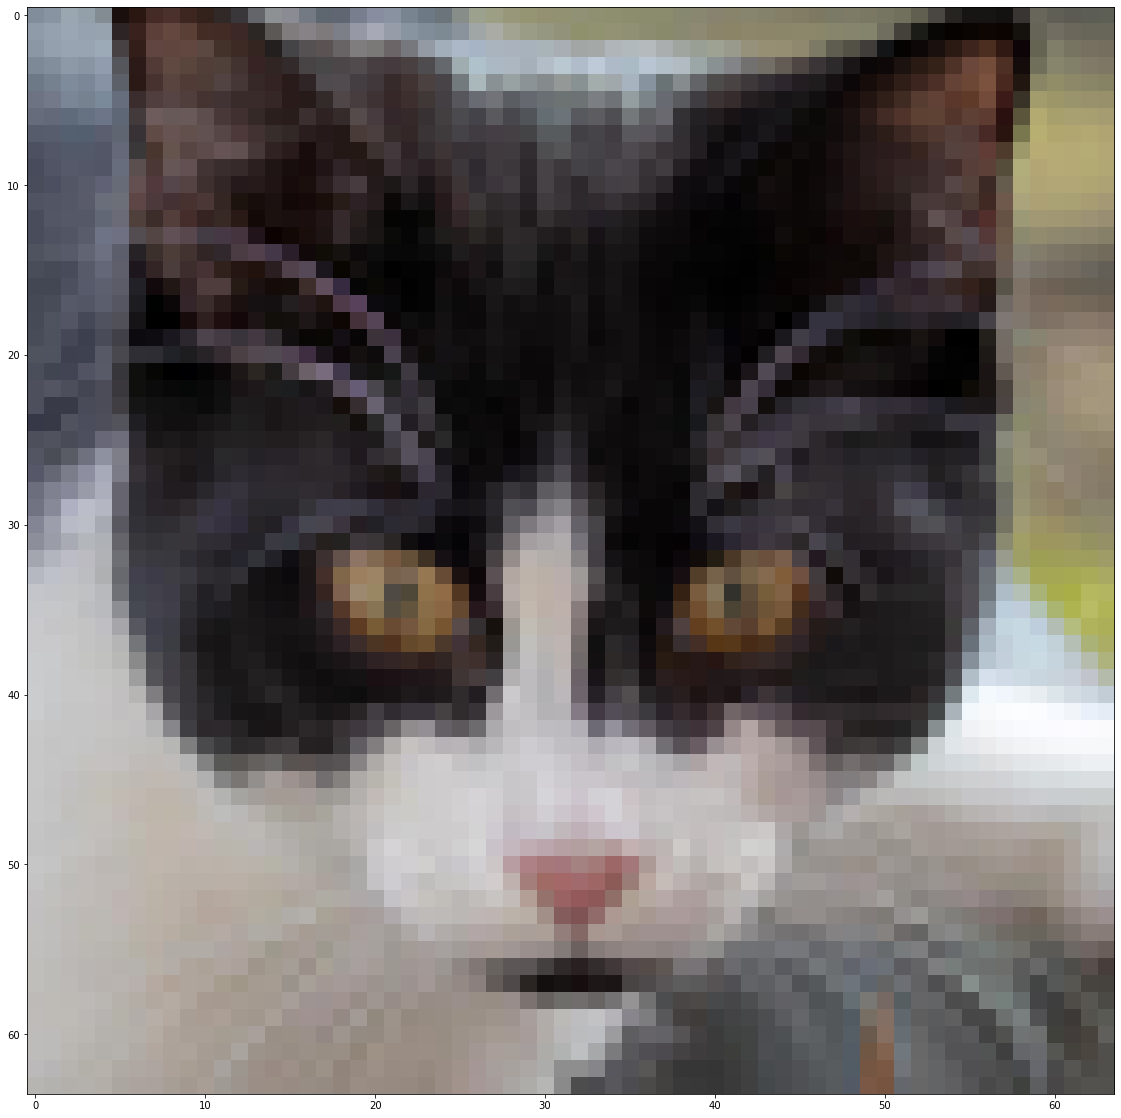

In [5]:
plt.imshow((data[789]+1)/2)

In [6]:
# Coverting the list into a numpy nd-array
data = np.array(data)
data.shape

(5153, 64, 64, 3)

### Using a Vanilla GAN to generate cat images


In [7]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

Defining the discriminator 

In [8]:
def define_discriminator(in_shape=(inp_size,inp_size,3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.00002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

Defining the generator

In [9]:
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 64 * 8 * 8
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 64)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

Defining the GAN

In [10]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.00002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

### Good practice for initialising the architecture

* Ensuring that generator and discriminator are not unfair to eachother (i.e. no one network should learn faster than the other)
* Leaky ReLU activation at the networks, bring in negative activations in the model acting as a punishment analogy.
* Not adding too many dropout layers to the GAN, which may lead to confusion and bad training. 
* Ensuring that the discriminator is set as non-trainable when generator is being trained. 
* Learning rates to be ensured for a fair min-max game. (0.00002 preferably for networks.)

Helper functions to load inputs

In [11]:
def load_real_samples():
    (trainX, _), (_, _) = load_data()
    X = trainX.astype('float32')
    X = (X - 127.5) / 127.5
    return X
 
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y
 
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

Training GAN

In [12]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10000, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
            

### Good Practices for training
* Monitoring the loss curves of both generator and discriminator to ensure a fair min-max game. So that generator catches up to discriminator learning and keeps fooling the discriminator. 
* In usual scenarios, discriminator learns faster than the generator. In such cases, it is suggested to increase the generator training steps in each epoch. 
* A regular result monotoring will help understand the training failures of GAN like mode-collpase or output saturations. 

Performace Summary

In [13]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    save_plot(x_fake, epoch)
    filename = '/appdisk/projects/Warhol/cats/models/vanilla_generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)
def save_plot(examples, epoch, n=5):
    examples = (examples + 1) / 2.0
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i])
    filename = '/appdisk/projects/Warhol/cats/results/train/vanilla_generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

#### Executing the GAN code

In [14]:
plt.rcParams["figure.figsize"] = (10,10)
latent_dim = 1000
d_model = define_discriminator()
g_model = define_generator(latent_dim)


In [15]:
g_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              4100096   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 128)      

In [ ]:
gan_model = define_gan(g_model, d_model)
train(g_model, d_model, gan_model, data, latent_dim,n_epochs=10000)

>1, 1/40, d1=0.700, d2=0.693 g=0.692
>1, 2/40, d1=0.691, d2=0.695 g=0.690
>1, 3/40, d1=0.685, d2=0.697 g=0.687
>1, 4/40, d1=0.680, d2=0.699 g=0.684
>1, 5/40, d1=0.669, d2=0.703 g=0.680
>1, 6/40, d1=0.665, d2=0.707 g=0.675
>1, 7/40, d1=0.658, d2=0.712 g=0.669
>1, 8/40, d1=0.648, d2=0.718 g=0.662
>1, 9/40, d1=0.649, d2=0.726 g=0.656
>1, 10/40, d1=0.637, d2=0.734 g=0.649
>1, 11/40, d1=0.627, d2=0.740 g=0.645
>1, 12/40, d1=0.619, d2=0.745 g=0.644
>1, 13/40, d1=0.616, d2=0.741 g=0.648
>1, 14/40, d1=0.610, d2=0.741 g=0.649
>1, 15/40, d1=0.610, d2=0.741 g=0.651
>1, 16/40, d1=0.600, d2=0.736 g=0.654
>1, 17/40, d1=0.597, d2=0.733 g=0.654
>1, 18/40, d1=0.589, d2=0.732 g=0.649
>1, 19/40, d1=0.574, d2=0.744 g=0.632
>1, 20/40, d1=0.576, d2=0.762 g=0.607
>1, 21/40, d1=0.572, d2=0.796 g=0.570
>1, 22/40, d1=0.561, d2=0.834 g=0.550
>1, 23/40, d1=0.573, d2=0.854 g=0.534
>1, 24/40, d1=0.570, d2=0.881 g=0.510
>1, 25/40, d1=0.565, d2=0.914 g=0.491
>1, 26/40, d1=0.576, d2=0.946 g=0.471
>1, 27/40, d1=0.575, 

>6, 19/40, d1=0.493, d2=1.062 g=0.477
>6, 20/40, d1=0.497, d2=0.946 g=0.549
>6, 21/40, d1=0.494, d2=0.832 g=0.610
>6, 22/40, d1=0.505, d2=0.752 g=0.679
>6, 23/40, d1=0.510, d2=0.691 g=0.741
>6, 24/40, d1=0.531, d2=0.622 g=0.806
>6, 25/40, d1=0.529, d2=0.586 g=0.860
>6, 26/40, d1=0.540, d2=0.535 g=0.914
>6, 27/40, d1=0.566, d2=0.501 g=0.953
>6, 28/40, d1=0.529, d2=0.482 g=0.974
>6, 29/40, d1=0.536, d2=0.469 g=0.983
>6, 30/40, d1=0.567, d2=0.451 g=0.961
>6, 31/40, d1=0.559, d2=0.465 g=0.957
>6, 32/40, d1=0.555, d2=0.487 g=0.925
>6, 33/40, d1=0.527, d2=0.495 g=0.882
>6, 34/40, d1=0.548, d2=0.531 g=0.858
>6, 35/40, d1=0.531, d2=0.554 g=0.833
>6, 36/40, d1=0.484, d2=0.576 g=0.809
>6, 37/40, d1=0.562, d2=0.587 g=0.787
>6, 38/40, d1=0.540, d2=0.613 g=0.762
>6, 39/40, d1=0.519, d2=0.632 g=0.747
>6, 40/40, d1=0.438, d2=0.646 g=0.732
>7, 1/40, d1=0.460, d2=0.661 g=0.712
>7, 2/40, d1=0.491, d2=0.678 g=0.683
>7, 3/40, d1=0.493, d2=0.711 g=0.628
>7, 4/40, d1=0.445, d2=0.780 g=0.532
>7, 5/40, d1=0.3

>11, 34/40, d1=0.556, d2=0.630 g=0.735
>11, 35/40, d1=0.569, d2=0.625 g=0.740
>11, 36/40, d1=0.629, d2=0.631 g=0.726
>11, 37/40, d1=0.588, d2=0.653 g=0.713
>11, 38/40, d1=0.608, d2=0.654 g=0.704
>11, 39/40, d1=0.545, d2=0.670 g=0.688
>11, 40/40, d1=0.531, d2=0.682 g=0.676
>12, 1/40, d1=0.479, d2=0.712 g=0.649
>12, 2/40, d1=0.550, d2=0.727 g=0.634
>12, 3/40, d1=0.462, d2=0.744 g=0.628
>12, 4/40, d1=0.550, d2=0.761 g=0.614
>12, 5/40, d1=0.522, d2=0.781 g=0.605
>12, 6/40, d1=0.494, d2=0.785 g=0.595
>12, 7/40, d1=0.442, d2=0.799 g=0.591
>12, 8/40, d1=0.456, d2=0.808 g=0.583
>12, 9/40, d1=0.452, d2=0.806 g=0.589
>12, 10/40, d1=0.451, d2=0.818 g=0.592
>12, 11/40, d1=0.419, d2=0.798 g=0.585
>12, 12/40, d1=0.440, d2=0.781 g=0.604
>12, 13/40, d1=0.443, d2=0.776 g=0.608
>12, 14/40, d1=0.463, d2=0.782 g=0.623
>12, 15/40, d1=0.421, d2=0.764 g=0.631
>12, 16/40, d1=0.429, d2=0.753 g=0.650
>12, 17/40, d1=0.416, d2=0.737 g=0.651
>12, 18/40, d1=0.448, d2=0.714 g=0.682
>12, 19/40, d1=0.447, d2=0.696 g=0

>17, 6/40, d1=0.759, d2=0.667 g=0.676
>17, 7/40, d1=0.765, d2=0.678 g=0.675
>17, 8/40, d1=0.737, d2=0.679 g=0.670
>17, 9/40, d1=0.761, d2=0.687 g=0.673
>17, 10/40, d1=0.746, d2=0.697 g=0.670
>17, 11/40, d1=0.713, d2=0.678 g=0.674
>17, 12/40, d1=0.747, d2=0.702 g=0.670
>17, 13/40, d1=0.751, d2=0.699 g=0.682
>17, 14/40, d1=0.744, d2=0.689 g=0.668
>17, 15/40, d1=0.751, d2=0.704 g=0.668
>17, 16/40, d1=0.740, d2=0.714 g=0.657
>17, 17/40, d1=0.725, d2=0.692 g=0.650
>17, 18/40, d1=0.720, d2=0.694 g=0.655
>17, 19/40, d1=0.747, d2=0.711 g=0.650
>17, 20/40, d1=0.719, d2=0.710 g=0.651
>17, 21/40, d1=0.732, d2=0.725 g=0.664
>17, 22/40, d1=0.727, d2=0.697 g=0.648
>17, 23/40, d1=0.712, d2=0.733 g=0.644
>17, 24/40, d1=0.723, d2=0.728 g=0.644
>17, 25/40, d1=0.722, d2=0.721 g=0.647
>17, 26/40, d1=0.721, d2=0.737 g=0.643
>17, 27/40, d1=0.714, d2=0.722 g=0.656
>17, 28/40, d1=0.702, d2=0.738 g=0.639
>17, 29/40, d1=0.717, d2=0.733 g=0.634
>17, 30/40, d1=0.705, d2=0.726 g=0.646
>17, 31/40, d1=0.715, d2=0.70

>22, 17/40, d1=0.733, d2=0.689 g=0.693
>22, 18/40, d1=0.727, d2=0.684 g=0.689
>22, 19/40, d1=0.723, d2=0.698 g=0.684
>22, 20/40, d1=0.727, d2=0.694 g=0.670
>22, 21/40, d1=0.722, d2=0.721 g=0.653
>22, 22/40, d1=0.720, d2=0.740 g=0.656
>22, 23/40, d1=0.718, d2=0.705 g=0.691
>22, 24/40, d1=0.712, d2=0.691 g=0.719
>22, 25/40, d1=0.724, d2=0.650 g=0.766
>22, 26/40, d1=0.726, d2=0.620 g=0.784
>22, 27/40, d1=0.730, d2=0.611 g=0.730
>22, 28/40, d1=0.739, d2=0.676 g=0.596
>22, 29/40, d1=0.714, d2=0.827 g=0.586
>22, 30/40, d1=0.721, d2=0.789 g=0.633
>22, 31/40, d1=0.752, d2=0.723 g=0.690
>22, 32/40, d1=0.745, d2=0.682 g=0.729
>22, 33/40, d1=0.761, d2=0.649 g=0.753
>22, 34/40, d1=0.780, d2=0.641 g=0.754
>22, 35/40, d1=0.793, d2=0.633 g=0.744
>22, 36/40, d1=0.790, d2=0.646 g=0.728
>22, 37/40, d1=0.764, d2=0.651 g=0.732
>22, 38/40, d1=0.772, d2=0.654 g=0.731
>22, 39/40, d1=0.762, d2=0.660 g=0.719
>22, 40/40, d1=0.771, d2=0.656 g=0.720
>23, 1/40, d1=0.757, d2=0.666 g=0.718
>23, 2/40, d1=0.753, d2=0.

>27, 29/40, d1=0.741, d2=0.676 g=0.694
>27, 30/40, d1=0.727, d2=0.687 g=0.702
>27, 31/40, d1=0.726, d2=0.690 g=0.698
>27, 32/40, d1=0.722, d2=0.684 g=0.693
>27, 33/40, d1=0.732, d2=0.687 g=0.694
>27, 34/40, d1=0.729, d2=0.691 g=0.696
>27, 35/40, d1=0.728, d2=0.681 g=0.701
>27, 36/40, d1=0.732, d2=0.679 g=0.698
>27, 37/40, d1=0.739, d2=0.679 g=0.697
>27, 38/40, d1=0.726, d2=0.688 g=0.700
>27, 39/40, d1=0.730, d2=0.677 g=0.692
>27, 40/40, d1=0.737, d2=0.681 g=0.705
>28, 1/40, d1=0.728, d2=0.686 g=0.691
>28, 2/40, d1=0.739, d2=0.670 g=0.695
>28, 3/40, d1=0.722, d2=0.674 g=0.692
>28, 4/40, d1=0.729, d2=0.676 g=0.696
>28, 5/40, d1=0.743, d2=0.671 g=0.698
>28, 6/40, d1=0.742, d2=0.677 g=0.708
>28, 7/40, d1=0.745, d2=0.671 g=0.696
>28, 8/40, d1=0.745, d2=0.675 g=0.697
>28, 9/40, d1=0.744, d2=0.692 g=0.705
>28, 10/40, d1=0.735, d2=0.681 g=0.699
>28, 11/40, d1=0.727, d2=0.680 g=0.701
>28, 12/40, d1=0.736, d2=0.686 g=0.703
>28, 13/40, d1=0.736, d2=0.685 g=0.700
>28, 14/40, d1=0.727, d2=0.685 g=0

>32, 40/40, d1=0.728, d2=0.711 g=0.676
>33, 1/40, d1=0.729, d2=0.712 g=0.674
>33, 2/40, d1=0.725, d2=0.704 g=0.666
>33, 3/40, d1=0.728, d2=0.705 g=0.669
>33, 4/40, d1=0.721, d2=0.709 g=0.675
>33, 5/40, d1=0.730, d2=0.717 g=0.676
>33, 6/40, d1=0.723, d2=0.708 g=0.674
>33, 7/40, d1=0.725, d2=0.705 g=0.672
>33, 8/40, d1=0.729, d2=0.712 g=0.674
>33, 9/40, d1=0.728, d2=0.713 g=0.671
>33, 10/40, d1=0.723, d2=0.718 g=0.669
>33, 11/40, d1=0.721, d2=0.714 g=0.673
>33, 12/40, d1=0.726, d2=0.708 g=0.671
>33, 13/40, d1=0.732, d2=0.712 g=0.671
>33, 14/40, d1=0.724, d2=0.714 g=0.669
>33, 15/40, d1=0.723, d2=0.711 g=0.669
>33, 16/40, d1=0.722, d2=0.702 g=0.675
>33, 17/40, d1=0.719, d2=0.711 g=0.671
>33, 18/40, d1=0.720, d2=0.715 g=0.668
>33, 19/40, d1=0.718, d2=0.724 g=0.663
>33, 20/40, d1=0.705, d2=0.725 g=0.674
>33, 21/40, d1=0.714, d2=0.711 g=0.670
>33, 22/40, d1=0.717, d2=0.709 g=0.674
>33, 23/40, d1=0.719, d2=0.711 g=0.665
>33, 24/40, d1=0.715, d2=0.714 g=0.654
>33, 25/40, d1=0.714, d2=0.729 g=0

>38, 12/40, d1=0.732, d2=0.698 g=0.686
>38, 13/40, d1=0.732, d2=0.699 g=0.683
>38, 14/40, d1=0.732, d2=0.705 g=0.682
>38, 15/40, d1=0.726, d2=0.702 g=0.682
>38, 16/40, d1=0.734, d2=0.701 g=0.682
>38, 17/40, d1=0.730, d2=0.698 g=0.683
>38, 18/40, d1=0.734, d2=0.700 g=0.685
>38, 19/40, d1=0.728, d2=0.703 g=0.684
>38, 20/40, d1=0.740, d2=0.704 g=0.686
>38, 21/40, d1=0.736, d2=0.697 g=0.685
>38, 22/40, d1=0.734, d2=0.699 g=0.686
>38, 23/40, d1=0.729, d2=0.702 g=0.686
>38, 24/40, d1=0.726, d2=0.701 g=0.688
>38, 25/40, d1=0.732, d2=0.700 g=0.682
>38, 26/40, d1=0.732, d2=0.699 g=0.679
>38, 27/40, d1=0.733, d2=0.705 g=0.683
>38, 28/40, d1=0.735, d2=0.704 g=0.685
>38, 29/40, d1=0.734, d2=0.695 g=0.684
>38, 30/40, d1=0.736, d2=0.703 g=0.686
>38, 31/40, d1=0.734, d2=0.702 g=0.689
>38, 32/40, d1=0.736, d2=0.700 g=0.686
>38, 33/40, d1=0.733, d2=0.699 g=0.684
>38, 34/40, d1=0.730, d2=0.696 g=0.685
>38, 35/40, d1=0.730, d2=0.701 g=0.684
>38, 36/40, d1=0.732, d2=0.697 g=0.687
>38, 37/40, d1=0.728, d2=

>43, 23/40, d1=0.731, d2=0.690 g=0.693
>43, 24/40, d1=0.735, d2=0.695 g=0.694
>43, 25/40, d1=0.733, d2=0.688 g=0.695
>43, 26/40, d1=0.733, d2=0.689 g=0.692
>43, 27/40, d1=0.734, d2=0.690 g=0.694
>43, 28/40, d1=0.731, d2=0.692 g=0.693
>43, 29/40, d1=0.736, d2=0.689 g=0.696
>43, 30/40, d1=0.729, d2=0.691 g=0.693
>43, 31/40, d1=0.732, d2=0.692 g=0.693
>43, 32/40, d1=0.734, d2=0.692 g=0.693
>43, 33/40, d1=0.731, d2=0.693 g=0.689
>43, 34/40, d1=0.734, d2=0.696 g=0.694
>43, 35/40, d1=0.732, d2=0.692 g=0.695
>43, 36/40, d1=0.734, d2=0.689 g=0.696
>43, 37/40, d1=0.735, d2=0.691 g=0.692
>43, 38/40, d1=0.736, d2=0.694 g=0.695
>43, 39/40, d1=0.731, d2=0.689 g=0.694
>43, 40/40, d1=0.733, d2=0.688 g=0.694
>44, 1/40, d1=0.733, d2=0.692 g=0.695
>44, 2/40, d1=0.733, d2=0.694 g=0.695
>44, 3/40, d1=0.736, d2=0.693 g=0.696
>44, 4/40, d1=0.733, d2=0.691 g=0.696
>44, 5/40, d1=0.733, d2=0.689 g=0.696
>44, 6/40, d1=0.736, d2=0.689 g=0.697
>44, 7/40, d1=0.728, d2=0.693 g=0.694
>44, 8/40, d1=0.733, d2=0.692 g=

>48, 35/40, d1=0.726, d2=0.692 g=0.694
>48, 36/40, d1=0.727, d2=0.692 g=0.693
>48, 37/40, d1=0.723, d2=0.689 g=0.694
>48, 38/40, d1=0.723, d2=0.691 g=0.695
>48, 39/40, d1=0.727, d2=0.691 g=0.692
>48, 40/40, d1=0.723, d2=0.692 g=0.693
>49, 1/40, d1=0.723, d2=0.690 g=0.692
>49, 2/40, d1=0.722, d2=0.692 g=0.693
>49, 3/40, d1=0.724, d2=0.690 g=0.694
>49, 4/40, d1=0.727, d2=0.692 g=0.695
>49, 5/40, d1=0.727, d2=0.690 g=0.694
>49, 6/40, d1=0.724, d2=0.692 g=0.696
>49, 7/40, d1=0.724, d2=0.687 g=0.697
>49, 8/40, d1=0.725, d2=0.689 g=0.695
>49, 9/40, d1=0.726, d2=0.689 g=0.696
>49, 10/40, d1=0.725, d2=0.691 g=0.698
>49, 11/40, d1=0.727, d2=0.690 g=0.697
>49, 12/40, d1=0.726, d2=0.690 g=0.697
>49, 13/40, d1=0.727, d2=0.688 g=0.698
>49, 14/40, d1=0.726, d2=0.688 g=0.698
>49, 15/40, d1=0.727, d2=0.687 g=0.699
>49, 16/40, d1=0.726, d2=0.687 g=0.699
>49, 17/40, d1=0.727, d2=0.689 g=0.698
>49, 18/40, d1=0.726, d2=0.688 g=0.699
>49, 19/40, d1=0.730, d2=0.685 g=0.699
>49, 20/40, d1=0.731, d2=0.687 g=0

>54, 6/40, d1=0.722, d2=0.690 g=0.697
>54, 7/40, d1=0.722, d2=0.687 g=0.697
>54, 8/40, d1=0.723, d2=0.689 g=0.697
>54, 9/40, d1=0.723, d2=0.690 g=0.697
>54, 10/40, d1=0.722, d2=0.690 g=0.697
>54, 11/40, d1=0.724, d2=0.690 g=0.697
>54, 12/40, d1=0.720, d2=0.690 g=0.696
>54, 13/40, d1=0.722, d2=0.688 g=0.695
>54, 14/40, d1=0.720, d2=0.691 g=0.695
>54, 15/40, d1=0.720, d2=0.690 g=0.695
>54, 16/40, d1=0.720, d2=0.692 g=0.695
>54, 17/40, d1=0.719, d2=0.692 g=0.696
>54, 18/40, d1=0.722, d2=0.692 g=0.694
>54, 19/40, d1=0.720, d2=0.693 g=0.695
>54, 20/40, d1=0.719, d2=0.691 g=0.694
>54, 21/40, d1=0.721, d2=0.692 g=0.694
>54, 22/40, d1=0.720, d2=0.692 g=0.694
>54, 23/40, d1=0.719, d2=0.691 g=0.694
>54, 24/40, d1=0.718, d2=0.690 g=0.694
>54, 25/40, d1=0.719, d2=0.688 g=0.694
>54, 26/40, d1=0.718, d2=0.690 g=0.695
>54, 27/40, d1=0.720, d2=0.691 g=0.694
>54, 28/40, d1=0.720, d2=0.692 g=0.695
>54, 29/40, d1=0.722, d2=0.689 g=0.696
>54, 30/40, d1=0.722, d2=0.690 g=0.696
>54, 31/40, d1=0.722, d2=0.69

>59, 18/40, d1=0.717, d2=0.689 g=0.696
>59, 19/40, d1=0.717, d2=0.689 g=0.697
>59, 20/40, d1=0.716, d2=0.689 g=0.697
>59, 21/40, d1=0.714, d2=0.689 g=0.697
>59, 22/40, d1=0.716, d2=0.690 g=0.696
>59, 23/40, d1=0.712, d2=0.690 g=0.696
>59, 24/40, d1=0.712, d2=0.691 g=0.696
>59, 25/40, d1=0.714, d2=0.691 g=0.695
>59, 26/40, d1=0.711, d2=0.691 g=0.695
>59, 27/40, d1=0.713, d2=0.692 g=0.694
>59, 28/40, d1=0.712, d2=0.692 g=0.694
>59, 29/40, d1=0.710, d2=0.693 g=0.693
>59, 30/40, d1=0.713, d2=0.693 g=0.693
>59, 31/40, d1=0.712, d2=0.693 g=0.693
>59, 32/40, d1=0.711, d2=0.693 g=0.691
>59, 33/40, d1=0.711, d2=0.693 g=0.694
>59, 34/40, d1=0.711, d2=0.695 g=0.692
>59, 35/40, d1=0.711, d2=0.694 g=0.692
>59, 36/40, d1=0.710, d2=0.694 g=0.693
>59, 37/40, d1=0.708, d2=0.693 g=0.692
>59, 38/40, d1=0.710, d2=0.694 g=0.692
>59, 39/40, d1=0.708, d2=0.694 g=0.692
>59, 40/40, d1=0.711, d2=0.695 g=0.691
>60, 1/40, d1=0.711, d2=0.694 g=0.691
>60, 2/40, d1=0.708, d2=0.695 g=0.691
>60, 3/40, d1=0.710, d2=0.6

>64, 29/40, d1=0.711, d2=0.690 g=0.696
>64, 30/40, d1=0.712, d2=0.690 g=0.695
>64, 31/40, d1=0.710, d2=0.692 g=0.696
>64, 32/40, d1=0.710, d2=0.692 g=0.695
>64, 33/40, d1=0.709, d2=0.691 g=0.694
>64, 34/40, d1=0.710, d2=0.691 g=0.694
>64, 35/40, d1=0.711, d2=0.691 g=0.695
>64, 36/40, d1=0.710, d2=0.693 g=0.696
>64, 37/40, d1=0.712, d2=0.690 g=0.694
>64, 38/40, d1=0.710, d2=0.693 g=0.694
>64, 39/40, d1=0.710, d2=0.691 g=0.694
>64, 40/40, d1=0.709, d2=0.691 g=0.695
>65, 1/40, d1=0.708, d2=0.690 g=0.694
>65, 2/40, d1=0.711, d2=0.692 g=0.693
>65, 3/40, d1=0.711, d2=0.693 g=0.692
>65, 4/40, d1=0.710, d2=0.694 g=0.691
>65, 5/40, d1=0.712, d2=0.694 g=0.694
>65, 6/40, d1=0.709, d2=0.691 g=0.698
>65, 7/40, d1=0.712, d2=0.687 g=0.700
>65, 8/40, d1=0.712, d2=0.687 g=0.698
>65, 9/40, d1=0.710, d2=0.687 g=0.694
>65, 10/40, d1=0.712, d2=0.692 g=0.693
>65, 11/40, d1=0.711, d2=0.693 g=0.693
>65, 12/40, d1=0.710, d2=0.692 g=0.693
>65, 13/40, d1=0.711, d2=0.691 g=0.694
>65, 14/40, d1=0.710, d2=0.690 g=0

>70, 1/40, d1=0.708, d2=0.688 g=0.698
>70, 2/40, d1=0.708, d2=0.689 g=0.697
>70, 3/40, d1=0.707, d2=0.690 g=0.696
>70, 4/40, d1=0.707, d2=0.690 g=0.695
>70, 5/40, d1=0.707, d2=0.690 g=0.696
>70, 6/40, d1=0.708, d2=0.691 g=0.696
>70, 7/40, d1=0.706, d2=0.692 g=0.695
>70, 8/40, d1=0.706, d2=0.691 g=0.696
>70, 9/40, d1=0.708, d2=0.691 g=0.695
>70, 10/40, d1=0.707, d2=0.692 g=0.695
>70, 11/40, d1=0.705, d2=0.692 g=0.694
>70, 12/40, d1=0.706, d2=0.692 g=0.694
>70, 13/40, d1=0.705, d2=0.691 g=0.693
>70, 14/40, d1=0.705, d2=0.693 g=0.694
>70, 15/40, d1=0.706, d2=0.693 g=0.694
>70, 16/40, d1=0.706, d2=0.694 g=0.694
>70, 17/40, d1=0.707, d2=0.693 g=0.694
>70, 18/40, d1=0.705, d2=0.691 g=0.694
>70, 19/40, d1=0.707, d2=0.692 g=0.694
>70, 20/40, d1=0.706, d2=0.692 g=0.693
>70, 21/40, d1=0.706, d2=0.692 g=0.694
>70, 22/40, d1=0.707, d2=0.692 g=0.694
>70, 23/40, d1=0.708, d2=0.691 g=0.695
>70, 24/40, d1=0.706, d2=0.692 g=0.696
>70, 25/40, d1=0.707, d2=0.691 g=0.695
>70, 26/40, d1=0.708, d2=0.691 g=0

>75, 12/40, d1=0.703, d2=0.693 g=0.694
>75, 13/40, d1=0.703, d2=0.693 g=0.693
>75, 14/40, d1=0.703, d2=0.694 g=0.693
>75, 15/40, d1=0.703, d2=0.694 g=0.693
>75, 16/40, d1=0.702, d2=0.694 g=0.693
>75, 17/40, d1=0.704, d2=0.694 g=0.693
>75, 18/40, d1=0.704, d2=0.694 g=0.693
>75, 19/40, d1=0.703, d2=0.694 g=0.693
>75, 20/40, d1=0.703, d2=0.693 g=0.693
>75, 21/40, d1=0.703, d2=0.694 g=0.692
>75, 22/40, d1=0.703, d2=0.693 g=0.693
>75, 23/40, d1=0.703, d2=0.694 g=0.693
>75, 24/40, d1=0.704, d2=0.693 g=0.693
>75, 25/40, d1=0.703, d2=0.694 g=0.694
>75, 26/40, d1=0.704, d2=0.693 g=0.694
>75, 27/40, d1=0.705, d2=0.691 g=0.695
>75, 28/40, d1=0.704, d2=0.692 g=0.695
>75, 29/40, d1=0.705, d2=0.692 g=0.695
>75, 30/40, d1=0.705, d2=0.692 g=0.695
>75, 31/40, d1=0.706, d2=0.691 g=0.695
>75, 32/40, d1=0.706, d2=0.690 g=0.696
>75, 33/40, d1=0.706, d2=0.691 g=0.697
>75, 34/40, d1=0.706, d2=0.691 g=0.697
>75, 35/40, d1=0.707, d2=0.689 g=0.697
>75, 36/40, d1=0.706, d2=0.690 g=0.697
>75, 37/40, d1=0.708, d2=

>80, 24/40, d1=0.702, d2=0.693 g=0.694
>80, 25/40, d1=0.703, d2=0.693 g=0.693
>80, 26/40, d1=0.703, d2=0.692 g=0.694
>80, 27/40, d1=0.703, d2=0.693 g=0.695
>80, 28/40, d1=0.702, d2=0.692 g=0.694
>80, 29/40, d1=0.703, d2=0.693 g=0.695
>80, 30/40, d1=0.703, d2=0.692 g=0.695
>80, 31/40, d1=0.704, d2=0.692 g=0.695
>80, 32/40, d1=0.703, d2=0.692 g=0.695
>80, 33/40, d1=0.702, d2=0.692 g=0.695
>80, 34/40, d1=0.703, d2=0.692 g=0.695
>80, 35/40, d1=0.703, d2=0.691 g=0.695
>80, 36/40, d1=0.702, d2=0.692 g=0.695
>80, 37/40, d1=0.703, d2=0.692 g=0.695
>80, 38/40, d1=0.703, d2=0.692 g=0.694
>80, 39/40, d1=0.703, d2=0.692 g=0.694
>80, 40/40, d1=0.703, d2=0.691 g=0.695
>Accuracy real: 1%, fake: 91%
>81, 1/40, d1=0.694, d2=0.692 g=0.695
>81, 2/40, d1=0.702, d2=0.692 g=0.695
>81, 3/40, d1=0.703, d2=0.691 g=0.695
>81, 4/40, d1=0.703, d2=0.692 g=0.695
>81, 5/40, d1=0.702, d2=0.693 g=0.695
>81, 6/40, d1=0.703, d2=0.691 g=0.695
>81, 7/40, d1=0.703, d2=0.691 g=0.695
>81, 8/40, d1=0.704, d2=0.691 g=0.695
>81

>85, 35/40, d1=0.706, d2=0.691 g=0.705
>85, 36/40, d1=0.708, d2=0.677 g=0.713
>85, 37/40, d1=0.711, d2=0.675 g=0.697
>85, 38/40, d1=0.711, d2=0.693 g=0.696
>85, 39/40, d1=0.713, d2=0.691 g=0.701
>85, 40/40, d1=0.713, d2=0.684 g=0.706
>86, 1/40, d1=0.713, d2=0.679 g=0.710
>86, 2/40, d1=0.713, d2=0.676 g=0.707
>86, 3/40, d1=0.714, d2=0.680 g=0.707
>86, 4/40, d1=0.715, d2=0.681 g=0.705
>86, 5/40, d1=0.714, d2=0.682 g=0.704
>86, 6/40, d1=0.715, d2=0.682 g=0.703
>86, 7/40, d1=0.714, d2=0.684 g=0.703
>86, 8/40, d1=0.714, d2=0.683 g=0.703
>86, 9/40, d1=0.714, d2=0.683 g=0.702
>86, 10/40, d1=0.713, d2=0.684 g=0.702
>86, 11/40, d1=0.713, d2=0.686 g=0.701
>86, 12/40, d1=0.712, d2=0.686 g=0.701
>86, 13/40, d1=0.711, d2=0.686 g=0.700
>86, 14/40, d1=0.711, d2=0.686 g=0.700
>86, 15/40, d1=0.709, d2=0.686 g=0.700
>86, 16/40, d1=0.709, d2=0.688 g=0.699
>86, 17/40, d1=0.708, d2=0.688 g=0.698
>86, 18/40, d1=0.709, d2=0.688 g=0.698
>86, 19/40, d1=0.707, d2=0.689 g=0.698
>86, 20/40, d1=0.707, d2=0.689 g=0

>91, 6/40, d1=0.697, d2=0.695 g=0.691
>91, 7/40, d1=0.697, d2=0.696 g=0.691
>91, 8/40, d1=0.698, d2=0.695 g=0.691
>91, 9/40, d1=0.697, d2=0.696 g=0.691
>91, 10/40, d1=0.699, d2=0.696 g=0.691
>91, 11/40, d1=0.697, d2=0.696 g=0.691
>91, 12/40, d1=0.698, d2=0.694 g=0.691
>91, 13/40, d1=0.698, d2=0.696 g=0.691
>91, 14/40, d1=0.699, d2=0.696 g=0.691
>91, 15/40, d1=0.698, d2=0.694 g=0.691
>91, 16/40, d1=0.699, d2=0.695 g=0.691
>91, 17/40, d1=0.699, d2=0.695 g=0.692
>91, 18/40, d1=0.699, d2=0.695 g=0.691
>91, 19/40, d1=0.699, d2=0.695 g=0.692
>91, 20/40, d1=0.699, d2=0.695 g=0.692
>91, 21/40, d1=0.699, d2=0.695 g=0.691
>91, 22/40, d1=0.699, d2=0.695 g=0.692
>91, 23/40, d1=0.699, d2=0.695 g=0.691
>91, 24/40, d1=0.699, d2=0.695 g=0.692
>91, 25/40, d1=0.700, d2=0.693 g=0.693
>91, 26/40, d1=0.700, d2=0.694 g=0.692
>91, 27/40, d1=0.699, d2=0.695 g=0.693
>91, 28/40, d1=0.700, d2=0.694 g=0.693
>91, 29/40, d1=0.700, d2=0.693 g=0.693
>91, 30/40, d1=0.701, d2=0.693 g=0.693
>91, 31/40, d1=0.700, d2=0.69

>96, 18/40, d1=0.703, d2=0.690 g=0.697
>96, 19/40, d1=0.702, d2=0.690 g=0.697
>96, 20/40, d1=0.702, d2=0.690 g=0.696
>96, 21/40, d1=0.701, d2=0.691 g=0.695
>96, 22/40, d1=0.700, d2=0.692 g=0.695
>96, 23/40, d1=0.700, d2=0.692 g=0.694
>96, 24/40, d1=0.700, d2=0.692 g=0.694
>96, 25/40, d1=0.700, d2=0.693 g=0.694
>96, 26/40, d1=0.700, d2=0.693 g=0.693
>96, 27/40, d1=0.699, d2=0.694 g=0.693
>96, 28/40, d1=0.699, d2=0.693 g=0.693
>96, 29/40, d1=0.698, d2=0.693 g=0.693
>96, 30/40, d1=0.698, d2=0.694 g=0.693
>96, 31/40, d1=0.697, d2=0.693 g=0.693
>96, 32/40, d1=0.697, d2=0.694 g=0.692
>96, 33/40, d1=0.697, d2=0.695 g=0.692
>96, 34/40, d1=0.697, d2=0.694 g=0.692
>96, 35/40, d1=0.696, d2=0.695 g=0.692
>96, 36/40, d1=0.696, d2=0.695 g=0.691
>96, 37/40, d1=0.694, d2=0.695 g=0.691
>96, 38/40, d1=0.695, d2=0.696 g=0.691
>96, 39/40, d1=0.695, d2=0.696 g=0.690
>96, 40/40, d1=0.693, d2=0.697 g=0.689
>97, 1/40, d1=0.692, d2=0.697 g=0.689
>97, 2/40, d1=0.694, d2=0.698 g=0.689
>97, 3/40, d1=0.693, d2=0.6

>101, 27/40, d1=0.697, d2=0.694 g=0.692
>101, 28/40, d1=0.697, d2=0.695 g=0.692
>101, 29/40, d1=0.697, d2=0.694 g=0.693
>101, 30/40, d1=0.697, d2=0.694 g=0.693
>101, 31/40, d1=0.696, d2=0.694 g=0.694
>101, 32/40, d1=0.697, d2=0.694 g=0.693
>101, 33/40, d1=0.698, d2=0.694 g=0.693
>101, 34/40, d1=0.698, d2=0.694 g=0.693
>101, 35/40, d1=0.697, d2=0.694 g=0.693
>101, 36/40, d1=0.698, d2=0.694 g=0.693
>101, 37/40, d1=0.698, d2=0.694 g=0.693
>101, 38/40, d1=0.698, d2=0.693 g=0.694
>101, 39/40, d1=0.699, d2=0.693 g=0.693
>101, 40/40, d1=0.698, d2=0.693 g=0.694
>102, 1/40, d1=0.698, d2=0.693 g=0.695
>102, 2/40, d1=0.698, d2=0.693 g=0.694
>102, 3/40, d1=0.699, d2=0.693 g=0.694
>102, 4/40, d1=0.699, d2=0.693 g=0.694
>102, 5/40, d1=0.698, d2=0.692 g=0.694
>102, 6/40, d1=0.698, d2=0.692 g=0.694
>102, 7/40, d1=0.699, d2=0.693 g=0.694
>102, 8/40, d1=0.698, d2=0.692 g=0.694
>102, 9/40, d1=0.700, d2=0.692 g=0.694
>102, 10/40, d1=0.698, d2=0.693 g=0.694
>102, 11/40, d1=0.698, d2=0.692 g=0.694
>102, 12/

>106, 33/40, d1=0.699, d2=0.692 g=0.694
>106, 34/40, d1=0.699, d2=0.692 g=0.694
>106, 35/40, d1=0.699, d2=0.692 g=0.694
>106, 36/40, d1=0.699, d2=0.692 g=0.694
>106, 37/40, d1=0.698, d2=0.693 g=0.694
>106, 38/40, d1=0.699, d2=0.693 g=0.694
>106, 39/40, d1=0.698, d2=0.693 g=0.694
>106, 40/40, d1=0.698, d2=0.692 g=0.694
>107, 1/40, d1=0.698, d2=0.693 g=0.693
>107, 2/40, d1=0.697, d2=0.693 g=0.694
>107, 3/40, d1=0.697, d2=0.693 g=0.693
>107, 4/40, d1=0.697, d2=0.694 g=0.693
>107, 5/40, d1=0.697, d2=0.693 g=0.693
>107, 6/40, d1=0.698, d2=0.693 g=0.693
>107, 7/40, d1=0.697, d2=0.694 g=0.693
>107, 8/40, d1=0.697, d2=0.694 g=0.693
>107, 9/40, d1=0.698, d2=0.693 g=0.694
>107, 10/40, d1=0.698, d2=0.692 g=0.694
>107, 11/40, d1=0.698, d2=0.692 g=0.694
>107, 12/40, d1=0.698, d2=0.693 g=0.693
>107, 13/40, d1=0.699, d2=0.692 g=0.694
>107, 14/40, d1=0.698, d2=0.692 g=0.695
>107, 15/40, d1=0.698, d2=0.692 g=0.695
>107, 16/40, d1=0.698, d2=0.691 g=0.695
>107, 17/40, d1=0.698, d2=0.692 g=0.694
>107, 18/

>111, 39/40, d1=0.696, d2=0.695 g=0.692
>111, 40/40, d1=0.695, d2=0.695 g=0.692
>112, 1/40, d1=0.696, d2=0.695 g=0.692
>112, 2/40, d1=0.696, d2=0.695 g=0.691
>112, 3/40, d1=0.695, d2=0.696 g=0.691
>112, 4/40, d1=0.696, d2=0.696 g=0.691
>112, 5/40, d1=0.695, d2=0.696 g=0.690
>112, 6/40, d1=0.694, d2=0.696 g=0.689
>112, 7/40, d1=0.696, d2=0.697 g=0.689
>112, 8/40, d1=0.695, d2=0.698 g=0.691
>112, 9/40, d1=0.695, d2=0.695 g=0.694
>112, 10/40, d1=0.696, d2=0.694 g=0.693
>112, 11/40, d1=0.696, d2=0.694 g=0.692
>112, 12/40, d1=0.696, d2=0.695 g=0.692
>112, 13/40, d1=0.697, d2=0.694 g=0.693
>112, 14/40, d1=0.697, d2=0.694 g=0.693
>112, 15/40, d1=0.697, d2=0.695 g=0.691
>112, 16/40, d1=0.696, d2=0.696 g=0.691
>112, 17/40, d1=0.698, d2=0.695 g=0.693
>112, 18/40, d1=0.697, d2=0.693 g=0.694
>112, 19/40, d1=0.697, d2=0.693 g=0.693
>112, 20/40, d1=0.698, d2=0.694 g=0.694
>112, 21/40, d1=0.698, d2=0.694 g=0.693
>112, 22/40, d1=0.698, d2=0.693 g=0.694
>112, 23/40, d1=0.698, d2=0.692 g=0.695
>112, 24/

>117, 6/40, d1=0.698, d2=0.692 g=0.694
>117, 7/40, d1=0.698, d2=0.692 g=0.694
>117, 8/40, d1=0.698, d2=0.692 g=0.695
>117, 9/40, d1=0.698, d2=0.692 g=0.694
>117, 10/40, d1=0.698, d2=0.692 g=0.694
>117, 11/40, d1=0.698, d2=0.692 g=0.694
>117, 12/40, d1=0.697, d2=0.692 g=0.694
>117, 13/40, d1=0.697, d2=0.692 g=0.694
>117, 14/40, d1=0.697, d2=0.692 g=0.694
>117, 15/40, d1=0.697, d2=0.693 g=0.694
>117, 16/40, d1=0.697, d2=0.693 g=0.693
>117, 17/40, d1=0.697, d2=0.694 g=0.693
>117, 18/40, d1=0.698, d2=0.693 g=0.693
>117, 19/40, d1=0.698, d2=0.693 g=0.694
>117, 20/40, d1=0.697, d2=0.693 g=0.693
>117, 21/40, d1=0.696, d2=0.694 g=0.693
>117, 22/40, d1=0.697, d2=0.693 g=0.693
>117, 23/40, d1=0.696, d2=0.693 g=0.693
>117, 24/40, d1=0.696, d2=0.694 g=0.692
>117, 25/40, d1=0.697, d2=0.694 g=0.693
>117, 26/40, d1=0.697, d2=0.694 g=0.693
>117, 27/40, d1=0.696, d2=0.694 g=0.693
>117, 28/40, d1=0.696, d2=0.694 g=0.692
>117, 29/40, d1=0.696, d2=0.695 g=0.693
>117, 30/40, d1=0.696, d2=0.694 g=0.692
>117

>122, 12/40, d1=0.694, d2=0.695 g=0.692
>122, 13/40, d1=0.695, d2=0.695 g=0.692
>122, 14/40, d1=0.695, d2=0.695 g=0.692
>122, 15/40, d1=0.695, d2=0.695 g=0.692
>122, 16/40, d1=0.695, d2=0.694 g=0.692
>122, 17/40, d1=0.695, d2=0.694 g=0.692
>122, 18/40, d1=0.696, d2=0.694 g=0.692
>122, 19/40, d1=0.696, d2=0.695 g=0.692
>122, 20/40, d1=0.696, d2=0.695 g=0.693
>122, 21/40, d1=0.696, d2=0.694 g=0.695
>122, 22/40, d1=0.697, d2=0.692 g=0.695
>122, 23/40, d1=0.696, d2=0.691 g=0.694
>122, 24/40, d1=0.697, d2=0.693 g=0.694
>122, 25/40, d1=0.698, d2=0.693 g=0.695
>122, 26/40, d1=0.697, d2=0.691 g=0.695
>122, 27/40, d1=0.698, d2=0.692 g=0.694
>122, 28/40, d1=0.698, d2=0.692 g=0.694
>122, 29/40, d1=0.698, d2=0.692 g=0.696
>122, 30/40, d1=0.699, d2=0.690 g=0.696
>122, 31/40, d1=0.699, d2=0.691 g=0.696
>122, 32/40, d1=0.699, d2=0.690 g=0.696
>122, 33/40, d1=0.699, d2=0.690 g=0.697
>122, 34/40, d1=0.700, d2=0.690 g=0.697
>122, 35/40, d1=0.700, d2=0.690 g=0.697
>122, 36/40, d1=0.700, d2=0.690 g=0.697


>127, 18/40, d1=0.694, d2=0.695 g=0.691
>127, 19/40, d1=0.693, d2=0.696 g=0.691
>127, 20/40, d1=0.693, d2=0.696 g=0.690
>127, 21/40, d1=0.693, d2=0.696 g=0.690
>127, 22/40, d1=0.692, d2=0.696 g=0.690
>127, 23/40, d1=0.692, d2=0.696 g=0.690
>127, 24/40, d1=0.692, d2=0.697 g=0.690
>127, 25/40, d1=0.692, d2=0.697 g=0.690
>127, 26/40, d1=0.692, d2=0.697 g=0.690
>127, 27/40, d1=0.691, d2=0.696 g=0.690
>127, 28/40, d1=0.691, d2=0.696 g=0.690
>127, 29/40, d1=0.691, d2=0.697 g=0.690
>127, 30/40, d1=0.690, d2=0.696 g=0.690
>127, 31/40, d1=0.691, d2=0.696 g=0.690
>127, 32/40, d1=0.691, d2=0.697 g=0.690
>127, 33/40, d1=0.690, d2=0.696 g=0.690
>127, 34/40, d1=0.691, d2=0.696 g=0.690
>127, 35/40, d1=0.691, d2=0.697 g=0.690
>127, 36/40, d1=0.690, d2=0.696 g=0.690
>127, 37/40, d1=0.691, d2=0.697 g=0.689
>127, 38/40, d1=0.691, d2=0.697 g=0.689
>127, 39/40, d1=0.690, d2=0.698 g=0.690
>127, 40/40, d1=0.691, d2=0.696 g=0.692
>128, 1/40, d1=0.691, d2=0.694 g=0.694
>128, 2/40, d1=0.691, d2=0.693 g=0.696
>1

>132, 24/40, d1=0.698, d2=0.692 g=0.695
>132, 25/40, d1=0.697, d2=0.692 g=0.695
>132, 26/40, d1=0.698, d2=0.691 g=0.695
>132, 27/40, d1=0.698, d2=0.691 g=0.695
>132, 28/40, d1=0.697, d2=0.692 g=0.695
>132, 29/40, d1=0.697, d2=0.691 g=0.695
>132, 30/40, d1=0.697, d2=0.692 g=0.695
>132, 31/40, d1=0.698, d2=0.692 g=0.694
>132, 32/40, d1=0.697, d2=0.691 g=0.695
>132, 33/40, d1=0.698, d2=0.691 g=0.695
>132, 34/40, d1=0.697, d2=0.692 g=0.695
>132, 35/40, d1=0.698, d2=0.692 g=0.695
>132, 36/40, d1=0.697, d2=0.692 g=0.694
>132, 37/40, d1=0.697, d2=0.692 g=0.694
>132, 38/40, d1=0.697, d2=0.692 g=0.694
>132, 39/40, d1=0.697, d2=0.692 g=0.694
>132, 40/40, d1=0.697, d2=0.692 g=0.694
>133, 1/40, d1=0.697, d2=0.692 g=0.694
>133, 2/40, d1=0.697, d2=0.692 g=0.694
>133, 3/40, d1=0.696, d2=0.693 g=0.694
>133, 4/40, d1=0.696, d2=0.693 g=0.694
>133, 5/40, d1=0.696, d2=0.693 g=0.693
>133, 6/40, d1=0.696, d2=0.693 g=0.694
>133, 7/40, d1=0.696, d2=0.693 g=0.693
>133, 8/40, d1=0.696, d2=0.693 g=0.693
>133, 9/

>137, 30/40, d1=0.697, d2=0.692 g=0.695
>137, 31/40, d1=0.697, d2=0.692 g=0.695
>137, 32/40, d1=0.698, d2=0.691 g=0.695
>137, 33/40, d1=0.697, d2=0.692 g=0.695
>137, 34/40, d1=0.697, d2=0.692 g=0.695
>137, 35/40, d1=0.697, d2=0.692 g=0.694
>137, 36/40, d1=0.697, d2=0.692 g=0.694
>137, 37/40, d1=0.698, d2=0.692 g=0.695
>137, 38/40, d1=0.697, d2=0.692 g=0.695
>137, 39/40, d1=0.697, d2=0.693 g=0.694
>137, 40/40, d1=0.697, d2=0.693 g=0.694
>138, 1/40, d1=0.697, d2=0.692 g=0.694
>138, 2/40, d1=0.696, d2=0.693 g=0.694
>138, 3/40, d1=0.696, d2=0.693 g=0.693
>138, 4/40, d1=0.696, d2=0.693 g=0.693
>138, 5/40, d1=0.696, d2=0.693 g=0.693
>138, 6/40, d1=0.696, d2=0.693 g=0.693
>138, 7/40, d1=0.695, d2=0.693 g=0.693
>138, 8/40, d1=0.695, d2=0.694 g=0.693
>138, 9/40, d1=0.695, d2=0.693 g=0.693
>138, 10/40, d1=0.695, d2=0.694 g=0.693
>138, 11/40, d1=0.695, d2=0.694 g=0.692
>138, 12/40, d1=0.695, d2=0.695 g=0.692
>138, 13/40, d1=0.695, d2=0.694 g=0.692
>138, 14/40, d1=0.694, d2=0.694 g=0.692
>138, 15/

>142, 36/40, d1=0.696, d2=0.693 g=0.694
>142, 37/40, d1=0.696, d2=0.693 g=0.694
>142, 38/40, d1=0.696, d2=0.693 g=0.694
>142, 39/40, d1=0.695, d2=0.693 g=0.694
>142, 40/40, d1=0.695, d2=0.693 g=0.694
>143, 1/40, d1=0.695, d2=0.693 g=0.693
>143, 2/40, d1=0.696, d2=0.693 g=0.694
>143, 3/40, d1=0.695, d2=0.693 g=0.693
>143, 4/40, d1=0.696, d2=0.693 g=0.693
>143, 5/40, d1=0.696, d2=0.693 g=0.693
>143, 6/40, d1=0.695, d2=0.693 g=0.693
>143, 7/40, d1=0.694, d2=0.694 g=0.693
>143, 8/40, d1=0.694, d2=0.694 g=0.693
>143, 9/40, d1=0.694, d2=0.694 g=0.692
>143, 10/40, d1=0.695, d2=0.694 g=0.692
>143, 11/40, d1=0.694, d2=0.694 g=0.692
>143, 12/40, d1=0.694, d2=0.695 g=0.692
>143, 13/40, d1=0.694, d2=0.694 g=0.692
>143, 14/40, d1=0.693, d2=0.695 g=0.692
>143, 15/40, d1=0.694, d2=0.694 g=0.692
>143, 16/40, d1=0.694, d2=0.694 g=0.692
>143, 17/40, d1=0.693, d2=0.694 g=0.692
>143, 18/40, d1=0.694, d2=0.695 g=0.693
>143, 19/40, d1=0.694, d2=0.695 g=0.693
>143, 20/40, d1=0.694, d2=0.694 g=0.692
>143, 21/

>148, 2/40, d1=0.693, d2=0.695 g=0.691
>148, 3/40, d1=0.693, d2=0.695 g=0.691
>148, 4/40, d1=0.693, d2=0.695 g=0.691
>148, 5/40, d1=0.693, d2=0.696 g=0.691
>148, 6/40, d1=0.692, d2=0.696 g=0.691
>148, 7/40, d1=0.692, d2=0.696 g=0.690
>148, 8/40, d1=0.692, d2=0.696 g=0.690
>148, 9/40, d1=0.693, d2=0.696 g=0.690
>148, 10/40, d1=0.692, d2=0.696 g=0.690
>148, 11/40, d1=0.692, d2=0.697 g=0.690
>148, 12/40, d1=0.692, d2=0.696 g=0.690
>148, 13/40, d1=0.692, d2=0.697 g=0.690
>148, 14/40, d1=0.691, d2=0.696 g=0.690
>148, 15/40, d1=0.692, d2=0.696 g=0.690
>148, 16/40, d1=0.692, d2=0.695 g=0.691
>148, 17/40, d1=0.692, d2=0.697 g=0.691
>148, 18/40, d1=0.692, d2=0.696 g=0.690
>148, 19/40, d1=0.692, d2=0.696 g=0.691
>148, 20/40, d1=0.693, d2=0.696 g=0.691
>148, 21/40, d1=0.693, d2=0.695 g=0.692
>148, 22/40, d1=0.693, d2=0.694 g=0.693
>148, 23/40, d1=0.694, d2=0.694 g=0.692
>148, 24/40, d1=0.694, d2=0.694 g=0.693
>148, 25/40, d1=0.695, d2=0.693 g=0.693
>148, 26/40, d1=0.695, d2=0.693 g=0.695
>148, 27

>153, 8/40, d1=0.693, d2=0.696 g=0.691
>153, 9/40, d1=0.692, d2=0.696 g=0.691
>153, 10/40, d1=0.693, d2=0.696 g=0.691
>153, 11/40, d1=0.693, d2=0.695 g=0.692
>153, 12/40, d1=0.693, d2=0.694 g=0.693
>153, 13/40, d1=0.694, d2=0.694 g=0.692
>153, 14/40, d1=0.694, d2=0.694 g=0.692
>153, 15/40, d1=0.694, d2=0.694 g=0.692
>153, 16/40, d1=0.694, d2=0.694 g=0.692
>153, 17/40, d1=0.694, d2=0.694 g=0.693
>153, 18/40, d1=0.695, d2=0.693 g=0.693
>153, 19/40, d1=0.695, d2=0.694 g=0.693
>153, 20/40, d1=0.695, d2=0.693 g=0.694
>153, 21/40, d1=0.695, d2=0.693 g=0.694
>153, 22/40, d1=0.695, d2=0.693 g=0.693
>153, 23/40, d1=0.695, d2=0.693 g=0.693
>153, 24/40, d1=0.695, d2=0.693 g=0.694
>153, 25/40, d1=0.695, d2=0.692 g=0.694
>153, 26/40, d1=0.696, d2=0.692 g=0.694
>153, 27/40, d1=0.695, d2=0.692 g=0.694
>153, 28/40, d1=0.696, d2=0.692 g=0.695
>153, 29/40, d1=0.696, d2=0.691 g=0.694
>153, 30/40, d1=0.696, d2=0.692 g=0.694
>153, 31/40, d1=0.696, d2=0.692 g=0.695
>153, 32/40, d1=0.696, d2=0.692 g=0.694
>1

>158, 14/40, d1=0.697, d2=0.692 g=0.694
>158, 15/40, d1=0.697, d2=0.692 g=0.695
>158, 16/40, d1=0.697, d2=0.692 g=0.694
>158, 17/40, d1=0.696, d2=0.692 g=0.694
>158, 18/40, d1=0.696, d2=0.692 g=0.694
>158, 19/40, d1=0.696, d2=0.692 g=0.694
>158, 20/40, d1=0.696, d2=0.693 g=0.694
>158, 21/40, d1=0.696, d2=0.693 g=0.694
>158, 22/40, d1=0.696, d2=0.693 g=0.694
>158, 23/40, d1=0.696, d2=0.693 g=0.694
>158, 24/40, d1=0.696, d2=0.693 g=0.694
>158, 25/40, d1=0.696, d2=0.693 g=0.694
>158, 26/40, d1=0.695, d2=0.693 g=0.693
>158, 27/40, d1=0.695, d2=0.693 g=0.693
>158, 28/40, d1=0.695, d2=0.693 g=0.693
>158, 29/40, d1=0.695, d2=0.693 g=0.693
>158, 30/40, d1=0.695, d2=0.693 g=0.693
>158, 31/40, d1=0.695, d2=0.693 g=0.693
>158, 32/40, d1=0.695, d2=0.694 g=0.693
>158, 33/40, d1=0.695, d2=0.694 g=0.693
>158, 34/40, d1=0.694, d2=0.694 g=0.693
>158, 35/40, d1=0.694, d2=0.693 g=0.693
>158, 36/40, d1=0.694, d2=0.694 g=0.693
>158, 37/40, d1=0.694, d2=0.694 g=0.693
>158, 38/40, d1=0.694, d2=0.694 g=0.693


>163, 20/40, d1=0.693, d2=0.694 g=0.692
>163, 21/40, d1=0.693, d2=0.694 g=0.692
>163, 22/40, d1=0.693, d2=0.694 g=0.692
>163, 23/40, d1=0.693, d2=0.695 g=0.692
>163, 24/40, d1=0.693, d2=0.695 g=0.692
>163, 25/40, d1=0.693, d2=0.695 g=0.692
>163, 26/40, d1=0.693, d2=0.695 g=0.691
>163, 27/40, d1=0.693, d2=0.695 g=0.692
>163, 28/40, d1=0.692, d2=0.695 g=0.691
>163, 29/40, d1=0.692, d2=0.695 g=0.691
>163, 30/40, d1=0.693, d2=0.695 g=0.691
>163, 31/40, d1=0.693, d2=0.695 g=0.691
>163, 32/40, d1=0.693, d2=0.695 g=0.692
>163, 33/40, d1=0.693, d2=0.694 g=0.692
>163, 34/40, d1=0.693, d2=0.695 g=0.692
>163, 35/40, d1=0.693, d2=0.694 g=0.693
>163, 36/40, d1=0.693, d2=0.694 g=0.692
>163, 37/40, d1=0.693, d2=0.694 g=0.693
>163, 38/40, d1=0.693, d2=0.693 g=0.693
>163, 39/40, d1=0.694, d2=0.694 g=0.693
>163, 40/40, d1=0.693, d2=0.693 g=0.693
>164, 1/40, d1=0.693, d2=0.694 g=0.691
>164, 2/40, d1=0.694, d2=0.696 g=0.691
>164, 3/40, d1=0.694, d2=0.695 g=0.693
>164, 4/40, d1=0.694, d2=0.693 g=0.696
>164

>168, 26/40, d1=0.695, d2=0.693 g=0.692
>168, 27/40, d1=0.695, d2=0.694 g=0.693
>168, 28/40, d1=0.695, d2=0.693 g=0.694
>168, 29/40, d1=0.696, d2=0.692 g=0.696
>168, 30/40, d1=0.696, d2=0.690 g=0.698
>168, 31/40, d1=0.696, d2=0.688 g=0.700
>168, 32/40, d1=0.696, d2=0.686 g=0.694
>168, 33/40, d1=0.696, d2=0.695 g=0.688
>168, 34/40, d1=0.697, d2=0.698 g=0.692
>168, 35/40, d1=0.697, d2=0.694 g=0.697
>168, 36/40, d1=0.699, d2=0.687 g=0.704
>168, 37/40, d1=0.699, d2=0.682 g=0.701
>168, 38/40, d1=0.700, d2=0.688 g=0.698
>168, 39/40, d1=0.701, d2=0.689 g=0.698
>168, 40/40, d1=0.701, d2=0.689 g=0.697
>169, 1/40, d1=0.701, d2=0.689 g=0.697
>169, 2/40, d1=0.700, d2=0.690 g=0.697
>169, 3/40, d1=0.700, d2=0.690 g=0.696
>169, 4/40, d1=0.699, d2=0.690 g=0.696
>169, 5/40, d1=0.699, d2=0.691 g=0.696
>169, 6/40, d1=0.699, d2=0.691 g=0.695
>169, 7/40, d1=0.699, d2=0.691 g=0.695
>169, 8/40, d1=0.698, d2=0.691 g=0.695
>169, 9/40, d1=0.697, d2=0.692 g=0.695
>169, 10/40, d1=0.698, d2=0.692 g=0.695
>169, 11/

>173, 32/40, d1=0.695, d2=0.693 g=0.694
>173, 33/40, d1=0.695, d2=0.692 g=0.694
>173, 34/40, d1=0.695, d2=0.693 g=0.694
>173, 35/40, d1=0.695, d2=0.693 g=0.694
>173, 36/40, d1=0.695, d2=0.692 g=0.694
>173, 37/40, d1=0.695, d2=0.692 g=0.695
>173, 38/40, d1=0.695, d2=0.692 g=0.694
>173, 39/40, d1=0.695, d2=0.692 g=0.694
>173, 40/40, d1=0.696, d2=0.692 g=0.694
>174, 1/40, d1=0.696, d2=0.692 g=0.694
>174, 2/40, d1=0.696, d2=0.692 g=0.694
>174, 3/40, d1=0.696, d2=0.693 g=0.694
>174, 4/40, d1=0.695, d2=0.693 g=0.694
>174, 5/40, d1=0.695, d2=0.693 g=0.694
>174, 6/40, d1=0.695, d2=0.693 g=0.694
>174, 7/40, d1=0.695, d2=0.693 g=0.694
>174, 8/40, d1=0.695, d2=0.693 g=0.694
>174, 9/40, d1=0.694, d2=0.693 g=0.693
>174, 10/40, d1=0.695, d2=0.693 g=0.693
>174, 11/40, d1=0.695, d2=0.693 g=0.693
>174, 12/40, d1=0.695, d2=0.693 g=0.693
>174, 13/40, d1=0.694, d2=0.693 g=0.693
>174, 14/40, d1=0.695, d2=0.693 g=0.693
>174, 15/40, d1=0.695, d2=0.694 g=0.693
>174, 16/40, d1=0.694, d2=0.693 g=0.693
>174, 17/

>178, 38/40, d1=0.693, d2=0.694 g=0.692
>178, 39/40, d1=0.693, d2=0.694 g=0.692
>178, 40/40, d1=0.693, d2=0.695 g=0.692
>179, 1/40, d1=0.693, d2=0.694 g=0.692
>179, 2/40, d1=0.693, d2=0.694 g=0.691
>179, 3/40, d1=0.693, d2=0.695 g=0.689
>179, 4/40, d1=0.693, d2=0.697 g=0.692
>179, 5/40, d1=0.693, d2=0.694 g=0.693
>179, 6/40, d1=0.694, d2=0.693 g=0.692
>179, 7/40, d1=0.693, d2=0.694 g=0.692
>179, 8/40, d1=0.694, d2=0.695 g=0.692
>179, 9/40, d1=0.693, d2=0.695 g=0.692
>179, 10/40, d1=0.694, d2=0.695 g=0.692
>179, 11/40, d1=0.694, d2=0.694 g=0.693
>179, 12/40, d1=0.694, d2=0.693 g=0.694
>179, 13/40, d1=0.694, d2=0.693 g=0.694
>179, 14/40, d1=0.694, d2=0.693 g=0.693
>179, 15/40, d1=0.694, d2=0.693 g=0.693
>179, 16/40, d1=0.695, d2=0.693 g=0.694
>179, 17/40, d1=0.695, d2=0.693 g=0.694
>179, 18/40, d1=0.695, d2=0.693 g=0.693
>179, 19/40, d1=0.695, d2=0.693 g=0.693
>179, 20/40, d1=0.695, d2=0.693 g=0.694
>179, 21/40, d1=0.695, d2=0.693 g=0.694
>179, 22/40, d1=0.695, d2=0.693 g=0.694
>179, 23/

>184, 4/40, d1=0.694, d2=0.694 g=0.693
>184, 5/40, d1=0.694, d2=0.694 g=0.693
>184, 6/40, d1=0.694, d2=0.694 g=0.693
>184, 7/40, d1=0.694, d2=0.694 g=0.693
>184, 8/40, d1=0.694, d2=0.694 g=0.693
>184, 9/40, d1=0.694, d2=0.694 g=0.693
>184, 10/40, d1=0.695, d2=0.694 g=0.693
>184, 11/40, d1=0.694, d2=0.694 g=0.693
>184, 12/40, d1=0.694, d2=0.694 g=0.693
>184, 13/40, d1=0.694, d2=0.694 g=0.693
>184, 14/40, d1=0.694, d2=0.694 g=0.693
>184, 15/40, d1=0.694, d2=0.693 g=0.694
>184, 16/40, d1=0.694, d2=0.693 g=0.693
>184, 17/40, d1=0.695, d2=0.693 g=0.693
>184, 18/40, d1=0.694, d2=0.693 g=0.693
>184, 19/40, d1=0.694, d2=0.693 g=0.693
>184, 20/40, d1=0.694, d2=0.694 g=0.693
>184, 21/40, d1=0.694, d2=0.693 g=0.693
>184, 22/40, d1=0.694, d2=0.693 g=0.693
>184, 23/40, d1=0.694, d2=0.693 g=0.693
>184, 24/40, d1=0.694, d2=0.693 g=0.693
>184, 25/40, d1=0.695, d2=0.693 g=0.693
>184, 26/40, d1=0.695, d2=0.693 g=0.693
>184, 27/40, d1=0.695, d2=0.693 g=0.693
>184, 28/40, d1=0.695, d2=0.693 g=0.693
>184, 

>189, 11/40, d1=0.695, d2=0.693 g=0.694
>189, 12/40, d1=0.694, d2=0.693 g=0.693
>189, 13/40, d1=0.694, d2=0.693 g=0.693
>189, 14/40, d1=0.694, d2=0.693 g=0.693
>189, 15/40, d1=0.694, d2=0.694 g=0.693
>189, 16/40, d1=0.694, d2=0.693 g=0.693
>189, 17/40, d1=0.693, d2=0.694 g=0.693
>189, 18/40, d1=0.694, d2=0.694 g=0.692
>189, 19/40, d1=0.693, d2=0.694 g=0.692
>189, 20/40, d1=0.693, d2=0.695 g=0.692
>189, 21/40, d1=0.693, d2=0.695 g=0.692
>189, 22/40, d1=0.693, d2=0.695 g=0.692
>189, 23/40, d1=0.693, d2=0.694 g=0.692
>189, 24/40, d1=0.693, d2=0.694 g=0.692
>189, 25/40, d1=0.693, d2=0.694 g=0.692
>189, 26/40, d1=0.693, d2=0.695 g=0.692
>189, 27/40, d1=0.693, d2=0.695 g=0.692
>189, 28/40, d1=0.693, d2=0.694 g=0.692
>189, 29/40, d1=0.693, d2=0.694 g=0.693
>189, 30/40, d1=0.693, d2=0.694 g=0.693
>189, 31/40, d1=0.693, d2=0.693 g=0.693
>189, 32/40, d1=0.693, d2=0.693 g=0.693
>189, 33/40, d1=0.694, d2=0.694 g=0.692
>189, 34/40, d1=0.694, d2=0.694 g=0.693
>189, 35/40, d1=0.694, d2=0.694 g=0.694


>194, 17/40, d1=0.693, d2=0.694 g=0.692
>194, 18/40, d1=0.693, d2=0.694 g=0.692
>194, 19/40, d1=0.693, d2=0.694 g=0.692
>194, 20/40, d1=0.693, d2=0.694 g=0.692
>194, 21/40, d1=0.694, d2=0.694 g=0.693
>194, 22/40, d1=0.694, d2=0.694 g=0.693
>194, 23/40, d1=0.694, d2=0.693 g=0.693
>194, 24/40, d1=0.694, d2=0.693 g=0.693
>194, 25/40, d1=0.694, d2=0.693 g=0.693
>194, 26/40, d1=0.694, d2=0.693 g=0.693
>194, 27/40, d1=0.694, d2=0.693 g=0.693
>194, 28/40, d1=0.694, d2=0.694 g=0.693
>194, 29/40, d1=0.694, d2=0.693 g=0.693
>194, 30/40, d1=0.694, d2=0.694 g=0.693
>194, 31/40, d1=0.694, d2=0.693 g=0.693
>194, 32/40, d1=0.694, d2=0.693 g=0.693
>194, 33/40, d1=0.694, d2=0.693 g=0.693
>194, 34/40, d1=0.694, d2=0.694 g=0.693
>194, 35/40, d1=0.694, d2=0.693 g=0.693
>194, 36/40, d1=0.694, d2=0.693 g=0.693
>194, 37/40, d1=0.694, d2=0.693 g=0.693
>194, 38/40, d1=0.694, d2=0.693 g=0.693
>194, 39/40, d1=0.694, d2=0.693 g=0.693
>194, 40/40, d1=0.694, d2=0.694 g=0.693
>195, 1/40, d1=0.694, d2=0.693 g=0.693
>

>199, 23/40, d1=0.696, d2=0.687 g=0.702
>199, 24/40, d1=0.696, d2=0.685 g=0.696
>199, 25/40, d1=0.697, d2=0.690 g=0.695
>199, 26/40, d1=0.697, d2=0.691 g=0.695
>199, 27/40, d1=0.697, d2=0.691 g=0.696
>199, 28/40, d1=0.697, d2=0.691 g=0.696
>199, 29/40, d1=0.698, d2=0.690 g=0.696
>199, 30/40, d1=0.698, d2=0.690 g=0.696
>199, 31/40, d1=0.698, d2=0.690 g=0.696
>199, 32/40, d1=0.697, d2=0.691 g=0.696
>199, 33/40, d1=0.697, d2=0.691 g=0.696
>199, 34/40, d1=0.697, d2=0.691 g=0.695
>199, 35/40, d1=0.697, d2=0.691 g=0.695
>199, 36/40, d1=0.697, d2=0.691 g=0.695
>199, 37/40, d1=0.697, d2=0.691 g=0.695
>199, 38/40, d1=0.696, d2=0.692 g=0.694
>199, 39/40, d1=0.696, d2=0.692 g=0.695
>199, 40/40, d1=0.696, d2=0.692 g=0.694
>200, 1/40, d1=0.696, d2=0.692 g=0.694
>200, 2/40, d1=0.696, d2=0.692 g=0.694
>200, 3/40, d1=0.695, d2=0.692 g=0.694
>200, 4/40, d1=0.695, d2=0.693 g=0.694
>200, 5/40, d1=0.695, d2=0.693 g=0.694
>200, 6/40, d1=0.695, d2=0.693 g=0.694
>200, 7/40, d1=0.695, d2=0.693 g=0.693
>200, 8

>204, 29/40, d1=0.695, d2=0.693 g=0.694
>204, 30/40, d1=0.695, d2=0.692 g=0.694
>204, 31/40, d1=0.695, d2=0.692 g=0.694
>204, 32/40, d1=0.695, d2=0.692 g=0.694
>204, 33/40, d1=0.695, d2=0.692 g=0.694
>204, 34/40, d1=0.694, d2=0.692 g=0.694
>204, 35/40, d1=0.695, d2=0.692 g=0.694
>204, 36/40, d1=0.695, d2=0.692 g=0.694
>204, 37/40, d1=0.695, d2=0.692 g=0.694
>204, 38/40, d1=0.694, d2=0.693 g=0.694
>204, 39/40, d1=0.695, d2=0.693 g=0.694
>204, 40/40, d1=0.695, d2=0.693 g=0.694
>205, 1/40, d1=0.695, d2=0.692 g=0.694
>205, 2/40, d1=0.694, d2=0.693 g=0.694
>205, 3/40, d1=0.694, d2=0.693 g=0.694
>205, 4/40, d1=0.694, d2=0.693 g=0.694
>205, 5/40, d1=0.694, d2=0.693 g=0.694
>205, 6/40, d1=0.694, d2=0.693 g=0.693
>205, 7/40, d1=0.694, d2=0.693 g=0.693
>205, 8/40, d1=0.694, d2=0.693 g=0.693
>205, 9/40, d1=0.694, d2=0.693 g=0.693
>205, 10/40, d1=0.694, d2=0.694 g=0.693
>205, 11/40, d1=0.694, d2=0.694 g=0.693
>205, 12/40, d1=0.693, d2=0.694 g=0.692
>205, 13/40, d1=0.693, d2=0.694 g=0.692
>205, 14/

>209, 35/40, d1=0.694, d2=0.693 g=0.693
>209, 36/40, d1=0.694, d2=0.693 g=0.693
>209, 37/40, d1=0.694, d2=0.694 g=0.693
>209, 38/40, d1=0.694, d2=0.694 g=0.693
>209, 39/40, d1=0.694, d2=0.694 g=0.693
>209, 40/40, d1=0.694, d2=0.694 g=0.693
>210, 1/40, d1=0.693, d2=0.693 g=0.693
>210, 2/40, d1=0.693, d2=0.694 g=0.693
>210, 3/40, d1=0.693, d2=0.694 g=0.693
>210, 4/40, d1=0.693, d2=0.694 g=0.693
>210, 5/40, d1=0.693, d2=0.694 g=0.693
>210, 6/40, d1=0.693, d2=0.694 g=0.693
>210, 7/40, d1=0.693, d2=0.694 g=0.693
>210, 8/40, d1=0.693, d2=0.694 g=0.693
>210, 9/40, d1=0.693, d2=0.694 g=0.693
>210, 10/40, d1=0.693, d2=0.694 g=0.693
>210, 11/40, d1=0.693, d2=0.694 g=0.693
>210, 12/40, d1=0.693, d2=0.694 g=0.693
>210, 13/40, d1=0.693, d2=0.694 g=0.692
>210, 14/40, d1=0.693, d2=0.694 g=0.692
>210, 15/40, d1=0.693, d2=0.694 g=0.692
>210, 16/40, d1=0.693, d2=0.694 g=0.693
>210, 17/40, d1=0.693, d2=0.694 g=0.693
>210, 18/40, d1=0.693, d2=0.694 g=0.693
>210, 19/40, d1=0.693, d2=0.694 g=0.693
>210, 20/

>215, 1/40, d1=0.695, d2=0.692 g=0.694
>215, 2/40, d1=0.695, d2=0.692 g=0.694
>215, 3/40, d1=0.695, d2=0.693 g=0.694
>215, 4/40, d1=0.695, d2=0.693 g=0.694
>215, 5/40, d1=0.694, d2=0.693 g=0.694
>215, 6/40, d1=0.694, d2=0.693 g=0.693
>215, 7/40, d1=0.694, d2=0.693 g=0.693
>215, 8/40, d1=0.694, d2=0.693 g=0.693
>215, 9/40, d1=0.694, d2=0.693 g=0.693
>215, 10/40, d1=0.694, d2=0.693 g=0.693
>215, 11/40, d1=0.694, d2=0.693 g=0.693
>215, 12/40, d1=0.694, d2=0.694 g=0.693
>215, 13/40, d1=0.693, d2=0.694 g=0.693
>215, 14/40, d1=0.693, d2=0.694 g=0.693
>215, 15/40, d1=0.693, d2=0.694 g=0.693
>215, 16/40, d1=0.693, d2=0.694 g=0.692
>215, 17/40, d1=0.693, d2=0.694 g=0.692
>215, 18/40, d1=0.693, d2=0.694 g=0.692
>215, 19/40, d1=0.693, d2=0.694 g=0.692
>215, 20/40, d1=0.693, d2=0.694 g=0.692
>215, 21/40, d1=0.693, d2=0.694 g=0.692
>215, 22/40, d1=0.693, d2=0.694 g=0.692
>215, 23/40, d1=0.693, d2=0.694 g=0.692
>215, 24/40, d1=0.693, d2=0.694 g=0.692
>215, 25/40, d1=0.693, d2=0.694 g=0.692
>215, 26/

>220, 8/40, d1=0.694, d2=0.690 g=0.697
>220, 9/40, d1=0.695, d2=0.689 g=0.699
>220, 10/40, d1=0.695, d2=0.687 g=0.700
>220, 11/40, d1=0.695, d2=0.687 g=0.696
>220, 12/40, d1=0.696, d2=0.691 g=0.694
>220, 13/40, d1=0.696, d2=0.692 g=0.694
>220, 14/40, d1=0.697, d2=0.692 g=0.695
>220, 15/40, d1=0.696, d2=0.691 g=0.696
>220, 16/40, d1=0.697, d2=0.691 g=0.696
>220, 17/40, d1=0.697, d2=0.690 g=0.696
>220, 18/40, d1=0.697, d2=0.691 g=0.696
>220, 19/40, d1=0.697, d2=0.691 g=0.695
>220, 20/40, d1=0.697, d2=0.691 g=0.695
>220, 21/40, d1=0.696, d2=0.691 g=0.695
>220, 22/40, d1=0.696, d2=0.692 g=0.695
>220, 23/40, d1=0.697, d2=0.691 g=0.695
>220, 24/40, d1=0.696, d2=0.692 g=0.695
>220, 25/40, d1=0.696, d2=0.692 g=0.695
>220, 26/40, d1=0.696, d2=0.692 g=0.694
>220, 27/40, d1=0.696, d2=0.692 g=0.694
>220, 28/40, d1=0.696, d2=0.692 g=0.694
>220, 29/40, d1=0.696, d2=0.692 g=0.694
>220, 30/40, d1=0.695, d2=0.692 g=0.694
>220, 31/40, d1=0.695, d2=0.692 g=0.694
>220, 32/40, d1=0.695, d2=0.692 g=0.694
>2

>225, 14/40, d1=0.693, d2=0.693 g=0.693
>225, 15/40, d1=0.693, d2=0.693 g=0.693
>225, 16/40, d1=0.693, d2=0.693 g=0.693
>225, 17/40, d1=0.694, d2=0.693 g=0.693
>225, 18/40, d1=0.693, d2=0.693 g=0.693
>225, 19/40, d1=0.693, d2=0.694 g=0.693
>225, 20/40, d1=0.693, d2=0.694 g=0.693
>225, 21/40, d1=0.693, d2=0.694 g=0.693
>225, 22/40, d1=0.693, d2=0.694 g=0.693
>225, 23/40, d1=0.693, d2=0.693 g=0.693
>225, 24/40, d1=0.693, d2=0.694 g=0.693
>225, 25/40, d1=0.694, d2=0.693 g=0.693
>225, 26/40, d1=0.693, d2=0.693 g=0.693
>225, 27/40, d1=0.694, d2=0.693 g=0.693
>225, 28/40, d1=0.693, d2=0.694 g=0.692
>225, 29/40, d1=0.694, d2=0.694 g=0.692
>225, 30/40, d1=0.694, d2=0.694 g=0.693
>225, 31/40, d1=0.694, d2=0.693 g=0.694
>225, 32/40, d1=0.694, d2=0.693 g=0.695
>225, 33/40, d1=0.694, d2=0.692 g=0.695
>225, 34/40, d1=0.694, d2=0.691 g=0.694
>225, 35/40, d1=0.694, d2=0.693 g=0.691
>225, 36/40, d1=0.694, d2=0.696 g=0.691
>225, 37/40, d1=0.694, d2=0.695 g=0.693
>225, 38/40, d1=0.695, d2=0.693 g=0.696


>230, 20/40, d1=0.693, d2=0.693 g=0.693
>230, 21/40, d1=0.693, d2=0.694 g=0.693
>230, 22/40, d1=0.693, d2=0.694 g=0.693
>230, 23/40, d1=0.694, d2=0.693 g=0.693
>230, 24/40, d1=0.694, d2=0.694 g=0.693
>230, 25/40, d1=0.694, d2=0.693 g=0.693
>230, 26/40, d1=0.694, d2=0.694 g=0.693
>230, 27/40, d1=0.694, d2=0.694 g=0.693
>230, 28/40, d1=0.693, d2=0.693 g=0.693
>230, 29/40, d1=0.694, d2=0.693 g=0.693
>230, 30/40, d1=0.694, d2=0.693 g=0.693
>230, 31/40, d1=0.694, d2=0.693 g=0.693
>230, 32/40, d1=0.694, d2=0.693 g=0.693
>230, 33/40, d1=0.694, d2=0.693 g=0.693
>230, 34/40, d1=0.694, d2=0.693 g=0.693
>230, 35/40, d1=0.693, d2=0.693 g=0.693
>230, 36/40, d1=0.694, d2=0.693 g=0.693
>230, 37/40, d1=0.693, d2=0.693 g=0.693
>230, 38/40, d1=0.694, d2=0.693 g=0.693
>230, 39/40, d1=0.694, d2=0.693 g=0.693
>230, 40/40, d1=0.694, d2=0.693 g=0.693
>Accuracy real: 11%, fake: 93%
>231, 1/40, d1=0.693, d2=0.693 g=0.693
>231, 2/40, d1=0.693, d2=0.693 g=0.693
>231, 3/40, d1=0.693, d2=0.693 g=0.693
>231, 4/40, 

>235, 26/40, d1=0.694, d2=0.693 g=0.693
>235, 27/40, d1=0.694, d2=0.693 g=0.693
>235, 28/40, d1=0.694, d2=0.693 g=0.693
>235, 29/40, d1=0.694, d2=0.693 g=0.693
>235, 30/40, d1=0.694, d2=0.693 g=0.694
>235, 31/40, d1=0.694, d2=0.693 g=0.693
>235, 32/40, d1=0.694, d2=0.693 g=0.693
>235, 33/40, d1=0.694, d2=0.693 g=0.693
>235, 34/40, d1=0.694, d2=0.693 g=0.693
>235, 35/40, d1=0.694, d2=0.693 g=0.693
>235, 36/40, d1=0.693, d2=0.693 g=0.693
>235, 37/40, d1=0.694, d2=0.693 g=0.693
>235, 38/40, d1=0.693, d2=0.693 g=0.693
>235, 39/40, d1=0.693, d2=0.694 g=0.693
>235, 40/40, d1=0.693, d2=0.694 g=0.693
>236, 1/40, d1=0.693, d2=0.693 g=0.693
>236, 2/40, d1=0.693, d2=0.693 g=0.693
>236, 3/40, d1=0.693, d2=0.694 g=0.693
>236, 4/40, d1=0.693, d2=0.694 g=0.693
>236, 5/40, d1=0.693, d2=0.693 g=0.693
>236, 6/40, d1=0.693, d2=0.694 g=0.693
>236, 7/40, d1=0.693, d2=0.694 g=0.692
>236, 8/40, d1=0.693, d2=0.694 g=0.693
>236, 9/40, d1=0.693, d2=0.694 g=0.693
>236, 10/40, d1=0.693, d2=0.694 g=0.692
>236, 11/

>240, 32/40, d1=0.693, d2=0.693 g=0.693
>240, 33/40, d1=0.693, d2=0.693 g=0.694
>240, 34/40, d1=0.694, d2=0.693 g=0.693
>240, 35/40, d1=0.693, d2=0.693 g=0.693
>240, 36/40, d1=0.694, d2=0.693 g=0.693
>240, 37/40, d1=0.693, d2=0.693 g=0.693
>240, 38/40, d1=0.694, d2=0.693 g=0.693
>240, 39/40, d1=0.693, d2=0.693 g=0.693
>240, 40/40, d1=0.693, d2=0.693 g=0.693
>Accuracy real: 31%, fake: 4%
>241, 1/40, d1=0.694, d2=0.694 g=0.693
>241, 2/40, d1=0.693, d2=0.694 g=0.693
>241, 3/40, d1=0.693, d2=0.694 g=0.693
>241, 4/40, d1=0.694, d2=0.693 g=0.693
>241, 5/40, d1=0.693, d2=0.693 g=0.693
>241, 6/40, d1=0.693, d2=0.693 g=0.693
>241, 7/40, d1=0.694, d2=0.693 g=0.693
>241, 8/40, d1=0.693, d2=0.693 g=0.693
>241, 9/40, d1=0.694, d2=0.693 g=0.694
>241, 10/40, d1=0.694, d2=0.693 g=0.694
>241, 11/40, d1=0.694, d2=0.692 g=0.695
>241, 12/40, d1=0.694, d2=0.692 g=0.694
>241, 13/40, d1=0.693, d2=0.692 g=0.694
>241, 14/40, d1=0.694, d2=0.693 g=0.692
>241, 15/40, d1=0.693, d2=0.695 g=0.690
>241, 16/40, d1=0.6

>245, 38/40, d1=0.694, d2=0.694 g=0.693
>245, 39/40, d1=0.694, d2=0.694 g=0.693
>245, 40/40, d1=0.694, d2=0.694 g=0.693
>246, 1/40, d1=0.694, d2=0.693 g=0.693
>246, 2/40, d1=0.694, d2=0.693 g=0.693
>246, 3/40, d1=0.693, d2=0.693 g=0.693
>246, 4/40, d1=0.693, d2=0.693 g=0.693
>246, 5/40, d1=0.693, d2=0.693 g=0.693
>246, 6/40, d1=0.693, d2=0.694 g=0.693
>246, 7/40, d1=0.693, d2=0.694 g=0.693
>246, 8/40, d1=0.694, d2=0.693 g=0.693
>246, 9/40, d1=0.694, d2=0.693 g=0.693
>246, 10/40, d1=0.694, d2=0.693 g=0.693
>246, 11/40, d1=0.694, d2=0.693 g=0.693
>246, 12/40, d1=0.694, d2=0.693 g=0.693
>246, 13/40, d1=0.694, d2=0.693 g=0.693
>246, 14/40, d1=0.694, d2=0.693 g=0.693
>246, 15/40, d1=0.694, d2=0.693 g=0.693
>246, 16/40, d1=0.694, d2=0.693 g=0.693
>246, 17/40, d1=0.693, d2=0.693 g=0.693
>246, 18/40, d1=0.694, d2=0.693 g=0.693
>246, 19/40, d1=0.694, d2=0.693 g=0.693
>246, 20/40, d1=0.694, d2=0.693 g=0.693
>246, 21/40, d1=0.694, d2=0.694 g=0.693
>246, 22/40, d1=0.694, d2=0.693 g=0.693
>246, 23/

>251, 4/40, d1=0.695, d2=0.692 g=0.695
>251, 5/40, d1=0.695, d2=0.692 g=0.695
>251, 6/40, d1=0.695, d2=0.692 g=0.695
>251, 7/40, d1=0.695, d2=0.692 g=0.695
>251, 8/40, d1=0.695, d2=0.692 g=0.695
>251, 9/40, d1=0.695, d2=0.692 g=0.695
>251, 10/40, d1=0.695, d2=0.692 g=0.694
>251, 11/40, d1=0.695, d2=0.692 g=0.694
>251, 12/40, d1=0.695, d2=0.692 g=0.694
>251, 13/40, d1=0.695, d2=0.692 g=0.694
>251, 14/40, d1=0.695, d2=0.692 g=0.694
>251, 15/40, d1=0.695, d2=0.692 g=0.694
>251, 16/40, d1=0.695, d2=0.692 g=0.694
>251, 17/40, d1=0.695, d2=0.693 g=0.694
>251, 18/40, d1=0.695, d2=0.693 g=0.694
>251, 19/40, d1=0.694, d2=0.693 g=0.693
>251, 20/40, d1=0.694, d2=0.693 g=0.693
>251, 21/40, d1=0.694, d2=0.693 g=0.693
>251, 22/40, d1=0.694, d2=0.693 g=0.693
>251, 23/40, d1=0.694, d2=0.693 g=0.693
>251, 24/40, d1=0.694, d2=0.693 g=0.693
>251, 25/40, d1=0.694, d2=0.693 g=0.693
>251, 26/40, d1=0.694, d2=0.693 g=0.693
>251, 27/40, d1=0.693, d2=0.693 g=0.693
>251, 28/40, d1=0.693, d2=0.694 g=0.693
>251, 

>256, 11/40, d1=0.693, d2=0.694 g=0.693
>256, 12/40, d1=0.693, d2=0.694 g=0.692
>256, 13/40, d1=0.692, d2=0.694 g=0.692
>256, 14/40, d1=0.692, d2=0.694 g=0.692
>256, 15/40, d1=0.692, d2=0.694 g=0.692
>256, 16/40, d1=0.692, d2=0.695 g=0.692
>256, 17/40, d1=0.692, d2=0.695 g=0.692
>256, 18/40, d1=0.692, d2=0.695 g=0.691
>256, 19/40, d1=0.692, d2=0.695 g=0.692
>256, 20/40, d1=0.692, d2=0.695 g=0.692
>256, 21/40, d1=0.692, d2=0.695 g=0.692
>256, 22/40, d1=0.693, d2=0.694 g=0.692
>256, 23/40, d1=0.692, d2=0.695 g=0.692
>256, 24/40, d1=0.693, d2=0.694 g=0.693
>256, 25/40, d1=0.693, d2=0.693 g=0.693
>256, 26/40, d1=0.693, d2=0.694 g=0.692
>256, 27/40, d1=0.693, d2=0.694 g=0.693
>256, 28/40, d1=0.693, d2=0.693 g=0.694
>256, 29/40, d1=0.693, d2=0.693 g=0.694
>256, 30/40, d1=0.693, d2=0.693 g=0.694
>256, 31/40, d1=0.694, d2=0.693 g=0.693
>256, 32/40, d1=0.693, d2=0.693 g=0.693
>256, 33/40, d1=0.694, d2=0.694 g=0.692
>256, 34/40, d1=0.693, d2=0.694 g=0.692
>256, 35/40, d1=0.694, d2=0.694 g=0.693


>261, 17/40, d1=0.694, d2=0.693 g=0.694
>261, 18/40, d1=0.694, d2=0.693 g=0.694
>261, 19/40, d1=0.694, d2=0.693 g=0.694
>261, 20/40, d1=0.694, d2=0.693 g=0.694
>261, 21/40, d1=0.694, d2=0.693 g=0.694
>261, 22/40, d1=0.694, d2=0.693 g=0.694
>261, 23/40, d1=0.694, d2=0.693 g=0.694
>261, 24/40, d1=0.694, d2=0.693 g=0.693
>261, 25/40, d1=0.694, d2=0.693 g=0.694
>261, 26/40, d1=0.694, d2=0.693 g=0.693
>261, 27/40, d1=0.694, d2=0.693 g=0.693
>261, 28/40, d1=0.693, d2=0.693 g=0.693
>261, 29/40, d1=0.693, d2=0.693 g=0.693
>261, 30/40, d1=0.693, d2=0.693 g=0.693
>261, 31/40, d1=0.693, d2=0.694 g=0.693
>261, 32/40, d1=0.693, d2=0.693 g=0.693
>261, 33/40, d1=0.694, d2=0.694 g=0.693
>261, 34/40, d1=0.693, d2=0.694 g=0.693
>261, 35/40, d1=0.693, d2=0.693 g=0.693
>261, 36/40, d1=0.693, d2=0.693 g=0.693
>261, 37/40, d1=0.694, d2=0.693 g=0.693
>261, 38/40, d1=0.694, d2=0.693 g=0.694
>261, 39/40, d1=0.693, d2=0.693 g=0.694
>261, 40/40, d1=0.694, d2=0.693 g=0.694
>262, 1/40, d1=0.694, d2=0.693 g=0.694
>

>266, 23/40, d1=0.693, d2=0.694 g=0.693
>266, 24/40, d1=0.693, d2=0.694 g=0.693
>266, 25/40, d1=0.693, d2=0.694 g=0.692
>266, 26/40, d1=0.693, d2=0.694 g=0.692
>266, 27/40, d1=0.693, d2=0.694 g=0.692
>266, 28/40, d1=0.693, d2=0.694 g=0.692
>266, 29/40, d1=0.693, d2=0.694 g=0.692
>266, 30/40, d1=0.693, d2=0.694 g=0.693
>266, 31/40, d1=0.693, d2=0.694 g=0.693
>266, 32/40, d1=0.693, d2=0.694 g=0.693
>266, 33/40, d1=0.694, d2=0.693 g=0.693
>266, 34/40, d1=0.694, d2=0.693 g=0.693
>266, 35/40, d1=0.693, d2=0.693 g=0.693
>266, 36/40, d1=0.694, d2=0.693 g=0.694
>266, 37/40, d1=0.694, d2=0.693 g=0.694
>266, 38/40, d1=0.694, d2=0.693 g=0.694
>266, 39/40, d1=0.694, d2=0.693 g=0.694
>266, 40/40, d1=0.694, d2=0.692 g=0.694
>267, 1/40, d1=0.694, d2=0.692 g=0.694
>267, 2/40, d1=0.694, d2=0.692 g=0.694
>267, 3/40, d1=0.694, d2=0.692 g=0.694
>267, 4/40, d1=0.694, d2=0.693 g=0.694
>267, 5/40, d1=0.694, d2=0.692 g=0.694
>267, 6/40, d1=0.694, d2=0.692 g=0.694
>267, 7/40, d1=0.694, d2=0.693 g=0.694
>267, 8

>271, 29/40, d1=0.694, d2=0.693 g=0.693
>271, 30/40, d1=0.694, d2=0.693 g=0.693
>271, 31/40, d1=0.694, d2=0.693 g=0.693
>271, 32/40, d1=0.694, d2=0.693 g=0.693
>271, 33/40, d1=0.694, d2=0.693 g=0.693
>271, 34/40, d1=0.693, d2=0.693 g=0.693
>271, 35/40, d1=0.693, d2=0.693 g=0.693
>271, 36/40, d1=0.693, d2=0.693 g=0.693
>271, 37/40, d1=0.693, d2=0.694 g=0.693
>271, 38/40, d1=0.693, d2=0.693 g=0.693
>271, 39/40, d1=0.693, d2=0.693 g=0.693
>271, 40/40, d1=0.693, d2=0.694 g=0.693
>272, 1/40, d1=0.693, d2=0.693 g=0.693
>272, 2/40, d1=0.693, d2=0.694 g=0.693
>272, 3/40, d1=0.693, d2=0.694 g=0.693
>272, 4/40, d1=0.693, d2=0.693 g=0.693
>272, 5/40, d1=0.693, d2=0.693 g=0.693
>272, 6/40, d1=0.693, d2=0.694 g=0.693
>272, 7/40, d1=0.693, d2=0.694 g=0.693
>272, 8/40, d1=0.693, d2=0.694 g=0.693
>272, 9/40, d1=0.693, d2=0.694 g=0.693
>272, 10/40, d1=0.693, d2=0.694 g=0.693
>272, 11/40, d1=0.693, d2=0.694 g=0.693
>272, 12/40, d1=0.693, d2=0.694 g=0.693
>272, 13/40, d1=0.693, d2=0.693 g=0.693
>272, 14/

>276, 35/40, d1=0.694, d2=0.693 g=0.693
>276, 36/40, d1=0.694, d2=0.693 g=0.693
>276, 37/40, d1=0.693, d2=0.693 g=0.693
>276, 38/40, d1=0.694, d2=0.693 g=0.693
>276, 39/40, d1=0.694, d2=0.693 g=0.693
>276, 40/40, d1=0.694, d2=0.693 g=0.693
>277, 1/40, d1=0.694, d2=0.693 g=0.694
>277, 2/40, d1=0.694, d2=0.693 g=0.694
>277, 3/40, d1=0.694, d2=0.693 g=0.694
>277, 4/40, d1=0.694, d2=0.693 g=0.694
>277, 5/40, d1=0.694, d2=0.693 g=0.694
>277, 6/40, d1=0.694, d2=0.693 g=0.693
>277, 7/40, d1=0.694, d2=0.693 g=0.693
>277, 8/40, d1=0.694, d2=0.693 g=0.693
>277, 9/40, d1=0.694, d2=0.694 g=0.692
>277, 10/40, d1=0.693, d2=0.694 g=0.692
>277, 11/40, d1=0.693, d2=0.694 g=0.692
>277, 12/40, d1=0.694, d2=0.694 g=0.693
>277, 13/40, d1=0.694, d2=0.693 g=0.693
>277, 14/40, d1=0.694, d2=0.693 g=0.694
>277, 15/40, d1=0.694, d2=0.693 g=0.694
>277, 16/40, d1=0.694, d2=0.693 g=0.694
>277, 17/40, d1=0.694, d2=0.693 g=0.694
>277, 18/40, d1=0.694, d2=0.693 g=0.694
>277, 19/40, d1=0.694, d2=0.693 g=0.694
>277, 20/

>282, 1/40, d1=0.693, d2=0.693 g=0.693
>282, 2/40, d1=0.693, d2=0.693 g=0.693
>282, 3/40, d1=0.693, d2=0.694 g=0.693
>282, 4/40, d1=0.693, d2=0.694 g=0.693
>282, 5/40, d1=0.693, d2=0.694 g=0.693
>282, 6/40, d1=0.693, d2=0.694 g=0.693
>282, 7/40, d1=0.693, d2=0.694 g=0.693
>282, 8/40, d1=0.693, d2=0.694 g=0.693
>282, 9/40, d1=0.693, d2=0.694 g=0.693
>282, 10/40, d1=0.693, d2=0.694 g=0.693
>282, 11/40, d1=0.693, d2=0.694 g=0.693
>282, 12/40, d1=0.693, d2=0.694 g=0.693
>282, 13/40, d1=0.692, d2=0.694 g=0.693
>282, 14/40, d1=0.693, d2=0.694 g=0.693
>282, 15/40, d1=0.693, d2=0.694 g=0.693
>282, 16/40, d1=0.693, d2=0.694 g=0.692
>282, 17/40, d1=0.693, d2=0.694 g=0.692
>282, 18/40, d1=0.693, d2=0.694 g=0.692
>282, 19/40, d1=0.693, d2=0.694 g=0.692
>282, 20/40, d1=0.693, d2=0.694 g=0.691
>282, 21/40, d1=0.693, d2=0.695 g=0.691
>282, 22/40, d1=0.693, d2=0.694 g=0.692
>282, 23/40, d1=0.693, d2=0.694 g=0.692
>282, 24/40, d1=0.693, d2=0.694 g=0.693
>282, 25/40, d1=0.694, d2=0.693 g=0.693
>282, 26/

>287, 8/40, d1=0.693, d2=0.694 g=0.692
>287, 9/40, d1=0.693, d2=0.694 g=0.693
>287, 10/40, d1=0.693, d2=0.693 g=0.693
>287, 11/40, d1=0.692, d2=0.693 g=0.693
>287, 12/40, d1=0.693, d2=0.693 g=0.692
>287, 13/40, d1=0.693, d2=0.694 g=0.692
>287, 14/40, d1=0.692, d2=0.695 g=0.692
>287, 15/40, d1=0.692, d2=0.695 g=0.692
>287, 16/40, d1=0.693, d2=0.694 g=0.693
>287, 17/40, d1=0.693, d2=0.693 g=0.694
>287, 18/40, d1=0.693, d2=0.692 g=0.694
>287, 19/40, d1=0.694, d2=0.693 g=0.693
>287, 20/40, d1=0.693, d2=0.694 g=0.693
>287, 21/40, d1=0.693, d2=0.694 g=0.693
>287, 22/40, d1=0.694, d2=0.694 g=0.693
>287, 23/40, d1=0.694, d2=0.693 g=0.693
>287, 24/40, d1=0.694, d2=0.693 g=0.693
>287, 25/40, d1=0.694, d2=0.693 g=0.693
>287, 26/40, d1=0.694, d2=0.693 g=0.693
>287, 27/40, d1=0.694, d2=0.693 g=0.694
>287, 28/40, d1=0.693, d2=0.693 g=0.694
>287, 29/40, d1=0.693, d2=0.693 g=0.694
>287, 30/40, d1=0.693, d2=0.693 g=0.694
>287, 31/40, d1=0.694, d2=0.693 g=0.694
>287, 32/40, d1=0.693, d2=0.693 g=0.694
>2

>292, 14/40, d1=0.694, d2=0.693 g=0.693
>292, 15/40, d1=0.693, d2=0.693 g=0.693
>292, 16/40, d1=0.694, d2=0.693 g=0.693
>292, 17/40, d1=0.694, d2=0.693 g=0.693
>292, 18/40, d1=0.694, d2=0.693 g=0.693
>292, 19/40, d1=0.694, d2=0.693 g=0.693
>292, 20/40, d1=0.694, d2=0.693 g=0.693
>292, 21/40, d1=0.694, d2=0.693 g=0.693
>292, 22/40, d1=0.693, d2=0.693 g=0.693
>292, 23/40, d1=0.693, d2=0.693 g=0.693
>292, 24/40, d1=0.693, d2=0.694 g=0.693
>292, 25/40, d1=0.693, d2=0.693 g=0.693
>292, 26/40, d1=0.693, d2=0.693 g=0.693
>292, 27/40, d1=0.693, d2=0.694 g=0.693
>292, 28/40, d1=0.693, d2=0.693 g=0.693
>292, 29/40, d1=0.693, d2=0.693 g=0.693
>292, 30/40, d1=0.693, d2=0.693 g=0.693
>292, 31/40, d1=0.693, d2=0.694 g=0.693
>292, 32/40, d1=0.693, d2=0.694 g=0.693
>292, 33/40, d1=0.693, d2=0.694 g=0.693
>292, 34/40, d1=0.693, d2=0.694 g=0.693
>292, 35/40, d1=0.693, d2=0.694 g=0.693
>292, 36/40, d1=0.693, d2=0.694 g=0.692
>292, 37/40, d1=0.693, d2=0.694 g=0.692
>292, 38/40, d1=0.693, d2=0.694 g=0.693


>297, 20/40, d1=0.694, d2=0.694 g=0.693
>297, 21/40, d1=0.694, d2=0.693 g=0.693
>297, 22/40, d1=0.693, d2=0.694 g=0.693
>297, 23/40, d1=0.694, d2=0.693 g=0.693
>297, 24/40, d1=0.693, d2=0.693 g=0.693
>297, 25/40, d1=0.693, d2=0.693 g=0.693
>297, 26/40, d1=0.693, d2=0.693 g=0.693
>297, 27/40, d1=0.693, d2=0.693 g=0.693
>297, 28/40, d1=0.693, d2=0.694 g=0.693
>297, 29/40, d1=0.693, d2=0.694 g=0.693
>297, 30/40, d1=0.693, d2=0.693 g=0.693
>297, 31/40, d1=0.693, d2=0.693 g=0.693
>297, 32/40, d1=0.694, d2=0.693 g=0.693
>297, 33/40, d1=0.693, d2=0.693 g=0.693
>297, 34/40, d1=0.694, d2=0.693 g=0.694
>297, 35/40, d1=0.694, d2=0.693 g=0.693
>297, 36/40, d1=0.693, d2=0.693 g=0.693
>297, 37/40, d1=0.694, d2=0.693 g=0.694
>297, 38/40, d1=0.693, d2=0.693 g=0.694
>297, 39/40, d1=0.693, d2=0.693 g=0.694
>297, 40/40, d1=0.693, d2=0.693 g=0.694
>298, 1/40, d1=0.693, d2=0.692 g=0.694
>298, 2/40, d1=0.694, d2=0.693 g=0.694
>298, 3/40, d1=0.693, d2=0.693 g=0.694
>298, 4/40, d1=0.694, d2=0.692 g=0.694
>298

>302, 26/40, d1=0.694, d2=0.693 g=0.694
>302, 27/40, d1=0.694, d2=0.692 g=0.694
>302, 28/40, d1=0.694, d2=0.692 g=0.694
>302, 29/40, d1=0.694, d2=0.692 g=0.694
>302, 30/40, d1=0.694, d2=0.693 g=0.694
>302, 31/40, d1=0.694, d2=0.692 g=0.694
>302, 32/40, d1=0.694, d2=0.693 g=0.694
>302, 33/40, d1=0.694, d2=0.693 g=0.694
>302, 34/40, d1=0.694, d2=0.693 g=0.694
>302, 35/40, d1=0.694, d2=0.693 g=0.694
>302, 36/40, d1=0.694, d2=0.693 g=0.694
>302, 37/40, d1=0.694, d2=0.693 g=0.693
>302, 38/40, d1=0.694, d2=0.693 g=0.693
>302, 39/40, d1=0.693, d2=0.693 g=0.693
>302, 40/40, d1=0.694, d2=0.693 g=0.693
>303, 1/40, d1=0.694, d2=0.693 g=0.693
>303, 2/40, d1=0.694, d2=0.693 g=0.693
>303, 3/40, d1=0.694, d2=0.693 g=0.693
>303, 4/40, d1=0.694, d2=0.693 g=0.693
>303, 5/40, d1=0.693, d2=0.693 g=0.693
>303, 6/40, d1=0.694, d2=0.693 g=0.693
>303, 7/40, d1=0.693, d2=0.693 g=0.693
>303, 8/40, d1=0.693, d2=0.693 g=0.693
>303, 9/40, d1=0.693, d2=0.693 g=0.693
>303, 10/40, d1=0.693, d2=0.693 g=0.693
>303, 11/

>307, 32/40, d1=0.694, d2=0.693 g=0.694
>307, 33/40, d1=0.695, d2=0.692 g=0.694
>307, 34/40, d1=0.695, d2=0.692 g=0.695
>307, 35/40, d1=0.695, d2=0.692 g=0.695
>307, 36/40, d1=0.695, d2=0.692 g=0.695
>307, 37/40, d1=0.695, d2=0.692 g=0.694
>307, 38/40, d1=0.695, d2=0.692 g=0.694
>307, 39/40, d1=0.695, d2=0.692 g=0.694
>307, 40/40, d1=0.695, d2=0.692 g=0.694
>308, 1/40, d1=0.695, d2=0.692 g=0.694
>308, 2/40, d1=0.695, d2=0.692 g=0.694
>308, 3/40, d1=0.694, d2=0.692 g=0.694
>308, 4/40, d1=0.695, d2=0.692 g=0.694
>308, 5/40, d1=0.694, d2=0.692 g=0.694
>308, 6/40, d1=0.694, d2=0.692 g=0.694
>308, 7/40, d1=0.694, d2=0.692 g=0.694
>308, 8/40, d1=0.694, d2=0.693 g=0.694
>308, 9/40, d1=0.694, d2=0.693 g=0.693
>308, 10/40, d1=0.694, d2=0.693 g=0.693
>308, 11/40, d1=0.693, d2=0.694 g=0.692
>308, 12/40, d1=0.693, d2=0.695 g=0.691
>308, 13/40, d1=0.693, d2=0.695 g=0.692
>308, 14/40, d1=0.694, d2=0.694 g=0.693
>308, 15/40, d1=0.693, d2=0.694 g=0.693
>308, 16/40, d1=0.694, d2=0.693 g=0.693
>308, 17/

>312, 38/40, d1=0.695, d2=0.692 g=0.694
>312, 39/40, d1=0.695, d2=0.692 g=0.694
>312, 40/40, d1=0.695, d2=0.692 g=0.694
>313, 1/40, d1=0.695, d2=0.692 g=0.694
>313, 2/40, d1=0.695, d2=0.692 g=0.694
>313, 3/40, d1=0.695, d2=0.692 g=0.694
>313, 4/40, d1=0.695, d2=0.692 g=0.694
>313, 5/40, d1=0.695, d2=0.692 g=0.694
>313, 6/40, d1=0.694, d2=0.692 g=0.694
>313, 7/40, d1=0.694, d2=0.692 g=0.694
>313, 8/40, d1=0.694, d2=0.692 g=0.694
>313, 9/40, d1=0.694, d2=0.693 g=0.693
>313, 10/40, d1=0.694, d2=0.693 g=0.693
>313, 11/40, d1=0.694, d2=0.693 g=0.694
>313, 12/40, d1=0.694, d2=0.693 g=0.694
>313, 13/40, d1=0.694, d2=0.693 g=0.694
>313, 14/40, d1=0.694, d2=0.693 g=0.693
>313, 15/40, d1=0.694, d2=0.693 g=0.693
>313, 16/40, d1=0.694, d2=0.693 g=0.693
>313, 17/40, d1=0.694, d2=0.693 g=0.693
>313, 18/40, d1=0.694, d2=0.693 g=0.693
>313, 19/40, d1=0.693, d2=0.693 g=0.693
>313, 20/40, d1=0.693, d2=0.693 g=0.693
>313, 21/40, d1=0.693, d2=0.694 g=0.693
>313, 22/40, d1=0.693, d2=0.694 g=0.693
>313, 23/

>318, 5/40, d1=0.693, d2=0.695 g=0.692
>318, 6/40, d1=0.693, d2=0.694 g=0.693
>318, 7/40, d1=0.693, d2=0.693 g=0.694
>318, 8/40, d1=0.694, d2=0.692 g=0.694
>318, 9/40, d1=0.694, d2=0.692 g=0.694
>318, 10/40, d1=0.694, d2=0.692 g=0.694
>318, 11/40, d1=0.694, d2=0.693 g=0.694
>318, 12/40, d1=0.694, d2=0.693 g=0.694
>318, 13/40, d1=0.694, d2=0.693 g=0.694
>318, 14/40, d1=0.694, d2=0.693 g=0.694
>318, 15/40, d1=0.694, d2=0.693 g=0.694
>318, 16/40, d1=0.694, d2=0.693 g=0.694
>318, 17/40, d1=0.694, d2=0.693 g=0.694
>318, 18/40, d1=0.693, d2=0.693 g=0.694
>318, 19/40, d1=0.694, d2=0.693 g=0.693
>318, 20/40, d1=0.694, d2=0.693 g=0.693
>318, 21/40, d1=0.693, d2=0.693 g=0.693
>318, 22/40, d1=0.693, d2=0.693 g=0.693
>318, 23/40, d1=0.693, d2=0.693 g=0.693
>318, 24/40, d1=0.693, d2=0.693 g=0.693
>318, 25/40, d1=0.693, d2=0.694 g=0.693
>318, 26/40, d1=0.693, d2=0.694 g=0.693
>318, 27/40, d1=0.693, d2=0.694 g=0.692
>318, 28/40, d1=0.693, d2=0.694 g=0.692
>318, 29/40, d1=0.693, d2=0.694 g=0.692
>318,

>323, 11/40, d1=0.692, d2=0.694 g=0.693
>323, 12/40, d1=0.692, d2=0.694 g=0.693
>323, 13/40, d1=0.692, d2=0.694 g=0.693
>323, 14/40, d1=0.692, d2=0.694 g=0.693
>323, 15/40, d1=0.692, d2=0.694 g=0.693
>323, 16/40, d1=0.692, d2=0.694 g=0.692
>323, 17/40, d1=0.692, d2=0.694 g=0.692
>323, 18/40, d1=0.691, d2=0.694 g=0.692
>323, 19/40, d1=0.691, d2=0.694 g=0.691
>323, 20/40, d1=0.691, d2=0.695 g=0.689
>323, 21/40, d1=0.691, d2=0.697 g=0.688
>323, 22/40, d1=0.691, d2=0.698 g=0.689
>323, 23/40, d1=0.692, d2=0.697 g=0.689
>323, 24/40, d1=0.692, d2=0.696 g=0.691
>323, 25/40, d1=0.692, d2=0.695 g=0.691
>323, 26/40, d1=0.692, d2=0.694 g=0.692
>323, 27/40, d1=0.692, d2=0.694 g=0.693
>323, 28/40, d1=0.693, d2=0.693 g=0.693
>323, 29/40, d1=0.693, d2=0.693 g=0.694
>323, 30/40, d1=0.693, d2=0.692 g=0.694
>323, 31/40, d1=0.693, d2=0.692 g=0.694
>323, 32/40, d1=0.694, d2=0.693 g=0.694
>323, 33/40, d1=0.694, d2=0.692 g=0.694
>323, 34/40, d1=0.694, d2=0.692 g=0.694
>323, 35/40, d1=0.694, d2=0.692 g=0.694


>328, 17/40, d1=0.693, d2=0.692 g=0.694
>328, 18/40, d1=0.693, d2=0.693 g=0.691
>328, 19/40, d1=0.692, d2=0.697 g=0.684
>328, 20/40, d1=0.693, d2=0.704 g=0.690
>328, 21/40, d1=0.694, d2=0.694 g=0.695
>328, 22/40, d1=0.694, d2=0.690 g=0.698
>328, 23/40, d1=0.695, d2=0.688 g=0.698
>328, 24/40, d1=0.695, d2=0.689 g=0.695
>328, 25/40, d1=0.695, d2=0.692 g=0.693
>328, 26/40, d1=0.695, d2=0.694 g=0.692
>328, 27/40, d1=0.695, d2=0.694 g=0.692
>328, 28/40, d1=0.695, d2=0.694 g=0.693
>328, 29/40, d1=0.695, d2=0.694 g=0.693
>328, 30/40, d1=0.695, d2=0.693 g=0.693
>328, 31/40, d1=0.695, d2=0.693 g=0.693
>328, 32/40, d1=0.694, d2=0.693 g=0.693
>328, 33/40, d1=0.694, d2=0.693 g=0.693
>328, 34/40, d1=0.694, d2=0.693 g=0.693
>328, 35/40, d1=0.694, d2=0.693 g=0.693
>328, 36/40, d1=0.694, d2=0.693 g=0.693
>328, 37/40, d1=0.694, d2=0.693 g=0.693
>328, 38/40, d1=0.694, d2=0.693 g=0.693
>328, 39/40, d1=0.693, d2=0.693 g=0.693
>328, 40/40, d1=0.694, d2=0.693 g=0.693
>329, 1/40, d1=0.693, d2=0.693 g=0.693
>

>333, 23/40, d1=0.693, d2=0.693 g=0.694
>333, 24/40, d1=0.693, d2=0.692 g=0.694
>333, 25/40, d1=0.693, d2=0.693 g=0.693
>333, 26/40, d1=0.693, d2=0.693 g=0.692
>333, 27/40, d1=0.693, d2=0.695 g=0.691
>333, 28/40, d1=0.693, d2=0.696 g=0.691
>333, 29/40, d1=0.693, d2=0.695 g=0.692
>333, 30/40, d1=0.693, d2=0.694 g=0.693
>333, 31/40, d1=0.693, d2=0.693 g=0.693
>333, 32/40, d1=0.693, d2=0.693 g=0.693
>333, 33/40, d1=0.693, d2=0.693 g=0.693
>333, 34/40, d1=0.693, d2=0.693 g=0.694
>333, 35/40, d1=0.693, d2=0.693 g=0.694
>333, 36/40, d1=0.693, d2=0.693 g=0.694
>333, 37/40, d1=0.693, d2=0.693 g=0.694
>333, 38/40, d1=0.692, d2=0.693 g=0.693
>333, 39/40, d1=0.693, d2=0.693 g=0.692
>333, 40/40, d1=0.693, d2=0.694 g=0.690
>334, 1/40, d1=0.692, d2=0.696 g=0.690
>334, 2/40, d1=0.692, d2=0.697 g=0.690
>334, 3/40, d1=0.692, d2=0.696 g=0.691
>334, 4/40, d1=0.693, d2=0.695 g=0.692
>334, 5/40, d1=0.693, d2=0.694 g=0.693
>334, 6/40, d1=0.693, d2=0.693 g=0.693
>334, 7/40, d1=0.693, d2=0.693 g=0.693
>334, 8

>338, 29/40, d1=0.694, d2=0.693 g=0.694
>338, 30/40, d1=0.694, d2=0.693 g=0.694
>338, 31/40, d1=0.694, d2=0.693 g=0.694
>338, 32/40, d1=0.694, d2=0.693 g=0.694
>338, 33/40, d1=0.694, d2=0.693 g=0.694
>338, 34/40, d1=0.694, d2=0.693 g=0.694
>338, 35/40, d1=0.694, d2=0.692 g=0.694
>338, 36/40, d1=0.694, d2=0.692 g=0.694
>338, 37/40, d1=0.694, d2=0.693 g=0.694
>338, 38/40, d1=0.694, d2=0.692 g=0.694
>338, 39/40, d1=0.694, d2=0.692 g=0.694
>338, 40/40, d1=0.694, d2=0.692 g=0.694
>339, 1/40, d1=0.694, d2=0.692 g=0.694
>339, 2/40, d1=0.694, d2=0.692 g=0.694
>339, 3/40, d1=0.694, d2=0.693 g=0.694
>339, 4/40, d1=0.694, d2=0.692 g=0.694
>339, 5/40, d1=0.694, d2=0.693 g=0.693
>339, 6/40, d1=0.694, d2=0.693 g=0.693
>339, 7/40, d1=0.694, d2=0.693 g=0.693
>339, 8/40, d1=0.693, d2=0.693 g=0.694
>339, 9/40, d1=0.694, d2=0.693 g=0.694
>339, 10/40, d1=0.694, d2=0.693 g=0.693
>339, 11/40, d1=0.694, d2=0.693 g=0.693
>339, 12/40, d1=0.693, d2=0.693 g=0.693
>339, 13/40, d1=0.694, d2=0.693 g=0.693
>339, 14/

>343, 35/40, d1=0.695, d2=0.694 g=0.692
>343, 36/40, d1=0.695, d2=0.693 g=0.692
>343, 37/40, d1=0.697, d2=0.693 g=0.693
>343, 38/40, d1=0.697, d2=0.692 g=0.694
>343, 39/40, d1=0.696, d2=0.692 g=0.695
>343, 40/40, d1=0.696, d2=0.691 g=0.695
>344, 1/40, d1=0.696, d2=0.691 g=0.696
>344, 2/40, d1=0.697, d2=0.690 g=0.696
>344, 3/40, d1=0.696, d2=0.690 g=0.696
>344, 4/40, d1=0.696, d2=0.690 g=0.696
>344, 5/40, d1=0.696, d2=0.690 g=0.696
>344, 6/40, d1=0.696, d2=0.690 g=0.696
>344, 7/40, d1=0.696, d2=0.690 g=0.696
>344, 8/40, d1=0.696, d2=0.690 g=0.696
>344, 9/40, d1=0.696, d2=0.690 g=0.696
>344, 10/40, d1=0.696, d2=0.691 g=0.695
>344, 11/40, d1=0.695, d2=0.691 g=0.695
>344, 12/40, d1=0.696, d2=0.691 g=0.695
>344, 13/40, d1=0.695, d2=0.691 g=0.695
>344, 14/40, d1=0.695, d2=0.691 g=0.695
>344, 15/40, d1=0.695, d2=0.692 g=0.694
>344, 16/40, d1=0.695, d2=0.692 g=0.694
>344, 17/40, d1=0.695, d2=0.692 g=0.694
>344, 18/40, d1=0.694, d2=0.692 g=0.694
>344, 19/40, d1=0.694, d2=0.693 g=0.694
>344, 20/

>349, 1/40, d1=0.694, d2=0.693 g=0.693
>349, 2/40, d1=0.694, d2=0.693 g=0.693
>349, 3/40, d1=0.693, d2=0.693 g=0.694
>349, 4/40, d1=0.693, d2=0.692 g=0.694
>349, 5/40, d1=0.694, d2=0.692 g=0.694
>349, 6/40, d1=0.693, d2=0.692 g=0.694
>349, 7/40, d1=0.693, d2=0.692 g=0.694
>349, 8/40, d1=0.694, d2=0.692 g=0.694
>349, 9/40, d1=0.694, d2=0.693 g=0.694
>349, 10/40, d1=0.694, d2=0.693 g=0.694
>349, 11/40, d1=0.694, d2=0.692 g=0.693
>349, 12/40, d1=0.694, d2=0.692 g=0.693
>349, 13/40, d1=0.694, d2=0.693 g=0.693
>349, 14/40, d1=0.694, d2=0.693 g=0.693
>349, 15/40, d1=0.693, d2=0.693 g=0.693
>349, 16/40, d1=0.693, d2=0.693 g=0.693
>349, 17/40, d1=0.694, d2=0.693 g=0.694
>349, 18/40, d1=0.693, d2=0.693 g=0.693
>349, 19/40, d1=0.693, d2=0.693 g=0.694
>349, 20/40, d1=0.693, d2=0.693 g=0.694
>349, 21/40, d1=0.693, d2=0.692 g=0.694
>349, 22/40, d1=0.693, d2=0.693 g=0.694
>349, 23/40, d1=0.693, d2=0.693 g=0.693
>349, 24/40, d1=0.693, d2=0.693 g=0.693
>349, 25/40, d1=0.692, d2=0.694 g=0.692
>349, 26/

>354, 7/40, d1=0.693, d2=0.694 g=0.692
>354, 8/40, d1=0.693, d2=0.694 g=0.692
>354, 9/40, d1=0.693, d2=0.694 g=0.692
>354, 10/40, d1=0.692, d2=0.694 g=0.692
>354, 11/40, d1=0.693, d2=0.694 g=0.692
>354, 12/40, d1=0.693, d2=0.694 g=0.692
>354, 13/40, d1=0.693, d2=0.694 g=0.693
>354, 14/40, d1=0.692, d2=0.694 g=0.693
>354, 15/40, d1=0.693, d2=0.694 g=0.693
>354, 16/40, d1=0.693, d2=0.693 g=0.693
>354, 17/40, d1=0.692, d2=0.694 g=0.693
>354, 18/40, d1=0.692, d2=0.693 g=0.693
>354, 19/40, d1=0.692, d2=0.693 g=0.693
>354, 20/40, d1=0.692, d2=0.693 g=0.693
>354, 21/40, d1=0.692, d2=0.694 g=0.693
>354, 22/40, d1=0.692, d2=0.694 g=0.693
>354, 23/40, d1=0.692, d2=0.694 g=0.693
>354, 24/40, d1=0.691, d2=0.694 g=0.693
>354, 25/40, d1=0.692, d2=0.694 g=0.692
>354, 26/40, d1=0.691, d2=0.694 g=0.692
>354, 27/40, d1=0.691, d2=0.694 g=0.692
>354, 28/40, d1=0.691, d2=0.694 g=0.692
>354, 29/40, d1=0.691, d2=0.695 g=0.691
>354, 30/40, d1=0.691, d2=0.695 g=0.691
>354, 31/40, d1=0.691, d2=0.696 g=0.690
>35

>359, 14/40, d1=0.694, d2=0.692 g=0.694
>359, 15/40, d1=0.694, d2=0.692 g=0.694
>359, 16/40, d1=0.694, d2=0.692 g=0.694
>359, 17/40, d1=0.693, d2=0.693 g=0.693
>359, 18/40, d1=0.693, d2=0.693 g=0.693
>359, 19/40, d1=0.694, d2=0.693 g=0.693
>359, 20/40, d1=0.693, d2=0.693 g=0.693
>359, 21/40, d1=0.694, d2=0.693 g=0.693
>359, 22/40, d1=0.693, d2=0.693 g=0.693
>359, 23/40, d1=0.694, d2=0.693 g=0.693
>359, 24/40, d1=0.694, d2=0.693 g=0.693
>359, 25/40, d1=0.694, d2=0.693 g=0.693
>359, 26/40, d1=0.694, d2=0.693 g=0.693
>359, 27/40, d1=0.693, d2=0.693 g=0.694
>359, 28/40, d1=0.694, d2=0.693 g=0.694
>359, 29/40, d1=0.693, d2=0.692 g=0.693
>359, 30/40, d1=0.694, d2=0.693 g=0.694
>359, 31/40, d1=0.694, d2=0.692 g=0.694
>359, 32/40, d1=0.694, d2=0.693 g=0.694
>359, 33/40, d1=0.694, d2=0.693 g=0.694
>359, 34/40, d1=0.694, d2=0.693 g=0.694
>359, 35/40, d1=0.694, d2=0.693 g=0.693
>359, 36/40, d1=0.694, d2=0.692 g=0.694
>359, 37/40, d1=0.694, d2=0.693 g=0.694
>359, 38/40, d1=0.694, d2=0.693 g=0.694


>364, 20/40, d1=0.692, d2=0.694 g=0.692
>364, 21/40, d1=0.692, d2=0.695 g=0.692
>364, 22/40, d1=0.693, d2=0.694 g=0.693
>364, 23/40, d1=0.693, d2=0.694 g=0.693
>364, 24/40, d1=0.693, d2=0.693 g=0.693
>364, 25/40, d1=0.693, d2=0.694 g=0.693
>364, 26/40, d1=0.693, d2=0.694 g=0.693
>364, 27/40, d1=0.693, d2=0.693 g=0.693
>364, 28/40, d1=0.693, d2=0.693 g=0.693
>364, 29/40, d1=0.693, d2=0.694 g=0.693
>364, 30/40, d1=0.693, d2=0.694 g=0.693
>364, 31/40, d1=0.692, d2=0.694 g=0.693
>364, 32/40, d1=0.693, d2=0.694 g=0.693
>364, 33/40, d1=0.693, d2=0.694 g=0.693
>364, 34/40, d1=0.693, d2=0.693 g=0.693
>364, 35/40, d1=0.693, d2=0.694 g=0.693
>364, 36/40, d1=0.693, d2=0.693 g=0.693
>364, 37/40, d1=0.692, d2=0.693 g=0.693
>364, 38/40, d1=0.693, d2=0.693 g=0.693
>364, 39/40, d1=0.692, d2=0.693 g=0.693
>364, 40/40, d1=0.692, d2=0.693 g=0.694
>365, 1/40, d1=0.693, d2=0.693 g=0.694
>365, 2/40, d1=0.692, d2=0.693 g=0.693
>365, 3/40, d1=0.692, d2=0.693 g=0.694
>365, 4/40, d1=0.692, d2=0.693 g=0.694
>365

>369, 26/40, d1=0.698, d2=0.690 g=0.696
>369, 27/40, d1=0.697, d2=0.690 g=0.696
>369, 28/40, d1=0.697, d2=0.691 g=0.696
>369, 29/40, d1=0.697, d2=0.691 g=0.696
>369, 30/40, d1=0.697, d2=0.691 g=0.696
>369, 31/40, d1=0.697, d2=0.691 g=0.696
>369, 32/40, d1=0.697, d2=0.691 g=0.696
>369, 33/40, d1=0.696, d2=0.691 g=0.695
>369, 34/40, d1=0.696, d2=0.691 g=0.695
>369, 35/40, d1=0.696, d2=0.691 g=0.695
>369, 36/40, d1=0.696, d2=0.692 g=0.695
>369, 37/40, d1=0.696, d2=0.692 g=0.695
>369, 38/40, d1=0.696, d2=0.692 g=0.694
>369, 39/40, d1=0.695, d2=0.692 g=0.694
>369, 40/40, d1=0.695, d2=0.692 g=0.693
>370, 1/40, d1=0.695, d2=0.693 g=0.693
>370, 2/40, d1=0.695, d2=0.693 g=0.692
>370, 3/40, d1=0.694, d2=0.695 g=0.691
>370, 4/40, d1=0.695, d2=0.696 g=0.690
>370, 5/40, d1=0.694, d2=0.696 g=0.691
>370, 6/40, d1=0.694, d2=0.695 g=0.691
>370, 7/40, d1=0.694, d2=0.695 g=0.692
>370, 8/40, d1=0.694, d2=0.694 g=0.693
>370, 9/40, d1=0.694, d2=0.693 g=0.694
>370, 10/40, d1=0.694, d2=0.693 g=0.694
>370, 11/

>374, 32/40, d1=0.695, d2=0.691 g=0.695
>374, 33/40, d1=0.695, d2=0.692 g=0.695
>374, 34/40, d1=0.695, d2=0.691 g=0.694
>374, 35/40, d1=0.695, d2=0.692 g=0.694
>374, 36/40, d1=0.695, d2=0.692 g=0.694
>374, 37/40, d1=0.695, d2=0.692 g=0.694
>374, 38/40, d1=0.695, d2=0.692 g=0.694
>374, 39/40, d1=0.695, d2=0.693 g=0.694
>374, 40/40, d1=0.695, d2=0.692 g=0.694
>375, 1/40, d1=0.694, d2=0.693 g=0.694
>375, 2/40, d1=0.695, d2=0.693 g=0.694
>375, 3/40, d1=0.694, d2=0.693 g=0.694
>375, 4/40, d1=0.694, d2=0.693 g=0.694
>375, 5/40, d1=0.694, d2=0.693 g=0.694
>375, 6/40, d1=0.694, d2=0.693 g=0.694
>375, 7/40, d1=0.694, d2=0.693 g=0.694
>375, 8/40, d1=0.693, d2=0.693 g=0.694
>375, 9/40, d1=0.693, d2=0.693 g=0.694
>375, 10/40, d1=0.693, d2=0.693 g=0.693
>375, 11/40, d1=0.693, d2=0.693 g=0.693
>375, 12/40, d1=0.693, d2=0.693 g=0.693
>375, 13/40, d1=0.693, d2=0.693 g=0.693
>375, 14/40, d1=0.693, d2=0.693 g=0.693
>375, 15/40, d1=0.692, d2=0.694 g=0.693
>375, 16/40, d1=0.692, d2=0.694 g=0.692
>375, 17/

>379, 38/40, d1=0.692, d2=0.694 g=0.691
>379, 39/40, d1=0.692, d2=0.695 g=0.691
>379, 40/40, d1=0.692, d2=0.695 g=0.692
>380, 1/40, d1=0.692, d2=0.694 g=0.692
>380, 2/40, d1=0.692, d2=0.693 g=0.692
>380, 3/40, d1=0.693, d2=0.693 g=0.692
>380, 4/40, d1=0.693, d2=0.694 g=0.692
>380, 5/40, d1=0.693, d2=0.694 g=0.692
>380, 6/40, d1=0.693, d2=0.693 g=0.692
>380, 7/40, d1=0.693, d2=0.694 g=0.693
>380, 8/40, d1=0.694, d2=0.693 g=0.693
>380, 9/40, d1=0.694, d2=0.693 g=0.693
>380, 10/40, d1=0.694, d2=0.692 g=0.694
>380, 11/40, d1=0.695, d2=0.692 g=0.694
>380, 12/40, d1=0.695, d2=0.691 g=0.694
>380, 13/40, d1=0.695, d2=0.691 g=0.695
>380, 14/40, d1=0.694, d2=0.691 g=0.695
>380, 15/40, d1=0.695, d2=0.691 g=0.695
>380, 16/40, d1=0.695, d2=0.691 g=0.695
>380, 17/40, d1=0.696, d2=0.691 g=0.694
>380, 18/40, d1=0.696, d2=0.692 g=0.694
>380, 19/40, d1=0.696, d2=0.693 g=0.693
>380, 20/40, d1=0.696, d2=0.693 g=0.693
>380, 21/40, d1=0.696, d2=0.692 g=0.695
>380, 22/40, d1=0.696, d2=0.691 g=0.695
>380, 23/

>385, 4/40, d1=0.696, d2=0.690 g=0.696
>385, 5/40, d1=0.696, d2=0.690 g=0.696
>385, 6/40, d1=0.696, d2=0.690 g=0.696
>385, 7/40, d1=0.696, d2=0.691 g=0.696
>385, 8/40, d1=0.696, d2=0.691 g=0.695
>385, 9/40, d1=0.696, d2=0.691 g=0.695
>385, 10/40, d1=0.696, d2=0.691 g=0.695
>385, 11/40, d1=0.696, d2=0.691 g=0.696
>385, 12/40, d1=0.696, d2=0.691 g=0.696
>385, 13/40, d1=0.696, d2=0.691 g=0.696
>385, 14/40, d1=0.696, d2=0.691 g=0.696
>385, 15/40, d1=0.696, d2=0.691 g=0.696
>385, 16/40, d1=0.695, d2=0.691 g=0.695
>385, 17/40, d1=0.696, d2=0.691 g=0.695
>385, 18/40, d1=0.695, d2=0.691 g=0.695
>385, 19/40, d1=0.696, d2=0.691 g=0.695
>385, 20/40, d1=0.695, d2=0.691 g=0.695
>385, 21/40, d1=0.695, d2=0.692 g=0.695
>385, 22/40, d1=0.695, d2=0.692 g=0.695
>385, 23/40, d1=0.694, d2=0.692 g=0.694
>385, 24/40, d1=0.694, d2=0.692 g=0.694
>385, 25/40, d1=0.694, d2=0.692 g=0.694
>385, 26/40, d1=0.694, d2=0.693 g=0.694
>385, 27/40, d1=0.693, d2=0.693 g=0.694
>385, 28/40, d1=0.694, d2=0.693 g=0.694
>385, 

>390, 11/40, d1=0.696, d2=0.692 g=0.694
>390, 12/40, d1=0.696, d2=0.693 g=0.691
>390, 13/40, d1=0.695, d2=0.696 g=0.687
>390, 14/40, d1=0.695, d2=0.700 g=0.688
>390, 15/40, d1=0.695, d2=0.697 g=0.690
>390, 16/40, d1=0.695, d2=0.695 g=0.692
>390, 17/40, d1=0.694, d2=0.693 g=0.694
>390, 18/40, d1=0.694, d2=0.693 g=0.694
>390, 19/40, d1=0.694, d2=0.692 g=0.695
>390, 20/40, d1=0.694, d2=0.692 g=0.694
>390, 21/40, d1=0.694, d2=0.692 g=0.695
>390, 22/40, d1=0.694, d2=0.692 g=0.694
>390, 23/40, d1=0.693, d2=0.692 g=0.694
>390, 24/40, d1=0.693, d2=0.692 g=0.694
>390, 25/40, d1=0.693, d2=0.692 g=0.694
>390, 26/40, d1=0.692, d2=0.693 g=0.693
>390, 27/40, d1=0.693, d2=0.693 g=0.692
>390, 28/40, d1=0.692, d2=0.694 g=0.692
>390, 29/40, d1=0.691, d2=0.695 g=0.690
>390, 30/40, d1=0.691, d2=0.697 g=0.689
>390, 31/40, d1=0.691, d2=0.697 g=0.690
>390, 32/40, d1=0.691, d2=0.697 g=0.690
>390, 33/40, d1=0.691, d2=0.696 g=0.691
>390, 34/40, d1=0.691, d2=0.696 g=0.691
>390, 35/40, d1=0.691, d2=0.695 g=0.692


>395, 17/40, d1=0.690, d2=0.694 g=0.692
>395, 18/40, d1=0.691, d2=0.694 g=0.693
>395, 19/40, d1=0.689, d2=0.693 g=0.693
>395, 20/40, d1=0.689, d2=0.693 g=0.693
>395, 21/40, d1=0.689, d2=0.693 g=0.691
>395, 22/40, d1=0.690, d2=0.695 g=0.688
>395, 23/40, d1=0.688, d2=0.700 g=0.684
>395, 24/40, d1=0.688, d2=0.703 g=0.685
>395, 25/40, d1=0.691, d2=0.699 g=0.688
>395, 26/40, d1=0.690, d2=0.697 g=0.690
>395, 27/40, d1=0.690, d2=0.696 g=0.691
>395, 28/40, d1=0.691, d2=0.695 g=0.692
>395, 29/40, d1=0.691, d2=0.694 g=0.692
>395, 30/40, d1=0.691, d2=0.694 g=0.692
>395, 31/40, d1=0.691, d2=0.694 g=0.692
>395, 32/40, d1=0.690, d2=0.695 g=0.691
>395, 33/40, d1=0.691, d2=0.696 g=0.690
>395, 34/40, d1=0.691, d2=0.696 g=0.690
>395, 35/40, d1=0.690, d2=0.696 g=0.690
>395, 36/40, d1=0.692, d2=0.696 g=0.690
>395, 37/40, d1=0.691, d2=0.695 g=0.691
>395, 38/40, d1=0.691, d2=0.695 g=0.692
>395, 39/40, d1=0.692, d2=0.694 g=0.693
>395, 40/40, d1=0.692, d2=0.693 g=0.693
>396, 1/40, d1=0.692, d2=0.692 g=0.694
>

>400, 23/40, d1=0.693, d2=0.695 g=0.692
>400, 24/40, d1=0.693, d2=0.694 g=0.692
>400, 25/40, d1=0.693, d2=0.693 g=0.693
>400, 26/40, d1=0.693, d2=0.692 g=0.695
>400, 27/40, d1=0.694, d2=0.691 g=0.695
>400, 28/40, d1=0.693, d2=0.691 g=0.695
>400, 29/40, d1=0.694, d2=0.690 g=0.695
>400, 30/40, d1=0.694, d2=0.691 g=0.694
>400, 31/40, d1=0.694, d2=0.692 g=0.693
>400, 32/40, d1=0.694, d2=0.693 g=0.693
>400, 33/40, d1=0.694, d2=0.693 g=0.693
>400, 34/40, d1=0.694, d2=0.694 g=0.693
>400, 35/40, d1=0.694, d2=0.693 g=0.693
>400, 36/40, d1=0.694, d2=0.693 g=0.693
>400, 37/40, d1=0.694, d2=0.693 g=0.694
>400, 38/40, d1=0.693, d2=0.693 g=0.694
>400, 39/40, d1=0.694, d2=0.692 g=0.694
>400, 40/40, d1=0.693, d2=0.693 g=0.694
>Accuracy real: 45%, fake: 84%
>401, 1/40, d1=0.692, d2=0.692 g=0.694
>401, 2/40, d1=0.694, d2=0.693 g=0.694
>401, 3/40, d1=0.693, d2=0.693 g=0.693
>401, 4/40, d1=0.693, d2=0.693 g=0.693
>401, 5/40, d1=0.693, d2=0.694 g=0.693
>401, 6/40, d1=0.693, d2=0.694 g=0.693
>401, 7/40, d1=

>405, 29/40, d1=0.696, d2=0.691 g=0.695
>405, 30/40, d1=0.695, d2=0.691 g=0.695
>405, 31/40, d1=0.696, d2=0.691 g=0.695
>405, 32/40, d1=0.696, d2=0.692 g=0.694
>405, 33/40, d1=0.695, d2=0.692 g=0.694
>405, 34/40, d1=0.696, d2=0.692 g=0.694
>405, 35/40, d1=0.695, d2=0.692 g=0.694
>405, 36/40, d1=0.695, d2=0.692 g=0.694
>405, 37/40, d1=0.695, d2=0.692 g=0.694
>405, 38/40, d1=0.695, d2=0.692 g=0.694
>405, 39/40, d1=0.695, d2=0.692 g=0.694
>405, 40/40, d1=0.694, d2=0.692 g=0.694
>406, 1/40, d1=0.694, d2=0.692 g=0.694
>406, 2/40, d1=0.694, d2=0.692 g=0.694
>406, 3/40, d1=0.694, d2=0.692 g=0.694
>406, 4/40, d1=0.694, d2=0.692 g=0.694
>406, 5/40, d1=0.694, d2=0.692 g=0.694
>406, 6/40, d1=0.694, d2=0.693 g=0.694
>406, 7/40, d1=0.694, d2=0.693 g=0.694
>406, 8/40, d1=0.694, d2=0.693 g=0.693
>406, 9/40, d1=0.693, d2=0.693 g=0.693
>406, 10/40, d1=0.694, d2=0.693 g=0.693
>406, 11/40, d1=0.694, d2=0.694 g=0.692
>406, 12/40, d1=0.694, d2=0.694 g=0.692
>406, 13/40, d1=0.693, d2=0.694 g=0.693
>406, 14/

>410, 35/40, d1=0.692, d2=0.693 g=0.693
>410, 36/40, d1=0.692, d2=0.693 g=0.691
>410, 37/40, d1=0.691, d2=0.695 g=0.686
>410, 38/40, d1=0.691, d2=0.700 g=0.682
>410, 39/40, d1=0.690, d2=0.702 g=0.682
>410, 40/40, d1=0.691, d2=0.700 g=0.688
>Accuracy real: 53%, fake: 4%
>411, 1/40, d1=0.696, d2=0.695 g=0.694
>411, 2/40, d1=0.694, d2=0.691 g=0.697
>411, 3/40, d1=0.694, d2=0.688 g=0.698
>411, 4/40, d1=0.694, d2=0.688 g=0.697
>411, 5/40, d1=0.694, d2=0.689 g=0.696
>411, 6/40, d1=0.694, d2=0.691 g=0.694
>411, 7/40, d1=0.695, d2=0.692 g=0.693
>411, 8/40, d1=0.695, d2=0.694 g=0.693
>411, 9/40, d1=0.694, d2=0.693 g=0.693
>411, 10/40, d1=0.695, d2=0.694 g=0.692
>411, 11/40, d1=0.694, d2=0.694 g=0.692
>411, 12/40, d1=0.694, d2=0.693 g=0.693
>411, 13/40, d1=0.694, d2=0.694 g=0.693
>411, 14/40, d1=0.694, d2=0.693 g=0.693
>411, 15/40, d1=0.694, d2=0.693 g=0.693
>411, 16/40, d1=0.694, d2=0.693 g=0.693
>411, 17/40, d1=0.693, d2=0.693 g=0.694
>411, 18/40, d1=0.693, d2=0.693 g=0.693
>411, 19/40, d1=0.6

>416, 1/40, d1=0.691, d2=0.697 g=0.692
>416, 2/40, d1=0.691, d2=0.693 g=0.694
>416, 3/40, d1=0.692, d2=0.690 g=0.695
>416, 4/40, d1=0.693, d2=0.691 g=0.693
>416, 5/40, d1=0.693, d2=0.694 g=0.692
>416, 6/40, d1=0.692, d2=0.694 g=0.690
>416, 7/40, d1=0.692, d2=0.696 g=0.691
>416, 8/40, d1=0.693, d2=0.694 g=0.693
>416, 9/40, d1=0.693, d2=0.692 g=0.693
>416, 10/40, d1=0.694, d2=0.692 g=0.694
>416, 11/40, d1=0.694, d2=0.692 g=0.694
>416, 12/40, d1=0.694, d2=0.691 g=0.695
>416, 13/40, d1=0.693, d2=0.692 g=0.695
>416, 14/40, d1=0.694, d2=0.691 g=0.695
>416, 15/40, d1=0.694, d2=0.691 g=0.695
>416, 16/40, d1=0.694, d2=0.692 g=0.693
>416, 17/40, d1=0.693, d2=0.693 g=0.693
>416, 18/40, d1=0.694, d2=0.693 g=0.693
>416, 19/40, d1=0.694, d2=0.694 g=0.692
>416, 20/40, d1=0.693, d2=0.694 g=0.690
>416, 21/40, d1=0.694, d2=0.695 g=0.689
>416, 22/40, d1=0.694, d2=0.695 g=0.690
>416, 23/40, d1=0.694, d2=0.694 g=0.692
>416, 24/40, d1=0.694, d2=0.692 g=0.693
>416, 25/40, d1=0.694, d2=0.693 g=0.693
>416, 26/

>421, 7/40, d1=0.692, d2=0.692 g=0.695
>421, 8/40, d1=0.692, d2=0.692 g=0.694
>421, 9/40, d1=0.693, d2=0.692 g=0.694
>421, 10/40, d1=0.692, d2=0.692 g=0.694
>421, 11/40, d1=0.692, d2=0.693 g=0.694
>421, 12/40, d1=0.693, d2=0.693 g=0.693
>421, 13/40, d1=0.691, d2=0.693 g=0.693
>421, 14/40, d1=0.692, d2=0.693 g=0.693
>421, 15/40, d1=0.692, d2=0.693 g=0.693
>421, 16/40, d1=0.692, d2=0.693 g=0.692
>421, 17/40, d1=0.691, d2=0.693 g=0.693
>421, 18/40, d1=0.691, d2=0.694 g=0.692
>421, 19/40, d1=0.691, d2=0.694 g=0.692
>421, 20/40, d1=0.691, d2=0.693 g=0.692
>421, 21/40, d1=0.691, d2=0.693 g=0.693
>421, 22/40, d1=0.690, d2=0.693 g=0.693
>421, 23/40, d1=0.690, d2=0.693 g=0.692
>421, 24/40, d1=0.690, d2=0.694 g=0.692
>421, 25/40, d1=0.689, d2=0.695 g=0.690
>421, 26/40, d1=0.690, d2=0.697 g=0.686
>421, 27/40, d1=0.689, d2=0.701 g=0.683
>421, 28/40, d1=0.690, d2=0.703 g=0.684
>421, 29/40, d1=0.691, d2=0.699 g=0.690
>421, 30/40, d1=0.690, d2=0.695 g=0.694
>421, 31/40, d1=0.691, d2=0.691 g=0.696
>42

>426, 14/40, d1=0.689, d2=0.696 g=0.691
>426, 15/40, d1=0.689, d2=0.696 g=0.691
>426, 16/40, d1=0.688, d2=0.696 g=0.691
>426, 17/40, d1=0.689, d2=0.696 g=0.691
>426, 18/40, d1=0.688, d2=0.696 g=0.690
>426, 19/40, d1=0.688, d2=0.696 g=0.690
>426, 20/40, d1=0.688, d2=0.696 g=0.690
>426, 21/40, d1=0.686, d2=0.697 g=0.690
>426, 22/40, d1=0.687, d2=0.697 g=0.689
>426, 23/40, d1=0.686, d2=0.697 g=0.689
>426, 24/40, d1=0.686, d2=0.698 g=0.688
>426, 25/40, d1=0.686, d2=0.698 g=0.687
>426, 26/40, d1=0.687, d2=0.699 g=0.686
>426, 27/40, d1=0.685, d2=0.700 g=0.686
>426, 28/40, d1=0.685, d2=0.700 g=0.686
>426, 29/40, d1=0.686, d2=0.701 g=0.685
>426, 30/40, d1=0.685, d2=0.702 g=0.685
>426, 31/40, d1=0.685, d2=0.702 g=0.685
>426, 32/40, d1=0.685, d2=0.701 g=0.686
>426, 33/40, d1=0.686, d2=0.700 g=0.687
>426, 34/40, d1=0.686, d2=0.698 g=0.689
>426, 35/40, d1=0.686, d2=0.697 g=0.690
>426, 36/40, d1=0.686, d2=0.696 g=0.690
>426, 37/40, d1=0.687, d2=0.695 g=0.691
>426, 38/40, d1=0.686, d2=0.696 g=0.690


>431, 20/40, d1=0.691, d2=0.695 g=0.691
>431, 21/40, d1=0.692, d2=0.696 g=0.691
>431, 22/40, d1=0.691, d2=0.695 g=0.691
>431, 23/40, d1=0.691, d2=0.695 g=0.691
>431, 24/40, d1=0.692, d2=0.695 g=0.691
>431, 25/40, d1=0.691, d2=0.695 g=0.691
>431, 26/40, d1=0.691, d2=0.695 g=0.691
>431, 27/40, d1=0.691, d2=0.694 g=0.692
>431, 28/40, d1=0.691, d2=0.694 g=0.692
>431, 29/40, d1=0.692, d2=0.694 g=0.692
>431, 30/40, d1=0.691, d2=0.694 g=0.692
>431, 31/40, d1=0.691, d2=0.694 g=0.692
>431, 32/40, d1=0.692, d2=0.694 g=0.692
>431, 33/40, d1=0.692, d2=0.694 g=0.692
>431, 34/40, d1=0.692, d2=0.694 g=0.692
>431, 35/40, d1=0.691, d2=0.695 g=0.692
>431, 36/40, d1=0.690, d2=0.695 g=0.691
>431, 37/40, d1=0.691, d2=0.695 g=0.691
>431, 38/40, d1=0.692, d2=0.696 g=0.691
>431, 39/40, d1=0.692, d2=0.695 g=0.691
>431, 40/40, d1=0.691, d2=0.695 g=0.693
>432, 1/40, d1=0.692, d2=0.693 g=0.693
>432, 2/40, d1=0.692, d2=0.693 g=0.694
>432, 3/40, d1=0.693, d2=0.692 g=0.694
>432, 4/40, d1=0.692, d2=0.692 g=0.694
>432

>436, 26/40, d1=0.691, d2=0.696 g=0.689
>436, 27/40, d1=0.690, d2=0.697 g=0.689
>436, 28/40, d1=0.691, d2=0.696 g=0.689
>436, 29/40, d1=0.690, d2=0.696 g=0.690
>436, 30/40, d1=0.692, d2=0.695 g=0.690
>436, 31/40, d1=0.691, d2=0.695 g=0.691
>436, 32/40, d1=0.691, d2=0.694 g=0.692
>436, 33/40, d1=0.692, d2=0.694 g=0.692
>436, 34/40, d1=0.692, d2=0.693 g=0.693
>436, 35/40, d1=0.693, d2=0.693 g=0.694
>436, 36/40, d1=0.692, d2=0.692 g=0.694
>436, 37/40, d1=0.691, d2=0.691 g=0.695
>436, 38/40, d1=0.692, d2=0.691 g=0.695
>436, 39/40, d1=0.692, d2=0.691 g=0.695
>436, 40/40, d1=0.692, d2=0.690 g=0.695
>437, 1/40, d1=0.693, d2=0.691 g=0.695
>437, 2/40, d1=0.692, d2=0.691 g=0.694
>437, 3/40, d1=0.692, d2=0.692 g=0.694
>437, 4/40, d1=0.693, d2=0.692 g=0.693
>437, 5/40, d1=0.693, d2=0.692 g=0.693
>437, 6/40, d1=0.692, d2=0.693 g=0.693
>437, 7/40, d1=0.692, d2=0.693 g=0.692
>437, 8/40, d1=0.691, d2=0.694 g=0.691
>437, 9/40, d1=0.693, d2=0.695 g=0.691
>437, 10/40, d1=0.691, d2=0.695 g=0.691
>437, 11/

>441, 32/40, d1=0.692, d2=0.692 g=0.697
>441, 33/40, d1=0.691, d2=0.689 g=0.696
>441, 34/40, d1=0.690, d2=0.690 g=0.694
>441, 35/40, d1=0.691, d2=0.691 g=0.692
>441, 36/40, d1=0.691, d2=0.694 g=0.690
>441, 37/40, d1=0.690, d2=0.696 g=0.689
>441, 38/40, d1=0.690, d2=0.697 g=0.688
>441, 39/40, d1=0.691, d2=0.697 g=0.688
>441, 40/40, d1=0.690, d2=0.698 g=0.685
>442, 1/40, d1=0.688, d2=0.701 g=0.681
>442, 2/40, d1=0.691, d2=0.703 g=0.680
>442, 3/40, d1=0.689, d2=0.706 g=0.680
>442, 4/40, d1=0.692, d2=0.705 g=0.684
>442, 5/40, d1=0.691, d2=0.701 g=0.687
>442, 6/40, d1=0.691, d2=0.699 g=0.689
>442, 7/40, d1=0.693, d2=0.696 g=0.691
>442, 8/40, d1=0.693, d2=0.694 g=0.692
>442, 9/40, d1=0.691, d2=0.694 g=0.693
>442, 10/40, d1=0.690, d2=0.693 g=0.693
>442, 11/40, d1=0.691, d2=0.693 g=0.693
>442, 12/40, d1=0.689, d2=0.693 g=0.694
>442, 13/40, d1=0.689, d2=0.693 g=0.694
>442, 14/40, d1=0.690, d2=0.693 g=0.694
>442, 15/40, d1=0.690, d2=0.693 g=0.694
>442, 16/40, d1=0.689, d2=0.692 g=0.694
>442, 17/

>446, 38/40, d1=0.694, d2=0.692 g=0.694
>446, 39/40, d1=0.694, d2=0.692 g=0.694
>446, 40/40, d1=0.694, d2=0.692 g=0.695
>447, 1/40, d1=0.693, d2=0.691 g=0.695
>447, 2/40, d1=0.694, d2=0.691 g=0.695
>447, 3/40, d1=0.695, d2=0.691 g=0.695
>447, 4/40, d1=0.695, d2=0.691 g=0.695
>447, 5/40, d1=0.695, d2=0.691 g=0.695
>447, 6/40, d1=0.695, d2=0.691 g=0.695
>447, 7/40, d1=0.695, d2=0.691 g=0.695
>447, 8/40, d1=0.695, d2=0.691 g=0.694
>447, 9/40, d1=0.695, d2=0.692 g=0.695
>447, 10/40, d1=0.694, d2=0.692 g=0.694
>447, 11/40, d1=0.694, d2=0.692 g=0.694
>447, 12/40, d1=0.695, d2=0.692 g=0.694
>447, 13/40, d1=0.695, d2=0.692 g=0.694
>447, 14/40, d1=0.694, d2=0.692 g=0.694
>447, 15/40, d1=0.694, d2=0.692 g=0.694
>447, 16/40, d1=0.693, d2=0.691 g=0.694
>447, 17/40, d1=0.693, d2=0.692 g=0.694
>447, 18/40, d1=0.694, d2=0.692 g=0.694
>447, 19/40, d1=0.693, d2=0.693 g=0.692
>447, 20/40, d1=0.692, d2=0.693 g=0.692
>447, 21/40, d1=0.693, d2=0.694 g=0.691
>447, 22/40, d1=0.693, d2=0.695 g=0.691
>447, 23/

>452, 4/40, d1=0.691, d2=0.695 g=0.690
>452, 5/40, d1=0.691, d2=0.695 g=0.690
>452, 6/40, d1=0.692, d2=0.695 g=0.691
>452, 7/40, d1=0.691, d2=0.695 g=0.690
>452, 8/40, d1=0.691, d2=0.695 g=0.690
>452, 9/40, d1=0.691, d2=0.695 g=0.690
>452, 10/40, d1=0.692, d2=0.694 g=0.691
>452, 11/40, d1=0.692, d2=0.694 g=0.692
>452, 12/40, d1=0.692, d2=0.693 g=0.693
>452, 13/40, d1=0.692, d2=0.693 g=0.693
>452, 14/40, d1=0.692, d2=0.692 g=0.693
>452, 15/40, d1=0.693, d2=0.691 g=0.693
>452, 16/40, d1=0.693, d2=0.693 g=0.693
>452, 17/40, d1=0.692, d2=0.692 g=0.693
>452, 18/40, d1=0.693, d2=0.692 g=0.693
>452, 19/40, d1=0.692, d2=0.692 g=0.694
>452, 20/40, d1=0.692, d2=0.692 g=0.694
>452, 21/40, d1=0.693, d2=0.692 g=0.694
>452, 22/40, d1=0.693, d2=0.692 g=0.694
>452, 23/40, d1=0.692, d2=0.692 g=0.694
>452, 24/40, d1=0.693, d2=0.692 g=0.694
>452, 25/40, d1=0.693, d2=0.692 g=0.694
>452, 26/40, d1=0.692, d2=0.692 g=0.693
>452, 27/40, d1=0.693, d2=0.693 g=0.694
>452, 28/40, d1=0.692, d2=0.693 g=0.693
>452, 

>457, 11/40, d1=0.693, d2=0.692 g=0.693
>457, 12/40, d1=0.693, d2=0.692 g=0.693
>457, 13/40, d1=0.692, d2=0.692 g=0.693
>457, 14/40, d1=0.694, d2=0.692 g=0.692
>457, 15/40, d1=0.693, d2=0.694 g=0.692
>457, 16/40, d1=0.693, d2=0.694 g=0.692
>457, 17/40, d1=0.692, d2=0.694 g=0.693
>457, 18/40, d1=0.692, d2=0.693 g=0.692
>457, 19/40, d1=0.693, d2=0.693 g=0.693
>457, 20/40, d1=0.692, d2=0.693 g=0.692
>457, 21/40, d1=0.691, d2=0.693 g=0.693
>457, 22/40, d1=0.692, d2=0.693 g=0.692
>457, 23/40, d1=0.690, d2=0.694 g=0.692
>457, 24/40, d1=0.691, d2=0.694 g=0.692
>457, 25/40, d1=0.691, d2=0.695 g=0.691
>457, 26/40, d1=0.690, d2=0.695 g=0.690
>457, 27/40, d1=0.689, d2=0.696 g=0.689
>457, 28/40, d1=0.689, d2=0.697 g=0.688
>457, 29/40, d1=0.691, d2=0.698 g=0.687
>457, 30/40, d1=0.691, d2=0.698 g=0.687
>457, 31/40, d1=0.689, d2=0.700 g=0.687
>457, 32/40, d1=0.689, d2=0.699 g=0.687
>457, 33/40, d1=0.688, d2=0.699 g=0.686
>457, 34/40, d1=0.689, d2=0.699 g=0.686
>457, 35/40, d1=0.690, d2=0.699 g=0.687


>462, 17/40, d1=0.688, d2=0.694 g=0.693
>462, 18/40, d1=0.686, d2=0.692 g=0.695
>462, 19/40, d1=0.686, d2=0.690 g=0.696
>462, 20/40, d1=0.688, d2=0.689 g=0.697
>462, 21/40, d1=0.686, d2=0.689 g=0.697
>462, 22/40, d1=0.685, d2=0.689 g=0.696
>462, 23/40, d1=0.686, d2=0.690 g=0.694
>462, 24/40, d1=0.684, d2=0.692 g=0.692
>462, 25/40, d1=0.682, d2=0.696 g=0.689
>462, 26/40, d1=0.684, d2=0.696 g=0.687
>462, 27/40, d1=0.685, d2=0.698 g=0.684
>462, 28/40, d1=0.685, d2=0.701 g=0.682
>462, 29/40, d1=0.682, d2=0.701 g=0.681
>462, 30/40, d1=0.682, d2=0.704 g=0.682
>462, 31/40, d1=0.686, d2=0.702 g=0.684
>462, 32/40, d1=0.684, d2=0.698 g=0.686
>462, 33/40, d1=0.687, d2=0.697 g=0.688
>462, 34/40, d1=0.686, d2=0.696 g=0.687
>462, 35/40, d1=0.687, d2=0.695 g=0.687
>462, 36/40, d1=0.688, d2=0.694 g=0.688
>462, 37/40, d1=0.689, d2=0.693 g=0.689
>462, 38/40, d1=0.689, d2=0.695 g=0.690
>462, 39/40, d1=0.689, d2=0.694 g=0.691
>462, 40/40, d1=0.689, d2=0.691 g=0.694
>463, 1/40, d1=0.692, d2=0.691 g=0.693
>

>467, 23/40, d1=0.696, d2=0.691 g=0.695
>467, 24/40, d1=0.696, d2=0.692 g=0.694
>467, 25/40, d1=0.694, d2=0.692 g=0.694
>467, 26/40, d1=0.695, d2=0.691 g=0.694
>467, 27/40, d1=0.693, d2=0.692 g=0.694
>467, 28/40, d1=0.694, d2=0.692 g=0.693
>467, 29/40, d1=0.693, d2=0.692 g=0.694
>467, 30/40, d1=0.693, d2=0.692 g=0.692
>467, 31/40, d1=0.693, d2=0.693 g=0.692
>467, 32/40, d1=0.691, d2=0.694 g=0.690
>467, 33/40, d1=0.692, d2=0.696 g=0.688
>467, 34/40, d1=0.693, d2=0.698 g=0.687
>467, 35/40, d1=0.692, d2=0.699 g=0.689
>467, 36/40, d1=0.691, d2=0.696 g=0.693
>467, 37/40, d1=0.691, d2=0.692 g=0.695
>467, 38/40, d1=0.689, d2=0.690 g=0.698
>467, 39/40, d1=0.689, d2=0.687 g=0.699
>467, 40/40, d1=0.692, d2=0.686 g=0.700
>468, 1/40, d1=0.686, d2=0.687 g=0.695
>468, 2/40, d1=0.685, d2=0.692 g=0.685
>468, 3/40, d1=0.688, d2=0.705 g=0.667
>468, 4/40, d1=0.689, d2=0.719 g=0.663
>468, 5/40, d1=0.687, d2=0.717 g=0.675
>468, 6/40, d1=0.690, d2=0.704 g=0.687
>468, 7/40, d1=0.690, d2=0.697 g=0.692
>468, 8

>472, 29/40, d1=0.695, d2=0.690 g=0.696
>472, 30/40, d1=0.693, d2=0.689 g=0.696
>472, 31/40, d1=0.692, d2=0.690 g=0.695
>472, 32/40, d1=0.692, d2=0.691 g=0.695
>472, 33/40, d1=0.692, d2=0.691 g=0.695
>472, 34/40, d1=0.692, d2=0.691 g=0.694
>472, 35/40, d1=0.693, d2=0.692 g=0.693
>472, 36/40, d1=0.692, d2=0.692 g=0.693
>472, 37/40, d1=0.690, d2=0.693 g=0.693
>472, 38/40, d1=0.691, d2=0.693 g=0.692
>472, 39/40, d1=0.690, d2=0.695 g=0.691
>472, 40/40, d1=0.691, d2=0.695 g=0.691
>473, 1/40, d1=0.691, d2=0.696 g=0.690
>473, 2/40, d1=0.688, d2=0.696 g=0.690
>473, 3/40, d1=0.688, d2=0.696 g=0.689
>473, 4/40, d1=0.687, d2=0.697 g=0.689
>473, 5/40, d1=0.689, d2=0.697 g=0.688
>473, 6/40, d1=0.688, d2=0.698 g=0.687
>473, 7/40, d1=0.685, d2=0.699 g=0.685
>473, 8/40, d1=0.683, d2=0.703 g=0.681
>473, 9/40, d1=0.686, d2=0.706 g=0.676
>473, 10/40, d1=0.685, d2=0.712 g=0.676
>473, 11/40, d1=0.686, d2=0.708 g=0.681
>473, 12/40, d1=0.685, d2=0.701 g=0.688
>473, 13/40, d1=0.685, d2=0.695 g=0.693
>473, 14/

>477, 35/40, d1=0.693, d2=0.691 g=0.694
>477, 36/40, d1=0.692, d2=0.692 g=0.693
>477, 37/40, d1=0.690, d2=0.694 g=0.691
>477, 38/40, d1=0.694, d2=0.694 g=0.690
>477, 39/40, d1=0.692, d2=0.697 g=0.688
>477, 40/40, d1=0.692, d2=0.699 g=0.686
>478, 1/40, d1=0.689, d2=0.700 g=0.686
>478, 2/40, d1=0.692, d2=0.700 g=0.686
>478, 3/40, d1=0.692, d2=0.701 g=0.687
>478, 4/40, d1=0.692, d2=0.697 g=0.687
>478, 5/40, d1=0.691, d2=0.697 g=0.690
>478, 6/40, d1=0.689, d2=0.696 g=0.691
>478, 7/40, d1=0.692, d2=0.694 g=0.693
>478, 8/40, d1=0.690, d2=0.693 g=0.693
>478, 9/40, d1=0.690, d2=0.690 g=0.695
>478, 10/40, d1=0.690, d2=0.689 g=0.696
>478, 11/40, d1=0.692, d2=0.688 g=0.698
>478, 12/40, d1=0.690, d2=0.688 g=0.697
>478, 13/40, d1=0.689, d2=0.689 g=0.698
>478, 14/40, d1=0.692, d2=0.686 g=0.697
>478, 15/40, d1=0.690, d2=0.688 g=0.698
>478, 16/40, d1=0.691, d2=0.688 g=0.697
>478, 17/40, d1=0.691, d2=0.688 g=0.697
>478, 18/40, d1=0.688, d2=0.688 g=0.697
>478, 19/40, d1=0.688, d2=0.689 g=0.695
>478, 20/

>483, 1/40, d1=0.689, d2=0.699 g=0.686
>483, 2/40, d1=0.688, d2=0.700 g=0.687
>483, 3/40, d1=0.689, d2=0.697 g=0.685
>483, 4/40, d1=0.686, d2=0.698 g=0.687
>483, 5/40, d1=0.687, d2=0.699 g=0.683
>483, 6/40, d1=0.688, d2=0.701 g=0.682
>483, 7/40, d1=0.687, d2=0.703 g=0.680
>483, 8/40, d1=0.686, d2=0.702 g=0.680
>483, 9/40, d1=0.688, d2=0.707 g=0.682
>483, 10/40, d1=0.689, d2=0.704 g=0.680
>483, 11/40, d1=0.689, d2=0.702 g=0.683
>483, 12/40, d1=0.692, d2=0.699 g=0.685
>483, 13/40, d1=0.694, d2=0.698 g=0.687
>483, 14/40, d1=0.691, d2=0.694 g=0.690
>483, 15/40, d1=0.694, d2=0.693 g=0.692
>483, 16/40, d1=0.691, d2=0.691 g=0.694
>483, 17/40, d1=0.694, d2=0.691 g=0.697
>483, 18/40, d1=0.694, d2=0.688 g=0.699
>483, 19/40, d1=0.694, d2=0.685 g=0.699
>483, 20/40, d1=0.694, d2=0.685 g=0.701
>483, 21/40, d1=0.696, d2=0.684 g=0.701
>483, 22/40, d1=0.696, d2=0.684 g=0.701
>483, 23/40, d1=0.695, d2=0.684 g=0.701
>483, 24/40, d1=0.695, d2=0.683 g=0.701
>483, 25/40, d1=0.695, d2=0.683 g=0.700
>483, 26/

>488, 8/40, d1=0.685, d2=0.697 g=0.689
>488, 9/40, d1=0.681, d2=0.697 g=0.687
>488, 10/40, d1=0.681, d2=0.698 g=0.684
>488, 11/40, d1=0.679, d2=0.704 g=0.678
>488, 12/40, d1=0.682, d2=0.709 g=0.673
>488, 13/40, d1=0.680, d2=0.713 g=0.677
>488, 14/40, d1=0.681, d2=0.708 g=0.685
>488, 15/40, d1=0.681, d2=0.699 g=0.692
>488, 16/40, d1=0.684, d2=0.692 g=0.696
>488, 17/40, d1=0.683, d2=0.688 g=0.698
>488, 18/40, d1=0.682, d2=0.687 g=0.695
>488, 19/40, d1=0.682, d2=0.691 g=0.684
>488, 20/40, d1=0.684, d2=0.701 g=0.671
>488, 21/40, d1=0.679, d2=0.712 g=0.662
>488, 22/40, d1=0.681, d2=0.718 g=0.661
>488, 23/40, d1=0.682, d2=0.716 g=0.670
>488, 24/40, d1=0.680, d2=0.707 g=0.671
>488, 25/40, d1=0.683, d2=0.710 g=0.678
>488, 26/40, d1=0.685, d2=0.699 g=0.680
>488, 27/40, d1=0.683, d2=0.703 g=0.684
>488, 28/40, d1=0.685, d2=0.698 g=0.685
>488, 29/40, d1=0.687, d2=0.698 g=0.687
>488, 30/40, d1=0.688, d2=0.698 g=0.688
>488, 31/40, d1=0.689, d2=0.696 g=0.689
>488, 32/40, d1=0.689, d2=0.695 g=0.690
>4

>493, 14/40, d1=0.688, d2=0.692 g=0.693
>493, 15/40, d1=0.689, d2=0.692 g=0.694
>493, 16/40, d1=0.691, d2=0.690 g=0.694
>493, 17/40, d1=0.690, d2=0.690 g=0.695
>493, 18/40, d1=0.692, d2=0.690 g=0.695
>493, 19/40, d1=0.691, d2=0.691 g=0.693
>493, 20/40, d1=0.691, d2=0.692 g=0.692
>493, 21/40, d1=0.692, d2=0.691 g=0.694
>493, 22/40, d1=0.691, d2=0.693 g=0.693
>493, 23/40, d1=0.692, d2=0.693 g=0.690
>493, 24/40, d1=0.694, d2=0.694 g=0.691
>493, 25/40, d1=0.692, d2=0.693 g=0.691
>493, 26/40, d1=0.692, d2=0.695 g=0.690
>493, 27/40, d1=0.692, d2=0.694 g=0.691
>493, 28/40, d1=0.693, d2=0.693 g=0.689
>493, 29/40, d1=0.693, d2=0.694 g=0.691
>493, 30/40, d1=0.691, d2=0.695 g=0.692
>493, 31/40, d1=0.691, d2=0.694 g=0.691
>493, 32/40, d1=0.692, d2=0.694 g=0.692
>493, 33/40, d1=0.692, d2=0.694 g=0.693
>493, 34/40, d1=0.690, d2=0.693 g=0.693
>493, 35/40, d1=0.692, d2=0.694 g=0.693
>493, 36/40, d1=0.692, d2=0.692 g=0.693
>493, 37/40, d1=0.689, d2=0.692 g=0.693
>493, 38/40, d1=0.690, d2=0.691 g=0.694


>498, 20/40, d1=0.689, d2=0.682 g=0.697
>498, 21/40, d1=0.691, d2=0.688 g=0.694
>498, 22/40, d1=0.691, d2=0.691 g=0.689
>498, 23/40, d1=0.691, d2=0.694 g=0.689
>498, 24/40, d1=0.690, d2=0.695 g=0.688
>498, 25/40, d1=0.691, d2=0.697 g=0.688
>498, 26/40, d1=0.689, d2=0.697 g=0.688
>498, 27/40, d1=0.687, d2=0.698 g=0.689
>498, 28/40, d1=0.689, d2=0.697 g=0.688
>498, 29/40, d1=0.684, d2=0.696 g=0.688
>498, 30/40, d1=0.685, d2=0.698 g=0.688
>498, 31/40, d1=0.686, d2=0.697 g=0.686
>498, 32/40, d1=0.682, d2=0.701 g=0.683
>498, 33/40, d1=0.687, d2=0.702 g=0.681
>498, 34/40, d1=0.683, d2=0.705 g=0.680
>498, 35/40, d1=0.684, d2=0.708 g=0.678
>498, 36/40, d1=0.683, d2=0.707 g=0.679
>498, 37/40, d1=0.683, d2=0.705 g=0.683
>498, 38/40, d1=0.685, d2=0.701 g=0.688
>498, 39/40, d1=0.683, d2=0.694 g=0.694
>498, 40/40, d1=0.684, d2=0.689 g=0.701
>499, 1/40, d1=0.685, d2=0.683 g=0.706
>499, 2/40, d1=0.687, d2=0.678 g=0.707
>499, 3/40, d1=0.686, d2=0.678 g=0.703
>499, 4/40, d1=0.690, d2=0.684 g=0.690
>499

>503, 26/40, d1=0.689, d2=0.690 g=0.697
>503, 27/40, d1=0.687, d2=0.688 g=0.696
>503, 28/40, d1=0.686, d2=0.690 g=0.695
>503, 29/40, d1=0.686, d2=0.691 g=0.691
>503, 30/40, d1=0.686, d2=0.694 g=0.688
>503, 31/40, d1=0.682, d2=0.698 g=0.680
>503, 32/40, d1=0.680, d2=0.709 g=0.664
>503, 33/40, d1=0.681, d2=0.721 g=0.657
>503, 34/40, d1=0.685, d2=0.723 g=0.665
>503, 35/40, d1=0.681, d2=0.717 g=0.676
>503, 36/40, d1=0.685, d2=0.704 g=0.683
>503, 37/40, d1=0.685, d2=0.699 g=0.690
>503, 38/40, d1=0.686, d2=0.692 g=0.694
>503, 39/40, d1=0.687, d2=0.689 g=0.697
>503, 40/40, d1=0.687, d2=0.685 g=0.697
>504, 1/40, d1=0.688, d2=0.684 g=0.698
>504, 2/40, d1=0.690, d2=0.687 g=0.697
>504, 3/40, d1=0.692, d2=0.688 g=0.697
>504, 4/40, d1=0.689, d2=0.687 g=0.696
>504, 5/40, d1=0.691, d2=0.689 g=0.695
>504, 6/40, d1=0.689, d2=0.689 g=0.696
>504, 7/40, d1=0.690, d2=0.691 g=0.694
>504, 8/40, d1=0.691, d2=0.690 g=0.695
>504, 9/40, d1=0.689, d2=0.689 g=0.695
>504, 10/40, d1=0.692, d2=0.691 g=0.695
>504, 11/

>508, 32/40, d1=0.696, d2=0.688 g=0.698
>508, 33/40, d1=0.694, d2=0.688 g=0.697
>508, 34/40, d1=0.694, d2=0.690 g=0.697
>508, 35/40, d1=0.691, d2=0.689 g=0.696
>508, 36/40, d1=0.693, d2=0.689 g=0.697
>508, 37/40, d1=0.689, d2=0.688 g=0.697
>508, 38/40, d1=0.691, d2=0.689 g=0.697
>508, 39/40, d1=0.689, d2=0.688 g=0.696
>508, 40/40, d1=0.688, d2=0.689 g=0.696
>509, 1/40, d1=0.689, d2=0.690 g=0.695
>509, 2/40, d1=0.689, d2=0.690 g=0.695
>509, 3/40, d1=0.683, d2=0.690 g=0.693
>509, 4/40, d1=0.684, d2=0.692 g=0.692
>509, 5/40, d1=0.681, d2=0.696 g=0.689
>509, 6/40, d1=0.683, d2=0.696 g=0.685
>509, 7/40, d1=0.682, d2=0.696 g=0.683
>509, 8/40, d1=0.681, d2=0.698 g=0.683
>509, 9/40, d1=0.677, d2=0.700 g=0.682
>509, 10/40, d1=0.682, d2=0.702 g=0.681
>509, 11/40, d1=0.685, d2=0.701 g=0.682
>509, 12/40, d1=0.679, d2=0.704 g=0.684
>509, 13/40, d1=0.684, d2=0.703 g=0.683
>509, 14/40, d1=0.680, d2=0.703 g=0.681
>509, 15/40, d1=0.682, d2=0.703 g=0.682
>509, 16/40, d1=0.680, d2=0.703 g=0.681
>509, 17/

>513, 38/40, d1=0.687, d2=0.701 g=0.685
>513, 39/40, d1=0.684, d2=0.701 g=0.685
>513, 40/40, d1=0.688, d2=0.701 g=0.685
>514, 1/40, d1=0.688, d2=0.702 g=0.685
>514, 2/40, d1=0.682, d2=0.700 g=0.685
>514, 3/40, d1=0.684, d2=0.701 g=0.684
>514, 4/40, d1=0.687, d2=0.701 g=0.685
>514, 5/40, d1=0.686, d2=0.702 g=0.683
>514, 6/40, d1=0.685, d2=0.702 g=0.685
>514, 7/40, d1=0.691, d2=0.701 g=0.682
>514, 8/40, d1=0.689, d2=0.702 g=0.682
>514, 9/40, d1=0.687, d2=0.702 g=0.682
>514, 10/40, d1=0.687, d2=0.704 g=0.683
>514, 11/40, d1=0.686, d2=0.704 g=0.682
>514, 12/40, d1=0.684, d2=0.703 g=0.681
>514, 13/40, d1=0.686, d2=0.704 g=0.682
>514, 14/40, d1=0.686, d2=0.706 g=0.681
>514, 15/40, d1=0.685, d2=0.704 g=0.684
>514, 16/40, d1=0.683, d2=0.704 g=0.683
>514, 17/40, d1=0.686, d2=0.704 g=0.682
>514, 18/40, d1=0.685, d2=0.702 g=0.684
>514, 19/40, d1=0.685, d2=0.702 g=0.686
>514, 20/40, d1=0.687, d2=0.701 g=0.685
>514, 21/40, d1=0.685, d2=0.699 g=0.687
>514, 22/40, d1=0.688, d2=0.699 g=0.686
>514, 23/

>519, 5/40, d1=0.695, d2=0.689 g=0.696
>519, 6/40, d1=0.695, d2=0.690 g=0.695
>519, 7/40, d1=0.692, d2=0.691 g=0.693
>519, 8/40, d1=0.689, d2=0.694 g=0.691
>519, 9/40, d1=0.686, d2=0.695 g=0.689
>519, 10/40, d1=0.690, d2=0.697 g=0.690
>519, 11/40, d1=0.692, d2=0.695 g=0.690
>519, 12/40, d1=0.695, d2=0.693 g=0.694
>519, 13/40, d1=0.695, d2=0.691 g=0.695
>519, 14/40, d1=0.691, d2=0.691 g=0.696
>519, 15/40, d1=0.693, d2=0.692 g=0.693
>519, 16/40, d1=0.695, d2=0.694 g=0.692
>519, 17/40, d1=0.690, d2=0.696 g=0.689
>519, 18/40, d1=0.691, d2=0.698 g=0.685
>519, 19/40, d1=0.693, d2=0.700 g=0.680
>519, 20/40, d1=0.686, d2=0.701 g=0.677
>519, 21/40, d1=0.688, d2=0.704 g=0.682
>519, 22/40, d1=0.689, d2=0.706 g=0.684
>519, 23/40, d1=0.689, d2=0.699 g=0.688
>519, 24/40, d1=0.686, d2=0.695 g=0.691
>519, 25/40, d1=0.688, d2=0.694 g=0.692
>519, 26/40, d1=0.686, d2=0.693 g=0.692
>519, 27/40, d1=0.686, d2=0.693 g=0.692
>519, 28/40, d1=0.682, d2=0.691 g=0.693
>519, 29/40, d1=0.683, d2=0.692 g=0.691
>519,

>524, 11/40, d1=0.666, d2=0.706 g=0.676
>524, 12/40, d1=0.667, d2=0.704 g=0.678
>524, 13/40, d1=0.666, d2=0.708 g=0.674
>524, 14/40, d1=0.664, d2=0.710 g=0.672
>524, 15/40, d1=0.662, d2=0.712 g=0.668
>524, 16/40, d1=0.666, d2=0.714 g=0.671
>524, 17/40, d1=0.666, d2=0.716 g=0.666
>524, 18/40, d1=0.669, d2=0.716 g=0.667
>524, 19/40, d1=0.670, d2=0.722 g=0.665
>524, 20/40, d1=0.667, d2=0.719 g=0.664
>524, 21/40, d1=0.672, d2=0.721 g=0.664
>524, 22/40, d1=0.674, d2=0.720 g=0.668
>524, 23/40, d1=0.678, d2=0.716 g=0.675
>524, 24/40, d1=0.683, d2=0.707 g=0.681
>524, 25/40, d1=0.676, d2=0.703 g=0.687
>524, 26/40, d1=0.679, d2=0.697 g=0.691
>524, 27/40, d1=0.683, d2=0.693 g=0.692
>524, 28/40, d1=0.681, d2=0.690 g=0.693
>524, 29/40, d1=0.681, d2=0.692 g=0.692
>524, 30/40, d1=0.681, d2=0.694 g=0.691
>524, 31/40, d1=0.680, d2=0.692 g=0.691
>524, 32/40, d1=0.683, d2=0.695 g=0.690
>524, 33/40, d1=0.684, d2=0.694 g=0.691
>524, 34/40, d1=0.685, d2=0.696 g=0.689
>524, 35/40, d1=0.684, d2=0.696 g=0.689


>529, 17/40, d1=0.686, d2=0.705 g=0.680
>529, 18/40, d1=0.684, d2=0.705 g=0.685
>529, 19/40, d1=0.685, d2=0.699 g=0.687
>529, 20/40, d1=0.684, d2=0.695 g=0.690
>529, 21/40, d1=0.687, d2=0.695 g=0.691
>529, 22/40, d1=0.690, d2=0.693 g=0.692
>529, 23/40, d1=0.687, d2=0.692 g=0.692
>529, 24/40, d1=0.688, d2=0.692 g=0.693
>529, 25/40, d1=0.687, d2=0.691 g=0.694
>529, 26/40, d1=0.687, d2=0.691 g=0.694
>529, 27/40, d1=0.688, d2=0.692 g=0.694
>529, 28/40, d1=0.690, d2=0.692 g=0.694
>529, 29/40, d1=0.687, d2=0.689 g=0.695
>529, 30/40, d1=0.688, d2=0.693 g=0.695
>529, 31/40, d1=0.689, d2=0.691 g=0.693
>529, 32/40, d1=0.692, d2=0.692 g=0.695
>529, 33/40, d1=0.687, d2=0.690 g=0.697
>529, 34/40, d1=0.691, d2=0.687 g=0.701
>529, 35/40, d1=0.691, d2=0.684 g=0.701
>529, 36/40, d1=0.689, d2=0.683 g=0.700
>529, 37/40, d1=0.692, d2=0.684 g=0.701
>529, 38/40, d1=0.689, d2=0.684 g=0.699
>529, 39/40, d1=0.689, d2=0.685 g=0.698
>529, 40/40, d1=0.690, d2=0.688 g=0.697
>530, 1/40, d1=0.688, d2=0.687 g=0.695
>

>534, 23/40, d1=0.686, d2=0.688 g=0.697
>534, 24/40, d1=0.687, d2=0.686 g=0.697
>534, 25/40, d1=0.691, d2=0.687 g=0.698
>534, 26/40, d1=0.690, d2=0.691 g=0.695
>534, 27/40, d1=0.695, d2=0.690 g=0.696
>534, 28/40, d1=0.692, d2=0.689 g=0.694
>534, 29/40, d1=0.691, d2=0.691 g=0.695
>534, 30/40, d1=0.693, d2=0.691 g=0.695
>534, 31/40, d1=0.691, d2=0.690 g=0.694
>534, 32/40, d1=0.689, d2=0.691 g=0.693
>534, 33/40, d1=0.686, d2=0.691 g=0.695
>534, 34/40, d1=0.691, d2=0.690 g=0.694
>534, 35/40, d1=0.687, d2=0.690 g=0.693
>534, 36/40, d1=0.689, d2=0.691 g=0.694
>534, 37/40, d1=0.681, d2=0.690 g=0.696
>534, 38/40, d1=0.684, d2=0.689 g=0.696
>534, 39/40, d1=0.683, d2=0.687 g=0.697
>534, 40/40, d1=0.684, d2=0.688 g=0.697
>535, 1/40, d1=0.687, d2=0.687 g=0.697
>535, 2/40, d1=0.686, d2=0.686 g=0.697
>535, 3/40, d1=0.685, d2=0.686 g=0.698
>535, 4/40, d1=0.684, d2=0.686 g=0.697
>535, 5/40, d1=0.685, d2=0.685 g=0.697
>535, 6/40, d1=0.680, d2=0.689 g=0.698
>535, 7/40, d1=0.685, d2=0.686 g=0.697
>535, 8

>539, 29/40, d1=0.689, d2=0.698 g=0.688
>539, 30/40, d1=0.688, d2=0.698 g=0.688
>539, 31/40, d1=0.688, d2=0.702 g=0.690
>539, 32/40, d1=0.692, d2=0.696 g=0.689
>539, 33/40, d1=0.690, d2=0.693 g=0.690
>539, 34/40, d1=0.691, d2=0.693 g=0.692
>539, 35/40, d1=0.691, d2=0.690 g=0.695
>539, 36/40, d1=0.689, d2=0.688 g=0.696
>539, 37/40, d1=0.688, d2=0.690 g=0.697
>539, 38/40, d1=0.690, d2=0.686 g=0.696
>539, 39/40, d1=0.689, d2=0.688 g=0.700
>539, 40/40, d1=0.690, d2=0.685 g=0.701
>540, 1/40, d1=0.689, d2=0.685 g=0.700
>540, 2/40, d1=0.693, d2=0.686 g=0.698
>540, 3/40, d1=0.692, d2=0.687 g=0.699
>540, 4/40, d1=0.692, d2=0.684 g=0.700
>540, 5/40, d1=0.693, d2=0.685 g=0.698
>540, 6/40, d1=0.697, d2=0.684 g=0.700
>540, 7/40, d1=0.694, d2=0.684 g=0.700
>540, 8/40, d1=0.694, d2=0.687 g=0.699
>540, 9/40, d1=0.695, d2=0.688 g=0.697
>540, 10/40, d1=0.688, d2=0.687 g=0.698
>540, 11/40, d1=0.699, d2=0.687 g=0.696
>540, 12/40, d1=0.699, d2=0.686 g=0.695
>540, 13/40, d1=0.693, d2=0.692 g=0.697
>540, 14/

>544, 35/40, d1=0.693, d2=0.685 g=0.694
>544, 36/40, d1=0.693, d2=0.688 g=0.695
>544, 37/40, d1=0.697, d2=0.684 g=0.696
>544, 38/40, d1=0.698, d2=0.683 g=0.700
>544, 39/40, d1=0.698, d2=0.683 g=0.702
>544, 40/40, d1=0.699, d2=0.679 g=0.705
>545, 1/40, d1=0.700, d2=0.680 g=0.707
>545, 2/40, d1=0.699, d2=0.677 g=0.709
>545, 3/40, d1=0.698, d2=0.676 g=0.710
>545, 4/40, d1=0.699, d2=0.676 g=0.711
>545, 5/40, d1=0.701, d2=0.675 g=0.711
>545, 6/40, d1=0.697, d2=0.671 g=0.714
>545, 7/40, d1=0.696, d2=0.671 g=0.712
>545, 8/40, d1=0.701, d2=0.674 g=0.714
>545, 9/40, d1=0.698, d2=0.674 g=0.713
>545, 10/40, d1=0.698, d2=0.671 g=0.715
>545, 11/40, d1=0.695, d2=0.673 g=0.712
>545, 12/40, d1=0.698, d2=0.671 g=0.713
>545, 13/40, d1=0.699, d2=0.674 g=0.712
>545, 14/40, d1=0.697, d2=0.676 g=0.709
>545, 15/40, d1=0.693, d2=0.676 g=0.708
>545, 16/40, d1=0.697, d2=0.679 g=0.705
>545, 17/40, d1=0.695, d2=0.680 g=0.704
>545, 18/40, d1=0.694, d2=0.681 g=0.703
>545, 19/40, d1=0.696, d2=0.682 g=0.703
>545, 20/

>550, 1/40, d1=0.679, d2=0.684 g=0.695
>550, 2/40, d1=0.677, d2=0.688 g=0.692
>550, 3/40, d1=0.673, d2=0.692 g=0.688
>550, 4/40, d1=0.672, d2=0.699 g=0.681
>550, 5/40, d1=0.678, d2=0.702 g=0.672
>550, 6/40, d1=0.673, d2=0.711 g=0.657
>550, 7/40, d1=0.670, d2=0.729 g=0.645
>550, 8/40, d1=0.683, d2=0.741 g=0.649
>550, 9/40, d1=0.680, d2=0.727 g=0.676
>550, 10/40, d1=0.685, d2=0.699 g=0.701
>550, 11/40, d1=0.689, d2=0.678 g=0.714
>550, 12/40, d1=0.688, d2=0.665 g=0.721
>550, 13/40, d1=0.683, d2=0.665 g=0.721
>550, 14/40, d1=0.691, d2=0.666 g=0.719
>550, 15/40, d1=0.695, d2=0.668 g=0.715
>550, 16/40, d1=0.690, d2=0.669 g=0.713
>550, 17/40, d1=0.691, d2=0.672 g=0.709
>550, 18/40, d1=0.691, d2=0.677 g=0.704
>550, 19/40, d1=0.685, d2=0.682 g=0.699
>550, 20/40, d1=0.687, d2=0.685 g=0.692
>550, 21/40, d1=0.688, d2=0.692 g=0.690
>550, 22/40, d1=0.688, d2=0.696 g=0.688
>550, 23/40, d1=0.681, d2=0.697 g=0.690
>550, 24/40, d1=0.689, d2=0.699 g=0.691
>550, 25/40, d1=0.690, d2=0.695 g=0.688
>550, 26/

>555, 7/40, d1=0.689, d2=0.700 g=0.689
>555, 8/40, d1=0.688, d2=0.694 g=0.693
>555, 9/40, d1=0.688, d2=0.687 g=0.697
>555, 10/40, d1=0.688, d2=0.686 g=0.697
>555, 11/40, d1=0.691, d2=0.687 g=0.698
>555, 12/40, d1=0.687, d2=0.685 g=0.699
>555, 13/40, d1=0.690, d2=0.688 g=0.698
>555, 14/40, d1=0.686, d2=0.687 g=0.698
>555, 15/40, d1=0.682, d2=0.689 g=0.697
>555, 16/40, d1=0.687, d2=0.690 g=0.696
>555, 17/40, d1=0.682, d2=0.689 g=0.694
>555, 18/40, d1=0.682, d2=0.692 g=0.693
>555, 19/40, d1=0.683, d2=0.695 g=0.692
>555, 20/40, d1=0.680, d2=0.695 g=0.690
>555, 21/40, d1=0.680, d2=0.694 g=0.689
>555, 22/40, d1=0.680, d2=0.699 g=0.688
>555, 23/40, d1=0.681, d2=0.698 g=0.688
>555, 24/40, d1=0.675, d2=0.700 g=0.685
>555, 25/40, d1=0.674, d2=0.699 g=0.685
>555, 26/40, d1=0.672, d2=0.701 g=0.684
>555, 27/40, d1=0.675, d2=0.702 g=0.682
>555, 28/40, d1=0.673, d2=0.701 g=0.684
>555, 29/40, d1=0.673, d2=0.703 g=0.683
>555, 30/40, d1=0.671, d2=0.702 g=0.682
>555, 31/40, d1=0.673, d2=0.703 g=0.683
>55

>560, 14/40, d1=0.697, d2=0.693 g=0.693
>560, 15/40, d1=0.695, d2=0.693 g=0.692
>560, 16/40, d1=0.696, d2=0.693 g=0.693
>560, 17/40, d1=0.695, d2=0.692 g=0.693
>560, 18/40, d1=0.692, d2=0.691 g=0.693
>560, 19/40, d1=0.695, d2=0.693 g=0.693
>560, 20/40, d1=0.692, d2=0.690 g=0.694
>560, 21/40, d1=0.694, d2=0.693 g=0.692
>560, 22/40, d1=0.691, d2=0.694 g=0.692
>560, 23/40, d1=0.694, d2=0.693 g=0.692
>560, 24/40, d1=0.692, d2=0.693 g=0.693
>560, 25/40, d1=0.688, d2=0.694 g=0.693
>560, 26/40, d1=0.689, d2=0.695 g=0.693
>560, 27/40, d1=0.693, d2=0.694 g=0.692
>560, 28/40, d1=0.689, d2=0.693 g=0.693
>560, 29/40, d1=0.694, d2=0.693 g=0.692
>560, 30/40, d1=0.693, d2=0.693 g=0.692
>560, 31/40, d1=0.688, d2=0.693 g=0.692
>560, 32/40, d1=0.680, d2=0.692 g=0.692
>560, 33/40, d1=0.688, d2=0.693 g=0.690
>560, 34/40, d1=0.685, d2=0.692 g=0.692
>560, 35/40, d1=0.681, d2=0.695 g=0.692
>560, 36/40, d1=0.684, d2=0.693 g=0.692
>560, 37/40, d1=0.682, d2=0.694 g=0.694
>560, 38/40, d1=0.683, d2=0.690 g=0.696


>565, 20/40, d1=0.704, d2=0.687 g=0.697
>565, 21/40, d1=0.702, d2=0.690 g=0.695
>565, 22/40, d1=0.701, d2=0.691 g=0.693
>565, 23/40, d1=0.698, d2=0.692 g=0.694
>565, 24/40, d1=0.701, d2=0.691 g=0.693
>565, 25/40, d1=0.704, d2=0.693 g=0.693
>565, 26/40, d1=0.698, d2=0.692 g=0.694
>565, 27/40, d1=0.700, d2=0.691 g=0.694
>565, 28/40, d1=0.699, d2=0.691 g=0.693
>565, 29/40, d1=0.698, d2=0.692 g=0.693
>565, 30/40, d1=0.697, d2=0.694 g=0.693
>565, 31/40, d1=0.699, d2=0.692 g=0.694
>565, 32/40, d1=0.700, d2=0.691 g=0.694
>565, 33/40, d1=0.696, d2=0.692 g=0.694
>565, 34/40, d1=0.696, d2=0.692 g=0.693
>565, 35/40, d1=0.695, d2=0.692 g=0.694
>565, 36/40, d1=0.698, d2=0.693 g=0.694
>565, 37/40, d1=0.695, d2=0.692 g=0.694
>565, 38/40, d1=0.688, d2=0.692 g=0.695
>565, 39/40, d1=0.688, d2=0.692 g=0.694
>565, 40/40, d1=0.688, d2=0.690 g=0.694
>566, 1/40, d1=0.689, d2=0.692 g=0.693
>566, 2/40, d1=0.688, d2=0.691 g=0.690
>566, 3/40, d1=0.689, d2=0.696 g=0.682
>566, 4/40, d1=0.687, d2=0.706 g=0.674
>566

>570, 26/40, d1=0.700, d2=0.693 g=0.692
>570, 27/40, d1=0.698, d2=0.692 g=0.692
>570, 28/40, d1=0.697, d2=0.694 g=0.692
>570, 29/40, d1=0.698, d2=0.693 g=0.692
>570, 30/40, d1=0.697, d2=0.694 g=0.693
>570, 31/40, d1=0.698, d2=0.695 g=0.692
>570, 32/40, d1=0.699, d2=0.695 g=0.690
>570, 33/40, d1=0.697, d2=0.693 g=0.690
>570, 34/40, d1=0.699, d2=0.695 g=0.688
>570, 35/40, d1=0.697, d2=0.695 g=0.685
>570, 36/40, d1=0.694, d2=0.699 g=0.686
>570, 37/40, d1=0.697, d2=0.700 g=0.684
>570, 38/40, d1=0.696, d2=0.699 g=0.686
>570, 39/40, d1=0.697, d2=0.700 g=0.686
>570, 40/40, d1=0.695, d2=0.697 g=0.687
>Accuracy real: 41%, fake: 32%
>571, 1/40, d1=0.696, d2=0.696 g=0.692
>571, 2/40, d1=0.696, d2=0.694 g=0.692
>571, 3/40, d1=0.695, d2=0.691 g=0.694
>571, 4/40, d1=0.694, d2=0.691 g=0.695
>571, 5/40, d1=0.693, d2=0.691 g=0.695
>571, 6/40, d1=0.694, d2=0.690 g=0.695
>571, 7/40, d1=0.693, d2=0.689 g=0.694
>571, 8/40, d1=0.693, d2=0.691 g=0.694
>571, 9/40, d1=0.693, d2=0.690 g=0.694
>571, 10/40, d1=0.

>575, 32/40, d1=0.703, d2=0.684 g=0.702
>575, 33/40, d1=0.703, d2=0.684 g=0.698
>575, 34/40, d1=0.704, d2=0.688 g=0.694
>575, 35/40, d1=0.703, d2=0.692 g=0.692
>575, 36/40, d1=0.703, d2=0.692 g=0.692
>575, 37/40, d1=0.704, d2=0.694 g=0.690
>575, 38/40, d1=0.703, d2=0.695 g=0.692
>575, 39/40, d1=0.703, d2=0.694 g=0.690
>575, 40/40, d1=0.703, d2=0.695 g=0.691
>576, 1/40, d1=0.702, d2=0.694 g=0.694
>576, 2/40, d1=0.700, d2=0.694 g=0.692
>576, 3/40, d1=0.701, d2=0.693 g=0.694
>576, 4/40, d1=0.701, d2=0.692 g=0.695
>576, 5/40, d1=0.702, d2=0.689 g=0.694
>576, 6/40, d1=0.700, d2=0.689 g=0.696
>576, 7/40, d1=0.704, d2=0.690 g=0.695
>576, 8/40, d1=0.703, d2=0.692 g=0.694
>576, 9/40, d1=0.702, d2=0.691 g=0.694
>576, 10/40, d1=0.702, d2=0.690 g=0.694
>576, 11/40, d1=0.703, d2=0.693 g=0.694
>576, 12/40, d1=0.703, d2=0.689 g=0.694
>576, 13/40, d1=0.701, d2=0.691 g=0.694
>576, 14/40, d1=0.704, d2=0.689 g=0.695
>576, 15/40, d1=0.705, d2=0.690 g=0.694
>576, 16/40, d1=0.700, d2=0.690 g=0.694
>576, 17/

>580, 38/40, d1=0.696, d2=0.698 g=0.689
>580, 39/40, d1=0.696, d2=0.697 g=0.689
>580, 40/40, d1=0.697, d2=0.695 g=0.689
>Accuracy real: 30%, fake: 23%
>581, 1/40, d1=0.696, d2=0.697 g=0.689
>581, 2/40, d1=0.697, d2=0.696 g=0.689
>581, 3/40, d1=0.697, d2=0.695 g=0.688
>581, 4/40, d1=0.698, d2=0.695 g=0.689
>581, 5/40, d1=0.697, d2=0.696 g=0.689
>581, 6/40, d1=0.696, d2=0.696 g=0.686
>581, 7/40, d1=0.697, d2=0.696 g=0.688
>581, 8/40, d1=0.698, d2=0.696 g=0.687
>581, 9/40, d1=0.697, d2=0.697 g=0.688
>581, 10/40, d1=0.699, d2=0.696 g=0.689
>581, 11/40, d1=0.699, d2=0.695 g=0.689
>581, 12/40, d1=0.699, d2=0.695 g=0.690
>581, 13/40, d1=0.698, d2=0.694 g=0.691
>581, 14/40, d1=0.698, d2=0.693 g=0.691
>581, 15/40, d1=0.698, d2=0.694 g=0.691
>581, 16/40, d1=0.697, d2=0.695 g=0.692
>581, 17/40, d1=0.698, d2=0.693 g=0.692
>581, 18/40, d1=0.699, d2=0.691 g=0.692
>581, 19/40, d1=0.699, d2=0.692 g=0.691
>581, 20/40, d1=0.699, d2=0.695 g=0.689
>581, 21/40, d1=0.699, d2=0.697 g=0.688
>581, 22/40, d1=0.

>586, 4/40, d1=0.698, d2=0.693 g=0.691
>586, 5/40, d1=0.699, d2=0.694 g=0.691
>586, 6/40, d1=0.699, d2=0.695 g=0.690
>586, 7/40, d1=0.698, d2=0.697 g=0.687
>586, 8/40, d1=0.698, d2=0.699 g=0.686
>586, 9/40, d1=0.698, d2=0.699 g=0.685
>586, 10/40, d1=0.697, d2=0.699 g=0.684
>586, 11/40, d1=0.699, d2=0.701 g=0.685
>586, 12/40, d1=0.699, d2=0.701 g=0.685
>586, 13/40, d1=0.700, d2=0.700 g=0.686
>586, 14/40, d1=0.699, d2=0.698 g=0.687
>586, 15/40, d1=0.699, d2=0.697 g=0.687
>586, 16/40, d1=0.699, d2=0.697 g=0.690
>586, 17/40, d1=0.699, d2=0.695 g=0.691
>586, 18/40, d1=0.698, d2=0.694 g=0.693
>586, 19/40, d1=0.698, d2=0.693 g=0.693
>586, 20/40, d1=0.699, d2=0.690 g=0.695
>586, 21/40, d1=0.698, d2=0.691 g=0.696
>586, 22/40, d1=0.700, d2=0.689 g=0.697
>586, 23/40, d1=0.699, d2=0.688 g=0.699
>586, 24/40, d1=0.699, d2=0.688 g=0.698
>586, 25/40, d1=0.698, d2=0.687 g=0.699
>586, 26/40, d1=0.700, d2=0.687 g=0.699
>586, 27/40, d1=0.699, d2=0.686 g=0.698
>586, 28/40, d1=0.700, d2=0.686 g=0.698
>586, 

>591, 10/40, d1=0.698, d2=0.693 g=0.693
>591, 11/40, d1=0.699, d2=0.692 g=0.694
>591, 12/40, d1=0.698, d2=0.693 g=0.693
>591, 13/40, d1=0.698, d2=0.691 g=0.693
>591, 14/40, d1=0.699, d2=0.692 g=0.694
>591, 15/40, d1=0.699, d2=0.693 g=0.694
>591, 16/40, d1=0.698, d2=0.692 g=0.694
>591, 17/40, d1=0.700, d2=0.693 g=0.694
>591, 18/40, d1=0.698, d2=0.692 g=0.694
>591, 19/40, d1=0.699, d2=0.692 g=0.694
>591, 20/40, d1=0.699, d2=0.692 g=0.695
>591, 21/40, d1=0.699, d2=0.691 g=0.695
>591, 22/40, d1=0.699, d2=0.692 g=0.694
>591, 23/40, d1=0.699, d2=0.691 g=0.695
>591, 24/40, d1=0.699, d2=0.691 g=0.695
>591, 25/40, d1=0.700, d2=0.691 g=0.695
>591, 26/40, d1=0.698, d2=0.690 g=0.696
>591, 27/40, d1=0.699, d2=0.691 g=0.695
>591, 28/40, d1=0.699, d2=0.691 g=0.695
>591, 29/40, d1=0.699, d2=0.691 g=0.695
>591, 30/40, d1=0.699, d2=0.692 g=0.695
>591, 31/40, d1=0.699, d2=0.691 g=0.695
>591, 32/40, d1=0.699, d2=0.691 g=0.696
>591, 33/40, d1=0.699, d2=0.691 g=0.695
>591, 34/40, d1=0.699, d2=0.692 g=0.695


>596, 16/40, d1=0.698, d2=0.695 g=0.692
>596, 17/40, d1=0.697, d2=0.694 g=0.692
>596, 18/40, d1=0.696, d2=0.694 g=0.692
>596, 19/40, d1=0.696, d2=0.695 g=0.692
>596, 20/40, d1=0.697, d2=0.694 g=0.692
>596, 21/40, d1=0.697, d2=0.694 g=0.693
>596, 22/40, d1=0.697, d2=0.693 g=0.692
>596, 23/40, d1=0.697, d2=0.693 g=0.693
>596, 24/40, d1=0.698, d2=0.694 g=0.692
>596, 25/40, d1=0.697, d2=0.694 g=0.692
>596, 26/40, d1=0.697, d2=0.694 g=0.693
>596, 27/40, d1=0.696, d2=0.694 g=0.693
>596, 28/40, d1=0.696, d2=0.693 g=0.693
>596, 29/40, d1=0.697, d2=0.694 g=0.693
>596, 30/40, d1=0.697, d2=0.694 g=0.692
>596, 31/40, d1=0.697, d2=0.695 g=0.693
>596, 32/40, d1=0.698, d2=0.695 g=0.692
>596, 33/40, d1=0.698, d2=0.695 g=0.692
>596, 34/40, d1=0.697, d2=0.694 g=0.692
>596, 35/40, d1=0.698, d2=0.695 g=0.691
>596, 36/40, d1=0.698, d2=0.695 g=0.691
>596, 37/40, d1=0.698, d2=0.695 g=0.691
>596, 38/40, d1=0.697, d2=0.696 g=0.691
>596, 39/40, d1=0.698, d2=0.695 g=0.690
>596, 40/40, d1=0.696, d2=0.697 g=0.691


>601, 22/40, d1=0.695, d2=0.692 g=0.694
>601, 23/40, d1=0.695, d2=0.691 g=0.694
>601, 24/40, d1=0.695, d2=0.692 g=0.695
>601, 25/40, d1=0.695, d2=0.692 g=0.694
>601, 26/40, d1=0.693, d2=0.691 g=0.694
>601, 27/40, d1=0.693, d2=0.692 g=0.693
>601, 28/40, d1=0.693, d2=0.693 g=0.691
>601, 29/40, d1=0.693, d2=0.696 g=0.685
>601, 30/40, d1=0.693, d2=0.700 g=0.684
>601, 31/40, d1=0.693, d2=0.700 g=0.686
>601, 32/40, d1=0.694, d2=0.701 g=0.685
>601, 33/40, d1=0.694, d2=0.699 g=0.687
>601, 34/40, d1=0.695, d2=0.698 g=0.687
>601, 35/40, d1=0.694, d2=0.698 g=0.687
>601, 36/40, d1=0.695, d2=0.698 g=0.688
>601, 37/40, d1=0.695, d2=0.699 g=0.688
>601, 38/40, d1=0.695, d2=0.698 g=0.688
>601, 39/40, d1=0.694, d2=0.697 g=0.690
>601, 40/40, d1=0.695, d2=0.696 g=0.690
>602, 1/40, d1=0.696, d2=0.695 g=0.691
>602, 2/40, d1=0.697, d2=0.695 g=0.691
>602, 3/40, d1=0.695, d2=0.695 g=0.691
>602, 4/40, d1=0.695, d2=0.694 g=0.692
>602, 5/40, d1=0.695, d2=0.694 g=0.692
>602, 6/40, d1=0.695, d2=0.695 g=0.692
>602, 

>606, 28/40, d1=0.697, d2=0.694 g=0.692
>606, 29/40, d1=0.697, d2=0.694 g=0.693
>606, 30/40, d1=0.696, d2=0.693 g=0.692
>606, 31/40, d1=0.696, d2=0.693 g=0.692
>606, 32/40, d1=0.697, d2=0.694 g=0.692
>606, 33/40, d1=0.697, d2=0.694 g=0.691
>606, 34/40, d1=0.697, d2=0.695 g=0.691
>606, 35/40, d1=0.697, d2=0.695 g=0.691
>606, 36/40, d1=0.697, d2=0.695 g=0.690
>606, 37/40, d1=0.696, d2=0.695 g=0.691
>606, 38/40, d1=0.697, d2=0.695 g=0.691
>606, 39/40, d1=0.697, d2=0.694 g=0.691
>606, 40/40, d1=0.696, d2=0.694 g=0.692
>607, 1/40, d1=0.697, d2=0.694 g=0.691
>607, 2/40, d1=0.696, d2=0.694 g=0.692
>607, 3/40, d1=0.696, d2=0.694 g=0.692
>607, 4/40, d1=0.697, d2=0.693 g=0.693
>607, 5/40, d1=0.696, d2=0.694 g=0.693
>607, 6/40, d1=0.697, d2=0.693 g=0.693
>607, 7/40, d1=0.697, d2=0.693 g=0.693
>607, 8/40, d1=0.697, d2=0.693 g=0.694
>607, 9/40, d1=0.696, d2=0.693 g=0.693
>607, 10/40, d1=0.697, d2=0.693 g=0.693
>607, 11/40, d1=0.696, d2=0.693 g=0.693
>607, 12/40, d1=0.696, d2=0.694 g=0.693
>607, 13/

>611, 34/40, d1=0.695, d2=0.695 g=0.690
>611, 35/40, d1=0.695, d2=0.695 g=0.691
>611, 36/40, d1=0.695, d2=0.695 g=0.691
>611, 37/40, d1=0.696, d2=0.695 g=0.691
>611, 38/40, d1=0.695, d2=0.694 g=0.691
>611, 39/40, d1=0.696, d2=0.694 g=0.692
>611, 40/40, d1=0.696, d2=0.694 g=0.692
>612, 1/40, d1=0.696, d2=0.694 g=0.692
>612, 2/40, d1=0.696, d2=0.694 g=0.693
>612, 3/40, d1=0.696, d2=0.693 g=0.693
>612, 4/40, d1=0.696, d2=0.693 g=0.693
>612, 5/40, d1=0.696, d2=0.692 g=0.693
>612, 6/40, d1=0.696, d2=0.694 g=0.693
>612, 7/40, d1=0.696, d2=0.693 g=0.694
>612, 8/40, d1=0.695, d2=0.692 g=0.694
>612, 9/40, d1=0.696, d2=0.692 g=0.694
>612, 10/40, d1=0.695, d2=0.692 g=0.693
>612, 11/40, d1=0.695, d2=0.693 g=0.693
>612, 12/40, d1=0.696, d2=0.693 g=0.693
>612, 13/40, d1=0.695, d2=0.693 g=0.693
>612, 14/40, d1=0.695, d2=0.694 g=0.693
>612, 15/40, d1=0.695, d2=0.694 g=0.693
>612, 16/40, d1=0.695, d2=0.694 g=0.692
>612, 17/40, d1=0.695, d2=0.694 g=0.692
>612, 18/40, d1=0.695, d2=0.694 g=0.691
>612, 19/

>616, 40/40, d1=0.692, d2=0.697 g=0.689
>617, 1/40, d1=0.693, d2=0.698 g=0.690
>617, 2/40, d1=0.693, d2=0.698 g=0.689
>617, 3/40, d1=0.693, d2=0.697 g=0.689
>617, 4/40, d1=0.693, d2=0.697 g=0.689
>617, 5/40, d1=0.693, d2=0.696 g=0.691
>617, 6/40, d1=0.693, d2=0.696 g=0.691
>617, 7/40, d1=0.694, d2=0.696 g=0.692
>617, 8/40, d1=0.694, d2=0.695 g=0.693
>617, 9/40, d1=0.694, d2=0.694 g=0.693
>617, 10/40, d1=0.695, d2=0.693 g=0.693
>617, 11/40, d1=0.694, d2=0.693 g=0.694
>617, 12/40, d1=0.695, d2=0.692 g=0.694
>617, 13/40, d1=0.694, d2=0.692 g=0.695
>617, 14/40, d1=0.696, d2=0.693 g=0.694
>617, 15/40, d1=0.695, d2=0.693 g=0.694
>617, 16/40, d1=0.695, d2=0.693 g=0.694
>617, 17/40, d1=0.695, d2=0.693 g=0.693
>617, 18/40, d1=0.694, d2=0.693 g=0.693
>617, 19/40, d1=0.694, d2=0.693 g=0.693
>617, 20/40, d1=0.695, d2=0.693 g=0.693
>617, 21/40, d1=0.695, d2=0.694 g=0.693
>617, 22/40, d1=0.695, d2=0.694 g=0.692
>617, 23/40, d1=0.695, d2=0.693 g=0.693
>617, 24/40, d1=0.695, d2=0.694 g=0.693
>617, 25/

>622, 6/40, d1=0.694, d2=0.693 g=0.693
>622, 7/40, d1=0.693, d2=0.693 g=0.693
>622, 8/40, d1=0.694, d2=0.693 g=0.694
>622, 9/40, d1=0.694, d2=0.693 g=0.693
>622, 10/40, d1=0.694, d2=0.693 g=0.693
>622, 11/40, d1=0.693, d2=0.694 g=0.687
>622, 12/40, d1=0.694, d2=0.699 g=0.687
>622, 13/40, d1=0.692, d2=0.696 g=0.691
>622, 14/40, d1=0.694, d2=0.696 g=0.689
>622, 15/40, d1=0.695, d2=0.697 g=0.689
>622, 16/40, d1=0.693, d2=0.697 g=0.689
>622, 17/40, d1=0.694, d2=0.696 g=0.690
>622, 18/40, d1=0.694, d2=0.695 g=0.692
>622, 19/40, d1=0.694, d2=0.695 g=0.692
>622, 20/40, d1=0.694, d2=0.694 g=0.693
>622, 21/40, d1=0.694, d2=0.693 g=0.693
>622, 22/40, d1=0.694, d2=0.693 g=0.693
>622, 23/40, d1=0.694, d2=0.692 g=0.694
>622, 24/40, d1=0.692, d2=0.692 g=0.694
>622, 25/40, d1=0.693, d2=0.692 g=0.695
>622, 26/40, d1=0.693, d2=0.692 g=0.694
>622, 27/40, d1=0.692, d2=0.692 g=0.695
>622, 28/40, d1=0.691, d2=0.691 g=0.695
>622, 29/40, d1=0.692, d2=0.691 g=0.695
>622, 30/40, d1=0.689, d2=0.692 g=0.694
>622

>627, 13/40, d1=0.695, d2=0.691 g=0.694
>627, 14/40, d1=0.696, d2=0.691 g=0.694
>627, 15/40, d1=0.695, d2=0.692 g=0.694
>627, 16/40, d1=0.696, d2=0.692 g=0.694
>627, 17/40, d1=0.696, d2=0.692 g=0.694
>627, 18/40, d1=0.696, d2=0.692 g=0.694
>627, 19/40, d1=0.696, d2=0.693 g=0.694
>627, 20/40, d1=0.696, d2=0.692 g=0.694
>627, 21/40, d1=0.695, d2=0.692 g=0.694
>627, 22/40, d1=0.696, d2=0.692 g=0.694
>627, 23/40, d1=0.696, d2=0.692 g=0.694
>627, 24/40, d1=0.696, d2=0.693 g=0.694
>627, 25/40, d1=0.696, d2=0.693 g=0.694
>627, 26/40, d1=0.696, d2=0.692 g=0.694
>627, 27/40, d1=0.695, d2=0.692 g=0.694
>627, 28/40, d1=0.696, d2=0.693 g=0.693
>627, 29/40, d1=0.696, d2=0.693 g=0.693
>627, 30/40, d1=0.696, d2=0.693 g=0.693
>627, 31/40, d1=0.695, d2=0.693 g=0.693
>627, 32/40, d1=0.696, d2=0.694 g=0.693
>627, 33/40, d1=0.696, d2=0.694 g=0.692
>627, 34/40, d1=0.695, d2=0.694 g=0.692
>627, 35/40, d1=0.695, d2=0.694 g=0.692
>627, 36/40, d1=0.695, d2=0.694 g=0.692
>627, 37/40, d1=0.695, d2=0.694 g=0.693


>632, 19/40, d1=0.694, d2=0.693 g=0.693
>632, 20/40, d1=0.695, d2=0.693 g=0.693
>632, 21/40, d1=0.695, d2=0.693 g=0.694
>632, 22/40, d1=0.695, d2=0.692 g=0.694
>632, 23/40, d1=0.695, d2=0.693 g=0.694
>632, 24/40, d1=0.695, d2=0.692 g=0.694
>632, 25/40, d1=0.695, d2=0.692 g=0.694
>632, 26/40, d1=0.695, d2=0.691 g=0.694
>632, 27/40, d1=0.695, d2=0.692 g=0.694
>632, 28/40, d1=0.695, d2=0.692 g=0.694
>632, 29/40, d1=0.695, d2=0.692 g=0.694
>632, 30/40, d1=0.695, d2=0.692 g=0.694
>632, 31/40, d1=0.695, d2=0.693 g=0.693
>632, 32/40, d1=0.695, d2=0.693 g=0.693
>632, 33/40, d1=0.695, d2=0.693 g=0.694
>632, 34/40, d1=0.695, d2=0.693 g=0.693
>632, 35/40, d1=0.694, d2=0.693 g=0.693
>632, 36/40, d1=0.695, d2=0.693 g=0.693
>632, 37/40, d1=0.695, d2=0.693 g=0.693
>632, 38/40, d1=0.693, d2=0.693 g=0.693
>632, 39/40, d1=0.694, d2=0.693 g=0.693
>632, 40/40, d1=0.694, d2=0.693 g=0.693
>633, 1/40, d1=0.694, d2=0.693 g=0.693
>633, 2/40, d1=0.694, d2=0.693 g=0.693
>633, 3/40, d1=0.694, d2=0.693 g=0.693
>63

>637, 25/40, d1=0.695, d2=0.693 g=0.693
>637, 26/40, d1=0.695, d2=0.694 g=0.692
>637, 27/40, d1=0.695, d2=0.694 g=0.692
>637, 28/40, d1=0.695, d2=0.694 g=0.692
>637, 29/40, d1=0.695, d2=0.694 g=0.693
>637, 30/40, d1=0.696, d2=0.694 g=0.693
>637, 31/40, d1=0.696, d2=0.693 g=0.693
>637, 32/40, d1=0.695, d2=0.693 g=0.694
>637, 33/40, d1=0.695, d2=0.694 g=0.693
>637, 34/40, d1=0.695, d2=0.693 g=0.694
>637, 35/40, d1=0.695, d2=0.693 g=0.694
>637, 36/40, d1=0.695, d2=0.693 g=0.693
>637, 37/40, d1=0.694, d2=0.693 g=0.694
>637, 38/40, d1=0.695, d2=0.693 g=0.693
>637, 39/40, d1=0.695, d2=0.693 g=0.693
>637, 40/40, d1=0.694, d2=0.693 g=0.693
>638, 1/40, d1=0.694, d2=0.694 g=0.692
>638, 2/40, d1=0.695, d2=0.693 g=0.693
>638, 3/40, d1=0.695, d2=0.693 g=0.693
>638, 4/40, d1=0.695, d2=0.694 g=0.693
>638, 5/40, d1=0.695, d2=0.694 g=0.693
>638, 6/40, d1=0.695, d2=0.693 g=0.693
>638, 7/40, d1=0.695, d2=0.693 g=0.693
>638, 8/40, d1=0.694, d2=0.693 g=0.693
>638, 9/40, d1=0.694, d2=0.693 g=0.693
>638, 10/

>642, 31/40, d1=0.693, d2=0.694 g=0.692
>642, 32/40, d1=0.693, d2=0.693 g=0.692
>642, 33/40, d1=0.693, d2=0.694 g=0.692
>642, 34/40, d1=0.693, d2=0.694 g=0.693
>642, 35/40, d1=0.692, d2=0.694 g=0.692
>642, 36/40, d1=0.692, d2=0.694 g=0.692
>642, 37/40, d1=0.692, d2=0.695 g=0.691
>642, 38/40, d1=0.692, d2=0.695 g=0.689
>642, 39/40, d1=0.693, d2=0.697 g=0.688
>642, 40/40, d1=0.693, d2=0.697 g=0.688
>643, 1/40, d1=0.693, d2=0.698 g=0.688
>643, 2/40, d1=0.693, d2=0.698 g=0.688
>643, 3/40, d1=0.692, d2=0.697 g=0.689
>643, 4/40, d1=0.692, d2=0.697 g=0.689
>643, 5/40, d1=0.693, d2=0.697 g=0.690
>643, 6/40, d1=0.693, d2=0.696 g=0.691
>643, 7/40, d1=0.694, d2=0.695 g=0.691
>643, 8/40, d1=0.694, d2=0.695 g=0.692
>643, 9/40, d1=0.694, d2=0.694 g=0.692
>643, 10/40, d1=0.693, d2=0.694 g=0.693
>643, 11/40, d1=0.693, d2=0.694 g=0.693
>643, 12/40, d1=0.694, d2=0.693 g=0.693
>643, 13/40, d1=0.694, d2=0.693 g=0.693
>643, 14/40, d1=0.693, d2=0.692 g=0.694
>643, 15/40, d1=0.694, d2=0.693 g=0.694
>643, 16/

>647, 37/40, d1=0.693, d2=0.695 g=0.692
>647, 38/40, d1=0.692, d2=0.695 g=0.691
>647, 39/40, d1=0.692, d2=0.695 g=0.692
>647, 40/40, d1=0.692, d2=0.695 g=0.692
>648, 1/40, d1=0.691, d2=0.695 g=0.692
>648, 2/40, d1=0.692, d2=0.695 g=0.692
>648, 3/40, d1=0.692, d2=0.695 g=0.692
>648, 4/40, d1=0.691, d2=0.695 g=0.692
>648, 5/40, d1=0.692, d2=0.695 g=0.692
>648, 6/40, d1=0.691, d2=0.695 g=0.692
>648, 7/40, d1=0.691, d2=0.695 g=0.690
>648, 8/40, d1=0.691, d2=0.695 g=0.689
>648, 9/40, d1=0.691, d2=0.696 g=0.689
>648, 10/40, d1=0.691, d2=0.697 g=0.689
>648, 11/40, d1=0.691, d2=0.697 g=0.689
>648, 12/40, d1=0.690, d2=0.697 g=0.690
>648, 13/40, d1=0.692, d2=0.696 g=0.691
>648, 14/40, d1=0.692, d2=0.696 g=0.692
>648, 15/40, d1=0.692, d2=0.694 g=0.692
>648, 16/40, d1=0.692, d2=0.694 g=0.693
>648, 17/40, d1=0.693, d2=0.692 g=0.693
>648, 18/40, d1=0.693, d2=0.693 g=0.693
>648, 19/40, d1=0.692, d2=0.693 g=0.693
>648, 20/40, d1=0.692, d2=0.693 g=0.693
>648, 21/40, d1=0.693, d2=0.693 g=0.693
>648, 22/

>653, 3/40, d1=0.695, d2=0.695 g=0.691
>653, 4/40, d1=0.694, d2=0.694 g=0.691
>653, 5/40, d1=0.696, d2=0.694 g=0.691
>653, 6/40, d1=0.695, d2=0.695 g=0.691
>653, 7/40, d1=0.695, d2=0.694 g=0.691
>653, 8/40, d1=0.695, d2=0.694 g=0.692
>653, 9/40, d1=0.695, d2=0.694 g=0.692
>653, 10/40, d1=0.695, d2=0.694 g=0.692
>653, 11/40, d1=0.695, d2=0.693 g=0.692
>653, 12/40, d1=0.696, d2=0.694 g=0.692
>653, 13/40, d1=0.694, d2=0.694 g=0.692
>653, 14/40, d1=0.695, d2=0.693 g=0.693
>653, 15/40, d1=0.695, d2=0.693 g=0.693
>653, 16/40, d1=0.695, d2=0.693 g=0.693
>653, 17/40, d1=0.695, d2=0.693 g=0.692
>653, 18/40, d1=0.695, d2=0.693 g=0.693
>653, 19/40, d1=0.696, d2=0.693 g=0.693
>653, 20/40, d1=0.695, d2=0.693 g=0.693
>653, 21/40, d1=0.695, d2=0.693 g=0.693
>653, 22/40, d1=0.694, d2=0.693 g=0.693
>653, 23/40, d1=0.695, d2=0.693 g=0.693
>653, 24/40, d1=0.695, d2=0.693 g=0.693
>653, 25/40, d1=0.695, d2=0.693 g=0.692
>653, 26/40, d1=0.694, d2=0.693 g=0.693
>653, 27/40, d1=0.695, d2=0.693 g=0.693
>653, 2

>658, 10/40, d1=0.693, d2=0.695 g=0.690
>658, 11/40, d1=0.693, d2=0.696 g=0.689
>658, 12/40, d1=0.692, d2=0.697 g=0.690
>658, 13/40, d1=0.694, d2=0.697 g=0.691
>658, 14/40, d1=0.693, d2=0.695 g=0.691
>658, 15/40, d1=0.693, d2=0.695 g=0.692
>658, 16/40, d1=0.693, d2=0.694 g=0.692
>658, 17/40, d1=0.694, d2=0.694 g=0.693
>658, 18/40, d1=0.694, d2=0.693 g=0.693
>658, 19/40, d1=0.694, d2=0.693 g=0.694
>658, 20/40, d1=0.694, d2=0.693 g=0.694
>658, 21/40, d1=0.694, d2=0.692 g=0.694
>658, 22/40, d1=0.694, d2=0.693 g=0.694
>658, 23/40, d1=0.695, d2=0.692 g=0.693
>658, 24/40, d1=0.694, d2=0.693 g=0.693
>658, 25/40, d1=0.695, d2=0.693 g=0.693
>658, 26/40, d1=0.695, d2=0.693 g=0.693
>658, 27/40, d1=0.695, d2=0.693 g=0.693
>658, 28/40, d1=0.695, d2=0.693 g=0.693
>658, 29/40, d1=0.694, d2=0.693 g=0.693
>658, 30/40, d1=0.693, d2=0.693 g=0.692
>658, 31/40, d1=0.694, d2=0.694 g=0.693
>658, 32/40, d1=0.693, d2=0.694 g=0.693
>658, 33/40, d1=0.694, d2=0.694 g=0.693
>658, 34/40, d1=0.694, d2=0.694 g=0.693


>663, 16/40, d1=0.694, d2=0.694 g=0.693
>663, 17/40, d1=0.694, d2=0.694 g=0.692
>663, 18/40, d1=0.693, d2=0.694 g=0.692
>663, 19/40, d1=0.693, d2=0.694 g=0.692
>663, 20/40, d1=0.693, d2=0.694 g=0.692
>663, 21/40, d1=0.693, d2=0.694 g=0.692
>663, 22/40, d1=0.693, d2=0.694 g=0.692
>663, 23/40, d1=0.694, d2=0.693 g=0.692
>663, 24/40, d1=0.693, d2=0.694 g=0.692
>663, 25/40, d1=0.693, d2=0.694 g=0.692
>663, 26/40, d1=0.693, d2=0.694 g=0.692
>663, 27/40, d1=0.694, d2=0.694 g=0.691
>663, 28/40, d1=0.694, d2=0.694 g=0.691
>663, 29/40, d1=0.694, d2=0.694 g=0.692
>663, 30/40, d1=0.693, d2=0.693 g=0.692
>663, 31/40, d1=0.693, d2=0.693 g=0.692
>663, 32/40, d1=0.694, d2=0.693 g=0.693
>663, 33/40, d1=0.694, d2=0.694 g=0.692
>663, 34/40, d1=0.693, d2=0.693 g=0.692
>663, 35/40, d1=0.694, d2=0.694 g=0.692
>663, 36/40, d1=0.693, d2=0.694 g=0.692
>663, 37/40, d1=0.693, d2=0.694 g=0.692
>663, 38/40, d1=0.693, d2=0.695 g=0.692
>663, 39/40, d1=0.694, d2=0.694 g=0.691
>663, 40/40, d1=0.693, d2=0.694 g=0.691


>668, 22/40, d1=0.694, d2=0.696 g=0.691
>668, 23/40, d1=0.694, d2=0.694 g=0.692
>668, 24/40, d1=0.694, d2=0.694 g=0.692
>668, 25/40, d1=0.694, d2=0.693 g=0.692
>668, 26/40, d1=0.694, d2=0.694 g=0.693
>668, 27/40, d1=0.695, d2=0.693 g=0.693
>668, 28/40, d1=0.694, d2=0.693 g=0.693
>668, 29/40, d1=0.694, d2=0.693 g=0.693
>668, 30/40, d1=0.693, d2=0.693 g=0.693
>668, 31/40, d1=0.694, d2=0.693 g=0.693
>668, 32/40, d1=0.694, d2=0.693 g=0.693
>668, 33/40, d1=0.694, d2=0.693 g=0.693
>668, 34/40, d1=0.694, d2=0.693 g=0.693
>668, 35/40, d1=0.693, d2=0.693 g=0.693
>668, 36/40, d1=0.694, d2=0.693 g=0.693
>668, 37/40, d1=0.693, d2=0.693 g=0.693
>668, 38/40, d1=0.694, d2=0.693 g=0.693
>668, 39/40, d1=0.693, d2=0.693 g=0.693
>668, 40/40, d1=0.693, d2=0.693 g=0.693
>669, 1/40, d1=0.693, d2=0.693 g=0.693
>669, 2/40, d1=0.693, d2=0.693 g=0.693
>669, 3/40, d1=0.693, d2=0.693 g=0.693
>669, 4/40, d1=0.693, d2=0.693 g=0.693
>669, 5/40, d1=0.693, d2=0.693 g=0.693
>669, 6/40, d1=0.693, d2=0.694 g=0.693
>669, 

>673, 28/40, d1=0.692, d2=0.695 g=0.690
>673, 29/40, d1=0.691, d2=0.696 g=0.690
>673, 30/40, d1=0.692, d2=0.696 g=0.690
>673, 31/40, d1=0.691, d2=0.696 g=0.689
>673, 32/40, d1=0.692, d2=0.696 g=0.689
>673, 33/40, d1=0.692, d2=0.697 g=0.690
>673, 34/40, d1=0.692, d2=0.696 g=0.690
>673, 35/40, d1=0.692, d2=0.696 g=0.690
>673, 36/40, d1=0.692, d2=0.696 g=0.691
>673, 37/40, d1=0.692, d2=0.696 g=0.691
>673, 38/40, d1=0.692, d2=0.695 g=0.692
>673, 39/40, d1=0.692, d2=0.694 g=0.692
>673, 40/40, d1=0.692, d2=0.694 g=0.692
>674, 1/40, d1=0.692, d2=0.694 g=0.692
>674, 2/40, d1=0.692, d2=0.694 g=0.692
>674, 3/40, d1=0.691, d2=0.694 g=0.692
>674, 4/40, d1=0.693, d2=0.694 g=0.692
>674, 5/40, d1=0.692, d2=0.694 g=0.691
>674, 6/40, d1=0.692, d2=0.695 g=0.691
>674, 7/40, d1=0.692, d2=0.695 g=0.690
>674, 8/40, d1=0.692, d2=0.696 g=0.690
>674, 9/40, d1=0.692, d2=0.696 g=0.690
>674, 10/40, d1=0.693, d2=0.695 g=0.691
>674, 11/40, d1=0.694, d2=0.695 g=0.692
>674, 12/40, d1=0.694, d2=0.693 g=0.694
>674, 13/

>678, 34/40, d1=0.690, d2=0.697 g=0.689
>678, 35/40, d1=0.690, d2=0.697 g=0.689
>678, 36/40, d1=0.691, d2=0.697 g=0.690
>678, 37/40, d1=0.691, d2=0.696 g=0.690
>678, 38/40, d1=0.692, d2=0.696 g=0.690
>678, 39/40, d1=0.691, d2=0.696 g=0.691
>678, 40/40, d1=0.692, d2=0.695 g=0.691
>679, 1/40, d1=0.691, d2=0.695 g=0.691
>679, 2/40, d1=0.691, d2=0.694 g=0.692
>679, 3/40, d1=0.692, d2=0.694 g=0.692
>679, 4/40, d1=0.692, d2=0.694 g=0.692
>679, 5/40, d1=0.692, d2=0.693 g=0.692
>679, 6/40, d1=0.692, d2=0.693 g=0.691
>679, 7/40, d1=0.692, d2=0.694 g=0.691
>679, 8/40, d1=0.692, d2=0.694 g=0.692
>679, 9/40, d1=0.693, d2=0.693 g=0.691
>679, 10/40, d1=0.693, d2=0.693 g=0.692
>679, 11/40, d1=0.693, d2=0.694 g=0.692
>679, 12/40, d1=0.692, d2=0.694 g=0.692
>679, 13/40, d1=0.693, d2=0.694 g=0.692
>679, 14/40, d1=0.693, d2=0.695 g=0.691
>679, 15/40, d1=0.693, d2=0.694 g=0.692
>679, 16/40, d1=0.693, d2=0.694 g=0.692
>679, 17/40, d1=0.694, d2=0.693 g=0.693
>679, 18/40, d1=0.694, d2=0.693 g=0.693
>679, 19/

>683, 40/40, d1=0.691, d2=0.695 g=0.691
>684, 1/40, d1=0.691, d2=0.696 g=0.691
>684, 2/40, d1=0.691, d2=0.695 g=0.691
>684, 3/40, d1=0.691, d2=0.695 g=0.691
>684, 4/40, d1=0.692, d2=0.696 g=0.691
>684, 5/40, d1=0.692, d2=0.696 g=0.690
>684, 6/40, d1=0.691, d2=0.696 g=0.690
>684, 7/40, d1=0.691, d2=0.696 g=0.690
>684, 8/40, d1=0.691, d2=0.696 g=0.690
>684, 9/40, d1=0.691, d2=0.696 g=0.690
>684, 10/40, d1=0.692, d2=0.696 g=0.691
>684, 11/40, d1=0.692, d2=0.695 g=0.691
>684, 12/40, d1=0.692, d2=0.695 g=0.691
>684, 13/40, d1=0.692, d2=0.694 g=0.691
>684, 14/40, d1=0.693, d2=0.694 g=0.692
>684, 15/40, d1=0.692, d2=0.694 g=0.692
>684, 16/40, d1=0.692, d2=0.694 g=0.692
>684, 17/40, d1=0.692, d2=0.694 g=0.692
>684, 18/40, d1=0.693, d2=0.694 g=0.692
>684, 19/40, d1=0.693, d2=0.694 g=0.693
>684, 20/40, d1=0.692, d2=0.694 g=0.692
>684, 21/40, d1=0.693, d2=0.693 g=0.692
>684, 22/40, d1=0.693, d2=0.694 g=0.692
>684, 23/40, d1=0.693, d2=0.694 g=0.693
>684, 24/40, d1=0.693, d2=0.693 g=0.692
>684, 25/

>689, 7/40, d1=0.693, d2=0.693 g=0.694
>689, 8/40, d1=0.695, d2=0.692 g=0.694
>689, 9/40, d1=0.694, d2=0.692 g=0.694
>689, 10/40, d1=0.694, d2=0.692 g=0.694
>689, 11/40, d1=0.694, d2=0.692 g=0.694
>689, 12/40, d1=0.694, d2=0.692 g=0.694
>689, 13/40, d1=0.694, d2=0.693 g=0.694
>689, 14/40, d1=0.694, d2=0.692 g=0.694
>689, 15/40, d1=0.694, d2=0.691 g=0.694
>689, 16/40, d1=0.694, d2=0.692 g=0.693
>689, 17/40, d1=0.694, d2=0.692 g=0.694
>689, 18/40, d1=0.694, d2=0.692 g=0.694
>689, 19/40, d1=0.695, d2=0.692 g=0.694
>689, 20/40, d1=0.695, d2=0.692 g=0.694
>689, 21/40, d1=0.695, d2=0.691 g=0.694
>689, 22/40, d1=0.695, d2=0.691 g=0.694
>689, 23/40, d1=0.695, d2=0.692 g=0.694
>689, 24/40, d1=0.695, d2=0.692 g=0.694
>689, 25/40, d1=0.695, d2=0.692 g=0.694
>689, 26/40, d1=0.695, d2=0.693 g=0.693
>689, 27/40, d1=0.694, d2=0.693 g=0.690
>689, 28/40, d1=0.695, d2=0.696 g=0.690
>689, 29/40, d1=0.694, d2=0.693 g=0.693
>689, 30/40, d1=0.694, d2=0.693 g=0.693
>689, 31/40, d1=0.694, d2=0.693 g=0.694
>68

>694, 13/40, d1=0.693, d2=0.694 g=0.692
>694, 14/40, d1=0.693, d2=0.694 g=0.692
>694, 15/40, d1=0.693, d2=0.694 g=0.692
>694, 16/40, d1=0.693, d2=0.694 g=0.691
>694, 17/40, d1=0.693, d2=0.694 g=0.691
>694, 18/40, d1=0.693, d2=0.695 g=0.691
>694, 19/40, d1=0.692, d2=0.695 g=0.691
>694, 20/40, d1=0.693, d2=0.695 g=0.691
>694, 21/40, d1=0.693, d2=0.695 g=0.691
>694, 22/40, d1=0.692, d2=0.695 g=0.691
>694, 23/40, d1=0.693, d2=0.696 g=0.691
>694, 24/40, d1=0.692, d2=0.696 g=0.691
>694, 25/40, d1=0.692, d2=0.696 g=0.691
>694, 26/40, d1=0.692, d2=0.696 g=0.691
>694, 27/40, d1=0.693, d2=0.696 g=0.691
>694, 28/40, d1=0.692, d2=0.696 g=0.690
>694, 29/40, d1=0.692, d2=0.696 g=0.691
>694, 30/40, d1=0.692, d2=0.696 g=0.691
>694, 31/40, d1=0.692, d2=0.696 g=0.690
>694, 32/40, d1=0.692, d2=0.695 g=0.690
>694, 33/40, d1=0.692, d2=0.696 g=0.690
>694, 34/40, d1=0.692, d2=0.696 g=0.690
>694, 35/40, d1=0.692, d2=0.696 g=0.690
>694, 36/40, d1=0.692, d2=0.696 g=0.690
>694, 37/40, d1=0.691, d2=0.697 g=0.690


>699, 19/40, d1=0.693, d2=0.693 g=0.692
>699, 20/40, d1=0.693, d2=0.693 g=0.693
>699, 21/40, d1=0.694, d2=0.693 g=0.693
>699, 22/40, d1=0.694, d2=0.692 g=0.693
>699, 23/40, d1=0.694, d2=0.693 g=0.693
>699, 24/40, d1=0.694, d2=0.692 g=0.693
>699, 25/40, d1=0.694, d2=0.693 g=0.693
>699, 26/40, d1=0.694, d2=0.692 g=0.693
>699, 27/40, d1=0.694, d2=0.693 g=0.693
>699, 28/40, d1=0.694, d2=0.693 g=0.693
>699, 29/40, d1=0.694, d2=0.693 g=0.693
>699, 30/40, d1=0.693, d2=0.693 g=0.693
>699, 31/40, d1=0.694, d2=0.693 g=0.693
>699, 32/40, d1=0.694, d2=0.693 g=0.693
>699, 33/40, d1=0.694, d2=0.693 g=0.693
>699, 34/40, d1=0.694, d2=0.694 g=0.693
>699, 35/40, d1=0.693, d2=0.693 g=0.693
>699, 36/40, d1=0.694, d2=0.693 g=0.693
>699, 37/40, d1=0.694, d2=0.693 g=0.693
>699, 38/40, d1=0.694, d2=0.693 g=0.693
>699, 39/40, d1=0.693, d2=0.693 g=0.693
>699, 40/40, d1=0.692, d2=0.694 g=0.693
>700, 1/40, d1=0.693, d2=0.693 g=0.693
>700, 2/40, d1=0.693, d2=0.693 g=0.693
>700, 3/40, d1=0.693, d2=0.693 g=0.693
>70

>704, 25/40, d1=0.692, d2=0.694 g=0.692
>704, 26/40, d1=0.693, d2=0.693 g=0.692
>704, 27/40, d1=0.692, d2=0.693 g=0.693
>704, 28/40, d1=0.693, d2=0.693 g=0.693
>704, 29/40, d1=0.692, d2=0.693 g=0.692
>704, 30/40, d1=0.693, d2=0.693 g=0.691
>704, 31/40, d1=0.692, d2=0.695 g=0.691
>704, 32/40, d1=0.693, d2=0.695 g=0.692
>704, 33/40, d1=0.693, d2=0.694 g=0.691
>704, 34/40, d1=0.694, d2=0.694 g=0.691
>704, 35/40, d1=0.694, d2=0.695 g=0.691
>704, 36/40, d1=0.694, d2=0.694 g=0.691
>704, 37/40, d1=0.694, d2=0.694 g=0.692
>704, 38/40, d1=0.694, d2=0.694 g=0.692
>704, 39/40, d1=0.693, d2=0.694 g=0.692
>704, 40/40, d1=0.694, d2=0.694 g=0.692
>705, 1/40, d1=0.693, d2=0.694 g=0.693
>705, 2/40, d1=0.693, d2=0.693 g=0.693
>705, 3/40, d1=0.694, d2=0.693 g=0.693
>705, 4/40, d1=0.693, d2=0.693 g=0.693
>705, 5/40, d1=0.693, d2=0.693 g=0.693
>705, 6/40, d1=0.693, d2=0.693 g=0.693
>705, 7/40, d1=0.693, d2=0.693 g=0.693
>705, 8/40, d1=0.693, d2=0.693 g=0.692
>705, 9/40, d1=0.693, d2=0.694 g=0.692
>705, 10/

>709, 31/40, d1=0.693, d2=0.694 g=0.692
>709, 32/40, d1=0.693, d2=0.694 g=0.692
>709, 33/40, d1=0.693, d2=0.694 g=0.692
>709, 34/40, d1=0.692, d2=0.694 g=0.692
>709, 35/40, d1=0.692, d2=0.694 g=0.692
>709, 36/40, d1=0.693, d2=0.695 g=0.692
>709, 37/40, d1=0.693, d2=0.694 g=0.692
>709, 38/40, d1=0.693, d2=0.694 g=0.692
>709, 39/40, d1=0.692, d2=0.693 g=0.692
>709, 40/40, d1=0.691, d2=0.694 g=0.692
>710, 1/40, d1=0.692, d2=0.694 g=0.692
>710, 2/40, d1=0.692, d2=0.694 g=0.692
>710, 3/40, d1=0.692, d2=0.694 g=0.692
>710, 4/40, d1=0.691, d2=0.694 g=0.692
>710, 5/40, d1=0.690, d2=0.695 g=0.690
>710, 6/40, d1=0.691, d2=0.696 g=0.689
>710, 7/40, d1=0.691, d2=0.697 g=0.688
>710, 8/40, d1=0.690, d2=0.698 g=0.688
>710, 9/40, d1=0.691, d2=0.697 g=0.689
>710, 10/40, d1=0.691, d2=0.696 g=0.689
>710, 11/40, d1=0.691, d2=0.697 g=0.689
>710, 12/40, d1=0.692, d2=0.696 g=0.690
>710, 13/40, d1=0.691, d2=0.695 g=0.690
>710, 14/40, d1=0.692, d2=0.695 g=0.691
>710, 15/40, d1=0.691, d2=0.695 g=0.691
>710, 16/

>714, 37/40, d1=0.692, d2=0.695 g=0.692
>714, 38/40, d1=0.692, d2=0.694 g=0.692
>714, 39/40, d1=0.692, d2=0.693 g=0.692
>714, 40/40, d1=0.692, d2=0.693 g=0.692
>715, 1/40, d1=0.692, d2=0.694 g=0.692
>715, 2/40, d1=0.692, d2=0.694 g=0.692
>715, 3/40, d1=0.692, d2=0.694 g=0.692
>715, 4/40, d1=0.691, d2=0.694 g=0.692
>715, 5/40, d1=0.691, d2=0.694 g=0.692
>715, 6/40, d1=0.691, d2=0.694 g=0.691
>715, 7/40, d1=0.691, d2=0.695 g=0.690
>715, 8/40, d1=0.690, d2=0.697 g=0.687
>715, 9/40, d1=0.691, d2=0.699 g=0.687
>715, 10/40, d1=0.691, d2=0.698 g=0.687
>715, 11/40, d1=0.691, d2=0.699 g=0.688
>715, 12/40, d1=0.692, d2=0.698 g=0.689
>715, 13/40, d1=0.691, d2=0.697 g=0.689
>715, 14/40, d1=0.692, d2=0.695 g=0.690
>715, 15/40, d1=0.692, d2=0.695 g=0.691
>715, 16/40, d1=0.692, d2=0.695 g=0.692
>715, 17/40, d1=0.692, d2=0.694 g=0.692
>715, 18/40, d1=0.693, d2=0.693 g=0.692
>715, 19/40, d1=0.693, d2=0.693 g=0.693
>715, 20/40, d1=0.693, d2=0.692 g=0.693
>715, 21/40, d1=0.693, d2=0.692 g=0.693
>715, 22/

>720, 3/40, d1=0.693, d2=0.693 g=0.693
>720, 4/40, d1=0.693, d2=0.693 g=0.693
>720, 5/40, d1=0.693, d2=0.693 g=0.693
>720, 6/40, d1=0.692, d2=0.693 g=0.693
>720, 7/40, d1=0.693, d2=0.692 g=0.693
>720, 8/40, d1=0.693, d2=0.693 g=0.693
>720, 9/40, d1=0.693, d2=0.693 g=0.693
>720, 10/40, d1=0.693, d2=0.693 g=0.693
>720, 11/40, d1=0.693, d2=0.693 g=0.693
>720, 12/40, d1=0.694, d2=0.693 g=0.693
>720, 13/40, d1=0.693, d2=0.693 g=0.693
>720, 14/40, d1=0.693, d2=0.693 g=0.693
>720, 15/40, d1=0.693, d2=0.693 g=0.693
>720, 16/40, d1=0.693, d2=0.693 g=0.693
>720, 17/40, d1=0.693, d2=0.693 g=0.693
>720, 18/40, d1=0.693, d2=0.693 g=0.693
>720, 19/40, d1=0.693, d2=0.693 g=0.693
>720, 20/40, d1=0.693, d2=0.693 g=0.693
>720, 21/40, d1=0.693, d2=0.693 g=0.693
>720, 22/40, d1=0.693, d2=0.694 g=0.693
>720, 23/40, d1=0.692, d2=0.693 g=0.693
>720, 24/40, d1=0.693, d2=0.693 g=0.692
>720, 25/40, d1=0.693, d2=0.694 g=0.693
>720, 26/40, d1=0.692, d2=0.694 g=0.693
>720, 27/40, d1=0.692, d2=0.693 g=0.693
>720, 2

>725, 9/40, d1=0.693, d2=0.693 g=0.692
>725, 10/40, d1=0.692, d2=0.693 g=0.692
>725, 11/40, d1=0.691, d2=0.693 g=0.692
>725, 12/40, d1=0.690, d2=0.694 g=0.692
>725, 13/40, d1=0.692, d2=0.694 g=0.691
>725, 14/40, d1=0.691, d2=0.694 g=0.690
>725, 15/40, d1=0.691, d2=0.696 g=0.689
>725, 16/40, d1=0.691, d2=0.697 g=0.688
>725, 17/40, d1=0.690, d2=0.698 g=0.688
>725, 18/40, d1=0.692, d2=0.697 g=0.689
>725, 19/40, d1=0.691, d2=0.696 g=0.688
>725, 20/40, d1=0.692, d2=0.697 g=0.688
>725, 21/40, d1=0.692, d2=0.697 g=0.690
>725, 22/40, d1=0.691, d2=0.695 g=0.690
>725, 23/40, d1=0.692, d2=0.694 g=0.691
>725, 24/40, d1=0.692, d2=0.694 g=0.691
>725, 25/40, d1=0.693, d2=0.694 g=0.692
>725, 26/40, d1=0.692, d2=0.693 g=0.693
>725, 27/40, d1=0.693, d2=0.693 g=0.693
>725, 28/40, d1=0.693, d2=0.692 g=0.693
>725, 29/40, d1=0.693, d2=0.692 g=0.693
>725, 30/40, d1=0.693, d2=0.693 g=0.693
>725, 31/40, d1=0.694, d2=0.692 g=0.693
>725, 32/40, d1=0.693, d2=0.692 g=0.693
>725, 33/40, d1=0.693, d2=0.693 g=0.692
>

>730, 15/40, d1=0.692, d2=0.694 g=0.692
>730, 16/40, d1=0.693, d2=0.694 g=0.692
>730, 17/40, d1=0.692, d2=0.694 g=0.692
>730, 18/40, d1=0.693, d2=0.694 g=0.693
>730, 19/40, d1=0.692, d2=0.693 g=0.693
>730, 20/40, d1=0.693, d2=0.693 g=0.692
>730, 21/40, d1=0.692, d2=0.693 g=0.693
>730, 22/40, d1=0.693, d2=0.693 g=0.693
>730, 23/40, d1=0.692, d2=0.692 g=0.693
>730, 24/40, d1=0.693, d2=0.693 g=0.693
>730, 25/40, d1=0.693, d2=0.693 g=0.693
>730, 26/40, d1=0.693, d2=0.694 g=0.693
>730, 27/40, d1=0.692, d2=0.693 g=0.693
>730, 28/40, d1=0.693, d2=0.692 g=0.693
>730, 29/40, d1=0.693, d2=0.693 g=0.693
>730, 30/40, d1=0.693, d2=0.693 g=0.693
>730, 31/40, d1=0.693, d2=0.693 g=0.693
>730, 32/40, d1=0.693, d2=0.693 g=0.693
>730, 33/40, d1=0.692, d2=0.694 g=0.692
>730, 34/40, d1=0.693, d2=0.693 g=0.692
>730, 35/40, d1=0.693, d2=0.694 g=0.692
>730, 36/40, d1=0.693, d2=0.694 g=0.692
>730, 37/40, d1=0.693, d2=0.694 g=0.692
>730, 38/40, d1=0.692, d2=0.694 g=0.692
>730, 39/40, d1=0.692, d2=0.693 g=0.692


>735, 21/40, d1=0.693, d2=0.694 g=0.693
>735, 22/40, d1=0.693, d2=0.693 g=0.693
>735, 23/40, d1=0.693, d2=0.693 g=0.693
>735, 24/40, d1=0.693, d2=0.693 g=0.693
>735, 25/40, d1=0.693, d2=0.693 g=0.693
>735, 26/40, d1=0.693, d2=0.693 g=0.693
>735, 27/40, d1=0.691, d2=0.693 g=0.693
>735, 28/40, d1=0.692, d2=0.693 g=0.693
>735, 29/40, d1=0.691, d2=0.693 g=0.693
>735, 30/40, d1=0.691, d2=0.693 g=0.693
>735, 31/40, d1=0.692, d2=0.693 g=0.693
>735, 32/40, d1=0.690, d2=0.693 g=0.692
>735, 33/40, d1=0.690, d2=0.695 g=0.690
>735, 34/40, d1=0.689, d2=0.697 g=0.680
>735, 35/40, d1=0.689, d2=0.707 g=0.681
>735, 36/40, d1=0.689, d2=0.702 g=0.689
>735, 37/40, d1=0.691, d2=0.694 g=0.693
>735, 38/40, d1=0.691, d2=0.692 g=0.694
>735, 39/40, d1=0.691, d2=0.692 g=0.694
>735, 40/40, d1=0.692, d2=0.692 g=0.694
>736, 1/40, d1=0.690, d2=0.692 g=0.692
>736, 2/40, d1=0.690, d2=0.694 g=0.692
>736, 3/40, d1=0.691, d2=0.693 g=0.692
>736, 4/40, d1=0.690, d2=0.695 g=0.691
>736, 5/40, d1=0.690, d2=0.696 g=0.689
>736,

>740, 27/40, d1=0.691, d2=0.696 g=0.691
>740, 28/40, d1=0.691, d2=0.696 g=0.691
>740, 29/40, d1=0.691, d2=0.695 g=0.691
>740, 30/40, d1=0.691, d2=0.695 g=0.692
>740, 31/40, d1=0.691, d2=0.694 g=0.692
>740, 32/40, d1=0.691, d2=0.694 g=0.693
>740, 33/40, d1=0.691, d2=0.695 g=0.692
>740, 34/40, d1=0.690, d2=0.694 g=0.692
>740, 35/40, d1=0.690, d2=0.694 g=0.692
>740, 36/40, d1=0.689, d2=0.694 g=0.692
>740, 37/40, d1=0.688, d2=0.695 g=0.691
>740, 38/40, d1=0.689, d2=0.695 g=0.691
>740, 39/40, d1=0.689, d2=0.696 g=0.689
>740, 40/40, d1=0.689, d2=0.697 g=0.688
>Accuracy real: 85%, fake: 0%
>741, 1/40, d1=0.695, d2=0.699 g=0.687
>741, 2/40, d1=0.689, d2=0.701 g=0.686
>741, 3/40, d1=0.689, d2=0.701 g=0.686
>741, 4/40, d1=0.690, d2=0.701 g=0.686
>741, 5/40, d1=0.690, d2=0.699 g=0.688
>741, 6/40, d1=0.691, d2=0.698 g=0.688
>741, 7/40, d1=0.691, d2=0.697 g=0.690
>741, 8/40, d1=0.690, d2=0.696 g=0.691
>741, 9/40, d1=0.690, d2=0.694 g=0.691
>741, 10/40, d1=0.691, d2=0.695 g=0.692
>741, 11/40, d1=0.6

>745, 33/40, d1=0.691, d2=0.694 g=0.691
>745, 34/40, d1=0.691, d2=0.694 g=0.691
>745, 35/40, d1=0.692, d2=0.694 g=0.692
>745, 36/40, d1=0.693, d2=0.693 g=0.692
>745, 37/40, d1=0.693, d2=0.693 g=0.693
>745, 38/40, d1=0.692, d2=0.692 g=0.693
>745, 39/40, d1=0.693, d2=0.694 g=0.693
>745, 40/40, d1=0.693, d2=0.693 g=0.693
>746, 1/40, d1=0.692, d2=0.693 g=0.693
>746, 2/40, d1=0.693, d2=0.693 g=0.693
>746, 3/40, d1=0.693, d2=0.693 g=0.693
>746, 4/40, d1=0.693, d2=0.693 g=0.693
>746, 5/40, d1=0.693, d2=0.693 g=0.693
>746, 6/40, d1=0.693, d2=0.694 g=0.693
>746, 7/40, d1=0.693, d2=0.693 g=0.693
>746, 8/40, d1=0.693, d2=0.693 g=0.693
>746, 9/40, d1=0.693, d2=0.694 g=0.692
>746, 10/40, d1=0.693, d2=0.694 g=0.692
>746, 11/40, d1=0.693, d2=0.694 g=0.692
>746, 12/40, d1=0.693, d2=0.694 g=0.692
>746, 13/40, d1=0.694, d2=0.694 g=0.692
>746, 14/40, d1=0.693, d2=0.694 g=0.693
>746, 15/40, d1=0.693, d2=0.694 g=0.693
>746, 16/40, d1=0.692, d2=0.694 g=0.693
>746, 17/40, d1=0.692, d2=0.693 g=0.693
>746, 18/

>750, 39/40, d1=0.690, d2=0.697 g=0.689
>750, 40/40, d1=0.691, d2=0.696 g=0.690
>Accuracy real: 82%, fake: 0%
>751, 1/40, d1=0.695, d2=0.696 g=0.690
>751, 2/40, d1=0.690, d2=0.696 g=0.691
>751, 3/40, d1=0.690, d2=0.695 g=0.691
>751, 4/40, d1=0.690, d2=0.695 g=0.692
>751, 5/40, d1=0.690, d2=0.695 g=0.692
>751, 6/40, d1=0.690, d2=0.695 g=0.693
>751, 7/40, d1=0.689, d2=0.694 g=0.693
>751, 8/40, d1=0.691, d2=0.693 g=0.693
>751, 9/40, d1=0.690, d2=0.693 g=0.693
>751, 10/40, d1=0.689, d2=0.693 g=0.693
>751, 11/40, d1=0.689, d2=0.693 g=0.693
>751, 12/40, d1=0.690, d2=0.693 g=0.692
>751, 13/40, d1=0.689, d2=0.694 g=0.692
>751, 14/40, d1=0.687, d2=0.695 g=0.689
>751, 15/40, d1=0.689, d2=0.698 g=0.685
>751, 16/40, d1=0.688, d2=0.699 g=0.687
>751, 17/40, d1=0.689, d2=0.697 g=0.688
>751, 18/40, d1=0.689, d2=0.698 g=0.689
>751, 19/40, d1=0.689, d2=0.696 g=0.690
>751, 20/40, d1=0.690, d2=0.695 g=0.691
>751, 21/40, d1=0.691, d2=0.696 g=0.691
>751, 22/40, d1=0.691, d2=0.696 g=0.690
>751, 23/40, d1=0.6

>756, 5/40, d1=0.692, d2=0.693 g=0.692
>756, 6/40, d1=0.692, d2=0.694 g=0.692
>756, 7/40, d1=0.693, d2=0.694 g=0.692
>756, 8/40, d1=0.692, d2=0.694 g=0.691
>756, 9/40, d1=0.691, d2=0.695 g=0.691
>756, 10/40, d1=0.691, d2=0.695 g=0.691
>756, 11/40, d1=0.692, d2=0.695 g=0.691
>756, 12/40, d1=0.692, d2=0.695 g=0.690
>756, 13/40, d1=0.692, d2=0.696 g=0.690
>756, 14/40, d1=0.692, d2=0.697 g=0.689
>756, 15/40, d1=0.691, d2=0.696 g=0.690
>756, 16/40, d1=0.693, d2=0.695 g=0.691
>756, 17/40, d1=0.694, d2=0.694 g=0.692
>756, 18/40, d1=0.693, d2=0.692 g=0.693
>756, 19/40, d1=0.693, d2=0.691 g=0.695
>756, 20/40, d1=0.694, d2=0.690 g=0.694
>756, 21/40, d1=0.694, d2=0.691 g=0.696
>756, 22/40, d1=0.694, d2=0.691 g=0.695
>756, 23/40, d1=0.694, d2=0.691 g=0.695
>756, 24/40, d1=0.695, d2=0.691 g=0.694
>756, 25/40, d1=0.695, d2=0.691 g=0.695
>756, 26/40, d1=0.695, d2=0.692 g=0.694
>756, 27/40, d1=0.695, d2=0.692 g=0.694
>756, 28/40, d1=0.694, d2=0.692 g=0.693
>756, 29/40, d1=0.693, d2=0.693 g=0.692
>756,

>761, 11/40, d1=0.692, d2=0.694 g=0.692
>761, 12/40, d1=0.691, d2=0.694 g=0.691
>761, 13/40, d1=0.691, d2=0.695 g=0.691
>761, 14/40, d1=0.691, d2=0.695 g=0.692
>761, 15/40, d1=0.690, d2=0.693 g=0.691
>761, 16/40, d1=0.689, d2=0.694 g=0.691
>761, 17/40, d1=0.689, d2=0.694 g=0.690
>761, 18/40, d1=0.690, d2=0.696 g=0.687
>761, 19/40, d1=0.689, d2=0.699 g=0.683
>761, 20/40, d1=0.688, d2=0.702 g=0.682
>761, 21/40, d1=0.689, d2=0.701 g=0.684
>761, 22/40, d1=0.690, d2=0.701 g=0.686
>761, 23/40, d1=0.690, d2=0.697 g=0.687
>761, 24/40, d1=0.690, d2=0.696 g=0.688
>761, 25/40, d1=0.691, d2=0.696 g=0.690
>761, 26/40, d1=0.691, d2=0.694 g=0.691
>761, 27/40, d1=0.692, d2=0.693 g=0.692
>761, 28/40, d1=0.691, d2=0.693 g=0.692
>761, 29/40, d1=0.692, d2=0.693 g=0.693
>761, 30/40, d1=0.690, d2=0.693 g=0.692
>761, 31/40, d1=0.693, d2=0.693 g=0.692
>761, 32/40, d1=0.692, d2=0.694 g=0.692
>761, 33/40, d1=0.692, d2=0.693 g=0.692
>761, 34/40, d1=0.692, d2=0.693 g=0.692
>761, 35/40, d1=0.691, d2=0.693 g=0.692


>766, 17/40, d1=0.690, d2=0.691 g=0.694
>766, 18/40, d1=0.691, d2=0.692 g=0.694
>766, 19/40, d1=0.688, d2=0.692 g=0.694
>766, 20/40, d1=0.689, d2=0.692 g=0.693
>766, 21/40, d1=0.689, d2=0.693 g=0.693
>766, 22/40, d1=0.688, d2=0.693 g=0.691
>766, 23/40, d1=0.687, d2=0.696 g=0.685
>766, 24/40, d1=0.685, d2=0.701 g=0.683
>766, 25/40, d1=0.686, d2=0.703 g=0.684
>766, 26/40, d1=0.688, d2=0.699 g=0.689
>766, 27/40, d1=0.686, d2=0.695 g=0.693
>766, 28/40, d1=0.689, d2=0.692 g=0.695
>766, 29/40, d1=0.689, d2=0.690 g=0.696
>766, 30/40, d1=0.689, d2=0.690 g=0.695
>766, 31/40, d1=0.689, d2=0.692 g=0.691
>766, 32/40, d1=0.687, d2=0.699 g=0.678
>766, 33/40, d1=0.686, d2=0.706 g=0.678
>766, 34/40, d1=0.688, d2=0.703 g=0.682
>766, 35/40, d1=0.688, d2=0.701 g=0.683
>766, 36/40, d1=0.688, d2=0.700 g=0.683
>766, 37/40, d1=0.691, d2=0.701 g=0.683
>766, 38/40, d1=0.689, d2=0.702 g=0.683
>766, 39/40, d1=0.690, d2=0.701 g=0.683
>766, 40/40, d1=0.689, d2=0.701 g=0.684
>767, 1/40, d1=0.690, d2=0.699 g=0.684
>

>771, 23/40, d1=0.691, d2=0.692 g=0.695
>771, 24/40, d1=0.691, d2=0.692 g=0.695
>771, 25/40, d1=0.691, d2=0.692 g=0.695
>771, 26/40, d1=0.688, d2=0.691 g=0.695
>771, 27/40, d1=0.688, d2=0.692 g=0.695
>771, 28/40, d1=0.689, d2=0.691 g=0.696
>771, 29/40, d1=0.688, d2=0.690 g=0.697
>771, 30/40, d1=0.688, d2=0.689 g=0.698
>771, 31/40, d1=0.686, d2=0.688 g=0.699
>771, 32/40, d1=0.687, d2=0.689 g=0.695
>771, 33/40, d1=0.687, d2=0.692 g=0.693
>771, 34/40, d1=0.685, d2=0.693 g=0.690
>771, 35/40, d1=0.684, d2=0.697 g=0.682
>771, 36/40, d1=0.683, d2=0.706 g=0.674
>771, 37/40, d1=0.683, d2=0.711 g=0.675
>771, 38/40, d1=0.683, d2=0.709 g=0.680
>771, 39/40, d1=0.687, d2=0.705 g=0.682
>771, 40/40, d1=0.685, d2=0.702 g=0.686
>772, 1/40, d1=0.684, d2=0.699 g=0.687
>772, 2/40, d1=0.686, d2=0.697 g=0.689
>772, 3/40, d1=0.685, d2=0.697 g=0.688
>772, 4/40, d1=0.686, d2=0.698 g=0.686
>772, 5/40, d1=0.687, d2=0.701 g=0.679
>772, 6/40, d1=0.686, d2=0.706 g=0.679
>772, 7/40, d1=0.687, d2=0.706 g=0.682
>772, 8

>776, 29/40, d1=0.691, d2=0.694 g=0.691
>776, 30/40, d1=0.693, d2=0.693 g=0.691
>776, 31/40, d1=0.693, d2=0.694 g=0.692
>776, 32/40, d1=0.692, d2=0.693 g=0.691
>776, 33/40, d1=0.692, d2=0.693 g=0.691
>776, 34/40, d1=0.693, d2=0.693 g=0.691
>776, 35/40, d1=0.691, d2=0.693 g=0.691
>776, 36/40, d1=0.692, d2=0.693 g=0.692
>776, 37/40, d1=0.692, d2=0.694 g=0.691
>776, 38/40, d1=0.691, d2=0.694 g=0.691
>776, 39/40, d1=0.692, d2=0.694 g=0.691
>776, 40/40, d1=0.691, d2=0.695 g=0.690
>777, 1/40, d1=0.692, d2=0.695 g=0.690
>777, 2/40, d1=0.692, d2=0.695 g=0.690
>777, 3/40, d1=0.691, d2=0.695 g=0.691
>777, 4/40, d1=0.692, d2=0.694 g=0.691
>777, 5/40, d1=0.690, d2=0.695 g=0.692
>777, 6/40, d1=0.691, d2=0.694 g=0.692
>777, 7/40, d1=0.691, d2=0.694 g=0.693
>777, 8/40, d1=0.691, d2=0.694 g=0.693
>777, 9/40, d1=0.691, d2=0.693 g=0.693
>777, 10/40, d1=0.691, d2=0.693 g=0.693
>777, 11/40, d1=0.689, d2=0.693 g=0.693
>777, 12/40, d1=0.690, d2=0.692 g=0.693
>777, 13/40, d1=0.689, d2=0.692 g=0.693
>777, 14/

>781, 35/40, d1=0.694, d2=0.691 g=0.694
>781, 36/40, d1=0.694, d2=0.692 g=0.694
>781, 37/40, d1=0.694, d2=0.692 g=0.694
>781, 38/40, d1=0.694, d2=0.692 g=0.694
>781, 39/40, d1=0.693, d2=0.692 g=0.694
>781, 40/40, d1=0.692, d2=0.692 g=0.694
>782, 1/40, d1=0.693, d2=0.693 g=0.694
>782, 2/40, d1=0.691, d2=0.692 g=0.694
>782, 3/40, d1=0.692, d2=0.692 g=0.694
>782, 4/40, d1=0.692, d2=0.692 g=0.694
>782, 5/40, d1=0.691, d2=0.692 g=0.694
>782, 6/40, d1=0.689, d2=0.693 g=0.693
>782, 7/40, d1=0.690, d2=0.693 g=0.693
>782, 8/40, d1=0.690, d2=0.693 g=0.691
>782, 9/40, d1=0.690, d2=0.694 g=0.688
>782, 10/40, d1=0.689, d2=0.697 g=0.684
>782, 11/40, d1=0.689, d2=0.702 g=0.684
>782, 12/40, d1=0.689, d2=0.700 g=0.683
>782, 13/40, d1=0.691, d2=0.699 g=0.685
>782, 14/40, d1=0.691, d2=0.698 g=0.686
>782, 15/40, d1=0.692, d2=0.697 g=0.687
>782, 16/40, d1=0.692, d2=0.695 g=0.689
>782, 17/40, d1=0.692, d2=0.695 g=0.690
>782, 18/40, d1=0.693, d2=0.692 g=0.693
>782, 19/40, d1=0.692, d2=0.691 g=0.693
>782, 20/

>787, 1/40, d1=0.691, d2=0.694 g=0.690
>787, 2/40, d1=0.690, d2=0.694 g=0.691
>787, 3/40, d1=0.691, d2=0.694 g=0.690
>787, 4/40, d1=0.690, d2=0.694 g=0.691
>787, 5/40, d1=0.692, d2=0.694 g=0.691
>787, 6/40, d1=0.690, d2=0.695 g=0.691
>787, 7/40, d1=0.693, d2=0.693 g=0.690
>787, 8/40, d1=0.692, d2=0.693 g=0.692
>787, 9/40, d1=0.691, d2=0.694 g=0.692
>787, 10/40, d1=0.692, d2=0.692 g=0.691
>787, 11/40, d1=0.691, d2=0.693 g=0.691
>787, 12/40, d1=0.691, d2=0.694 g=0.691
>787, 13/40, d1=0.691, d2=0.694 g=0.691
>787, 14/40, d1=0.691, d2=0.694 g=0.690
>787, 15/40, d1=0.691, d2=0.695 g=0.691
>787, 16/40, d1=0.691, d2=0.695 g=0.690
>787, 17/40, d1=0.690, d2=0.695 g=0.690
>787, 18/40, d1=0.691, d2=0.695 g=0.690
>787, 19/40, d1=0.692, d2=0.696 g=0.690
>787, 20/40, d1=0.692, d2=0.696 g=0.689
>787, 21/40, d1=0.690, d2=0.696 g=0.689
>787, 22/40, d1=0.691, d2=0.697 g=0.688
>787, 23/40, d1=0.691, d2=0.697 g=0.689
>787, 24/40, d1=0.691, d2=0.697 g=0.688
>787, 25/40, d1=0.690, d2=0.696 g=0.689
>787, 26/

>792, 7/40, d1=0.690, d2=0.704 g=0.681
>792, 8/40, d1=0.688, d2=0.701 g=0.685
>792, 9/40, d1=0.692, d2=0.699 g=0.687
>792, 10/40, d1=0.690, d2=0.699 g=0.689
>792, 11/40, d1=0.689, d2=0.696 g=0.691
>792, 12/40, d1=0.689, d2=0.694 g=0.692
>792, 13/40, d1=0.688, d2=0.694 g=0.695
>792, 14/40, d1=0.689, d2=0.691 g=0.697
>792, 15/40, d1=0.689, d2=0.689 g=0.698
>792, 16/40, d1=0.688, d2=0.688 g=0.700
>792, 17/40, d1=0.688, d2=0.685 g=0.703
>792, 18/40, d1=0.686, d2=0.683 g=0.703
>792, 19/40, d1=0.689, d2=0.681 g=0.701
>792, 20/40, d1=0.690, d2=0.683 g=0.695
>792, 21/40, d1=0.687, d2=0.688 g=0.686
>792, 22/40, d1=0.691, d2=0.701 g=0.679
>792, 23/40, d1=0.693, d2=0.704 g=0.685
>792, 24/40, d1=0.690, d2=0.698 g=0.689
>792, 25/40, d1=0.690, d2=0.696 g=0.690
>792, 26/40, d1=0.691, d2=0.697 g=0.688
>792, 27/40, d1=0.692, d2=0.696 g=0.688
>792, 28/40, d1=0.692, d2=0.697 g=0.688
>792, 29/40, d1=0.692, d2=0.697 g=0.688
>792, 30/40, d1=0.690, d2=0.697 g=0.685
>792, 31/40, d1=0.691, d2=0.701 g=0.681
>79

>797, 14/40, d1=0.691, d2=0.697 g=0.689
>797, 15/40, d1=0.690, d2=0.697 g=0.690
>797, 16/40, d1=0.690, d2=0.697 g=0.689
>797, 17/40, d1=0.689, d2=0.695 g=0.690
>797, 18/40, d1=0.690, d2=0.696 g=0.690
>797, 19/40, d1=0.691, d2=0.696 g=0.689
>797, 20/40, d1=0.690, d2=0.696 g=0.689
>797, 21/40, d1=0.692, d2=0.698 g=0.688
>797, 22/40, d1=0.690, d2=0.698 g=0.687
>797, 23/40, d1=0.688, d2=0.700 g=0.687
>797, 24/40, d1=0.691, d2=0.698 g=0.688
>797, 25/40, d1=0.690, d2=0.698 g=0.690
>797, 26/40, d1=0.689, d2=0.696 g=0.691
>797, 27/40, d1=0.691, d2=0.695 g=0.692
>797, 28/40, d1=0.691, d2=0.693 g=0.694
>797, 29/40, d1=0.691, d2=0.693 g=0.695
>797, 30/40, d1=0.691, d2=0.692 g=0.694
>797, 31/40, d1=0.691, d2=0.691 g=0.695
>797, 32/40, d1=0.692, d2=0.691 g=0.694
>797, 33/40, d1=0.691, d2=0.692 g=0.694
>797, 34/40, d1=0.692, d2=0.692 g=0.693
>797, 35/40, d1=0.691, d2=0.692 g=0.692
>797, 36/40, d1=0.692, d2=0.694 g=0.692
>797, 37/40, d1=0.691, d2=0.695 g=0.690
>797, 38/40, d1=0.691, d2=0.696 g=0.691


>802, 20/40, d1=0.690, d2=0.702 g=0.683
>802, 21/40, d1=0.689, d2=0.702 g=0.685
>802, 22/40, d1=0.687, d2=0.700 g=0.687
>802, 23/40, d1=0.687, d2=0.700 g=0.687
>802, 24/40, d1=0.687, d2=0.698 g=0.688
>802, 25/40, d1=0.688, d2=0.698 g=0.688
>802, 26/40, d1=0.687, d2=0.696 g=0.690
>802, 27/40, d1=0.689, d2=0.697 g=0.689
>802, 28/40, d1=0.687, d2=0.697 g=0.690
>802, 29/40, d1=0.687, d2=0.697 g=0.689
>802, 30/40, d1=0.688, d2=0.696 g=0.690
>802, 31/40, d1=0.689, d2=0.696 g=0.689
>802, 32/40, d1=0.687, d2=0.696 g=0.690
>802, 33/40, d1=0.688, d2=0.697 g=0.689
>802, 34/40, d1=0.688, d2=0.696 g=0.689
>802, 35/40, d1=0.686, d2=0.697 g=0.689
>802, 36/40, d1=0.687, d2=0.698 g=0.689
>802, 37/40, d1=0.686, d2=0.698 g=0.687
>802, 38/40, d1=0.689, d2=0.697 g=0.688
>802, 39/40, d1=0.685, d2=0.697 g=0.687
>802, 40/40, d1=0.687, d2=0.697 g=0.688
>803, 1/40, d1=0.685, d2=0.698 g=0.688
>803, 2/40, d1=0.684, d2=0.697 g=0.687
>803, 3/40, d1=0.684, d2=0.698 g=0.685
>803, 4/40, d1=0.683, d2=0.701 g=0.686
>803

>807, 26/40, d1=0.689, d2=0.694 g=0.690
>807, 27/40, d1=0.690, d2=0.693 g=0.692
>807, 28/40, d1=0.692, d2=0.692 g=0.692
>807, 29/40, d1=0.690, d2=0.692 g=0.692
>807, 30/40, d1=0.691, d2=0.692 g=0.693
>807, 31/40, d1=0.690, d2=0.692 g=0.692
>807, 32/40, d1=0.693, d2=0.692 g=0.692
>807, 33/40, d1=0.692, d2=0.693 g=0.692
>807, 34/40, d1=0.691, d2=0.693 g=0.691
>807, 35/40, d1=0.692, d2=0.694 g=0.691
>807, 36/40, d1=0.691, d2=0.694 g=0.691
>807, 37/40, d1=0.691, d2=0.695 g=0.691
>807, 38/40, d1=0.693, d2=0.695 g=0.690
>807, 39/40, d1=0.691, d2=0.695 g=0.690
>807, 40/40, d1=0.692, d2=0.695 g=0.690
>808, 1/40, d1=0.692, d2=0.695 g=0.690
>808, 2/40, d1=0.692, d2=0.694 g=0.690
>808, 3/40, d1=0.692, d2=0.694 g=0.690
>808, 4/40, d1=0.691, d2=0.695 g=0.691
>808, 5/40, d1=0.691, d2=0.695 g=0.690
>808, 6/40, d1=0.692, d2=0.695 g=0.691
>808, 7/40, d1=0.691, d2=0.695 g=0.691
>808, 8/40, d1=0.689, d2=0.695 g=0.691
>808, 9/40, d1=0.689, d2=0.695 g=0.691
>808, 10/40, d1=0.690, d2=0.696 g=0.691
>808, 11/

>812, 32/40, d1=0.691, d2=0.693 g=0.691
>812, 33/40, d1=0.692, d2=0.694 g=0.693
>812, 34/40, d1=0.692, d2=0.692 g=0.691
>812, 35/40, d1=0.690, d2=0.694 g=0.692
>812, 36/40, d1=0.689, d2=0.693 g=0.690
>812, 37/40, d1=0.691, d2=0.697 g=0.690
>812, 38/40, d1=0.691, d2=0.695 g=0.689
>812, 39/40, d1=0.691, d2=0.696 g=0.690
>812, 40/40, d1=0.691, d2=0.696 g=0.690
>813, 1/40, d1=0.691, d2=0.695 g=0.689
>813, 2/40, d1=0.690, d2=0.695 g=0.689
>813, 3/40, d1=0.690, d2=0.697 g=0.689
>813, 4/40, d1=0.690, d2=0.697 g=0.689
>813, 5/40, d1=0.691, d2=0.696 g=0.689
>813, 6/40, d1=0.691, d2=0.696 g=0.689
>813, 7/40, d1=0.691, d2=0.696 g=0.689
>813, 8/40, d1=0.691, d2=0.697 g=0.689
>813, 9/40, d1=0.692, d2=0.696 g=0.690
>813, 10/40, d1=0.691, d2=0.695 g=0.690
>813, 11/40, d1=0.691, d2=0.695 g=0.691
>813, 12/40, d1=0.691, d2=0.695 g=0.690
>813, 13/40, d1=0.690, d2=0.695 g=0.691
>813, 14/40, d1=0.691, d2=0.695 g=0.690
>813, 15/40, d1=0.691, d2=0.694 g=0.690
>813, 16/40, d1=0.690, d2=0.695 g=0.691
>813, 17/

>817, 38/40, d1=0.689, d2=0.696 g=0.690
>817, 39/40, d1=0.689, d2=0.696 g=0.689
>817, 40/40, d1=0.691, d2=0.697 g=0.689
>818, 1/40, d1=0.690, d2=0.697 g=0.689
>818, 2/40, d1=0.689, d2=0.697 g=0.689
>818, 3/40, d1=0.690, d2=0.696 g=0.689
>818, 4/40, d1=0.690, d2=0.698 g=0.688
>818, 5/40, d1=0.686, d2=0.699 g=0.687
>818, 6/40, d1=0.689, d2=0.699 g=0.687
>818, 7/40, d1=0.689, d2=0.698 g=0.686
>818, 8/40, d1=0.687, d2=0.698 g=0.687
>818, 9/40, d1=0.688, d2=0.699 g=0.685
>818, 10/40, d1=0.688, d2=0.700 g=0.685
>818, 11/40, d1=0.688, d2=0.701 g=0.684
>818, 12/40, d1=0.688, d2=0.702 g=0.683
>818, 13/40, d1=0.687, d2=0.702 g=0.683
>818, 14/40, d1=0.688, d2=0.701 g=0.685
>818, 15/40, d1=0.687, d2=0.700 g=0.686
>818, 16/40, d1=0.688, d2=0.698 g=0.686
>818, 17/40, d1=0.687, d2=0.698 g=0.688
>818, 18/40, d1=0.687, d2=0.697 g=0.687
>818, 19/40, d1=0.689, d2=0.699 g=0.686
>818, 20/40, d1=0.688, d2=0.698 g=0.686
>818, 21/40, d1=0.687, d2=0.696 g=0.688
>818, 22/40, d1=0.688, d2=0.696 g=0.689
>818, 23/

>823, 4/40, d1=0.693, d2=0.695 g=0.692
>823, 5/40, d1=0.694, d2=0.692 g=0.693
>823, 6/40, d1=0.692, d2=0.692 g=0.693
>823, 7/40, d1=0.693, d2=0.692 g=0.694
>823, 8/40, d1=0.692, d2=0.692 g=0.694
>823, 9/40, d1=0.693, d2=0.690 g=0.695
>823, 10/40, d1=0.693, d2=0.690 g=0.695
>823, 11/40, d1=0.693, d2=0.690 g=0.695
>823, 12/40, d1=0.693, d2=0.690 g=0.695
>823, 13/40, d1=0.693, d2=0.691 g=0.695
>823, 14/40, d1=0.693, d2=0.691 g=0.696
>823, 15/40, d1=0.691, d2=0.690 g=0.696
>823, 16/40, d1=0.692, d2=0.691 g=0.695
>823, 17/40, d1=0.693, d2=0.691 g=0.694
>823, 18/40, d1=0.692, d2=0.692 g=0.693
>823, 19/40, d1=0.692, d2=0.692 g=0.693
>823, 20/40, d1=0.692, d2=0.692 g=0.693
>823, 21/40, d1=0.690, d2=0.692 g=0.693
>823, 22/40, d1=0.690, d2=0.692 g=0.692
>823, 23/40, d1=0.690, d2=0.694 g=0.688
>823, 24/40, d1=0.690, d2=0.697 g=0.686
>823, 25/40, d1=0.691, d2=0.699 g=0.686
>823, 26/40, d1=0.691, d2=0.700 g=0.686
>823, 27/40, d1=0.692, d2=0.695 g=0.690
>823, 28/40, d1=0.692, d2=0.695 g=0.694
>823, 

>828, 11/40, d1=0.693, d2=0.693 g=0.693
>828, 12/40, d1=0.693, d2=0.693 g=0.693
>828, 13/40, d1=0.695, d2=0.693 g=0.693
>828, 14/40, d1=0.694, d2=0.692 g=0.693
>828, 15/40, d1=0.691, d2=0.692 g=0.694
>828, 16/40, d1=0.693, d2=0.693 g=0.693
>828, 17/40, d1=0.691, d2=0.692 g=0.693
>828, 18/40, d1=0.691, d2=0.692 g=0.693
>828, 19/40, d1=0.691, d2=0.693 g=0.694
>828, 20/40, d1=0.691, d2=0.693 g=0.693
>828, 21/40, d1=0.690, d2=0.692 g=0.693
>828, 22/40, d1=0.692, d2=0.693 g=0.693
>828, 23/40, d1=0.688, d2=0.693 g=0.693
>828, 24/40, d1=0.689, d2=0.693 g=0.692
>828, 25/40, d1=0.688, d2=0.694 g=0.689
>828, 26/40, d1=0.690, d2=0.696 g=0.685
>828, 27/40, d1=0.687, d2=0.702 g=0.683
>828, 28/40, d1=0.688, d2=0.701 g=0.683
>828, 29/40, d1=0.688, d2=0.700 g=0.685
>828, 30/40, d1=0.686, d2=0.700 g=0.686
>828, 31/40, d1=0.690, d2=0.698 g=0.688
>828, 32/40, d1=0.689, d2=0.696 g=0.690
>828, 33/40, d1=0.689, d2=0.695 g=0.691
>828, 34/40, d1=0.689, d2=0.694 g=0.689
>828, 35/40, d1=0.690, d2=0.694 g=0.689


>833, 17/40, d1=0.690, d2=0.696 g=0.689
>833, 18/40, d1=0.688, d2=0.696 g=0.689
>833, 19/40, d1=0.692, d2=0.696 g=0.690
>833, 20/40, d1=0.689, d2=0.696 g=0.689
>833, 21/40, d1=0.690, d2=0.695 g=0.689
>833, 22/40, d1=0.691, d2=0.697 g=0.690
>833, 23/40, d1=0.691, d2=0.696 g=0.691
>833, 24/40, d1=0.691, d2=0.693 g=0.691
>833, 25/40, d1=0.691, d2=0.695 g=0.691
>833, 26/40, d1=0.693, d2=0.695 g=0.691
>833, 27/40, d1=0.693, d2=0.694 g=0.691
>833, 28/40, d1=0.693, d2=0.694 g=0.693
>833, 29/40, d1=0.693, d2=0.694 g=0.692
>833, 30/40, d1=0.692, d2=0.693 g=0.692
>833, 31/40, d1=0.693, d2=0.693 g=0.693
>833, 32/40, d1=0.691, d2=0.693 g=0.693
>833, 33/40, d1=0.694, d2=0.693 g=0.692
>833, 34/40, d1=0.692, d2=0.692 g=0.693
>833, 35/40, d1=0.692, d2=0.693 g=0.693
>833, 36/40, d1=0.691, d2=0.693 g=0.693
>833, 37/40, d1=0.692, d2=0.693 g=0.693
>833, 38/40, d1=0.693, d2=0.693 g=0.692
>833, 39/40, d1=0.692, d2=0.693 g=0.692
>833, 40/40, d1=0.693, d2=0.693 g=0.692
>834, 1/40, d1=0.691, d2=0.693 g=0.692
>

>838, 23/40, d1=0.687, d2=0.698 g=0.687
>838, 24/40, d1=0.687, d2=0.697 g=0.689
>838, 25/40, d1=0.689, d2=0.697 g=0.689
>838, 26/40, d1=0.687, d2=0.696 g=0.689
>838, 27/40, d1=0.688, d2=0.696 g=0.691
>838, 28/40, d1=0.687, d2=0.694 g=0.691
>838, 29/40, d1=0.688, d2=0.694 g=0.691
>838, 30/40, d1=0.690, d2=0.693 g=0.691
>838, 31/40, d1=0.689, d2=0.693 g=0.690
>838, 32/40, d1=0.685, d2=0.697 g=0.685
>838, 33/40, d1=0.690, d2=0.698 g=0.684
>838, 34/40, d1=0.688, d2=0.701 g=0.685
>838, 35/40, d1=0.687, d2=0.701 g=0.688
>838, 36/40, d1=0.687, d2=0.696 g=0.689
>838, 37/40, d1=0.689, d2=0.694 g=0.690
>838, 38/40, d1=0.689, d2=0.694 g=0.690
>838, 39/40, d1=0.690, d2=0.695 g=0.690
>838, 40/40, d1=0.690, d2=0.695 g=0.691
>839, 1/40, d1=0.690, d2=0.694 g=0.691
>839, 2/40, d1=0.692, d2=0.694 g=0.692
>839, 3/40, d1=0.689, d2=0.695 g=0.691
>839, 4/40, d1=0.688, d2=0.694 g=0.691
>839, 5/40, d1=0.690, d2=0.694 g=0.690
>839, 6/40, d1=0.690, d2=0.695 g=0.691
>839, 7/40, d1=0.691, d2=0.695 g=0.690
>839, 8

>843, 29/40, d1=0.688, d2=0.704 g=0.682
>843, 30/40, d1=0.688, d2=0.704 g=0.684
>843, 31/40, d1=0.688, d2=0.703 g=0.685
>843, 32/40, d1=0.687, d2=0.700 g=0.686
>843, 33/40, d1=0.689, d2=0.700 g=0.687
>843, 34/40, d1=0.690, d2=0.700 g=0.687
>843, 35/40, d1=0.688, d2=0.698 g=0.689
>843, 36/40, d1=0.690, d2=0.696 g=0.690
>843, 37/40, d1=0.689, d2=0.696 g=0.690
>843, 38/40, d1=0.688, d2=0.695 g=0.690
>843, 39/40, d1=0.689, d2=0.696 g=0.691
>843, 40/40, d1=0.687, d2=0.694 g=0.691
>844, 1/40, d1=0.690, d2=0.694 g=0.690
>844, 2/40, d1=0.689, d2=0.693 g=0.689
>844, 3/40, d1=0.689, d2=0.696 g=0.689
>844, 4/40, d1=0.685, d2=0.695 g=0.688
>844, 5/40, d1=0.688, d2=0.696 g=0.688
>844, 6/40, d1=0.689, d2=0.698 g=0.687
>844, 7/40, d1=0.688, d2=0.696 g=0.687
>844, 8/40, d1=0.687, d2=0.695 g=0.686
>844, 9/40, d1=0.689, d2=0.695 g=0.688
>844, 10/40, d1=0.687, d2=0.695 g=0.689
>844, 11/40, d1=0.689, d2=0.694 g=0.689
>844, 12/40, d1=0.688, d2=0.695 g=0.690
>844, 13/40, d1=0.690, d2=0.696 g=0.688
>844, 14/

>848, 35/40, d1=0.680, d2=0.699 g=0.685
>848, 36/40, d1=0.684, d2=0.699 g=0.683
>848, 37/40, d1=0.679, d2=0.701 g=0.677
>848, 38/40, d1=0.682, d2=0.704 g=0.673
>848, 39/40, d1=0.682, d2=0.710 g=0.673
>848, 40/40, d1=0.683, d2=0.704 g=0.682
>849, 1/40, d1=0.682, d2=0.697 g=0.685
>849, 2/40, d1=0.685, d2=0.695 g=0.684
>849, 3/40, d1=0.684, d2=0.698 g=0.683
>849, 4/40, d1=0.685, d2=0.701 g=0.684
>849, 5/40, d1=0.686, d2=0.699 g=0.684
>849, 6/40, d1=0.687, d2=0.699 g=0.684
>849, 7/40, d1=0.687, d2=0.696 g=0.685
>849, 8/40, d1=0.686, d2=0.699 g=0.684
>849, 9/40, d1=0.687, d2=0.698 g=0.684
>849, 10/40, d1=0.689, d2=0.700 g=0.684
>849, 11/40, d1=0.688, d2=0.701 g=0.685
>849, 12/40, d1=0.690, d2=0.700 g=0.685
>849, 13/40, d1=0.691, d2=0.697 g=0.686
>849, 14/40, d1=0.688, d2=0.695 g=0.688
>849, 15/40, d1=0.687, d2=0.697 g=0.687
>849, 16/40, d1=0.690, d2=0.697 g=0.689
>849, 17/40, d1=0.690, d2=0.696 g=0.689
>849, 18/40, d1=0.689, d2=0.697 g=0.688
>849, 19/40, d1=0.689, d2=0.698 g=0.688
>849, 20/

>854, 1/40, d1=0.691, d2=0.699 g=0.686
>854, 2/40, d1=0.691, d2=0.699 g=0.687
>854, 3/40, d1=0.692, d2=0.698 g=0.687
>854, 4/40, d1=0.690, d2=0.698 g=0.688
>854, 5/40, d1=0.691, d2=0.696 g=0.688
>854, 6/40, d1=0.688, d2=0.697 g=0.689
>854, 7/40, d1=0.688, d2=0.696 g=0.688
>854, 8/40, d1=0.689, d2=0.696 g=0.689
>854, 9/40, d1=0.690, d2=0.696 g=0.690
>854, 10/40, d1=0.687, d2=0.696 g=0.690
>854, 11/40, d1=0.687, d2=0.696 g=0.690
>854, 12/40, d1=0.687, d2=0.695 g=0.689
>854, 13/40, d1=0.687, d2=0.696 g=0.688
>854, 14/40, d1=0.686, d2=0.700 g=0.685
>854, 15/40, d1=0.689, d2=0.699 g=0.682
>854, 16/40, d1=0.685, d2=0.703 g=0.680
>854, 17/40, d1=0.687, d2=0.703 g=0.684
>854, 18/40, d1=0.688, d2=0.699 g=0.687
>854, 19/40, d1=0.690, d2=0.694 g=0.691
>854, 20/40, d1=0.688, d2=0.695 g=0.692
>854, 21/40, d1=0.691, d2=0.692 g=0.692
>854, 22/40, d1=0.690, d2=0.693 g=0.693
>854, 23/40, d1=0.689, d2=0.690 g=0.693
>854, 24/40, d1=0.690, d2=0.692 g=0.693
>854, 25/40, d1=0.690, d2=0.693 g=0.693
>854, 26/

>859, 8/40, d1=0.692, d2=0.692 g=0.693
>859, 9/40, d1=0.694, d2=0.692 g=0.692
>859, 10/40, d1=0.692, d2=0.692 g=0.693
>859, 11/40, d1=0.693, d2=0.693 g=0.692
>859, 12/40, d1=0.692, d2=0.693 g=0.692
>859, 13/40, d1=0.695, d2=0.692 g=0.692
>859, 14/40, d1=0.694, d2=0.693 g=0.692
>859, 15/40, d1=0.690, d2=0.692 g=0.691
>859, 16/40, d1=0.695, d2=0.693 g=0.691
>859, 17/40, d1=0.694, d2=0.695 g=0.692
>859, 18/40, d1=0.692, d2=0.693 g=0.692
>859, 19/40, d1=0.692, d2=0.692 g=0.693
>859, 20/40, d1=0.692, d2=0.691 g=0.693
>859, 21/40, d1=0.692, d2=0.692 g=0.693
>859, 22/40, d1=0.691, d2=0.692 g=0.693
>859, 23/40, d1=0.691, d2=0.691 g=0.694
>859, 24/40, d1=0.691, d2=0.692 g=0.694
>859, 25/40, d1=0.691, d2=0.691 g=0.693
>859, 26/40, d1=0.690, d2=0.693 g=0.692
>859, 27/40, d1=0.691, d2=0.692 g=0.691
>859, 28/40, d1=0.690, d2=0.695 g=0.689
>859, 29/40, d1=0.690, d2=0.695 g=0.687
>859, 30/40, d1=0.689, d2=0.699 g=0.686
>859, 31/40, d1=0.691, d2=0.698 g=0.687
>859, 32/40, d1=0.692, d2=0.698 g=0.688
>8

>864, 14/40, d1=0.688, d2=0.697 g=0.689
>864, 15/40, d1=0.685, d2=0.696 g=0.689
>864, 16/40, d1=0.686, d2=0.698 g=0.685
>864, 17/40, d1=0.682, d2=0.702 g=0.669
>864, 18/40, d1=0.684, d2=0.717 g=0.675
>864, 19/40, d1=0.685, d2=0.709 g=0.681
>864, 20/40, d1=0.687, d2=0.702 g=0.686
>864, 21/40, d1=0.686, d2=0.696 g=0.692
>864, 22/40, d1=0.688, d2=0.692 g=0.694
>864, 23/40, d1=0.687, d2=0.690 g=0.696
>864, 24/40, d1=0.691, d2=0.689 g=0.696
>864, 25/40, d1=0.690, d2=0.688 g=0.695
>864, 26/40, d1=0.689, d2=0.689 g=0.696
>864, 27/40, d1=0.690, d2=0.690 g=0.693
>864, 28/40, d1=0.690, d2=0.693 g=0.690
>864, 29/40, d1=0.688, d2=0.696 g=0.689
>864, 30/40, d1=0.690, d2=0.697 g=0.690
>864, 31/40, d1=0.690, d2=0.694 g=0.692
>864, 32/40, d1=0.687, d2=0.693 g=0.694
>864, 33/40, d1=0.687, d2=0.692 g=0.695
>864, 34/40, d1=0.687, d2=0.691 g=0.696
>864, 35/40, d1=0.688, d2=0.689 g=0.697
>864, 36/40, d1=0.685, d2=0.687 g=0.698
>864, 37/40, d1=0.683, d2=0.687 g=0.699
>864, 38/40, d1=0.683, d2=0.684 g=0.701


>869, 20/40, d1=0.693, d2=0.691 g=0.698
>869, 21/40, d1=0.692, d2=0.689 g=0.696
>869, 22/40, d1=0.692, d2=0.689 g=0.695
>869, 23/40, d1=0.690, d2=0.690 g=0.692
>869, 24/40, d1=0.691, d2=0.695 g=0.689
>869, 25/40, d1=0.693, d2=0.696 g=0.687
>869, 26/40, d1=0.690, d2=0.700 g=0.685
>869, 27/40, d1=0.689, d2=0.702 g=0.683
>869, 28/40, d1=0.691, d2=0.703 g=0.682
>869, 29/40, d1=0.689, d2=0.703 g=0.683
>869, 30/40, d1=0.692, d2=0.704 g=0.684
>869, 31/40, d1=0.690, d2=0.702 g=0.683
>869, 32/40, d1=0.690, d2=0.702 g=0.685
>869, 33/40, d1=0.689, d2=0.701 g=0.685
>869, 34/40, d1=0.692, d2=0.700 g=0.688
>869, 35/40, d1=0.690, d2=0.699 g=0.688
>869, 36/40, d1=0.689, d2=0.696 g=0.690
>869, 37/40, d1=0.689, d2=0.696 g=0.691
>869, 38/40, d1=0.690, d2=0.695 g=0.691
>869, 39/40, d1=0.689, d2=0.694 g=0.692
>869, 40/40, d1=0.688, d2=0.693 g=0.694
>870, 1/40, d1=0.690, d2=0.693 g=0.694
>870, 2/40, d1=0.692, d2=0.692 g=0.694
>870, 3/40, d1=0.686, d2=0.692 g=0.695
>870, 4/40, d1=0.687, d2=0.691 g=0.694
>870

>874, 26/40, d1=0.691, d2=0.691 g=0.695
>874, 27/40, d1=0.689, d2=0.692 g=0.694
>874, 28/40, d1=0.691, d2=0.690 g=0.692
>874, 29/40, d1=0.690, d2=0.692 g=0.690
>874, 30/40, d1=0.689, d2=0.694 g=0.689
>874, 31/40, d1=0.690, d2=0.696 g=0.687
>874, 32/40, d1=0.689, d2=0.698 g=0.686
>874, 33/40, d1=0.690, d2=0.700 g=0.684
>874, 34/40, d1=0.690, d2=0.701 g=0.683
>874, 35/40, d1=0.690, d2=0.702 g=0.684
>874, 36/40, d1=0.688, d2=0.700 g=0.684
>874, 37/40, d1=0.691, d2=0.703 g=0.684
>874, 38/40, d1=0.688, d2=0.701 g=0.685
>874, 39/40, d1=0.689, d2=0.699 g=0.685
>874, 40/40, d1=0.686, d2=0.702 g=0.684
>875, 1/40, d1=0.689, d2=0.702 g=0.686
>875, 2/40, d1=0.691, d2=0.700 g=0.686
>875, 3/40, d1=0.687, d2=0.698 g=0.687
>875, 4/40, d1=0.689, d2=0.697 g=0.688
>875, 5/40, d1=0.689, d2=0.697 g=0.690
>875, 6/40, d1=0.688, d2=0.694 g=0.689
>875, 7/40, d1=0.690, d2=0.696 g=0.690
>875, 8/40, d1=0.689, d2=0.695 g=0.690
>875, 9/40, d1=0.690, d2=0.695 g=0.690
>875, 10/40, d1=0.690, d2=0.694 g=0.691
>875, 11/

>879, 32/40, d1=0.683, d2=0.691 g=0.693
>879, 33/40, d1=0.684, d2=0.692 g=0.694
>879, 34/40, d1=0.686, d2=0.694 g=0.692
>879, 35/40, d1=0.684, d2=0.694 g=0.690
>879, 36/40, d1=0.682, d2=0.697 g=0.687
>879, 37/40, d1=0.681, d2=0.697 g=0.686
>879, 38/40, d1=0.683, d2=0.700 g=0.685
>879, 39/40, d1=0.685, d2=0.702 g=0.683
>879, 40/40, d1=0.680, d2=0.700 g=0.683
>880, 1/40, d1=0.682, d2=0.702 g=0.682
>880, 2/40, d1=0.682, d2=0.702 g=0.682
>880, 3/40, d1=0.686, d2=0.702 g=0.690
>880, 4/40, d1=0.685, d2=0.696 g=0.693
>880, 5/40, d1=0.685, d2=0.689 g=0.697
>880, 6/40, d1=0.685, d2=0.684 g=0.701
>880, 7/40, d1=0.688, d2=0.684 g=0.699
>880, 8/40, d1=0.689, d2=0.687 g=0.695
>880, 9/40, d1=0.688, d2=0.690 g=0.696
>880, 10/40, d1=0.686, d2=0.687 g=0.701
>880, 11/40, d1=0.685, d2=0.684 g=0.701
>880, 12/40, d1=0.681, d2=0.684 g=0.701
>880, 13/40, d1=0.680, d2=0.682 g=0.699
>880, 14/40, d1=0.681, d2=0.687 g=0.695
>880, 15/40, d1=0.679, d2=0.691 g=0.680
>880, 16/40, d1=0.670, d2=0.714 g=0.598
>880, 17/

>884, 38/40, d1=0.687, d2=0.706 g=0.677
>884, 39/40, d1=0.688, d2=0.706 g=0.686
>884, 40/40, d1=0.690, d2=0.695 g=0.693
>885, 1/40, d1=0.691, d2=0.691 g=0.695
>885, 2/40, d1=0.691, d2=0.689 g=0.694
>885, 3/40, d1=0.688, d2=0.690 g=0.693
>885, 4/40, d1=0.692, d2=0.692 g=0.692
>885, 5/40, d1=0.690, d2=0.694 g=0.692
>885, 6/40, d1=0.686, d2=0.695 g=0.690
>885, 7/40, d1=0.687, d2=0.696 g=0.689
>885, 8/40, d1=0.689, d2=0.696 g=0.688
>885, 9/40, d1=0.689, d2=0.697 g=0.689
>885, 10/40, d1=0.688, d2=0.697 g=0.690
>885, 11/40, d1=0.689, d2=0.696 g=0.689
>885, 12/40, d1=0.685, d2=0.695 g=0.691
>885, 13/40, d1=0.685, d2=0.695 g=0.693
>885, 14/40, d1=0.687, d2=0.694 g=0.692
>885, 15/40, d1=0.685, d2=0.693 g=0.693
>885, 16/40, d1=0.684, d2=0.695 g=0.693
>885, 17/40, d1=0.686, d2=0.693 g=0.692
>885, 18/40, d1=0.683, d2=0.692 g=0.692
>885, 19/40, d1=0.685, d2=0.694 g=0.692
>885, 20/40, d1=0.684, d2=0.693 g=0.690
>885, 21/40, d1=0.687, d2=0.693 g=0.689
>885, 22/40, d1=0.684, d2=0.698 g=0.687
>885, 23/

>890, 5/40, d1=0.690, d2=0.688 g=0.697
>890, 6/40, d1=0.691, d2=0.689 g=0.697
>890, 7/40, d1=0.690, d2=0.689 g=0.696
>890, 8/40, d1=0.690, d2=0.688 g=0.694
>890, 9/40, d1=0.690, d2=0.691 g=0.690
>890, 10/40, d1=0.687, d2=0.697 g=0.685
>890, 11/40, d1=0.689, d2=0.702 g=0.682
>890, 12/40, d1=0.691, d2=0.700 g=0.680
>890, 13/40, d1=0.688, d2=0.704 g=0.680
>890, 14/40, d1=0.689, d2=0.701 g=0.680
>890, 15/40, d1=0.690, d2=0.700 g=0.681
>890, 16/40, d1=0.688, d2=0.703 g=0.681
>890, 17/40, d1=0.688, d2=0.705 g=0.681
>890, 18/40, d1=0.689, d2=0.702 g=0.682
>890, 19/40, d1=0.693, d2=0.699 g=0.684
>890, 20/40, d1=0.692, d2=0.696 g=0.685
>890, 21/40, d1=0.693, d2=0.694 g=0.688
>890, 22/40, d1=0.690, d2=0.695 g=0.688
>890, 23/40, d1=0.692, d2=0.695 g=0.688
>890, 24/40, d1=0.692, d2=0.693 g=0.687
>890, 25/40, d1=0.693, d2=0.693 g=0.688
>890, 26/40, d1=0.694, d2=0.695 g=0.688
>890, 27/40, d1=0.693, d2=0.692 g=0.690
>890, 28/40, d1=0.693, d2=0.693 g=0.689
>890, 29/40, d1=0.693, d2=0.692 g=0.689
>890,

>895, 11/40, d1=0.692, d2=0.694 g=0.689
>895, 12/40, d1=0.693, d2=0.696 g=0.689
>895, 13/40, d1=0.693, d2=0.694 g=0.690
>895, 14/40, d1=0.694, d2=0.693 g=0.693
>895, 15/40, d1=0.694, d2=0.692 g=0.695
>895, 16/40, d1=0.696, d2=0.689 g=0.696
>895, 17/40, d1=0.694, d2=0.688 g=0.698
>895, 18/40, d1=0.694, d2=0.687 g=0.697
>895, 19/40, d1=0.694, d2=0.686 g=0.698
>895, 20/40, d1=0.693, d2=0.686 g=0.697
>895, 21/40, d1=0.693, d2=0.689 g=0.697
>895, 22/40, d1=0.692, d2=0.690 g=0.695
>895, 23/40, d1=0.692, d2=0.691 g=0.692
>895, 24/40, d1=0.694, d2=0.692 g=0.691
>895, 25/40, d1=0.694, d2=0.691 g=0.692
>895, 26/40, d1=0.694, d2=0.691 g=0.692
>895, 27/40, d1=0.695, d2=0.692 g=0.691
>895, 28/40, d1=0.695, d2=0.692 g=0.690
>895, 29/40, d1=0.694, d2=0.695 g=0.691
>895, 30/40, d1=0.692, d2=0.694 g=0.691
>895, 31/40, d1=0.695, d2=0.696 g=0.691
>895, 32/40, d1=0.693, d2=0.695 g=0.691
>895, 33/40, d1=0.692, d2=0.694 g=0.691
>895, 34/40, d1=0.693, d2=0.693 g=0.693
>895, 35/40, d1=0.692, d2=0.692 g=0.693


>900, 17/40, d1=0.691, d2=0.700 g=0.685
>900, 18/40, d1=0.693, d2=0.698 g=0.686
>900, 19/40, d1=0.689, d2=0.698 g=0.687
>900, 20/40, d1=0.691, d2=0.699 g=0.686
>900, 21/40, d1=0.692, d2=0.697 g=0.686
>900, 22/40, d1=0.691, d2=0.699 g=0.686
>900, 23/40, d1=0.691, d2=0.698 g=0.687
>900, 24/40, d1=0.692, d2=0.699 g=0.688
>900, 25/40, d1=0.692, d2=0.699 g=0.688
>900, 26/40, d1=0.689, d2=0.697 g=0.689
>900, 27/40, d1=0.690, d2=0.697 g=0.690
>900, 28/40, d1=0.692, d2=0.696 g=0.691
>900, 29/40, d1=0.691, d2=0.695 g=0.690
>900, 30/40, d1=0.692, d2=0.694 g=0.692
>900, 31/40, d1=0.691, d2=0.693 g=0.693
>900, 32/40, d1=0.691, d2=0.692 g=0.693
>900, 33/40, d1=0.694, d2=0.692 g=0.694
>900, 34/40, d1=0.694, d2=0.692 g=0.695
>900, 35/40, d1=0.693, d2=0.692 g=0.695
>900, 36/40, d1=0.692, d2=0.691 g=0.696
>900, 37/40, d1=0.692, d2=0.689 g=0.696
>900, 38/40, d1=0.689, d2=0.690 g=0.697
>900, 39/40, d1=0.691, d2=0.690 g=0.697
>900, 40/40, d1=0.690, d2=0.689 g=0.697
>Accuracy real: 43%, fake: 93%
>901, 1/4

>905, 23/40, d1=0.692, d2=0.694 g=0.691
>905, 24/40, d1=0.693, d2=0.693 g=0.693
>905, 25/40, d1=0.693, d2=0.693 g=0.694
>905, 26/40, d1=0.692, d2=0.692 g=0.696
>905, 27/40, d1=0.690, d2=0.690 g=0.697
>905, 28/40, d1=0.694, d2=0.689 g=0.699
>905, 29/40, d1=0.691, d2=0.687 g=0.699
>905, 30/40, d1=0.690, d2=0.687 g=0.699
>905, 31/40, d1=0.692, d2=0.686 g=0.700
>905, 32/40, d1=0.687, d2=0.685 g=0.700
>905, 33/40, d1=0.687, d2=0.686 g=0.700
>905, 34/40, d1=0.684, d2=0.686 g=0.701
>905, 35/40, d1=0.684, d2=0.687 g=0.700
>905, 36/40, d1=0.683, d2=0.685 g=0.699
>905, 37/40, d1=0.683, d2=0.686 g=0.688
>905, 38/40, d1=0.682, d2=0.704 g=0.660
>905, 39/40, d1=0.681, d2=0.723 g=0.668
>905, 40/40, d1=0.682, d2=0.715 g=0.683
>906, 1/40, d1=0.683, d2=0.702 g=0.690
>906, 2/40, d1=0.685, d2=0.692 g=0.694
>906, 3/40, d1=0.689, d2=0.689 g=0.693
>906, 4/40, d1=0.690, d2=0.692 g=0.691
>906, 5/40, d1=0.690, d2=0.694 g=0.690
>906, 6/40, d1=0.690, d2=0.695 g=0.689
>906, 7/40, d1=0.689, d2=0.696 g=0.686
>906, 8

>910, 29/40, d1=0.689, d2=0.690 g=0.693
>910, 30/40, d1=0.690, d2=0.687 g=0.696
>910, 31/40, d1=0.690, d2=0.687 g=0.697
>910, 32/40, d1=0.691, d2=0.684 g=0.699
>910, 33/40, d1=0.690, d2=0.685 g=0.698
>910, 34/40, d1=0.693, d2=0.685 g=0.698
>910, 35/40, d1=0.696, d2=0.686 g=0.696
>910, 36/40, d1=0.694, d2=0.689 g=0.695
>910, 37/40, d1=0.693, d2=0.687 g=0.694
>910, 38/40, d1=0.695, d2=0.690 g=0.692
>910, 39/40, d1=0.692, d2=0.690 g=0.695
>910, 40/40, d1=0.696, d2=0.692 g=0.692
>Accuracy real: 51%, fake: 57%
>911, 1/40, d1=0.693, d2=0.692 g=0.694
>911, 2/40, d1=0.693, d2=0.692 g=0.693
>911, 3/40, d1=0.693, d2=0.692 g=0.693
>911, 4/40, d1=0.693, d2=0.690 g=0.693
>911, 5/40, d1=0.692, d2=0.692 g=0.694
>911, 6/40, d1=0.692, d2=0.691 g=0.693
>911, 7/40, d1=0.690, d2=0.691 g=0.695
>911, 8/40, d1=0.689, d2=0.692 g=0.695
>911, 9/40, d1=0.691, d2=0.692 g=0.693
>911, 10/40, d1=0.688, d2=0.693 g=0.688
>911, 11/40, d1=0.685, d2=0.699 g=0.685
>911, 12/40, d1=0.688, d2=0.702 g=0.678
>911, 13/40, d1=0.

>915, 35/40, d1=0.693, d2=0.692 g=0.694
>915, 36/40, d1=0.693, d2=0.691 g=0.695
>915, 37/40, d1=0.695, d2=0.690 g=0.694
>915, 38/40, d1=0.693, d2=0.690 g=0.694
>915, 39/40, d1=0.690, d2=0.690 g=0.694
>915, 40/40, d1=0.691, d2=0.689 g=0.694
>916, 1/40, d1=0.692, d2=0.693 g=0.693
>916, 2/40, d1=0.692, d2=0.693 g=0.692
>916, 3/40, d1=0.692, d2=0.692 g=0.691
>916, 4/40, d1=0.694, d2=0.693 g=0.691
>916, 5/40, d1=0.692, d2=0.694 g=0.692
>916, 6/40, d1=0.693, d2=0.694 g=0.690
>916, 7/40, d1=0.692, d2=0.692 g=0.690
>916, 8/40, d1=0.693, d2=0.694 g=0.690
>916, 9/40, d1=0.692, d2=0.695 g=0.690
>916, 10/40, d1=0.693, d2=0.696 g=0.689
>916, 11/40, d1=0.691, d2=0.695 g=0.689
>916, 12/40, d1=0.694, d2=0.696 g=0.688
>916, 13/40, d1=0.690, d2=0.697 g=0.690
>916, 14/40, d1=0.692, d2=0.693 g=0.690
>916, 15/40, d1=0.692, d2=0.696 g=0.692
>916, 16/40, d1=0.690, d2=0.692 g=0.691
>916, 17/40, d1=0.692, d2=0.693 g=0.692
>916, 18/40, d1=0.687, d2=0.692 g=0.693
>916, 19/40, d1=0.688, d2=0.693 g=0.691
>916, 20/

>921, 1/40, d1=0.694, d2=0.698 g=0.684
>921, 2/40, d1=0.686, d2=0.700 g=0.683
>921, 3/40, d1=0.686, d2=0.703 g=0.682
>921, 4/40, d1=0.688, d2=0.701 g=0.681
>921, 5/40, d1=0.690, d2=0.703 g=0.683
>921, 6/40, d1=0.688, d2=0.700 g=0.686
>921, 7/40, d1=0.689, d2=0.700 g=0.689
>921, 8/40, d1=0.690, d2=0.695 g=0.690
>921, 9/40, d1=0.689, d2=0.693 g=0.692
>921, 10/40, d1=0.688, d2=0.693 g=0.692
>921, 11/40, d1=0.691, d2=0.692 g=0.692
>921, 12/40, d1=0.692, d2=0.693 g=0.693
>921, 13/40, d1=0.688, d2=0.693 g=0.691
>921, 14/40, d1=0.688, d2=0.694 g=0.691
>921, 15/40, d1=0.692, d2=0.695 g=0.690
>921, 16/40, d1=0.692, d2=0.694 g=0.691
>921, 17/40, d1=0.691, d2=0.695 g=0.691
>921, 18/40, d1=0.692, d2=0.695 g=0.689
>921, 19/40, d1=0.691, d2=0.696 g=0.689
>921, 20/40, d1=0.690, d2=0.697 g=0.689
>921, 21/40, d1=0.689, d2=0.697 g=0.688
>921, 22/40, d1=0.687, d2=0.695 g=0.689
>921, 23/40, d1=0.688, d2=0.697 g=0.688
>921, 24/40, d1=0.691, d2=0.698 g=0.684
>921, 25/40, d1=0.690, d2=0.702 g=0.681
>921, 26/

>926, 8/40, d1=0.689, d2=0.704 g=0.681
>926, 9/40, d1=0.687, d2=0.702 g=0.680
>926, 10/40, d1=0.684, d2=0.702 g=0.680
>926, 11/40, d1=0.686, d2=0.704 g=0.681
>926, 12/40, d1=0.689, d2=0.701 g=0.681
>926, 13/40, d1=0.683, d2=0.701 g=0.682
>926, 14/40, d1=0.687, d2=0.703 g=0.684
>926, 15/40, d1=0.689, d2=0.698 g=0.683
>926, 16/40, d1=0.687, d2=0.701 g=0.687
>926, 17/40, d1=0.687, d2=0.700 g=0.688
>926, 18/40, d1=0.686, d2=0.697 g=0.689
>926, 19/40, d1=0.689, d2=0.694 g=0.691
>926, 20/40, d1=0.689, d2=0.692 g=0.690
>926, 21/40, d1=0.688, d2=0.692 g=0.692
>926, 22/40, d1=0.688, d2=0.694 g=0.693
>926, 23/40, d1=0.688, d2=0.690 g=0.691
>926, 24/40, d1=0.690, d2=0.694 g=0.690
>926, 25/40, d1=0.689, d2=0.694 g=0.689
>926, 26/40, d1=0.687, d2=0.694 g=0.690
>926, 27/40, d1=0.691, d2=0.695 g=0.690
>926, 28/40, d1=0.690, d2=0.693 g=0.691
>926, 29/40, d1=0.688, d2=0.694 g=0.692
>926, 30/40, d1=0.689, d2=0.692 g=0.692
>926, 31/40, d1=0.692, d2=0.692 g=0.692
>926, 32/40, d1=0.690, d2=0.691 g=0.692
>9

>931, 14/40, d1=0.695, d2=0.693 g=0.691
>931, 15/40, d1=0.695, d2=0.695 g=0.691
>931, 16/40, d1=0.692, d2=0.693 g=0.690
>931, 17/40, d1=0.693, d2=0.694 g=0.691
>931, 18/40, d1=0.695, d2=0.692 g=0.692
>931, 19/40, d1=0.691, d2=0.693 g=0.692
>931, 20/40, d1=0.694, d2=0.694 g=0.691
>931, 21/40, d1=0.693, d2=0.695 g=0.691
>931, 22/40, d1=0.696, d2=0.694 g=0.691
>931, 23/40, d1=0.693, d2=0.694 g=0.691
>931, 24/40, d1=0.692, d2=0.692 g=0.687
>931, 25/40, d1=0.693, d2=0.698 g=0.686
>931, 26/40, d1=0.694, d2=0.697 g=0.687
>931, 27/40, d1=0.692, d2=0.699 g=0.687
>931, 28/40, d1=0.694, d2=0.697 g=0.688
>931, 29/40, d1=0.694, d2=0.696 g=0.689
>931, 30/40, d1=0.694, d2=0.695 g=0.690
>931, 31/40, d1=0.694, d2=0.693 g=0.692
>931, 32/40, d1=0.694, d2=0.695 g=0.691
>931, 33/40, d1=0.694, d2=0.691 g=0.692
>931, 34/40, d1=0.694, d2=0.692 g=0.692
>931, 35/40, d1=0.694, d2=0.693 g=0.694
>931, 36/40, d1=0.695, d2=0.691 g=0.695
>931, 37/40, d1=0.696, d2=0.691 g=0.695
>931, 38/40, d1=0.695, d2=0.690 g=0.696


>936, 20/40, d1=0.690, d2=0.694 g=0.690
>936, 21/40, d1=0.691, d2=0.694 g=0.688
>936, 22/40, d1=0.686, d2=0.697 g=0.687
>936, 23/40, d1=0.686, d2=0.699 g=0.685
>936, 24/40, d1=0.688, d2=0.697 g=0.685
>936, 25/40, d1=0.685, d2=0.701 g=0.684
>936, 26/40, d1=0.689, d2=0.702 g=0.682
>936, 27/40, d1=0.687, d2=0.701 g=0.683
>936, 28/40, d1=0.687, d2=0.703 g=0.682
>936, 29/40, d1=0.692, d2=0.702 g=0.683
>936, 30/40, d1=0.689, d2=0.700 g=0.685
>936, 31/40, d1=0.689, d2=0.700 g=0.685
>936, 32/40, d1=0.690, d2=0.699 g=0.687
>936, 33/40, d1=0.691, d2=0.698 g=0.689
>936, 34/40, d1=0.689, d2=0.695 g=0.689
>936, 35/40, d1=0.693, d2=0.696 g=0.691
>936, 36/40, d1=0.692, d2=0.695 g=0.691
>936, 37/40, d1=0.691, d2=0.693 g=0.692
>936, 38/40, d1=0.689, d2=0.692 g=0.693
>936, 39/40, d1=0.692, d2=0.693 g=0.690
>936, 40/40, d1=0.690, d2=0.694 g=0.691
>937, 1/40, d1=0.691, d2=0.692 g=0.690
>937, 2/40, d1=0.692, d2=0.694 g=0.691
>937, 3/40, d1=0.690, d2=0.694 g=0.691
>937, 4/40, d1=0.691, d2=0.695 g=0.691
>937

>941, 26/40, d1=0.687, d2=0.689 g=0.690
>941, 27/40, d1=0.688, d2=0.693 g=0.685
>941, 28/40, d1=0.687, d2=0.700 g=0.676
>941, 29/40, d1=0.685, d2=0.707 g=0.683
>941, 30/40, d1=0.688, d2=0.696 g=0.688
>941, 31/40, d1=0.691, d2=0.693 g=0.691
>941, 32/40, d1=0.690, d2=0.692 g=0.690
>941, 33/40, d1=0.690, d2=0.692 g=0.692
>941, 34/40, d1=0.691, d2=0.691 g=0.692
>941, 35/40, d1=0.690, d2=0.691 g=0.693
>941, 36/40, d1=0.693, d2=0.692 g=0.692
>941, 37/40, d1=0.693, d2=0.690 g=0.692
>941, 38/40, d1=0.691, d2=0.693 g=0.692
>941, 39/40, d1=0.691, d2=0.691 g=0.691
>941, 40/40, d1=0.693, d2=0.693 g=0.692
>942, 1/40, d1=0.691, d2=0.694 g=0.691
>942, 2/40, d1=0.690, d2=0.693 g=0.691
>942, 3/40, d1=0.690, d2=0.694 g=0.691
>942, 4/40, d1=0.693, d2=0.696 g=0.690
>942, 5/40, d1=0.690, d2=0.697 g=0.690
>942, 6/40, d1=0.690, d2=0.694 g=0.689
>942, 7/40, d1=0.691, d2=0.698 g=0.688
>942, 8/40, d1=0.690, d2=0.697 g=0.687
>942, 9/40, d1=0.690, d2=0.698 g=0.687
>942, 10/40, d1=0.692, d2=0.696 g=0.689
>942, 11/

>946, 32/40, d1=0.688, d2=0.696 g=0.690
>946, 33/40, d1=0.689, d2=0.693 g=0.691
>946, 34/40, d1=0.689, d2=0.692 g=0.691
>946, 35/40, d1=0.687, d2=0.691 g=0.692
>946, 36/40, d1=0.689, d2=0.690 g=0.694
>946, 37/40, d1=0.689, d2=0.691 g=0.694
>946, 38/40, d1=0.690, d2=0.693 g=0.695
>946, 39/40, d1=0.688, d2=0.691 g=0.695
>946, 40/40, d1=0.688, d2=0.690 g=0.694
>947, 1/40, d1=0.691, d2=0.689 g=0.694
>947, 2/40, d1=0.688, d2=0.691 g=0.694
>947, 3/40, d1=0.687, d2=0.691 g=0.693
>947, 4/40, d1=0.685, d2=0.691 g=0.692
>947, 5/40, d1=0.688, d2=0.691 g=0.691
>947, 6/40, d1=0.688, d2=0.695 g=0.688
>947, 7/40, d1=0.686, d2=0.699 g=0.683
>947, 8/40, d1=0.687, d2=0.703 g=0.681
>947, 9/40, d1=0.684, d2=0.704 g=0.680
>947, 10/40, d1=0.687, d2=0.706 g=0.680
>947, 11/40, d1=0.685, d2=0.704 g=0.683
>947, 12/40, d1=0.685, d2=0.702 g=0.686
>947, 13/40, d1=0.687, d2=0.699 g=0.688
>947, 14/40, d1=0.684, d2=0.697 g=0.690
>947, 15/40, d1=0.687, d2=0.697 g=0.691
>947, 16/40, d1=0.686, d2=0.695 g=0.691
>947, 17/

>951, 38/40, d1=0.689, d2=0.696 g=0.688
>951, 39/40, d1=0.689, d2=0.694 g=0.691
>951, 40/40, d1=0.689, d2=0.693 g=0.690
>952, 1/40, d1=0.689, d2=0.695 g=0.691
>952, 2/40, d1=0.692, d2=0.695 g=0.690
>952, 3/40, d1=0.689, d2=0.692 g=0.689
>952, 4/40, d1=0.688, d2=0.694 g=0.690
>952, 5/40, d1=0.688, d2=0.693 g=0.688
>952, 6/40, d1=0.691, d2=0.690 g=0.689
>952, 7/40, d1=0.689, d2=0.691 g=0.691
>952, 8/40, d1=0.692, d2=0.688 g=0.690
>952, 9/40, d1=0.693, d2=0.692 g=0.692
>952, 10/40, d1=0.692, d2=0.687 g=0.694
>952, 11/40, d1=0.694, d2=0.685 g=0.697
>952, 12/40, d1=0.690, d2=0.686 g=0.695
>952, 13/40, d1=0.693, d2=0.686 g=0.697
>952, 14/40, d1=0.691, d2=0.686 g=0.697
>952, 15/40, d1=0.692, d2=0.686 g=0.694
>952, 16/40, d1=0.693, d2=0.686 g=0.695
>952, 17/40, d1=0.696, d2=0.689 g=0.693
>952, 18/40, d1=0.691, d2=0.687 g=0.692
>952, 19/40, d1=0.691, d2=0.688 g=0.694
>952, 20/40, d1=0.693, d2=0.691 g=0.692
>952, 21/40, d1=0.688, d2=0.690 g=0.692
>952, 22/40, d1=0.689, d2=0.690 g=0.693
>952, 23/

>957, 5/40, d1=0.693, d2=0.694 g=0.688
>957, 6/40, d1=0.691, d2=0.696 g=0.690
>957, 7/40, d1=0.693, d2=0.693 g=0.690
>957, 8/40, d1=0.691, d2=0.694 g=0.691
>957, 9/40, d1=0.689, d2=0.692 g=0.690
>957, 10/40, d1=0.688, d2=0.693 g=0.691
>957, 11/40, d1=0.692, d2=0.694 g=0.690
>957, 12/40, d1=0.689, d2=0.694 g=0.691
>957, 13/40, d1=0.685, d2=0.693 g=0.693
>957, 14/40, d1=0.687, d2=0.691 g=0.693
>957, 15/40, d1=0.686, d2=0.692 g=0.694
>957, 16/40, d1=0.689, d2=0.689 g=0.696
>957, 17/40, d1=0.683, d2=0.690 g=0.695
>957, 18/40, d1=0.683, d2=0.689 g=0.694
>957, 19/40, d1=0.681, d2=0.690 g=0.692
>957, 20/40, d1=0.677, d2=0.693 g=0.690
>957, 21/40, d1=0.679, d2=0.697 g=0.686
>957, 22/40, d1=0.681, d2=0.698 g=0.684
>957, 23/40, d1=0.678, d2=0.697 g=0.682
>957, 24/40, d1=0.681, d2=0.704 g=0.651
>957, 25/40, d1=0.679, d2=0.759 g=0.636
>957, 26/40, d1=0.681, d2=0.739 g=0.690
>957, 27/40, d1=0.687, d2=0.680 g=0.717
>957, 28/40, d1=0.688, d2=0.665 g=0.708
>957, 29/40, d1=0.689, d2=0.680 g=0.699
>957,

>962, 11/40, d1=0.691, d2=0.686 g=0.700
>962, 12/40, d1=0.692, d2=0.685 g=0.697
>962, 13/40, d1=0.685, d2=0.687 g=0.695
>962, 14/40, d1=0.681, d2=0.692 g=0.688
>962, 15/40, d1=0.685, d2=0.698 g=0.684
>962, 16/40, d1=0.689, d2=0.697 g=0.681
>962, 17/40, d1=0.688, d2=0.704 g=0.686
>962, 18/40, d1=0.689, d2=0.702 g=0.683
>962, 19/40, d1=0.689, d2=0.697 g=0.683
>962, 20/40, d1=0.690, d2=0.697 g=0.685
>962, 21/40, d1=0.687, d2=0.696 g=0.689
>962, 22/40, d1=0.692, d2=0.695 g=0.691
>962, 23/40, d1=0.690, d2=0.691 g=0.692
>962, 24/40, d1=0.693, d2=0.690 g=0.696
>962, 25/40, d1=0.694, d2=0.689 g=0.695
>962, 26/40, d1=0.688, d2=0.686 g=0.696
>962, 27/40, d1=0.689, d2=0.687 g=0.691
>962, 28/40, d1=0.690, d2=0.694 g=0.691
>962, 29/40, d1=0.693, d2=0.699 g=0.691
>962, 30/40, d1=0.697, d2=0.692 g=0.694
>962, 31/40, d1=0.699, d2=0.687 g=0.692
>962, 32/40, d1=0.696, d2=0.686 g=0.691
>962, 33/40, d1=0.694, d2=0.685 g=0.694
>962, 34/40, d1=0.697, d2=0.687 g=0.692
>962, 35/40, d1=0.694, d2=0.692 g=0.697


>967, 17/40, d1=0.682, d2=0.692 g=0.683
>967, 18/40, d1=0.679, d2=0.699 g=0.669
>967, 19/40, d1=0.686, d2=0.713 g=0.661
>967, 20/40, d1=0.691, d2=0.725 g=0.668
>967, 21/40, d1=0.686, d2=0.707 g=0.678
>967, 22/40, d1=0.687, d2=0.703 g=0.688
>967, 23/40, d1=0.689, d2=0.685 g=0.700
>967, 24/40, d1=0.691, d2=0.683 g=0.701
>967, 25/40, d1=0.691, d2=0.677 g=0.702
>967, 26/40, d1=0.692, d2=0.680 g=0.700
>967, 27/40, d1=0.693, d2=0.679 g=0.701
>967, 28/40, d1=0.690, d2=0.682 g=0.699
>967, 29/40, d1=0.694, d2=0.680 g=0.698
>967, 30/40, d1=0.694, d2=0.682 g=0.698
>967, 31/40, d1=0.693, d2=0.682 g=0.698
>967, 32/40, d1=0.687, d2=0.685 g=0.696
>967, 33/40, d1=0.693, d2=0.688 g=0.693
>967, 34/40, d1=0.687, d2=0.686 g=0.693
>967, 35/40, d1=0.691, d2=0.689 g=0.694
>967, 36/40, d1=0.694, d2=0.687 g=0.696
>967, 37/40, d1=0.691, d2=0.687 g=0.693
>967, 38/40, d1=0.693, d2=0.687 g=0.694
>967, 39/40, d1=0.694, d2=0.690 g=0.695
>967, 40/40, d1=0.695, d2=0.688 g=0.696
>968, 1/40, d1=0.693, d2=0.690 g=0.693
>

>972, 23/40, d1=0.696, d2=0.688 g=0.699
>972, 24/40, d1=0.698, d2=0.686 g=0.699
>972, 25/40, d1=0.698, d2=0.686 g=0.699
>972, 26/40, d1=0.695, d2=0.686 g=0.699
>972, 27/40, d1=0.699, d2=0.687 g=0.701
>972, 28/40, d1=0.695, d2=0.687 g=0.699
>972, 29/40, d1=0.695, d2=0.686 g=0.699
>972, 30/40, d1=0.697, d2=0.687 g=0.699
>972, 31/40, d1=0.690, d2=0.687 g=0.696
>972, 32/40, d1=0.695, d2=0.690 g=0.695
>972, 33/40, d1=0.690, d2=0.691 g=0.695
>972, 34/40, d1=0.689, d2=0.691 g=0.695
>972, 35/40, d1=0.689, d2=0.691 g=0.696
>972, 36/40, d1=0.694, d2=0.690 g=0.695
>972, 37/40, d1=0.693, d2=0.690 g=0.696
>972, 38/40, d1=0.692, d2=0.691 g=0.694
>972, 39/40, d1=0.692, d2=0.691 g=0.695
>972, 40/40, d1=0.688, d2=0.691 g=0.693
>973, 1/40, d1=0.687, d2=0.690 g=0.694
>973, 2/40, d1=0.689, d2=0.693 g=0.692
>973, 3/40, d1=0.687, d2=0.694 g=0.691
>973, 4/40, d1=0.690, d2=0.697 g=0.688
>973, 5/40, d1=0.693, d2=0.698 g=0.688
>973, 6/40, d1=0.690, d2=0.695 g=0.692
>973, 7/40, d1=0.687, d2=0.691 g=0.696
>973, 8

>977, 29/40, d1=0.683, d2=0.699 g=0.682
>977, 30/40, d1=0.683, d2=0.705 g=0.683
>977, 31/40, d1=0.690, d2=0.699 g=0.687
>977, 32/40, d1=0.687, d2=0.697 g=0.686
>977, 33/40, d1=0.686, d2=0.700 g=0.684
>977, 34/40, d1=0.689, d2=0.698 g=0.681
>977, 35/40, d1=0.685, d2=0.706 g=0.672
>977, 36/40, d1=0.690, d2=0.707 g=0.676
>977, 37/40, d1=0.692, d2=0.704 g=0.677
>977, 38/40, d1=0.690, d2=0.701 g=0.678
>977, 39/40, d1=0.689, d2=0.701 g=0.684
>977, 40/40, d1=0.691, d2=0.699 g=0.687
>978, 1/40, d1=0.693, d2=0.695 g=0.688
>978, 2/40, d1=0.693, d2=0.692 g=0.690
>978, 3/40, d1=0.696, d2=0.692 g=0.692
>978, 4/40, d1=0.693, d2=0.690 g=0.691
>978, 5/40, d1=0.698, d2=0.694 g=0.691
>978, 6/40, d1=0.696, d2=0.688 g=0.693
>978, 7/40, d1=0.692, d2=0.689 g=0.692
>978, 8/40, d1=0.695, d2=0.688 g=0.695
>978, 9/40, d1=0.695, d2=0.687 g=0.693
>978, 10/40, d1=0.697, d2=0.687 g=0.693
>978, 11/40, d1=0.702, d2=0.686 g=0.696
>978, 12/40, d1=0.697, d2=0.689 g=0.696
>978, 13/40, d1=0.697, d2=0.689 g=0.695
>978, 14/

>982, 35/40, d1=0.690, d2=0.686 g=0.699
>982, 36/40, d1=0.691, d2=0.684 g=0.696
>982, 37/40, d1=0.692, d2=0.689 g=0.694
>982, 38/40, d1=0.690, d2=0.692 g=0.693
>982, 39/40, d1=0.687, d2=0.692 g=0.693
>982, 40/40, d1=0.689, d2=0.694 g=0.692
>983, 1/40, d1=0.687, d2=0.695 g=0.691
>983, 2/40, d1=0.688, d2=0.695 g=0.688
>983, 3/40, d1=0.685, d2=0.697 g=0.686
>983, 4/40, d1=0.684, d2=0.697 g=0.685
>983, 5/40, d1=0.680, d2=0.700 g=0.686
>983, 6/40, d1=0.685, d2=0.699 g=0.685
>983, 7/40, d1=0.685, d2=0.700 g=0.687
>983, 8/40, d1=0.683, d2=0.699 g=0.686
>983, 9/40, d1=0.682, d2=0.698 g=0.685
>983, 10/40, d1=0.683, d2=0.700 g=0.684
>983, 11/40, d1=0.681, d2=0.698 g=0.683
>983, 12/40, d1=0.680, d2=0.701 g=0.682
>983, 13/40, d1=0.677, d2=0.705 g=0.679
>983, 14/40, d1=0.682, d2=0.707 g=0.674
>983, 15/40, d1=0.680, d2=0.709 g=0.669
>983, 16/40, d1=0.678, d2=0.715 g=0.668
>983, 17/40, d1=0.681, d2=0.716 g=0.672
>983, 18/40, d1=0.685, d2=0.710 g=0.678
>983, 19/40, d1=0.683, d2=0.704 g=0.682
>983, 20/

>988, 1/40, d1=0.690, d2=0.693 g=0.692
>988, 2/40, d1=0.688, d2=0.693 g=0.691
>988, 3/40, d1=0.691, d2=0.695 g=0.689
>988, 4/40, d1=0.689, d2=0.695 g=0.689
>988, 5/40, d1=0.688, d2=0.696 g=0.687
>988, 6/40, d1=0.688, d2=0.696 g=0.687
>988, 7/40, d1=0.690, d2=0.697 g=0.685
>988, 8/40, d1=0.686, d2=0.699 g=0.685
>988, 9/40, d1=0.687, d2=0.700 g=0.685
>988, 10/40, d1=0.690, d2=0.698 g=0.684
>988, 11/40, d1=0.687, d2=0.701 g=0.683
>988, 12/40, d1=0.687, d2=0.703 g=0.683
>988, 13/40, d1=0.691, d2=0.698 g=0.683
>988, 14/40, d1=0.687, d2=0.700 g=0.686
>988, 15/40, d1=0.690, d2=0.700 g=0.687
>988, 16/40, d1=0.684, d2=0.698 g=0.688
>988, 17/40, d1=0.687, d2=0.697 g=0.686
>988, 18/40, d1=0.687, d2=0.698 g=0.688
>988, 19/40, d1=0.688, d2=0.696 g=0.690
>988, 20/40, d1=0.688, d2=0.694 g=0.688
>988, 21/40, d1=0.684, d2=0.693 g=0.686
>988, 22/40, d1=0.687, d2=0.697 g=0.685
>988, 23/40, d1=0.686, d2=0.700 g=0.684
>988, 24/40, d1=0.687, d2=0.704 g=0.682
>988, 25/40, d1=0.688, d2=0.703 g=0.681
>988, 26/

>993, 7/40, d1=0.691, d2=0.694 g=0.689
>993, 8/40, d1=0.691, d2=0.694 g=0.692
>993, 9/40, d1=0.692, d2=0.693 g=0.690
>993, 10/40, d1=0.690, d2=0.690 g=0.692
>993, 11/40, d1=0.690, d2=0.691 g=0.692
>993, 12/40, d1=0.692, d2=0.688 g=0.694
>993, 13/40, d1=0.693, d2=0.688 g=0.693
>993, 14/40, d1=0.693, d2=0.690 g=0.694
>993, 15/40, d1=0.692, d2=0.687 g=0.696
>993, 16/40, d1=0.688, d2=0.690 g=0.696
>993, 17/40, d1=0.693, d2=0.690 g=0.696
>993, 18/40, d1=0.693, d2=0.688 g=0.696
>993, 19/40, d1=0.692, d2=0.688 g=0.696
>993, 20/40, d1=0.695, d2=0.690 g=0.696
>993, 21/40, d1=0.692, d2=0.690 g=0.696
>993, 22/40, d1=0.692, d2=0.691 g=0.694
>993, 23/40, d1=0.693, d2=0.688 g=0.695
>993, 24/40, d1=0.694, d2=0.690 g=0.694
>993, 25/40, d1=0.690, d2=0.690 g=0.694
>993, 26/40, d1=0.692, d2=0.692 g=0.693
>993, 27/40, d1=0.692, d2=0.692 g=0.694
>993, 28/40, d1=0.693, d2=0.692 g=0.691
>993, 29/40, d1=0.693, d2=0.694 g=0.692
>993, 30/40, d1=0.687, d2=0.692 g=0.692
>993, 31/40, d1=0.690, d2=0.694 g=0.691
>99

>998, 14/40, d1=0.687, d2=0.702 g=0.679
>998, 15/40, d1=0.680, d2=0.708 g=0.681
>998, 16/40, d1=0.689, d2=0.701 g=0.687
>998, 17/40, d1=0.684, d2=0.699 g=0.691
>998, 18/40, d1=0.688, d2=0.691 g=0.695
>998, 19/40, d1=0.687, d2=0.689 g=0.696
>998, 20/40, d1=0.685, d2=0.688 g=0.695
>998, 21/40, d1=0.684, d2=0.691 g=0.692
>998, 22/40, d1=0.682, d2=0.693 g=0.689
>998, 23/40, d1=0.685, d2=0.694 g=0.688
>998, 24/40, d1=0.681, d2=0.700 g=0.685
>998, 25/40, d1=0.681, d2=0.698 g=0.686
>998, 26/40, d1=0.682, d2=0.694 g=0.686
>998, 27/40, d1=0.680, d2=0.697 g=0.685
>998, 28/40, d1=0.682, d2=0.695 g=0.686
>998, 29/40, d1=0.684, d2=0.696 g=0.684
>998, 30/40, d1=0.684, d2=0.699 g=0.681
>998, 31/40, d1=0.681, d2=0.705 g=0.681
>998, 32/40, d1=0.683, d2=0.702 g=0.680
>998, 33/40, d1=0.684, d2=0.703 g=0.676
>998, 34/40, d1=0.686, d2=0.704 g=0.675
>998, 35/40, d1=0.684, d2=0.708 g=0.673
>998, 36/40, d1=0.679, d2=0.708 g=0.673
>998, 37/40, d1=0.687, d2=0.706 g=0.674
>998, 38/40, d1=0.686, d2=0.708 g=0.677


>1003, 16/40, d1=0.685, d2=0.696 g=0.691
>1003, 17/40, d1=0.687, d2=0.694 g=0.691
>1003, 18/40, d1=0.684, d2=0.699 g=0.686
>1003, 19/40, d1=0.688, d2=0.698 g=0.686
>1003, 20/40, d1=0.685, d2=0.695 g=0.688
>1003, 21/40, d1=0.690, d2=0.696 g=0.686
>1003, 22/40, d1=0.693, d2=0.696 g=0.688
>1003, 23/40, d1=0.690, d2=0.697 g=0.686
>1003, 24/40, d1=0.691, d2=0.697 g=0.686
>1003, 25/40, d1=0.687, d2=0.698 g=0.684
>1003, 26/40, d1=0.691, d2=0.699 g=0.686
>1003, 27/40, d1=0.687, d2=0.700 g=0.685
>1003, 28/40, d1=0.687, d2=0.699 g=0.685
>1003, 29/40, d1=0.684, d2=0.698 g=0.685
>1003, 30/40, d1=0.687, d2=0.701 g=0.685
>1003, 31/40, d1=0.689, d2=0.698 g=0.687
>1003, 32/40, d1=0.690, d2=0.698 g=0.688
>1003, 33/40, d1=0.689, d2=0.696 g=0.691
>1003, 34/40, d1=0.686, d2=0.695 g=0.691
>1003, 35/40, d1=0.687, d2=0.694 g=0.690
>1003, 36/40, d1=0.686, d2=0.694 g=0.691
>1003, 37/40, d1=0.687, d2=0.694 g=0.691
>1003, 38/40, d1=0.688, d2=0.693 g=0.693
>1003, 39/40, d1=0.690, d2=0.692 g=0.693
>1003, 40/40, d1

>1008, 17/40, d1=0.691, d2=0.689 g=0.693
>1008, 18/40, d1=0.695, d2=0.692 g=0.687
>1008, 19/40, d1=0.693, d2=0.694 g=0.690
>1008, 20/40, d1=0.693, d2=0.693 g=0.694
>1008, 21/40, d1=0.696, d2=0.693 g=0.694
>1008, 22/40, d1=0.695, d2=0.689 g=0.695
>1008, 23/40, d1=0.695, d2=0.687 g=0.696
>1008, 24/40, d1=0.694, d2=0.689 g=0.695
>1008, 25/40, d1=0.693, d2=0.686 g=0.697
>1008, 26/40, d1=0.694, d2=0.687 g=0.695
>1008, 27/40, d1=0.699, d2=0.686 g=0.699
>1008, 28/40, d1=0.700, d2=0.684 g=0.699
>1008, 29/40, d1=0.698, d2=0.684 g=0.698
>1008, 30/40, d1=0.695, d2=0.683 g=0.701
>1008, 31/40, d1=0.696, d2=0.684 g=0.699
>1008, 32/40, d1=0.701, d2=0.684 g=0.697
>1008, 33/40, d1=0.700, d2=0.687 g=0.697
>1008, 34/40, d1=0.697, d2=0.687 g=0.699
>1008, 35/40, d1=0.702, d2=0.684 g=0.698
>1008, 36/40, d1=0.702, d2=0.682 g=0.698
>1008, 37/40, d1=0.700, d2=0.688 g=0.698
>1008, 38/40, d1=0.701, d2=0.685 g=0.700
>1008, 39/40, d1=0.703, d2=0.685 g=0.700
>1008, 40/40, d1=0.702, d2=0.681 g=0.700
>1009, 1/40, d1=

>1013, 18/40, d1=0.686, d2=0.689 g=0.694
>1013, 19/40, d1=0.690, d2=0.692 g=0.694
>1013, 20/40, d1=0.688, d2=0.693 g=0.693
>1013, 21/40, d1=0.688, d2=0.692 g=0.692
>1013, 22/40, d1=0.687, d2=0.693 g=0.691
>1013, 23/40, d1=0.689, d2=0.695 g=0.689
>1013, 24/40, d1=0.683, d2=0.694 g=0.687
>1013, 25/40, d1=0.688, d2=0.696 g=0.687
>1013, 26/40, d1=0.687, d2=0.698 g=0.687
>1013, 27/40, d1=0.687, d2=0.697 g=0.687
>1013, 28/40, d1=0.685, d2=0.697 g=0.685
>1013, 29/40, d1=0.682, d2=0.696 g=0.686
>1013, 30/40, d1=0.688, d2=0.696 g=0.684
>1013, 31/40, d1=0.683, d2=0.698 g=0.686
>1013, 32/40, d1=0.680, d2=0.699 g=0.686
>1013, 33/40, d1=0.686, d2=0.699 g=0.681
>1013, 34/40, d1=0.683, d2=0.700 g=0.684
>1013, 35/40, d1=0.683, d2=0.701 g=0.679
>1013, 36/40, d1=0.684, d2=0.702 g=0.679
>1013, 37/40, d1=0.683, d2=0.700 g=0.679
>1013, 38/40, d1=0.682, d2=0.702 g=0.680
>1013, 39/40, d1=0.684, d2=0.703 g=0.683
>1013, 40/40, d1=0.684, d2=0.703 g=0.681
>1014, 1/40, d1=0.687, d2=0.698 g=0.686
>1014, 2/40, d1=0

>1018, 19/40, d1=0.682, d2=0.695 g=0.687
>1018, 20/40, d1=0.687, d2=0.695 g=0.684
>1018, 21/40, d1=0.688, d2=0.696 g=0.684
>1018, 22/40, d1=0.685, d2=0.700 g=0.683
>1018, 23/40, d1=0.689, d2=0.701 g=0.684
>1018, 24/40, d1=0.688, d2=0.706 g=0.678
>1018, 25/40, d1=0.681, d2=0.706 g=0.677
>1018, 26/40, d1=0.688, d2=0.709 g=0.679
>1018, 27/40, d1=0.685, d2=0.705 g=0.680
>1018, 28/40, d1=0.682, d2=0.705 g=0.680
>1018, 29/40, d1=0.682, d2=0.708 g=0.671
>1018, 30/40, d1=0.682, d2=0.716 g=0.663
>1018, 31/40, d1=0.681, d2=0.719 g=0.665
>1018, 32/40, d1=0.682, d2=0.713 g=0.676
>1018, 33/40, d1=0.687, d2=0.703 g=0.683
>1018, 34/40, d1=0.687, d2=0.697 g=0.687
>1018, 35/40, d1=0.690, d2=0.696 g=0.688
>1018, 36/40, d1=0.688, d2=0.696 g=0.690
>1018, 37/40, d1=0.688, d2=0.694 g=0.690
>1018, 38/40, d1=0.684, d2=0.692 g=0.692
>1018, 39/40, d1=0.688, d2=0.692 g=0.692
>1018, 40/40, d1=0.684, d2=0.689 g=0.693
>1019, 1/40, d1=0.690, d2=0.690 g=0.694
>1019, 2/40, d1=0.687, d2=0.689 g=0.695
>1019, 3/40, d1=0.

>1023, 20/40, d1=0.694, d2=0.695 g=0.688
>1023, 21/40, d1=0.697, d2=0.696 g=0.686
>1023, 22/40, d1=0.692, d2=0.696 g=0.683
>1023, 23/40, d1=0.693, d2=0.699 g=0.681
>1023, 24/40, d1=0.690, d2=0.703 g=0.679
>1023, 25/40, d1=0.694, d2=0.706 g=0.669
>1023, 26/40, d1=0.693, d2=0.713 g=0.674
>1023, 27/40, d1=0.692, d2=0.709 g=0.678
>1023, 28/40, d1=0.688, d2=0.702 g=0.683
>1023, 29/40, d1=0.693, d2=0.696 g=0.689
>1023, 30/40, d1=0.693, d2=0.693 g=0.693
>1023, 31/40, d1=0.690, d2=0.691 g=0.693
>1023, 32/40, d1=0.690, d2=0.689 g=0.694
>1023, 33/40, d1=0.688, d2=0.691 g=0.693
>1023, 34/40, d1=0.685, d2=0.691 g=0.691
>1023, 35/40, d1=0.691, d2=0.692 g=0.691
>1023, 36/40, d1=0.681, d2=0.692 g=0.690
>1023, 37/40, d1=0.688, d2=0.693 g=0.687
>1023, 38/40, d1=0.682, d2=0.696 g=0.679
>1023, 39/40, d1=0.686, d2=0.714 g=0.657
>1023, 40/40, d1=0.683, d2=0.728 g=0.674
>1024, 1/40, d1=0.686, d2=0.704 g=0.690
>1024, 2/40, d1=0.687, d2=0.688 g=0.702
>1024, 3/40, d1=0.688, d2=0.684 g=0.699
>1024, 4/40, d1=0.6

>1028, 21/40, d1=0.694, d2=0.695 g=0.688
>1028, 22/40, d1=0.696, d2=0.694 g=0.690
>1028, 23/40, d1=0.694, d2=0.692 g=0.690
>1028, 24/40, d1=0.696, d2=0.693 g=0.692
>1028, 25/40, d1=0.694, d2=0.692 g=0.693
>1028, 26/40, d1=0.693, d2=0.691 g=0.692
>1028, 27/40, d1=0.692, d2=0.691 g=0.694
>1028, 28/40, d1=0.696, d2=0.687 g=0.696
>1028, 29/40, d1=0.695, d2=0.690 g=0.696
>1028, 30/40, d1=0.693, d2=0.686 g=0.697
>1028, 31/40, d1=0.692, d2=0.687 g=0.697
>1028, 32/40, d1=0.695, d2=0.686 g=0.698
>1028, 33/40, d1=0.691, d2=0.685 g=0.697
>1028, 34/40, d1=0.693, d2=0.686 g=0.699
>1028, 35/40, d1=0.687, d2=0.685 g=0.698
>1028, 36/40, d1=0.693, d2=0.685 g=0.695
>1028, 37/40, d1=0.695, d2=0.689 g=0.693
>1028, 38/40, d1=0.692, d2=0.689 g=0.689
>1028, 39/40, d1=0.688, d2=0.696 g=0.685
>1028, 40/40, d1=0.695, d2=0.695 g=0.688
>1029, 1/40, d1=0.690, d2=0.699 g=0.687
>1029, 2/40, d1=0.695, d2=0.693 g=0.687
>1029, 3/40, d1=0.692, d2=0.696 g=0.689
>1029, 4/40, d1=0.695, d2=0.692 g=0.691
>1029, 5/40, d1=0.69

>1033, 22/40, d1=0.691, d2=0.689 g=0.695
>1033, 23/40, d1=0.688, d2=0.692 g=0.692
>1033, 24/40, d1=0.691, d2=0.689 g=0.690
>1033, 25/40, d1=0.691, d2=0.693 g=0.692
>1033, 26/40, d1=0.693, d2=0.696 g=0.688
>1033, 27/40, d1=0.693, d2=0.690 g=0.689
>1033, 28/40, d1=0.689, d2=0.693 g=0.688
>1033, 29/40, d1=0.692, d2=0.695 g=0.690
>1033, 30/40, d1=0.688, d2=0.694 g=0.689
>1033, 31/40, d1=0.693, d2=0.691 g=0.691
>1033, 32/40, d1=0.693, d2=0.691 g=0.691
>1033, 33/40, d1=0.695, d2=0.693 g=0.693
>1033, 34/40, d1=0.694, d2=0.689 g=0.693
>1033, 35/40, d1=0.693, d2=0.690 g=0.695
>1033, 36/40, d1=0.694, d2=0.685 g=0.698
>1033, 37/40, d1=0.695, d2=0.687 g=0.698
>1033, 38/40, d1=0.698, d2=0.686 g=0.700
>1033, 39/40, d1=0.694, d2=0.685 g=0.702
>1033, 40/40, d1=0.695, d2=0.683 g=0.702
>1034, 1/40, d1=0.696, d2=0.682 g=0.700
>1034, 2/40, d1=0.696, d2=0.682 g=0.699
>1034, 3/40, d1=0.698, d2=0.683 g=0.700
>1034, 4/40, d1=0.692, d2=0.684 g=0.702
>1034, 5/40, d1=0.698, d2=0.683 g=0.701
>1034, 6/40, d1=0.693

>1038, 23/40, d1=0.686, d2=0.685 g=0.699
>1038, 24/40, d1=0.686, d2=0.687 g=0.698
>1038, 25/40, d1=0.685, d2=0.688 g=0.691
>1038, 26/40, d1=0.684, d2=0.694 g=0.682
>1038, 27/40, d1=0.685, d2=0.706 g=0.672
>1038, 28/40, d1=0.680, d2=0.710 g=0.677
>1038, 29/40, d1=0.687, d2=0.703 g=0.684
>1038, 30/40, d1=0.689, d2=0.699 g=0.685
>1038, 31/40, d1=0.685, d2=0.697 g=0.686
>1038, 32/40, d1=0.690, d2=0.697 g=0.687
>1038, 33/40, d1=0.691, d2=0.696 g=0.689
>1038, 34/40, d1=0.690, d2=0.693 g=0.694
>1038, 35/40, d1=0.690, d2=0.691 g=0.692
>1038, 36/40, d1=0.689, d2=0.693 g=0.695
>1038, 37/40, d1=0.688, d2=0.691 g=0.693
>1038, 38/40, d1=0.688, d2=0.691 g=0.692
>1038, 39/40, d1=0.689, d2=0.692 g=0.692
>1038, 40/40, d1=0.687, d2=0.692 g=0.691
>1039, 1/40, d1=0.688, d2=0.695 g=0.690
>1039, 2/40, d1=0.690, d2=0.694 g=0.689
>1039, 3/40, d1=0.688, d2=0.696 g=0.688
>1039, 4/40, d1=0.685, d2=0.697 g=0.687
>1039, 5/40, d1=0.688, d2=0.697 g=0.685
>1039, 6/40, d1=0.688, d2=0.700 g=0.685
>1039, 7/40, d1=0.684,

>1043, 24/40, d1=0.688, d2=0.710 g=0.680
>1043, 25/40, d1=0.691, d2=0.701 g=0.685
>1043, 26/40, d1=0.691, d2=0.701 g=0.687
>1043, 27/40, d1=0.692, d2=0.697 g=0.690
>1043, 28/40, d1=0.690, d2=0.695 g=0.692
>1043, 29/40, d1=0.691, d2=0.693 g=0.693
>1043, 30/40, d1=0.689, d2=0.693 g=0.694
>1043, 31/40, d1=0.689, d2=0.693 g=0.696
>1043, 32/40, d1=0.693, d2=0.689 g=0.695
>1043, 33/40, d1=0.692, d2=0.692 g=0.694
>1043, 34/40, d1=0.688, d2=0.690 g=0.693
>1043, 35/40, d1=0.689, d2=0.694 g=0.692
>1043, 36/40, d1=0.690, d2=0.693 g=0.692
>1043, 37/40, d1=0.689, d2=0.692 g=0.694
>1043, 38/40, d1=0.688, d2=0.693 g=0.693
>1043, 39/40, d1=0.691, d2=0.695 g=0.692
>1043, 40/40, d1=0.690, d2=0.691 g=0.691
>1044, 1/40, d1=0.686, d2=0.694 g=0.693
>1044, 2/40, d1=0.687, d2=0.692 g=0.694
>1044, 3/40, d1=0.691, d2=0.690 g=0.692
>1044, 4/40, d1=0.683, d2=0.691 g=0.692
>1044, 5/40, d1=0.686, d2=0.691 g=0.693
>1044, 6/40, d1=0.684, d2=0.694 g=0.691
>1044, 7/40, d1=0.685, d2=0.692 g=0.691
>1044, 8/40, d1=0.684, 

>1048, 25/40, d1=0.691, d2=0.682 g=0.697
>1048, 26/40, d1=0.695, d2=0.678 g=0.696
>1048, 27/40, d1=0.693, d2=0.684 g=0.695
>1048, 28/40, d1=0.691, d2=0.684 g=0.699
>1048, 29/40, d1=0.698, d2=0.685 g=0.696
>1048, 30/40, d1=0.692, d2=0.684 g=0.695
>1048, 31/40, d1=0.695, d2=0.689 g=0.694
>1048, 32/40, d1=0.694, d2=0.693 g=0.690
>1048, 33/40, d1=0.695, d2=0.690 g=0.690
>1048, 34/40, d1=0.694, d2=0.697 g=0.688
>1048, 35/40, d1=0.700, d2=0.698 g=0.689
>1048, 36/40, d1=0.694, d2=0.695 g=0.687
>1048, 37/40, d1=0.697, d2=0.697 g=0.690
>1048, 38/40, d1=0.698, d2=0.693 g=0.692
>1048, 39/40, d1=0.694, d2=0.692 g=0.694
>1048, 40/40, d1=0.695, d2=0.689 g=0.696
>1049, 1/40, d1=0.699, d2=0.689 g=0.698
>1049, 2/40, d1=0.694, d2=0.686 g=0.698
>1049, 3/40, d1=0.693, d2=0.685 g=0.699
>1049, 4/40, d1=0.695, d2=0.683 g=0.703
>1049, 5/40, d1=0.697, d2=0.684 g=0.703
>1049, 6/40, d1=0.695, d2=0.683 g=0.703
>1049, 7/40, d1=0.693, d2=0.679 g=0.705
>1049, 8/40, d1=0.692, d2=0.678 g=0.705
>1049, 9/40, d1=0.696, d

>1053, 26/40, d1=0.674, d2=0.713 g=0.672
>1053, 27/40, d1=0.674, d2=0.725 g=0.670
>1053, 28/40, d1=0.678, d2=0.713 g=0.669
>1053, 29/40, d1=0.673, d2=0.708 g=0.676
>1053, 30/40, d1=0.684, d2=0.707 g=0.679
>1053, 31/40, d1=0.680, d2=0.702 g=0.684
>1053, 32/40, d1=0.682, d2=0.698 g=0.684
>1053, 33/40, d1=0.684, d2=0.700 g=0.677
>1053, 34/40, d1=0.681, d2=0.707 g=0.673
>1053, 35/40, d1=0.684, d2=0.710 g=0.673
>1053, 36/40, d1=0.685, d2=0.711 g=0.677
>1053, 37/40, d1=0.687, d2=0.703 g=0.675
>1053, 38/40, d1=0.680, d2=0.703 g=0.679
>1053, 39/40, d1=0.685, d2=0.703 g=0.681
>1053, 40/40, d1=0.688, d2=0.701 g=0.680
>1054, 1/40, d1=0.686, d2=0.703 g=0.681
>1054, 2/40, d1=0.688, d2=0.698 g=0.680
>1054, 3/40, d1=0.686, d2=0.699 g=0.683
>1054, 4/40, d1=0.680, d2=0.700 g=0.680
>1054, 5/40, d1=0.685, d2=0.698 g=0.679
>1054, 6/40, d1=0.683, d2=0.699 g=0.678
>1054, 7/40, d1=0.682, d2=0.705 g=0.677
>1054, 8/40, d1=0.680, d2=0.708 g=0.669
>1054, 9/40, d1=0.685, d2=0.706 g=0.666
>1054, 10/40, d1=0.680, d

>1058, 27/40, d1=0.690, d2=0.691 g=0.691
>1058, 28/40, d1=0.687, d2=0.690 g=0.691
>1058, 29/40, d1=0.690, d2=0.690 g=0.692
>1058, 30/40, d1=0.689, d2=0.691 g=0.693
>1058, 31/40, d1=0.688, d2=0.692 g=0.692
>1058, 32/40, d1=0.690, d2=0.692 g=0.692
>1058, 33/40, d1=0.689, d2=0.695 g=0.689
>1058, 34/40, d1=0.686, d2=0.694 g=0.691
>1058, 35/40, d1=0.687, d2=0.691 g=0.692
>1058, 36/40, d1=0.681, d2=0.695 g=0.690
>1058, 37/40, d1=0.684, d2=0.698 g=0.690
>1058, 38/40, d1=0.680, d2=0.693 g=0.688
>1058, 39/40, d1=0.679, d2=0.697 g=0.688
>1058, 40/40, d1=0.682, d2=0.693 g=0.687
>1059, 1/40, d1=0.678, d2=0.695 g=0.688
>1059, 2/40, d1=0.680, d2=0.696 g=0.685
>1059, 3/40, d1=0.683, d2=0.697 g=0.684
>1059, 4/40, d1=0.678, d2=0.699 g=0.681
>1059, 5/40, d1=0.681, d2=0.698 g=0.683
>1059, 6/40, d1=0.682, d2=0.699 g=0.684
>1059, 7/40, d1=0.676, d2=0.703 g=0.681
>1059, 8/40, d1=0.679, d2=0.700 g=0.681
>1059, 9/40, d1=0.683, d2=0.703 g=0.682
>1059, 10/40, d1=0.679, d2=0.702 g=0.680
>1059, 11/40, d1=0.677, d

>1063, 28/40, d1=0.688, d2=0.696 g=0.686
>1063, 29/40, d1=0.687, d2=0.697 g=0.686
>1063, 30/40, d1=0.688, d2=0.693 g=0.692
>1063, 31/40, d1=0.690, d2=0.689 g=0.691
>1063, 32/40, d1=0.692, d2=0.691 g=0.696
>1063, 33/40, d1=0.695, d2=0.690 g=0.697
>1063, 34/40, d1=0.691, d2=0.687 g=0.693
>1063, 35/40, d1=0.689, d2=0.689 g=0.692
>1063, 36/40, d1=0.693, d2=0.693 g=0.689
>1063, 37/40, d1=0.688, d2=0.691 g=0.688
>1063, 38/40, d1=0.697, d2=0.696 g=0.686
>1063, 39/40, d1=0.695, d2=0.697 g=0.689
>1063, 40/40, d1=0.694, d2=0.694 g=0.692
>1064, 1/40, d1=0.692, d2=0.695 g=0.691
>1064, 2/40, d1=0.688, d2=0.693 g=0.692
>1064, 3/40, d1=0.693, d2=0.691 g=0.695
>1064, 4/40, d1=0.693, d2=0.693 g=0.693
>1064, 5/40, d1=0.689, d2=0.693 g=0.693
>1064, 6/40, d1=0.689, d2=0.694 g=0.693
>1064, 7/40, d1=0.688, d2=0.691 g=0.690
>1064, 8/40, d1=0.690, d2=0.692 g=0.690
>1064, 9/40, d1=0.691, d2=0.695 g=0.689
>1064, 10/40, d1=0.688, d2=0.694 g=0.688
>1064, 11/40, d1=0.688, d2=0.693 g=0.688
>1064, 12/40, d1=0.692, d

>1068, 29/40, d1=0.678, d2=0.700 g=0.690
>1068, 30/40, d1=0.683, d2=0.690 g=0.693
>1068, 31/40, d1=0.685, d2=0.689 g=0.696
>1068, 32/40, d1=0.687, d2=0.690 g=0.697
>1068, 33/40, d1=0.689, d2=0.690 g=0.694
>1068, 34/40, d1=0.685, d2=0.691 g=0.693
>1068, 35/40, d1=0.686, d2=0.692 g=0.690
>1068, 36/40, d1=0.682, d2=0.697 g=0.685
>1068, 37/40, d1=0.685, d2=0.699 g=0.681
>1068, 38/40, d1=0.684, d2=0.706 g=0.682
>1068, 39/40, d1=0.691, d2=0.703 g=0.682
>1068, 40/40, d1=0.683, d2=0.704 g=0.677
>1069, 1/40, d1=0.692, d2=0.704 g=0.680
>1069, 2/40, d1=0.687, d2=0.706 g=0.679
>1069, 3/40, d1=0.687, d2=0.707 g=0.674
>1069, 4/40, d1=0.688, d2=0.707 g=0.672
>1069, 5/40, d1=0.687, d2=0.713 g=0.674
>1069, 6/40, d1=0.686, d2=0.702 g=0.685
>1069, 7/40, d1=0.684, d2=0.694 g=0.694
>1069, 8/40, d1=0.686, d2=0.685 g=0.698
>1069, 9/40, d1=0.689, d2=0.682 g=0.703
>1069, 10/40, d1=0.688, d2=0.682 g=0.702
>1069, 11/40, d1=0.691, d2=0.683 g=0.702
>1069, 12/40, d1=0.683, d2=0.676 g=0.702
>1069, 13/40, d1=0.688, d

>1073, 30/40, d1=0.689, d2=0.684 g=0.696
>1073, 31/40, d1=0.688, d2=0.691 g=0.684
>1073, 32/40, d1=0.687, d2=0.701 g=0.678
>1073, 33/40, d1=0.684, d2=0.708 g=0.677
>1073, 34/40, d1=0.689, d2=0.704 g=0.680
>1073, 35/40, d1=0.688, d2=0.695 g=0.685
>1073, 36/40, d1=0.691, d2=0.692 g=0.690
>1073, 37/40, d1=0.691, d2=0.689 g=0.696
>1073, 38/40, d1=0.689, d2=0.689 g=0.696
>1073, 39/40, d1=0.687, d2=0.687 g=0.695
>1073, 40/40, d1=0.695, d2=0.685 g=0.691
>1074, 1/40, d1=0.685, d2=0.695 g=0.686
>1074, 2/40, d1=0.688, d2=0.697 g=0.681
>1074, 3/40, d1=0.694, d2=0.700 g=0.689
>1074, 4/40, d1=0.692, d2=0.688 g=0.693
>1074, 5/40, d1=0.692, d2=0.683 g=0.699
>1074, 6/40, d1=0.694, d2=0.679 g=0.700
>1074, 7/40, d1=0.695, d2=0.679 g=0.694
>1074, 8/40, d1=0.696, d2=0.686 g=0.696
>1074, 9/40, d1=0.692, d2=0.688 g=0.695
>1074, 10/40, d1=0.692, d2=0.688 g=0.694
>1074, 11/40, d1=0.694, d2=0.688 g=0.694
>1074, 12/40, d1=0.694, d2=0.687 g=0.694
>1074, 13/40, d1=0.694, d2=0.688 g=0.694
>1074, 14/40, d1=0.694, d

>1078, 31/40, d1=0.686, d2=0.690 g=0.696
>1078, 32/40, d1=0.678, d2=0.687 g=0.699
>1078, 33/40, d1=0.681, d2=0.688 g=0.697
>1078, 34/40, d1=0.676, d2=0.690 g=0.687
>1078, 35/40, d1=0.678, d2=0.708 g=0.677
>1078, 36/40, d1=0.688, d2=0.702 g=0.688
>1078, 37/40, d1=0.690, d2=0.694 g=0.698
>1078, 38/40, d1=0.692, d2=0.683 g=0.704
>1078, 39/40, d1=0.690, d2=0.682 g=0.702
>1078, 40/40, d1=0.692, d2=0.683 g=0.702
>1079, 1/40, d1=0.698, d2=0.685 g=0.699
>1079, 2/40, d1=0.692, d2=0.682 g=0.696
>1079, 3/40, d1=0.699, d2=0.686 g=0.695
>1079, 4/40, d1=0.692, d2=0.686 g=0.692
>1079, 5/40, d1=0.688, d2=0.690 g=0.692
>1079, 6/40, d1=0.684, d2=0.691 g=0.689
>1079, 7/40, d1=0.694, d2=0.696 g=0.688
>1079, 8/40, d1=0.696, d2=0.693 g=0.692
>1079, 9/40, d1=0.689, d2=0.691 g=0.691
>1079, 10/40, d1=0.686, d2=0.690 g=0.692
>1079, 11/40, d1=0.695, d2=0.692 g=0.692
>1079, 12/40, d1=0.695, d2=0.688 g=0.694
>1079, 13/40, d1=0.687, d2=0.685 g=0.696
>1079, 14/40, d1=0.689, d2=0.688 g=0.698
>1079, 15/40, d1=0.689, d

>1083, 32/40, d1=0.695, d2=0.685 g=0.699
>1083, 33/40, d1=0.687, d2=0.683 g=0.701
>1083, 34/40, d1=0.693, d2=0.683 g=0.700
>1083, 35/40, d1=0.690, d2=0.684 g=0.700
>1083, 36/40, d1=0.689, d2=0.684 g=0.697
>1083, 37/40, d1=0.691, d2=0.687 g=0.698
>1083, 38/40, d1=0.685, d2=0.688 g=0.696
>1083, 39/40, d1=0.689, d2=0.685 g=0.695
>1083, 40/40, d1=0.696, d2=0.688 g=0.694
>1084, 1/40, d1=0.687, d2=0.688 g=0.695
>1084, 2/40, d1=0.688, d2=0.686 g=0.694
>1084, 3/40, d1=0.684, d2=0.687 g=0.696
>1084, 4/40, d1=0.691, d2=0.688 g=0.696
>1084, 5/40, d1=0.685, d2=0.689 g=0.692
>1084, 6/40, d1=0.689, d2=0.691 g=0.685
>1084, 7/40, d1=0.681, d2=0.696 g=0.677
>1084, 8/40, d1=0.679, d2=0.709 g=0.665
>1084, 9/40, d1=0.689, d2=0.716 g=0.656
>1084, 10/40, d1=0.682, d2=0.722 g=0.652
>1084, 11/40, d1=0.681, d2=0.727 g=0.651
>1084, 12/40, d1=0.681, d2=0.730 g=0.650
>1084, 13/40, d1=0.679, d2=0.724 g=0.662
>1084, 14/40, d1=0.695, d2=0.715 g=0.671
>1084, 15/40, d1=0.695, d2=0.699 g=0.685
>1084, 16/40, d1=0.697, d

>1088, 33/40, d1=0.683, d2=0.689 g=0.691
>1088, 34/40, d1=0.682, d2=0.692 g=0.691
>1088, 35/40, d1=0.679, d2=0.688 g=0.692
>1088, 36/40, d1=0.681, d2=0.689 g=0.688
>1088, 37/40, d1=0.679, d2=0.689 g=0.686
>1088, 38/40, d1=0.684, d2=0.691 g=0.688
>1088, 39/40, d1=0.678, d2=0.692 g=0.690
>1088, 40/40, d1=0.681, d2=0.695 g=0.690
>1089, 1/40, d1=0.684, d2=0.692 g=0.691
>1089, 2/40, d1=0.689, d2=0.693 g=0.689
>1089, 3/40, d1=0.686, d2=0.693 g=0.688
>1089, 4/40, d1=0.687, d2=0.695 g=0.688
>1089, 5/40, d1=0.687, d2=0.697 g=0.687
>1089, 6/40, d1=0.688, d2=0.696 g=0.685
>1089, 7/40, d1=0.688, d2=0.698 g=0.686
>1089, 8/40, d1=0.688, d2=0.696 g=0.688
>1089, 9/40, d1=0.689, d2=0.696 g=0.690
>1089, 10/40, d1=0.688, d2=0.695 g=0.691
>1089, 11/40, d1=0.682, d2=0.692 g=0.692
>1089, 12/40, d1=0.689, d2=0.691 g=0.688
>1089, 13/40, d1=0.686, d2=0.697 g=0.683
>1089, 14/40, d1=0.687, d2=0.698 g=0.666
>1089, 15/40, d1=0.691, d2=0.726 g=0.648
>1089, 16/40, d1=0.692, d2=0.715 g=0.668
>1089, 17/40, d1=0.689, d

>1093, 34/40, d1=0.690, d2=0.689 g=0.694
>1093, 35/40, d1=0.688, d2=0.691 g=0.695
>1093, 36/40, d1=0.690, d2=0.688 g=0.693
>1093, 37/40, d1=0.689, d2=0.695 g=0.691
>1093, 38/40, d1=0.684, d2=0.688 g=0.688
>1093, 39/40, d1=0.689, d2=0.686 g=0.693
>1093, 40/40, d1=0.689, d2=0.687 g=0.692
>1094, 1/40, d1=0.690, d2=0.692 g=0.692
>1094, 2/40, d1=0.688, d2=0.689 g=0.690
>1094, 3/40, d1=0.691, d2=0.691 g=0.696
>1094, 4/40, d1=0.689, d2=0.688 g=0.692
>1094, 5/40, d1=0.691, d2=0.687 g=0.691
>1094, 6/40, d1=0.694, d2=0.692 g=0.691
>1094, 7/40, d1=0.691, d2=0.688 g=0.695
>1094, 8/40, d1=0.691, d2=0.686 g=0.690
>1094, 9/40, d1=0.695, d2=0.689 g=0.692
>1094, 10/40, d1=0.697, d2=0.691 g=0.689
>1094, 11/40, d1=0.692, d2=0.687 g=0.694
>1094, 12/40, d1=0.690, d2=0.689 g=0.688
>1094, 13/40, d1=0.691, d2=0.688 g=0.693
>1094, 14/40, d1=0.693, d2=0.689 g=0.689
>1094, 15/40, d1=0.689, d2=0.694 g=0.689
>1094, 16/40, d1=0.691, d2=0.693 g=0.685
>1094, 17/40, d1=0.696, d2=0.692 g=0.685
>1094, 18/40, d1=0.691, d

>1098, 35/40, d1=0.680, d2=0.690 g=0.692
>1098, 36/40, d1=0.678, d2=0.691 g=0.689
>1098, 37/40, d1=0.679, d2=0.698 g=0.682
>1098, 38/40, d1=0.675, d2=0.694 g=0.682
>1098, 39/40, d1=0.673, d2=0.707 g=0.679
>1098, 40/40, d1=0.676, d2=0.707 g=0.678
>1099, 1/40, d1=0.669, d2=0.708 g=0.678
>1099, 2/40, d1=0.668, d2=0.705 g=0.678
>1099, 3/40, d1=0.661, d2=0.708 g=0.677
>1099, 4/40, d1=0.664, d2=0.703 g=0.674
>1099, 5/40, d1=0.669, d2=0.703 g=0.684
>1099, 6/40, d1=0.672, d2=0.702 g=0.685
>1099, 7/40, d1=0.678, d2=0.696 g=0.690
>1099, 8/40, d1=0.680, d2=0.688 g=0.692
>1099, 9/40, d1=0.683, d2=0.689 g=0.696
>1099, 10/40, d1=0.687, d2=0.685 g=0.701
>1099, 11/40, d1=0.693, d2=0.674 g=0.712
>1099, 12/40, d1=0.693, d2=0.672 g=0.709
>1099, 13/40, d1=0.696, d2=0.672 g=0.705
>1099, 14/40, d1=0.695, d2=0.676 g=0.702
>1099, 15/40, d1=0.686, d2=0.687 g=0.698
>1099, 16/40, d1=0.686, d2=0.686 g=0.701
>1099, 17/40, d1=0.691, d2=0.680 g=0.711
>1099, 18/40, d1=0.677, d2=0.672 g=0.720
>1099, 19/40, d1=0.685, d

>1103, 36/40, d1=0.687, d2=0.703 g=0.672
>1103, 37/40, d1=0.688, d2=0.710 g=0.671
>1103, 38/40, d1=0.693, d2=0.703 g=0.672
>1103, 39/40, d1=0.692, d2=0.704 g=0.679
>1103, 40/40, d1=0.699, d2=0.692 g=0.687
>1104, 1/40, d1=0.693, d2=0.695 g=0.696
>1104, 2/40, d1=0.692, d2=0.685 g=0.705
>1104, 3/40, d1=0.698, d2=0.674 g=0.714
>1104, 4/40, d1=0.700, d2=0.664 g=0.717
>1104, 5/40, d1=0.694, d2=0.667 g=0.719
>1104, 6/40, d1=0.700, d2=0.664 g=0.713
>1104, 7/40, d1=0.694, d2=0.672 g=0.712
>1104, 8/40, d1=0.698, d2=0.673 g=0.711
>1104, 9/40, d1=0.699, d2=0.678 g=0.704
>1104, 10/40, d1=0.695, d2=0.685 g=0.704
>1104, 11/40, d1=0.690, d2=0.677 g=0.709
>1104, 12/40, d1=0.687, d2=0.668 g=0.716
>1104, 13/40, d1=0.691, d2=0.669 g=0.714
>1104, 14/40, d1=0.685, d2=0.674 g=0.710
>1104, 15/40, d1=0.679, d2=0.675 g=0.711
>1104, 16/40, d1=0.675, d2=0.679 g=0.671
>1104, 17/40, d1=0.685, d2=0.736 g=0.513
>1104, 18/40, d1=0.688, d2=0.890 g=0.703
>1104, 19/40, d1=0.688, d2=0.580 g=0.752
>1104, 20/40, d1=0.690, d

>1108, 37/40, d1=0.695, d2=0.689 g=0.695
>1108, 38/40, d1=0.687, d2=0.688 g=0.693
>1108, 39/40, d1=0.689, d2=0.685 g=0.695
>1108, 40/40, d1=0.693, d2=0.684 g=0.695
>1109, 1/40, d1=0.684, d2=0.687 g=0.694
>1109, 2/40, d1=0.690, d2=0.689 g=0.694
>1109, 3/40, d1=0.689, d2=0.692 g=0.691
>1109, 4/40, d1=0.692, d2=0.689 g=0.692
>1109, 5/40, d1=0.697, d2=0.687 g=0.688
>1109, 6/40, d1=0.690, d2=0.689 g=0.687
>1109, 7/40, d1=0.696, d2=0.698 g=0.680
>1109, 8/40, d1=0.683, d2=0.696 g=0.678
>1109, 9/40, d1=0.695, d2=0.709 g=0.675
>1109, 10/40, d1=0.695, d2=0.703 g=0.682
>1109, 11/40, d1=0.690, d2=0.696 g=0.693
>1109, 12/40, d1=0.693, d2=0.688 g=0.696
>1109, 13/40, d1=0.696, d2=0.683 g=0.698
>1109, 14/40, d1=0.701, d2=0.684 g=0.701
>1109, 15/40, d1=0.693, d2=0.680 g=0.703
>1109, 16/40, d1=0.693, d2=0.680 g=0.705
>1109, 17/40, d1=0.691, d2=0.678 g=0.703
>1109, 18/40, d1=0.698, d2=0.678 g=0.705
>1109, 19/40, d1=0.694, d2=0.679 g=0.705
>1109, 20/40, d1=0.691, d2=0.678 g=0.704
>1109, 21/40, d1=0.693, d

>1113, 38/40, d1=0.692, d2=0.697 g=0.685
>1113, 39/40, d1=0.689, d2=0.699 g=0.688
>1113, 40/40, d1=0.693, d2=0.693 g=0.684
>1114, 1/40, d1=0.691, d2=0.696 g=0.681
>1114, 2/40, d1=0.684, d2=0.707 g=0.664
>1114, 3/40, d1=0.684, d2=0.724 g=0.662
>1114, 4/40, d1=0.689, d2=0.718 g=0.671
>1114, 5/40, d1=0.693, d2=0.703 g=0.683
>1114, 6/40, d1=0.692, d2=0.699 g=0.697
>1114, 7/40, d1=0.696, d2=0.689 g=0.705
>1114, 8/40, d1=0.692, d2=0.676 g=0.708
>1114, 9/40, d1=0.696, d2=0.679 g=0.703
>1114, 10/40, d1=0.694, d2=0.681 g=0.699
>1114, 11/40, d1=0.696, d2=0.685 g=0.697
>1114, 12/40, d1=0.698, d2=0.687 g=0.695
>1114, 13/40, d1=0.690, d2=0.691 g=0.689
>1114, 14/40, d1=0.694, d2=0.694 g=0.686
>1114, 15/40, d1=0.681, d2=0.697 g=0.686
>1114, 16/40, d1=0.693, d2=0.699 g=0.683
>1114, 17/40, d1=0.687, d2=0.701 g=0.681
>1114, 18/40, d1=0.691, d2=0.704 g=0.678
>1114, 19/40, d1=0.681, d2=0.702 g=0.678
>1114, 20/40, d1=0.689, d2=0.702 g=0.681
>1114, 21/40, d1=0.694, d2=0.700 g=0.679
>1114, 22/40, d1=0.693, d

>1118, 39/40, d1=0.685, d2=0.706 g=0.671
>1118, 40/40, d1=0.687, d2=0.710 g=0.674
>1119, 1/40, d1=0.687, d2=0.697 g=0.677
>1119, 2/40, d1=0.691, d2=0.699 g=0.685
>1119, 3/40, d1=0.685, d2=0.692 g=0.691
>1119, 4/40, d1=0.689, d2=0.691 g=0.694
>1119, 5/40, d1=0.686, d2=0.687 g=0.696
>1119, 6/40, d1=0.691, d2=0.687 g=0.702
>1119, 7/40, d1=0.698, d2=0.679 g=0.702
>1119, 8/40, d1=0.688, d2=0.673 g=0.709
>1119, 9/40, d1=0.694, d2=0.674 g=0.704
>1119, 10/40, d1=0.695, d2=0.675 g=0.711
>1119, 11/40, d1=0.694, d2=0.670 g=0.710
>1119, 12/40, d1=0.699, d2=0.667 g=0.711
>1119, 13/40, d1=0.694, d2=0.675 g=0.713
>1119, 14/40, d1=0.702, d2=0.671 g=0.710
>1119, 15/40, d1=0.709, d2=0.675 g=0.706
>1119, 16/40, d1=0.702, d2=0.672 g=0.703
>1119, 17/40, d1=0.696, d2=0.679 g=0.704
>1119, 18/40, d1=0.700, d2=0.674 g=0.703
>1119, 19/40, d1=0.703, d2=0.683 g=0.698
>1119, 20/40, d1=0.692, d2=0.687 g=0.697
>1119, 21/40, d1=0.696, d2=0.685 g=0.694
>1119, 22/40, d1=0.701, d2=0.693 g=0.692
>1119, 23/40, d1=0.700, d

>1123, 40/40, d1=0.689, d2=0.692 g=0.684
>1124, 1/40, d1=0.687, d2=0.700 g=0.684
>1124, 2/40, d1=0.688, d2=0.699 g=0.681
>1124, 3/40, d1=0.686, d2=0.702 g=0.681
>1124, 4/40, d1=0.687, d2=0.697 g=0.685
>1124, 5/40, d1=0.684, d2=0.698 g=0.683
>1124, 6/40, d1=0.684, d2=0.696 g=0.684
>1124, 7/40, d1=0.685, d2=0.699 g=0.685
>1124, 8/40, d1=0.684, d2=0.693 g=0.686
>1124, 9/40, d1=0.683, d2=0.695 g=0.687
>1124, 10/40, d1=0.680, d2=0.688 g=0.688
>1124, 11/40, d1=0.682, d2=0.689 g=0.691
>1124, 12/40, d1=0.684, d2=0.687 g=0.691
>1124, 13/40, d1=0.683, d2=0.690 g=0.693
>1124, 14/40, d1=0.679, d2=0.686 g=0.695
>1124, 15/40, d1=0.680, d2=0.689 g=0.690
>1124, 16/40, d1=0.678, d2=0.687 g=0.693
>1124, 17/40, d1=0.682, d2=0.690 g=0.695
>1124, 18/40, d1=0.676, d2=0.685 g=0.693
>1124, 19/40, d1=0.682, d2=0.690 g=0.689
>1124, 20/40, d1=0.683, d2=0.690 g=0.689
>1124, 21/40, d1=0.671, d2=0.693 g=0.685
>1124, 22/40, d1=0.679, d2=0.693 g=0.683
>1124, 23/40, d1=0.680, d2=0.701 g=0.679
>1124, 24/40, d1=0.674, d

>1129, 1/40, d1=0.683, d2=0.704 g=0.680
>1129, 2/40, d1=0.688, d2=0.705 g=0.676
>1129, 3/40, d1=0.683, d2=0.701 g=0.679
>1129, 4/40, d1=0.684, d2=0.704 g=0.682
>1129, 5/40, d1=0.690, d2=0.697 g=0.681
>1129, 6/40, d1=0.679, d2=0.697 g=0.684
>1129, 7/40, d1=0.682, d2=0.695 g=0.685
>1129, 8/40, d1=0.686, d2=0.699 g=0.681
>1129, 9/40, d1=0.682, d2=0.703 g=0.681
>1129, 10/40, d1=0.681, d2=0.694 g=0.683
>1129, 11/40, d1=0.683, d2=0.700 g=0.681
>1129, 12/40, d1=0.682, d2=0.693 g=0.683
>1129, 13/40, d1=0.686, d2=0.702 g=0.680
>1129, 14/40, d1=0.690, d2=0.697 g=0.680
>1129, 15/40, d1=0.681, d2=0.699 g=0.681
>1129, 16/40, d1=0.684, d2=0.699 g=0.677
>1129, 17/40, d1=0.687, d2=0.697 g=0.679
>1129, 18/40, d1=0.674, d2=0.704 g=0.676
>1129, 19/40, d1=0.680, d2=0.707 g=0.673
>1129, 20/40, d1=0.684, d2=0.705 g=0.671
>1129, 21/40, d1=0.687, d2=0.709 g=0.672
>1129, 22/40, d1=0.682, d2=0.711 g=0.673
>1129, 23/40, d1=0.687, d2=0.707 g=0.680
>1129, 24/40, d1=0.693, d2=0.694 g=0.692
>1129, 25/40, d1=0.693, d

>1134, 2/40, d1=0.692, d2=0.687 g=0.694
>1134, 3/40, d1=0.699, d2=0.686 g=0.697
>1134, 4/40, d1=0.694, d2=0.682 g=0.698
>1134, 5/40, d1=0.698, d2=0.684 g=0.698
>1134, 6/40, d1=0.696, d2=0.683 g=0.703
>1134, 7/40, d1=0.690, d2=0.678 g=0.706
>1134, 8/40, d1=0.695, d2=0.677 g=0.706
>1134, 9/40, d1=0.693, d2=0.675 g=0.707
>1134, 10/40, d1=0.695, d2=0.674 g=0.709
>1134, 11/40, d1=0.693, d2=0.671 g=0.709
>1134, 12/40, d1=0.691, d2=0.670 g=0.707
>1134, 13/40, d1=0.694, d2=0.675 g=0.707
>1134, 14/40, d1=0.698, d2=0.677 g=0.705
>1134, 15/40, d1=0.691, d2=0.676 g=0.701
>1134, 16/40, d1=0.695, d2=0.682 g=0.701
>1134, 17/40, d1=0.691, d2=0.682 g=0.701
>1134, 18/40, d1=0.692, d2=0.685 g=0.699
>1134, 19/40, d1=0.692, d2=0.684 g=0.696
>1134, 20/40, d1=0.691, d2=0.688 g=0.691
>1134, 21/40, d1=0.690, d2=0.694 g=0.688
>1134, 22/40, d1=0.689, d2=0.691 g=0.688
>1134, 23/40, d1=0.693, d2=0.693 g=0.686
>1134, 24/40, d1=0.692, d2=0.693 g=0.687
>1134, 25/40, d1=0.692, d2=0.696 g=0.686
>1134, 26/40, d1=0.689, 

>1139, 3/40, d1=0.678, d2=0.699 g=0.684
>1139, 4/40, d1=0.673, d2=0.701 g=0.685
>1139, 5/40, d1=0.685, d2=0.698 g=0.684
>1139, 6/40, d1=0.677, d2=0.706 g=0.684
>1139, 7/40, d1=0.670, d2=0.702 g=0.685
>1139, 8/40, d1=0.675, d2=0.701 g=0.687
>1139, 9/40, d1=0.675, d2=0.700 g=0.685
>1139, 10/40, d1=0.672, d2=0.702 g=0.685
>1139, 11/40, d1=0.674, d2=0.704 g=0.686
>1139, 12/40, d1=0.672, d2=0.705 g=0.684
>1139, 13/40, d1=0.669, d2=0.701 g=0.686
>1139, 14/40, d1=0.680, d2=0.700 g=0.684
>1139, 15/40, d1=0.681, d2=0.705 g=0.683
>1139, 16/40, d1=0.679, d2=0.703 g=0.685
>1139, 17/40, d1=0.673, d2=0.701 g=0.689
>1139, 18/40, d1=0.677, d2=0.701 g=0.686
>1139, 19/40, d1=0.675, d2=0.695 g=0.691
>1139, 20/40, d1=0.677, d2=0.696 g=0.683
>1139, 21/40, d1=0.666, d2=0.697 g=0.683
>1139, 22/40, d1=0.681, d2=0.695 g=0.681
>1139, 23/40, d1=0.667, d2=0.706 g=0.679
>1139, 24/40, d1=0.683, d2=0.703 g=0.671
>1139, 25/40, d1=0.682, d2=0.706 g=0.675
>1139, 26/40, d1=0.687, d2=0.703 g=0.674
>1139, 27/40, d1=0.692,

>1144, 4/40, d1=0.687, d2=0.692 g=0.689
>1144, 5/40, d1=0.690, d2=0.692 g=0.691
>1144, 6/40, d1=0.688, d2=0.689 g=0.691
>1144, 7/40, d1=0.692, d2=0.689 g=0.691
>1144, 8/40, d1=0.688, d2=0.688 g=0.691
>1144, 9/40, d1=0.697, d2=0.690 g=0.690
>1144, 10/40, d1=0.697, d2=0.690 g=0.693
>1144, 11/40, d1=0.696, d2=0.685 g=0.691
>1144, 12/40, d1=0.694, d2=0.687 g=0.693
>1144, 13/40, d1=0.694, d2=0.689 g=0.693
>1144, 14/40, d1=0.694, d2=0.689 g=0.692
>1144, 15/40, d1=0.694, d2=0.690 g=0.696
>1144, 16/40, d1=0.691, d2=0.687 g=0.694
>1144, 17/40, d1=0.694, d2=0.689 g=0.694
>1144, 18/40, d1=0.694, d2=0.687 g=0.697
>1144, 19/40, d1=0.692, d2=0.688 g=0.698
>1144, 20/40, d1=0.686, d2=0.689 g=0.700
>1144, 21/40, d1=0.689, d2=0.687 g=0.700
>1144, 22/40, d1=0.692, d2=0.684 g=0.697
>1144, 23/40, d1=0.692, d2=0.684 g=0.700
>1144, 24/40, d1=0.688, d2=0.687 g=0.697
>1144, 25/40, d1=0.687, d2=0.686 g=0.691
>1144, 26/40, d1=0.684, d2=0.693 g=0.687
>1144, 27/40, d1=0.690, d2=0.692 g=0.684
>1144, 28/40, d1=0.679

>1149, 5/40, d1=0.693, d2=0.688 g=0.691
>1149, 6/40, d1=0.683, d2=0.691 g=0.691
>1149, 7/40, d1=0.690, d2=0.690 g=0.692
>1149, 8/40, d1=0.683, d2=0.690 g=0.695
>1149, 9/40, d1=0.679, d2=0.687 g=0.695
>1149, 10/40, d1=0.680, d2=0.686 g=0.698
>1149, 11/40, d1=0.676, d2=0.685 g=0.698
>1149, 12/40, d1=0.675, d2=0.684 g=0.699
>1149, 13/40, d1=0.672, d2=0.684 g=0.700
>1149, 14/40, d1=0.649, d2=0.685 g=0.700
>1149, 15/40, d1=0.654, d2=0.687 g=0.698
>1149, 16/40, d1=0.661, d2=0.685 g=0.691
>1149, 17/40, d1=0.651, d2=0.699 g=0.603
>1149, 18/40, d1=0.654, d2=0.808 g=0.599
>1149, 19/40, d1=0.656, d2=0.784 g=0.651
>1149, 20/40, d1=0.676, d2=0.720 g=0.675
>1149, 21/40, d1=0.678, d2=0.704 g=0.683
>1149, 22/40, d1=0.678, d2=0.695 g=0.684
>1149, 23/40, d1=0.678, d2=0.699 g=0.672
>1149, 24/40, d1=0.683, d2=0.728 g=0.612
>1149, 25/40, d1=0.684, d2=0.754 g=0.676
>1149, 26/40, d1=0.690, d2=0.674 g=0.700
>1149, 27/40, d1=0.682, d2=0.681 g=0.694
>1149, 28/40, d1=0.693, d2=0.689 g=0.695
>1149, 29/40, d1=0.68

>1154, 6/40, d1=0.688, d2=0.694 g=0.685
>1154, 7/40, d1=0.693, d2=0.700 g=0.688
>1154, 8/40, d1=0.696, d2=0.694 g=0.691
>1154, 9/40, d1=0.687, d2=0.692 g=0.694
>1154, 10/40, d1=0.689, d2=0.687 g=0.697
>1154, 11/40, d1=0.692, d2=0.687 g=0.698
>1154, 12/40, d1=0.688, d2=0.691 g=0.695
>1154, 13/40, d1=0.690, d2=0.686 g=0.695
>1154, 14/40, d1=0.690, d2=0.689 g=0.696
>1154, 15/40, d1=0.687, d2=0.690 g=0.690
>1154, 16/40, d1=0.695, d2=0.699 g=0.684
>1154, 17/40, d1=0.683, d2=0.700 g=0.662
>1154, 18/40, d1=0.692, d2=0.723 g=0.667
>1154, 19/40, d1=0.688, d2=0.716 g=0.674
>1154, 20/40, d1=0.680, d2=0.703 g=0.681
>1154, 21/40, d1=0.679, d2=0.696 g=0.680
>1154, 22/40, d1=0.680, d2=0.705 g=0.676
>1154, 23/40, d1=0.689, d2=0.699 g=0.674
>1154, 24/40, d1=0.686, d2=0.700 g=0.673
>1154, 25/40, d1=0.687, d2=0.706 g=0.682
>1154, 26/40, d1=0.688, d2=0.701 g=0.689
>1154, 27/40, d1=0.685, d2=0.693 g=0.697
>1154, 28/40, d1=0.687, d2=0.684 g=0.697
>1154, 29/40, d1=0.693, d2=0.681 g=0.702
>1154, 30/40, d1=0.6

>1159, 7/40, d1=0.691, d2=0.698 g=0.684
>1159, 8/40, d1=0.683, d2=0.702 g=0.685
>1159, 9/40, d1=0.690, d2=0.701 g=0.681
>1159, 10/40, d1=0.682, d2=0.704 g=0.679
>1159, 11/40, d1=0.681, d2=0.708 g=0.672
>1159, 12/40, d1=0.683, d2=0.721 g=0.655
>1159, 13/40, d1=0.680, d2=0.725 g=0.663
>1159, 14/40, d1=0.676, d2=0.719 g=0.668
>1159, 15/40, d1=0.685, d2=0.716 g=0.674
>1159, 16/40, d1=0.679, d2=0.702 g=0.676
>1159, 17/40, d1=0.686, d2=0.701 g=0.679
>1159, 18/40, d1=0.682, d2=0.706 g=0.674
>1159, 19/40, d1=0.686, d2=0.704 g=0.671
>1159, 20/40, d1=0.678, d2=0.710 g=0.675
>1159, 21/40, d1=0.685, d2=0.709 g=0.674
>1159, 22/40, d1=0.688, d2=0.708 g=0.671
>1159, 23/40, d1=0.685, d2=0.714 g=0.666
>1159, 24/40, d1=0.696, d2=0.711 g=0.676
>1159, 25/40, d1=0.685, d2=0.701 g=0.674
>1159, 26/40, d1=0.687, d2=0.700 g=0.674
>1159, 27/40, d1=0.693, d2=0.702 g=0.676
>1159, 28/40, d1=0.689, d2=0.701 g=0.679
>1159, 29/40, d1=0.691, d2=0.699 g=0.682
>1159, 30/40, d1=0.697, d2=0.697 g=0.683
>1159, 31/40, d1=0.

>1164, 8/40, d1=0.699, d2=0.696 g=0.692
>1164, 9/40, d1=0.701, d2=0.693 g=0.692
>1164, 10/40, d1=0.699, d2=0.694 g=0.693
>1164, 11/40, d1=0.703, d2=0.694 g=0.693
>1164, 12/40, d1=0.699, d2=0.692 g=0.694
>1164, 13/40, d1=0.696, d2=0.691 g=0.695
>1164, 14/40, d1=0.695, d2=0.688 g=0.697
>1164, 15/40, d1=0.695, d2=0.689 g=0.697
>1164, 16/40, d1=0.694, d2=0.684 g=0.700
>1164, 17/40, d1=0.697, d2=0.685 g=0.700
>1164, 18/40, d1=0.693, d2=0.684 g=0.700
>1164, 19/40, d1=0.687, d2=0.683 g=0.702
>1164, 20/40, d1=0.678, d2=0.684 g=0.701
>1164, 21/40, d1=0.679, d2=0.687 g=0.686
>1164, 22/40, d1=0.685, d2=0.705 g=0.628
>1164, 23/40, d1=0.679, d2=0.790 g=0.602
>1164, 24/40, d1=0.684, d2=0.773 g=0.671
>1164, 25/40, d1=0.687, d2=0.682 g=0.714
>1164, 26/40, d1=0.689, d2=0.666 g=0.707
>1164, 27/40, d1=0.696, d2=0.682 g=0.698
>1164, 28/40, d1=0.693, d2=0.688 g=0.692
>1164, 29/40, d1=0.686, d2=0.694 g=0.692
>1164, 30/40, d1=0.685, d2=0.693 g=0.692
>1164, 31/40, d1=0.690, d2=0.693 g=0.692
>1164, 32/40, d1=0

>1169, 9/40, d1=0.681, d2=0.699 g=0.685
>1169, 10/40, d1=0.684, d2=0.697 g=0.690
>1169, 11/40, d1=0.688, d2=0.689 g=0.692
>1169, 12/40, d1=0.684, d2=0.690 g=0.695
>1169, 13/40, d1=0.686, d2=0.689 g=0.699
>1169, 14/40, d1=0.684, d2=0.686 g=0.699
>1169, 15/40, d1=0.689, d2=0.685 g=0.698
>1169, 16/40, d1=0.679, d2=0.685 g=0.700
>1169, 17/40, d1=0.688, d2=0.681 g=0.702
>1169, 18/40, d1=0.686, d2=0.683 g=0.701
>1169, 19/40, d1=0.680, d2=0.682 g=0.703
>1169, 20/40, d1=0.696, d2=0.681 g=0.700
>1169, 21/40, d1=0.686, d2=0.681 g=0.697
>1169, 22/40, d1=0.685, d2=0.684 g=0.697
>1169, 23/40, d1=0.691, d2=0.686 g=0.695
>1169, 24/40, d1=0.683, d2=0.692 g=0.692
>1169, 25/40, d1=0.686, d2=0.685 g=0.686
>1169, 26/40, d1=0.683, d2=0.700 g=0.675
>1169, 27/40, d1=0.682, d2=0.715 g=0.664
>1169, 28/40, d1=0.680, d2=0.711 g=0.659
>1169, 29/40, d1=0.682, d2=0.714 g=0.667
>1169, 30/40, d1=0.683, d2=0.705 g=0.674
>1169, 31/40, d1=0.687, d2=0.707 g=0.678
>1169, 32/40, d1=0.691, d2=0.707 g=0.682
>1169, 33/40, d1=

>1174, 10/40, d1=0.700, d2=0.684 g=0.698
>1174, 11/40, d1=0.696, d2=0.687 g=0.695
>1174, 12/40, d1=0.694, d2=0.685 g=0.697
>1174, 13/40, d1=0.697, d2=0.685 g=0.698
>1174, 14/40, d1=0.697, d2=0.682 g=0.696
>1174, 15/40, d1=0.693, d2=0.683 g=0.696
>1174, 16/40, d1=0.694, d2=0.684 g=0.696
>1174, 17/40, d1=0.695, d2=0.686 g=0.696
>1174, 18/40, d1=0.694, d2=0.686 g=0.696
>1174, 19/40, d1=0.697, d2=0.686 g=0.694
>1174, 20/40, d1=0.697, d2=0.689 g=0.694
>1174, 21/40, d1=0.692, d2=0.687 g=0.693
>1174, 22/40, d1=0.692, d2=0.686 g=0.691
>1174, 23/40, d1=0.685, d2=0.688 g=0.690
>1174, 24/40, d1=0.691, d2=0.690 g=0.690
>1174, 25/40, d1=0.693, d2=0.691 g=0.690
>1174, 26/40, d1=0.691, d2=0.692 g=0.690
>1174, 27/40, d1=0.696, d2=0.694 g=0.688
>1174, 28/40, d1=0.684, d2=0.693 g=0.686
>1174, 29/40, d1=0.689, d2=0.693 g=0.686
>1174, 30/40, d1=0.690, d2=0.697 g=0.690
>1174, 31/40, d1=0.691, d2=0.693 g=0.686
>1174, 32/40, d1=0.686, d2=0.694 g=0.680
>1174, 33/40, d1=0.690, d2=0.698 g=0.680
>1174, 34/40, d1

>1179, 11/40, d1=0.696, d2=0.676 g=0.703
>1179, 12/40, d1=0.696, d2=0.679 g=0.704
>1179, 13/40, d1=0.695, d2=0.675 g=0.706
>1179, 14/40, d1=0.697, d2=0.676 g=0.711
>1179, 15/40, d1=0.703, d2=0.667 g=0.705
>1179, 16/40, d1=0.694, d2=0.672 g=0.709
>1179, 17/40, d1=0.702, d2=0.673 g=0.705
>1179, 18/40, d1=0.701, d2=0.673 g=0.705
>1179, 19/40, d1=0.700, d2=0.679 g=0.706
>1179, 20/40, d1=0.706, d2=0.676 g=0.708
>1179, 21/40, d1=0.701, d2=0.674 g=0.701
>1179, 22/40, d1=0.696, d2=0.679 g=0.699
>1179, 23/40, d1=0.701, d2=0.683 g=0.697
>1179, 24/40, d1=0.696, d2=0.686 g=0.697
>1179, 25/40, d1=0.700, d2=0.685 g=0.694
>1179, 26/40, d1=0.704, d2=0.687 g=0.694
>1179, 27/40, d1=0.704, d2=0.687 g=0.692
>1179, 28/40, d1=0.698, d2=0.689 g=0.694
>1179, 29/40, d1=0.697, d2=0.695 g=0.692
>1179, 30/40, d1=0.696, d2=0.690 g=0.691
>1179, 31/40, d1=0.700, d2=0.691 g=0.694
>1179, 32/40, d1=0.698, d2=0.689 g=0.696
>1179, 33/40, d1=0.690, d2=0.688 g=0.696
>1179, 34/40, d1=0.695, d2=0.688 g=0.698
>1179, 35/40, d1

>1184, 12/40, d1=0.673, d2=0.696 g=0.681
>1184, 13/40, d1=0.674, d2=0.705 g=0.662
>1184, 14/40, d1=0.672, d2=0.731 g=0.653
>1184, 15/40, d1=0.670, d2=0.739 g=0.649
>1184, 16/40, d1=0.675, d2=0.729 g=0.660
>1184, 17/40, d1=0.672, d2=0.727 g=0.648
>1184, 18/40, d1=0.684, d2=0.732 g=0.662
>1184, 19/40, d1=0.683, d2=0.722 g=0.673
>1184, 20/40, d1=0.690, d2=0.710 g=0.673
>1184, 21/40, d1=0.693, d2=0.699 g=0.676
>1184, 22/40, d1=0.697, d2=0.697 g=0.676
>1184, 23/40, d1=0.697, d2=0.707 g=0.678
>1184, 24/40, d1=0.693, d2=0.702 g=0.682
>1184, 25/40, d1=0.697, d2=0.701 g=0.685
>1184, 26/40, d1=0.697, d2=0.700 g=0.687
>1184, 27/40, d1=0.700, d2=0.698 g=0.687
>1184, 28/40, d1=0.702, d2=0.696 g=0.688
>1184, 29/40, d1=0.702, d2=0.696 g=0.689
>1184, 30/40, d1=0.695, d2=0.693 g=0.689
>1184, 31/40, d1=0.702, d2=0.694 g=0.690
>1184, 32/40, d1=0.692, d2=0.698 g=0.687
>1184, 33/40, d1=0.697, d2=0.696 g=0.689
>1184, 34/40, d1=0.695, d2=0.697 g=0.691
>1184, 35/40, d1=0.697, d2=0.696 g=0.689
>1184, 36/40, d1

>1189, 13/40, d1=0.688, d2=0.692 g=0.695
>1189, 14/40, d1=0.683, d2=0.696 g=0.692
>1189, 15/40, d1=0.688, d2=0.692 g=0.690
>1189, 16/40, d1=0.678, d2=0.691 g=0.692
>1189, 17/40, d1=0.681, d2=0.691 g=0.694
>1189, 18/40, d1=0.680, d2=0.693 g=0.692
>1189, 19/40, d1=0.685, d2=0.690 g=0.692
>1189, 20/40, d1=0.673, d2=0.688 g=0.693
>1189, 21/40, d1=0.681, d2=0.692 g=0.692
>1189, 22/40, d1=0.666, d2=0.691 g=0.695
>1189, 23/40, d1=0.677, d2=0.690 g=0.692
>1189, 24/40, d1=0.679, d2=0.688 g=0.691
>1189, 25/40, d1=0.673, d2=0.689 g=0.690
>1189, 26/40, d1=0.673, d2=0.691 g=0.692
>1189, 27/40, d1=0.675, d2=0.690 g=0.691
>1189, 28/40, d1=0.668, d2=0.690 g=0.691
>1189, 29/40, d1=0.673, d2=0.691 g=0.690
>1189, 30/40, d1=0.666, d2=0.688 g=0.691
>1189, 31/40, d1=0.653, d2=0.689 g=0.691
>1189, 32/40, d1=0.663, d2=0.693 g=0.691
>1189, 33/40, d1=0.658, d2=0.691 g=0.665
>1189, 34/40, d1=0.656, d2=0.730 g=0.633
>1189, 35/40, d1=0.659, d2=0.749 g=0.631
>1189, 36/40, d1=0.672, d2=0.736 g=0.659
>1189, 37/40, d1

>1194, 14/40, d1=0.691, d2=0.683 g=0.700
>1194, 15/40, d1=0.690, d2=0.671 g=0.709
>1194, 16/40, d1=0.685, d2=0.664 g=0.714
>1194, 17/40, d1=0.702, d2=0.666 g=0.715
>1194, 18/40, d1=0.697, d2=0.658 g=0.714
>1194, 19/40, d1=0.689, d2=0.659 g=0.708
>1194, 20/40, d1=0.686, d2=0.664 g=0.702
>1194, 21/40, d1=0.688, d2=0.676 g=0.706
>1194, 22/40, d1=0.698, d2=0.680 g=0.697
>1194, 23/40, d1=0.697, d2=0.680 g=0.695
>1194, 24/40, d1=0.690, d2=0.688 g=0.688
>1194, 25/40, d1=0.688, d2=0.692 g=0.685
>1194, 26/40, d1=0.690, d2=0.697 g=0.680
>1194, 27/40, d1=0.688, d2=0.700 g=0.682
>1194, 28/40, d1=0.697, d2=0.694 g=0.686
>1194, 29/40, d1=0.694, d2=0.694 g=0.682
>1194, 30/40, d1=0.690, d2=0.694 g=0.687
>1194, 31/40, d1=0.697, d2=0.691 g=0.686
>1194, 32/40, d1=0.688, d2=0.694 g=0.682
>1194, 33/40, d1=0.694, d2=0.698 g=0.684
>1194, 34/40, d1=0.686, d2=0.700 g=0.679
>1194, 35/40, d1=0.687, d2=0.699 g=0.678
>1194, 36/40, d1=0.685, d2=0.705 g=0.682
>1194, 37/40, d1=0.699, d2=0.701 g=0.678
>1194, 38/40, d1

>1199, 15/40, d1=0.680, d2=0.760 g=0.655
>1199, 16/40, d1=0.683, d2=0.720 g=0.669
>1199, 17/40, d1=0.685, d2=0.711 g=0.669
>1199, 18/40, d1=0.687, d2=0.716 g=0.666
>1199, 19/40, d1=0.681, d2=0.715 g=0.664
>1199, 20/40, d1=0.687, d2=0.721 g=0.664
>1199, 21/40, d1=0.685, d2=0.724 g=0.660
>1199, 22/40, d1=0.687, d2=0.722 g=0.657
>1199, 23/40, d1=0.683, d2=0.728 g=0.657
>1199, 24/40, d1=0.681, d2=0.725 g=0.665
>1199, 25/40, d1=0.691, d2=0.721 g=0.675
>1199, 26/40, d1=0.686, d2=0.701 g=0.688
>1199, 27/40, d1=0.679, d2=0.692 g=0.694
>1199, 28/40, d1=0.685, d2=0.687 g=0.701
>1199, 29/40, d1=0.692, d2=0.684 g=0.704
>1199, 30/40, d1=0.684, d2=0.674 g=0.705
>1199, 31/40, d1=0.686, d2=0.674 g=0.706
>1199, 32/40, d1=0.690, d2=0.680 g=0.701
>1199, 33/40, d1=0.679, d2=0.681 g=0.692
>1199, 34/40, d1=0.687, d2=0.692 g=0.685
>1199, 35/40, d1=0.674, d2=0.696 g=0.680
>1199, 36/40, d1=0.681, d2=0.709 g=0.678
>1199, 37/40, d1=0.683, d2=0.711 g=0.669
>1199, 38/40, d1=0.687, d2=0.706 g=0.672
>1199, 39/40, d1

>1204, 16/40, d1=0.700, d2=0.687 g=0.700
>1204, 17/40, d1=0.703, d2=0.686 g=0.700
>1204, 18/40, d1=0.692, d2=0.686 g=0.700
>1204, 19/40, d1=0.700, d2=0.688 g=0.698
>1204, 20/40, d1=0.696, d2=0.687 g=0.696
>1204, 21/40, d1=0.694, d2=0.689 g=0.696
>1204, 22/40, d1=0.700, d2=0.690 g=0.692
>1204, 23/40, d1=0.698, d2=0.689 g=0.693
>1204, 24/40, d1=0.699, d2=0.692 g=0.694
>1204, 25/40, d1=0.695, d2=0.692 g=0.692
>1204, 26/40, d1=0.691, d2=0.690 g=0.694
>1204, 27/40, d1=0.689, d2=0.689 g=0.693
>1204, 28/40, d1=0.685, d2=0.688 g=0.691
>1204, 29/40, d1=0.686, d2=0.692 g=0.693
>1204, 30/40, d1=0.688, d2=0.691 g=0.691
>1204, 31/40, d1=0.684, d2=0.696 g=0.693
>1204, 32/40, d1=0.685, d2=0.694 g=0.689
>1204, 33/40, d1=0.684, d2=0.696 g=0.690
>1204, 34/40, d1=0.685, d2=0.695 g=0.686
>1204, 35/40, d1=0.680, d2=0.698 g=0.686
>1204, 36/40, d1=0.685, d2=0.695 g=0.687
>1204, 37/40, d1=0.681, d2=0.697 g=0.685
>1204, 38/40, d1=0.685, d2=0.697 g=0.687
>1204, 39/40, d1=0.673, d2=0.699 g=0.689
>1204, 40/40, d1

>1209, 17/40, d1=0.692, d2=0.698 g=0.685
>1209, 18/40, d1=0.694, d2=0.701 g=0.682
>1209, 19/40, d1=0.691, d2=0.700 g=0.684
>1209, 20/40, d1=0.692, d2=0.698 g=0.685
>1209, 21/40, d1=0.697, d2=0.697 g=0.689
>1209, 22/40, d1=0.692, d2=0.697 g=0.695
>1209, 23/40, d1=0.697, d2=0.692 g=0.696
>1209, 24/40, d1=0.691, d2=0.688 g=0.699
>1209, 25/40, d1=0.698, d2=0.684 g=0.696
>1209, 26/40, d1=0.702, d2=0.684 g=0.699
>1209, 27/40, d1=0.693, d2=0.686 g=0.698
>1209, 28/40, d1=0.696, d2=0.687 g=0.698
>1209, 29/40, d1=0.699, d2=0.684 g=0.699
>1209, 30/40, d1=0.695, d2=0.682 g=0.698
>1209, 31/40, d1=0.689, d2=0.685 g=0.699
>1209, 32/40, d1=0.695, d2=0.681 g=0.711
>1209, 33/40, d1=0.702, d2=0.672 g=0.721
>1209, 34/40, d1=0.698, d2=0.663 g=0.726
>1209, 35/40, d1=0.696, d2=0.654 g=0.728
>1209, 36/40, d1=0.694, d2=0.657 g=0.729
>1209, 37/40, d1=0.695, d2=0.653 g=0.728
>1209, 38/40, d1=0.701, d2=0.653 g=0.728
>1209, 39/40, d1=0.690, d2=0.656 g=0.726
>1209, 40/40, d1=0.693, d2=0.657 g=0.725
>1210, 1/40, d1=

>1214, 18/40, d1=0.687, d2=0.717 g=0.659
>1214, 19/40, d1=0.694, d2=0.722 g=0.666
>1214, 20/40, d1=0.698, d2=0.719 g=0.664
>1214, 21/40, d1=0.693, d2=0.715 g=0.675
>1214, 22/40, d1=0.693, d2=0.704 g=0.686
>1214, 23/40, d1=0.693, d2=0.694 g=0.692
>1214, 24/40, d1=0.695, d2=0.689 g=0.698
>1214, 25/40, d1=0.697, d2=0.686 g=0.699
>1214, 26/40, d1=0.694, d2=0.682 g=0.701
>1214, 27/40, d1=0.694, d2=0.682 g=0.700
>1214, 28/40, d1=0.695, d2=0.682 g=0.700
>1214, 29/40, d1=0.686, d2=0.685 g=0.694
>1214, 30/40, d1=0.679, d2=0.692 g=0.688
>1214, 31/40, d1=0.682, d2=0.696 g=0.675
>1214, 32/40, d1=0.684, d2=0.709 g=0.665
>1214, 33/40, d1=0.682, d2=0.715 g=0.661
>1214, 34/40, d1=0.689, d2=0.721 g=0.657
>1214, 35/40, d1=0.684, d2=0.725 g=0.657
>1214, 36/40, d1=0.686, d2=0.723 g=0.669
>1214, 37/40, d1=0.690, d2=0.713 g=0.674
>1214, 38/40, d1=0.683, d2=0.706 g=0.675
>1214, 39/40, d1=0.688, d2=0.709 g=0.680
>1214, 40/40, d1=0.679, d2=0.700 g=0.681
>1215, 1/40, d1=0.680, d2=0.700 g=0.680
>1215, 2/40, d1=0

>1219, 19/40, d1=0.685, d2=0.678 g=0.706
>1219, 20/40, d1=0.681, d2=0.680 g=0.706
>1219, 21/40, d1=0.673, d2=0.682 g=0.704
>1219, 22/40, d1=0.682, d2=0.682 g=0.702
>1219, 23/40, d1=0.678, d2=0.685 g=0.698
>1219, 24/40, d1=0.671, d2=0.689 g=0.667
>1219, 25/40, d1=0.683, d2=0.726 g=0.636
>1219, 26/40, d1=0.679, d2=0.751 g=0.639
>1219, 27/40, d1=0.673, d2=0.750 g=0.643
>1219, 28/40, d1=0.681, d2=0.742 g=0.668
>1219, 29/40, d1=0.684, d2=0.716 g=0.672
>1219, 30/40, d1=0.685, d2=0.701 g=0.686
>1219, 31/40, d1=0.693, d2=0.691 g=0.695
>1219, 32/40, d1=0.687, d2=0.686 g=0.704
>1219, 33/40, d1=0.702, d2=0.679 g=0.709
>1219, 34/40, d1=0.702, d2=0.672 g=0.711
>1219, 35/40, d1=0.702, d2=0.669 g=0.712
>1219, 36/40, d1=0.703, d2=0.673 g=0.704
>1219, 37/40, d1=0.699, d2=0.678 g=0.703
>1219, 38/40, d1=0.697, d2=0.680 g=0.702
>1219, 39/40, d1=0.701, d2=0.686 g=0.699
>1219, 40/40, d1=0.699, d2=0.683 g=0.699
>1220, 1/40, d1=0.693, d2=0.687 g=0.697
>1220, 2/40, d1=0.702, d2=0.688 g=0.695
>1220, 3/40, d1=0.

>1224, 20/40, d1=0.684, d2=0.741 g=0.652
>1224, 21/40, d1=0.683, d2=0.724 g=0.671
>1224, 22/40, d1=0.687, d2=0.711 g=0.681
>1224, 23/40, d1=0.693, d2=0.700 g=0.687
>1224, 24/40, d1=0.687, d2=0.695 g=0.688
>1224, 25/40, d1=0.692, d2=0.697 g=0.691
>1224, 26/40, d1=0.692, d2=0.688 g=0.695
>1224, 27/40, d1=0.691, d2=0.685 g=0.695
>1224, 28/40, d1=0.689, d2=0.682 g=0.695
>1224, 29/40, d1=0.690, d2=0.686 g=0.697
>1224, 30/40, d1=0.688, d2=0.685 g=0.698
>1224, 31/40, d1=0.691, d2=0.687 g=0.699
>1224, 32/40, d1=0.677, d2=0.682 g=0.694
>1224, 33/40, d1=0.679, d2=0.684 g=0.677
>1224, 34/40, d1=0.692, d2=0.711 g=0.647
>1224, 35/40, d1=0.674, d2=0.725 g=0.662
>1224, 36/40, d1=0.678, d2=0.703 g=0.686
>1224, 37/40, d1=0.682, d2=0.686 g=0.695
>1224, 38/40, d1=0.693, d2=0.683 g=0.699
>1224, 39/40, d1=0.698, d2=0.684 g=0.697
>1224, 40/40, d1=0.701, d2=0.681 g=0.700
>1225, 1/40, d1=0.698, d2=0.681 g=0.701
>1225, 2/40, d1=0.698, d2=0.681 g=0.698
>1225, 3/40, d1=0.693, d2=0.685 g=0.701
>1225, 4/40, d1=0.6

>1229, 21/40, d1=0.688, d2=0.688 g=0.700
>1229, 22/40, d1=0.691, d2=0.681 g=0.702
>1229, 23/40, d1=0.688, d2=0.677 g=0.707
>1229, 24/40, d1=0.691, d2=0.676 g=0.710
>1229, 25/40, d1=0.692, d2=0.677 g=0.709
>1229, 26/40, d1=0.692, d2=0.676 g=0.710
>1229, 27/40, d1=0.689, d2=0.675 g=0.712
>1229, 28/40, d1=0.693, d2=0.670 g=0.709
>1229, 29/40, d1=0.683, d2=0.676 g=0.707
>1229, 30/40, d1=0.687, d2=0.678 g=0.705
>1229, 31/40, d1=0.686, d2=0.681 g=0.700
>1229, 32/40, d1=0.689, d2=0.687 g=0.694
>1229, 33/40, d1=0.689, d2=0.691 g=0.682
>1229, 34/40, d1=0.683, d2=0.695 g=0.688
>1229, 35/40, d1=0.697, d2=0.691 g=0.688
>1229, 36/40, d1=0.703, d2=0.683 g=0.690
>1229, 37/40, d1=0.690, d2=0.680 g=0.701
>1229, 38/40, d1=0.697, d2=0.675 g=0.702
>1229, 39/40, d1=0.697, d2=0.676 g=0.702
>1229, 40/40, d1=0.699, d2=0.670 g=0.706
>1230, 1/40, d1=0.696, d2=0.666 g=0.704
>1230, 2/40, d1=0.696, d2=0.671 g=0.707
>1230, 3/40, d1=0.698, d2=0.669 g=0.711
>1230, 4/40, d1=0.698, d2=0.664 g=0.707
>1230, 5/40, d1=0.69

>1234, 22/40, d1=0.676, d2=0.702 g=0.682
>1234, 23/40, d1=0.679, d2=0.700 g=0.682
>1234, 24/40, d1=0.683, d2=0.702 g=0.682
>1234, 25/40, d1=0.684, d2=0.701 g=0.681
>1234, 26/40, d1=0.676, d2=0.702 g=0.681
>1234, 27/40, d1=0.679, d2=0.701 g=0.680
>1234, 28/40, d1=0.680, d2=0.702 g=0.679
>1234, 29/40, d1=0.684, d2=0.702 g=0.678
>1234, 30/40, d1=0.683, d2=0.706 g=0.672
>1234, 31/40, d1=0.677, d2=0.705 g=0.665
>1234, 32/40, d1=0.673, d2=0.718 g=0.665
>1234, 33/40, d1=0.664, d2=0.720 g=0.649
>1234, 34/40, d1=0.678, d2=0.725 g=0.642
>1234, 35/40, d1=0.680, d2=0.726 g=0.655
>1234, 36/40, d1=0.675, d2=0.720 g=0.671
>1234, 37/40, d1=0.676, d2=0.708 g=0.685
>1234, 38/40, d1=0.675, d2=0.695 g=0.690
>1234, 39/40, d1=0.677, d2=0.688 g=0.695
>1234, 40/40, d1=0.666, d2=0.694 g=0.692
>1235, 1/40, d1=0.674, d2=0.691 g=0.687
>1235, 2/40, d1=0.680, d2=0.700 g=0.685
>1235, 3/40, d1=0.671, d2=0.700 g=0.682
>1235, 4/40, d1=0.679, d2=0.698 g=0.678
>1235, 5/40, d1=0.676, d2=0.703 g=0.683
>1235, 6/40, d1=0.676

>1239, 23/40, d1=0.680, d2=0.671 g=0.710
>1239, 24/40, d1=0.682, d2=0.675 g=0.706
>1239, 25/40, d1=0.674, d2=0.682 g=0.709
>1239, 26/40, d1=0.682, d2=0.681 g=0.698
>1239, 27/40, d1=0.666, d2=0.686 g=0.693
>1239, 28/40, d1=0.669, d2=0.687 g=0.678
>1239, 29/40, d1=0.666, d2=0.705 g=0.660
>1239, 30/40, d1=0.667, d2=0.731 g=0.643
>1239, 31/40, d1=0.672, d2=0.739 g=0.641
>1239, 32/40, d1=0.669, d2=0.730 g=0.649
>1239, 33/40, d1=0.681, d2=0.728 g=0.659
>1239, 34/40, d1=0.680, d2=0.724 g=0.672
>1239, 35/40, d1=0.690, d2=0.698 g=0.679
>1239, 36/40, d1=0.684, d2=0.691 g=0.688
>1239, 37/40, d1=0.693, d2=0.691 g=0.700
>1239, 38/40, d1=0.696, d2=0.687 g=0.699
>1239, 39/40, d1=0.687, d2=0.684 g=0.704
>1239, 40/40, d1=0.688, d2=0.679 g=0.706
>1240, 1/40, d1=0.695, d2=0.678 g=0.705
>1240, 2/40, d1=0.694, d2=0.680 g=0.707
>1240, 3/40, d1=0.691, d2=0.678 g=0.704
>1240, 4/40, d1=0.698, d2=0.678 g=0.705
>1240, 5/40, d1=0.697, d2=0.673 g=0.711
>1240, 6/40, d1=0.691, d2=0.672 g=0.707
>1240, 7/40, d1=0.696,

>1244, 24/40, d1=0.652, d2=0.716 g=0.499
>1244, 25/40, d1=0.647, d2=1.101 g=0.502
>1244, 26/40, d1=0.672, d2=0.818 g=0.710
>1244, 27/40, d1=0.690, d2=0.643 g=0.763
>1244, 28/40, d1=0.688, d2=0.613 g=0.734
>1244, 29/40, d1=0.681, d2=0.651 g=0.730
>1244, 30/40, d1=0.686, d2=0.658 g=0.722
>1244, 31/40, d1=0.689, d2=0.666 g=0.705
>1244, 32/40, d1=0.684, d2=0.684 g=0.693
>1244, 33/40, d1=0.685, d2=0.695 g=0.689
>1244, 34/40, d1=0.671, d2=0.697 g=0.683
>1244, 35/40, d1=0.673, d2=0.700 g=0.679
>1244, 36/40, d1=0.671, d2=0.704 g=0.675
>1244, 37/40, d1=0.672, d2=0.704 g=0.671
>1244, 38/40, d1=0.668, d2=0.711 g=0.672
>1244, 39/40, d1=0.666, d2=0.706 g=0.667
>1244, 40/40, d1=0.664, d2=0.716 g=0.667
>1245, 1/40, d1=0.654, d2=0.715 g=0.667
>1245, 2/40, d1=0.667, d2=0.717 g=0.669
>1245, 3/40, d1=0.659, d2=0.723 g=0.669
>1245, 4/40, d1=0.665, d2=0.719 g=0.667
>1245, 5/40, d1=0.635, d2=0.712 g=0.671
>1245, 6/40, d1=0.665, d2=0.712 g=0.674
>1245, 7/40, d1=0.646, d2=0.711 g=0.667
>1245, 8/40, d1=0.649, 

>1249, 25/40, d1=0.683, d2=0.699 g=0.684
>1249, 26/40, d1=0.680, d2=0.698 g=0.687
>1249, 27/40, d1=0.686, d2=0.701 g=0.688
>1249, 28/40, d1=0.690, d2=0.699 g=0.681
>1249, 29/40, d1=0.693, d2=0.702 g=0.684
>1249, 30/40, d1=0.686, d2=0.700 g=0.678
>1249, 31/40, d1=0.686, d2=0.704 g=0.684
>1249, 32/40, d1=0.688, d2=0.699 g=0.685
>1249, 33/40, d1=0.677, d2=0.697 g=0.685
>1249, 34/40, d1=0.687, d2=0.700 g=0.684
>1249, 35/40, d1=0.680, d2=0.697 g=0.685
>1249, 36/40, d1=0.685, d2=0.696 g=0.685
>1249, 37/40, d1=0.686, d2=0.696 g=0.686
>1249, 38/40, d1=0.693, d2=0.697 g=0.680
>1249, 39/40, d1=0.685, d2=0.694 g=0.681
>1249, 40/40, d1=0.686, d2=0.702 g=0.682
>1250, 1/40, d1=0.682, d2=0.702 g=0.677
>1250, 2/40, d1=0.687, d2=0.701 g=0.686
>1250, 3/40, d1=0.690, d2=0.695 g=0.687
>1250, 4/40, d1=0.688, d2=0.689 g=0.694
>1250, 5/40, d1=0.689, d2=0.687 g=0.700
>1250, 6/40, d1=0.694, d2=0.679 g=0.705
>1250, 7/40, d1=0.698, d2=0.677 g=0.708
>1250, 8/40, d1=0.697, d2=0.675 g=0.715
>1250, 9/40, d1=0.694, d

>1254, 26/40, d1=0.687, d2=0.693 g=0.688
>1254, 27/40, d1=0.694, d2=0.700 g=0.691
>1254, 28/40, d1=0.683, d2=0.695 g=0.692
>1254, 29/40, d1=0.686, d2=0.694 g=0.689
>1254, 30/40, d1=0.683, d2=0.695 g=0.693
>1254, 31/40, d1=0.683, d2=0.686 g=0.692
>1254, 32/40, d1=0.686, d2=0.689 g=0.693
>1254, 33/40, d1=0.683, d2=0.689 g=0.695
>1254, 34/40, d1=0.676, d2=0.687 g=0.696
>1254, 35/40, d1=0.689, d2=0.686 g=0.698
>1254, 36/40, d1=0.674, d2=0.686 g=0.696
>1254, 37/40, d1=0.681, d2=0.690 g=0.697
>1254, 38/40, d1=0.686, d2=0.688 g=0.697
>1254, 39/40, d1=0.675, d2=0.682 g=0.698
>1254, 40/40, d1=0.672, d2=0.688 g=0.696
>1255, 1/40, d1=0.684, d2=0.689 g=0.692
>1255, 2/40, d1=0.678, d2=0.690 g=0.692
>1255, 3/40, d1=0.678, d2=0.688 g=0.693
>1255, 4/40, d1=0.679, d2=0.688 g=0.689
>1255, 5/40, d1=0.671, d2=0.692 g=0.687
>1255, 6/40, d1=0.668, d2=0.697 g=0.685
>1255, 7/40, d1=0.677, d2=0.698 g=0.681
>1255, 8/40, d1=0.678, d2=0.701 g=0.681
>1255, 9/40, d1=0.673, d2=0.704 g=0.679
>1255, 10/40, d1=0.679, d

>1259, 27/40, d1=0.684, d2=0.695 g=0.688
>1259, 28/40, d1=0.683, d2=0.698 g=0.686
>1259, 29/40, d1=0.678, d2=0.695 g=0.686
>1259, 30/40, d1=0.686, d2=0.706 g=0.675
>1259, 31/40, d1=0.682, d2=0.717 g=0.652
>1259, 32/40, d1=0.666, d2=0.734 g=0.651
>1259, 33/40, d1=0.681, d2=0.733 g=0.660
>1259, 34/40, d1=0.672, d2=0.720 g=0.681
>1259, 35/40, d1=0.677, d2=0.701 g=0.693
>1259, 36/40, d1=0.675, d2=0.687 g=0.704
>1259, 37/40, d1=0.680, d2=0.675 g=0.708
>1259, 38/40, d1=0.673, d2=0.675 g=0.712
>1259, 39/40, d1=0.674, d2=0.678 g=0.705
>1259, 40/40, d1=0.661, d2=0.679 g=0.702
>1260, 1/40, d1=0.656, d2=0.685 g=0.700
>1260, 2/40, d1=0.660, d2=0.689 g=0.695
>1260, 3/40, d1=0.660, d2=0.694 g=0.680
>1260, 4/40, d1=0.659, d2=0.714 g=0.648
>1260, 5/40, d1=0.639, d2=0.754 g=0.634
>1260, 6/40, d1=0.659, d2=0.750 g=0.650
>1260, 7/40, d1=0.661, d2=0.728 g=0.670
>1260, 8/40, d1=0.665, d2=0.703 g=0.687
>1260, 9/40, d1=0.675, d2=0.697 g=0.681
>1260, 10/40, d1=0.675, d2=0.697 g=0.682
>1260, 11/40, d1=0.668, d

>1264, 28/40, d1=0.688, d2=0.702 g=0.682
>1264, 29/40, d1=0.691, d2=0.705 g=0.682
>1264, 30/40, d1=0.685, d2=0.701 g=0.684
>1264, 31/40, d1=0.690, d2=0.702 g=0.686
>1264, 32/40, d1=0.686, d2=0.698 g=0.686
>1264, 33/40, d1=0.686, d2=0.702 g=0.684
>1264, 34/40, d1=0.685, d2=0.699 g=0.686
>1264, 35/40, d1=0.686, d2=0.699 g=0.682
>1264, 36/40, d1=0.689, d2=0.699 g=0.681
>1264, 37/40, d1=0.684, d2=0.706 g=0.680
>1264, 38/40, d1=0.689, d2=0.705 g=0.676
>1264, 39/40, d1=0.679, d2=0.711 g=0.670
>1264, 40/40, d1=0.683, d2=0.714 g=0.667
>1265, 1/40, d1=0.686, d2=0.719 g=0.666
>1265, 2/40, d1=0.689, d2=0.717 g=0.670
>1265, 3/40, d1=0.694, d2=0.703 g=0.671
>1265, 4/40, d1=0.696, d2=0.709 g=0.674
>1265, 5/40, d1=0.691, d2=0.707 g=0.677
>1265, 6/40, d1=0.692, d2=0.705 g=0.676
>1265, 7/40, d1=0.691, d2=0.701 g=0.675
>1265, 8/40, d1=0.685, d2=0.710 g=0.678
>1265, 9/40, d1=0.693, d2=0.698 g=0.675
>1265, 10/40, d1=0.688, d2=0.703 g=0.673
>1265, 11/40, d1=0.688, d2=0.703 g=0.671
>1265, 12/40, d1=0.694, d

>1269, 29/40, d1=0.689, d2=0.691 g=0.688
>1269, 30/40, d1=0.689, d2=0.684 g=0.692
>1269, 31/40, d1=0.694, d2=0.680 g=0.697
>1269, 32/40, d1=0.690, d2=0.685 g=0.701
>1269, 33/40, d1=0.686, d2=0.679 g=0.699
>1269, 34/40, d1=0.689, d2=0.679 g=0.698
>1269, 35/40, d1=0.692, d2=0.681 g=0.698
>1269, 36/40, d1=0.690, d2=0.683 g=0.702
>1269, 37/40, d1=0.689, d2=0.681 g=0.700
>1269, 38/40, d1=0.693, d2=0.675 g=0.702
>1269, 39/40, d1=0.690, d2=0.683 g=0.699
>1269, 40/40, d1=0.687, d2=0.684 g=0.700
>1270, 1/40, d1=0.690, d2=0.686 g=0.695
>1270, 2/40, d1=0.688, d2=0.687 g=0.694
>1270, 3/40, d1=0.693, d2=0.695 g=0.687
>1270, 4/40, d1=0.686, d2=0.697 g=0.677
>1270, 5/40, d1=0.676, d2=0.705 g=0.673
>1270, 6/40, d1=0.686, d2=0.716 g=0.668
>1270, 7/40, d1=0.693, d2=0.717 g=0.660
>1270, 8/40, d1=0.692, d2=0.722 g=0.658
>1270, 9/40, d1=0.685, d2=0.725 g=0.654
>1270, 10/40, d1=0.692, d2=0.726 g=0.658
>1270, 11/40, d1=0.689, d2=0.723 g=0.662
>1270, 12/40, d1=0.693, d2=0.718 g=0.668
>1270, 13/40, d1=0.684, d

>1274, 30/40, d1=0.682, d2=0.702 g=0.684
>1274, 31/40, d1=0.696, d2=0.695 g=0.684
>1274, 32/40, d1=0.686, d2=0.699 g=0.686
>1274, 33/40, d1=0.687, d2=0.697 g=0.685
>1274, 34/40, d1=0.686, d2=0.703 g=0.685
>1274, 35/40, d1=0.680, d2=0.694 g=0.686
>1274, 36/40, d1=0.677, d2=0.697 g=0.687
>1274, 37/40, d1=0.671, d2=0.691 g=0.687
>1274, 38/40, d1=0.686, d2=0.698 g=0.679
>1274, 39/40, d1=0.677, d2=0.704 g=0.681
>1274, 40/40, d1=0.679, d2=0.703 g=0.670
>1275, 1/40, d1=0.675, d2=0.712 g=0.653
>1275, 2/40, d1=0.677, d2=0.728 g=0.658
>1275, 3/40, d1=0.685, d2=0.717 g=0.670
>1275, 4/40, d1=0.682, d2=0.702 g=0.690
>1275, 5/40, d1=0.687, d2=0.692 g=0.700
>1275, 6/40, d1=0.691, d2=0.687 g=0.703
>1275, 7/40, d1=0.693, d2=0.676 g=0.708
>1275, 8/40, d1=0.692, d2=0.670 g=0.710
>1275, 9/40, d1=0.687, d2=0.672 g=0.707
>1275, 10/40, d1=0.688, d2=0.676 g=0.701
>1275, 11/40, d1=0.691, d2=0.685 g=0.691
>1275, 12/40, d1=0.677, d2=0.690 g=0.687
>1275, 13/40, d1=0.689, d2=0.695 g=0.685
>1275, 14/40, d1=0.685, d

>1279, 31/40, d1=0.694, d2=0.677 g=0.708
>1279, 32/40, d1=0.702, d2=0.674 g=0.710
>1279, 33/40, d1=0.689, d2=0.675 g=0.711
>1279, 34/40, d1=0.702, d2=0.673 g=0.707
>1279, 35/40, d1=0.701, d2=0.678 g=0.705
>1279, 36/40, d1=0.708, d2=0.679 g=0.701
>1279, 37/40, d1=0.707, d2=0.680 g=0.702
>1279, 38/40, d1=0.696, d2=0.682 g=0.695
>1279, 39/40, d1=0.701, d2=0.693 g=0.669
>1279, 40/40, d1=0.702, d2=0.723 g=0.662
>1280, 1/40, d1=0.699, d2=0.730 g=0.667
>1280, 2/40, d1=0.700, d2=0.699 g=0.688
>1280, 3/40, d1=0.698, d2=0.686 g=0.705
>1280, 4/40, d1=0.703, d2=0.687 g=0.704
>1280, 5/40, d1=0.699, d2=0.674 g=0.711
>1280, 6/40, d1=0.698, d2=0.675 g=0.711
>1280, 7/40, d1=0.696, d2=0.674 g=0.713
>1280, 8/40, d1=0.703, d2=0.673 g=0.702
>1280, 9/40, d1=0.694, d2=0.683 g=0.704
>1280, 10/40, d1=0.698, d2=0.685 g=0.695
>1280, 11/40, d1=0.690, d2=0.688 g=0.691
>1280, 12/40, d1=0.693, d2=0.684 g=0.693
>1280, 13/40, d1=0.690, d2=0.682 g=0.701
>1280, 14/40, d1=0.682, d2=0.687 g=0.698
>1280, 15/40, d1=0.698, d

>1284, 32/40, d1=0.698, d2=0.687 g=0.688
>1284, 33/40, d1=0.698, d2=0.689 g=0.690
>1284, 34/40, d1=0.700, d2=0.693 g=0.690
>1284, 35/40, d1=0.703, d2=0.689 g=0.683
>1284, 36/40, d1=0.693, d2=0.701 g=0.681
>1284, 37/40, d1=0.705, d2=0.699 g=0.670
>1284, 38/40, d1=0.689, d2=0.710 g=0.665
>1284, 39/40, d1=0.699, d2=0.713 g=0.667
>1284, 40/40, d1=0.692, d2=0.715 g=0.673
>1285, 1/40, d1=0.695, d2=0.705 g=0.683
>1285, 2/40, d1=0.693, d2=0.700 g=0.688
>1285, 3/40, d1=0.698, d2=0.690 g=0.693
>1285, 4/40, d1=0.693, d2=0.686 g=0.693
>1285, 5/40, d1=0.695, d2=0.689 g=0.696
>1285, 6/40, d1=0.691, d2=0.688 g=0.689
>1285, 7/40, d1=0.688, d2=0.694 g=0.685
>1285, 8/40, d1=0.687, d2=0.700 g=0.687
>1285, 9/40, d1=0.689, d2=0.691 g=0.686
>1285, 10/40, d1=0.692, d2=0.689 g=0.690
>1285, 11/40, d1=0.679, d2=0.691 g=0.694
>1285, 12/40, d1=0.688, d2=0.689 g=0.692
>1285, 13/40, d1=0.688, d2=0.690 g=0.695
>1285, 14/40, d1=0.687, d2=0.688 g=0.693
>1285, 15/40, d1=0.692, d2=0.691 g=0.691
>1285, 16/40, d1=0.686, d

>1289, 33/40, d1=0.677, d2=0.716 g=0.665
>1289, 34/40, d1=0.676, d2=0.719 g=0.669
>1289, 35/40, d1=0.682, d2=0.715 g=0.670
>1289, 36/40, d1=0.678, d2=0.711 g=0.674
>1289, 37/40, d1=0.689, d2=0.705 g=0.680
>1289, 38/40, d1=0.676, d2=0.704 g=0.681
>1289, 39/40, d1=0.687, d2=0.703 g=0.681
>1289, 40/40, d1=0.675, d2=0.705 g=0.676
>1290, 1/40, d1=0.675, d2=0.711 g=0.670
>1290, 2/40, d1=0.680, d2=0.714 g=0.682
>1290, 3/40, d1=0.681, d2=0.701 g=0.690
>1290, 4/40, d1=0.687, d2=0.692 g=0.698
>1290, 5/40, d1=0.688, d2=0.682 g=0.709
>1290, 6/40, d1=0.687, d2=0.676 g=0.712
>1290, 7/40, d1=0.691, d2=0.675 g=0.712
>1290, 8/40, d1=0.695, d2=0.666 g=0.712
>1290, 9/40, d1=0.689, d2=0.676 g=0.714
>1290, 10/40, d1=0.691, d2=0.672 g=0.717
>1290, 11/40, d1=0.688, d2=0.667 g=0.716
>1290, 12/40, d1=0.690, d2=0.670 g=0.712
>1290, 13/40, d1=0.688, d2=0.672 g=0.715
>1290, 14/40, d1=0.691, d2=0.672 g=0.711
>1290, 15/40, d1=0.680, d2=0.676 g=0.712
>1290, 16/40, d1=0.678, d2=0.671 g=0.714
>1290, 17/40, d1=0.679, d

>1294, 34/40, d1=0.679, d2=0.699 g=0.684
>1294, 35/40, d1=0.682, d2=0.702 g=0.680
>1294, 36/40, d1=0.688, d2=0.700 g=0.680
>1294, 37/40, d1=0.685, d2=0.702 g=0.680
>1294, 38/40, d1=0.685, d2=0.699 g=0.678
>1294, 39/40, d1=0.685, d2=0.700 g=0.681
>1294, 40/40, d1=0.683, d2=0.698 g=0.683
>1295, 1/40, d1=0.692, d2=0.696 g=0.690
>1295, 2/40, d1=0.694, d2=0.691 g=0.693
>1295, 3/40, d1=0.685, d2=0.688 g=0.699
>1295, 4/40, d1=0.688, d2=0.682 g=0.702
>1295, 5/40, d1=0.683, d2=0.677 g=0.708
>1295, 6/40, d1=0.693, d2=0.679 g=0.712
>1295, 7/40, d1=0.686, d2=0.674 g=0.712
>1295, 8/40, d1=0.685, d2=0.666 g=0.713
>1295, 9/40, d1=0.694, d2=0.670 g=0.711
>1295, 10/40, d1=0.693, d2=0.668 g=0.714
>1295, 11/40, d1=0.688, d2=0.666 g=0.712
>1295, 12/40, d1=0.686, d2=0.666 g=0.706
>1295, 13/40, d1=0.690, d2=0.675 g=0.703
>1295, 14/40, d1=0.685, d2=0.688 g=0.688
>1295, 15/40, d1=0.688, d2=0.684 g=0.686
>1295, 16/40, d1=0.696, d2=0.689 g=0.683
>1295, 17/40, d1=0.695, d2=0.695 g=0.691
>1295, 18/40, d1=0.690, d

>1299, 35/40, d1=0.693, d2=0.676 g=0.712
>1299, 36/40, d1=0.687, d2=0.677 g=0.708
>1299, 37/40, d1=0.693, d2=0.675 g=0.707
>1299, 38/40, d1=0.691, d2=0.675 g=0.707
>1299, 39/40, d1=0.683, d2=0.677 g=0.706
>1299, 40/40, d1=0.686, d2=0.680 g=0.708
>1300, 1/40, d1=0.685, d2=0.677 g=0.704
>1300, 2/40, d1=0.682, d2=0.677 g=0.705
>1300, 3/40, d1=0.689, d2=0.679 g=0.704
>1300, 4/40, d1=0.687, d2=0.680 g=0.702
>1300, 5/40, d1=0.684, d2=0.684 g=0.702
>1300, 6/40, d1=0.675, d2=0.688 g=0.702
>1300, 7/40, d1=0.679, d2=0.681 g=0.698
>1300, 8/40, d1=0.667, d2=0.682 g=0.698
>1300, 9/40, d1=0.685, d2=0.688 g=0.697
>1300, 10/40, d1=0.677, d2=0.687 g=0.700
>1300, 11/40, d1=0.671, d2=0.688 g=0.693
>1300, 12/40, d1=0.677, d2=0.693 g=0.690
>1300, 13/40, d1=0.671, d2=0.696 g=0.685
>1300, 14/40, d1=0.676, d2=0.704 g=0.678
>1300, 15/40, d1=0.665, d2=0.706 g=0.679
>1300, 16/40, d1=0.665, d2=0.710 g=0.676
>1300, 17/40, d1=0.673, d2=0.718 g=0.667
>1300, 18/40, d1=0.671, d2=0.722 g=0.663
>1300, 19/40, d1=0.675, d

>1304, 36/40, d1=0.668, d2=0.707 g=0.664
>1304, 37/40, d1=0.652, d2=0.746 g=0.457
>1304, 38/40, d1=0.641, d2=0.990 g=0.655
>1304, 39/40, d1=0.688, d2=0.653 g=0.774
>1304, 40/40, d1=0.693, d2=0.613 g=0.729
>1305, 1/40, d1=0.699, d2=0.657 g=0.714
>1305, 2/40, d1=0.688, d2=0.671 g=0.707
>1305, 3/40, d1=0.688, d2=0.680 g=0.702
>1305, 4/40, d1=0.696, d2=0.692 g=0.692
>1305, 5/40, d1=0.680, d2=0.688 g=0.688
>1305, 6/40, d1=0.696, d2=0.697 g=0.673
>1305, 7/40, d1=0.688, d2=0.720 g=0.653
>1305, 8/40, d1=0.680, d2=0.737 g=0.651
>1305, 9/40, d1=0.683, d2=0.721 g=0.668
>1305, 10/40, d1=0.686, d2=0.713 g=0.681
>1305, 11/40, d1=0.683, d2=0.700 g=0.686
>1305, 12/40, d1=0.693, d2=0.698 g=0.685
>1305, 13/40, d1=0.680, d2=0.696 g=0.683
>1305, 14/40, d1=0.684, d2=0.703 g=0.677
>1305, 15/40, d1=0.680, d2=0.704 g=0.671
>1305, 16/40, d1=0.682, d2=0.704 g=0.665
>1305, 17/40, d1=0.683, d2=0.707 g=0.668
>1305, 18/40, d1=0.673, d2=0.721 g=0.663
>1305, 19/40, d1=0.671, d2=0.712 g=0.666
>1305, 20/40, d1=0.678, d

>1309, 37/40, d1=0.684, d2=0.688 g=0.694
>1309, 38/40, d1=0.689, d2=0.687 g=0.694
>1309, 39/40, d1=0.681, d2=0.691 g=0.691
>1309, 40/40, d1=0.683, d2=0.692 g=0.685
>1310, 1/40, d1=0.683, d2=0.700 g=0.666
>1310, 2/40, d1=0.683, d2=0.714 g=0.658
>1310, 3/40, d1=0.696, d2=0.726 g=0.668
>1310, 4/40, d1=0.688, d2=0.712 g=0.680
>1310, 5/40, d1=0.692, d2=0.704 g=0.684
>1310, 6/40, d1=0.696, d2=0.699 g=0.684
>1310, 7/40, d1=0.685, d2=0.700 g=0.681
>1310, 8/40, d1=0.692, d2=0.701 g=0.683
>1310, 9/40, d1=0.691, d2=0.701 g=0.681
>1310, 10/40, d1=0.689, d2=0.703 g=0.681
>1310, 11/40, d1=0.686, d2=0.703 g=0.678
>1310, 12/40, d1=0.693, d2=0.706 g=0.682
>1310, 13/40, d1=0.684, d2=0.702 g=0.678
>1310, 14/40, d1=0.685, d2=0.708 g=0.680
>1310, 15/40, d1=0.690, d2=0.702 g=0.681
>1310, 16/40, d1=0.691, d2=0.700 g=0.683
>1310, 17/40, d1=0.678, d2=0.704 g=0.684
>1310, 18/40, d1=0.690, d2=0.703 g=0.684
>1310, 19/40, d1=0.682, d2=0.698 g=0.685
>1310, 20/40, d1=0.693, d2=0.695 g=0.682
>1310, 21/40, d1=0.693, d

>1314, 38/40, d1=0.682, d2=0.693 g=0.689
>1314, 39/40, d1=0.683, d2=0.693 g=0.685
>1314, 40/40, d1=0.687, d2=0.693 g=0.681
>1315, 1/40, d1=0.673, d2=0.695 g=0.685
>1315, 2/40, d1=0.674, d2=0.693 g=0.685
>1315, 3/40, d1=0.678, d2=0.695 g=0.687
>1315, 4/40, d1=0.678, d2=0.698 g=0.689
>1315, 5/40, d1=0.684, d2=0.684 g=0.688
>1315, 6/40, d1=0.680, d2=0.691 g=0.683
>1315, 7/40, d1=0.681, d2=0.704 g=0.679
>1315, 8/40, d1=0.678, d2=0.700 g=0.681
>1315, 9/40, d1=0.677, d2=0.696 g=0.685
>1315, 10/40, d1=0.681, d2=0.684 g=0.697
>1315, 11/40, d1=0.684, d2=0.675 g=0.702
>1315, 12/40, d1=0.684, d2=0.678 g=0.706
>1315, 13/40, d1=0.682, d2=0.665 g=0.723
>1315, 14/40, d1=0.699, d2=0.670 g=0.719
>1315, 15/40, d1=0.679, d2=0.646 g=0.729
>1315, 16/40, d1=0.680, d2=0.644 g=0.730
>1315, 17/40, d1=0.700, d2=0.642 g=0.723
>1315, 18/40, d1=0.698, d2=0.661 g=0.718
>1315, 19/40, d1=0.688, d2=0.665 g=0.705
>1315, 20/40, d1=0.715, d2=0.676 g=0.704
>1315, 21/40, d1=0.696, d2=0.678 g=0.705
>1315, 22/40, d1=0.704, d

>1319, 39/40, d1=0.700, d2=0.695 g=0.686
>1319, 40/40, d1=0.710, d2=0.697 g=0.691
>1320, 1/40, d1=0.712, d2=0.691 g=0.692
>1320, 2/40, d1=0.706, d2=0.690 g=0.695
>1320, 3/40, d1=0.706, d2=0.689 g=0.697
>1320, 4/40, d1=0.701, d2=0.689 g=0.695
>1320, 5/40, d1=0.705, d2=0.687 g=0.696
>1320, 6/40, d1=0.700, d2=0.687 g=0.701
>1320, 7/40, d1=0.704, d2=0.686 g=0.699
>1320, 8/40, d1=0.712, d2=0.689 g=0.699
>1320, 9/40, d1=0.703, d2=0.684 g=0.701
>1320, 10/40, d1=0.702, d2=0.682 g=0.699
>1320, 11/40, d1=0.708, d2=0.686 g=0.700
>1320, 12/40, d1=0.707, d2=0.685 g=0.703
>1320, 13/40, d1=0.703, d2=0.683 g=0.703
>1320, 14/40, d1=0.706, d2=0.683 g=0.704
>1320, 15/40, d1=0.701, d2=0.680 g=0.705
>1320, 16/40, d1=0.709, d2=0.685 g=0.703
>1320, 17/40, d1=0.708, d2=0.681 g=0.704
>1320, 18/40, d1=0.709, d2=0.679 g=0.704
>1320, 19/40, d1=0.700, d2=0.677 g=0.706
>1320, 20/40, d1=0.706, d2=0.679 g=0.709
>1320, 21/40, d1=0.705, d2=0.678 g=0.707
>1320, 22/40, d1=0.702, d2=0.683 g=0.708
>1320, 23/40, d1=0.704, d

>1324, 40/40, d1=0.670, d2=0.702 g=0.683
>1325, 1/40, d1=0.680, d2=0.697 g=0.684
>1325, 2/40, d1=0.658, d2=0.705 g=0.683
>1325, 3/40, d1=0.673, d2=0.700 g=0.683
>1325, 4/40, d1=0.668, d2=0.704 g=0.683
>1325, 5/40, d1=0.670, d2=0.702 g=0.677
>1325, 6/40, d1=0.655, d2=0.707 g=0.664
>1325, 7/40, d1=0.676, d2=0.727 g=0.652
>1325, 8/40, d1=0.670, d2=0.741 g=0.651
>1325, 9/40, d1=0.674, d2=0.728 g=0.651
>1325, 10/40, d1=0.662, d2=0.740 g=0.663
>1325, 11/40, d1=0.672, d2=0.720 g=0.661
>1325, 12/40, d1=0.671, d2=0.711 g=0.657
>1325, 13/40, d1=0.667, d2=0.718 g=0.668
>1325, 14/40, d1=0.687, d2=0.720 g=0.677
>1325, 15/40, d1=0.669, d2=0.702 g=0.686
>1325, 16/40, d1=0.685, d2=0.695 g=0.691
>1325, 17/40, d1=0.676, d2=0.691 g=0.694
>1325, 18/40, d1=0.677, d2=0.685 g=0.702
>1325, 19/40, d1=0.683, d2=0.681 g=0.706
>1325, 20/40, d1=0.686, d2=0.678 g=0.707
>1325, 21/40, d1=0.682, d2=0.672 g=0.708
>1325, 22/40, d1=0.681, d2=0.671 g=0.711
>1325, 23/40, d1=0.685, d2=0.676 g=0.711
>1325, 24/40, d1=0.685, d

>1330, 1/40, d1=0.680, d2=0.694 g=0.700
>1330, 2/40, d1=0.689, d2=0.680 g=0.705
>1330, 3/40, d1=0.690, d2=0.674 g=0.714
>1330, 4/40, d1=0.685, d2=0.668 g=0.713
>1330, 5/40, d1=0.687, d2=0.671 g=0.708
>1330, 6/40, d1=0.679, d2=0.678 g=0.699
>1330, 7/40, d1=0.678, d2=0.683 g=0.688
>1330, 8/40, d1=0.673, d2=0.700 g=0.679
>1330, 9/40, d1=0.665, d2=0.706 g=0.668
>1330, 10/40, d1=0.674, d2=0.713 g=0.661
>1330, 11/40, d1=0.669, d2=0.719 g=0.657
>1330, 12/40, d1=0.679, d2=0.724 g=0.657
>1330, 13/40, d1=0.672, d2=0.723 g=0.658
>1330, 14/40, d1=0.667, d2=0.720 g=0.661
>1330, 15/40, d1=0.681, d2=0.726 g=0.657
>1330, 16/40, d1=0.668, d2=0.716 g=0.660
>1330, 17/40, d1=0.664, d2=0.721 g=0.660
>1330, 18/40, d1=0.681, d2=0.722 g=0.660
>1330, 19/40, d1=0.673, d2=0.721 g=0.650
>1330, 20/40, d1=0.679, d2=0.733 g=0.646
>1330, 21/40, d1=0.667, d2=0.742 g=0.645
>1330, 22/40, d1=0.685, d2=0.744 g=0.643
>1330, 23/40, d1=0.672, d2=0.733 g=0.645
>1330, 24/40, d1=0.675, d2=0.740 g=0.649
>1330, 25/40, d1=0.678, d

>1335, 2/40, d1=0.705, d2=0.695 g=0.692
>1335, 3/40, d1=0.706, d2=0.690 g=0.691
>1335, 4/40, d1=0.717, d2=0.693 g=0.686
>1335, 5/40, d1=0.716, d2=0.697 g=0.679
>1335, 6/40, d1=0.702, d2=0.701 g=0.658
>1335, 7/40, d1=0.706, d2=0.737 g=0.584
>1335, 8/40, d1=0.704, d2=0.804 g=0.663
>1335, 9/40, d1=0.697, d2=0.679 g=0.702
>1335, 10/40, d1=0.704, d2=0.679 g=0.695
>1335, 11/40, d1=0.703, d2=0.693 g=0.692
>1335, 12/40, d1=0.699, d2=0.692 g=0.693
>1335, 13/40, d1=0.696, d2=0.690 g=0.695
>1335, 14/40, d1=0.691, d2=0.691 g=0.695
>1335, 15/40, d1=0.695, d2=0.690 g=0.694
>1335, 16/40, d1=0.690, d2=0.690 g=0.692
>1335, 17/40, d1=0.690, d2=0.692 g=0.690
>1335, 18/40, d1=0.684, d2=0.694 g=0.687
>1335, 19/40, d1=0.689, d2=0.694 g=0.687
>1335, 20/40, d1=0.686, d2=0.697 g=0.688
>1335, 21/40, d1=0.676, d2=0.697 g=0.684
>1335, 22/40, d1=0.684, d2=0.698 g=0.683
>1335, 23/40, d1=0.675, d2=0.704 g=0.683
>1335, 24/40, d1=0.678, d2=0.701 g=0.684
>1335, 25/40, d1=0.674, d2=0.701 g=0.682
>1335, 26/40, d1=0.677, 

>1340, 3/40, d1=0.693, d2=0.699 g=0.682
>1340, 4/40, d1=0.698, d2=0.698 g=0.690
>1340, 5/40, d1=0.694, d2=0.696 g=0.692
>1340, 6/40, d1=0.695, d2=0.689 g=0.697
>1340, 7/40, d1=0.697, d2=0.684 g=0.701
>1340, 8/40, d1=0.691, d2=0.683 g=0.704
>1340, 9/40, d1=0.692, d2=0.680 g=0.709
>1340, 10/40, d1=0.691, d2=0.679 g=0.709
>1340, 11/40, d1=0.692, d2=0.678 g=0.707
>1340, 12/40, d1=0.688, d2=0.678 g=0.707
>1340, 13/40, d1=0.682, d2=0.677 g=0.706
>1340, 14/40, d1=0.692, d2=0.678 g=0.700
>1340, 15/40, d1=0.682, d2=0.685 g=0.694
>1340, 16/40, d1=0.685, d2=0.697 g=0.685
>1340, 17/40, d1=0.696, d2=0.691 g=0.686
>1340, 18/40, d1=0.697, d2=0.700 g=0.694
>1340, 19/40, d1=0.689, d2=0.694 g=0.692
>1340, 20/40, d1=0.697, d2=0.692 g=0.689
>1340, 21/40, d1=0.687, d2=0.690 g=0.692
>1340, 22/40, d1=0.690, d2=0.685 g=0.691
>1340, 23/40, d1=0.686, d2=0.688 g=0.691
>1340, 24/40, d1=0.695, d2=0.690 g=0.691
>1340, 25/40, d1=0.687, d2=0.688 g=0.688
>1340, 26/40, d1=0.684, d2=0.687 g=0.691
>1340, 27/40, d1=0.695,

>1345, 4/40, d1=0.691, d2=0.678 g=0.701
>1345, 5/40, d1=0.699, d2=0.679 g=0.703
>1345, 6/40, d1=0.691, d2=0.675 g=0.710
>1345, 7/40, d1=0.691, d2=0.677 g=0.709
>1345, 8/40, d1=0.691, d2=0.672 g=0.712
>1345, 9/40, d1=0.689, d2=0.674 g=0.709
>1345, 10/40, d1=0.687, d2=0.675 g=0.707
>1345, 11/40, d1=0.695, d2=0.672 g=0.699
>1345, 12/40, d1=0.684, d2=0.685 g=0.660
>1345, 13/40, d1=0.683, d2=0.716 g=0.648
>1345, 14/40, d1=0.681, d2=0.739 g=0.692
>1345, 15/40, d1=0.692, d2=0.671 g=0.718
>1345, 16/40, d1=0.694, d2=0.664 g=0.706
>1345, 17/40, d1=0.704, d2=0.673 g=0.701
>1345, 18/40, d1=0.698, d2=0.681 g=0.700
>1345, 19/40, d1=0.696, d2=0.689 g=0.694
>1345, 20/40, d1=0.697, d2=0.687 g=0.691
>1345, 21/40, d1=0.697, d2=0.693 g=0.687
>1345, 22/40, d1=0.695, d2=0.693 g=0.684
>1345, 23/40, d1=0.702, d2=0.700 g=0.679
>1345, 24/40, d1=0.691, d2=0.701 g=0.673
>1345, 25/40, d1=0.694, d2=0.703 g=0.671
>1345, 26/40, d1=0.693, d2=0.710 g=0.668
>1345, 27/40, d1=0.693, d2=0.711 g=0.666
>1345, 28/40, d1=0.682

>1350, 5/40, d1=0.694, d2=0.686 g=0.696
>1350, 6/40, d1=0.691, d2=0.693 g=0.689
>1350, 7/40, d1=0.693, d2=0.699 g=0.674
>1350, 8/40, d1=0.690, d2=0.722 g=0.655
>1350, 9/40, d1=0.680, d2=0.739 g=0.652
>1350, 10/40, d1=0.696, d2=0.725 g=0.639
>1350, 11/40, d1=0.707, d2=0.752 g=0.644
>1350, 12/40, d1=0.708, d2=0.739 g=0.648
>1350, 13/40, d1=0.702, d2=0.748 g=0.634
>1350, 14/40, d1=0.716, d2=0.747 g=0.626
>1350, 15/40, d1=0.702, d2=0.746 g=0.613
>1350, 16/40, d1=0.703, d2=0.751 g=0.619
>1350, 17/40, d1=0.701, d2=0.776 g=0.642
>1350, 18/40, d1=0.710, d2=0.745 g=0.649
>1350, 19/40, d1=0.702, d2=0.729 g=0.670
>1350, 20/40, d1=0.704, d2=0.708 g=0.679
>1350, 21/40, d1=0.696, d2=0.703 g=0.685
>1350, 22/40, d1=0.698, d2=0.695 g=0.690
>1350, 23/40, d1=0.702, d2=0.689 g=0.699
>1350, 24/40, d1=0.708, d2=0.679 g=0.701
>1350, 25/40, d1=0.709, d2=0.685 g=0.700
>1350, 26/40, d1=0.704, d2=0.678 g=0.708
>1350, 27/40, d1=0.705, d2=0.679 g=0.706
>1350, 28/40, d1=0.708, d2=0.677 g=0.709
>1350, 29/40, d1=0.70

>1355, 6/40, d1=0.690, d2=0.696 g=0.686
>1355, 7/40, d1=0.689, d2=0.693 g=0.690
>1355, 8/40, d1=0.690, d2=0.694 g=0.693
>1355, 9/40, d1=0.690, d2=0.692 g=0.696
>1355, 10/40, d1=0.689, d2=0.689 g=0.702
>1355, 11/40, d1=0.688, d2=0.681 g=0.699
>1355, 12/40, d1=0.687, d2=0.679 g=0.707
>1355, 13/40, d1=0.682, d2=0.677 g=0.709
>1355, 14/40, d1=0.680, d2=0.684 g=0.700
>1355, 15/40, d1=0.675, d2=0.684 g=0.695
>1355, 16/40, d1=0.684, d2=0.696 g=0.677
>1355, 17/40, d1=0.673, d2=0.705 g=0.674
>1355, 18/40, d1=0.661, d2=0.711 g=0.680
>1355, 19/40, d1=0.672, d2=0.705 g=0.685
>1355, 20/40, d1=0.658, d2=0.696 g=0.692
>1355, 21/40, d1=0.663, d2=0.691 g=0.696
>1355, 22/40, d1=0.653, d2=0.688 g=0.699
>1355, 23/40, d1=0.658, d2=0.685 g=0.703
>1355, 24/40, d1=0.645, d2=0.679 g=0.708
>1355, 25/40, d1=0.654, d2=0.678 g=0.710
>1355, 26/40, d1=0.641, d2=0.676 g=0.710
>1355, 27/40, d1=0.621, d2=0.680 g=0.691
>1355, 28/40, d1=0.641, d2=0.719 g=0.615
>1355, 29/40, d1=0.620, d2=0.804 g=0.581
>1355, 30/40, d1=0.6

>1360, 7/40, d1=0.666, d2=0.697 g=0.695
>1360, 8/40, d1=0.678, d2=0.691 g=0.692
>1360, 9/40, d1=0.674, d2=0.685 g=0.695
>1360, 10/40, d1=0.673, d2=0.690 g=0.694
>1360, 11/40, d1=0.679, d2=0.688 g=0.699
>1360, 12/40, d1=0.674, d2=0.686 g=0.693
>1360, 13/40, d1=0.674, d2=0.690 g=0.693
>1360, 14/40, d1=0.672, d2=0.691 g=0.694
>1360, 15/40, d1=0.672, d2=0.692 g=0.688
>1360, 16/40, d1=0.677, d2=0.693 g=0.685
>1360, 17/40, d1=0.668, d2=0.701 g=0.676
>1360, 18/40, d1=0.671, d2=0.710 g=0.666
>1360, 19/40, d1=0.687, d2=0.715 g=0.661
>1360, 20/40, d1=0.676, d2=0.722 g=0.656
>1360, 21/40, d1=0.680, d2=0.725 g=0.661
>1360, 22/40, d1=0.680, d2=0.728 g=0.665
>1360, 23/40, d1=0.687, d2=0.719 g=0.680
>1360, 24/40, d1=0.684, d2=0.706 g=0.686
>1360, 25/40, d1=0.685, d2=0.695 g=0.695
>1360, 26/40, d1=0.688, d2=0.683 g=0.703
>1360, 27/40, d1=0.696, d2=0.678 g=0.702
>1360, 28/40, d1=0.690, d2=0.692 g=0.691
>1360, 29/40, d1=0.696, d2=0.697 g=0.679
>1360, 30/40, d1=0.695, d2=0.708 g=0.680
>1360, 31/40, d1=0.

>1365, 8/40, d1=0.696, d2=0.668 g=0.715
>1365, 9/40, d1=0.696, d2=0.672 g=0.714
>1365, 10/40, d1=0.694, d2=0.666 g=0.713
>1365, 11/40, d1=0.688, d2=0.666 g=0.712
>1365, 12/40, d1=0.691, d2=0.668 g=0.713
>1365, 13/40, d1=0.686, d2=0.667 g=0.716
>1365, 14/40, d1=0.691, d2=0.667 g=0.715
>1365, 15/40, d1=0.687, d2=0.667 g=0.712
>1365, 16/40, d1=0.668, d2=0.672 g=0.705
>1365, 17/40, d1=0.686, d2=0.673 g=0.708
>1365, 18/40, d1=0.689, d2=0.671 g=0.700
>1365, 19/40, d1=0.680, d2=0.679 g=0.698
>1365, 20/40, d1=0.683, d2=0.676 g=0.692
>1365, 21/40, d1=0.683, d2=0.682 g=0.692
>1365, 22/40, d1=0.684, d2=0.686 g=0.687
>1365, 23/40, d1=0.684, d2=0.696 g=0.681
>1365, 24/40, d1=0.682, d2=0.703 g=0.675
>1365, 25/40, d1=0.683, d2=0.699 g=0.683
>1365, 26/40, d1=0.689, d2=0.699 g=0.676
>1365, 27/40, d1=0.684, d2=0.692 g=0.689
>1365, 28/40, d1=0.696, d2=0.683 g=0.701
>1365, 29/40, d1=0.698, d2=0.680 g=0.707
>1365, 30/40, d1=0.702, d2=0.669 g=0.718
>1365, 31/40, d1=0.707, d2=0.660 g=0.713
>1365, 32/40, d1=0

>1370, 9/40, d1=0.693, d2=0.682 g=0.702
>1370, 10/40, d1=0.704, d2=0.674 g=0.707
>1370, 11/40, d1=0.693, d2=0.675 g=0.706
>1370, 12/40, d1=0.695, d2=0.681 g=0.709
>1370, 13/40, d1=0.680, d2=0.676 g=0.717
>1370, 14/40, d1=0.684, d2=0.672 g=0.716
>1370, 15/40, d1=0.688, d2=0.666 g=0.714
>1370, 16/40, d1=0.694, d2=0.666 g=0.726
>1370, 17/40, d1=0.688, d2=0.661 g=0.724
>1370, 18/40, d1=0.687, d2=0.658 g=0.729
>1370, 19/40, d1=0.683, d2=0.650 g=0.727
>1370, 20/40, d1=0.682, d2=0.657 g=0.731
>1370, 21/40, d1=0.677, d2=0.661 g=0.729
>1370, 22/40, d1=0.686, d2=0.658 g=0.731
>1370, 23/40, d1=0.677, d2=0.656 g=0.729
>1370, 24/40, d1=0.673, d2=0.654 g=0.725
>1370, 25/40, d1=0.681, d2=0.653 g=0.721
>1370, 26/40, d1=0.667, d2=0.654 g=0.723
>1370, 27/40, d1=0.665, d2=0.663 g=0.727
>1370, 28/40, d1=0.668, d2=0.665 g=0.717
>1370, 29/40, d1=0.678, d2=0.668 g=0.718
>1370, 30/40, d1=0.664, d2=0.670 g=0.710
>1370, 31/40, d1=0.668, d2=0.670 g=0.703
>1370, 32/40, d1=0.671, d2=0.674 g=0.701
>1370, 33/40, d1=

>1375, 10/40, d1=0.703, d2=0.695 g=0.683
>1375, 11/40, d1=0.698, d2=0.691 g=0.691
>1375, 12/40, d1=0.707, d2=0.693 g=0.693
>1375, 13/40, d1=0.694, d2=0.694 g=0.692
>1375, 14/40, d1=0.700, d2=0.691 g=0.690
>1375, 15/40, d1=0.688, d2=0.689 g=0.692
>1375, 16/40, d1=0.690, d2=0.693 g=0.676
>1375, 17/40, d1=0.693, d2=0.713 g=0.671
>1375, 18/40, d1=0.681, d2=0.716 g=0.669
>1375, 19/40, d1=0.689, d2=0.711 g=0.667
>1375, 20/40, d1=0.676, d2=0.720 g=0.672
>1375, 21/40, d1=0.687, d2=0.701 g=0.680
>1375, 22/40, d1=0.697, d2=0.704 g=0.686
>1375, 23/40, d1=0.687, d2=0.690 g=0.683
>1375, 24/40, d1=0.693, d2=0.697 g=0.684
>1375, 25/40, d1=0.695, d2=0.683 g=0.684
>1375, 26/40, d1=0.687, d2=0.699 g=0.690
>1375, 27/40, d1=0.686, d2=0.690 g=0.694
>1375, 28/40, d1=0.688, d2=0.679 g=0.697
>1375, 29/40, d1=0.684, d2=0.678 g=0.705
>1375, 30/40, d1=0.690, d2=0.672 g=0.705
>1375, 31/40, d1=0.697, d2=0.671 g=0.713
>1375, 32/40, d1=0.701, d2=0.669 g=0.718
>1375, 33/40, d1=0.683, d2=0.663 g=0.720
>1375, 34/40, d1

>1380, 11/40, d1=0.688, d2=0.668 g=0.717
>1380, 12/40, d1=0.688, d2=0.657 g=0.715
>1380, 13/40, d1=0.697, d2=0.668 g=0.704
>1380, 14/40, d1=0.701, d2=0.669 g=0.699
>1380, 15/40, d1=0.689, d2=0.683 g=0.682
>1380, 16/40, d1=0.687, d2=0.695 g=0.679
>1380, 17/40, d1=0.694, d2=0.699 g=0.682
>1380, 18/40, d1=0.688, d2=0.702 g=0.678
>1380, 19/40, d1=0.688, d2=0.696 g=0.684
>1380, 20/40, d1=0.679, d2=0.698 g=0.685
>1380, 21/40, d1=0.691, d2=0.705 g=0.686
>1380, 22/40, d1=0.683, d2=0.698 g=0.676
>1380, 23/40, d1=0.682, d2=0.708 g=0.678
>1380, 24/40, d1=0.684, d2=0.699 g=0.682
>1380, 25/40, d1=0.696, d2=0.700 g=0.651
>1380, 26/40, d1=0.686, d2=0.735 g=0.622
>1380, 27/40, d1=0.689, d2=0.763 g=0.606
>1380, 28/40, d1=0.688, d2=0.771 g=0.642
>1380, 29/40, d1=0.692, d2=0.727 g=0.672
>1380, 30/40, d1=0.702, d2=0.701 g=0.688
>1380, 31/40, d1=0.697, d2=0.693 g=0.689
>1380, 32/40, d1=0.697, d2=0.697 g=0.687
>1380, 33/40, d1=0.684, d2=0.694 g=0.686
>1380, 34/40, d1=0.697, d2=0.692 g=0.687
>1380, 35/40, d1

>1385, 12/40, d1=0.678, d2=0.686 g=0.696
>1385, 13/40, d1=0.677, d2=0.686 g=0.685
>1385, 14/40, d1=0.671, d2=0.690 g=0.687
>1385, 15/40, d1=0.670, d2=0.683 g=0.691
>1385, 16/40, d1=0.674, d2=0.686 g=0.697
>1385, 17/40, d1=0.666, d2=0.684 g=0.698
>1385, 18/40, d1=0.681, d2=0.680 g=0.699
>1385, 19/40, d1=0.679, d2=0.671 g=0.700
>1385, 20/40, d1=0.681, d2=0.678 g=0.700
>1385, 21/40, d1=0.672, d2=0.681 g=0.681
>1385, 22/40, d1=0.698, d2=0.696 g=0.681
>1385, 23/40, d1=0.707, d2=0.687 g=0.693
>1385, 24/40, d1=0.694, d2=0.684 g=0.704
>1385, 25/40, d1=0.696, d2=0.670 g=0.694
>1385, 26/40, d1=0.706, d2=0.676 g=0.698
>1385, 27/40, d1=0.695, d2=0.678 g=0.701
>1385, 28/40, d1=0.701, d2=0.670 g=0.712
>1385, 29/40, d1=0.697, d2=0.666 g=0.714
>1385, 30/40, d1=0.706, d2=0.667 g=0.725
>1385, 31/40, d1=0.690, d2=0.671 g=0.722
>1385, 32/40, d1=0.666, d2=0.664 g=0.722
>1385, 33/40, d1=0.680, d2=0.666 g=0.718
>1385, 34/40, d1=0.687, d2=0.666 g=0.713
>1385, 35/40, d1=0.670, d2=0.668 g=0.716
>1385, 36/40, d1

>1390, 13/40, d1=0.677, d2=0.691 g=0.684
>1390, 14/40, d1=0.680, d2=0.693 g=0.684
>1390, 15/40, d1=0.693, d2=0.698 g=0.678
>1390, 16/40, d1=0.683, d2=0.693 g=0.676
>1390, 17/40, d1=0.689, d2=0.708 g=0.671
>1390, 18/40, d1=0.683, d2=0.706 g=0.675
>1390, 19/40, d1=0.683, d2=0.698 g=0.674
>1390, 20/40, d1=0.693, d2=0.709 g=0.682
>1390, 21/40, d1=0.672, d2=0.702 g=0.687
>1390, 22/40, d1=0.686, d2=0.687 g=0.690
>1390, 23/40, d1=0.685, d2=0.690 g=0.694
>1390, 24/40, d1=0.678, d2=0.684 g=0.690
>1390, 25/40, d1=0.676, d2=0.688 g=0.691
>1390, 26/40, d1=0.668, d2=0.682 g=0.691
>1390, 27/40, d1=0.686, d2=0.693 g=0.691
>1390, 28/40, d1=0.678, d2=0.682 g=0.693
>1390, 29/40, d1=0.665, d2=0.689 g=0.696
>1390, 30/40, d1=0.687, d2=0.696 g=0.686
>1390, 31/40, d1=0.683, d2=0.684 g=0.682
>1390, 32/40, d1=0.669, d2=0.689 g=0.675
>1390, 33/40, d1=0.676, d2=0.705 g=0.672
>1390, 34/40, d1=0.694, d2=0.707 g=0.676
>1390, 35/40, d1=0.675, d2=0.703 g=0.679
>1390, 36/40, d1=0.687, d2=0.701 g=0.696
>1390, 37/40, d1

>1395, 14/40, d1=0.694, d2=0.675 g=0.699
>1395, 15/40, d1=0.697, d2=0.683 g=0.697
>1395, 16/40, d1=0.696, d2=0.689 g=0.697
>1395, 17/40, d1=0.686, d2=0.683 g=0.702
>1395, 18/40, d1=0.696, d2=0.682 g=0.700
>1395, 19/40, d1=0.699, d2=0.684 g=0.702
>1395, 20/40, d1=0.696, d2=0.686 g=0.704
>1395, 21/40, d1=0.691, d2=0.679 g=0.706
>1395, 22/40, d1=0.686, d2=0.676 g=0.707
>1395, 23/40, d1=0.688, d2=0.671 g=0.710
>1395, 24/40, d1=0.679, d2=0.674 g=0.709
>1395, 25/40, d1=0.673, d2=0.675 g=0.711
>1395, 26/40, d1=0.683, d2=0.677 g=0.712
>1395, 27/40, d1=0.684, d2=0.669 g=0.711
>1395, 28/40, d1=0.664, d2=0.676 g=0.708
>1395, 29/40, d1=0.672, d2=0.673 g=0.709
>1395, 30/40, d1=0.679, d2=0.674 g=0.708
>1395, 31/40, d1=0.668, d2=0.676 g=0.703
>1395, 32/40, d1=0.687, d2=0.677 g=0.702
>1395, 33/40, d1=0.665, d2=0.678 g=0.702
>1395, 34/40, d1=0.665, d2=0.685 g=0.688
>1395, 35/40, d1=0.662, d2=0.693 g=0.677
>1395, 36/40, d1=0.656, d2=0.709 g=0.660
>1395, 37/40, d1=0.674, d2=0.725 g=0.661
>1395, 38/40, d1

>1400, 15/40, d1=0.687, d2=0.674 g=0.709
>1400, 16/40, d1=0.687, d2=0.679 g=0.708
>1400, 17/40, d1=0.682, d2=0.670 g=0.707
>1400, 18/40, d1=0.690, d2=0.670 g=0.711
>1400, 19/40, d1=0.682, d2=0.677 g=0.714
>1400, 20/40, d1=0.679, d2=0.666 g=0.713
>1400, 21/40, d1=0.688, d2=0.673 g=0.707
>1400, 22/40, d1=0.691, d2=0.687 g=0.704
>1400, 23/40, d1=0.682, d2=0.673 g=0.706
>1400, 24/40, d1=0.680, d2=0.675 g=0.709
>1400, 25/40, d1=0.681, d2=0.679 g=0.710
>1400, 26/40, d1=0.692, d2=0.671 g=0.713
>1400, 27/40, d1=0.694, d2=0.670 g=0.710
>1400, 28/40, d1=0.684, d2=0.677 g=0.715
>1400, 29/40, d1=0.684, d2=0.669 g=0.712
>1400, 30/40, d1=0.681, d2=0.671 g=0.712
>1400, 31/40, d1=0.678, d2=0.671 g=0.711
>1400, 32/40, d1=0.670, d2=0.673 g=0.715
>1400, 33/40, d1=0.678, d2=0.669 g=0.717
>1400, 34/40, d1=0.677, d2=0.669 g=0.714
>1400, 35/40, d1=0.669, d2=0.667 g=0.716
>1400, 36/40, d1=0.654, d2=0.671 g=0.711
>1400, 37/40, d1=0.667, d2=0.674 g=0.694
>1400, 38/40, d1=0.663, d2=0.695 g=0.680
>1400, 39/40, d1

>1405, 16/40, d1=0.702, d2=0.672 g=0.706
>1405, 17/40, d1=0.698, d2=0.677 g=0.707
>1405, 18/40, d1=0.702, d2=0.684 g=0.702
>1405, 19/40, d1=0.694, d2=0.682 g=0.699
>1405, 20/40, d1=0.681, d2=0.677 g=0.705
>1405, 21/40, d1=0.698, d2=0.680 g=0.705
>1405, 22/40, d1=0.695, d2=0.683 g=0.700
>1405, 23/40, d1=0.698, d2=0.686 g=0.695
>1405, 24/40, d1=0.691, d2=0.685 g=0.694
>1405, 25/40, d1=0.689, d2=0.691 g=0.692
>1405, 26/40, d1=0.696, d2=0.689 g=0.690
>1405, 27/40, d1=0.689, d2=0.693 g=0.694
>1405, 28/40, d1=0.689, d2=0.688 g=0.694
>1405, 29/40, d1=0.705, d2=0.688 g=0.695
>1405, 30/40, d1=0.686, d2=0.684 g=0.699
>1405, 31/40, d1=0.695, d2=0.685 g=0.699
>1405, 32/40, d1=0.703, d2=0.681 g=0.699
>1405, 33/40, d1=0.706, d2=0.680 g=0.702
>1405, 34/40, d1=0.708, d2=0.679 g=0.703
>1405, 35/40, d1=0.703, d2=0.678 g=0.701
>1405, 36/40, d1=0.693, d2=0.678 g=0.703
>1405, 37/40, d1=0.706, d2=0.675 g=0.706
>1405, 38/40, d1=0.703, d2=0.674 g=0.709
>1405, 39/40, d1=0.694, d2=0.669 g=0.707
>1405, 40/40, d1

>1410, 17/40, d1=0.710, d2=0.691 g=0.690
>1410, 18/40, d1=0.715, d2=0.688 g=0.699
>1410, 19/40, d1=0.706, d2=0.684 g=0.698
>1410, 20/40, d1=0.696, d2=0.679 g=0.697
>1410, 21/40, d1=0.700, d2=0.681 g=0.698
>1410, 22/40, d1=0.701, d2=0.684 g=0.695
>1410, 23/40, d1=0.702, d2=0.695 g=0.705
>1410, 24/40, d1=0.693, d2=0.680 g=0.698
>1410, 25/40, d1=0.703, d2=0.681 g=0.701
>1410, 26/40, d1=0.702, d2=0.688 g=0.700
>1410, 27/40, d1=0.708, d2=0.687 g=0.700
>1410, 28/40, d1=0.697, d2=0.689 g=0.700
>1410, 29/40, d1=0.704, d2=0.675 g=0.705
>1410, 30/40, d1=0.693, d2=0.666 g=0.706
>1410, 31/40, d1=0.705, d2=0.658 g=0.715
>1410, 32/40, d1=0.716, d2=0.656 g=0.720
>1410, 33/40, d1=0.716, d2=0.659 g=0.726
>1410, 34/40, d1=0.715, d2=0.651 g=0.729
>1410, 35/40, d1=0.713, d2=0.653 g=0.734
>1410, 36/40, d1=0.715, d2=0.646 g=0.735
>1410, 37/40, d1=0.713, d2=0.650 g=0.734
>1410, 38/40, d1=0.716, d2=0.647 g=0.737
>1410, 39/40, d1=0.716, d2=0.647 g=0.731
>1410, 40/40, d1=0.708, d2=0.647 g=0.734
>Accuracy real: 

>1415, 18/40, d1=0.690, d2=0.680 g=0.696
>1415, 19/40, d1=0.694, d2=0.684 g=0.695
>1415, 20/40, d1=0.683, d2=0.690 g=0.694
>1415, 21/40, d1=0.687, d2=0.686 g=0.696
>1415, 22/40, d1=0.693, d2=0.686 g=0.694
>1415, 23/40, d1=0.686, d2=0.690 g=0.694
>1415, 24/40, d1=0.682, d2=0.690 g=0.691
>1415, 25/40, d1=0.686, d2=0.691 g=0.693
>1415, 26/40, d1=0.687, d2=0.696 g=0.690
>1415, 27/40, d1=0.674, d2=0.688 g=0.689
>1415, 28/40, d1=0.681, d2=0.691 g=0.687
>1415, 29/40, d1=0.681, d2=0.696 g=0.652
>1415, 30/40, d1=0.668, d2=0.733 g=0.609
>1415, 31/40, d1=0.671, d2=0.780 g=0.632
>1415, 32/40, d1=0.691, d2=0.736 g=0.663
>1415, 33/40, d1=0.682, d2=0.700 g=0.676
>1415, 34/40, d1=0.697, d2=0.703 g=0.676
>1415, 35/40, d1=0.683, d2=0.704 g=0.672
>1415, 36/40, d1=0.694, d2=0.704 g=0.675
>1415, 37/40, d1=0.697, d2=0.703 g=0.674
>1415, 38/40, d1=0.695, d2=0.706 g=0.675
>1415, 39/40, d1=0.694, d2=0.707 g=0.685
>1415, 40/40, d1=0.699, d2=0.705 g=0.681
>1416, 1/40, d1=0.711, d2=0.694 g=0.682
>1416, 2/40, d1=0

>1420, 19/40, d1=0.695, d2=0.704 g=0.685
>1420, 20/40, d1=0.692, d2=0.702 g=0.686
>1420, 21/40, d1=0.698, d2=0.696 g=0.683
>1420, 22/40, d1=0.693, d2=0.701 g=0.686
>1420, 23/40, d1=0.687, d2=0.697 g=0.680
>1420, 24/40, d1=0.698, d2=0.699 g=0.680
>1420, 25/40, d1=0.674, d2=0.706 g=0.675
>1420, 26/40, d1=0.682, d2=0.709 g=0.665
>1420, 27/40, d1=0.690, d2=0.720 g=0.661
>1420, 28/40, d1=0.691, d2=0.718 g=0.657
>1420, 29/40, d1=0.693, d2=0.726 g=0.659
>1420, 30/40, d1=0.697, d2=0.720 g=0.663
>1420, 31/40, d1=0.696, d2=0.722 g=0.673
>1420, 32/40, d1=0.700, d2=0.704 g=0.686
>1420, 33/40, d1=0.705, d2=0.691 g=0.693
>1420, 34/40, d1=0.708, d2=0.687 g=0.695
>1420, 35/40, d1=0.714, d2=0.684 g=0.701
>1420, 36/40, d1=0.711, d2=0.687 g=0.702
>1420, 37/40, d1=0.699, d2=0.680 g=0.706
>1420, 38/40, d1=0.711, d2=0.679 g=0.708
>1420, 39/40, d1=0.713, d2=0.673 g=0.708
>1420, 40/40, d1=0.707, d2=0.666 g=0.705
>Accuracy real: 23%, fake: 73%
>1421, 1/40, d1=0.685, d2=0.670 g=0.709
>1421, 2/40, d1=0.711, d2=0

>1425, 20/40, d1=0.708, d2=0.691 g=0.690
>1425, 21/40, d1=0.710, d2=0.694 g=0.690
>1425, 22/40, d1=0.705, d2=0.693 g=0.688
>1425, 23/40, d1=0.711, d2=0.695 g=0.692
>1425, 24/40, d1=0.704, d2=0.696 g=0.696
>1425, 25/40, d1=0.714, d2=0.692 g=0.695
>1425, 26/40, d1=0.715, d2=0.693 g=0.691
>1425, 27/40, d1=0.707, d2=0.689 g=0.692
>1425, 28/40, d1=0.714, d2=0.689 g=0.695
>1425, 29/40, d1=0.708, d2=0.693 g=0.693
>1425, 30/40, d1=0.696, d2=0.693 g=0.694
>1425, 31/40, d1=0.707, d2=0.688 g=0.691
>1425, 32/40, d1=0.711, d2=0.693 g=0.696
>1425, 33/40, d1=0.707, d2=0.688 g=0.693
>1425, 34/40, d1=0.703, d2=0.692 g=0.696
>1425, 35/40, d1=0.707, d2=0.688 g=0.697
>1425, 36/40, d1=0.707, d2=0.686 g=0.699
>1425, 37/40, d1=0.698, d2=0.682 g=0.697
>1425, 38/40, d1=0.708, d2=0.684 g=0.698
>1425, 39/40, d1=0.700, d2=0.687 g=0.700
>1425, 40/40, d1=0.707, d2=0.682 g=0.700
>1426, 1/40, d1=0.700, d2=0.684 g=0.698
>1426, 2/40, d1=0.706, d2=0.683 g=0.697
>1426, 3/40, d1=0.706, d2=0.687 g=0.697
>1426, 4/40, d1=0.7

>1430, 21/40, d1=0.712, d2=0.664 g=0.723
>1430, 22/40, d1=0.712, d2=0.662 g=0.714
>1430, 23/40, d1=0.710, d2=0.667 g=0.710
>1430, 24/40, d1=0.708, d2=0.674 g=0.706
>1430, 25/40, d1=0.709, d2=0.679 g=0.697
>1430, 26/40, d1=0.704, d2=0.692 g=0.683
>1430, 27/40, d1=0.703, d2=0.696 g=0.683
>1430, 28/40, d1=0.701, d2=0.698 g=0.691
>1430, 29/40, d1=0.698, d2=0.688 g=0.703
>1430, 30/40, d1=0.699, d2=0.680 g=0.709
>1430, 31/40, d1=0.694, d2=0.674 g=0.714
>1430, 32/40, d1=0.698, d2=0.673 g=0.715
>1430, 33/40, d1=0.692, d2=0.671 g=0.716
>1430, 34/40, d1=0.689, d2=0.670 g=0.711
>1430, 35/40, d1=0.691, d2=0.681 g=0.707
>1430, 36/40, d1=0.689, d2=0.680 g=0.704
>1430, 37/40, d1=0.680, d2=0.684 g=0.689
>1430, 38/40, d1=0.675, d2=0.694 g=0.654
>1430, 39/40, d1=0.663, d2=0.728 g=0.665
>1430, 40/40, d1=0.680, d2=0.724 g=0.664
>Accuracy real: 51%, fake: 33%
>1431, 1/40, d1=0.707, d2=0.718 g=0.669
>1431, 2/40, d1=0.678, d2=0.696 g=0.690
>1431, 3/40, d1=0.680, d2=0.699 g=0.686
>1431, 4/40, d1=0.694, d2=0.6

>1435, 22/40, d1=0.694, d2=0.727 g=0.657
>1435, 23/40, d1=0.702, d2=0.735 g=0.655
>1435, 24/40, d1=0.707, d2=0.721 g=0.666
>1435, 25/40, d1=0.702, d2=0.708 g=0.672
>1435, 26/40, d1=0.700, d2=0.706 g=0.681
>1435, 27/40, d1=0.709, d2=0.701 g=0.689
>1435, 28/40, d1=0.708, d2=0.691 g=0.692
>1435, 29/40, d1=0.701, d2=0.686 g=0.700
>1435, 30/40, d1=0.709, d2=0.689 g=0.701
>1435, 31/40, d1=0.704, d2=0.681 g=0.708
>1435, 32/40, d1=0.702, d2=0.674 g=0.704
>1435, 33/40, d1=0.708, d2=0.673 g=0.708
>1435, 34/40, d1=0.698, d2=0.673 g=0.712
>1435, 35/40, d1=0.709, d2=0.672 g=0.716
>1435, 36/40, d1=0.700, d2=0.667 g=0.713
>1435, 37/40, d1=0.709, d2=0.669 g=0.715
>1435, 38/40, d1=0.712, d2=0.664 g=0.719
>1435, 39/40, d1=0.703, d2=0.662 g=0.721
>1435, 40/40, d1=0.706, d2=0.664 g=0.723
>1436, 1/40, d1=0.704, d2=0.662 g=0.726
>1436, 2/40, d1=0.709, d2=0.657 g=0.730
>1436, 3/40, d1=0.703, d2=0.655 g=0.729
>1436, 4/40, d1=0.699, d2=0.652 g=0.731
>1436, 5/40, d1=0.702, d2=0.655 g=0.730
>1436, 6/40, d1=0.700

>1440, 23/40, d1=0.702, d2=0.678 g=0.696
>1440, 24/40, d1=0.700, d2=0.685 g=0.696
>1440, 25/40, d1=0.692, d2=0.687 g=0.690
>1440, 26/40, d1=0.695, d2=0.694 g=0.685
>1440, 27/40, d1=0.703, d2=0.694 g=0.684
>1440, 28/40, d1=0.694, d2=0.698 g=0.681
>1440, 29/40, d1=0.696, d2=0.704 g=0.677
>1440, 30/40, d1=0.700, d2=0.705 g=0.673
>1440, 31/40, d1=0.699, d2=0.702 g=0.678
>1440, 32/40, d1=0.698, d2=0.701 g=0.680
>1440, 33/40, d1=0.707, d2=0.702 g=0.687
>1440, 34/40, d1=0.703, d2=0.691 g=0.692
>1440, 35/40, d1=0.707, d2=0.684 g=0.699
>1440, 36/40, d1=0.706, d2=0.683 g=0.702
>1440, 37/40, d1=0.700, d2=0.682 g=0.698
>1440, 38/40, d1=0.708, d2=0.685 g=0.700
>1440, 39/40, d1=0.704, d2=0.684 g=0.695
>1440, 40/40, d1=0.712, d2=0.683 g=0.694
>Accuracy real: 26%, fake: 71%
>1441, 1/40, d1=0.690, d2=0.689 g=0.694
>1441, 2/40, d1=0.703, d2=0.689 g=0.693
>1441, 3/40, d1=0.709, d2=0.689 g=0.691
>1441, 4/40, d1=0.709, d2=0.690 g=0.689
>1441, 5/40, d1=0.703, d2=0.697 g=0.686
>1441, 6/40, d1=0.703, d2=0.697

>1445, 24/40, d1=0.702, d2=0.677 g=0.709
>1445, 25/40, d1=0.700, d2=0.678 g=0.709
>1445, 26/40, d1=0.707, d2=0.678 g=0.709
>1445, 27/40, d1=0.700, d2=0.675 g=0.706
>1445, 28/40, d1=0.701, d2=0.677 g=0.705
>1445, 29/40, d1=0.709, d2=0.685 g=0.705
>1445, 30/40, d1=0.702, d2=0.681 g=0.701
>1445, 31/40, d1=0.699, d2=0.680 g=0.702
>1445, 32/40, d1=0.702, d2=0.685 g=0.701
>1445, 33/40, d1=0.701, d2=0.685 g=0.699
>1445, 34/40, d1=0.702, d2=0.683 g=0.697
>1445, 35/40, d1=0.700, d2=0.684 g=0.697
>1445, 36/40, d1=0.698, d2=0.689 g=0.696
>1445, 37/40, d1=0.697, d2=0.688 g=0.694
>1445, 38/40, d1=0.698, d2=0.687 g=0.689
>1445, 39/40, d1=0.700, d2=0.693 g=0.691
>1445, 40/40, d1=0.696, d2=0.689 g=0.687
>1446, 1/40, d1=0.703, d2=0.696 g=0.685
>1446, 2/40, d1=0.699, d2=0.695 g=0.683
>1446, 3/40, d1=0.700, d2=0.697 g=0.682
>1446, 4/40, d1=0.702, d2=0.696 g=0.683
>1446, 5/40, d1=0.695, d2=0.703 g=0.678
>1446, 6/40, d1=0.698, d2=0.700 g=0.678
>1446, 7/40, d1=0.701, d2=0.705 g=0.676
>1446, 8/40, d1=0.694, 

>1450, 25/40, d1=0.686, d2=0.692 g=0.688
>1450, 26/40, d1=0.680, d2=0.697 g=0.687
>1450, 27/40, d1=0.682, d2=0.700 g=0.681
>1450, 28/40, d1=0.691, d2=0.708 g=0.682
>1450, 29/40, d1=0.677, d2=0.702 g=0.685
>1450, 30/40, d1=0.681, d2=0.689 g=0.691
>1450, 31/40, d1=0.694, d2=0.688 g=0.701
>1450, 32/40, d1=0.690, d2=0.682 g=0.711
>1450, 33/40, d1=0.690, d2=0.673 g=0.714
>1450, 34/40, d1=0.688, d2=0.672 g=0.715
>1450, 35/40, d1=0.684, d2=0.665 g=0.717
>1450, 36/40, d1=0.679, d2=0.667 g=0.714
>1450, 37/40, d1=0.686, d2=0.670 g=0.714
>1450, 38/40, d1=0.682, d2=0.671 g=0.711
>1450, 39/40, d1=0.688, d2=0.680 g=0.707
>1450, 40/40, d1=0.685, d2=0.678 g=0.705
>Accuracy real: 55%, fake: 77%
>1451, 1/40, d1=0.673, d2=0.684 g=0.702
>1451, 2/40, d1=0.678, d2=0.685 g=0.693
>1451, 3/40, d1=0.677, d2=0.696 g=0.671
>1451, 4/40, d1=0.674, d2=0.730 g=0.623
>1451, 5/40, d1=0.675, d2=0.765 g=0.667
>1451, 6/40, d1=0.683, d2=0.692 g=0.705
>1451, 7/40, d1=0.691, d2=0.669 g=0.711
>1451, 8/40, d1=0.691, d2=0.677 g

>1455, 26/40, d1=0.670, d2=0.691 g=0.687
>1455, 27/40, d1=0.671, d2=0.696 g=0.684
>1455, 28/40, d1=0.659, d2=0.704 g=0.643
>1455, 29/40, d1=0.668, d2=0.756 g=0.642
>1455, 30/40, d1=0.670, d2=0.738 g=0.668
>1455, 31/40, d1=0.678, d2=0.707 g=0.689
>1455, 32/40, d1=0.691, d2=0.681 g=0.702
>1455, 33/40, d1=0.687, d2=0.679 g=0.699
>1455, 34/40, d1=0.695, d2=0.688 g=0.704
>1455, 35/40, d1=0.683, d2=0.680 g=0.700
>1455, 36/40, d1=0.685, d2=0.681 g=0.700
>1455, 37/40, d1=0.683, d2=0.691 g=0.691
>1455, 38/40, d1=0.689, d2=0.693 g=0.688
>1455, 39/40, d1=0.671, d2=0.694 g=0.683
>1455, 40/40, d1=0.678, d2=0.703 g=0.675
>1456, 1/40, d1=0.678, d2=0.704 g=0.669
>1456, 2/40, d1=0.669, d2=0.713 g=0.655
>1456, 3/40, d1=0.687, d2=0.736 g=0.652
>1456, 4/40, d1=0.677, d2=0.730 g=0.647
>1456, 5/40, d1=0.681, d2=0.732 g=0.641
>1456, 6/40, d1=0.688, d2=0.738 g=0.641
>1456, 7/40, d1=0.683, d2=0.735 g=0.644
>1456, 8/40, d1=0.689, d2=0.738 g=0.651
>1456, 9/40, d1=0.692, d2=0.730 g=0.660
>1456, 10/40, d1=0.698, d

>1460, 27/40, d1=0.720, d2=0.663 g=0.724
>1460, 28/40, d1=0.722, d2=0.662 g=0.721
>1460, 29/40, d1=0.717, d2=0.668 g=0.721
>1460, 30/40, d1=0.708, d2=0.666 g=0.717
>1460, 31/40, d1=0.712, d2=0.672 g=0.715
>1460, 32/40, d1=0.710, d2=0.669 g=0.713
>1460, 33/40, d1=0.719, d2=0.678 g=0.709
>1460, 34/40, d1=0.713, d2=0.678 g=0.710
>1460, 35/40, d1=0.705, d2=0.677 g=0.710
>1460, 36/40, d1=0.709, d2=0.677 g=0.711
>1460, 37/40, d1=0.702, d2=0.675 g=0.709
>1460, 38/40, d1=0.703, d2=0.676 g=0.710
>1460, 39/40, d1=0.694, d2=0.677 g=0.712
>1460, 40/40, d1=0.691, d2=0.676 g=0.710
>Accuracy real: 39%, fake: 100%
>1461, 1/40, d1=0.681, d2=0.674 g=0.714
>1461, 2/40, d1=0.681, d2=0.674 g=0.714
>1461, 3/40, d1=0.691, d2=0.674 g=0.712
>1461, 4/40, d1=0.668, d2=0.675 g=0.706
>1461, 5/40, d1=0.694, d2=0.680 g=0.696
>1461, 6/40, d1=0.683, d2=0.693 g=0.678
>1461, 7/40, d1=0.683, d2=0.714 g=0.674
>1461, 8/40, d1=0.687, d2=0.747 g=0.631
>1461, 9/40, d1=0.683, d2=0.727 g=0.731
>1461, 10/40, d1=0.687, d2=0.646 g

>1465, 28/40, d1=0.693, d2=0.705 g=0.676
>1465, 29/40, d1=0.690, d2=0.711 g=0.675
>1465, 30/40, d1=0.692, d2=0.707 g=0.681
>1465, 31/40, d1=0.687, d2=0.700 g=0.679
>1465, 32/40, d1=0.685, d2=0.706 g=0.682
>1465, 33/40, d1=0.691, d2=0.705 g=0.681
>1465, 34/40, d1=0.694, d2=0.696 g=0.684
>1465, 35/40, d1=0.694, d2=0.696 g=0.689
>1465, 36/40, d1=0.689, d2=0.688 g=0.691
>1465, 37/40, d1=0.694, d2=0.693 g=0.695
>1465, 38/40, d1=0.696, d2=0.685 g=0.695
>1465, 39/40, d1=0.696, d2=0.680 g=0.700
>1465, 40/40, d1=0.697, d2=0.679 g=0.703
>1466, 1/40, d1=0.692, d2=0.674 g=0.703
>1466, 2/40, d1=0.695, d2=0.675 g=0.706
>1466, 3/40, d1=0.694, d2=0.675 g=0.706
>1466, 4/40, d1=0.695, d2=0.675 g=0.708
>1466, 5/40, d1=0.698, d2=0.673 g=0.706
>1466, 6/40, d1=0.690, d2=0.673 g=0.708
>1466, 7/40, d1=0.690, d2=0.675 g=0.705
>1466, 8/40, d1=0.693, d2=0.673 g=0.705
>1466, 9/40, d1=0.696, d2=0.676 g=0.703
>1466, 10/40, d1=0.695, d2=0.680 g=0.703
>1466, 11/40, d1=0.691, d2=0.674 g=0.702
>1466, 12/40, d1=0.696, d

>1470, 29/40, d1=0.679, d2=0.682 g=0.693
>1470, 30/40, d1=0.670, d2=0.689 g=0.680
>1470, 31/40, d1=0.655, d2=0.708 g=0.627
>1470, 32/40, d1=0.663, d2=0.791 g=0.652
>1470, 33/40, d1=0.675, d2=0.713 g=0.710
>1470, 34/40, d1=0.700, d2=0.655 g=0.720
>1470, 35/40, d1=0.690, d2=0.669 g=0.701
>1470, 36/40, d1=0.709, d2=0.686 g=0.695
>1470, 37/40, d1=0.702, d2=0.690 g=0.691
>1470, 38/40, d1=0.702, d2=0.691 g=0.689
>1470, 39/40, d1=0.696, d2=0.693 g=0.690
>1470, 40/40, d1=0.693, d2=0.692 g=0.692
>Accuracy real: 39%, fake: 40%
>1471, 1/40, d1=0.694, d2=0.695 g=0.690
>1471, 2/40, d1=0.680, d2=0.696 g=0.678
>1471, 3/40, d1=0.698, d2=0.708 g=0.626
>1471, 4/40, d1=0.681, d2=0.781 g=0.665
>1471, 5/40, d1=0.688, d2=0.697 g=0.695
>1471, 6/40, d1=0.667, d2=0.684 g=0.699
>1471, 7/40, d1=0.670, d2=0.685 g=0.680
>1471, 8/40, d1=0.673, d2=0.724 g=0.623
>1471, 9/40, d1=0.668, d2=0.778 g=0.632
>1471, 10/40, d1=0.688, d2=0.756 g=0.549
>1471, 11/40, d1=0.699, d2=0.821 g=0.564
>1471, 12/40, d1=0.699, d2=0.749 g=

>1475, 30/40, d1=0.685, d2=0.705 g=0.682
>1475, 31/40, d1=0.680, d2=0.699 g=0.693
>1475, 32/40, d1=0.686, d2=0.686 g=0.704
>1475, 33/40, d1=0.678, d2=0.678 g=0.697
>1475, 34/40, d1=0.695, d2=0.686 g=0.691
>1475, 35/40, d1=0.685, d2=0.694 g=0.689
>1475, 36/40, d1=0.687, d2=0.694 g=0.689
>1475, 37/40, d1=0.695, d2=0.695 g=0.691
>1475, 38/40, d1=0.679, d2=0.691 g=0.690
>1475, 39/40, d1=0.686, d2=0.696 g=0.692
>1475, 40/40, d1=0.683, d2=0.689 g=0.692
>1476, 1/40, d1=0.690, d2=0.694 g=0.690
>1476, 2/40, d1=0.683, d2=0.692 g=0.694
>1476, 3/40, d1=0.677, d2=0.695 g=0.689
>1476, 4/40, d1=0.679, d2=0.697 g=0.692
>1476, 5/40, d1=0.687, d2=0.697 g=0.694
>1476, 6/40, d1=0.689, d2=0.689 g=0.698
>1476, 7/40, d1=0.680, d2=0.686 g=0.703
>1476, 8/40, d1=0.686, d2=0.688 g=0.698
>1476, 9/40, d1=0.678, d2=0.684 g=0.704
>1476, 10/40, d1=0.679, d2=0.681 g=0.702
>1476, 11/40, d1=0.686, d2=0.681 g=0.709
>1476, 12/40, d1=0.660, d2=0.680 g=0.711
>1476, 13/40, d1=0.683, d2=0.671 g=0.703
>1476, 14/40, d1=0.668, d

>1480, 31/40, d1=0.687, d2=0.658 g=0.724
>1480, 32/40, d1=0.677, d2=0.665 g=0.719
>1480, 33/40, d1=0.697, d2=0.663 g=0.716
>1480, 34/40, d1=0.681, d2=0.671 g=0.714
>1480, 35/40, d1=0.689, d2=0.669 g=0.708
>1480, 36/40, d1=0.684, d2=0.678 g=0.697
>1480, 37/40, d1=0.687, d2=0.695 g=0.698
>1480, 38/40, d1=0.685, d2=0.681 g=0.698
>1480, 39/40, d1=0.672, d2=0.685 g=0.703
>1480, 40/40, d1=0.686, d2=0.674 g=0.700
>Accuracy real: 49%, fake: 73%
>1481, 1/40, d1=0.682, d2=0.693 g=0.689
>1481, 2/40, d1=0.689, d2=0.686 g=0.690
>1481, 3/40, d1=0.691, d2=0.684 g=0.691
>1481, 4/40, d1=0.684, d2=0.691 g=0.672
>1481, 5/40, d1=0.680, d2=0.714 g=0.679
>1481, 6/40, d1=0.682, d2=0.695 g=0.693
>1481, 7/40, d1=0.691, d2=0.685 g=0.701
>1481, 8/40, d1=0.700, d2=0.676 g=0.710
>1481, 9/40, d1=0.698, d2=0.665 g=0.720
>1481, 10/40, d1=0.699, d2=0.655 g=0.720
>1481, 11/40, d1=0.708, d2=0.648 g=0.725
>1481, 12/40, d1=0.709, d2=0.657 g=0.728
>1481, 13/40, d1=0.714, d2=0.658 g=0.728
>1481, 14/40, d1=0.718, d2=0.652 g=

>1485, 32/40, d1=0.714, d2=0.673 g=0.710
>1485, 33/40, d1=0.713, d2=0.676 g=0.703
>1485, 34/40, d1=0.716, d2=0.675 g=0.705
>1485, 35/40, d1=0.723, d2=0.682 g=0.702
>1485, 36/40, d1=0.712, d2=0.674 g=0.701
>1485, 37/40, d1=0.724, d2=0.675 g=0.704
>1485, 38/40, d1=0.714, d2=0.683 g=0.699
>1485, 39/40, d1=0.718, d2=0.673 g=0.707
>1485, 40/40, d1=0.723, d2=0.684 g=0.702
>1486, 1/40, d1=0.714, d2=0.687 g=0.703
>1486, 2/40, d1=0.722, d2=0.683 g=0.705
>1486, 3/40, d1=0.712, d2=0.680 g=0.708
>1486, 4/40, d1=0.710, d2=0.680 g=0.715
>1486, 5/40, d1=0.699, d2=0.682 g=0.705
>1486, 6/40, d1=0.709, d2=0.682 g=0.708
>1486, 7/40, d1=0.709, d2=0.682 g=0.712
>1486, 8/40, d1=0.704, d2=0.677 g=0.702
>1486, 9/40, d1=0.707, d2=0.673 g=0.707
>1486, 10/40, d1=0.700, d2=0.680 g=0.708
>1486, 11/40, d1=0.696, d2=0.680 g=0.698
>1486, 12/40, d1=0.684, d2=0.676 g=0.701
>1486, 13/40, d1=0.688, d2=0.682 g=0.695
>1486, 14/40, d1=0.670, d2=0.690 g=0.652
>1486, 15/40, d1=0.691, d2=0.756 g=0.543
>1486, 16/40, d1=0.700, d

>1490, 33/40, d1=0.677, d2=0.684 g=0.688
>1490, 34/40, d1=0.664, d2=0.705 g=0.597
>1490, 35/40, d1=0.666, d2=0.817 g=0.617
>1490, 36/40, d1=0.689, d2=0.744 g=0.657
>1490, 37/40, d1=0.680, d2=0.714 g=0.674
>1490, 38/40, d1=0.691, d2=0.705 g=0.678
>1490, 39/40, d1=0.684, d2=0.706 g=0.683
>1490, 40/40, d1=0.684, d2=0.700 g=0.683
>Accuracy real: 58%, fake: 32%
>1491, 1/40, d1=0.696, d2=0.699 g=0.684
>1491, 2/40, d1=0.686, d2=0.700 g=0.682
>1491, 3/40, d1=0.695, d2=0.697 g=0.685
>1491, 4/40, d1=0.689, d2=0.700 g=0.683
>1491, 5/40, d1=0.690, d2=0.699 g=0.684
>1491, 6/40, d1=0.683, d2=0.694 g=0.685
>1491, 7/40, d1=0.685, d2=0.696 g=0.683
>1491, 8/40, d1=0.683, d2=0.699 g=0.685
>1491, 9/40, d1=0.682, d2=0.697 g=0.683
>1491, 10/40, d1=0.679, d2=0.700 g=0.684
>1491, 11/40, d1=0.678, d2=0.701 g=0.679
>1491, 12/40, d1=0.673, d2=0.705 g=0.678
>1491, 13/40, d1=0.675, d2=0.705 g=0.678
>1491, 14/40, d1=0.680, d2=0.707 g=0.680
>1491, 15/40, d1=0.677, d2=0.701 g=0.680
>1491, 16/40, d1=0.671, d2=0.700 g=

>1495, 34/40, d1=0.692, d2=0.705 g=0.679
>1495, 35/40, d1=0.696, d2=0.710 g=0.684
>1495, 36/40, d1=0.696, d2=0.694 g=0.689
>1495, 37/40, d1=0.707, d2=0.692 g=0.690
>1495, 38/40, d1=0.711, d2=0.687 g=0.688
>1495, 39/40, d1=0.710, d2=0.691 g=0.690
>1495, 40/40, d1=0.694, d2=0.685 g=0.693
>1496, 1/40, d1=0.711, d2=0.682 g=0.694
>1496, 2/40, d1=0.712, d2=0.683 g=0.695
>1496, 3/40, d1=0.707, d2=0.683 g=0.699
>1496, 4/40, d1=0.698, d2=0.681 g=0.694
>1496, 5/40, d1=0.707, d2=0.680 g=0.700
>1496, 6/40, d1=0.704, d2=0.676 g=0.703
>1496, 7/40, d1=0.711, d2=0.680 g=0.701
>1496, 8/40, d1=0.708, d2=0.678 g=0.695
>1496, 9/40, d1=0.708, d2=0.671 g=0.703
>1496, 10/40, d1=0.716, d2=0.677 g=0.703
>1496, 11/40, d1=0.714, d2=0.672 g=0.704
>1496, 12/40, d1=0.716, d2=0.674 g=0.700
>1496, 13/40, d1=0.708, d2=0.673 g=0.701
>1496, 14/40, d1=0.716, d2=0.676 g=0.705
>1496, 15/40, d1=0.712, d2=0.677 g=0.703
>1496, 16/40, d1=0.714, d2=0.668 g=0.710
>1496, 17/40, d1=0.720, d2=0.670 g=0.717
>1496, 18/40, d1=0.708, d

>1500, 35/40, d1=0.698, d2=0.691 g=0.685
>1500, 36/40, d1=0.697, d2=0.697 g=0.684
>1500, 37/40, d1=0.694, d2=0.700 g=0.685
>1500, 38/40, d1=0.690, d2=0.698 g=0.686
>1500, 39/40, d1=0.698, d2=0.699 g=0.689
>1500, 40/40, d1=0.702, d2=0.699 g=0.680
>Accuracy real: 32%, fake: 35%
>1501, 1/40, d1=0.703, d2=0.700 g=0.681
>1501, 2/40, d1=0.700, d2=0.709 g=0.683
>1501, 3/40, d1=0.707, d2=0.697 g=0.683
>1501, 4/40, d1=0.694, d2=0.697 g=0.688
>1501, 5/40, d1=0.699, d2=0.695 g=0.689
>1501, 6/40, d1=0.707, d2=0.699 g=0.691
>1501, 7/40, d1=0.703, d2=0.691 g=0.691
>1501, 8/40, d1=0.700, d2=0.695 g=0.691
>1501, 9/40, d1=0.705, d2=0.692 g=0.691
>1501, 10/40, d1=0.705, d2=0.697 g=0.692
>1501, 11/40, d1=0.697, d2=0.692 g=0.691
>1501, 12/40, d1=0.704, d2=0.690 g=0.694
>1501, 13/40, d1=0.702, d2=0.692 g=0.696
>1501, 14/40, d1=0.693, d2=0.688 g=0.701
>1501, 15/40, d1=0.698, d2=0.685 g=0.701
>1501, 16/40, d1=0.703, d2=0.684 g=0.705
>1501, 17/40, d1=0.705, d2=0.681 g=0.709
>1501, 18/40, d1=0.698, d2=0.679 g=

>1505, 36/40, d1=0.673, d2=0.705 g=0.681
>1505, 37/40, d1=0.685, d2=0.688 g=0.681
>1505, 38/40, d1=0.654, d2=0.699 g=0.682
>1505, 39/40, d1=0.672, d2=0.692 g=0.681
>1505, 40/40, d1=0.650, d2=0.701 g=0.684
>1506, 1/40, d1=0.659, d2=0.704 g=0.681
>1506, 2/40, d1=0.673, d2=0.698 g=0.684
>1506, 3/40, d1=0.671, d2=0.694 g=0.688
>1506, 4/40, d1=0.667, d2=0.693 g=0.687
>1506, 5/40, d1=0.673, d2=0.690 g=0.685
>1506, 6/40, d1=0.656, d2=0.696 g=0.683
>1506, 7/40, d1=0.651, d2=0.698 g=0.661
>1506, 8/40, d1=0.663, d2=0.753 g=0.593
>1506, 9/40, d1=0.650, d2=0.783 g=0.553
>1506, 10/40, d1=0.660, d2=0.865 g=0.571
>1506, 11/40, d1=0.688, d2=0.782 g=0.584
>1506, 12/40, d1=0.670, d2=0.778 g=0.608
>1506, 13/40, d1=0.694, d2=0.773 g=0.625
>1506, 14/40, d1=0.690, d2=0.732 g=0.642
>1506, 15/40, d1=0.700, d2=0.715 g=0.646
>1506, 16/40, d1=0.688, d2=0.716 g=0.653
>1506, 17/40, d1=0.703, d2=0.715 g=0.661
>1506, 18/40, d1=0.698, d2=0.709 g=0.664
>1506, 19/40, d1=0.697, d2=0.704 g=0.673
>1506, 20/40, d1=0.702, d

>1510, 37/40, d1=0.636, d2=0.703 g=0.665
>1510, 38/40, d1=0.630, d2=0.718 g=0.652
>1510, 39/40, d1=0.660, d2=0.732 g=0.630
>1510, 40/40, d1=0.622, d2=0.751 g=0.576
>Accuracy real: 73%, fake: 0%
>1511, 1/40, d1=0.757, d2=0.818 g=0.498
>1511, 2/40, d1=0.641, d2=0.909 g=0.523
>1511, 3/40, d1=0.654, d2=0.835 g=0.623
>1511, 4/40, d1=0.664, d2=0.731 g=0.674
>1511, 5/40, d1=0.673, d2=0.699 g=0.682
>1511, 6/40, d1=0.679, d2=0.690 g=0.683
>1511, 7/40, d1=0.685, d2=0.696 g=0.683
>1511, 8/40, d1=0.680, d2=0.694 g=0.686
>1511, 9/40, d1=0.685, d2=0.693 g=0.686
>1511, 10/40, d1=0.689, d2=0.699 g=0.686
>1511, 11/40, d1=0.690, d2=0.690 g=0.691
>1511, 12/40, d1=0.688, d2=0.693 g=0.688
>1511, 13/40, d1=0.688, d2=0.695 g=0.691
>1511, 14/40, d1=0.690, d2=0.688 g=0.692
>1511, 15/40, d1=0.688, d2=0.692 g=0.691
>1511, 16/40, d1=0.684, d2=0.691 g=0.690
>1511, 17/40, d1=0.682, d2=0.694 g=0.689
>1511, 18/40, d1=0.685, d2=0.695 g=0.688
>1511, 19/40, d1=0.682, d2=0.696 g=0.683
>1511, 20/40, d1=0.688, d2=0.700 g=0

>1515, 38/40, d1=0.701, d2=0.677 g=0.704
>1515, 39/40, d1=0.707, d2=0.675 g=0.718
>1515, 40/40, d1=0.716, d2=0.670 g=0.721
>1516, 1/40, d1=0.710, d2=0.658 g=0.726
>1516, 2/40, d1=0.716, d2=0.657 g=0.727
>1516, 3/40, d1=0.712, d2=0.650 g=0.733
>1516, 4/40, d1=0.710, d2=0.650 g=0.731
>1516, 5/40, d1=0.717, d2=0.648 g=0.734
>1516, 6/40, d1=0.715, d2=0.648 g=0.735
>1516, 7/40, d1=0.709, d2=0.650 g=0.732
>1516, 8/40, d1=0.710, d2=0.647 g=0.736
>1516, 9/40, d1=0.716, d2=0.659 g=0.733
>1516, 10/40, d1=0.718, d2=0.654 g=0.733
>1516, 11/40, d1=0.719, d2=0.654 g=0.728
>1516, 12/40, d1=0.708, d2=0.657 g=0.725
>1516, 13/40, d1=0.719, d2=0.661 g=0.725
>1516, 14/40, d1=0.714, d2=0.659 g=0.719
>1516, 15/40, d1=0.712, d2=0.665 g=0.718
>1516, 16/40, d1=0.711, d2=0.663 g=0.717
>1516, 17/40, d1=0.717, d2=0.670 g=0.714
>1516, 18/40, d1=0.714, d2=0.673 g=0.710
>1516, 19/40, d1=0.705, d2=0.670 g=0.712
>1516, 20/40, d1=0.713, d2=0.677 g=0.709
>1516, 21/40, d1=0.713, d2=0.675 g=0.712
>1516, 22/40, d1=0.712, d

>1520, 39/40, d1=0.698, d2=0.672 g=0.710
>1520, 40/40, d1=0.708, d2=0.675 g=0.707
>Accuracy real: 31%, fake: 95%
>1521, 1/40, d1=0.683, d2=0.680 g=0.709
>1521, 2/40, d1=0.702, d2=0.678 g=0.702
>1521, 3/40, d1=0.690, d2=0.684 g=0.700
>1521, 4/40, d1=0.695, d2=0.684 g=0.701
>1521, 5/40, d1=0.698, d2=0.683 g=0.699
>1521, 6/40, d1=0.698, d2=0.683 g=0.699
>1521, 7/40, d1=0.693, d2=0.685 g=0.699
>1521, 8/40, d1=0.692, d2=0.687 g=0.696
>1521, 9/40, d1=0.695, d2=0.689 g=0.702
>1521, 10/40, d1=0.692, d2=0.684 g=0.697
>1521, 11/40, d1=0.696, d2=0.683 g=0.700
>1521, 12/40, d1=0.695, d2=0.682 g=0.701
>1521, 13/40, d1=0.692, d2=0.682 g=0.703
>1521, 14/40, d1=0.683, d2=0.683 g=0.702
>1521, 15/40, d1=0.696, d2=0.675 g=0.702
>1521, 16/40, d1=0.686, d2=0.678 g=0.701
>1521, 17/40, d1=0.684, d2=0.682 g=0.696
>1521, 18/40, d1=0.678, d2=0.691 g=0.687
>1521, 19/40, d1=0.681, d2=0.690 g=0.679
>1521, 20/40, d1=0.684, d2=0.704 g=0.662
>1521, 21/40, d1=0.675, d2=0.722 g=0.643
>1521, 22/40, d1=0.672, d2=0.741 g=

>1525, 40/40, d1=0.698, d2=0.680 g=0.704
>1526, 1/40, d1=0.694, d2=0.689 g=0.701
>1526, 2/40, d1=0.700, d2=0.686 g=0.699
>1526, 3/40, d1=0.698, d2=0.689 g=0.695
>1526, 4/40, d1=0.695, d2=0.686 g=0.693
>1526, 5/40, d1=0.693, d2=0.694 g=0.690
>1526, 6/40, d1=0.686, d2=0.693 g=0.687
>1526, 7/40, d1=0.687, d2=0.695 g=0.684
>1526, 8/40, d1=0.697, d2=0.697 g=0.682
>1526, 9/40, d1=0.688, d2=0.699 g=0.679
>1526, 10/40, d1=0.694, d2=0.704 g=0.677
>1526, 11/40, d1=0.697, d2=0.712 g=0.672
>1526, 12/40, d1=0.688, d2=0.707 g=0.672
>1526, 13/40, d1=0.682, d2=0.707 g=0.676
>1526, 14/40, d1=0.693, d2=0.701 g=0.678
>1526, 15/40, d1=0.688, d2=0.701 g=0.682
>1526, 16/40, d1=0.674, d2=0.702 g=0.684
>1526, 17/40, d1=0.689, d2=0.699 g=0.681
>1526, 18/40, d1=0.680, d2=0.703 g=0.675
>1526, 19/40, d1=0.681, d2=0.704 g=0.678
>1526, 20/40, d1=0.678, d2=0.706 g=0.671
>1526, 21/40, d1=0.675, d2=0.709 g=0.668
>1526, 22/40, d1=0.686, d2=0.708 g=0.671
>1526, 23/40, d1=0.683, d2=0.715 g=0.669
>1526, 24/40, d1=0.675, d

>Accuracy real: 75%, fake: 1%
>1531, 1/40, d1=0.706, d2=0.718 g=0.665
>1531, 2/40, d1=0.664, d2=0.722 g=0.665
>1531, 3/40, d1=0.664, d2=0.718 g=0.670
>1531, 4/40, d1=0.667, d2=0.712 g=0.672
>1531, 5/40, d1=0.655, d2=0.712 g=0.677
>1531, 6/40, d1=0.645, d2=0.705 g=0.676
>1531, 7/40, d1=0.650, d2=0.709 g=0.677
>1531, 8/40, d1=0.630, d2=0.702 g=0.681
>1531, 9/40, d1=0.657, d2=0.696 g=0.683
>1531, 10/40, d1=0.612, d2=0.698 g=0.680
>1531, 11/40, d1=0.626, d2=0.695 g=0.669
>1531, 12/40, d1=0.648, d2=0.711 g=0.658
>1531, 13/40, d1=0.604, d2=0.734 g=0.648
>1531, 14/40, d1=0.617, d2=0.729 g=0.656
>1531, 15/40, d1=0.613, d2=0.719 g=0.668
>1531, 16/40, d1=0.633, d2=0.698 g=0.675
>1531, 17/40, d1=0.625, d2=0.698 g=0.672
>1531, 18/40, d1=0.632, d2=0.705 g=0.650
>1531, 19/40, d1=0.643, d2=0.723 g=0.636
>1531, 20/40, d1=0.632, d2=0.746 g=0.624
>1531, 21/40, d1=0.641, d2=0.743 g=0.631
>1531, 22/40, d1=0.638, d2=0.758 g=0.641
>1531, 23/40, d1=0.660, d2=0.723 g=0.674
>1531, 24/40, d1=0.677, d2=0.699 g=0

>1536, 2/40, d1=0.683, d2=0.764 g=0.623
>1536, 3/40, d1=0.700, d2=0.778 g=0.670
>1536, 4/40, d1=0.707, d2=0.680 g=0.697
>1536, 5/40, d1=0.699, d2=0.678 g=0.709
>1536, 6/40, d1=0.710, d2=0.675 g=0.711
>1536, 7/40, d1=0.707, d2=0.672 g=0.708
>1536, 8/40, d1=0.713, d2=0.674 g=0.707
>1536, 9/40, d1=0.709, d2=0.683 g=0.704
>1536, 10/40, d1=0.705, d2=0.679 g=0.704
>1536, 11/40, d1=0.691, d2=0.684 g=0.702
>1536, 12/40, d1=0.701, d2=0.688 g=0.699
>1536, 13/40, d1=0.702, d2=0.688 g=0.695
>1536, 14/40, d1=0.697, d2=0.688 g=0.696
>1536, 15/40, d1=0.696, d2=0.687 g=0.692
>1536, 16/40, d1=0.679, d2=0.691 g=0.686
>1536, 17/40, d1=0.697, d2=0.701 g=0.682
>1536, 18/40, d1=0.694, d2=0.704 g=0.683
>1536, 19/40, d1=0.697, d2=0.699 g=0.692
>1536, 20/40, d1=0.697, d2=0.692 g=0.697
>1536, 21/40, d1=0.700, d2=0.685 g=0.702
>1536, 22/40, d1=0.696, d2=0.677 g=0.713
>1536, 23/40, d1=0.709, d2=0.666 g=0.718
>1536, 24/40, d1=0.702, d2=0.669 g=0.719
>1536, 25/40, d1=0.705, d2=0.661 g=0.716
>1536, 26/40, d1=0.715, 

>1541, 3/40, d1=0.691, d2=0.685 g=0.695
>1541, 4/40, d1=0.686, d2=0.688 g=0.700
>1541, 5/40, d1=0.703, d2=0.682 g=0.705
>1541, 6/40, d1=0.687, d2=0.682 g=0.705
>1541, 7/40, d1=0.695, d2=0.682 g=0.705
>1541, 8/40, d1=0.693, d2=0.680 g=0.705
>1541, 9/40, d1=0.696, d2=0.678 g=0.706
>1541, 10/40, d1=0.695, d2=0.675 g=0.708
>1541, 11/40, d1=0.686, d2=0.675 g=0.706
>1541, 12/40, d1=0.688, d2=0.679 g=0.706
>1541, 13/40, d1=0.677, d2=0.679 g=0.701
>1541, 14/40, d1=0.690, d2=0.680 g=0.694
>1541, 15/40, d1=0.687, d2=0.684 g=0.680
>1541, 16/40, d1=0.679, d2=0.712 g=0.667
>1541, 17/40, d1=0.686, d2=0.718 g=0.662
>1541, 18/40, d1=0.677, d2=0.723 g=0.664
>1541, 19/40, d1=0.686, d2=0.726 g=0.662
>1541, 20/40, d1=0.688, d2=0.714 g=0.665
>1541, 21/40, d1=0.691, d2=0.713 g=0.665
>1541, 22/40, d1=0.694, d2=0.712 g=0.672
>1541, 23/40, d1=0.679, d2=0.704 g=0.668
>1541, 24/40, d1=0.696, d2=0.712 g=0.673
>1541, 25/40, d1=0.691, d2=0.705 g=0.677
>1541, 26/40, d1=0.688, d2=0.706 g=0.673
>1541, 27/40, d1=0.690,

>1546, 4/40, d1=0.684, d2=0.784 g=0.687
>1546, 5/40, d1=0.707, d2=0.651 g=0.770
>1546, 6/40, d1=0.696, d2=0.594 g=0.817
>1546, 7/40, d1=0.698, d2=0.565 g=0.819
>1546, 8/40, d1=0.708, d2=0.574 g=0.777
>1546, 9/40, d1=0.714, d2=0.622 g=0.743
>1546, 10/40, d1=0.727, d2=0.649 g=0.720
>1546, 11/40, d1=0.709, d2=0.665 g=0.709
>1546, 12/40, d1=0.716, d2=0.684 g=0.699
>1546, 13/40, d1=0.725, d2=0.690 g=0.689
>1546, 14/40, d1=0.701, d2=0.695 g=0.684
>1546, 15/40, d1=0.706, d2=0.699 g=0.681
>1546, 16/40, d1=0.708, d2=0.705 g=0.675
>1546, 17/40, d1=0.705, d2=0.712 g=0.669
>1546, 18/40, d1=0.698, d2=0.720 g=0.669
>1546, 19/40, d1=0.703, d2=0.711 g=0.670
>1546, 20/40, d1=0.686, d2=0.715 g=0.671
>1546, 21/40, d1=0.691, d2=0.711 g=0.675
>1546, 22/40, d1=0.700, d2=0.711 g=0.676
>1546, 23/40, d1=0.684, d2=0.706 g=0.677
>1546, 24/40, d1=0.684, d2=0.705 g=0.682
>1546, 25/40, d1=0.687, d2=0.703 g=0.684
>1546, 26/40, d1=0.688, d2=0.702 g=0.684
>1546, 27/40, d1=0.683, d2=0.702 g=0.685
>1546, 28/40, d1=0.683

>1551, 5/40, d1=0.682, d2=0.699 g=0.690
>1551, 6/40, d1=0.684, d2=0.685 g=0.693
>1551, 7/40, d1=0.696, d2=0.687 g=0.693
>1551, 8/40, d1=0.690, d2=0.695 g=0.689
>1551, 9/40, d1=0.699, d2=0.697 g=0.687
>1551, 10/40, d1=0.696, d2=0.695 g=0.686
>1551, 11/40, d1=0.695, d2=0.699 g=0.682
>1551, 12/40, d1=0.693, d2=0.693 g=0.690
>1551, 13/40, d1=0.701, d2=0.694 g=0.695
>1551, 14/40, d1=0.692, d2=0.684 g=0.700
>1551, 15/40, d1=0.699, d2=0.685 g=0.703
>1551, 16/40, d1=0.702, d2=0.675 g=0.708
>1551, 17/40, d1=0.702, d2=0.674 g=0.710
>1551, 18/40, d1=0.703, d2=0.675 g=0.711
>1551, 19/40, d1=0.696, d2=0.672 g=0.710
>1551, 20/40, d1=0.697, d2=0.673 g=0.715
>1551, 21/40, d1=0.692, d2=0.669 g=0.713
>1551, 22/40, d1=0.689, d2=0.674 g=0.710
>1551, 23/40, d1=0.699, d2=0.670 g=0.711
>1551, 24/40, d1=0.694, d2=0.672 g=0.711
>1551, 25/40, d1=0.692, d2=0.675 g=0.709
>1551, 26/40, d1=0.696, d2=0.676 g=0.710
>1551, 27/40, d1=0.680, d2=0.677 g=0.709
>1551, 28/40, d1=0.689, d2=0.678 g=0.705
>1551, 29/40, d1=0.68

>1556, 6/40, d1=0.694, d2=0.669 g=0.720
>1556, 7/40, d1=0.686, d2=0.665 g=0.719
>1556, 8/40, d1=0.675, d2=0.668 g=0.719
>1556, 9/40, d1=0.676, d2=0.665 g=0.723
>1556, 10/40, d1=0.679, d2=0.661 g=0.720
>1556, 11/40, d1=0.656, d2=0.664 g=0.721
>1556, 12/40, d1=0.663, d2=0.660 g=0.719
>1556, 13/40, d1=0.641, d2=0.669 g=0.714
>1556, 14/40, d1=0.645, d2=0.669 g=0.683
>1556, 15/40, d1=0.657, d2=0.763 g=0.359
>1556, 16/40, d1=0.638, d2=1.135 g=0.529
>1556, 17/40, d1=0.659, d2=0.758 g=0.691
>1556, 18/40, d1=0.678, d2=0.651 g=0.721
>1556, 19/40, d1=0.679, d2=0.660 g=0.711
>1556, 20/40, d1=0.680, d2=0.672 g=0.705
>1556, 21/40, d1=0.690, d2=0.676 g=0.706
>1556, 22/40, d1=0.683, d2=0.680 g=0.703
>1556, 23/40, d1=0.693, d2=0.679 g=0.701
>1556, 24/40, d1=0.679, d2=0.683 g=0.699
>1556, 25/40, d1=0.685, d2=0.678 g=0.697
>1556, 26/40, d1=0.686, d2=0.683 g=0.698
>1556, 27/40, d1=0.680, d2=0.682 g=0.699
>1556, 28/40, d1=0.677, d2=0.682 g=0.697
>1556, 29/40, d1=0.684, d2=0.683 g=0.697
>1556, 30/40, d1=0.6

>1561, 7/40, d1=0.630, d2=0.861 g=0.551
>1561, 8/40, d1=0.655, d2=0.829 g=0.605
>1561, 9/40, d1=0.664, d2=0.748 g=0.647
>1561, 10/40, d1=0.683, d2=0.722 g=0.667
>1561, 11/40, d1=0.678, d2=0.703 g=0.678
>1561, 12/40, d1=0.695, d2=0.695 g=0.685
>1561, 13/40, d1=0.699, d2=0.691 g=0.686
>1561, 14/40, d1=0.687, d2=0.686 g=0.686
>1561, 15/40, d1=0.700, d2=0.683 g=0.693
>1561, 16/40, d1=0.694, d2=0.696 g=0.688
>1561, 17/40, d1=0.695, d2=0.697 g=0.684
>1561, 18/40, d1=0.695, d2=0.701 g=0.681
>1561, 19/40, d1=0.702, d2=0.692 g=0.682
>1561, 20/40, d1=0.695, d2=0.698 g=0.687
>1561, 21/40, d1=0.694, d2=0.689 g=0.694
>1561, 22/40, d1=0.690, d2=0.689 g=0.695
>1561, 23/40, d1=0.688, d2=0.686 g=0.698
>1561, 24/40, d1=0.697, d2=0.689 g=0.693
>1561, 25/40, d1=0.693, d2=0.688 g=0.695
>1561, 26/40, d1=0.691, d2=0.680 g=0.687
>1561, 27/40, d1=0.683, d2=0.697 g=0.687
>1561, 28/40, d1=0.688, d2=0.690 g=0.695
>1561, 29/40, d1=0.696, d2=0.685 g=0.704
>1561, 30/40, d1=0.690, d2=0.678 g=0.711
>1561, 31/40, d1=0.

>1566, 8/40, d1=0.676, d2=0.739 g=0.637
>1566, 9/40, d1=0.673, d2=0.752 g=0.633
>1566, 10/40, d1=0.687, d2=0.760 g=0.623
>1566, 11/40, d1=0.685, d2=0.755 g=0.639
>1566, 12/40, d1=0.695, d2=0.744 g=0.648
>1566, 13/40, d1=0.701, d2=0.742 g=0.649
>1566, 14/40, d1=0.699, d2=0.730 g=0.665
>1566, 15/40, d1=0.692, d2=0.710 g=0.671
>1566, 16/40, d1=0.693, d2=0.712 g=0.676
>1566, 17/40, d1=0.701, d2=0.704 g=0.678
>1566, 18/40, d1=0.709, d2=0.710 g=0.674
>1566, 19/40, d1=0.700, d2=0.706 g=0.674
>1566, 20/40, d1=0.706, d2=0.706 g=0.668
>1566, 21/40, d1=0.693, d2=0.712 g=0.674
>1566, 22/40, d1=0.697, d2=0.709 g=0.678
>1566, 23/40, d1=0.704, d2=0.703 g=0.690
>1566, 24/40, d1=0.695, d2=0.686 g=0.701
>1566, 25/40, d1=0.703, d2=0.683 g=0.702
>1566, 26/40, d1=0.688, d2=0.681 g=0.707
>1566, 27/40, d1=0.703, d2=0.678 g=0.703
>1566, 28/40, d1=0.682, d2=0.688 g=0.693
>1566, 29/40, d1=0.688, d2=0.694 g=0.692
>1566, 30/40, d1=0.667, d2=0.692 g=0.688
>1566, 31/40, d1=0.680, d2=0.709 g=0.683
>1566, 32/40, d1=0

>1571, 9/40, d1=0.696, d2=0.681 g=0.707
>1571, 10/40, d1=0.700, d2=0.679 g=0.708
>1571, 11/40, d1=0.703, d2=0.678 g=0.706
>1571, 12/40, d1=0.706, d2=0.674 g=0.707
>1571, 13/40, d1=0.687, d2=0.681 g=0.705
>1571, 14/40, d1=0.694, d2=0.678 g=0.700
>1571, 15/40, d1=0.699, d2=0.695 g=0.686
>1571, 16/40, d1=0.687, d2=0.700 g=0.691
>1571, 17/40, d1=0.695, d2=0.694 g=0.691
>1571, 18/40, d1=0.692, d2=0.687 g=0.690
>1571, 19/40, d1=0.692, d2=0.685 g=0.700
>1571, 20/40, d1=0.694, d2=0.685 g=0.708
>1571, 21/40, d1=0.722, d2=0.679 g=0.711
>1571, 22/40, d1=0.705, d2=0.671 g=0.713
>1571, 23/40, d1=0.709, d2=0.675 g=0.707
>1571, 24/40, d1=0.708, d2=0.673 g=0.705
>1571, 25/40, d1=0.709, d2=0.672 g=0.704
>1571, 26/40, d1=0.705, d2=0.680 g=0.701
>1571, 27/40, d1=0.714, d2=0.681 g=0.703
>1571, 28/40, d1=0.717, d2=0.684 g=0.704
>1571, 29/40, d1=0.713, d2=0.678 g=0.700
>1571, 30/40, d1=0.707, d2=0.684 g=0.700
>1571, 31/40, d1=0.706, d2=0.687 g=0.708
>1571, 32/40, d1=0.710, d2=0.679 g=0.707
>1571, 33/40, d1=

>1576, 10/40, d1=0.718, d2=0.682 g=0.699
>1576, 11/40, d1=0.722, d2=0.685 g=0.700
>1576, 12/40, d1=0.719, d2=0.681 g=0.704
>1576, 13/40, d1=0.713, d2=0.672 g=0.714
>1576, 14/40, d1=0.716, d2=0.670 g=0.721
>1576, 15/40, d1=0.726, d2=0.664 g=0.723
>1576, 16/40, d1=0.719, d2=0.657 g=0.730
>1576, 17/40, d1=0.712, d2=0.650 g=0.732
>1576, 18/40, d1=0.720, d2=0.655 g=0.737
>1576, 19/40, d1=0.721, d2=0.649 g=0.737
>1576, 20/40, d1=0.717, d2=0.652 g=0.738
>1576, 21/40, d1=0.723, d2=0.647 g=0.735
>1576, 22/40, d1=0.715, d2=0.651 g=0.732
>1576, 23/40, d1=0.721, d2=0.653 g=0.730
>1576, 24/40, d1=0.720, d2=0.655 g=0.727
>1576, 25/40, d1=0.713, d2=0.661 g=0.725
>1576, 26/40, d1=0.712, d2=0.656 g=0.722
>1576, 27/40, d1=0.703, d2=0.666 g=0.724
>1576, 28/40, d1=0.718, d2=0.661 g=0.722
>1576, 29/40, d1=0.714, d2=0.663 g=0.719
>1576, 30/40, d1=0.705, d2=0.669 g=0.712
>1576, 31/40, d1=0.707, d2=0.677 g=0.716
>1576, 32/40, d1=0.707, d2=0.663 g=0.729
>1576, 33/40, d1=0.692, d2=0.657 g=0.737
>1576, 34/40, d1

>1581, 11/40, d1=0.687, d2=0.687 g=0.691
>1581, 12/40, d1=0.672, d2=0.694 g=0.690
>1581, 13/40, d1=0.675, d2=0.691 g=0.689
>1581, 14/40, d1=0.672, d2=0.696 g=0.682
>1581, 15/40, d1=0.667, d2=0.704 g=0.668
>1581, 16/40, d1=0.680, d2=0.724 g=0.656
>1581, 17/40, d1=0.682, d2=0.738 g=0.666
>1581, 18/40, d1=0.681, d2=0.712 g=0.676
>1581, 19/40, d1=0.688, d2=0.704 g=0.677
>1581, 20/40, d1=0.695, d2=0.689 g=0.688
>1581, 21/40, d1=0.700, d2=0.690 g=0.696
>1581, 22/40, d1=0.712, d2=0.685 g=0.691
>1581, 23/40, d1=0.701, d2=0.687 g=0.694
>1581, 24/40, d1=0.699, d2=0.690 g=0.695
>1581, 25/40, d1=0.707, d2=0.690 g=0.699
>1581, 26/40, d1=0.708, d2=0.680 g=0.699
>1581, 27/40, d1=0.694, d2=0.685 g=0.698
>1581, 28/40, d1=0.706, d2=0.686 g=0.701
>1581, 29/40, d1=0.702, d2=0.685 g=0.697
>1581, 30/40, d1=0.698, d2=0.687 g=0.699
>1581, 31/40, d1=0.697, d2=0.682 g=0.699
>1581, 32/40, d1=0.695, d2=0.687 g=0.696
>1581, 33/40, d1=0.683, d2=0.685 g=0.697
>1581, 34/40, d1=0.690, d2=0.687 g=0.699
>1581, 35/40, d1

>1586, 12/40, d1=0.710, d2=0.697 g=0.694
>1586, 13/40, d1=0.696, d2=0.685 g=0.696
>1586, 14/40, d1=0.699, d2=0.680 g=0.693
>1586, 15/40, d1=0.705, d2=0.685 g=0.695
>1586, 16/40, d1=0.706, d2=0.683 g=0.698
>1586, 17/40, d1=0.705, d2=0.678 g=0.699
>1586, 18/40, d1=0.705, d2=0.690 g=0.698
>1586, 19/40, d1=0.707, d2=0.685 g=0.698
>1586, 20/40, d1=0.709, d2=0.687 g=0.696
>1586, 21/40, d1=0.707, d2=0.684 g=0.699
>1586, 22/40, d1=0.708, d2=0.686 g=0.698
>1586, 23/40, d1=0.702, d2=0.682 g=0.698
>1586, 24/40, d1=0.699, d2=0.676 g=0.697
>1586, 25/40, d1=0.705, d2=0.687 g=0.695
>1586, 26/40, d1=0.704, d2=0.690 g=0.698
>1586, 27/40, d1=0.697, d2=0.694 g=0.691
>1586, 28/40, d1=0.703, d2=0.691 g=0.682
>1586, 29/40, d1=0.704, d2=0.693 g=0.681
>1586, 30/40, d1=0.705, d2=0.699 g=0.682
>1586, 31/40, d1=0.699, d2=0.699 g=0.678
>1586, 32/40, d1=0.700, d2=0.705 g=0.676
>1586, 33/40, d1=0.689, d2=0.704 g=0.674
>1586, 34/40, d1=0.702, d2=0.710 g=0.671
>1586, 35/40, d1=0.694, d2=0.713 g=0.667
>1586, 36/40, d1

>1591, 13/40, d1=0.690, d2=0.671 g=0.711
>1591, 14/40, d1=0.680, d2=0.675 g=0.713
>1591, 15/40, d1=0.696, d2=0.678 g=0.712
>1591, 16/40, d1=0.682, d2=0.668 g=0.710
>1591, 17/40, d1=0.688, d2=0.672 g=0.712
>1591, 18/40, d1=0.686, d2=0.673 g=0.711
>1591, 19/40, d1=0.693, d2=0.674 g=0.703
>1591, 20/40, d1=0.676, d2=0.679 g=0.706
>1591, 21/40, d1=0.695, d2=0.672 g=0.706
>1591, 22/40, d1=0.676, d2=0.684 g=0.705
>1591, 23/40, d1=0.681, d2=0.685 g=0.703
>1591, 24/40, d1=0.679, d2=0.685 g=0.699
>1591, 25/40, d1=0.689, d2=0.681 g=0.693
>1591, 26/40, d1=0.676, d2=0.691 g=0.693
>1591, 27/40, d1=0.676, d2=0.692 g=0.695
>1591, 28/40, d1=0.688, d2=0.682 g=0.693
>1591, 29/40, d1=0.669, d2=0.687 g=0.689
>1591, 30/40, d1=0.685, d2=0.689 g=0.693
>1591, 31/40, d1=0.690, d2=0.693 g=0.690
>1591, 32/40, d1=0.701, d2=0.692 g=0.695
>1591, 33/40, d1=0.691, d2=0.689 g=0.697
>1591, 34/40, d1=0.695, d2=0.687 g=0.701
>1591, 35/40, d1=0.711, d2=0.685 g=0.700
>1591, 36/40, d1=0.701, d2=0.687 g=0.698
>1591, 37/40, d1

>1596, 14/40, d1=0.721, d2=0.660 g=0.727
>1596, 15/40, d1=0.724, d2=0.660 g=0.726
>1596, 16/40, d1=0.725, d2=0.657 g=0.731
>1596, 17/40, d1=0.716, d2=0.658 g=0.731
>1596, 18/40, d1=0.704, d2=0.655 g=0.733
>1596, 19/40, d1=0.722, d2=0.655 g=0.726
>1596, 20/40, d1=0.712, d2=0.659 g=0.722
>1596, 21/40, d1=0.702, d2=0.658 g=0.719
>1596, 22/40, d1=0.708, d2=0.666 g=0.710
>1596, 23/40, d1=0.708, d2=0.677 g=0.702
>1596, 24/40, d1=0.712, d2=0.682 g=0.694
>1596, 25/40, d1=0.693, d2=0.697 g=0.674
>1596, 26/40, d1=0.695, d2=0.708 g=0.666
>1596, 27/40, d1=0.695, d2=0.718 g=0.665
>1596, 28/40, d1=0.700, d2=0.718 g=0.659
>1596, 29/40, d1=0.705, d2=0.725 g=0.663
>1596, 30/40, d1=0.711, d2=0.716 g=0.671
>1596, 31/40, d1=0.714, d2=0.707 g=0.683
>1596, 32/40, d1=0.706, d2=0.694 g=0.686
>1596, 33/40, d1=0.697, d2=0.694 g=0.698
>1596, 34/40, d1=0.704, d2=0.689 g=0.701
>1596, 35/40, d1=0.690, d2=0.681 g=0.705
>1596, 36/40, d1=0.694, d2=0.682 g=0.707
>1596, 37/40, d1=0.687, d2=0.678 g=0.707
>1596, 38/40, d1

>1601, 15/40, d1=0.653, d2=0.733 g=0.662
>1601, 16/40, d1=0.665, d2=0.706 g=0.675
>1601, 17/40, d1=0.654, d2=0.703 g=0.685
>1601, 18/40, d1=0.649, d2=0.715 g=0.663
>1601, 19/40, d1=0.652, d2=0.715 g=0.602
>1601, 20/40, d1=0.621, d2=0.793 g=0.594
>1601, 21/40, d1=0.684, d2=0.767 g=0.636
>1601, 22/40, d1=0.668, d2=0.738 g=0.676
>1601, 23/40, d1=0.694, d2=0.690 g=0.701
>1601, 24/40, d1=0.696, d2=0.672 g=0.721
>1601, 25/40, d1=0.699, d2=0.650 g=0.737
>1601, 26/40, d1=0.706, d2=0.643 g=0.743
>1601, 27/40, d1=0.709, d2=0.630 g=0.749
>1601, 28/40, d1=0.701, d2=0.630 g=0.754
>1601, 29/40, d1=0.702, d2=0.624 g=0.759
>1601, 30/40, d1=0.697, d2=0.629 g=0.761
>1601, 31/40, d1=0.695, d2=0.626 g=0.755
>1601, 32/40, d1=0.707, d2=0.634 g=0.739
>1601, 33/40, d1=0.708, d2=0.648 g=0.703
>1601, 34/40, d1=0.704, d2=0.679 g=0.680
>1601, 35/40, d1=0.702, d2=0.702 g=0.675
>1601, 36/40, d1=0.700, d2=0.706 g=0.673
>1601, 37/40, d1=0.705, d2=0.711 g=0.687
>1601, 38/40, d1=0.710, d2=0.695 g=0.698
>1601, 39/40, d1

>1606, 16/40, d1=0.706, d2=0.642 g=0.737
>1606, 17/40, d1=0.689, d2=0.648 g=0.736
>1606, 18/40, d1=0.692, d2=0.647 g=0.737
>1606, 19/40, d1=0.690, d2=0.645 g=0.729
>1606, 20/40, d1=0.677, d2=0.658 g=0.717
>1606, 21/40, d1=0.692, d2=0.658 g=0.703
>1606, 22/40, d1=0.697, d2=0.677 g=0.699
>1606, 23/40, d1=0.693, d2=0.678 g=0.700
>1606, 24/40, d1=0.699, d2=0.682 g=0.690
>1606, 25/40, d1=0.697, d2=0.693 g=0.689
>1606, 26/40, d1=0.688, d2=0.690 g=0.693
>1606, 27/40, d1=0.694, d2=0.693 g=0.694
>1606, 28/40, d1=0.686, d2=0.677 g=0.695
>1606, 29/40, d1=0.703, d2=0.695 g=0.690
>1606, 30/40, d1=0.693, d2=0.669 g=0.697
>1606, 31/40, d1=0.700, d2=0.679 g=0.692
>1606, 32/40, d1=0.685, d2=0.686 g=0.711
>1606, 33/40, d1=0.693, d2=0.664 g=0.718
>1606, 34/40, d1=0.691, d2=0.655 g=0.725
>1606, 35/40, d1=0.694, d2=0.649 g=0.740
>1606, 36/40, d1=0.698, d2=0.638 g=0.748
>1606, 37/40, d1=0.705, d2=0.630 g=0.762
>1606, 38/40, d1=0.687, d2=0.624 g=0.769
>1606, 39/40, d1=0.695, d2=0.613 g=0.773
>1606, 40/40, d1

>1611, 17/40, d1=0.697, d2=0.665 g=0.714
>1611, 18/40, d1=0.692, d2=0.665 g=0.714
>1611, 19/40, d1=0.697, d2=0.665 g=0.709
>1611, 20/40, d1=0.688, d2=0.668 g=0.709
>1611, 21/40, d1=0.693, d2=0.675 g=0.707
>1611, 22/40, d1=0.696, d2=0.675 g=0.704
>1611, 23/40, d1=0.694, d2=0.679 g=0.697
>1611, 24/40, d1=0.689, d2=0.684 g=0.698
>1611, 25/40, d1=0.690, d2=0.686 g=0.691
>1611, 26/40, d1=0.689, d2=0.687 g=0.687
>1611, 27/40, d1=0.683, d2=0.693 g=0.683
>1611, 28/40, d1=0.678, d2=0.696 g=0.680
>1611, 29/40, d1=0.678, d2=0.698 g=0.676
>1611, 30/40, d1=0.673, d2=0.703 g=0.669
>1611, 31/40, d1=0.688, d2=0.710 g=0.659
>1611, 32/40, d1=0.674, d2=0.717 g=0.658
>1611, 33/40, d1=0.686, d2=0.718 g=0.658
>1611, 34/40, d1=0.674, d2=0.727 g=0.659
>1611, 35/40, d1=0.670, d2=0.719 g=0.659
>1611, 36/40, d1=0.671, d2=0.724 g=0.653
>1611, 37/40, d1=0.686, d2=0.723 g=0.651
>1611, 38/40, d1=0.662, d2=0.718 g=0.657
>1611, 39/40, d1=0.686, d2=0.731 g=0.647
>1611, 40/40, d1=0.684, d2=0.728 g=0.654
>1612, 1/40, d1=

>1616, 18/40, d1=0.648, d2=0.895 g=0.491
>1616, 19/40, d1=0.673, d2=0.895 g=0.666
>1616, 20/40, d1=0.685, d2=0.675 g=0.721
>1616, 21/40, d1=0.685, d2=0.657 g=0.738
>1616, 22/40, d1=0.669, d2=0.640 g=0.747
>1616, 23/40, d1=0.665, d2=0.641 g=0.741
>1616, 24/40, d1=0.670, d2=0.647 g=0.737
>1616, 25/40, d1=0.661, d2=0.648 g=0.734
>1616, 26/40, d1=0.666, d2=0.654 g=0.725
>1616, 27/40, d1=0.655, d2=0.665 g=0.687
>1616, 28/40, d1=0.672, d2=0.711 g=0.635
>1616, 29/40, d1=0.654, d2=0.728 g=0.630
>1616, 30/40, d1=0.636, d2=0.750 g=0.622
>1616, 31/40, d1=0.654, d2=0.743 g=0.624
>1616, 32/40, d1=0.685, d2=0.749 g=0.662
>1616, 33/40, d1=0.683, d2=0.710 g=0.672
>1616, 34/40, d1=0.677, d2=0.691 g=0.699
>1616, 35/40, d1=0.695, d2=0.685 g=0.701
>1616, 36/40, d1=0.694, d2=0.662 g=0.713
>1616, 37/40, d1=0.691, d2=0.670 g=0.712
>1616, 38/40, d1=0.698, d2=0.668 g=0.719
>1616, 39/40, d1=0.699, d2=0.669 g=0.721
>1616, 40/40, d1=0.697, d2=0.664 g=0.722
>1617, 1/40, d1=0.704, d2=0.662 g=0.720
>1617, 2/40, d1=0

>1621, 19/40, d1=0.698, d2=0.711 g=0.676
>1621, 20/40, d1=0.699, d2=0.706 g=0.681
>1621, 21/40, d1=0.697, d2=0.702 g=0.685
>1621, 22/40, d1=0.683, d2=0.691 g=0.675
>1621, 23/40, d1=0.677, d2=0.702 g=0.679
>1621, 24/40, d1=0.697, d2=0.678 g=0.680
>1621, 25/40, d1=0.697, d2=0.680 g=0.699
>1621, 26/40, d1=0.685, d2=0.681 g=0.705
>1621, 27/40, d1=0.692, d2=0.672 g=0.711
>1621, 28/40, d1=0.701, d2=0.669 g=0.714
>1621, 29/40, d1=0.687, d2=0.666 g=0.720
>1621, 30/40, d1=0.688, d2=0.662 g=0.717
>1621, 31/40, d1=0.687, d2=0.663 g=0.718
>1621, 32/40, d1=0.689, d2=0.671 g=0.714
>1621, 33/40, d1=0.681, d2=0.668 g=0.713
>1621, 34/40, d1=0.685, d2=0.669 g=0.713
>1621, 35/40, d1=0.682, d2=0.673 g=0.711
>1621, 36/40, d1=0.675, d2=0.668 g=0.714
>1621, 37/40, d1=0.681, d2=0.669 g=0.708
>1621, 38/40, d1=0.681, d2=0.675 g=0.713
>1621, 39/40, d1=0.674, d2=0.675 g=0.710
>1621, 40/40, d1=0.684, d2=0.671 g=0.715
>1622, 1/40, d1=0.679, d2=0.678 g=0.707
>1622, 2/40, d1=0.669, d2=0.665 g=0.710
>1622, 3/40, d1=0.

>1626, 20/40, d1=0.674, d2=0.710 g=0.669
>1626, 21/40, d1=0.695, d2=0.721 g=0.660
>1626, 22/40, d1=0.684, d2=0.723 g=0.656
>1626, 23/40, d1=0.693, d2=0.727 g=0.655
>1626, 24/40, d1=0.691, d2=0.723 g=0.664
>1626, 25/40, d1=0.689, d2=0.718 g=0.669
>1626, 26/40, d1=0.691, d2=0.714 g=0.680
>1626, 27/40, d1=0.696, d2=0.706 g=0.680
>1626, 28/40, d1=0.699, d2=0.698 g=0.687
>1626, 29/40, d1=0.696, d2=0.699 g=0.690
>1626, 30/40, d1=0.698, d2=0.691 g=0.696
>1626, 31/40, d1=0.695, d2=0.684 g=0.699
>1626, 32/40, d1=0.700, d2=0.689 g=0.701
>1626, 33/40, d1=0.692, d2=0.680 g=0.700
>1626, 34/40, d1=0.692, d2=0.691 g=0.698
>1626, 35/40, d1=0.693, d2=0.689 g=0.693
>1626, 36/40, d1=0.696, d2=0.684 g=0.687
>1626, 37/40, d1=0.690, d2=0.687 g=0.684
>1626, 38/40, d1=0.701, d2=0.699 g=0.678
>1626, 39/40, d1=0.690, d2=0.687 g=0.677
>1626, 40/40, d1=0.687, d2=0.710 g=0.678
>1627, 1/40, d1=0.685, d2=0.706 g=0.675
>1627, 2/40, d1=0.689, d2=0.707 g=0.670
>1627, 3/40, d1=0.685, d2=0.702 g=0.672
>1627, 4/40, d1=0.7

>1631, 21/40, d1=0.702, d2=0.693 g=0.695
>1631, 22/40, d1=0.695, d2=0.692 g=0.694
>1631, 23/40, d1=0.696, d2=0.691 g=0.692
>1631, 24/40, d1=0.704, d2=0.694 g=0.692
>1631, 25/40, d1=0.691, d2=0.692 g=0.688
>1631, 26/40, d1=0.707, d2=0.697 g=0.686
>1631, 27/40, d1=0.700, d2=0.694 g=0.689
>1631, 28/40, d1=0.699, d2=0.694 g=0.686
>1631, 29/40, d1=0.696, d2=0.699 g=0.690
>1631, 30/40, d1=0.699, d2=0.688 g=0.690
>1631, 31/40, d1=0.698, d2=0.695 g=0.689
>1631, 32/40, d1=0.701, d2=0.696 g=0.689
>1631, 33/40, d1=0.697, d2=0.694 g=0.679
>1631, 34/40, d1=0.696, d2=0.701 g=0.679
>1631, 35/40, d1=0.696, d2=0.695 g=0.669
>1631, 36/40, d1=0.699, d2=0.709 g=0.670
>1631, 37/40, d1=0.700, d2=0.709 g=0.668
>1631, 38/40, d1=0.697, d2=0.709 g=0.671
>1631, 39/40, d1=0.708, d2=0.698 g=0.668
>1631, 40/40, d1=0.711, d2=0.706 g=0.670
>1632, 1/40, d1=0.706, d2=0.705 g=0.676
>1632, 2/40, d1=0.706, d2=0.697 g=0.679
>1632, 3/40, d1=0.711, d2=0.693 g=0.691
>1632, 4/40, d1=0.714, d2=0.692 g=0.698
>1632, 5/40, d1=0.71

>1636, 22/40, d1=0.699, d2=0.687 g=0.697
>1636, 23/40, d1=0.699, d2=0.689 g=0.698
>1636, 24/40, d1=0.693, d2=0.689 g=0.701
>1636, 25/40, d1=0.696, d2=0.684 g=0.699
>1636, 26/40, d1=0.693, d2=0.687 g=0.698
>1636, 27/40, d1=0.685, d2=0.687 g=0.700
>1636, 28/40, d1=0.696, d2=0.687 g=0.701
>1636, 29/40, d1=0.697, d2=0.681 g=0.702
>1636, 30/40, d1=0.695, d2=0.680 g=0.699
>1636, 31/40, d1=0.686, d2=0.683 g=0.704
>1636, 32/40, d1=0.683, d2=0.678 g=0.701
>1636, 33/40, d1=0.689, d2=0.684 g=0.702
>1636, 34/40, d1=0.682, d2=0.674 g=0.704
>1636, 35/40, d1=0.671, d2=0.678 g=0.705
>1636, 36/40, d1=0.675, d2=0.679 g=0.706
>1636, 37/40, d1=0.672, d2=0.675 g=0.707
>1636, 38/40, d1=0.681, d2=0.672 g=0.707
>1636, 39/40, d1=0.678, d2=0.675 g=0.708
>1636, 40/40, d1=0.661, d2=0.678 g=0.711
>1637, 1/40, d1=0.661, d2=0.670 g=0.712
>1637, 2/40, d1=0.647, d2=0.672 g=0.709
>1637, 3/40, d1=0.664, d2=0.675 g=0.713
>1637, 4/40, d1=0.664, d2=0.671 g=0.704
>1637, 5/40, d1=0.647, d2=0.677 g=0.677
>1637, 6/40, d1=0.648

>1641, 23/40, d1=0.685, d2=0.696 g=0.690
>1641, 24/40, d1=0.686, d2=0.691 g=0.689
>1641, 25/40, d1=0.682, d2=0.697 g=0.690
>1641, 26/40, d1=0.693, d2=0.694 g=0.692
>1641, 27/40, d1=0.691, d2=0.695 g=0.691
>1641, 28/40, d1=0.678, d2=0.696 g=0.693
>1641, 29/40, d1=0.697, d2=0.695 g=0.695
>1641, 30/40, d1=0.669, d2=0.685 g=0.699
>1641, 31/40, d1=0.686, d2=0.689 g=0.699
>1641, 32/40, d1=0.702, d2=0.687 g=0.696
>1641, 33/40, d1=0.695, d2=0.685 g=0.692
>1641, 34/40, d1=0.687, d2=0.691 g=0.697
>1641, 35/40, d1=0.678, d2=0.687 g=0.693
>1641, 36/40, d1=0.693, d2=0.691 g=0.686
>1641, 37/40, d1=0.691, d2=0.688 g=0.681
>1641, 38/40, d1=0.688, d2=0.710 g=0.689
>1641, 39/40, d1=0.677, d2=0.705 g=0.683
>1641, 40/40, d1=0.689, d2=0.703 g=0.673
>1642, 1/40, d1=0.684, d2=0.712 g=0.682
>1642, 2/40, d1=0.686, d2=0.720 g=0.676
>1642, 3/40, d1=0.686, d2=0.716 g=0.680
>1642, 4/40, d1=0.686, d2=0.703 g=0.678
>1642, 5/40, d1=0.691, d2=0.690 g=0.688
>1642, 6/40, d1=0.687, d2=0.704 g=0.698
>1642, 7/40, d1=0.686,

>1646, 24/40, d1=0.701, d2=0.683 g=0.693
>1646, 25/40, d1=0.714, d2=0.685 g=0.698
>1646, 26/40, d1=0.711, d2=0.684 g=0.696
>1646, 27/40, d1=0.701, d2=0.684 g=0.693
>1646, 28/40, d1=0.708, d2=0.683 g=0.696
>1646, 29/40, d1=0.715, d2=0.688 g=0.695
>1646, 30/40, d1=0.708, d2=0.686 g=0.692
>1646, 31/40, d1=0.704, d2=0.690 g=0.691
>1646, 32/40, d1=0.701, d2=0.692 g=0.691
>1646, 33/40, d1=0.705, d2=0.691 g=0.688
>1646, 34/40, d1=0.698, d2=0.695 g=0.691
>1646, 35/40, d1=0.704, d2=0.692 g=0.688
>1646, 36/40, d1=0.698, d2=0.694 g=0.689
>1646, 37/40, d1=0.693, d2=0.696 g=0.687
>1646, 38/40, d1=0.703, d2=0.691 g=0.686
>1646, 39/40, d1=0.702, d2=0.694 g=0.683
>1646, 40/40, d1=0.695, d2=0.699 g=0.684
>1647, 1/40, d1=0.706, d2=0.700 g=0.686
>1647, 2/40, d1=0.702, d2=0.700 g=0.686
>1647, 3/40, d1=0.700, d2=0.698 g=0.683
>1647, 4/40, d1=0.689, d2=0.702 g=0.685
>1647, 5/40, d1=0.693, d2=0.697 g=0.685
>1647, 6/40, d1=0.691, d2=0.697 g=0.682
>1647, 7/40, d1=0.701, d2=0.698 g=0.685
>1647, 8/40, d1=0.697, 

>1651, 25/40, d1=0.692, d2=0.683 g=0.695
>1651, 26/40, d1=0.703, d2=0.688 g=0.697
>1651, 27/40, d1=0.704, d2=0.681 g=0.696
>1651, 28/40, d1=0.712, d2=0.684 g=0.694
>1651, 29/40, d1=0.697, d2=0.688 g=0.690
>1651, 30/40, d1=0.698, d2=0.682 g=0.689
>1651, 31/40, d1=0.714, d2=0.699 g=0.692
>1651, 32/40, d1=0.702, d2=0.692 g=0.700
>1651, 33/40, d1=0.709, d2=0.687 g=0.705
>1651, 34/40, d1=0.708, d2=0.674 g=0.708
>1651, 35/40, d1=0.702, d2=0.669 g=0.713
>1651, 36/40, d1=0.700, d2=0.670 g=0.716
>1651, 37/40, d1=0.705, d2=0.669 g=0.718
>1651, 38/40, d1=0.704, d2=0.668 g=0.722
>1651, 39/40, d1=0.703, d2=0.662 g=0.723
>1651, 40/40, d1=0.699, d2=0.671 g=0.722
>1652, 1/40, d1=0.703, d2=0.664 g=0.722
>1652, 2/40, d1=0.704, d2=0.664 g=0.720
>1652, 3/40, d1=0.705, d2=0.668 g=0.717
>1652, 4/40, d1=0.692, d2=0.671 g=0.712
>1652, 5/40, d1=0.707, d2=0.673 g=0.706
>1652, 6/40, d1=0.705, d2=0.679 g=0.705
>1652, 7/40, d1=0.697, d2=0.678 g=0.705
>1652, 8/40, d1=0.703, d2=0.680 g=0.702
>1652, 9/40, d1=0.693, d

>1656, 26/40, d1=0.691, d2=0.667 g=0.719
>1656, 27/40, d1=0.673, d2=0.666 g=0.710
>1656, 28/40, d1=0.686, d2=0.670 g=0.713
>1656, 29/40, d1=0.692, d2=0.678 g=0.711
>1656, 30/40, d1=0.682, d2=0.674 g=0.710
>1656, 31/40, d1=0.688, d2=0.671 g=0.711
>1656, 32/40, d1=0.690, d2=0.671 g=0.713
>1656, 33/40, d1=0.681, d2=0.669 g=0.709
>1656, 34/40, d1=0.683, d2=0.671 g=0.716
>1656, 35/40, d1=0.688, d2=0.668 g=0.715
>1656, 36/40, d1=0.674, d2=0.668 g=0.710
>1656, 37/40, d1=0.683, d2=0.671 g=0.711
>1656, 38/40, d1=0.675, d2=0.673 g=0.707
>1656, 39/40, d1=0.667, d2=0.676 g=0.710
>1656, 40/40, d1=0.679, d2=0.678 g=0.695
>1657, 1/40, d1=0.685, d2=0.676 g=0.703
>1657, 2/40, d1=0.681, d2=0.674 g=0.699
>1657, 3/40, d1=0.678, d2=0.680 g=0.699
>1657, 4/40, d1=0.680, d2=0.681 g=0.692
>1657, 5/40, d1=0.688, d2=0.691 g=0.683
>1657, 6/40, d1=0.670, d2=0.699 g=0.683
>1657, 7/40, d1=0.688, d2=0.701 g=0.681
>1657, 8/40, d1=0.676, d2=0.701 g=0.685
>1657, 9/40, d1=0.674, d2=0.696 g=0.683
>1657, 10/40, d1=0.670, d

>1661, 27/40, d1=0.642, d2=0.719 g=0.672
>1661, 28/40, d1=0.644, d2=0.705 g=0.657
>1661, 29/40, d1=0.647, d2=0.732 g=0.648
>1661, 30/40, d1=0.665, d2=0.745 g=0.663
>1661, 31/40, d1=0.654, d2=0.713 g=0.670
>1661, 32/40, d1=0.670, d2=0.695 g=0.683
>1661, 33/40, d1=0.679, d2=0.685 g=0.704
>1661, 34/40, d1=0.687, d2=0.664 g=0.715
>1661, 35/40, d1=0.697, d2=0.657 g=0.717
>1661, 36/40, d1=0.677, d2=0.652 g=0.726
>1661, 37/40, d1=0.702, d2=0.662 g=0.718
>1661, 38/40, d1=0.707, d2=0.666 g=0.713
>1661, 39/40, d1=0.706, d2=0.667 g=0.709
>1661, 40/40, d1=0.698, d2=0.676 g=0.703
>1662, 1/40, d1=0.687, d2=0.679 g=0.704
>1662, 2/40, d1=0.692, d2=0.685 g=0.701
>1662, 3/40, d1=0.699, d2=0.681 g=0.701
>1662, 4/40, d1=0.687, d2=0.679 g=0.707
>1662, 5/40, d1=0.682, d2=0.676 g=0.707
>1662, 6/40, d1=0.693, d2=0.679 g=0.703
>1662, 7/40, d1=0.687, d2=0.674 g=0.706
>1662, 8/40, d1=0.668, d2=0.682 g=0.703
>1662, 9/40, d1=0.671, d2=0.685 g=0.697
>1662, 10/40, d1=0.672, d2=0.682 g=0.692
>1662, 11/40, d1=0.670, d

>1666, 28/40, d1=0.683, d2=0.687 g=0.690
>1666, 29/40, d1=0.672, d2=0.689 g=0.687
>1666, 30/40, d1=0.694, d2=0.691 g=0.688
>1666, 31/40, d1=0.675, d2=0.691 g=0.691
>1666, 32/40, d1=0.696, d2=0.694 g=0.688
>1666, 33/40, d1=0.685, d2=0.696 g=0.680
>1666, 34/40, d1=0.670, d2=0.707 g=0.677
>1666, 35/40, d1=0.680, d2=0.696 g=0.693
>1666, 36/40, d1=0.685, d2=0.665 g=0.717
>1666, 37/40, d1=0.681, d2=0.652 g=0.726
>1666, 38/40, d1=0.662, d2=0.656 g=0.737
>1666, 39/40, d1=0.669, d2=0.650 g=0.738
>1666, 40/40, d1=0.686, d2=0.644 g=0.746
>1667, 1/40, d1=0.651, d2=0.643 g=0.747
>1667, 2/40, d1=0.640, d2=0.636 g=0.746
>1667, 3/40, d1=0.647, d2=0.638 g=0.747
>1667, 4/40, d1=0.644, d2=0.638 g=0.753
>1667, 5/40, d1=0.613, d2=0.636 g=0.684
>1667, 6/40, d1=0.597, d2=0.839 g=0.222
>1667, 7/40, d1=0.603, d2=1.766 g=0.495
>1667, 8/40, d1=0.637, d2=0.731 g=0.761
>1667, 9/40, d1=0.675, d2=0.565 g=0.863
>1667, 10/40, d1=0.687, d2=0.545 g=0.933
>1667, 11/40, d1=0.703, d2=0.491 g=1.014
>1667, 12/40, d1=0.676, d

>1671, 29/40, d1=0.700, d2=0.693 g=0.687
>1671, 30/40, d1=0.706, d2=0.686 g=0.698
>1671, 31/40, d1=0.695, d2=0.680 g=0.693
>1671, 32/40, d1=0.697, d2=0.689 g=0.695
>1671, 33/40, d1=0.688, d2=0.684 g=0.691
>1671, 34/40, d1=0.706, d2=0.690 g=0.696
>1671, 35/40, d1=0.700, d2=0.685 g=0.700
>1671, 36/40, d1=0.703, d2=0.675 g=0.700
>1671, 37/40, d1=0.699, d2=0.682 g=0.708
>1671, 38/40, d1=0.704, d2=0.674 g=0.709
>1671, 39/40, d1=0.705, d2=0.663 g=0.707
>1671, 40/40, d1=0.704, d2=0.670 g=0.715
>1672, 1/40, d1=0.698, d2=0.665 g=0.712
>1672, 2/40, d1=0.705, d2=0.672 g=0.714
>1672, 3/40, d1=0.695, d2=0.664 g=0.715
>1672, 4/40, d1=0.705, d2=0.665 g=0.714
>1672, 5/40, d1=0.692, d2=0.668 g=0.717
>1672, 6/40, d1=0.691, d2=0.663 g=0.715
>1672, 7/40, d1=0.693, d2=0.670 g=0.715
>1672, 8/40, d1=0.701, d2=0.658 g=0.719
>1672, 9/40, d1=0.682, d2=0.662 g=0.722
>1672, 10/40, d1=0.691, d2=0.663 g=0.729
>1672, 11/40, d1=0.697, d2=0.659 g=0.728
>1672, 12/40, d1=0.681, d2=0.658 g=0.725
>1672, 13/40, d1=0.676, d

>1676, 30/40, d1=0.690, d2=0.654 g=0.728
>1676, 31/40, d1=0.672, d2=0.658 g=0.728
>1676, 32/40, d1=0.680, d2=0.659 g=0.729
>1676, 33/40, d1=0.679, d2=0.652 g=0.733
>1676, 34/40, d1=0.677, d2=0.648 g=0.728
>1676, 35/40, d1=0.687, d2=0.654 g=0.729
>1676, 36/40, d1=0.695, d2=0.655 g=0.730
>1676, 37/40, d1=0.659, d2=0.662 g=0.729
>1676, 38/40, d1=0.666, d2=0.653 g=0.729
>1676, 39/40, d1=0.672, d2=0.652 g=0.724
>1676, 40/40, d1=0.672, d2=0.661 g=0.726
>1677, 1/40, d1=0.653, d2=0.659 g=0.727
>1677, 2/40, d1=0.670, d2=0.667 g=0.717
>1677, 3/40, d1=0.645, d2=0.667 g=0.709
>1677, 4/40, d1=0.653, d2=0.674 g=0.698
>1677, 5/40, d1=0.649, d2=0.678 g=0.699
>1677, 6/40, d1=0.639, d2=0.683 g=0.697
>1677, 7/40, d1=0.641, d2=0.693 g=0.677
>1677, 8/40, d1=0.652, d2=0.704 g=0.649
>1677, 9/40, d1=0.664, d2=0.743 g=0.651
>1677, 10/40, d1=0.662, d2=0.721 g=0.684
>1677, 11/40, d1=0.684, d2=0.683 g=0.709
>1677, 12/40, d1=0.674, d2=0.662 g=0.706
>1677, 13/40, d1=0.673, d2=0.668 g=0.708
>1677, 14/40, d1=0.694, d

>1681, 31/40, d1=0.716, d2=0.670 g=0.705
>1681, 32/40, d1=0.697, d2=0.676 g=0.701
>1681, 33/40, d1=0.718, d2=0.674 g=0.710
>1681, 34/40, d1=0.714, d2=0.668 g=0.719
>1681, 35/40, d1=0.708, d2=0.664 g=0.717
>1681, 36/40, d1=0.704, d2=0.660 g=0.718
>1681, 37/40, d1=0.717, d2=0.657 g=0.721
>1681, 38/40, d1=0.716, d2=0.658 g=0.732
>1681, 39/40, d1=0.713, d2=0.655 g=0.731
>1681, 40/40, d1=0.719, d2=0.655 g=0.725
>1682, 1/40, d1=0.709, d2=0.656 g=0.722
>1682, 2/40, d1=0.708, d2=0.652 g=0.726
>1682, 3/40, d1=0.721, d2=0.661 g=0.723
>1682, 4/40, d1=0.719, d2=0.664 g=0.720
>1682, 5/40, d1=0.729, d2=0.667 g=0.717
>1682, 6/40, d1=0.721, d2=0.665 g=0.715
>1682, 7/40, d1=0.719, d2=0.670 g=0.709
>1682, 8/40, d1=0.726, d2=0.671 g=0.706
>1682, 9/40, d1=0.726, d2=0.676 g=0.706
>1682, 10/40, d1=0.720, d2=0.675 g=0.710
>1682, 11/40, d1=0.705, d2=0.681 g=0.707
>1682, 12/40, d1=0.724, d2=0.670 g=0.708
>1682, 13/40, d1=0.707, d2=0.678 g=0.707
>1682, 14/40, d1=0.719, d2=0.669 g=0.699
>1682, 15/40, d1=0.707, d

>1686, 32/40, d1=0.708, d2=0.662 g=0.720
>1686, 33/40, d1=0.715, d2=0.653 g=0.725
>1686, 34/40, d1=0.702, d2=0.653 g=0.721
>1686, 35/40, d1=0.716, d2=0.660 g=0.712
>1686, 36/40, d1=0.715, d2=0.666 g=0.708
>1686, 37/40, d1=0.714, d2=0.677 g=0.701
>1686, 38/40, d1=0.723, d2=0.684 g=0.689
>1686, 39/40, d1=0.713, d2=0.688 g=0.682
>1686, 40/40, d1=0.706, d2=0.701 g=0.678
>1687, 1/40, d1=0.698, d2=0.705 g=0.677
>1687, 2/40, d1=0.713, d2=0.707 g=0.673
>1687, 3/40, d1=0.713, d2=0.707 g=0.672
>1687, 4/40, d1=0.716, d2=0.713 g=0.669
>1687, 5/40, d1=0.709, d2=0.708 g=0.673
>1687, 6/40, d1=0.715, d2=0.714 g=0.666
>1687, 7/40, d1=0.709, d2=0.718 g=0.667
>1687, 8/40, d1=0.711, d2=0.714 g=0.671
>1687, 9/40, d1=0.705, d2=0.708 g=0.677
>1687, 10/40, d1=0.717, d2=0.702 g=0.679
>1687, 11/40, d1=0.708, d2=0.702 g=0.681
>1687, 12/40, d1=0.700, d2=0.700 g=0.689
>1687, 13/40, d1=0.709, d2=0.694 g=0.689
>1687, 14/40, d1=0.713, d2=0.695 g=0.693
>1687, 15/40, d1=0.707, d2=0.689 g=0.693
>1687, 16/40, d1=0.706, d

>1691, 33/40, d1=0.689, d2=0.702 g=0.678
>1691, 34/40, d1=0.695, d2=0.702 g=0.683
>1691, 35/40, d1=0.684, d2=0.696 g=0.683
>1691, 36/40, d1=0.697, d2=0.705 g=0.685
>1691, 37/40, d1=0.683, d2=0.696 g=0.683
>1691, 38/40, d1=0.658, d2=0.699 g=0.678
>1691, 39/40, d1=0.668, d2=0.711 g=0.670
>1691, 40/40, d1=0.663, d2=0.719 g=0.629
>1692, 1/40, d1=0.683, d2=0.778 g=0.612
>1692, 2/40, d1=0.684, d2=0.778 g=0.628
>1692, 3/40, d1=0.674, d2=0.754 g=0.647
>1692, 4/40, d1=0.697, d2=0.737 g=0.662
>1692, 5/40, d1=0.673, d2=0.715 g=0.674
>1692, 6/40, d1=0.686, d2=0.708 g=0.683
>1692, 7/40, d1=0.691, d2=0.692 g=0.689
>1692, 8/40, d1=0.691, d2=0.694 g=0.692
>1692, 9/40, d1=0.691, d2=0.687 g=0.692
>1692, 10/40, d1=0.687, d2=0.695 g=0.695
>1692, 11/40, d1=0.689, d2=0.688 g=0.694
>1692, 12/40, d1=0.690, d2=0.687 g=0.695
>1692, 13/40, d1=0.685, d2=0.693 g=0.694
>1692, 14/40, d1=0.690, d2=0.694 g=0.693
>1692, 15/40, d1=0.689, d2=0.690 g=0.695
>1692, 16/40, d1=0.690, d2=0.691 g=0.693
>1692, 17/40, d1=0.685, d

>1696, 34/40, d1=0.677, d2=0.708 g=0.671
>1696, 35/40, d1=0.664, d2=0.715 g=0.666
>1696, 36/40, d1=0.659, d2=0.720 g=0.661
>1696, 37/40, d1=0.678, d2=0.729 g=0.631
>1696, 38/40, d1=0.675, d2=0.765 g=0.651
>1696, 39/40, d1=0.678, d2=0.725 g=0.683
>1696, 40/40, d1=0.685, d2=0.695 g=0.705
>1697, 1/40, d1=0.685, d2=0.681 g=0.711
>1697, 2/40, d1=0.694, d2=0.672 g=0.714
>1697, 3/40, d1=0.687, d2=0.671 g=0.717
>1697, 4/40, d1=0.688, d2=0.670 g=0.716
>1697, 5/40, d1=0.680, d2=0.672 g=0.712
>1697, 6/40, d1=0.686, d2=0.676 g=0.708
>1697, 7/40, d1=0.675, d2=0.680 g=0.701
>1697, 8/40, d1=0.677, d2=0.678 g=0.697
>1697, 9/40, d1=0.678, d2=0.689 g=0.693
>1697, 10/40, d1=0.678, d2=0.692 g=0.692
>1697, 11/40, d1=0.680, d2=0.695 g=0.684
>1697, 12/40, d1=0.664, d2=0.699 g=0.686
>1697, 13/40, d1=0.665, d2=0.700 g=0.688
>1697, 14/40, d1=0.675, d2=0.705 g=0.685
>1697, 15/40, d1=0.674, d2=0.704 g=0.681
>1697, 16/40, d1=0.653, d2=0.704 g=0.686
>1697, 17/40, d1=0.644, d2=0.703 g=0.676
>1697, 18/40, d1=0.648, d

>1701, 35/40, d1=0.695, d2=0.710 g=0.682
>1701, 36/40, d1=0.710, d2=0.696 g=0.691
>1701, 37/40, d1=0.708, d2=0.686 g=0.688
>1701, 38/40, d1=0.690, d2=0.686 g=0.686
>1701, 39/40, d1=0.692, d2=0.695 g=0.678
>1701, 40/40, d1=0.693, d2=0.703 g=0.669
>1702, 1/40, d1=0.707, d2=0.709 g=0.671
>1702, 2/40, d1=0.703, d2=0.701 g=0.669
>1702, 3/40, d1=0.699, d2=0.702 g=0.670
>1702, 4/40, d1=0.696, d2=0.708 g=0.682
>1702, 5/40, d1=0.694, d2=0.705 g=0.678
>1702, 6/40, d1=0.699, d2=0.698 g=0.677
>1702, 7/40, d1=0.703, d2=0.705 g=0.675
>1702, 8/40, d1=0.705, d2=0.707 g=0.682
>1702, 9/40, d1=0.703, d2=0.698 g=0.683
>1702, 10/40, d1=0.703, d2=0.705 g=0.680
>1702, 11/40, d1=0.689, d2=0.705 g=0.675
>1702, 12/40, d1=0.702, d2=0.705 g=0.678
>1702, 13/40, d1=0.705, d2=0.716 g=0.675
>1702, 14/40, d1=0.685, d2=0.707 g=0.675
>1702, 15/40, d1=0.704, d2=0.707 g=0.676
>1702, 16/40, d1=0.705, d2=0.708 g=0.672
>1702, 17/40, d1=0.693, d2=0.705 g=0.675
>1702, 18/40, d1=0.691, d2=0.701 g=0.676
>1702, 19/40, d1=0.695, d

>1706, 36/40, d1=0.685, d2=0.688 g=0.704
>1706, 37/40, d1=0.681, d2=0.678 g=0.707
>1706, 38/40, d1=0.678, d2=0.676 g=0.706
>1706, 39/40, d1=0.673, d2=0.671 g=0.712
>1706, 40/40, d1=0.681, d2=0.679 g=0.713
>1707, 1/40, d1=0.665, d2=0.673 g=0.708
>1707, 2/40, d1=0.645, d2=0.680 g=0.695
>1707, 3/40, d1=0.657, d2=0.691 g=0.688
>1707, 4/40, d1=0.637, d2=0.700 g=0.624
>1707, 5/40, d1=0.634, d2=0.756 g=0.575
>1707, 6/40, d1=0.646, d2=0.823 g=0.666
>1707, 7/40, d1=0.671, d2=0.694 g=0.697
>1707, 8/40, d1=0.690, d2=0.680 g=0.694
>1707, 9/40, d1=0.689, d2=0.691 g=0.694
>1707, 10/40, d1=0.686, d2=0.692 g=0.686
>1707, 11/40, d1=0.689, d2=0.695 g=0.684
>1707, 12/40, d1=0.691, d2=0.704 g=0.682
>1707, 13/40, d1=0.695, d2=0.703 g=0.684
>1707, 14/40, d1=0.695, d2=0.702 g=0.680
>1707, 15/40, d1=0.683, d2=0.698 g=0.689
>1707, 16/40, d1=0.693, d2=0.702 g=0.683
>1707, 17/40, d1=0.684, d2=0.701 g=0.684
>1707, 18/40, d1=0.690, d2=0.693 g=0.680
>1707, 19/40, d1=0.691, d2=0.711 g=0.677
>1707, 20/40, d1=0.675, d

>1711, 37/40, d1=0.698, d2=0.692 g=0.705
>1711, 38/40, d1=0.691, d2=0.671 g=0.714
>1711, 39/40, d1=0.699, d2=0.671 g=0.713
>1711, 40/40, d1=0.692, d2=0.669 g=0.717
>1712, 1/40, d1=0.696, d2=0.674 g=0.704
>1712, 2/40, d1=0.692, d2=0.680 g=0.698
>1712, 3/40, d1=0.695, d2=0.693 g=0.700
>1712, 4/40, d1=0.699, d2=0.690 g=0.697
>1712, 5/40, d1=0.701, d2=0.687 g=0.690
>1712, 6/40, d1=0.686, d2=0.684 g=0.693
>1712, 7/40, d1=0.689, d2=0.688 g=0.697
>1712, 8/40, d1=0.699, d2=0.679 g=0.706
>1712, 9/40, d1=0.691, d2=0.677 g=0.713
>1712, 10/40, d1=0.689, d2=0.671 g=0.719
>1712, 11/40, d1=0.698, d2=0.662 g=0.725
>1712, 12/40, d1=0.684, d2=0.653 g=0.727
>1712, 13/40, d1=0.696, d2=0.655 g=0.736
>1712, 14/40, d1=0.687, d2=0.659 g=0.733
>1712, 15/40, d1=0.684, d2=0.656 g=0.729
>1712, 16/40, d1=0.688, d2=0.654 g=0.726
>1712, 17/40, d1=0.690, d2=0.660 g=0.722
>1712, 18/40, d1=0.692, d2=0.661 g=0.718
>1712, 19/40, d1=0.694, d2=0.667 g=0.712
>1712, 20/40, d1=0.692, d2=0.674 g=0.710
>1712, 21/40, d1=0.664, d

>1716, 38/40, d1=0.681, d2=0.703 g=0.686
>1716, 39/40, d1=0.696, d2=0.697 g=0.693
>1716, 40/40, d1=0.690, d2=0.692 g=0.690
>1717, 1/40, d1=0.681, d2=0.693 g=0.690
>1717, 2/40, d1=0.670, d2=0.688 g=0.683
>1717, 3/40, d1=0.690, d2=0.703 g=0.661
>1717, 4/40, d1=0.681, d2=0.724 g=0.648
>1717, 5/40, d1=0.677, d2=0.753 g=0.639
>1717, 6/40, d1=0.677, d2=0.770 g=0.639
>1717, 7/40, d1=0.690, d2=0.741 g=0.656
>1717, 8/40, d1=0.684, d2=0.725 g=0.669
>1717, 9/40, d1=0.696, d2=0.709 g=0.678
>1717, 10/40, d1=0.688, d2=0.710 g=0.683
>1717, 11/40, d1=0.689, d2=0.697 g=0.685
>1717, 12/40, d1=0.696, d2=0.699 g=0.691
>1717, 13/40, d1=0.700, d2=0.689 g=0.685
>1717, 14/40, d1=0.699, d2=0.690 g=0.686
>1717, 15/40, d1=0.698, d2=0.696 g=0.682
>1717, 16/40, d1=0.687, d2=0.703 g=0.682
>1717, 17/40, d1=0.681, d2=0.701 g=0.673
>1717, 18/40, d1=0.705, d2=0.702 g=0.677
>1717, 19/40, d1=0.692, d2=0.700 g=0.682
>1717, 20/40, d1=0.700, d2=0.699 g=0.687
>1717, 21/40, d1=0.691, d2=0.697 g=0.683
>1717, 22/40, d1=0.710, d

>1721, 39/40, d1=0.687, d2=0.709 g=0.669
>1721, 40/40, d1=0.673, d2=0.708 g=0.664
>1722, 1/40, d1=0.681, d2=0.710 g=0.658
>1722, 2/40, d1=0.681, d2=0.731 g=0.630
>1722, 3/40, d1=0.670, d2=0.742 g=0.626
>1722, 4/40, d1=0.669, d2=0.741 g=0.628
>1722, 5/40, d1=0.667, d2=0.759 g=0.636
>1722, 6/40, d1=0.637, d2=0.748 g=0.640
>1722, 7/40, d1=0.660, d2=0.727 g=0.658
>1722, 8/40, d1=0.658, d2=0.720 g=0.664
>1722, 9/40, d1=0.678, d2=0.709 g=0.664
>1722, 10/40, d1=0.661, d2=0.708 g=0.669
>1722, 11/40, d1=0.663, d2=0.711 g=0.670
>1722, 12/40, d1=0.664, d2=0.713 g=0.672
>1722, 13/40, d1=0.650, d2=0.712 g=0.660
>1722, 14/40, d1=0.672, d2=0.710 g=0.635
>1722, 15/40, d1=0.680, d2=0.740 g=0.607
>1722, 16/40, d1=0.678, d2=0.783 g=0.584
>1722, 17/40, d1=0.668, d2=0.796 g=0.589
>1722, 18/40, d1=0.681, d2=0.790 g=0.600
>1722, 19/40, d1=0.671, d2=0.769 g=0.629
>1722, 20/40, d1=0.690, d2=0.718 g=0.645
>1722, 21/40, d1=0.707, d2=0.717 g=0.663
>1722, 22/40, d1=0.694, d2=0.712 g=0.654
>1722, 23/40, d1=0.715, d

>1726, 40/40, d1=0.691, d2=0.700 g=0.676
>1727, 1/40, d1=0.693, d2=0.706 g=0.669
>1727, 2/40, d1=0.689, d2=0.702 g=0.671
>1727, 3/40, d1=0.685, d2=0.710 g=0.660
>1727, 4/40, d1=0.693, d2=0.705 g=0.666
>1727, 5/40, d1=0.677, d2=0.722 g=0.663
>1727, 6/40, d1=0.699, d2=0.705 g=0.665
>1727, 7/40, d1=0.692, d2=0.714 g=0.668
>1727, 8/40, d1=0.672, d2=0.706 g=0.674
>1727, 9/40, d1=0.698, d2=0.705 g=0.670
>1727, 10/40, d1=0.672, d2=0.704 g=0.677
>1727, 11/40, d1=0.694, d2=0.699 g=0.688
>1727, 12/40, d1=0.682, d2=0.689 g=0.689
>1727, 13/40, d1=0.710, d2=0.679 g=0.687
>1727, 14/40, d1=0.698, d2=0.687 g=0.696
>1727, 15/40, d1=0.690, d2=0.679 g=0.697
>1727, 16/40, d1=0.690, d2=0.672 g=0.695
>1727, 17/40, d1=0.683, d2=0.687 g=0.696
>1727, 18/40, d1=0.696, d2=0.672 g=0.702
>1727, 19/40, d1=0.696, d2=0.676 g=0.706
>1727, 20/40, d1=0.698, d2=0.666 g=0.703
>1727, 21/40, d1=0.693, d2=0.671 g=0.707
>1727, 22/40, d1=0.700, d2=0.675 g=0.703
>1727, 23/40, d1=0.694, d2=0.679 g=0.693
>1727, 24/40, d1=0.708, d

>1732, 1/40, d1=0.701, d2=0.683 g=0.705
>1732, 2/40, d1=0.696, d2=0.683 g=0.703
>1732, 3/40, d1=0.702, d2=0.683 g=0.700
>1732, 4/40, d1=0.706, d2=0.686 g=0.694
>1732, 5/40, d1=0.700, d2=0.690 g=0.690
>1732, 6/40, d1=0.700, d2=0.689 g=0.686
>1732, 7/40, d1=0.701, d2=0.699 g=0.683
>1732, 8/40, d1=0.694, d2=0.700 g=0.681
>1732, 9/40, d1=0.691, d2=0.709 g=0.674
>1732, 10/40, d1=0.706, d2=0.719 g=0.664
>1732, 11/40, d1=0.696, d2=0.724 g=0.675
>1732, 12/40, d1=0.689, d2=0.709 g=0.683
>1732, 13/40, d1=0.688, d2=0.694 g=0.696
>1732, 14/40, d1=0.698, d2=0.681 g=0.711
>1732, 15/40, d1=0.690, d2=0.680 g=0.713
>1732, 16/40, d1=0.690, d2=0.666 g=0.716
>1732, 17/40, d1=0.686, d2=0.657 g=0.718
>1732, 18/40, d1=0.684, d2=0.673 g=0.713
>1732, 19/40, d1=0.682, d2=0.673 g=0.714
>1732, 20/40, d1=0.674, d2=0.673 g=0.713
>1732, 21/40, d1=0.694, d2=0.674 g=0.706
>1732, 22/40, d1=0.691, d2=0.679 g=0.705
>1732, 23/40, d1=0.677, d2=0.677 g=0.705
>1732, 24/40, d1=0.695, d2=0.680 g=0.713
>1732, 25/40, d1=0.706, d

>1737, 2/40, d1=0.692, d2=0.648 g=0.729
>1737, 3/40, d1=0.695, d2=0.654 g=0.726
>1737, 4/40, d1=0.704, d2=0.658 g=0.723
>1737, 5/40, d1=0.704, d2=0.654 g=0.721
>1737, 6/40, d1=0.704, d2=0.662 g=0.717
>1737, 7/40, d1=0.701, d2=0.663 g=0.717
>1737, 8/40, d1=0.704, d2=0.664 g=0.715
>1737, 9/40, d1=0.702, d2=0.664 g=0.718
>1737, 10/40, d1=0.687, d2=0.667 g=0.714
>1737, 11/40, d1=0.703, d2=0.665 g=0.707
>1737, 12/40, d1=0.691, d2=0.674 g=0.711
>1737, 13/40, d1=0.693, d2=0.672 g=0.706
>1737, 14/40, d1=0.680, d2=0.673 g=0.701
>1737, 15/40, d1=0.680, d2=0.685 g=0.686
>1737, 16/40, d1=0.683, d2=0.702 g=0.672
>1737, 17/40, d1=0.686, d2=0.711 g=0.673
>1737, 18/40, d1=0.688, d2=0.702 g=0.692
>1737, 19/40, d1=0.690, d2=0.687 g=0.703
>1737, 20/40, d1=0.681, d2=0.675 g=0.708
>1737, 21/40, d1=0.694, d2=0.665 g=0.713
>1737, 22/40, d1=0.695, d2=0.667 g=0.713
>1737, 23/40, d1=0.695, d2=0.666 g=0.714
>1737, 24/40, d1=0.699, d2=0.668 g=0.708
>1737, 25/40, d1=0.682, d2=0.671 g=0.702
>1737, 26/40, d1=0.689, 

>1742, 3/40, d1=0.700, d2=0.688 g=0.693
>1742, 4/40, d1=0.696, d2=0.680 g=0.707
>1742, 5/40, d1=0.706, d2=0.683 g=0.702
>1742, 6/40, d1=0.711, d2=0.678 g=0.701
>1742, 7/40, d1=0.707, d2=0.682 g=0.700
>1742, 8/40, d1=0.707, d2=0.683 g=0.703
>1742, 9/40, d1=0.704, d2=0.679 g=0.703
>1742, 10/40, d1=0.711, d2=0.679 g=0.704
>1742, 11/40, d1=0.700, d2=0.677 g=0.704
>1742, 12/40, d1=0.709, d2=0.681 g=0.702
>1742, 13/40, d1=0.694, d2=0.679 g=0.698
>1742, 14/40, d1=0.707, d2=0.683 g=0.698
>1742, 15/40, d1=0.695, d2=0.685 g=0.700
>1742, 16/40, d1=0.713, d2=0.687 g=0.702
>1742, 17/40, d1=0.708, d2=0.675 g=0.704
>1742, 18/40, d1=0.713, d2=0.677 g=0.706
>1742, 19/40, d1=0.712, d2=0.676 g=0.710
>1742, 20/40, d1=0.707, d2=0.673 g=0.709
>1742, 21/40, d1=0.701, d2=0.673 g=0.710
>1742, 22/40, d1=0.702, d2=0.679 g=0.711
>1742, 23/40, d1=0.698, d2=0.678 g=0.710
>1742, 24/40, d1=0.708, d2=0.671 g=0.709
>1742, 25/40, d1=0.696, d2=0.672 g=0.706
>1742, 26/40, d1=0.704, d2=0.682 g=0.705
>1742, 27/40, d1=0.705,

>1747, 4/40, d1=0.682, d2=0.741 g=0.564
>1747, 5/40, d1=0.683, d2=0.889 g=0.563
>1747, 6/40, d1=0.688, d2=0.787 g=0.731
>1747, 7/40, d1=0.698, d2=0.577 g=0.853
>1747, 8/40, d1=0.699, d2=0.515 g=0.899
>1747, 9/40, d1=0.705, d2=0.522 g=0.673
>1747, 10/40, d1=0.723, d2=0.702 g=0.665
>1747, 11/40, d1=0.720, d2=0.722 g=0.661
>1747, 12/40, d1=0.730, d2=0.712 g=0.671
>1747, 13/40, d1=0.708, d2=0.708 g=0.675
>1747, 14/40, d1=0.715, d2=0.694 g=0.680
>1747, 15/40, d1=0.709, d2=0.705 g=0.683
>1747, 16/40, d1=0.716, d2=0.696 g=0.691
>1747, 17/40, d1=0.710, d2=0.690 g=0.691
>1747, 18/40, d1=0.712, d2=0.689 g=0.696
>1747, 19/40, d1=0.704, d2=0.683 g=0.698
>1747, 20/40, d1=0.711, d2=0.685 g=0.698
>1747, 21/40, d1=0.709, d2=0.685 g=0.696
>1747, 22/40, d1=0.717, d2=0.680 g=0.698
>1747, 23/40, d1=0.705, d2=0.686 g=0.701
>1747, 24/40, d1=0.708, d2=0.684 g=0.700
>1747, 25/40, d1=0.698, d2=0.682 g=0.701
>1747, 26/40, d1=0.703, d2=0.681 g=0.701
>1747, 27/40, d1=0.699, d2=0.685 g=0.700
>1747, 28/40, d1=0.696

>1752, 5/40, d1=0.649, d2=0.718 g=0.605
>1752, 6/40, d1=0.653, d2=0.818 g=0.469
>1752, 7/40, d1=0.677, d2=0.971 g=0.597
>1752, 8/40, d1=0.687, d2=0.727 g=0.741
>1752, 9/40, d1=0.687, d2=0.641 g=0.755
>1752, 10/40, d1=0.708, d2=0.652 g=0.667
>1752, 11/40, d1=0.706, d2=0.726 g=0.659
>1752, 12/40, d1=0.703, d2=0.741 g=0.655
>1752, 13/40, d1=0.693, d2=0.739 g=0.655
>1752, 14/40, d1=0.712, d2=0.712 g=0.668
>1752, 15/40, d1=0.706, d2=0.707 g=0.679
>1752, 16/40, d1=0.702, d2=0.694 g=0.695
>1752, 17/40, d1=0.712, d2=0.682 g=0.691
>1752, 18/40, d1=0.718, d2=0.678 g=0.701
>1752, 19/40, d1=0.722, d2=0.683 g=0.701
>1752, 20/40, d1=0.716, d2=0.675 g=0.699
>1752, 21/40, d1=0.713, d2=0.692 g=0.693
>1752, 22/40, d1=0.711, d2=0.675 g=0.700
>1752, 23/40, d1=0.714, d2=0.698 g=0.701
>1752, 24/40, d1=0.709, d2=0.684 g=0.718
>1752, 25/40, d1=0.713, d2=0.666 g=0.716
>1752, 26/40, d1=0.704, d2=0.676 g=0.715
>1752, 27/40, d1=0.712, d2=0.666 g=0.720
>1752, 28/40, d1=0.710, d2=0.661 g=0.722
>1752, 29/40, d1=0.71

>1757, 6/40, d1=0.681, d2=0.675 g=0.692
>1757, 7/40, d1=0.693, d2=0.695 g=0.673
>1757, 8/40, d1=0.690, d2=0.717 g=0.673
>1757, 9/40, d1=0.686, d2=0.700 g=0.688
>1757, 10/40, d1=0.700, d2=0.682 g=0.698
>1757, 11/40, d1=0.693, d2=0.675 g=0.704
>1757, 12/40, d1=0.685, d2=0.677 g=0.711
>1757, 13/40, d1=0.681, d2=0.672 g=0.714
>1757, 14/40, d1=0.672, d2=0.676 g=0.712
>1757, 15/40, d1=0.676, d2=0.676 g=0.709
>1757, 16/40, d1=0.681, d2=0.674 g=0.716
>1757, 17/40, d1=0.663, d2=0.672 g=0.713
>1757, 18/40, d1=0.641, d2=0.671 g=0.714
>1757, 19/40, d1=0.676, d2=0.669 g=0.709
>1757, 20/40, d1=0.660, d2=0.675 g=0.706
>1757, 21/40, d1=0.645, d2=0.677 g=0.700
>1757, 22/40, d1=0.664, d2=0.684 g=0.700
>1757, 23/40, d1=0.643, d2=0.688 g=0.692
>1757, 24/40, d1=0.638, d2=0.688 g=0.694
>1757, 25/40, d1=0.632, d2=0.688 g=0.689
>1757, 26/40, d1=0.637, d2=0.696 g=0.673
>1757, 27/40, d1=0.638, d2=0.707 g=0.655
>1757, 28/40, d1=0.611, d2=0.717 g=0.623
>1757, 29/40, d1=0.641, d2=0.768 g=0.574
>1757, 30/40, d1=0.6

>1762, 7/40, d1=0.680, d2=0.682 g=0.701
>1762, 8/40, d1=0.695, d2=0.678 g=0.704
>1762, 9/40, d1=0.688, d2=0.679 g=0.706
>1762, 10/40, d1=0.693, d2=0.676 g=0.706
>1762, 11/40, d1=0.699, d2=0.676 g=0.706
>1762, 12/40, d1=0.698, d2=0.679 g=0.707
>1762, 13/40, d1=0.690, d2=0.673 g=0.706
>1762, 14/40, d1=0.686, d2=0.675 g=0.709
>1762, 15/40, d1=0.685, d2=0.669 g=0.711
>1762, 16/40, d1=0.688, d2=0.676 g=0.710
>1762, 17/40, d1=0.674, d2=0.670 g=0.703
>1762, 18/40, d1=0.691, d2=0.679 g=0.633
>1762, 19/40, d1=0.681, d2=0.753 g=0.637
>1762, 20/40, d1=0.693, d2=0.719 g=0.673
>1762, 21/40, d1=0.691, d2=0.697 g=0.692
>1762, 22/40, d1=0.693, d2=0.678 g=0.696
>1762, 23/40, d1=0.687, d2=0.669 g=0.711
>1762, 24/40, d1=0.688, d2=0.664 g=0.709
>1762, 25/40, d1=0.681, d2=0.670 g=0.717
>1762, 26/40, d1=0.689, d2=0.665 g=0.716
>1762, 27/40, d1=0.701, d2=0.656 g=0.719
>1762, 28/40, d1=0.696, d2=0.652 g=0.723
>1762, 29/40, d1=0.711, d2=0.650 g=0.725
>1762, 30/40, d1=0.698, d2=0.650 g=0.728
>1762, 31/40, d1=0.

>1767, 8/40, d1=0.684, d2=0.692 g=0.699
>1767, 9/40, d1=0.687, d2=0.685 g=0.698
>1767, 10/40, d1=0.688, d2=0.689 g=0.695
>1767, 11/40, d1=0.688, d2=0.687 g=0.695
>1767, 12/40, d1=0.679, d2=0.691 g=0.690
>1767, 13/40, d1=0.677, d2=0.689 g=0.691
>1767, 14/40, d1=0.678, d2=0.692 g=0.687
>1767, 15/40, d1=0.684, d2=0.695 g=0.686
>1767, 16/40, d1=0.688, d2=0.701 g=0.688
>1767, 17/40, d1=0.679, d2=0.704 g=0.682
>1767, 18/40, d1=0.688, d2=0.702 g=0.679
>1767, 19/40, d1=0.697, d2=0.704 g=0.687
>1767, 20/40, d1=0.689, d2=0.700 g=0.685
>1767, 21/40, d1=0.674, d2=0.705 g=0.684
>1767, 22/40, d1=0.699, d2=0.703 g=0.683
>1767, 23/40, d1=0.678, d2=0.701 g=0.685
>1767, 24/40, d1=0.683, d2=0.700 g=0.688
>1767, 25/40, d1=0.685, d2=0.697 g=0.687
>1767, 26/40, d1=0.675, d2=0.696 g=0.687
>1767, 27/40, d1=0.682, d2=0.701 g=0.691
>1767, 28/40, d1=0.687, d2=0.693 g=0.688
>1767, 29/40, d1=0.664, d2=0.694 g=0.692
>1767, 30/40, d1=0.648, d2=0.690 g=0.692
>1767, 31/40, d1=0.669, d2=0.700 g=0.691
>1767, 32/40, d1=0

>1772, 9/40, d1=0.700, d2=0.704 g=0.683
>1772, 10/40, d1=0.693, d2=0.705 g=0.681
>1772, 11/40, d1=0.684, d2=0.706 g=0.677
>1772, 12/40, d1=0.686, d2=0.703 g=0.679
>1772, 13/40, d1=0.698, d2=0.708 g=0.681
>1772, 14/40, d1=0.699, d2=0.710 g=0.683
>1772, 15/40, d1=0.686, d2=0.707 g=0.681
>1772, 16/40, d1=0.689, d2=0.708 g=0.682
>1772, 17/40, d1=0.686, d2=0.706 g=0.683
>1772, 18/40, d1=0.691, d2=0.708 g=0.684
>1772, 19/40, d1=0.690, d2=0.706 g=0.682
>1772, 20/40, d1=0.683, d2=0.707 g=0.682
>1772, 21/40, d1=0.678, d2=0.703 g=0.680
>1772, 22/40, d1=0.674, d2=0.706 g=0.678
>1772, 23/40, d1=0.686, d2=0.702 g=0.684
>1772, 24/40, d1=0.675, d2=0.704 g=0.679
>1772, 25/40, d1=0.680, d2=0.702 g=0.680
>1772, 26/40, d1=0.676, d2=0.708 g=0.670
>1772, 27/40, d1=0.679, d2=0.714 g=0.656
>1772, 28/40, d1=0.683, d2=0.732 g=0.643
>1772, 29/40, d1=0.687, d2=0.734 g=0.658
>1772, 30/40, d1=0.685, d2=0.722 g=0.666
>1772, 31/40, d1=0.685, d2=0.712 g=0.683
>1772, 32/40, d1=0.690, d2=0.701 g=0.691
>1772, 33/40, d1=

>1777, 10/40, d1=0.702, d2=0.684 g=0.705
>1777, 11/40, d1=0.695, d2=0.683 g=0.702
>1777, 12/40, d1=0.684, d2=0.682 g=0.703
>1777, 13/40, d1=0.686, d2=0.680 g=0.699
>1777, 14/40, d1=0.681, d2=0.682 g=0.700
>1777, 15/40, d1=0.671, d2=0.687 g=0.703
>1777, 16/40, d1=0.687, d2=0.684 g=0.699
>1777, 17/40, d1=0.670, d2=0.691 g=0.687
>1777, 18/40, d1=0.682, d2=0.704 g=0.682
>1777, 19/40, d1=0.689, d2=0.714 g=0.685
>1777, 20/40, d1=0.694, d2=0.692 g=0.700
>1777, 21/40, d1=0.688, d2=0.676 g=0.709
>1777, 22/40, d1=0.702, d2=0.666 g=0.719
>1777, 23/40, d1=0.690, d2=0.667 g=0.720
>1777, 24/40, d1=0.696, d2=0.665 g=0.718
>1777, 25/40, d1=0.694, d2=0.672 g=0.720
>1777, 26/40, d1=0.688, d2=0.667 g=0.717
>1777, 27/40, d1=0.686, d2=0.668 g=0.711
>1777, 28/40, d1=0.692, d2=0.670 g=0.714
>1777, 29/40, d1=0.696, d2=0.680 g=0.705
>1777, 30/40, d1=0.687, d2=0.678 g=0.706
>1777, 31/40, d1=0.689, d2=0.683 g=0.699
>1777, 32/40, d1=0.689, d2=0.680 g=0.701
>1777, 33/40, d1=0.683, d2=0.689 g=0.702
>1777, 34/40, d1

>1782, 11/40, d1=0.685, d2=0.684 g=0.695
>1782, 12/40, d1=0.701, d2=0.687 g=0.698
>1782, 13/40, d1=0.703, d2=0.678 g=0.699
>1782, 14/40, d1=0.679, d2=0.680 g=0.700
>1782, 15/40, d1=0.698, d2=0.682 g=0.706
>1782, 16/40, d1=0.684, d2=0.679 g=0.711
>1782, 17/40, d1=0.687, d2=0.669 g=0.709
>1782, 18/40, d1=0.714, d2=0.670 g=0.709
>1782, 19/40, d1=0.693, d2=0.674 g=0.711
>1782, 20/40, d1=0.694, d2=0.669 g=0.711
>1782, 21/40, d1=0.692, d2=0.673 g=0.709
>1782, 22/40, d1=0.688, d2=0.672 g=0.708
>1782, 23/40, d1=0.701, d2=0.672 g=0.709
>1782, 24/40, d1=0.706, d2=0.678 g=0.695
>1782, 25/40, d1=0.701, d2=0.689 g=0.675
>1782, 26/40, d1=0.691, d2=0.717 g=0.653
>1782, 27/40, d1=0.694, d2=0.726 g=0.656
>1782, 28/40, d1=0.708, d2=0.726 g=0.668
>1782, 29/40, d1=0.682, d2=0.703 g=0.661
>1782, 30/40, d1=0.684, d2=0.713 g=0.655
>1782, 31/40, d1=0.683, d2=0.724 g=0.645
>1782, 32/40, d1=0.692, d2=0.733 g=0.642
>1782, 33/40, d1=0.701, d2=0.701 g=0.675
>1782, 34/40, d1=0.683, d2=0.692 g=0.685
>1782, 35/40, d1

>1787, 12/40, d1=0.676, d2=0.669 g=0.686
>1787, 13/40, d1=0.675, d2=0.690 g=0.685
>1787, 14/40, d1=0.697, d2=0.689 g=0.687
>1787, 15/40, d1=0.701, d2=0.704 g=0.677
>1787, 16/40, d1=0.693, d2=0.702 g=0.677
>1787, 17/40, d1=0.694, d2=0.705 g=0.673
>1787, 18/40, d1=0.697, d2=0.706 g=0.663
>1787, 19/40, d1=0.693, d2=0.724 g=0.651
>1787, 20/40, d1=0.691, d2=0.733 g=0.642
>1787, 21/40, d1=0.678, d2=0.743 g=0.617
>1787, 22/40, d1=0.667, d2=0.769 g=0.594
>1787, 23/40, d1=0.675, d2=0.767 g=0.600
>1787, 24/40, d1=0.676, d2=0.757 g=0.620
>1787, 25/40, d1=0.690, d2=0.742 g=0.657
>1787, 26/40, d1=0.657, d2=0.741 g=0.638
>1787, 27/40, d1=0.658, d2=0.746 g=0.641
>1787, 28/40, d1=0.683, d2=0.768 g=0.634
>1787, 29/40, d1=0.660, d2=0.755 g=0.646
>1787, 30/40, d1=0.688, d2=0.725 g=0.661
>1787, 31/40, d1=0.682, d2=0.720 g=0.675
>1787, 32/40, d1=0.681, d2=0.709 g=0.690
>1787, 33/40, d1=0.693, d2=0.695 g=0.703
>1787, 34/40, d1=0.691, d2=0.681 g=0.713
>1787, 35/40, d1=0.670, d2=0.675 g=0.713
>1787, 36/40, d1

>1792, 13/40, d1=0.702, d2=0.655 g=0.720
>1792, 14/40, d1=0.692, d2=0.670 g=0.688
>1792, 15/40, d1=0.687, d2=0.713 g=0.585
>1792, 16/40, d1=0.689, d2=0.815 g=0.569
>1792, 17/40, d1=0.703, d2=0.831 g=0.599
>1792, 18/40, d1=0.695, d2=0.776 g=0.630
>1792, 19/40, d1=0.692, d2=0.737 g=0.657
>1792, 20/40, d1=0.704, d2=0.713 g=0.670
>1792, 21/40, d1=0.705, d2=0.697 g=0.683
>1792, 22/40, d1=0.696, d2=0.692 g=0.691
>1792, 23/40, d1=0.700, d2=0.683 g=0.692
>1792, 24/40, d1=0.697, d2=0.685 g=0.696
>1792, 25/40, d1=0.699, d2=0.692 g=0.694
>1792, 26/40, d1=0.695, d2=0.689 g=0.689
>1792, 27/40, d1=0.690, d2=0.694 g=0.687
>1792, 28/40, d1=0.695, d2=0.697 g=0.682
>1792, 29/40, d1=0.684, d2=0.698 g=0.684
>1792, 30/40, d1=0.688, d2=0.700 g=0.679
>1792, 31/40, d1=0.691, d2=0.703 g=0.679
>1792, 32/40, d1=0.689, d2=0.709 g=0.674
>1792, 33/40, d1=0.691, d2=0.723 g=0.652
>1792, 34/40, d1=0.682, d2=0.731 g=0.639
>1792, 35/40, d1=0.666, d2=0.757 g=0.620
>1792, 36/40, d1=0.676, d2=0.760 g=0.613
>1792, 37/40, d1

>1797, 14/40, d1=0.698, d2=0.685 g=0.701
>1797, 15/40, d1=0.698, d2=0.690 g=0.699
>1797, 16/40, d1=0.702, d2=0.680 g=0.699
>1797, 17/40, d1=0.706, d2=0.681 g=0.701
>1797, 18/40, d1=0.698, d2=0.682 g=0.701
>1797, 19/40, d1=0.693, d2=0.687 g=0.702
>1797, 20/40, d1=0.701, d2=0.680 g=0.697
>1797, 21/40, d1=0.695, d2=0.684 g=0.700
>1797, 22/40, d1=0.689, d2=0.685 g=0.697
>1797, 23/40, d1=0.693, d2=0.682 g=0.703
>1797, 24/40, d1=0.685, d2=0.682 g=0.694
>1797, 25/40, d1=0.685, d2=0.691 g=0.694
>1797, 26/40, d1=0.684, d2=0.691 g=0.684
>1797, 27/40, d1=0.686, d2=0.705 g=0.641
>1797, 28/40, d1=0.682, d2=0.755 g=0.511
>1797, 29/40, d1=0.691, d2=0.962 g=0.642
>1797, 30/40, d1=0.683, d2=0.685 g=0.690
>1797, 31/40, d1=0.686, d2=0.674 g=0.684
>1797, 32/40, d1=0.697, d2=0.702 g=0.670
>1797, 33/40, d1=0.709, d2=0.682 g=0.684
>1797, 34/40, d1=0.696, d2=0.691 g=0.703
>1797, 35/40, d1=0.693, d2=0.664 g=0.719
>1797, 36/40, d1=0.699, d2=0.656 g=0.729
>1797, 37/40, d1=0.702, d2=0.656 g=0.730
>1797, 38/40, d1

>1802, 15/40, d1=0.689, d2=0.703 g=0.679
>1802, 16/40, d1=0.689, d2=0.709 g=0.672
>1802, 17/40, d1=0.696, d2=0.714 g=0.660
>1802, 18/40, d1=0.684, d2=0.726 g=0.668
>1802, 19/40, d1=0.691, d2=0.708 g=0.681
>1802, 20/40, d1=0.683, d2=0.684 g=0.698
>1802, 21/40, d1=0.682, d2=0.679 g=0.691
>1802, 22/40, d1=0.699, d2=0.696 g=0.674
>1802, 23/40, d1=0.692, d2=0.713 g=0.671
>1802, 24/40, d1=0.695, d2=0.708 g=0.668
>1802, 25/40, d1=0.685, d2=0.709 g=0.656
>1802, 26/40, d1=0.691, d2=0.708 g=0.662
>1802, 27/40, d1=0.690, d2=0.714 g=0.672
>1802, 28/40, d1=0.679, d2=0.702 g=0.673
>1802, 29/40, d1=0.684, d2=0.694 g=0.669
>1802, 30/40, d1=0.685, d2=0.698 g=0.675
>1802, 31/40, d1=0.683, d2=0.694 g=0.684
>1802, 32/40, d1=0.693, d2=0.691 g=0.692
>1802, 33/40, d1=0.690, d2=0.676 g=0.693
>1802, 34/40, d1=0.689, d2=0.667 g=0.691
>1802, 35/40, d1=0.670, d2=0.686 g=0.692
>1802, 36/40, d1=0.686, d2=0.682 g=0.690
>1802, 37/40, d1=0.687, d2=0.710 g=0.682
>1802, 38/40, d1=0.689, d2=0.701 g=0.677
>1802, 39/40, d1

>1807, 16/40, d1=0.629, d2=0.670 g=0.703
>1807, 17/40, d1=0.633, d2=0.687 g=0.524
>1807, 18/40, d1=0.674, d2=0.978 g=0.545
>1807, 19/40, d1=0.671, d2=0.772 g=0.664
>1807, 20/40, d1=0.685, d2=0.673 g=0.710
>1807, 21/40, d1=0.674, d2=0.660 g=0.717
>1807, 22/40, d1=0.686, d2=0.663 g=0.709
>1807, 23/40, d1=0.673, d2=0.665 g=0.707
>1807, 24/40, d1=0.689, d2=0.674 g=0.704
>1807, 25/40, d1=0.677, d2=0.685 g=0.696
>1807, 26/40, d1=0.687, d2=0.690 g=0.687
>1807, 27/40, d1=0.702, d2=0.689 g=0.687
>1807, 28/40, d1=0.685, d2=0.700 g=0.681
>1807, 29/40, d1=0.685, d2=0.696 g=0.687
>1807, 30/40, d1=0.691, d2=0.691 g=0.687
>1807, 31/40, d1=0.694, d2=0.687 g=0.689
>1807, 32/40, d1=0.683, d2=0.700 g=0.689
>1807, 33/40, d1=0.686, d2=0.690 g=0.685
>1807, 34/40, d1=0.688, d2=0.701 g=0.693
>1807, 35/40, d1=0.694, d2=0.690 g=0.693
>1807, 36/40, d1=0.698, d2=0.690 g=0.694
>1807, 37/40, d1=0.695, d2=0.694 g=0.696
>1807, 38/40, d1=0.686, d2=0.692 g=0.693
>1807, 39/40, d1=0.698, d2=0.693 g=0.692
>1807, 40/40, d1

>1812, 17/40, d1=0.699, d2=0.700 g=0.681
>1812, 18/40, d1=0.699, d2=0.696 g=0.687
>1812, 19/40, d1=0.706, d2=0.702 g=0.683
>1812, 20/40, d1=0.694, d2=0.693 g=0.686
>1812, 21/40, d1=0.699, d2=0.687 g=0.685
>1812, 22/40, d1=0.697, d2=0.700 g=0.680
>1812, 23/40, d1=0.708, d2=0.697 g=0.681
>1812, 24/40, d1=0.698, d2=0.701 g=0.678
>1812, 25/40, d1=0.703, d2=0.699 g=0.679
>1812, 26/40, d1=0.708, d2=0.705 g=0.680
>1812, 27/40, d1=0.705, d2=0.704 g=0.684
>1812, 28/40, d1=0.703, d2=0.700 g=0.687
>1812, 29/40, d1=0.705, d2=0.695 g=0.687
>1812, 30/40, d1=0.712, d2=0.689 g=0.693
>1812, 31/40, d1=0.705, d2=0.690 g=0.693
>1812, 32/40, d1=0.696, d2=0.689 g=0.691
>1812, 33/40, d1=0.697, d2=0.691 g=0.691
>1812, 34/40, d1=0.709, d2=0.693 g=0.691
>1812, 35/40, d1=0.695, d2=0.696 g=0.692
>1812, 36/40, d1=0.702, d2=0.693 g=0.691
>1812, 37/40, d1=0.690, d2=0.687 g=0.692
>1812, 38/40, d1=0.691, d2=0.692 g=0.691
>1812, 39/40, d1=0.705, d2=0.688 g=0.694
>1812, 40/40, d1=0.694, d2=0.687 g=0.694
>1813, 1/40, d1=

>1817, 18/40, d1=0.705, d2=0.680 g=0.708
>1817, 19/40, d1=0.701, d2=0.671 g=0.711
>1817, 20/40, d1=0.696, d2=0.676 g=0.715
>1817, 21/40, d1=0.695, d2=0.670 g=0.721
>1817, 22/40, d1=0.699, d2=0.668 g=0.722
>1817, 23/40, d1=0.703, d2=0.663 g=0.724
>1817, 24/40, d1=0.701, d2=0.663 g=0.727
>1817, 25/40, d1=0.704, d2=0.664 g=0.730
>1817, 26/40, d1=0.700, d2=0.661 g=0.732
>1817, 27/40, d1=0.703, d2=0.660 g=0.732
>1817, 28/40, d1=0.704, d2=0.657 g=0.727
>1817, 29/40, d1=0.703, d2=0.657 g=0.728
>1817, 30/40, d1=0.712, d2=0.657 g=0.729
>1817, 31/40, d1=0.708, d2=0.657 g=0.729
>1817, 32/40, d1=0.697, d2=0.660 g=0.725
>1817, 33/40, d1=0.704, d2=0.663 g=0.728
>1817, 34/40, d1=0.704, d2=0.661 g=0.725
>1817, 35/40, d1=0.704, d2=0.659 g=0.725
>1817, 36/40, d1=0.706, d2=0.661 g=0.727
>1817, 37/40, d1=0.710, d2=0.659 g=0.727
>1817, 38/40, d1=0.701, d2=0.659 g=0.726
>1817, 39/40, d1=0.697, d2=0.659 g=0.726
>1817, 40/40, d1=0.698, d2=0.662 g=0.726
>1818, 1/40, d1=0.713, d2=0.660 g=0.722
>1818, 2/40, d1=0

>1822, 19/40, d1=0.704, d2=0.671 g=0.710
>1822, 20/40, d1=0.695, d2=0.676 g=0.716
>1822, 21/40, d1=0.701, d2=0.671 g=0.715
>1822, 22/40, d1=0.704, d2=0.675 g=0.713
>1822, 23/40, d1=0.704, d2=0.671 g=0.712
>1822, 24/40, d1=0.705, d2=0.671 g=0.711
>1822, 25/40, d1=0.689, d2=0.673 g=0.708
>1822, 26/40, d1=0.693, d2=0.678 g=0.696
>1822, 27/40, d1=0.693, d2=0.689 g=0.689
>1822, 28/40, d1=0.690, d2=0.694 g=0.682
>1822, 29/40, d1=0.678, d2=0.697 g=0.674
>1822, 30/40, d1=0.675, d2=0.698 g=0.672
>1822, 31/40, d1=0.696, d2=0.724 g=0.666
>1822, 32/40, d1=0.684, d2=0.729 g=0.657
>1822, 33/40, d1=0.696, d2=0.733 g=0.662
>1822, 34/40, d1=0.693, d2=0.721 g=0.663
>1822, 35/40, d1=0.703, d2=0.715 g=0.683
>1822, 36/40, d1=0.700, d2=0.701 g=0.693
>1822, 37/40, d1=0.703, d2=0.688 g=0.699
>1822, 38/40, d1=0.712, d2=0.683 g=0.701
>1822, 39/40, d1=0.710, d2=0.678 g=0.705
>1822, 40/40, d1=0.715, d2=0.680 g=0.707
>1823, 1/40, d1=0.706, d2=0.678 g=0.712
>1823, 2/40, d1=0.712, d2=0.675 g=0.708
>1823, 3/40, d1=0.

>1827, 20/40, d1=0.691, d2=0.708 g=0.681
>1827, 21/40, d1=0.692, d2=0.706 g=0.693
>1827, 22/40, d1=0.684, d2=0.687 g=0.700
>1827, 23/40, d1=0.700, d2=0.683 g=0.704
>1827, 24/40, d1=0.693, d2=0.677 g=0.709
>1827, 25/40, d1=0.688, d2=0.675 g=0.710
>1827, 26/40, d1=0.693, d2=0.670 g=0.708
>1827, 27/40, d1=0.695, d2=0.679 g=0.714
>1827, 28/40, d1=0.702, d2=0.672 g=0.715
>1827, 29/40, d1=0.706, d2=0.682 g=0.704
>1827, 30/40, d1=0.712, d2=0.677 g=0.710
>1827, 31/40, d1=0.696, d2=0.676 g=0.706
>1827, 32/40, d1=0.697, d2=0.677 g=0.703
>1827, 33/40, d1=0.703, d2=0.685 g=0.701
>1827, 34/40, d1=0.693, d2=0.683 g=0.696
>1827, 35/40, d1=0.692, d2=0.691 g=0.698
>1827, 36/40, d1=0.690, d2=0.692 g=0.690
>1827, 37/40, d1=0.682, d2=0.697 g=0.680
>1827, 38/40, d1=0.680, d2=0.708 g=0.667
>1827, 39/40, d1=0.685, d2=0.713 g=0.675
>1827, 40/40, d1=0.695, d2=0.710 g=0.684
>1828, 1/40, d1=0.681, d2=0.697 g=0.689
>1828, 2/40, d1=0.669, d2=0.692 g=0.695
>1828, 3/40, d1=0.669, d2=0.691 g=0.694
>1828, 4/40, d1=0.6

>1832, 21/40, d1=0.666, d2=0.699 g=0.683
>1832, 22/40, d1=0.659, d2=0.693 g=0.685
>1832, 23/40, d1=0.670, d2=0.704 g=0.689
>1832, 24/40, d1=0.665, d2=0.692 g=0.683
>1832, 25/40, d1=0.682, d2=0.700 g=0.679
>1832, 26/40, d1=0.671, d2=0.706 g=0.662
>1832, 27/40, d1=0.682, d2=0.718 g=0.641
>1832, 28/40, d1=0.653, d2=0.748 g=0.547
>1832, 29/40, d1=0.654, d2=0.912 g=0.360
>1832, 30/40, d1=0.676, d2=1.166 g=0.591
>1832, 31/40, d1=0.685, d2=0.669 g=0.720
>1832, 32/40, d1=0.675, d2=0.678 g=0.670
>1832, 33/40, d1=0.672, d2=0.732 g=0.670
>1832, 34/40, d1=0.680, d2=0.707 g=0.675
>1832, 35/40, d1=0.678, d2=0.703 g=0.678
>1832, 36/40, d1=0.688, d2=0.688 g=0.681
>1832, 37/40, d1=0.689, d2=0.700 g=0.686
>1832, 38/40, d1=0.671, d2=0.688 g=0.685
>1832, 39/40, d1=0.682, d2=0.690 g=0.692
>1832, 40/40, d1=0.678, d2=0.690 g=0.690
>1833, 1/40, d1=0.684, d2=0.691 g=0.691
>1833, 2/40, d1=0.687, d2=0.691 g=0.691
>1833, 3/40, d1=0.676, d2=0.686 g=0.691
>1833, 4/40, d1=0.671, d2=0.689 g=0.696
>1833, 5/40, d1=0.68

>1837, 22/40, d1=0.665, d2=0.718 g=0.665
>1837, 23/40, d1=0.661, d2=0.721 g=0.663
>1837, 24/40, d1=0.656, d2=0.725 g=0.652
>1837, 25/40, d1=0.627, d2=0.733 g=0.640
>1837, 26/40, d1=0.667, d2=0.733 g=0.638
>1837, 27/40, d1=0.663, d2=0.748 g=0.649
>1837, 28/40, d1=0.671, d2=0.727 g=0.673
>1837, 29/40, d1=0.675, d2=0.707 g=0.687
>1837, 30/40, d1=0.682, d2=0.684 g=0.698
>1837, 31/40, d1=0.682, d2=0.679 g=0.709
>1837, 32/40, d1=0.685, d2=0.679 g=0.705
>1837, 33/40, d1=0.685, d2=0.677 g=0.698
>1837, 34/40, d1=0.681, d2=0.685 g=0.677
>1837, 35/40, d1=0.702, d2=0.712 g=0.656
>1837, 36/40, d1=0.700, d2=0.748 g=0.644
>1837, 37/40, d1=0.690, d2=0.739 g=0.660
>1837, 38/40, d1=0.691, d2=0.716 g=0.681
>1837, 39/40, d1=0.680, d2=0.700 g=0.702
>1837, 40/40, d1=0.691, d2=0.672 g=0.712
>1838, 1/40, d1=0.678, d2=0.672 g=0.717
>1838, 2/40, d1=0.673, d2=0.670 g=0.715
>1838, 3/40, d1=0.686, d2=0.674 g=0.706
>1838, 4/40, d1=0.681, d2=0.680 g=0.701
>1838, 5/40, d1=0.672, d2=0.682 g=0.696
>1838, 6/40, d1=0.658

>1842, 23/40, d1=0.688, d2=0.685 g=0.703
>1842, 24/40, d1=0.702, d2=0.681 g=0.705
>1842, 25/40, d1=0.693, d2=0.676 g=0.706
>1842, 26/40, d1=0.696, d2=0.682 g=0.703
>1842, 27/40, d1=0.690, d2=0.685 g=0.700
>1842, 28/40, d1=0.694, d2=0.681 g=0.697
>1842, 29/40, d1=0.697, d2=0.685 g=0.695
>1842, 30/40, d1=0.694, d2=0.689 g=0.689
>1842, 31/40, d1=0.694, d2=0.688 g=0.689
>1842, 32/40, d1=0.695, d2=0.695 g=0.679
>1842, 33/40, d1=0.686, d2=0.698 g=0.684
>1842, 34/40, d1=0.698, d2=0.696 g=0.679
>1842, 35/40, d1=0.683, d2=0.706 g=0.679
>1842, 36/40, d1=0.685, d2=0.704 g=0.674
>1842, 37/40, d1=0.698, d2=0.704 g=0.669
>1842, 38/40, d1=0.688, d2=0.702 g=0.681
>1842, 39/40, d1=0.681, d2=0.700 g=0.675
>1842, 40/40, d1=0.685, d2=0.700 g=0.677
>1843, 1/40, d1=0.694, d2=0.698 g=0.681
>1843, 2/40, d1=0.686, d2=0.692 g=0.686
>1843, 3/40, d1=0.695, d2=0.689 g=0.688
>1843, 4/40, d1=0.686, d2=0.687 g=0.694
>1843, 5/40, d1=0.676, d2=0.684 g=0.701
>1843, 6/40, d1=0.692, d2=0.674 g=0.705
>1843, 7/40, d1=0.687,

>1847, 24/40, d1=0.670, d2=0.701 g=0.652
>1847, 25/40, d1=0.682, d2=0.728 g=0.653
>1847, 26/40, d1=0.679, d2=0.730 g=0.643
>1847, 27/40, d1=0.661, d2=0.720 g=0.652
>1847, 28/40, d1=0.670, d2=0.739 g=0.653
>1847, 29/40, d1=0.693, d2=0.735 g=0.670
>1847, 30/40, d1=0.704, d2=0.701 g=0.697
>1847, 31/40, d1=0.707, d2=0.676 g=0.727
>1847, 32/40, d1=0.704, d2=0.657 g=0.743
>1847, 33/40, d1=0.706, d2=0.643 g=0.753
>1847, 34/40, d1=0.713, d2=0.631 g=0.759
>1847, 35/40, d1=0.710, d2=0.629 g=0.752
>1847, 36/40, d1=0.718, d2=0.638 g=0.742
>1847, 37/40, d1=0.719, d2=0.646 g=0.733
>1847, 38/40, d1=0.710, d2=0.652 g=0.726
>1847, 39/40, d1=0.711, d2=0.654 g=0.726
>1847, 40/40, d1=0.706, d2=0.661 g=0.724
>1848, 1/40, d1=0.700, d2=0.660 g=0.723
>1848, 2/40, d1=0.714, d2=0.664 g=0.719
>1848, 3/40, d1=0.698, d2=0.665 g=0.719
>1848, 4/40, d1=0.697, d2=0.663 g=0.715
>1848, 5/40, d1=0.685, d2=0.665 g=0.722
>1848, 6/40, d1=0.697, d2=0.664 g=0.719
>1848, 7/40, d1=0.698, d2=0.661 g=0.721
>1848, 8/40, d1=0.687, 

>1852, 25/40, d1=0.683, d2=0.688 g=0.696
>1852, 26/40, d1=0.687, d2=0.689 g=0.688
>1852, 27/40, d1=0.693, d2=0.693 g=0.686
>1852, 28/40, d1=0.669, d2=0.694 g=0.687
>1852, 29/40, d1=0.679, d2=0.691 g=0.681
>1852, 30/40, d1=0.681, d2=0.700 g=0.680
>1852, 31/40, d1=0.689, d2=0.697 g=0.675
>1852, 32/40, d1=0.679, d2=0.709 g=0.670
>1852, 33/40, d1=0.673, d2=0.708 g=0.667
>1852, 34/40, d1=0.680, d2=0.707 g=0.673
>1852, 35/40, d1=0.671, d2=0.720 g=0.673
>1852, 36/40, d1=0.668, d2=0.719 g=0.672
>1852, 37/40, d1=0.683, d2=0.713 g=0.662
>1852, 38/40, d1=0.680, d2=0.723 g=0.659
>1852, 39/40, d1=0.672, d2=0.716 g=0.652
>1852, 40/40, d1=0.685, d2=0.717 g=0.655
>1853, 1/40, d1=0.682, d2=0.716 g=0.664
>1853, 2/40, d1=0.684, d2=0.704 g=0.674
>1853, 3/40, d1=0.685, d2=0.713 g=0.673
>1853, 4/40, d1=0.678, d2=0.696 g=0.676
>1853, 5/40, d1=0.689, d2=0.687 g=0.691
>1853, 6/40, d1=0.694, d2=0.697 g=0.687
>1853, 7/40, d1=0.687, d2=0.678 g=0.694
>1853, 8/40, d1=0.696, d2=0.686 g=0.699
>1853, 9/40, d1=0.692, d

>1857, 26/40, d1=0.708, d2=0.695 g=0.694
>1857, 27/40, d1=0.709, d2=0.686 g=0.685
>1857, 28/40, d1=0.707, d2=0.695 g=0.698
>1857, 29/40, d1=0.715, d2=0.689 g=0.695
>1857, 30/40, d1=0.710, d2=0.690 g=0.699
>1857, 31/40, d1=0.710, d2=0.681 g=0.701
>1857, 32/40, d1=0.716, d2=0.672 g=0.704
>1857, 33/40, d1=0.719, d2=0.675 g=0.710
>1857, 34/40, d1=0.710, d2=0.676 g=0.710
>1857, 35/40, d1=0.726, d2=0.672 g=0.713
>1857, 36/40, d1=0.716, d2=0.672 g=0.715
>1857, 37/40, d1=0.713, d2=0.665 g=0.716
>1857, 38/40, d1=0.720, d2=0.668 g=0.717
>1857, 39/40, d1=0.703, d2=0.665 g=0.717
>1857, 40/40, d1=0.712, d2=0.668 g=0.719
>1858, 1/40, d1=0.703, d2=0.666 g=0.719
>1858, 2/40, d1=0.716, d2=0.665 g=0.718
>1858, 3/40, d1=0.710, d2=0.665 g=0.718
>1858, 4/40, d1=0.710, d2=0.661 g=0.722
>1858, 5/40, d1=0.717, d2=0.666 g=0.724
>1858, 6/40, d1=0.714, d2=0.662 g=0.732
>1858, 7/40, d1=0.718, d2=0.656 g=0.726
>1858, 8/40, d1=0.718, d2=0.651 g=0.730
>1858, 9/40, d1=0.719, d2=0.654 g=0.729
>1858, 10/40, d1=0.701, d

>1862, 27/40, d1=0.662, d2=0.732 g=0.651
>1862, 28/40, d1=0.662, d2=0.727 g=0.654
>1862, 29/40, d1=0.663, d2=0.727 g=0.651
>1862, 30/40, d1=0.653, d2=0.709 g=0.661
>1862, 31/40, d1=0.644, d2=0.715 g=0.662
>1862, 32/40, d1=0.660, d2=0.709 g=0.667
>1862, 33/40, d1=0.660, d2=0.708 g=0.673
>1862, 34/40, d1=0.658, d2=0.703 g=0.675
>1862, 35/40, d1=0.661, d2=0.702 g=0.680
>1862, 36/40, d1=0.666, d2=0.701 g=0.680
>1862, 37/40, d1=0.651, d2=0.700 g=0.675
>1862, 38/40, d1=0.651, d2=0.703 g=0.671
>1862, 39/40, d1=0.651, d2=0.703 g=0.673
>1862, 40/40, d1=0.662, d2=0.699 g=0.664
>1863, 1/40, d1=0.660, d2=0.717 g=0.667
>1863, 2/40, d1=0.661, d2=0.718 g=0.660
>1863, 3/40, d1=0.655, d2=0.733 g=0.654
>1863, 4/40, d1=0.680, d2=0.712 g=0.659
>1863, 5/40, d1=0.674, d2=0.709 g=0.660
>1863, 6/40, d1=0.689, d2=0.709 g=0.679
>1863, 7/40, d1=0.684, d2=0.692 g=0.675
>1863, 8/40, d1=0.681, d2=0.697 g=0.684
>1863, 9/40, d1=0.696, d2=0.693 g=0.680
>1863, 10/40, d1=0.673, d2=0.696 g=0.678
>1863, 11/40, d1=0.690, d

>1867, 28/40, d1=0.683, d2=0.670 g=0.721
>1867, 29/40, d1=0.677, d2=0.654 g=0.720
>1867, 30/40, d1=0.670, d2=0.661 g=0.722
>1867, 31/40, d1=0.699, d2=0.666 g=0.721
>1867, 32/40, d1=0.686, d2=0.661 g=0.718
>1867, 33/40, d1=0.684, d2=0.668 g=0.713
>1867, 34/40, d1=0.687, d2=0.667 g=0.713
>1867, 35/40, d1=0.687, d2=0.681 g=0.716
>1867, 36/40, d1=0.690, d2=0.666 g=0.709
>1867, 37/40, d1=0.692, d2=0.668 g=0.710
>1867, 38/40, d1=0.689, d2=0.675 g=0.697
>1867, 39/40, d1=0.677, d2=0.676 g=0.696
>1867, 40/40, d1=0.679, d2=0.695 g=0.686
>1868, 1/40, d1=0.672, d2=0.691 g=0.687
>1868, 2/40, d1=0.686, d2=0.701 g=0.685
>1868, 3/40, d1=0.693, d2=0.684 g=0.684
>1868, 4/40, d1=0.685, d2=0.696 g=0.690
>1868, 5/40, d1=0.683, d2=0.688 g=0.684
>1868, 6/40, d1=0.692, d2=0.694 g=0.686
>1868, 7/40, d1=0.695, d2=0.690 g=0.685
>1868, 8/40, d1=0.684, d2=0.695 g=0.646
>1868, 9/40, d1=0.687, d2=0.748 g=0.650
>1868, 10/40, d1=0.706, d2=0.729 g=0.688
>1868, 11/40, d1=0.700, d2=0.667 g=0.705
>1868, 12/40, d1=0.706, d

>1872, 29/40, d1=0.684, d2=0.669 g=0.721
>1872, 30/40, d1=0.668, d2=0.660 g=0.720
>1872, 31/40, d1=0.697, d2=0.662 g=0.720
>1872, 32/40, d1=0.668, d2=0.663 g=0.717
>1872, 33/40, d1=0.667, d2=0.665 g=0.707
>1872, 34/40, d1=0.664, d2=0.675 g=0.613
>1872, 35/40, d1=0.658, d2=0.786 g=0.623
>1872, 36/40, d1=0.666, d2=0.743 g=0.647
>1872, 37/40, d1=0.693, d2=0.708 g=0.680
>1872, 38/40, d1=0.706, d2=0.687 g=0.705
>1872, 39/40, d1=0.711, d2=0.677 g=0.707
>1872, 40/40, d1=0.695, d2=0.658 g=0.715
>1873, 1/40, d1=0.715, d2=0.662 g=0.709
>1873, 2/40, d1=0.715, d2=0.672 g=0.711
>1873, 3/40, d1=0.724, d2=0.663 g=0.709
>1873, 4/40, d1=0.712, d2=0.663 g=0.695
>1873, 5/40, d1=0.698, d2=0.672 g=0.701
>1873, 6/40, d1=0.716, d2=0.678 g=0.704
>1873, 7/40, d1=0.702, d2=0.686 g=0.705
>1873, 8/40, d1=0.704, d2=0.690 g=0.705
>1873, 9/40, d1=0.703, d2=0.684 g=0.704
>1873, 10/40, d1=0.698, d2=0.677 g=0.699
>1873, 11/40, d1=0.687, d2=0.672 g=0.705
>1873, 12/40, d1=0.682, d2=0.674 g=0.708
>1873, 13/40, d1=0.689, d

>1877, 30/40, d1=0.717, d2=0.658 g=0.715
>1877, 31/40, d1=0.714, d2=0.661 g=0.711
>1877, 32/40, d1=0.720, d2=0.664 g=0.719
>1877, 33/40, d1=0.725, d2=0.664 g=0.719
>1877, 34/40, d1=0.720, d2=0.666 g=0.716
>1877, 35/40, d1=0.710, d2=0.655 g=0.723
>1877, 36/40, d1=0.725, d2=0.647 g=0.718
>1877, 37/40, d1=0.719, d2=0.667 g=0.718
>1877, 38/40, d1=0.729, d2=0.671 g=0.720
>1877, 39/40, d1=0.719, d2=0.662 g=0.699
>1877, 40/40, d1=0.716, d2=0.676 g=0.690
>1878, 1/40, d1=0.705, d2=0.671 g=0.705
>1878, 2/40, d1=0.708, d2=0.687 g=0.708
>1878, 3/40, d1=0.721, d2=0.669 g=0.704
>1878, 4/40, d1=0.721, d2=0.670 g=0.708
>1878, 5/40, d1=0.712, d2=0.674 g=0.710
>1878, 6/40, d1=0.722, d2=0.678 g=0.711
>1878, 7/40, d1=0.714, d2=0.674 g=0.706
>1878, 8/40, d1=0.708, d2=0.667 g=0.714
>1878, 9/40, d1=0.702, d2=0.679 g=0.713
>1878, 10/40, d1=0.696, d2=0.673 g=0.710
>1878, 11/40, d1=0.726, d2=0.672 g=0.708
>1878, 12/40, d1=0.703, d2=0.673 g=0.711
>1878, 13/40, d1=0.710, d2=0.681 g=0.708
>1878, 14/40, d1=0.700, d

>1882, 31/40, d1=0.709, d2=0.702 g=0.686
>1882, 32/40, d1=0.706, d2=0.690 g=0.696
>1882, 33/40, d1=0.691, d2=0.702 g=0.696
>1882, 34/40, d1=0.704, d2=0.682 g=0.700
>1882, 35/40, d1=0.708, d2=0.683 g=0.707
>1882, 36/40, d1=0.701, d2=0.676 g=0.713
>1882, 37/40, d1=0.702, d2=0.672 g=0.713
>1882, 38/40, d1=0.710, d2=0.667 g=0.711
>1882, 39/40, d1=0.711, d2=0.669 g=0.711
>1882, 40/40, d1=0.709, d2=0.673 g=0.712
>1883, 1/40, d1=0.710, d2=0.680 g=0.705
>1883, 2/40, d1=0.706, d2=0.683 g=0.699
>1883, 3/40, d1=0.701, d2=0.685 g=0.688
>1883, 4/40, d1=0.703, d2=0.691 g=0.678
>1883, 5/40, d1=0.697, d2=0.707 g=0.667
>1883, 6/40, d1=0.710, d2=0.714 g=0.671
>1883, 7/40, d1=0.697, d2=0.720 g=0.672
>1883, 8/40, d1=0.697, d2=0.714 g=0.681
>1883, 9/40, d1=0.692, d2=0.698 g=0.688
>1883, 10/40, d1=0.698, d2=0.692 g=0.697
>1883, 11/40, d1=0.694, d2=0.681 g=0.704
>1883, 12/40, d1=0.693, d2=0.680 g=0.710
>1883, 13/40, d1=0.692, d2=0.677 g=0.708
>1883, 14/40, d1=0.693, d2=0.673 g=0.705
>1883, 15/40, d1=0.689, d

>1887, 32/40, d1=0.693, d2=0.615 g=0.733
>1887, 33/40, d1=0.705, d2=0.649 g=0.730
>1887, 34/40, d1=0.695, d2=0.658 g=0.719
>1887, 35/40, d1=0.699, d2=0.668 g=0.709
>1887, 36/40, d1=0.697, d2=0.675 g=0.707
>1887, 37/40, d1=0.690, d2=0.674 g=0.697
>1887, 38/40, d1=0.695, d2=0.686 g=0.689
>1887, 39/40, d1=0.694, d2=0.693 g=0.688
>1887, 40/40, d1=0.689, d2=0.704 g=0.667
>1888, 1/40, d1=0.686, d2=0.716 g=0.664
>1888, 2/40, d1=0.683, d2=0.709 g=0.672
>1888, 3/40, d1=0.678, d2=0.723 g=0.673
>1888, 4/40, d1=0.686, d2=0.717 g=0.664
>1888, 5/40, d1=0.681, d2=0.715 g=0.669
>1888, 6/40, d1=0.677, d2=0.716 g=0.670
>1888, 7/40, d1=0.684, d2=0.702 g=0.664
>1888, 8/40, d1=0.680, d2=0.728 g=0.667
>1888, 9/40, d1=0.668, d2=0.715 g=0.664
>1888, 10/40, d1=0.688, d2=0.723 g=0.662
>1888, 11/40, d1=0.684, d2=0.717 g=0.674
>1888, 12/40, d1=0.668, d2=0.725 g=0.644
>1888, 13/40, d1=0.666, d2=0.752 g=0.618
>1888, 14/40, d1=0.675, d2=0.773 g=0.629
>1888, 15/40, d1=0.687, d2=0.758 g=0.653
>1888, 16/40, d1=0.695, d

>1892, 33/40, d1=0.702, d2=0.690 g=0.689
>1892, 34/40, d1=0.702, d2=0.689 g=0.694
>1892, 35/40, d1=0.703, d2=0.690 g=0.694
>1892, 36/40, d1=0.694, d2=0.683 g=0.707
>1892, 37/40, d1=0.696, d2=0.682 g=0.705
>1892, 38/40, d1=0.705, d2=0.672 g=0.706
>1892, 39/40, d1=0.694, d2=0.688 g=0.698
>1892, 40/40, d1=0.709, d2=0.674 g=0.699
>1893, 1/40, d1=0.706, d2=0.683 g=0.704
>1893, 2/40, d1=0.698, d2=0.681 g=0.701
>1893, 3/40, d1=0.698, d2=0.685 g=0.701
>1893, 4/40, d1=0.688, d2=0.691 g=0.692
>1893, 5/40, d1=0.704, d2=0.692 g=0.691
>1893, 6/40, d1=0.714, d2=0.681 g=0.697
>1893, 7/40, d1=0.705, d2=0.690 g=0.703
>1893, 8/40, d1=0.702, d2=0.683 g=0.714
>1893, 9/40, d1=0.710, d2=0.672 g=0.717
>1893, 10/40, d1=0.713, d2=0.663 g=0.721
>1893, 11/40, d1=0.712, d2=0.661 g=0.726
>1893, 12/40, d1=0.713, d2=0.663 g=0.726
>1893, 13/40, d1=0.721, d2=0.661 g=0.728
>1893, 14/40, d1=0.710, d2=0.651 g=0.724
>1893, 15/40, d1=0.713, d2=0.649 g=0.732
>1893, 16/40, d1=0.716, d2=0.659 g=0.731
>1893, 17/40, d1=0.709, d

>1897, 34/40, d1=0.695, d2=0.732 g=0.655
>1897, 35/40, d1=0.691, d2=0.748 g=0.653
>1897, 36/40, d1=0.688, d2=0.716 g=0.635
>1897, 37/40, d1=0.703, d2=0.757 g=0.633
>1897, 38/40, d1=0.687, d2=0.746 g=0.634
>1897, 39/40, d1=0.697, d2=0.742 g=0.642
>1897, 40/40, d1=0.720, d2=0.756 g=0.656
>1898, 1/40, d1=0.701, d2=0.719 g=0.665
>1898, 2/40, d1=0.693, d2=0.718 g=0.680
>1898, 3/40, d1=0.705, d2=0.698 g=0.684
>1898, 4/40, d1=0.708, d2=0.711 g=0.690
>1898, 5/40, d1=0.718, d2=0.690 g=0.695
>1898, 6/40, d1=0.713, d2=0.689 g=0.698
>1898, 7/40, d1=0.728, d2=0.684 g=0.708
>1898, 8/40, d1=0.710, d2=0.677 g=0.713
>1898, 9/40, d1=0.718, d2=0.674 g=0.715
>1898, 10/40, d1=0.717, d2=0.673 g=0.716
>1898, 11/40, d1=0.722, d2=0.672 g=0.717
>1898, 12/40, d1=0.721, d2=0.671 g=0.716
>1898, 13/40, d1=0.714, d2=0.670 g=0.719
>1898, 14/40, d1=0.726, d2=0.670 g=0.718
>1898, 15/40, d1=0.722, d2=0.668 g=0.720
>1898, 16/40, d1=0.703, d2=0.669 g=0.718
>1898, 17/40, d1=0.708, d2=0.667 g=0.721
>1898, 18/40, d1=0.705, d

>1902, 35/40, d1=0.683, d2=0.726 g=0.658
>1902, 36/40, d1=0.691, d2=0.723 g=0.657
>1902, 37/40, d1=0.687, d2=0.718 g=0.665
>1902, 38/40, d1=0.684, d2=0.702 g=0.678
>1902, 39/40, d1=0.696, d2=0.702 g=0.670
>1902, 40/40, d1=0.704, d2=0.696 g=0.674
>1903, 1/40, d1=0.700, d2=0.712 g=0.683
>1903, 2/40, d1=0.694, d2=0.693 g=0.682
>1903, 3/40, d1=0.697, d2=0.698 g=0.683
>1903, 4/40, d1=0.687, d2=0.691 g=0.685
>1903, 5/40, d1=0.705, d2=0.702 g=0.686
>1903, 6/40, d1=0.706, d2=0.687 g=0.685
>1903, 7/40, d1=0.706, d2=0.701 g=0.686
>1903, 8/40, d1=0.694, d2=0.702 g=0.686
>1903, 9/40, d1=0.699, d2=0.698 g=0.681
>1903, 10/40, d1=0.691, d2=0.699 g=0.678
>1903, 11/40, d1=0.703, d2=0.705 g=0.675
>1903, 12/40, d1=0.719, d2=0.709 g=0.673
>1903, 13/40, d1=0.715, d2=0.707 g=0.676
>1903, 14/40, d1=0.697, d2=0.707 g=0.676
>1903, 15/40, d1=0.707, d2=0.706 g=0.671
>1903, 16/40, d1=0.699, d2=0.704 g=0.677
>1903, 17/40, d1=0.698, d2=0.708 g=0.665
>1903, 18/40, d1=0.690, d2=0.713 g=0.672
>1903, 19/40, d1=0.704, d

>1907, 36/40, d1=0.684, d2=0.693 g=0.687
>1907, 37/40, d1=0.682, d2=0.696 g=0.687
>1907, 38/40, d1=0.686, d2=0.694 g=0.690
>1907, 39/40, d1=0.697, d2=0.677 g=0.700
>1907, 40/40, d1=0.698, d2=0.676 g=0.704
>1908, 1/40, d1=0.697, d2=0.674 g=0.710
>1908, 2/40, d1=0.697, d2=0.671 g=0.708
>1908, 3/40, d1=0.691, d2=0.672 g=0.705
>1908, 4/40, d1=0.705, d2=0.672 g=0.709
>1908, 5/40, d1=0.701, d2=0.680 g=0.703
>1908, 6/40, d1=0.699, d2=0.686 g=0.699
>1908, 7/40, d1=0.709, d2=0.682 g=0.696
>1908, 8/40, d1=0.697, d2=0.685 g=0.698
>1908, 9/40, d1=0.702, d2=0.678 g=0.698
>1908, 10/40, d1=0.704, d2=0.685 g=0.695
>1908, 11/40, d1=0.695, d2=0.685 g=0.702
>1908, 12/40, d1=0.699, d2=0.684 g=0.707
>1908, 13/40, d1=0.699, d2=0.681 g=0.710
>1908, 14/40, d1=0.697, d2=0.675 g=0.711
>1908, 15/40, d1=0.701, d2=0.674 g=0.707
>1908, 16/40, d1=0.698, d2=0.675 g=0.705
>1908, 17/40, d1=0.713, d2=0.680 g=0.702
>1908, 18/40, d1=0.708, d2=0.685 g=0.701
>1908, 19/40, d1=0.710, d2=0.683 g=0.700
>1908, 20/40, d1=0.711, d

>1912, 37/40, d1=0.680, d2=0.705 g=0.690
>1912, 38/40, d1=0.685, d2=0.695 g=0.700
>1912, 39/40, d1=0.687, d2=0.673 g=0.705
>1912, 40/40, d1=0.693, d2=0.671 g=0.716
>1913, 1/40, d1=0.696, d2=0.659 g=0.728
>1913, 2/40, d1=0.691, d2=0.649 g=0.735
>1913, 3/40, d1=0.685, d2=0.658 g=0.730
>1913, 4/40, d1=0.684, d2=0.650 g=0.734
>1913, 5/40, d1=0.698, d2=0.648 g=0.736
>1913, 6/40, d1=0.683, d2=0.654 g=0.732
>1913, 7/40, d1=0.684, d2=0.654 g=0.727
>1913, 8/40, d1=0.688, d2=0.658 g=0.721
>1913, 9/40, d1=0.682, d2=0.660 g=0.716
>1913, 10/40, d1=0.678, d2=0.670 g=0.709
>1913, 11/40, d1=0.689, d2=0.677 g=0.705
>1913, 12/40, d1=0.689, d2=0.678 g=0.695
>1913, 13/40, d1=0.677, d2=0.681 g=0.689
>1913, 14/40, d1=0.693, d2=0.698 g=0.682
>1913, 15/40, d1=0.683, d2=0.702 g=0.686
>1913, 16/40, d1=0.676, d2=0.703 g=0.678
>1913, 17/40, d1=0.679, d2=0.702 g=0.679
>1913, 18/40, d1=0.679, d2=0.710 g=0.673
>1913, 19/40, d1=0.671, d2=0.709 g=0.665
>1913, 20/40, d1=0.651, d2=0.712 g=0.665
>1913, 21/40, d1=0.677, d

>1917, 38/40, d1=0.698, d2=0.670 g=0.715
>1917, 39/40, d1=0.702, d2=0.668 g=0.717
>1917, 40/40, d1=0.703, d2=0.675 g=0.717
>1918, 1/40, d1=0.689, d2=0.673 g=0.714
>1918, 2/40, d1=0.694, d2=0.672 g=0.716
>1918, 3/40, d1=0.685, d2=0.671 g=0.710
>1918, 4/40, d1=0.686, d2=0.672 g=0.701
>1918, 5/40, d1=0.701, d2=0.680 g=0.697
>1918, 6/40, d1=0.694, d2=0.695 g=0.686
>1918, 7/40, d1=0.694, d2=0.703 g=0.677
>1918, 8/40, d1=0.692, d2=0.709 g=0.666
>1918, 9/40, d1=0.692, d2=0.724 g=0.659
>1918, 10/40, d1=0.698, d2=0.726 g=0.659
>1918, 11/40, d1=0.689, d2=0.717 g=0.667
>1918, 12/40, d1=0.694, d2=0.710 g=0.672
>1918, 13/40, d1=0.694, d2=0.709 g=0.672
>1918, 14/40, d1=0.685, d2=0.708 g=0.673
>1918, 15/40, d1=0.698, d2=0.703 g=0.667
>1918, 16/40, d1=0.682, d2=0.705 g=0.662
>1918, 17/40, d1=0.668, d2=0.723 g=0.658
>1918, 18/40, d1=0.678, d2=0.721 g=0.643
>1918, 19/40, d1=0.680, d2=0.724 g=0.639
>1918, 20/40, d1=0.679, d2=0.724 g=0.652
>1918, 21/40, d1=0.680, d2=0.724 g=0.662
>1918, 22/40, d1=0.685, d

>1922, 39/40, d1=0.689, d2=0.675 g=0.704
>1922, 40/40, d1=0.670, d2=0.681 g=0.704
>1923, 1/40, d1=0.664, d2=0.683 g=0.700
>1923, 2/40, d1=0.681, d2=0.686 g=0.701
>1923, 3/40, d1=0.653, d2=0.687 g=0.698
>1923, 4/40, d1=0.662, d2=0.688 g=0.693
>1923, 5/40, d1=0.660, d2=0.693 g=0.688
>1923, 6/40, d1=0.665, d2=0.702 g=0.569
>1923, 7/40, d1=0.657, d2=0.863 g=0.614
>1923, 8/40, d1=0.658, d2=0.743 g=0.662
>1923, 9/40, d1=0.647, d2=0.695 g=0.676
>1923, 10/40, d1=0.638, d2=0.711 g=0.651
>1923, 11/40, d1=0.637, d2=0.744 g=0.587
>1923, 12/40, d1=0.641, d2=0.829 g=0.511
>1923, 13/40, d1=0.633, d2=0.979 g=0.543
>1923, 14/40, d1=0.654, d2=0.789 g=0.673
>1923, 15/40, d1=0.677, d2=0.685 g=0.724
>1923, 16/40, d1=0.675, d2=0.653 g=0.727
>1923, 17/40, d1=0.670, d2=0.658 g=0.678
>1923, 18/40, d1=0.665, d2=0.733 g=0.591
>1923, 19/40, d1=0.671, d2=0.814 g=0.572
>1923, 20/40, d1=0.687, d2=0.782 g=0.611
>1923, 21/40, d1=0.679, d2=0.757 g=0.630
>1923, 22/40, d1=0.686, d2=0.739 g=0.646
>1923, 23/40, d1=0.681, d

>1927, 40/40, d1=0.698, d2=0.674 g=0.708
>1928, 1/40, d1=0.696, d2=0.674 g=0.706
>1928, 2/40, d1=0.702, d2=0.674 g=0.714
>1928, 3/40, d1=0.702, d2=0.670 g=0.715
>1928, 4/40, d1=0.708, d2=0.663 g=0.715
>1928, 5/40, d1=0.702, d2=0.669 g=0.712
>1928, 6/40, d1=0.688, d2=0.667 g=0.718
>1928, 7/40, d1=0.694, d2=0.670 g=0.720
>1928, 8/40, d1=0.692, d2=0.667 g=0.720
>1928, 9/40, d1=0.692, d2=0.666 g=0.722
>1928, 10/40, d1=0.683, d2=0.665 g=0.723
>1928, 11/40, d1=0.683, d2=0.666 g=0.723
>1928, 12/40, d1=0.660, d2=0.662 g=0.725
>1928, 13/40, d1=0.690, d2=0.663 g=0.727
>1928, 14/40, d1=0.675, d2=0.652 g=0.726
>1928, 15/40, d1=0.679, d2=0.658 g=0.730
>1928, 16/40, d1=0.683, d2=0.653 g=0.731
>1928, 17/40, d1=0.675, d2=0.656 g=0.733
>1928, 18/40, d1=0.664, d2=0.655 g=0.737
>1928, 19/40, d1=0.659, d2=0.656 g=0.736
>1928, 20/40, d1=0.683, d2=0.652 g=0.739
>1928, 21/40, d1=0.635, d2=0.649 g=0.739
>1928, 22/40, d1=0.662, d2=0.646 g=0.740
>1928, 23/40, d1=0.640, d2=0.646 g=0.742
>1928, 24/40, d1=0.620, d

>1933, 1/40, d1=0.695, d2=0.653 g=0.718
>1933, 2/40, d1=0.691, d2=0.653 g=0.722
>1933, 3/40, d1=0.680, d2=0.653 g=0.718
>1933, 4/40, d1=0.700, d2=0.658 g=0.715
>1933, 5/40, d1=0.688, d2=0.656 g=0.709
>1933, 6/40, d1=0.669, d2=0.662 g=0.715
>1933, 7/40, d1=0.686, d2=0.673 g=0.702
>1933, 8/40, d1=0.699, d2=0.681 g=0.700
>1933, 9/40, d1=0.695, d2=0.678 g=0.692
>1933, 10/40, d1=0.674, d2=0.681 g=0.692
>1933, 11/40, d1=0.690, d2=0.685 g=0.697
>1933, 12/40, d1=0.678, d2=0.686 g=0.696
>1933, 13/40, d1=0.679, d2=0.686 g=0.692
>1933, 14/40, d1=0.671, d2=0.687 g=0.702
>1933, 15/40, d1=0.677, d2=0.683 g=0.703
>1933, 16/40, d1=0.660, d2=0.670 g=0.704
>1933, 17/40, d1=0.661, d2=0.674 g=0.708
>1933, 18/40, d1=0.670, d2=0.668 g=0.699
>1933, 19/40, d1=0.666, d2=0.669 g=0.707
>1933, 20/40, d1=0.667, d2=0.673 g=0.703
>1933, 21/40, d1=0.677, d2=0.666 g=0.717
>1933, 22/40, d1=0.675, d2=0.651 g=0.720
>1933, 23/40, d1=0.673, d2=0.648 g=0.724
>1933, 24/40, d1=0.654, d2=0.646 g=0.731
>1933, 25/40, d1=0.678, d

>1938, 2/40, d1=0.712, d2=0.742 g=0.638
>1938, 3/40, d1=0.719, d2=0.743 g=0.633
>1938, 4/40, d1=0.708, d2=0.739 g=0.639
>1938, 5/40, d1=0.709, d2=0.750 g=0.640
>1938, 6/40, d1=0.700, d2=0.745 g=0.648
>1938, 7/40, d1=0.710, d2=0.736 g=0.649
>1938, 8/40, d1=0.712, d2=0.738 g=0.656
>1938, 9/40, d1=0.723, d2=0.721 g=0.666
>1938, 10/40, d1=0.717, d2=0.717 g=0.668
>1938, 11/40, d1=0.716, d2=0.705 g=0.683
>1938, 12/40, d1=0.709, d2=0.702 g=0.677
>1938, 13/40, d1=0.715, d2=0.699 g=0.689
>1938, 14/40, d1=0.721, d2=0.691 g=0.684
>1938, 15/40, d1=0.713, d2=0.692 g=0.687
>1938, 16/40, d1=0.715, d2=0.693 g=0.685
>1938, 17/40, d1=0.714, d2=0.693 g=0.680
>1938, 18/40, d1=0.717, d2=0.691 g=0.682
>1938, 19/40, d1=0.717, d2=0.706 g=0.671
>1938, 20/40, d1=0.713, d2=0.716 g=0.674
>1938, 21/40, d1=0.719, d2=0.702 g=0.665
>1938, 22/40, d1=0.723, d2=0.714 g=0.675
>1938, 23/40, d1=0.723, d2=0.703 g=0.685
>1938, 24/40, d1=0.711, d2=0.702 g=0.693
>1938, 25/40, d1=0.717, d2=0.686 g=0.705
>1938, 26/40, d1=0.722, 

>1943, 3/40, d1=0.713, d2=0.674 g=0.705
>1943, 4/40, d1=0.699, d2=0.673 g=0.709
>1943, 5/40, d1=0.703, d2=0.666 g=0.712
>1943, 6/40, d1=0.712, d2=0.669 g=0.711
>1943, 7/40, d1=0.697, d2=0.668 g=0.709
>1943, 8/40, d1=0.706, d2=0.671 g=0.704
>1943, 9/40, d1=0.689, d2=0.676 g=0.701
>1943, 10/40, d1=0.714, d2=0.686 g=0.702
>1943, 11/40, d1=0.694, d2=0.687 g=0.691
>1943, 12/40, d1=0.700, d2=0.688 g=0.690
>1943, 13/40, d1=0.691, d2=0.694 g=0.679
>1943, 14/40, d1=0.703, d2=0.702 g=0.679
>1943, 15/40, d1=0.697, d2=0.708 g=0.680
>1943, 16/40, d1=0.699, d2=0.716 g=0.671
>1943, 17/40, d1=0.706, d2=0.710 g=0.670
>1943, 18/40, d1=0.717, d2=0.723 g=0.668
>1943, 19/40, d1=0.706, d2=0.723 g=0.672
>1943, 20/40, d1=0.699, d2=0.717 g=0.673
>1943, 21/40, d1=0.710, d2=0.719 g=0.666
>1943, 22/40, d1=0.695, d2=0.717 g=0.669
>1943, 23/40, d1=0.702, d2=0.714 g=0.667
>1943, 24/40, d1=0.693, d2=0.713 g=0.664
>1943, 25/40, d1=0.697, d2=0.714 g=0.665
>1943, 26/40, d1=0.697, d2=0.715 g=0.668
>1943, 27/40, d1=0.698,

>1948, 4/40, d1=0.716, d2=0.681 g=0.703
>1948, 5/40, d1=0.714, d2=0.664 g=0.712
>1948, 6/40, d1=0.714, d2=0.673 g=0.715
>1948, 7/40, d1=0.705, d2=0.669 g=0.718
>1948, 8/40, d1=0.704, d2=0.669 g=0.709
>1948, 9/40, d1=0.706, d2=0.672 g=0.717
>1948, 10/40, d1=0.707, d2=0.671 g=0.713
>1948, 11/40, d1=0.699, d2=0.667 g=0.718
>1948, 12/40, d1=0.703, d2=0.661 g=0.722
>1948, 13/40, d1=0.708, d2=0.661 g=0.722
>1948, 14/40, d1=0.704, d2=0.661 g=0.723
>1948, 15/40, d1=0.716, d2=0.657 g=0.724
>1948, 16/40, d1=0.698, d2=0.658 g=0.729
>1948, 17/40, d1=0.696, d2=0.659 g=0.723
>1948, 18/40, d1=0.698, d2=0.656 g=0.723
>1948, 19/40, d1=0.700, d2=0.661 g=0.719
>1948, 20/40, d1=0.713, d2=0.659 g=0.727
>1948, 21/40, d1=0.711, d2=0.657 g=0.722
>1948, 22/40, d1=0.700, d2=0.661 g=0.724
>1948, 23/40, d1=0.705, d2=0.660 g=0.724
>1948, 24/40, d1=0.705, d2=0.659 g=0.718
>1948, 25/40, d1=0.698, d2=0.660 g=0.715
>1948, 26/40, d1=0.699, d2=0.662 g=0.709
>1948, 27/40, d1=0.706, d2=0.673 g=0.701
>1948, 28/40, d1=0.708

>1953, 5/40, d1=0.654, d2=0.751 g=0.620
>1953, 6/40, d1=0.660, d2=0.747 g=0.635
>1953, 7/40, d1=0.663, d2=0.738 g=0.644
>1953, 8/40, d1=0.683, d2=0.721 g=0.671
>1953, 9/40, d1=0.660, d2=0.707 g=0.665
>1953, 10/40, d1=0.670, d2=0.711 g=0.669
>1953, 11/40, d1=0.666, d2=0.700 g=0.669
>1953, 12/40, d1=0.671, d2=0.696 g=0.674
>1953, 13/40, d1=0.672, d2=0.695 g=0.668
>1953, 14/40, d1=0.671, d2=0.701 g=0.668
>1953, 15/40, d1=0.685, d2=0.721 g=0.656
>1953, 16/40, d1=0.690, d2=0.721 g=0.654
>1953, 17/40, d1=0.695, d2=0.733 g=0.653
>1953, 18/40, d1=0.691, d2=0.722 g=0.653
>1953, 19/40, d1=0.700, d2=0.720 g=0.656
>1953, 20/40, d1=0.708, d2=0.726 g=0.660
>1953, 21/40, d1=0.702, d2=0.733 g=0.653
>1953, 22/40, d1=0.693, d2=0.710 g=0.667
>1953, 23/40, d1=0.706, d2=0.713 g=0.672
>1953, 24/40, d1=0.705, d2=0.702 g=0.679
>1953, 25/40, d1=0.696, d2=0.700 g=0.679
>1953, 26/40, d1=0.710, d2=0.702 g=0.677
>1953, 27/40, d1=0.703, d2=0.693 g=0.684
>1953, 28/40, d1=0.713, d2=0.696 g=0.680
>1953, 29/40, d1=0.71

>1958, 6/40, d1=0.682, d2=0.690 g=0.699
>1958, 7/40, d1=0.686, d2=0.678 g=0.696
>1958, 8/40, d1=0.681, d2=0.682 g=0.693
>1958, 9/40, d1=0.691, d2=0.682 g=0.694
>1958, 10/40, d1=0.679, d2=0.689 g=0.690
>1958, 11/40, d1=0.679, d2=0.685 g=0.689
>1958, 12/40, d1=0.686, d2=0.694 g=0.684
>1958, 13/40, d1=0.680, d2=0.693 g=0.688
>1958, 14/40, d1=0.691, d2=0.698 g=0.683
>1958, 15/40, d1=0.684, d2=0.694 g=0.679
>1958, 16/40, d1=0.683, d2=0.692 g=0.668
>1958, 17/40, d1=0.694, d2=0.719 g=0.661
>1958, 18/40, d1=0.668, d2=0.725 g=0.640
>1958, 19/40, d1=0.673, d2=0.752 g=0.637
>1958, 20/40, d1=0.686, d2=0.767 g=0.640
>1958, 21/40, d1=0.679, d2=0.760 g=0.639
>1958, 22/40, d1=0.664, d2=0.737 g=0.644
>1958, 23/40, d1=0.688, d2=0.734 g=0.650
>1958, 24/40, d1=0.691, d2=0.713 g=0.657
>1958, 25/40, d1=0.688, d2=0.708 g=0.664
>1958, 26/40, d1=0.696, d2=0.732 g=0.681
>1958, 27/40, d1=0.691, d2=0.697 g=0.694
>1958, 28/40, d1=0.693, d2=0.696 g=0.694
>1958, 29/40, d1=0.701, d2=0.678 g=0.708
>1958, 30/40, d1=0.6

>1963, 7/40, d1=0.667, d2=0.761 g=0.680
>1963, 8/40, d1=0.672, d2=0.662 g=0.723
>1963, 9/40, d1=0.687, d2=0.659 g=0.717
>1963, 10/40, d1=0.684, d2=0.663 g=0.712
>1963, 11/40, d1=0.688, d2=0.672 g=0.710
>1963, 12/40, d1=0.681, d2=0.675 g=0.703
>1963, 13/40, d1=0.676, d2=0.674 g=0.704
>1963, 14/40, d1=0.690, d2=0.682 g=0.700
>1963, 15/40, d1=0.684, d2=0.685 g=0.693
>1963, 16/40, d1=0.678, d2=0.686 g=0.685
>1963, 17/40, d1=0.686, d2=0.697 g=0.679
>1963, 18/40, d1=0.676, d2=0.702 g=0.679
>1963, 19/40, d1=0.679, d2=0.703 g=0.674
>1963, 20/40, d1=0.685, d2=0.703 g=0.668
>1963, 21/40, d1=0.679, d2=0.711 g=0.671
>1963, 22/40, d1=0.674, d2=0.713 g=0.671
>1963, 23/40, d1=0.687, d2=0.707 g=0.676
>1963, 24/40, d1=0.683, d2=0.705 g=0.681
>1963, 25/40, d1=0.689, d2=0.698 g=0.687
>1963, 26/40, d1=0.678, d2=0.692 g=0.696
>1963, 27/40, d1=0.682, d2=0.687 g=0.694
>1963, 28/40, d1=0.700, d2=0.686 g=0.700
>1963, 29/40, d1=0.672, d2=0.680 g=0.697
>1963, 30/40, d1=0.684, d2=0.682 g=0.704
>1963, 31/40, d1=0.

>1968, 8/40, d1=0.698, d2=0.701 g=0.691
>1968, 9/40, d1=0.680, d2=0.691 g=0.697
>1968, 10/40, d1=0.691, d2=0.680 g=0.702
>1968, 11/40, d1=0.693, d2=0.667 g=0.714
>1968, 12/40, d1=0.687, d2=0.671 g=0.714
>1968, 13/40, d1=0.691, d2=0.661 g=0.721
>1968, 14/40, d1=0.691, d2=0.660 g=0.723
>1968, 15/40, d1=0.696, d2=0.660 g=0.723
>1968, 16/40, d1=0.695, d2=0.665 g=0.722
>1968, 17/40, d1=0.691, d2=0.662 g=0.721
>1968, 18/40, d1=0.687, d2=0.663 g=0.728
>1968, 19/40, d1=0.692, d2=0.656 g=0.727
>1968, 20/40, d1=0.674, d2=0.670 g=0.721
>1968, 21/40, d1=0.680, d2=0.664 g=0.719
>1968, 22/40, d1=0.666, d2=0.665 g=0.718
>1968, 23/40, d1=0.679, d2=0.664 g=0.720
>1968, 24/40, d1=0.679, d2=0.661 g=0.720
>1968, 25/40, d1=0.670, d2=0.671 g=0.715
>1968, 26/40, d1=0.659, d2=0.668 g=0.714
>1968, 27/40, d1=0.666, d2=0.671 g=0.713
>1968, 28/40, d1=0.649, d2=0.671 g=0.716
>1968, 29/40, d1=0.663, d2=0.668 g=0.714
>1968, 30/40, d1=0.649, d2=0.675 g=0.711
>1968, 31/40, d1=0.640, d2=0.675 g=0.707
>1968, 32/40, d1=0

>1973, 9/40, d1=0.694, d2=0.697 g=0.684
>1973, 10/40, d1=0.684, d2=0.699 g=0.683
>1973, 11/40, d1=0.701, d2=0.696 g=0.682
>1973, 12/40, d1=0.704, d2=0.697 g=0.683
>1973, 13/40, d1=0.703, d2=0.697 g=0.686
>1973, 14/40, d1=0.707, d2=0.693 g=0.686
>1973, 15/40, d1=0.694, d2=0.699 g=0.685
>1973, 16/40, d1=0.699, d2=0.692 g=0.685
>1973, 17/40, d1=0.697, d2=0.693 g=0.684
>1973, 18/40, d1=0.696, d2=0.695 g=0.683
>1973, 19/40, d1=0.689, d2=0.699 g=0.686
>1973, 20/40, d1=0.698, d2=0.693 g=0.686
>1973, 21/40, d1=0.703, d2=0.698 g=0.685
>1973, 22/40, d1=0.692, d2=0.692 g=0.682
>1973, 23/40, d1=0.700, d2=0.691 g=0.692
>1973, 24/40, d1=0.708, d2=0.690 g=0.690
>1973, 25/40, d1=0.695, d2=0.683 g=0.699
>1973, 26/40, d1=0.713, d2=0.684 g=0.700
>1973, 27/40, d1=0.705, d2=0.679 g=0.705
>1973, 28/40, d1=0.695, d2=0.675 g=0.710
>1973, 29/40, d1=0.704, d2=0.670 g=0.706
>1973, 30/40, d1=0.711, d2=0.672 g=0.712
>1973, 31/40, d1=0.713, d2=0.669 g=0.717
>1973, 32/40, d1=0.706, d2=0.662 g=0.710
>1973, 33/40, d1=

>1978, 10/40, d1=0.672, d2=0.695 g=0.691
>1978, 11/40, d1=0.688, d2=0.688 g=0.696
>1978, 12/40, d1=0.686, d2=0.690 g=0.697
>1978, 13/40, d1=0.677, d2=0.684 g=0.703
>1978, 14/40, d1=0.676, d2=0.684 g=0.708
>1978, 15/40, d1=0.662, d2=0.675 g=0.704
>1978, 16/40, d1=0.664, d2=0.671 g=0.708
>1978, 17/40, d1=0.671, d2=0.675 g=0.713
>1978, 18/40, d1=0.688, d2=0.672 g=0.712
>1978, 19/40, d1=0.688, d2=0.668 g=0.712
>1978, 20/40, d1=0.683, d2=0.670 g=0.714
>1978, 21/40, d1=0.674, d2=0.667 g=0.712
>1978, 22/40, d1=0.682, d2=0.672 g=0.711
>1978, 23/40, d1=0.670, d2=0.672 g=0.703
>1978, 24/40, d1=0.678, d2=0.674 g=0.703
>1978, 25/40, d1=0.690, d2=0.676 g=0.706
>1978, 26/40, d1=0.682, d2=0.676 g=0.706
>1978, 27/40, d1=0.707, d2=0.667 g=0.711
>1978, 28/40, d1=0.710, d2=0.674 g=0.712
>1978, 29/40, d1=0.703, d2=0.663 g=0.716
>1978, 30/40, d1=0.698, d2=0.661 g=0.726
>1978, 31/40, d1=0.691, d2=0.653 g=0.727
>1978, 32/40, d1=0.712, d2=0.650 g=0.719
>1978, 33/40, d1=0.712, d2=0.651 g=0.722
>1978, 34/40, d1

>1983, 11/40, d1=0.681, d2=0.675 g=0.700
>1983, 12/40, d1=0.680, d2=0.669 g=0.701
>1983, 13/40, d1=0.662, d2=0.678 g=0.696
>1983, 14/40, d1=0.669, d2=0.684 g=0.682
>1983, 15/40, d1=0.682, d2=0.686 g=0.691
>1983, 16/40, d1=0.687, d2=0.683 g=0.688
>1983, 17/40, d1=0.671, d2=0.687 g=0.688
>1983, 18/40, d1=0.673, d2=0.688 g=0.680
>1983, 19/40, d1=0.667, d2=0.684 g=0.688
>1983, 20/40, d1=0.683, d2=0.687 g=0.687
>1983, 21/40, d1=0.670, d2=0.690 g=0.693
>1983, 22/40, d1=0.672, d2=0.675 g=0.693
>1983, 23/40, d1=0.675, d2=0.681 g=0.693
>1983, 24/40, d1=0.666, d2=0.684 g=0.685
>1983, 25/40, d1=0.681, d2=0.695 g=0.683
>1983, 26/40, d1=0.661, d2=0.704 g=0.671
>1983, 27/40, d1=0.668, d2=0.710 g=0.663
>1983, 28/40, d1=0.659, d2=0.732 g=0.652
>1983, 29/40, d1=0.673, d2=0.735 g=0.638
>1983, 30/40, d1=0.675, d2=0.740 g=0.635
>1983, 31/40, d1=0.675, d2=0.732 g=0.644
>1983, 32/40, d1=0.682, d2=0.730 g=0.657
>1983, 33/40, d1=0.698, d2=0.721 g=0.664
>1983, 34/40, d1=0.696, d2=0.706 g=0.674
>1983, 35/40, d1

>1988, 12/40, d1=0.714, d2=0.712 g=0.682
>1988, 13/40, d1=0.698, d2=0.696 g=0.682
>1988, 14/40, d1=0.713, d2=0.708 g=0.690
>1988, 15/40, d1=0.703, d2=0.699 g=0.692
>1988, 16/40, d1=0.705, d2=0.690 g=0.691
>1988, 17/40, d1=0.702, d2=0.689 g=0.698
>1988, 18/40, d1=0.709, d2=0.690 g=0.701
>1988, 19/40, d1=0.704, d2=0.683 g=0.701
>1988, 20/40, d1=0.710, d2=0.678 g=0.711
>1988, 21/40, d1=0.701, d2=0.676 g=0.706
>1988, 22/40, d1=0.697, d2=0.671 g=0.711
>1988, 23/40, d1=0.697, d2=0.672 g=0.708
>1988, 24/40, d1=0.694, d2=0.670 g=0.710
>1988, 25/40, d1=0.699, d2=0.681 g=0.710
>1988, 26/40, d1=0.681, d2=0.677 g=0.706
>1988, 27/40, d1=0.701, d2=0.674 g=0.705
>1988, 28/40, d1=0.703, d2=0.676 g=0.704
>1988, 29/40, d1=0.707, d2=0.681 g=0.693
>1988, 30/40, d1=0.684, d2=0.686 g=0.668
>1988, 31/40, d1=0.700, d2=0.717 g=0.668
>1988, 32/40, d1=0.704, d2=0.712 g=0.669
>1988, 33/40, d1=0.697, d2=0.705 g=0.684
>1988, 34/40, d1=0.708, d2=0.695 g=0.687
>1988, 35/40, d1=0.703, d2=0.687 g=0.696
>1988, 36/40, d1

>1993, 13/40, d1=0.719, d2=0.695 g=0.687
>1993, 14/40, d1=0.709, d2=0.695 g=0.687
>1993, 15/40, d1=0.713, d2=0.695 g=0.688
>1993, 16/40, d1=0.726, d2=0.693 g=0.688
>1993, 17/40, d1=0.706, d2=0.696 g=0.692
>1993, 18/40, d1=0.697, d2=0.683 g=0.698
>1993, 19/40, d1=0.710, d2=0.685 g=0.697
>1993, 20/40, d1=0.707, d2=0.689 g=0.695
>1993, 21/40, d1=0.694, d2=0.688 g=0.695
>1993, 22/40, d1=0.710, d2=0.687 g=0.700
>1993, 23/40, d1=0.710, d2=0.688 g=0.696
>1993, 24/40, d1=0.692, d2=0.685 g=0.693
>1993, 25/40, d1=0.692, d2=0.690 g=0.697
>1993, 26/40, d1=0.698, d2=0.687 g=0.687
>1993, 27/40, d1=0.699, d2=0.694 g=0.687
>1993, 28/40, d1=0.693, d2=0.695 g=0.680
>1993, 29/40, d1=0.698, d2=0.707 g=0.667
>1993, 30/40, d1=0.698, d2=0.723 g=0.657
>1993, 31/40, d1=0.704, d2=0.733 g=0.658
>1993, 32/40, d1=0.685, d2=0.716 g=0.670
>1993, 33/40, d1=0.681, d2=0.706 g=0.676
>1993, 34/40, d1=0.692, d2=0.700 g=0.683
>1993, 35/40, d1=0.701, d2=0.693 g=0.690
>1993, 36/40, d1=0.704, d2=0.690 g=0.698
>1993, 37/40, d1

>1998, 14/40, d1=0.697, d2=0.708 g=0.680
>1998, 15/40, d1=0.696, d2=0.703 g=0.684
>1998, 16/40, d1=0.702, d2=0.696 g=0.692
>1998, 17/40, d1=0.694, d2=0.686 g=0.697
>1998, 18/40, d1=0.701, d2=0.687 g=0.705
>1998, 19/40, d1=0.697, d2=0.685 g=0.706
>1998, 20/40, d1=0.700, d2=0.674 g=0.709
>1998, 21/40, d1=0.704, d2=0.671 g=0.710
>1998, 22/40, d1=0.697, d2=0.676 g=0.711
>1998, 23/40, d1=0.702, d2=0.671 g=0.709
>1998, 24/40, d1=0.702, d2=0.673 g=0.711
>1998, 25/40, d1=0.711, d2=0.680 g=0.714
>1998, 26/40, d1=0.701, d2=0.680 g=0.710
>1998, 27/40, d1=0.702, d2=0.677 g=0.708
>1998, 28/40, d1=0.712, d2=0.672 g=0.702
>1998, 29/40, d1=0.704, d2=0.675 g=0.704
>1998, 30/40, d1=0.693, d2=0.681 g=0.703
>1998, 31/40, d1=0.702, d2=0.678 g=0.704
>1998, 32/40, d1=0.699, d2=0.687 g=0.699
>1998, 33/40, d1=0.694, d2=0.685 g=0.698
>1998, 34/40, d1=0.686, d2=0.690 g=0.696
>1998, 35/40, d1=0.695, d2=0.692 g=0.691
>1998, 36/40, d1=0.691, d2=0.683 g=0.694
>1998, 37/40, d1=0.682, d2=0.692 g=0.696
>1998, 38/40, d1

>2003, 15/40, d1=0.707, d2=0.701 g=0.689
>2003, 16/40, d1=0.709, d2=0.689 g=0.697
>2003, 17/40, d1=0.688, d2=0.681 g=0.714
>2003, 18/40, d1=0.699, d2=0.663 g=0.736
>2003, 19/40, d1=0.718, d2=0.647 g=0.744
>2003, 20/40, d1=0.703, d2=0.636 g=0.759
>2003, 21/40, d1=0.724, d2=0.620 g=0.769
>2003, 22/40, d1=0.708, d2=0.622 g=0.763
>2003, 23/40, d1=0.726, d2=0.622 g=0.764
>2003, 24/40, d1=0.711, d2=0.621 g=0.751
>2003, 25/40, d1=0.704, d2=0.630 g=0.729
>2003, 26/40, d1=0.715, d2=0.657 g=0.693
>2003, 27/40, d1=0.706, d2=0.668 g=0.685
>2003, 28/40, d1=0.695, d2=0.677 g=0.729
>2003, 29/40, d1=0.702, d2=0.639 g=0.760
>2003, 30/40, d1=0.695, d2=0.617 g=0.771
>2003, 31/40, d1=0.687, d2=0.617 g=0.773
>2003, 32/40, d1=0.699, d2=0.630 g=0.753
>2003, 33/40, d1=0.691, d2=0.644 g=0.740
>2003, 34/40, d1=0.684, d2=0.645 g=0.721
>2003, 35/40, d1=0.693, d2=0.654 g=0.699
>2003, 36/40, d1=0.692, d2=0.691 g=0.646
>2003, 37/40, d1=0.670, d2=0.768 g=0.609
>2003, 38/40, d1=0.674, d2=0.781 g=0.656
>2003, 39/40, d1

>2008, 16/40, d1=0.724, d2=0.720 g=0.668
>2008, 17/40, d1=0.727, d2=0.716 g=0.665
>2008, 18/40, d1=0.718, d2=0.720 g=0.665
>2008, 19/40, d1=0.715, d2=0.719 g=0.670
>2008, 20/40, d1=0.726, d2=0.715 g=0.667
>2008, 21/40, d1=0.715, d2=0.718 g=0.671
>2008, 22/40, d1=0.719, d2=0.713 g=0.669
>2008, 23/40, d1=0.730, d2=0.719 g=0.667
>2008, 24/40, d1=0.719, d2=0.710 g=0.671
>2008, 25/40, d1=0.715, d2=0.714 g=0.670
>2008, 26/40, d1=0.713, d2=0.714 g=0.673
>2008, 27/40, d1=0.711, d2=0.711 g=0.676
>2008, 28/40, d1=0.715, d2=0.705 g=0.684
>2008, 29/40, d1=0.700, d2=0.704 g=0.681
>2008, 30/40, d1=0.696, d2=0.704 g=0.689
>2008, 31/40, d1=0.706, d2=0.698 g=0.690
>2008, 32/40, d1=0.706, d2=0.696 g=0.691
>2008, 33/40, d1=0.691, d2=0.695 g=0.694
>2008, 34/40, d1=0.695, d2=0.691 g=0.698
>2008, 35/40, d1=0.674, d2=0.685 g=0.696
>2008, 36/40, d1=0.697, d2=0.695 g=0.673
>2008, 37/40, d1=0.692, d2=0.719 g=0.644
>2008, 38/40, d1=0.684, d2=0.767 g=0.619
>2008, 39/40, d1=0.669, d2=0.759 g=0.639
>2008, 40/40, d1

>2013, 17/40, d1=0.716, d2=0.663 g=0.720
>2013, 18/40, d1=0.720, d2=0.660 g=0.715
>2013, 19/40, d1=0.711, d2=0.663 g=0.720
>2013, 20/40, d1=0.713, d2=0.667 g=0.720
>2013, 21/40, d1=0.705, d2=0.668 g=0.713
>2013, 22/40, d1=0.712, d2=0.669 g=0.710
>2013, 23/40, d1=0.711, d2=0.670 g=0.710
>2013, 24/40, d1=0.703, d2=0.675 g=0.704
>2013, 25/40, d1=0.705, d2=0.681 g=0.696
>2013, 26/40, d1=0.713, d2=0.687 g=0.681
>2013, 27/40, d1=0.696, d2=0.696 g=0.688
>2013, 28/40, d1=0.702, d2=0.711 g=0.669
>2013, 29/40, d1=0.717, d2=0.716 g=0.679
>2013, 30/40, d1=0.701, d2=0.697 g=0.693
>2013, 31/40, d1=0.713, d2=0.694 g=0.701
>2013, 32/40, d1=0.716, d2=0.680 g=0.650
>2013, 33/40, d1=0.708, d2=0.768 g=0.643
>2013, 34/40, d1=0.716, d2=0.742 g=0.705
>2013, 35/40, d1=0.707, d2=0.663 g=0.730
>2013, 36/40, d1=0.715, d2=0.651 g=0.724
>2013, 37/40, d1=0.703, d2=0.663 g=0.717
>2013, 38/40, d1=0.690, d2=0.667 g=0.715
>2013, 39/40, d1=0.705, d2=0.674 g=0.712
>2013, 40/40, d1=0.693, d2=0.672 g=0.713
>2014, 1/40, d1=

>2018, 18/40, d1=0.679, d2=0.769 g=0.597
>2018, 19/40, d1=0.670, d2=0.760 g=0.628
>2018, 20/40, d1=0.688, d2=0.746 g=0.651
>2018, 21/40, d1=0.699, d2=0.709 g=0.686
>2018, 22/40, d1=0.687, d2=0.674 g=0.718
>2018, 23/40, d1=0.686, d2=0.650 g=0.728
>2018, 24/40, d1=0.691, d2=0.641 g=0.729
>2018, 25/40, d1=0.697, d2=0.646 g=0.727
>2018, 26/40, d1=0.681, d2=0.637 g=0.726
>2018, 27/40, d1=0.703, d2=0.651 g=0.715
>2018, 28/40, d1=0.687, d2=0.654 g=0.712
>2018, 29/40, d1=0.709, d2=0.661 g=0.705
>2018, 30/40, d1=0.701, d2=0.670 g=0.709
>2018, 31/40, d1=0.706, d2=0.665 g=0.702
>2018, 32/40, d1=0.701, d2=0.670 g=0.697
>2018, 33/40, d1=0.701, d2=0.670 g=0.691
>2018, 34/40, d1=0.704, d2=0.682 g=0.694
>2018, 35/40, d1=0.698, d2=0.687 g=0.691
>2018, 36/40, d1=0.702, d2=0.688 g=0.688
>2018, 37/40, d1=0.707, d2=0.689 g=0.692
>2018, 38/40, d1=0.716, d2=0.686 g=0.684
>2018, 39/40, d1=0.713, d2=0.702 g=0.689
>2018, 40/40, d1=0.704, d2=0.701 g=0.686
>2019, 1/40, d1=0.713, d2=0.697 g=0.683
>2019, 2/40, d1=0

>2023, 19/40, d1=0.709, d2=0.708 g=0.694
>2023, 20/40, d1=0.703, d2=0.665 g=0.711
>2023, 21/40, d1=0.713, d2=0.673 g=0.700
>2023, 22/40, d1=0.701, d2=0.672 g=0.691
>2023, 23/40, d1=0.707, d2=0.679 g=0.687
>2023, 24/40, d1=0.686, d2=0.702 g=0.680
>2023, 25/40, d1=0.695, d2=0.698 g=0.674
>2023, 26/40, d1=0.694, d2=0.700 g=0.666
>2023, 27/40, d1=0.678, d2=0.697 g=0.683
>2023, 28/40, d1=0.699, d2=0.700 g=0.684
>2023, 29/40, d1=0.670, d2=0.702 g=0.684
>2023, 30/40, d1=0.688, d2=0.695 g=0.687
>2023, 31/40, d1=0.665, d2=0.702 g=0.675
>2023, 32/40, d1=0.674, d2=0.701 g=0.649
>2023, 33/40, d1=0.672, d2=0.741 g=0.613
>2023, 34/40, d1=0.656, d2=0.779 g=0.591
>2023, 35/40, d1=0.680, d2=0.787 g=0.622
>2023, 36/40, d1=0.673, d2=0.750 g=0.655
>2023, 37/40, d1=0.696, d2=0.719 g=0.680
>2023, 38/40, d1=0.689, d2=0.696 g=0.691
>2023, 39/40, d1=0.691, d2=0.685 g=0.704
>2023, 40/40, d1=0.699, d2=0.666 g=0.711
>2024, 1/40, d1=0.703, d2=0.673 g=0.709
>2024, 2/40, d1=0.705, d2=0.660 g=0.718
>2024, 3/40, d1=0.

>2028, 20/40, d1=0.693, d2=0.669 g=0.710
>2028, 21/40, d1=0.696, d2=0.672 g=0.706
>2028, 22/40, d1=0.700, d2=0.679 g=0.705
>2028, 23/40, d1=0.686, d2=0.679 g=0.702
>2028, 24/40, d1=0.698, d2=0.684 g=0.701
>2028, 25/40, d1=0.692, d2=0.687 g=0.698
>2028, 26/40, d1=0.691, d2=0.685 g=0.698
>2028, 27/40, d1=0.686, d2=0.682 g=0.698
>2028, 28/40, d1=0.680, d2=0.689 g=0.694
>2028, 29/40, d1=0.694, d2=0.690 g=0.697
>2028, 30/40, d1=0.703, d2=0.692 g=0.695
>2028, 31/40, d1=0.691, d2=0.683 g=0.698
>2028, 32/40, d1=0.694, d2=0.679 g=0.698
>2028, 33/40, d1=0.694, d2=0.682 g=0.694
>2028, 34/40, d1=0.695, d2=0.683 g=0.699
>2028, 35/40, d1=0.700, d2=0.683 g=0.700
>2028, 36/40, d1=0.687, d2=0.683 g=0.700
>2028, 37/40, d1=0.690, d2=0.682 g=0.706
>2028, 38/40, d1=0.693, d2=0.684 g=0.702
>2028, 39/40, d1=0.681, d2=0.676 g=0.702
>2028, 40/40, d1=0.696, d2=0.680 g=0.704
>2029, 1/40, d1=0.692, d2=0.673 g=0.704
>2029, 2/40, d1=0.702, d2=0.676 g=0.707
>2029, 3/40, d1=0.692, d2=0.668 g=0.705
>2029, 4/40, d1=0.6

>2033, 21/40, d1=0.704, d2=0.696 g=0.686
>2033, 22/40, d1=0.702, d2=0.695 g=0.687
>2033, 23/40, d1=0.712, d2=0.700 g=0.687
>2033, 24/40, d1=0.706, d2=0.702 g=0.684
>2033, 25/40, d1=0.708, d2=0.708 g=0.684
>2033, 26/40, d1=0.710, d2=0.702 g=0.681
>2033, 27/40, d1=0.707, d2=0.709 g=0.681
>2033, 28/40, d1=0.701, d2=0.706 g=0.679
>2033, 29/40, d1=0.707, d2=0.709 g=0.679
>2033, 30/40, d1=0.697, d2=0.705 g=0.678
>2033, 31/40, d1=0.707, d2=0.707 g=0.677
>2033, 32/40, d1=0.697, d2=0.709 g=0.679
>2033, 33/40, d1=0.698, d2=0.706 g=0.681
>2033, 34/40, d1=0.687, d2=0.703 g=0.682
>2033, 35/40, d1=0.696, d2=0.706 g=0.677
>2033, 36/40, d1=0.704, d2=0.709 g=0.682
>2033, 37/40, d1=0.700, d2=0.701 g=0.684
>2033, 38/40, d1=0.693, d2=0.699 g=0.685
>2033, 39/40, d1=0.689, d2=0.701 g=0.686
>2033, 40/40, d1=0.692, d2=0.698 g=0.689
>2034, 1/40, d1=0.687, d2=0.697 g=0.689
>2034, 2/40, d1=0.695, d2=0.693 g=0.690
>2034, 3/40, d1=0.685, d2=0.696 g=0.690
>2034, 4/40, d1=0.695, d2=0.693 g=0.696
>2034, 5/40, d1=0.70

>2038, 22/40, d1=0.708, d2=0.684 g=0.699
>2038, 23/40, d1=0.704, d2=0.684 g=0.702
>2038, 24/40, d1=0.711, d2=0.683 g=0.706
>2038, 25/40, d1=0.697, d2=0.683 g=0.698
>2038, 26/40, d1=0.705, d2=0.675 g=0.706
>2038, 27/40, d1=0.697, d2=0.677 g=0.706
>2038, 28/40, d1=0.710, d2=0.676 g=0.708
>2038, 29/40, d1=0.702, d2=0.679 g=0.703
>2038, 30/40, d1=0.711, d2=0.683 g=0.696
>2038, 31/40, d1=0.688, d2=0.683 g=0.686
>2038, 32/40, d1=0.711, d2=0.698 g=0.676
>2038, 33/40, d1=0.698, d2=0.703 g=0.664
>2038, 34/40, d1=0.700, d2=0.729 g=0.666
>2038, 35/40, d1=0.710, d2=0.706 g=0.687
>2038, 36/40, d1=0.710, d2=0.688 g=0.710
>2038, 37/40, d1=0.718, d2=0.671 g=0.727
>2038, 38/40, d1=0.696, d2=0.659 g=0.731
>2038, 39/40, d1=0.709, d2=0.649 g=0.736
>2038, 40/40, d1=0.691, d2=0.654 g=0.732
>2039, 1/40, d1=0.695, d2=0.656 g=0.733
>2039, 2/40, d1=0.685, d2=0.654 g=0.721
>2039, 3/40, d1=0.691, d2=0.668 g=0.710
>2039, 4/40, d1=0.683, d2=0.677 g=0.699
>2039, 5/40, d1=0.670, d2=0.685 g=0.685
>2039, 6/40, d1=0.654

>2043, 23/40, d1=0.697, d2=0.681 g=0.703
>2043, 24/40, d1=0.691, d2=0.681 g=0.697
>2043, 25/40, d1=0.700, d2=0.687 g=0.694
>2043, 26/40, d1=0.693, d2=0.689 g=0.698
>2043, 27/40, d1=0.704, d2=0.685 g=0.699
>2043, 28/40, d1=0.695, d2=0.684 g=0.694
>2043, 29/40, d1=0.697, d2=0.682 g=0.689
>2043, 30/40, d1=0.686, d2=0.686 g=0.703
>2043, 31/40, d1=0.692, d2=0.677 g=0.702
>2043, 32/40, d1=0.687, d2=0.686 g=0.703
>2043, 33/40, d1=0.696, d2=0.678 g=0.700
>2043, 34/40, d1=0.698, d2=0.677 g=0.707
>2043, 35/40, d1=0.666, d2=0.678 g=0.705
>2043, 36/40, d1=0.687, d2=0.681 g=0.703
>2043, 37/40, d1=0.694, d2=0.674 g=0.705
>2043, 38/40, d1=0.699, d2=0.678 g=0.702
>2043, 39/40, d1=0.694, d2=0.682 g=0.707
>2043, 40/40, d1=0.682, d2=0.676 g=0.704
>2044, 1/40, d1=0.688, d2=0.682 g=0.702
>2044, 2/40, d1=0.699, d2=0.681 g=0.701
>2044, 3/40, d1=0.687, d2=0.684 g=0.698
>2044, 4/40, d1=0.685, d2=0.685 g=0.694
>2044, 5/40, d1=0.682, d2=0.684 g=0.692
>2044, 6/40, d1=0.697, d2=0.684 g=0.688
>2044, 7/40, d1=0.697,

>2048, 24/40, d1=0.692, d2=0.662 g=0.719
>2048, 25/40, d1=0.697, d2=0.663 g=0.720
>2048, 26/40, d1=0.702, d2=0.667 g=0.715
>2048, 27/40, d1=0.672, d2=0.665 g=0.716
>2048, 28/40, d1=0.670, d2=0.666 g=0.713
>2048, 29/40, d1=0.665, d2=0.669 g=0.712
>2048, 30/40, d1=0.668, d2=0.674 g=0.694
>2048, 31/40, d1=0.680, d2=0.693 g=0.656
>2048, 32/40, d1=0.668, d2=0.757 g=0.623
>2048, 33/40, d1=0.652, d2=0.797 g=0.577
>2048, 34/40, d1=0.666, d2=0.826 g=0.632
>2048, 35/40, d1=0.675, d2=0.758 g=0.665
>2048, 36/40, d1=0.662, d2=0.690 g=0.686
>2048, 37/40, d1=0.661, d2=0.680 g=0.697
>2048, 38/40, d1=0.659, d2=0.671 g=0.702
>2048, 39/40, d1=0.654, d2=0.680 g=0.694
>2048, 40/40, d1=0.666, d2=0.675 g=0.688
>2049, 1/40, d1=0.646, d2=0.688 g=0.687
>2049, 2/40, d1=0.654, d2=0.695 g=0.667
>2049, 3/40, d1=0.658, d2=0.706 g=0.667
>2049, 4/40, d1=0.650, d2=0.712 g=0.660
>2049, 5/40, d1=0.640, d2=0.720 g=0.664
>2049, 6/40, d1=0.680, d2=0.724 g=0.660
>2049, 7/40, d1=0.664, d2=0.711 g=0.675
>2049, 8/40, d1=0.656, 

>2053, 25/40, d1=0.685, d2=0.706 g=0.683
>2053, 26/40, d1=0.684, d2=0.695 g=0.698
>2053, 27/40, d1=0.677, d2=0.679 g=0.710
>2053, 28/40, d1=0.670, d2=0.671 g=0.719
>2053, 29/40, d1=0.667, d2=0.664 g=0.728
>2053, 30/40, d1=0.668, d2=0.660 g=0.723
>2053, 31/40, d1=0.690, d2=0.663 g=0.729
>2053, 32/40, d1=0.663, d2=0.661 g=0.729
>2053, 33/40, d1=0.658, d2=0.663 g=0.719
>2053, 34/40, d1=0.664, d2=0.665 g=0.714
>2053, 35/40, d1=0.674, d2=0.668 g=0.704
>2053, 36/40, d1=0.666, d2=0.679 g=0.700
>2053, 37/40, d1=0.646, d2=0.685 g=0.692
>2053, 38/40, d1=0.637, d2=0.691 g=0.677
>2053, 39/40, d1=0.653, d2=0.703 g=0.665
>2053, 40/40, d1=0.644, d2=0.720 g=0.653
>2054, 1/40, d1=0.674, d2=0.731 g=0.629
>2054, 2/40, d1=0.658, d2=0.758 g=0.610
>2054, 3/40, d1=0.666, d2=0.781 g=0.606
>2054, 4/40, d1=0.671, d2=0.774 g=0.607
>2054, 5/40, d1=0.661, d2=0.778 g=0.609
>2054, 6/40, d1=0.670, d2=0.766 g=0.638
>2054, 7/40, d1=0.670, d2=0.739 g=0.659
>2054, 8/40, d1=0.692, d2=0.722 g=0.676
>2054, 9/40, d1=0.686, d

>2058, 26/40, d1=0.709, d2=0.656 g=0.721
>2058, 27/40, d1=0.695, d2=0.658 g=0.724
>2058, 28/40, d1=0.708, d2=0.650 g=0.729
>2058, 29/40, d1=0.695, d2=0.657 g=0.731
>2058, 30/40, d1=0.701, d2=0.652 g=0.727
>2058, 31/40, d1=0.681, d2=0.651 g=0.728
>2058, 32/40, d1=0.693, d2=0.652 g=0.733
>2058, 33/40, d1=0.679, d2=0.661 g=0.732
>2058, 34/40, d1=0.686, d2=0.655 g=0.731
>2058, 35/40, d1=0.698, d2=0.652 g=0.737
>2058, 36/40, d1=0.682, d2=0.648 g=0.740
>2058, 37/40, d1=0.689, d2=0.640 g=0.735
>2058, 38/40, d1=0.681, d2=0.645 g=0.738
>2058, 39/40, d1=0.676, d2=0.637 g=0.744
>2058, 40/40, d1=0.639, d2=0.646 g=0.735
>2059, 1/40, d1=0.642, d2=0.649 g=0.732
>2059, 2/40, d1=0.653, d2=0.653 g=0.716
>2059, 3/40, d1=0.651, d2=0.668 g=0.675
>2059, 4/40, d1=0.648, d2=0.739 g=0.582
>2059, 5/40, d1=0.652, d2=0.816 g=0.666
>2059, 6/40, d1=0.661, d2=0.681 g=0.707
>2059, 7/40, d1=0.673, d2=0.658 g=0.729
>2059, 8/40, d1=0.665, d2=0.645 g=0.735
>2059, 9/40, d1=0.636, d2=0.648 g=0.722
>2059, 10/40, d1=0.648, d

>2063, 27/40, d1=0.665, d2=0.648 g=0.712
>2063, 28/40, d1=0.668, d2=0.699 g=0.632
>2063, 29/40, d1=0.658, d2=0.758 g=0.551
>2063, 30/40, d1=0.660, d2=0.868 g=0.532
>2063, 31/40, d1=0.673, d2=0.889 g=0.555
>2063, 32/40, d1=0.677, d2=0.825 g=0.608
>2063, 33/40, d1=0.688, d2=0.769 g=0.654
>2063, 34/40, d1=0.688, d2=0.745 g=0.673
>2063, 35/40, d1=0.674, d2=0.711 g=0.677
>2063, 36/40, d1=0.684, d2=0.696 g=0.681
>2063, 37/40, d1=0.686, d2=0.710 g=0.684
>2063, 38/40, d1=0.688, d2=0.695 g=0.689
>2063, 39/40, d1=0.684, d2=0.692 g=0.693
>2063, 40/40, d1=0.668, d2=0.693 g=0.694
>2064, 1/40, d1=0.670, d2=0.689 g=0.697
>2064, 2/40, d1=0.669, d2=0.690 g=0.690
>2064, 3/40, d1=0.652, d2=0.695 g=0.685
>2064, 4/40, d1=0.670, d2=0.696 g=0.675
>2064, 5/40, d1=0.660, d2=0.712 g=0.674
>2064, 6/40, d1=0.666, d2=0.713 g=0.662
>2064, 7/40, d1=0.652, d2=0.722 g=0.665
>2064, 8/40, d1=0.664, d2=0.722 g=0.649
>2064, 9/40, d1=0.652, d2=0.732 g=0.640
>2064, 10/40, d1=0.663, d2=0.741 g=0.635
>2064, 11/40, d1=0.692, d

>2068, 28/40, d1=0.686, d2=0.700 g=0.672
>2068, 29/40, d1=0.657, d2=0.697 g=0.680
>2068, 30/40, d1=0.672, d2=0.704 g=0.676
>2068, 31/40, d1=0.675, d2=0.702 g=0.669
>2068, 32/40, d1=0.668, d2=0.710 g=0.646
>2068, 33/40, d1=0.670, d2=0.735 g=0.600
>2068, 34/40, d1=0.672, d2=0.792 g=0.578
>2068, 35/40, d1=0.677, d2=0.795 g=0.606
>2068, 36/40, d1=0.701, d2=0.741 g=0.671
>2068, 37/40, d1=0.694, d2=0.691 g=0.701
>2068, 38/40, d1=0.677, d2=0.664 g=0.715
>2068, 39/40, d1=0.697, d2=0.670 g=0.715
>2068, 40/40, d1=0.690, d2=0.666 g=0.719
>2069, 1/40, d1=0.675, d2=0.671 g=0.713
>2069, 2/40, d1=0.694, d2=0.667 g=0.711
>2069, 3/40, d1=0.679, d2=0.668 g=0.716
>2069, 4/40, d1=0.670, d2=0.665 g=0.717
>2069, 5/40, d1=0.680, d2=0.665 g=0.713
>2069, 6/40, d1=0.679, d2=0.674 g=0.675
>2069, 7/40, d1=0.687, d2=0.725 g=0.614
>2069, 8/40, d1=0.671, d2=0.785 g=0.611
>2069, 9/40, d1=0.652, d2=0.782 g=0.626
>2069, 10/40, d1=0.674, d2=0.765 g=0.624
>2069, 11/40, d1=0.705, d2=0.759 g=0.591
>2069, 12/40, d1=0.689, d

>2073, 29/40, d1=0.709, d2=0.652 g=0.732
>2073, 30/40, d1=0.711, d2=0.653 g=0.730
>2073, 31/40, d1=0.707, d2=0.654 g=0.731
>2073, 32/40, d1=0.715, d2=0.654 g=0.730
>2073, 33/40, d1=0.698, d2=0.659 g=0.730
>2073, 34/40, d1=0.714, d2=0.655 g=0.729
>2073, 35/40, d1=0.711, d2=0.652 g=0.732
>2073, 36/40, d1=0.702, d2=0.655 g=0.727
>2073, 37/40, d1=0.703, d2=0.655 g=0.728
>2073, 38/40, d1=0.706, d2=0.654 g=0.730
>2073, 39/40, d1=0.707, d2=0.655 g=0.736
>2073, 40/40, d1=0.680, d2=0.656 g=0.733
>2074, 1/40, d1=0.677, d2=0.652 g=0.736
>2074, 2/40, d1=0.687, d2=0.652 g=0.737
>2074, 3/40, d1=0.678, d2=0.649 g=0.731
>2074, 4/40, d1=0.672, d2=0.655 g=0.727
>2074, 5/40, d1=0.677, d2=0.657 g=0.717
>2074, 6/40, d1=0.665, d2=0.671 g=0.673
>2074, 7/40, d1=0.669, d2=0.727 g=0.533
>2074, 8/40, d1=0.668, d2=0.926 g=0.608
>2074, 9/40, d1=0.694, d2=0.717 g=0.710
>2074, 10/40, d1=0.689, d2=0.645 g=0.745
>2074, 11/40, d1=0.695, d2=0.628 g=0.744
>2074, 12/40, d1=0.705, d2=0.639 g=0.734
>2074, 13/40, d1=0.696, d

>2078, 30/40, d1=0.701, d2=0.718 g=0.671
>2078, 31/40, d1=0.701, d2=0.704 g=0.678
>2078, 32/40, d1=0.699, d2=0.692 g=0.688
>2078, 33/40, d1=0.704, d2=0.687 g=0.691
>2078, 34/40, d1=0.697, d2=0.684 g=0.697
>2078, 35/40, d1=0.696, d2=0.687 g=0.694
>2078, 36/40, d1=0.699, d2=0.689 g=0.694
>2078, 37/40, d1=0.706, d2=0.688 g=0.696
>2078, 38/40, d1=0.692, d2=0.690 g=0.680
>2078, 39/40, d1=0.707, d2=0.701 g=0.682
>2078, 40/40, d1=0.696, d2=0.706 g=0.674
>2079, 1/40, d1=0.699, d2=0.700 g=0.692
>2079, 2/40, d1=0.692, d2=0.688 g=0.704
>2079, 3/40, d1=0.722, d2=0.672 g=0.711
>2079, 4/40, d1=0.711, d2=0.668 g=0.717
>2079, 5/40, d1=0.710, d2=0.665 g=0.717
>2079, 6/40, d1=0.714, d2=0.653 g=0.722
>2079, 7/40, d1=0.715, d2=0.649 g=0.727
>2079, 8/40, d1=0.730, d2=0.658 g=0.731
>2079, 9/40, d1=0.715, d2=0.651 g=0.733
>2079, 10/40, d1=0.723, d2=0.654 g=0.734
>2079, 11/40, d1=0.718, d2=0.660 g=0.725
>2079, 12/40, d1=0.715, d2=0.658 g=0.725
>2079, 13/40, d1=0.715, d2=0.653 g=0.725
>2079, 14/40, d1=0.718, d

>2083, 31/40, d1=0.701, d2=0.731 g=0.644
>2083, 32/40, d1=0.704, d2=0.736 g=0.656
>2083, 33/40, d1=0.714, d2=0.730 g=0.666
>2083, 34/40, d1=0.705, d2=0.713 g=0.680
>2083, 35/40, d1=0.709, d2=0.698 g=0.692
>2083, 36/40, d1=0.706, d2=0.692 g=0.698
>2083, 37/40, d1=0.715, d2=0.685 g=0.704
>2083, 38/40, d1=0.711, d2=0.682 g=0.703
>2083, 39/40, d1=0.715, d2=0.680 g=0.703
>2083, 40/40, d1=0.696, d2=0.683 g=0.702
>2084, 1/40, d1=0.697, d2=0.685 g=0.705
>2084, 2/40, d1=0.692, d2=0.684 g=0.704
>2084, 3/40, d1=0.701, d2=0.683 g=0.697
>2084, 4/40, d1=0.704, d2=0.687 g=0.700
>2084, 5/40, d1=0.678, d2=0.684 g=0.698
>2084, 6/40, d1=0.690, d2=0.689 g=0.699
>2084, 7/40, d1=0.703, d2=0.688 g=0.697
>2084, 8/40, d1=0.699, d2=0.692 g=0.699
>2084, 9/40, d1=0.679, d2=0.688 g=0.694
>2084, 10/40, d1=0.687, d2=0.689 g=0.692
>2084, 11/40, d1=0.684, d2=0.693 g=0.689
>2084, 12/40, d1=0.674, d2=0.700 g=0.685
>2084, 13/40, d1=0.664, d2=0.708 g=0.664
>2084, 14/40, d1=0.646, d2=0.731 g=0.652
>2084, 15/40, d1=0.657, d

>2088, 32/40, d1=0.702, d2=0.701 g=0.677
>2088, 33/40, d1=0.703, d2=0.706 g=0.679
>2088, 34/40, d1=0.708, d2=0.701 g=0.683
>2088, 35/40, d1=0.695, d2=0.709 g=0.682
>2088, 36/40, d1=0.698, d2=0.697 g=0.688
>2088, 37/40, d1=0.695, d2=0.701 g=0.688
>2088, 38/40, d1=0.704, d2=0.693 g=0.690
>2088, 39/40, d1=0.710, d2=0.692 g=0.692
>2088, 40/40, d1=0.701, d2=0.691 g=0.698
>2089, 1/40, d1=0.684, d2=0.689 g=0.699
>2089, 2/40, d1=0.703, d2=0.687 g=0.700
>2089, 3/40, d1=0.706, d2=0.683 g=0.703
>2089, 4/40, d1=0.683, d2=0.684 g=0.710
>2089, 5/40, d1=0.692, d2=0.675 g=0.711
>2089, 6/40, d1=0.695, d2=0.678 g=0.711
>2089, 7/40, d1=0.683, d2=0.672 g=0.713
>2089, 8/40, d1=0.685, d2=0.668 g=0.714
>2089, 9/40, d1=0.674, d2=0.668 g=0.713
>2089, 10/40, d1=0.695, d2=0.667 g=0.714
>2089, 11/40, d1=0.661, d2=0.675 g=0.697
>2089, 12/40, d1=0.680, d2=0.697 g=0.615
>2089, 13/40, d1=0.685, d2=0.838 g=0.509
>2089, 14/40, d1=0.666, d2=0.920 g=0.421
>2089, 15/40, d1=0.687, d2=1.030 g=0.520
>2089, 16/40, d1=0.682, d

>2093, 33/40, d1=0.677, d2=0.678 g=0.703
>2093, 34/40, d1=0.690, d2=0.680 g=0.701
>2093, 35/40, d1=0.686, d2=0.687 g=0.709
>2093, 36/40, d1=0.686, d2=0.684 g=0.700
>2093, 37/40, d1=0.668, d2=0.680 g=0.702
>2093, 38/40, d1=0.677, d2=0.673 g=0.689
>2093, 39/40, d1=0.676, d2=0.674 g=0.691
>2093, 40/40, d1=0.668, d2=0.691 g=0.694
>2094, 1/40, d1=0.681, d2=0.698 g=0.692
>2094, 2/40, d1=0.677, d2=0.691 g=0.704
>2094, 3/40, d1=0.692, d2=0.675 g=0.719
>2094, 4/40, d1=0.680, d2=0.656 g=0.727
>2094, 5/40, d1=0.683, d2=0.643 g=0.734
>2094, 6/40, d1=0.659, d2=0.653 g=0.723
>2094, 7/40, d1=0.681, d2=0.653 g=0.725
>2094, 8/40, d1=0.691, d2=0.656 g=0.727
>2094, 9/40, d1=0.666, d2=0.660 g=0.726
>2094, 10/40, d1=0.669, d2=0.658 g=0.722
>2094, 11/40, d1=0.683, d2=0.658 g=0.718
>2094, 12/40, d1=0.672, d2=0.662 g=0.712
>2094, 13/40, d1=0.687, d2=0.666 g=0.704
>2094, 14/40, d1=0.674, d2=0.666 g=0.703
>2094, 15/40, d1=0.673, d2=0.678 g=0.697
>2094, 16/40, d1=0.671, d2=0.687 g=0.692
>2094, 17/40, d1=0.668, d

>2098, 34/40, d1=0.678, d2=0.730 g=0.635
>2098, 35/40, d1=0.692, d2=0.766 g=0.586
>2098, 36/40, d1=0.693, d2=0.798 g=0.629
>2098, 37/40, d1=0.714, d2=0.713 g=0.671
>2098, 38/40, d1=0.706, d2=0.700 g=0.692
>2098, 39/40, d1=0.703, d2=0.688 g=0.695
>2098, 40/40, d1=0.694, d2=0.680 g=0.706
>2099, 1/40, d1=0.699, d2=0.674 g=0.710
>2099, 2/40, d1=0.695, d2=0.672 g=0.707
>2099, 3/40, d1=0.701, d2=0.678 g=0.703
>2099, 4/40, d1=0.692, d2=0.677 g=0.702
>2099, 5/40, d1=0.687, d2=0.686 g=0.695
>2099, 6/40, d1=0.681, d2=0.685 g=0.699
>2099, 7/40, d1=0.709, d2=0.676 g=0.712
>2099, 8/40, d1=0.692, d2=0.659 g=0.720
>2099, 9/40, d1=0.682, d2=0.662 g=0.731
>2099, 10/40, d1=0.700, d2=0.664 g=0.728
>2099, 11/40, d1=0.703, d2=0.659 g=0.729
>2099, 12/40, d1=0.717, d2=0.657 g=0.729
>2099, 13/40, d1=0.713, d2=0.659 g=0.729
>2099, 14/40, d1=0.714, d2=0.658 g=0.728
>2099, 15/40, d1=0.696, d2=0.655 g=0.729
>2099, 16/40, d1=0.701, d2=0.654 g=0.728
>2099, 17/40, d1=0.694, d2=0.657 g=0.728
>2099, 18/40, d1=0.696, d

>2103, 35/40, d1=0.668, d2=0.709 g=0.673
>2103, 36/40, d1=0.674, d2=0.705 g=0.676
>2103, 37/40, d1=0.701, d2=0.690 g=0.674
>2103, 38/40, d1=0.694, d2=0.702 g=0.681
>2103, 39/40, d1=0.687, d2=0.701 g=0.682
>2103, 40/40, d1=0.694, d2=0.696 g=0.688
>2104, 1/40, d1=0.705, d2=0.696 g=0.684
>2104, 2/40, d1=0.680, d2=0.688 g=0.683
>2104, 3/40, d1=0.694, d2=0.704 g=0.679
>2104, 4/40, d1=0.702, d2=0.701 g=0.674
>2104, 5/40, d1=0.704, d2=0.700 g=0.681
>2104, 6/40, d1=0.696, d2=0.695 g=0.681
>2104, 7/40, d1=0.705, d2=0.707 g=0.684
>2104, 8/40, d1=0.713, d2=0.698 g=0.681
>2104, 9/40, d1=0.707, d2=0.698 g=0.679
>2104, 10/40, d1=0.706, d2=0.701 g=0.690
>2104, 11/40, d1=0.700, d2=0.695 g=0.686
>2104, 12/40, d1=0.706, d2=0.687 g=0.688
>2104, 13/40, d1=0.684, d2=0.685 g=0.692
>2104, 14/40, d1=0.705, d2=0.687 g=0.692
>2104, 15/40, d1=0.703, d2=0.686 g=0.697
>2104, 16/40, d1=0.695, d2=0.692 g=0.696
>2104, 17/40, d1=0.707, d2=0.677 g=0.702
>2104, 18/40, d1=0.710, d2=0.679 g=0.700
>2104, 19/40, d1=0.704, d

>2108, 36/40, d1=0.713, d2=0.667 g=0.714
>2108, 37/40, d1=0.719, d2=0.671 g=0.711
>2108, 38/40, d1=0.710, d2=0.676 g=0.707
>2108, 39/40, d1=0.717, d2=0.680 g=0.707
>2108, 40/40, d1=0.713, d2=0.678 g=0.706
>2109, 1/40, d1=0.700, d2=0.682 g=0.700
>2109, 2/40, d1=0.706, d2=0.685 g=0.699
>2109, 3/40, d1=0.694, d2=0.693 g=0.698
>2109, 4/40, d1=0.689, d2=0.697 g=0.698
>2109, 5/40, d1=0.690, d2=0.693 g=0.694
>2109, 6/40, d1=0.699, d2=0.696 g=0.687
>2109, 7/40, d1=0.705, d2=0.696 g=0.692
>2109, 8/40, d1=0.695, d2=0.704 g=0.686
>2109, 9/40, d1=0.703, d2=0.697 g=0.688
>2109, 10/40, d1=0.702, d2=0.702 g=0.690
>2109, 11/40, d1=0.684, d2=0.697 g=0.689
>2109, 12/40, d1=0.693, d2=0.696 g=0.688
>2109, 13/40, d1=0.691, d2=0.696 g=0.692
>2109, 14/40, d1=0.700, d2=0.697 g=0.693
>2109, 15/40, d1=0.685, d2=0.693 g=0.698
>2109, 16/40, d1=0.680, d2=0.689 g=0.694
>2109, 17/40, d1=0.697, d2=0.689 g=0.697
>2109, 18/40, d1=0.685, d2=0.690 g=0.695
>2109, 19/40, d1=0.688, d2=0.690 g=0.695
>2109, 20/40, d1=0.675, d

>2113, 37/40, d1=0.710, d2=0.691 g=0.693
>2113, 38/40, d1=0.707, d2=0.692 g=0.692
>2113, 39/40, d1=0.715, d2=0.694 g=0.692
>2113, 40/40, d1=0.717, d2=0.697 g=0.687
>2114, 1/40, d1=0.720, d2=0.694 g=0.692
>2114, 2/40, d1=0.711, d2=0.689 g=0.692
>2114, 3/40, d1=0.705, d2=0.690 g=0.692
>2114, 4/40, d1=0.701, d2=0.690 g=0.694
>2114, 5/40, d1=0.713, d2=0.696 g=0.692
>2114, 6/40, d1=0.703, d2=0.683 g=0.693
>2114, 7/40, d1=0.708, d2=0.689 g=0.694
>2114, 8/40, d1=0.703, d2=0.696 g=0.696
>2114, 9/40, d1=0.704, d2=0.693 g=0.693
>2114, 10/40, d1=0.703, d2=0.688 g=0.699
>2114, 11/40, d1=0.702, d2=0.683 g=0.697
>2114, 12/40, d1=0.697, d2=0.687 g=0.698
>2114, 13/40, d1=0.688, d2=0.687 g=0.694
>2114, 14/40, d1=0.696, d2=0.693 g=0.695
>2114, 15/40, d1=0.703, d2=0.690 g=0.696
>2114, 16/40, d1=0.690, d2=0.690 g=0.691
>2114, 17/40, d1=0.702, d2=0.697 g=0.690
>2114, 18/40, d1=0.692, d2=0.695 g=0.689
>2114, 19/40, d1=0.691, d2=0.700 g=0.688
>2114, 20/40, d1=0.703, d2=0.698 g=0.685
>2114, 21/40, d1=0.692, d

>2118, 38/40, d1=0.673, d2=0.714 g=0.657
>2118, 39/40, d1=0.689, d2=0.729 g=0.643
>2118, 40/40, d1=0.674, d2=0.738 g=0.638
>2119, 1/40, d1=0.674, d2=0.755 g=0.645
>2119, 2/40, d1=0.698, d2=0.733 g=0.677
>2119, 3/40, d1=0.676, d2=0.701 g=0.692
>2119, 4/40, d1=0.695, d2=0.681 g=0.710
>2119, 5/40, d1=0.684, d2=0.674 g=0.706
>2119, 6/40, d1=0.698, d2=0.686 g=0.700
>2119, 7/40, d1=0.673, d2=0.688 g=0.696
>2119, 8/40, d1=0.685, d2=0.687 g=0.687
>2119, 9/40, d1=0.684, d2=0.701 g=0.675
>2119, 10/40, d1=0.693, d2=0.703 g=0.661
>2119, 11/40, d1=0.680, d2=0.717 g=0.658
>2119, 12/40, d1=0.695, d2=0.738 g=0.658
>2119, 13/40, d1=0.680, d2=0.729 g=0.658
>2119, 14/40, d1=0.681, d2=0.749 g=0.658
>2119, 15/40, d1=0.701, d2=0.726 g=0.665
>2119, 16/40, d1=0.689, d2=0.728 g=0.665
>2119, 17/40, d1=0.696, d2=0.711 g=0.668
>2119, 18/40, d1=0.702, d2=0.712 g=0.671
>2119, 19/40, d1=0.696, d2=0.716 g=0.679
>2119, 20/40, d1=0.696, d2=0.709 g=0.679
>2119, 21/40, d1=0.706, d2=0.698 g=0.689
>2119, 22/40, d1=0.696, d

>2123, 39/40, d1=0.661, d2=0.728 g=0.647
>2123, 40/40, d1=0.669, d2=0.717 g=0.645
>2124, 1/40, d1=0.673, d2=0.737 g=0.668
>2124, 2/40, d1=0.704, d2=0.734 g=0.672
>2124, 3/40, d1=0.686, d2=0.702 g=0.667
>2124, 4/40, d1=0.690, d2=0.693 g=0.682
>2124, 5/40, d1=0.704, d2=0.679 g=0.683
>2124, 6/40, d1=0.708, d2=0.703 g=0.686
>2124, 7/40, d1=0.715, d2=0.700 g=0.683
>2124, 8/40, d1=0.714, d2=0.676 g=0.695
>2124, 9/40, d1=0.710, d2=0.685 g=0.692
>2124, 10/40, d1=0.722, d2=0.684 g=0.702
>2124, 11/40, d1=0.710, d2=0.671 g=0.702
>2124, 12/40, d1=0.716, d2=0.676 g=0.699
>2124, 13/40, d1=0.716, d2=0.683 g=0.696
>2124, 14/40, d1=0.724, d2=0.689 g=0.694
>2124, 15/40, d1=0.724, d2=0.680 g=0.700
>2124, 16/40, d1=0.733, d2=0.680 g=0.692
>2124, 17/40, d1=0.710, d2=0.682 g=0.692
>2124, 18/40, d1=0.727, d2=0.683 g=0.691
>2124, 19/40, d1=0.723, d2=0.684 g=0.694
>2124, 20/40, d1=0.715, d2=0.684 g=0.697
>2124, 21/40, d1=0.724, d2=0.685 g=0.701
>2124, 22/40, d1=0.710, d2=0.684 g=0.698
>2124, 23/40, d1=0.725, d

>2128, 40/40, d1=0.682, d2=0.744 g=0.629
>2129, 1/40, d1=0.693, d2=0.754 g=0.637
>2129, 2/40, d1=0.687, d2=0.740 g=0.647
>2129, 3/40, d1=0.680, d2=0.730 g=0.654
>2129, 4/40, d1=0.686, d2=0.715 g=0.668
>2129, 5/40, d1=0.684, d2=0.708 g=0.666
>2129, 6/40, d1=0.692, d2=0.711 g=0.669
>2129, 7/40, d1=0.684, d2=0.704 g=0.674
>2129, 8/40, d1=0.691, d2=0.704 g=0.681
>2129, 9/40, d1=0.684, d2=0.701 g=0.684
>2129, 10/40, d1=0.674, d2=0.699 g=0.688
>2129, 11/40, d1=0.676, d2=0.693 g=0.691
>2129, 12/40, d1=0.680, d2=0.689 g=0.690
>2129, 13/40, d1=0.682, d2=0.693 g=0.692
>2129, 14/40, d1=0.683, d2=0.694 g=0.689
>2129, 15/40, d1=0.680, d2=0.686 g=0.696
>2129, 16/40, d1=0.685, d2=0.691 g=0.692
>2129, 17/40, d1=0.677, d2=0.690 g=0.694
>2129, 18/40, d1=0.678, d2=0.693 g=0.698
>2129, 19/40, d1=0.672, d2=0.689 g=0.697
>2129, 20/40, d1=0.687, d2=0.690 g=0.698
>2129, 21/40, d1=0.680, d2=0.687 g=0.699
>2129, 22/40, d1=0.683, d2=0.688 g=0.698
>2129, 23/40, d1=0.681, d2=0.685 g=0.700
>2129, 24/40, d1=0.673, d

>2134, 1/40, d1=0.715, d2=0.659 g=0.734
>2134, 2/40, d1=0.720, d2=0.650 g=0.735
>2134, 3/40, d1=0.731, d2=0.650 g=0.727
>2134, 4/40, d1=0.707, d2=0.655 g=0.723
>2134, 5/40, d1=0.720, d2=0.655 g=0.718
>2134, 6/40, d1=0.722, d2=0.669 g=0.713
>2134, 7/40, d1=0.704, d2=0.678 g=0.707
>2134, 8/40, d1=0.705, d2=0.673 g=0.696
>2134, 9/40, d1=0.709, d2=0.685 g=0.692
>2134, 10/40, d1=0.724, d2=0.693 g=0.689
>2134, 11/40, d1=0.705, d2=0.700 g=0.682
>2134, 12/40, d1=0.697, d2=0.711 g=0.673
>2134, 13/40, d1=0.712, d2=0.714 g=0.659
>2134, 14/40, d1=0.732, d2=0.731 g=0.670
>2134, 15/40, d1=0.713, d2=0.706 g=0.689
>2134, 16/40, d1=0.721, d2=0.676 g=0.702
>2134, 17/40, d1=0.729, d2=0.683 g=0.706
>2134, 18/40, d1=0.716, d2=0.673 g=0.706
>2134, 19/40, d1=0.707, d2=0.678 g=0.710
>2134, 20/40, d1=0.712, d2=0.672 g=0.708
>2134, 21/40, d1=0.705, d2=0.677 g=0.707
>2134, 22/40, d1=0.686, d2=0.675 g=0.710
>2134, 23/40, d1=0.683, d2=0.676 g=0.713
>2134, 24/40, d1=0.683, d2=0.676 g=0.709
>2134, 25/40, d1=0.678, d

>2139, 2/40, d1=0.697, d2=0.702 g=0.669
>2139, 3/40, d1=0.702, d2=0.712 g=0.671
>2139, 4/40, d1=0.702, d2=0.711 g=0.670
>2139, 5/40, d1=0.701, d2=0.711 g=0.672
>2139, 6/40, d1=0.718, d2=0.698 g=0.685
>2139, 7/40, d1=0.708, d2=0.695 g=0.687
>2139, 8/40, d1=0.705, d2=0.685 g=0.685
>2139, 9/40, d1=0.707, d2=0.689 g=0.691
>2139, 10/40, d1=0.712, d2=0.693 g=0.691
>2139, 11/40, d1=0.712, d2=0.677 g=0.694
>2139, 12/40, d1=0.711, d2=0.683 g=0.699
>2139, 13/40, d1=0.707, d2=0.681 g=0.695
>2139, 14/40, d1=0.711, d2=0.687 g=0.696
>2139, 15/40, d1=0.715, d2=0.683 g=0.698
>2139, 16/40, d1=0.714, d2=0.681 g=0.697
>2139, 17/40, d1=0.711, d2=0.681 g=0.701
>2139, 18/40, d1=0.713, d2=0.676 g=0.699
>2139, 19/40, d1=0.718, d2=0.683 g=0.702
>2139, 20/40, d1=0.716, d2=0.675 g=0.708
>2139, 21/40, d1=0.715, d2=0.676 g=0.703
>2139, 22/40, d1=0.716, d2=0.680 g=0.706
>2139, 23/40, d1=0.718, d2=0.680 g=0.703
>2139, 24/40, d1=0.717, d2=0.676 g=0.709
>2139, 25/40, d1=0.714, d2=0.676 g=0.705
>2139, 26/40, d1=0.714, 

>2144, 3/40, d1=0.702, d2=0.686 g=0.696
>2144, 4/40, d1=0.707, d2=0.689 g=0.696
>2144, 5/40, d1=0.703, d2=0.689 g=0.698
>2144, 6/40, d1=0.704, d2=0.685 g=0.696
>2144, 7/40, d1=0.714, d2=0.684 g=0.695
>2144, 8/40, d1=0.707, d2=0.684 g=0.696
>2144, 9/40, d1=0.711, d2=0.692 g=0.694
>2144, 10/40, d1=0.703, d2=0.691 g=0.695
>2144, 11/40, d1=0.711, d2=0.691 g=0.697
>2144, 12/40, d1=0.711, d2=0.692 g=0.692
>2144, 13/40, d1=0.710, d2=0.690 g=0.695
>2144, 14/40, d1=0.713, d2=0.689 g=0.691
>2144, 15/40, d1=0.710, d2=0.691 g=0.693
>2144, 16/40, d1=0.707, d2=0.697 g=0.692
>2144, 17/40, d1=0.717, d2=0.694 g=0.689
>2144, 18/40, d1=0.707, d2=0.690 g=0.690
>2144, 19/40, d1=0.709, d2=0.696 g=0.686
>2144, 20/40, d1=0.703, d2=0.700 g=0.682
>2144, 21/40, d1=0.702, d2=0.701 g=0.683
>2144, 22/40, d1=0.706, d2=0.697 g=0.673
>2144, 23/40, d1=0.705, d2=0.720 g=0.666
>2144, 24/40, d1=0.704, d2=0.706 g=0.666
>2144, 25/40, d1=0.709, d2=0.714 g=0.660
>2144, 26/40, d1=0.712, d2=0.712 g=0.658
>2144, 27/40, d1=0.717,

>2149, 4/40, d1=0.704, d2=0.688 g=0.703
>2149, 5/40, d1=0.693, d2=0.681 g=0.700
>2149, 6/40, d1=0.694, d2=0.682 g=0.702
>2149, 7/40, d1=0.693, d2=0.687 g=0.701
>2149, 8/40, d1=0.702, d2=0.682 g=0.697
>2149, 9/40, d1=0.707, d2=0.678 g=0.697
>2149, 10/40, d1=0.694, d2=0.690 g=0.698
>2149, 11/40, d1=0.695, d2=0.690 g=0.701
>2149, 12/40, d1=0.698, d2=0.687 g=0.701
>2149, 13/40, d1=0.679, d2=0.678 g=0.701
>2149, 14/40, d1=0.688, d2=0.686 g=0.699
>2149, 15/40, d1=0.686, d2=0.686 g=0.699
>2149, 16/40, d1=0.685, d2=0.685 g=0.699
>2149, 17/40, d1=0.685, d2=0.688 g=0.691
>2149, 18/40, d1=0.673, d2=0.694 g=0.686
>2149, 19/40, d1=0.684, d2=0.701 g=0.675
>2149, 20/40, d1=0.683, d2=0.713 g=0.673
>2149, 21/40, d1=0.674, d2=0.710 g=0.670
>2149, 22/40, d1=0.681, d2=0.711 g=0.676
>2149, 23/40, d1=0.695, d2=0.708 g=0.680
>2149, 24/40, d1=0.675, d2=0.705 g=0.688
>2149, 25/40, d1=0.692, d2=0.695 g=0.692
>2149, 26/40, d1=0.699, d2=0.691 g=0.695
>2149, 27/40, d1=0.684, d2=0.690 g=0.699
>2149, 28/40, d1=0.698

>2154, 5/40, d1=0.703, d2=0.665 g=0.724
>2154, 6/40, d1=0.698, d2=0.661 g=0.715
>2154, 7/40, d1=0.692, d2=0.668 g=0.713
>2154, 8/40, d1=0.706, d2=0.677 g=0.711
>2154, 9/40, d1=0.696, d2=0.671 g=0.710
>2154, 10/40, d1=0.684, d2=0.671 g=0.709
>2154, 11/40, d1=0.689, d2=0.677 g=0.701
>2154, 12/40, d1=0.677, d2=0.683 g=0.700
>2154, 13/40, d1=0.678, d2=0.686 g=0.686
>2154, 14/40, d1=0.694, d2=0.703 g=0.680
>2154, 15/40, d1=0.689, d2=0.702 g=0.667
>2154, 16/40, d1=0.691, d2=0.710 g=0.666
>2154, 17/40, d1=0.694, d2=0.708 g=0.650
>2154, 18/40, d1=0.685, d2=0.720 g=0.656
>2154, 19/40, d1=0.702, d2=0.687 g=0.671
>2154, 20/40, d1=0.701, d2=0.715 g=0.629
>2154, 21/40, d1=0.707, d2=0.765 g=0.629
>2154, 22/40, d1=0.716, d2=0.703 g=0.678
>2154, 23/40, d1=0.720, d2=0.681 g=0.711
>2154, 24/40, d1=0.713, d2=0.623 g=0.742
>2154, 25/40, d1=0.705, d2=0.579 g=0.775
>2154, 26/40, d1=0.713, d2=0.596 g=0.779
>2154, 27/40, d1=0.704, d2=0.613 g=0.755
>2154, 28/40, d1=0.716, d2=0.626 g=0.740
>2154, 29/40, d1=0.70

>2159, 6/40, d1=0.682, d2=0.689 g=0.702
>2159, 7/40, d1=0.672, d2=0.683 g=0.705
>2159, 8/40, d1=0.671, d2=0.678 g=0.703
>2159, 9/40, d1=0.659, d2=0.678 g=0.708
>2159, 10/40, d1=0.662, d2=0.669 g=0.714
>2159, 11/40, d1=0.650, d2=0.667 g=0.713
>2159, 12/40, d1=0.657, d2=0.669 g=0.720
>2159, 13/40, d1=0.670, d2=0.669 g=0.722
>2159, 14/40, d1=0.660, d2=0.662 g=0.712
>2159, 15/40, d1=0.623, d2=0.666 g=0.704
>2159, 16/40, d1=0.622, d2=0.687 g=0.674
>2159, 17/40, d1=0.618, d2=0.729 g=0.650
>2159, 18/40, d1=0.628, d2=0.746 g=0.610
>2159, 19/40, d1=0.614, d2=0.783 g=0.568
>2159, 20/40, d1=0.627, d2=0.874 g=0.580
>2159, 21/40, d1=0.664, d2=0.794 g=0.590
>2159, 22/40, d1=0.666, d2=0.807 g=0.622
>2159, 23/40, d1=0.674, d2=0.737 g=0.626
>2159, 24/40, d1=0.657, d2=0.728 g=0.646
>2159, 25/40, d1=0.693, d2=0.728 g=0.644
>2159, 26/40, d1=0.669, d2=0.731 g=0.635
>2159, 27/40, d1=0.694, d2=0.746 g=0.626
>2159, 28/40, d1=0.672, d2=0.748 g=0.587
>2159, 29/40, d1=0.686, d2=0.804 g=0.370
>2159, 30/40, d1=0.7

>2164, 7/40, d1=0.694, d2=0.675 g=0.704
>2164, 8/40, d1=0.695, d2=0.684 g=0.695
>2164, 9/40, d1=0.696, d2=0.687 g=0.691
>2164, 10/40, d1=0.689, d2=0.690 g=0.695
>2164, 11/40, d1=0.698, d2=0.688 g=0.691
>2164, 12/40, d1=0.696, d2=0.692 g=0.693
>2164, 13/40, d1=0.693, d2=0.696 g=0.695
>2164, 14/40, d1=0.694, d2=0.689 g=0.696
>2164, 15/40, d1=0.683, d2=0.693 g=0.697
>2164, 16/40, d1=0.690, d2=0.689 g=0.693
>2164, 17/40, d1=0.686, d2=0.689 g=0.695
>2164, 18/40, d1=0.676, d2=0.697 g=0.690
>2164, 19/40, d1=0.690, d2=0.693 g=0.688
>2164, 20/40, d1=0.687, d2=0.695 g=0.683
>2164, 21/40, d1=0.694, d2=0.703 g=0.679
>2164, 22/40, d1=0.688, d2=0.707 g=0.676
>2164, 23/40, d1=0.687, d2=0.713 g=0.674
>2164, 24/40, d1=0.685, d2=0.714 g=0.668
>2164, 25/40, d1=0.690, d2=0.712 g=0.670
>2164, 26/40, d1=0.686, d2=0.714 g=0.672
>2164, 27/40, d1=0.688, d2=0.714 g=0.674
>2164, 28/40, d1=0.679, d2=0.710 g=0.681
>2164, 29/40, d1=0.679, d2=0.701 g=0.691
>2164, 30/40, d1=0.687, d2=0.698 g=0.694
>2164, 31/40, d1=0.

>2169, 8/40, d1=0.697, d2=0.629 g=0.746
>2169, 9/40, d1=0.707, d2=0.642 g=0.727
>2169, 10/40, d1=0.692, d2=0.652 g=0.722
>2169, 11/40, d1=0.701, d2=0.657 g=0.720
>2169, 12/40, d1=0.715, d2=0.657 g=0.721
>2169, 13/40, d1=0.696, d2=0.664 g=0.719
>2169, 14/40, d1=0.698, d2=0.668 g=0.721
>2169, 15/40, d1=0.701, d2=0.664 g=0.722
>2169, 16/40, d1=0.684, d2=0.665 g=0.721
>2169, 17/40, d1=0.690, d2=0.662 g=0.723
>2169, 18/40, d1=0.678, d2=0.659 g=0.724
>2169, 19/40, d1=0.687, d2=0.661 g=0.722
>2169, 20/40, d1=0.681, d2=0.663 g=0.720
>2169, 21/40, d1=0.675, d2=0.667 g=0.720
>2169, 22/40, d1=0.675, d2=0.664 g=0.717
>2169, 23/40, d1=0.669, d2=0.664 g=0.713
>2169, 24/40, d1=0.664, d2=0.670 g=0.709
>2169, 25/40, d1=0.674, d2=0.675 g=0.706
>2169, 26/40, d1=0.647, d2=0.678 g=0.704
>2169, 27/40, d1=0.664, d2=0.684 g=0.700
>2169, 28/40, d1=0.659, d2=0.689 g=0.691
>2169, 29/40, d1=0.654, d2=0.688 g=0.686
>2169, 30/40, d1=0.659, d2=0.706 g=0.644
>2169, 31/40, d1=0.655, d2=0.752 g=0.578
>2169, 32/40, d1=0

>2174, 9/40, d1=0.694, d2=0.675 g=0.706
>2174, 10/40, d1=0.692, d2=0.669 g=0.706
>2174, 11/40, d1=0.684, d2=0.670 g=0.708
>2174, 12/40, d1=0.689, d2=0.674 g=0.717
>2174, 13/40, d1=0.688, d2=0.669 g=0.715
>2174, 14/40, d1=0.694, d2=0.681 g=0.718
>2174, 15/40, d1=0.688, d2=0.674 g=0.708
>2174, 16/40, d1=0.704, d2=0.679 g=0.712
>2174, 17/40, d1=0.702, d2=0.659 g=0.711
>2174, 18/40, d1=0.693, d2=0.673 g=0.714
>2174, 19/40, d1=0.690, d2=0.673 g=0.707
>2174, 20/40, d1=0.687, d2=0.676 g=0.702
>2174, 21/40, d1=0.707, d2=0.669 g=0.705
>2174, 22/40, d1=0.693, d2=0.676 g=0.695
>2174, 23/40, d1=0.691, d2=0.673 g=0.690
>2174, 24/40, d1=0.690, d2=0.687 g=0.692
>2174, 25/40, d1=0.695, d2=0.694 g=0.683
>2174, 26/40, d1=0.685, d2=0.689 g=0.687
>2174, 27/40, d1=0.685, d2=0.702 g=0.689
>2174, 28/40, d1=0.697, d2=0.685 g=0.686
>2174, 29/40, d1=0.695, d2=0.693 g=0.691
>2174, 30/40, d1=0.687, d2=0.683 g=0.685
>2174, 31/40, d1=0.678, d2=0.698 g=0.679
>2174, 32/40, d1=0.691, d2=0.703 g=0.625
>2174, 33/40, d1=

>2179, 10/40, d1=0.635, d2=0.707 g=0.685
>2179, 11/40, d1=0.620, d2=0.704 g=0.680
>2179, 12/40, d1=0.645, d2=0.705 g=0.688
>2179, 13/40, d1=0.629, d2=0.704 g=0.683
>2179, 14/40, d1=0.624, d2=0.703 g=0.688
>2179, 15/40, d1=0.650, d2=0.695 g=0.685
>2179, 16/40, d1=0.633, d2=0.692 g=0.685
>2179, 17/40, d1=0.628, d2=0.697 g=0.676
>2179, 18/40, d1=0.642, d2=0.709 g=0.675
>2179, 19/40, d1=0.628, d2=0.712 g=0.649
>2179, 20/40, d1=0.604, d2=0.736 g=0.637
>2179, 21/40, d1=0.634, d2=0.742 g=0.621
>2179, 22/40, d1=0.654, d2=0.747 g=0.633
>2179, 23/40, d1=0.652, d2=0.742 g=0.663
>2179, 24/40, d1=0.661, d2=0.698 g=0.678
>2179, 25/40, d1=0.661, d2=0.691 g=0.691
>2179, 26/40, d1=0.657, d2=0.678 g=0.710
>2179, 27/40, d1=0.677, d2=0.669 g=0.722
>2179, 28/40, d1=0.671, d2=0.656 g=0.727
>2179, 29/40, d1=0.673, d2=0.661 g=0.722
>2179, 30/40, d1=0.684, d2=0.650 g=0.725
>2179, 31/40, d1=0.682, d2=0.659 g=0.731
>2179, 32/40, d1=0.682, d2=0.648 g=0.730
>2179, 33/40, d1=0.690, d2=0.652 g=0.727
>2179, 34/40, d1

>2184, 11/40, d1=0.688, d2=0.646 g=0.742
>2184, 12/40, d1=0.686, d2=0.647 g=0.743
>2184, 13/40, d1=0.680, d2=0.651 g=0.748
>2184, 14/40, d1=0.688, d2=0.644 g=0.748
>2184, 15/40, d1=0.693, d2=0.640 g=0.748
>2184, 16/40, d1=0.689, d2=0.644 g=0.744
>2184, 17/40, d1=0.661, d2=0.640 g=0.744
>2184, 18/40, d1=0.663, d2=0.640 g=0.745
>2184, 19/40, d1=0.673, d2=0.641 g=0.743
>2184, 20/40, d1=0.647, d2=0.643 g=0.746
>2184, 21/40, d1=0.674, d2=0.654 g=0.745
>2184, 22/40, d1=0.644, d2=0.643 g=0.742
>2184, 23/40, d1=0.659, d2=0.645 g=0.743
>2184, 24/40, d1=0.667, d2=0.649 g=0.738
>2184, 25/40, d1=0.635, d2=0.648 g=0.733
>2184, 26/40, d1=0.630, d2=0.658 g=0.732
>2184, 27/40, d1=0.635, d2=0.648 g=0.733
>2184, 28/40, d1=0.648, d2=0.659 g=0.723
>2184, 29/40, d1=0.645, d2=0.654 g=0.719
>2184, 30/40, d1=0.615, d2=0.667 g=0.710
>2184, 31/40, d1=0.632, d2=0.668 g=0.701
>2184, 32/40, d1=0.632, d2=0.682 g=0.682
>2184, 33/40, d1=0.644, d2=0.695 g=0.662
>2184, 34/40, d1=0.642, d2=0.707 g=0.658
>2184, 35/40, d1

>2189, 12/40, d1=0.725, d2=0.664 g=0.690
>2189, 13/40, d1=0.736, d2=0.697 g=0.704
>2189, 14/40, d1=0.730, d2=0.684 g=0.689
>2189, 15/40, d1=0.732, d2=0.674 g=0.692
>2189, 16/40, d1=0.731, d2=0.684 g=0.701
>2189, 17/40, d1=0.732, d2=0.680 g=0.708
>2189, 18/40, d1=0.736, d2=0.670 g=0.708
>2189, 19/40, d1=0.723, d2=0.672 g=0.704
>2189, 20/40, d1=0.723, d2=0.675 g=0.690
>2189, 21/40, d1=0.737, d2=0.684 g=0.691
>2189, 22/40, d1=0.731, d2=0.704 g=0.682
>2189, 23/40, d1=0.720, d2=0.701 g=0.687
>2189, 24/40, d1=0.725, d2=0.693 g=0.684
>2189, 25/40, d1=0.715, d2=0.682 g=0.702
>2189, 26/40, d1=0.732, d2=0.677 g=0.703
>2189, 27/40, d1=0.719, d2=0.682 g=0.708
>2189, 28/40, d1=0.720, d2=0.668 g=0.713
>2189, 29/40, d1=0.713, d2=0.667 g=0.713
>2189, 30/40, d1=0.720, d2=0.659 g=0.715
>2189, 31/40, d1=0.720, d2=0.665 g=0.723
>2189, 32/40, d1=0.704, d2=0.664 g=0.722
>2189, 33/40, d1=0.702, d2=0.664 g=0.721
>2189, 34/40, d1=0.710, d2=0.663 g=0.719
>2189, 35/40, d1=0.703, d2=0.666 g=0.718
>2189, 36/40, d1

>2194, 13/40, d1=0.668, d2=0.690 g=0.685
>2194, 14/40, d1=0.664, d2=0.679 g=0.692
>2194, 15/40, d1=0.669, d2=0.690 g=0.687
>2194, 16/40, d1=0.652, d2=0.687 g=0.687
>2194, 17/40, d1=0.655, d2=0.687 g=0.685
>2194, 18/40, d1=0.646, d2=0.695 g=0.678
>2194, 19/40, d1=0.667, d2=0.686 g=0.676
>2194, 20/40, d1=0.674, d2=0.694 g=0.668
>2194, 21/40, d1=0.665, d2=0.703 g=0.654
>2194, 22/40, d1=0.662, d2=0.712 g=0.652
>2194, 23/40, d1=0.646, d2=0.711 g=0.657
>2194, 24/40, d1=0.674, d2=0.718 g=0.656
>2194, 25/40, d1=0.682, d2=0.712 g=0.665
>2194, 26/40, d1=0.674, d2=0.710 g=0.665
>2194, 27/40, d1=0.653, d2=0.691 g=0.688
>2194, 28/40, d1=0.673, d2=0.689 g=0.687
>2194, 29/40, d1=0.681, d2=0.673 g=0.693
>2194, 30/40, d1=0.688, d2=0.669 g=0.697
>2194, 31/40, d1=0.677, d2=0.671 g=0.697
>2194, 32/40, d1=0.699, d2=0.671 g=0.703
>2194, 33/40, d1=0.679, d2=0.672 g=0.707
>2194, 34/40, d1=0.684, d2=0.673 g=0.709
>2194, 35/40, d1=0.671, d2=0.668 g=0.717
>2194, 36/40, d1=0.661, d2=0.671 g=0.727
>2194, 37/40, d1

>2199, 14/40, d1=0.720, d2=0.689 g=0.689
>2199, 15/40, d1=0.715, d2=0.690 g=0.680
>2199, 16/40, d1=0.702, d2=0.701 g=0.643
>2199, 17/40, d1=0.719, d2=0.756 g=0.594
>2199, 18/40, d1=0.708, d2=0.804 g=0.652
>2199, 19/40, d1=0.714, d2=0.718 g=0.697
>2199, 20/40, d1=0.722, d2=0.676 g=0.713
>2199, 21/40, d1=0.726, d2=0.657 g=0.721
>2199, 22/40, d1=0.728, d2=0.656 g=0.731
>2199, 23/40, d1=0.721, d2=0.657 g=0.735
>2199, 24/40, d1=0.730, d2=0.659 g=0.732
>2199, 25/40, d1=0.727, d2=0.655 g=0.735
>2199, 26/40, d1=0.728, d2=0.657 g=0.728
>2199, 27/40, d1=0.711, d2=0.663 g=0.727
>2199, 28/40, d1=0.733, d2=0.664 g=0.722
>2199, 29/40, d1=0.728, d2=0.665 g=0.719
>2199, 30/40, d1=0.728, d2=0.670 g=0.719
>2199, 31/40, d1=0.724, d2=0.666 g=0.714
>2199, 32/40, d1=0.712, d2=0.666 g=0.703
>2199, 33/40, d1=0.713, d2=0.689 g=0.700
>2199, 34/40, d1=0.707, d2=0.683 g=0.701
>2199, 35/40, d1=0.724, d2=0.694 g=0.683
>2199, 36/40, d1=0.712, d2=0.671 g=0.703
>2199, 37/40, d1=0.715, d2=0.673 g=0.709
>2199, 38/40, d1

>2204, 15/40, d1=0.695, d2=0.666 g=0.715
>2204, 16/40, d1=0.697, d2=0.670 g=0.708
>2204, 17/40, d1=0.699, d2=0.675 g=0.697
>2204, 18/40, d1=0.708, d2=0.684 g=0.666
>2204, 19/40, d1=0.697, d2=0.728 g=0.645
>2204, 20/40, d1=0.690, d2=0.726 g=0.648
>2204, 21/40, d1=0.706, d2=0.723 g=0.675
>2204, 22/40, d1=0.711, d2=0.705 g=0.699
>2204, 23/40, d1=0.715, d2=0.675 g=0.729
>2204, 24/40, d1=0.707, d2=0.648 g=0.740
>2204, 25/40, d1=0.718, d2=0.633 g=0.745
>2204, 26/40, d1=0.711, d2=0.649 g=0.738
>2204, 27/40, d1=0.713, d2=0.647 g=0.735
>2204, 28/40, d1=0.720, d2=0.645 g=0.731
>2204, 29/40, d1=0.721, d2=0.654 g=0.725
>2204, 30/40, d1=0.698, d2=0.657 g=0.722
>2204, 31/40, d1=0.693, d2=0.666 g=0.719
>2204, 32/40, d1=0.708, d2=0.666 g=0.716
>2204, 33/40, d1=0.713, d2=0.675 g=0.713
>2204, 34/40, d1=0.702, d2=0.673 g=0.713
>2204, 35/40, d1=0.710, d2=0.675 g=0.710
>2204, 36/40, d1=0.707, d2=0.675 g=0.710
>2204, 37/40, d1=0.684, d2=0.681 g=0.700
>2204, 38/40, d1=0.688, d2=0.683 g=0.696
>2204, 39/40, d1

>2209, 16/40, d1=0.711, d2=0.698 g=0.683
>2209, 17/40, d1=0.709, d2=0.693 g=0.686
>2209, 18/40, d1=0.686, d2=0.697 g=0.686
>2209, 19/40, d1=0.699, d2=0.697 g=0.692
>2209, 20/40, d1=0.702, d2=0.687 g=0.689
>2209, 21/40, d1=0.699, d2=0.691 g=0.693
>2209, 22/40, d1=0.699, d2=0.688 g=0.683
>2209, 23/40, d1=0.695, d2=0.698 g=0.686
>2209, 24/40, d1=0.683, d2=0.705 g=0.665
>2209, 25/40, d1=0.696, d2=0.715 g=0.644
>2209, 26/40, d1=0.694, d2=0.750 g=0.617
>2209, 27/40, d1=0.676, d2=0.764 g=0.619
>2209, 28/40, d1=0.695, d2=0.739 g=0.632
>2209, 29/40, d1=0.685, d2=0.748 g=0.648
>2209, 30/40, d1=0.684, d2=0.718 g=0.656
>2209, 31/40, d1=0.698, d2=0.723 g=0.661
>2209, 32/40, d1=0.692, d2=0.706 g=0.672
>2209, 33/40, d1=0.687, d2=0.707 g=0.676
>2209, 34/40, d1=0.683, d2=0.703 g=0.678
>2209, 35/40, d1=0.693, d2=0.710 g=0.679
>2209, 36/40, d1=0.688, d2=0.700 g=0.682
>2209, 37/40, d1=0.702, d2=0.697 g=0.681
>2209, 38/40, d1=0.702, d2=0.692 g=0.691
>2209, 39/40, d1=0.706, d2=0.695 g=0.691
>2209, 40/40, d1

>2214, 17/40, d1=0.699, d2=0.719 g=0.672
>2214, 18/40, d1=0.688, d2=0.710 g=0.676
>2214, 19/40, d1=0.700, d2=0.711 g=0.679
>2214, 20/40, d1=0.692, d2=0.706 g=0.680
>2214, 21/40, d1=0.695, d2=0.698 g=0.685
>2214, 22/40, d1=0.694, d2=0.697 g=0.687
>2214, 23/40, d1=0.695, d2=0.692 g=0.692
>2214, 24/40, d1=0.697, d2=0.694 g=0.694
>2214, 25/40, d1=0.694, d2=0.687 g=0.701
>2214, 26/40, d1=0.692, d2=0.683 g=0.703
>2214, 27/40, d1=0.704, d2=0.681 g=0.707
>2214, 28/40, d1=0.703, d2=0.668 g=0.714
>2214, 29/40, d1=0.687, d2=0.669 g=0.714
>2214, 30/40, d1=0.701, d2=0.672 g=0.718
>2214, 31/40, d1=0.693, d2=0.672 g=0.719
>2214, 32/40, d1=0.698, d2=0.664 g=0.720
>2214, 33/40, d1=0.695, d2=0.670 g=0.722
>2214, 34/40, d1=0.693, d2=0.662 g=0.725
>2214, 35/40, d1=0.689, d2=0.661 g=0.725
>2214, 36/40, d1=0.688, d2=0.663 g=0.728
>2214, 37/40, d1=0.682, d2=0.658 g=0.725
>2214, 38/40, d1=0.685, d2=0.661 g=0.727
>2214, 39/40, d1=0.673, d2=0.656 g=0.728
>2214, 40/40, d1=0.668, d2=0.658 g=0.727
>2215, 1/40, d1=

>2219, 18/40, d1=0.678, d2=0.720 g=0.648
>2219, 19/40, d1=0.687, d2=0.736 g=0.678
>2219, 20/40, d1=0.680, d2=0.725 g=0.672
>2219, 21/40, d1=0.672, d2=0.696 g=0.681
>2219, 22/40, d1=0.672, d2=0.709 g=0.686
>2219, 23/40, d1=0.672, d2=0.695 g=0.691
>2219, 24/40, d1=0.674, d2=0.681 g=0.694
>2219, 25/40, d1=0.685, d2=0.684 g=0.699
>2219, 26/40, d1=0.663, d2=0.679 g=0.702
>2219, 27/40, d1=0.667, d2=0.679 g=0.702
>2219, 28/40, d1=0.668, d2=0.687 g=0.696
>2219, 29/40, d1=0.653, d2=0.684 g=0.697
>2219, 30/40, d1=0.677, d2=0.678 g=0.692
>2219, 31/40, d1=0.682, d2=0.698 g=0.681
>2219, 32/40, d1=0.672, d2=0.697 g=0.669
>2219, 33/40, d1=0.683, d2=0.715 g=0.650
>2219, 34/40, d1=0.683, d2=0.722 g=0.639
>2219, 35/40, d1=0.666, d2=0.745 g=0.629
>2219, 36/40, d1=0.687, d2=0.732 g=0.658
>2219, 37/40, d1=0.689, d2=0.703 g=0.685
>2219, 38/40, d1=0.689, d2=0.677 g=0.705
>2219, 39/40, d1=0.696, d2=0.660 g=0.716
>2219, 40/40, d1=0.704, d2=0.657 g=0.727
>2220, 1/40, d1=0.695, d2=0.655 g=0.722
>2220, 2/40, d1=0

>2224, 19/40, d1=0.731, d2=0.650 g=0.726
>2224, 20/40, d1=0.722, d2=0.653 g=0.721
>2224, 21/40, d1=0.730, d2=0.667 g=0.713
>2224, 22/40, d1=0.722, d2=0.669 g=0.708
>2224, 23/40, d1=0.721, d2=0.676 g=0.707
>2224, 24/40, d1=0.717, d2=0.680 g=0.700
>2224, 25/40, d1=0.716, d2=0.682 g=0.699
>2224, 26/40, d1=0.728, d2=0.685 g=0.696
>2224, 27/40, d1=0.722, d2=0.687 g=0.693
>2224, 28/40, d1=0.708, d2=0.688 g=0.692
>2224, 29/40, d1=0.700, d2=0.695 g=0.685
>2224, 30/40, d1=0.696, d2=0.703 g=0.684
>2224, 31/40, d1=0.702, d2=0.702 g=0.683
>2224, 32/40, d1=0.713, d2=0.710 g=0.683
>2224, 33/40, d1=0.701, d2=0.706 g=0.679
>2224, 34/40, d1=0.710, d2=0.716 g=0.681
>2224, 35/40, d1=0.693, d2=0.706 g=0.680
>2224, 36/40, d1=0.692, d2=0.709 g=0.682
>2224, 37/40, d1=0.701, d2=0.705 g=0.680
>2224, 38/40, d1=0.704, d2=0.698 g=0.665
>2224, 39/40, d1=0.681, d2=0.725 g=0.658
>2224, 40/40, d1=0.683, d2=0.734 g=0.668
>2225, 1/40, d1=0.697, d2=0.731 g=0.657
>2225, 2/40, d1=0.687, d2=0.724 g=0.674
>2225, 3/40, d1=0.

>2229, 20/40, d1=0.692, d2=0.691 g=0.713
>2229, 21/40, d1=0.690, d2=0.657 g=0.736
>2229, 22/40, d1=0.693, d2=0.648 g=0.735
>2229, 23/40, d1=0.692, d2=0.640 g=0.743
>2229, 24/40, d1=0.701, d2=0.634 g=0.734
>2229, 25/40, d1=0.692, d2=0.654 g=0.723
>2229, 26/40, d1=0.707, d2=0.654 g=0.727
>2229, 27/40, d1=0.706, d2=0.664 g=0.716
>2229, 28/40, d1=0.716, d2=0.667 g=0.714
>2229, 29/40, d1=0.674, d2=0.673 g=0.714
>2229, 30/40, d1=0.702, d2=0.670 g=0.708
>2229, 31/40, d1=0.706, d2=0.678 g=0.706
>2229, 32/40, d1=0.705, d2=0.681 g=0.704
>2229, 33/40, d1=0.702, d2=0.683 g=0.698
>2229, 34/40, d1=0.698, d2=0.691 g=0.695
>2229, 35/40, d1=0.704, d2=0.690 g=0.692
>2229, 36/40, d1=0.692, d2=0.693 g=0.687
>2229, 37/40, d1=0.682, d2=0.701 g=0.685
>2229, 38/40, d1=0.704, d2=0.697 g=0.684
>2229, 39/40, d1=0.681, d2=0.699 g=0.687
>2229, 40/40, d1=0.694, d2=0.699 g=0.688
>2230, 1/40, d1=0.690, d2=0.697 g=0.687
>2230, 2/40, d1=0.684, d2=0.699 g=0.686
>2230, 3/40, d1=0.686, d2=0.699 g=0.687
>2230, 4/40, d1=0.6

>2234, 21/40, d1=0.692, d2=0.704 g=0.688
>2234, 22/40, d1=0.697, d2=0.700 g=0.685
>2234, 23/40, d1=0.693, d2=0.700 g=0.686
>2234, 24/40, d1=0.684, d2=0.707 g=0.680
>2234, 25/40, d1=0.698, d2=0.699 g=0.679
>2234, 26/40, d1=0.699, d2=0.703 g=0.682
>2234, 27/40, d1=0.688, d2=0.699 g=0.681
>2234, 28/40, d1=0.693, d2=0.704 g=0.672
>2234, 29/40, d1=0.706, d2=0.705 g=0.677
>2234, 30/40, d1=0.689, d2=0.705 g=0.672
>2234, 31/40, d1=0.678, d2=0.709 g=0.667
>2234, 32/40, d1=0.686, d2=0.727 g=0.667
>2234, 33/40, d1=0.697, d2=0.707 g=0.666
>2234, 34/40, d1=0.708, d2=0.714 g=0.673
>2234, 35/40, d1=0.686, d2=0.717 g=0.680
>2234, 36/40, d1=0.688, d2=0.709 g=0.677
>2234, 37/40, d1=0.706, d2=0.694 g=0.686
>2234, 38/40, d1=0.691, d2=0.710 g=0.686
>2234, 39/40, d1=0.698, d2=0.691 g=0.687
>2234, 40/40, d1=0.701, d2=0.703 g=0.688
>2235, 1/40, d1=0.695, d2=0.691 g=0.693
>2235, 2/40, d1=0.671, d2=0.691 g=0.698
>2235, 3/40, d1=0.697, d2=0.691 g=0.693
>2235, 4/40, d1=0.704, d2=0.680 g=0.696
>2235, 5/40, d1=0.69

>2239, 22/40, d1=0.720, d2=0.644 g=0.723
>2239, 23/40, d1=0.716, d2=0.663 g=0.719
>2239, 24/40, d1=0.721, d2=0.657 g=0.724
>2239, 25/40, d1=0.724, d2=0.648 g=0.727
>2239, 26/40, d1=0.706, d2=0.647 g=0.731
>2239, 27/40, d1=0.718, d2=0.656 g=0.734
>2239, 28/40, d1=0.721, d2=0.654 g=0.736
>2239, 29/40, d1=0.716, d2=0.655 g=0.730
>2239, 30/40, d1=0.715, d2=0.654 g=0.727
>2239, 31/40, d1=0.716, d2=0.660 g=0.724
>2239, 32/40, d1=0.711, d2=0.664 g=0.720
>2239, 33/40, d1=0.713, d2=0.665 g=0.717
>2239, 34/40, d1=0.715, d2=0.670 g=0.715
>2239, 35/40, d1=0.707, d2=0.667 g=0.714
>2239, 36/40, d1=0.702, d2=0.669 g=0.707
>2239, 37/40, d1=0.699, d2=0.678 g=0.706
>2239, 38/40, d1=0.692, d2=0.680 g=0.698
>2239, 39/40, d1=0.697, d2=0.689 g=0.693
>2239, 40/40, d1=0.677, d2=0.694 g=0.686
>2240, 1/40, d1=0.691, d2=0.703 g=0.681
>2240, 2/40, d1=0.679, d2=0.702 g=0.660
>2240, 3/40, d1=0.699, d2=0.714 g=0.664
>2240, 4/40, d1=0.698, d2=0.724 g=0.664
>2240, 5/40, d1=0.705, d2=0.722 g=0.663
>2240, 6/40, d1=0.701

>2244, 23/40, d1=0.685, d2=0.689 g=0.688
>2244, 24/40, d1=0.690, d2=0.696 g=0.690
>2244, 25/40, d1=0.692, d2=0.687 g=0.695
>2244, 26/40, d1=0.697, d2=0.694 g=0.697
>2244, 27/40, d1=0.685, d2=0.684 g=0.695
>2244, 28/40, d1=0.683, d2=0.683 g=0.699
>2244, 29/40, d1=0.694, d2=0.682 g=0.696
>2244, 30/40, d1=0.682, d2=0.684 g=0.698
>2244, 31/40, d1=0.692, d2=0.691 g=0.697
>2244, 32/40, d1=0.661, d2=0.687 g=0.699
>2244, 33/40, d1=0.684, d2=0.683 g=0.695
>2244, 34/40, d1=0.683, d2=0.689 g=0.694
>2244, 35/40, d1=0.673, d2=0.684 g=0.701
>2244, 36/40, d1=0.676, d2=0.689 g=0.694
>2244, 37/40, d1=0.672, d2=0.691 g=0.692
>2244, 38/40, d1=0.663, d2=0.695 g=0.629
>2244, 39/40, d1=0.676, d2=0.792 g=0.618
>2244, 40/40, d1=0.646, d2=0.764 g=0.667
>2245, 1/40, d1=0.670, d2=0.700 g=0.706
>2245, 2/40, d1=0.664, d2=0.666 g=0.714
>2245, 3/40, d1=0.662, d2=0.669 g=0.715
>2245, 4/40, d1=0.663, d2=0.673 g=0.706
>2245, 5/40, d1=0.677, d2=0.676 g=0.696
>2245, 6/40, d1=0.682, d2=0.703 g=0.405
>2245, 7/40, d1=0.683,

>2249, 24/40, d1=0.667, d2=0.699 g=0.679
>2249, 25/40, d1=0.677, d2=0.698 g=0.668
>2249, 26/40, d1=0.650, d2=0.721 g=0.623
>2249, 27/40, d1=0.663, d2=0.759 g=0.620
>2249, 28/40, d1=0.647, d2=0.768 g=0.635
>2249, 29/40, d1=0.675, d2=0.739 g=0.664
>2249, 30/40, d1=0.676, d2=0.703 g=0.690
>2249, 31/40, d1=0.708, d2=0.700 g=0.700
>2249, 32/40, d1=0.695, d2=0.679 g=0.703
>2249, 33/40, d1=0.681, d2=0.677 g=0.703
>2249, 34/40, d1=0.682, d2=0.675 g=0.703
>2249, 35/40, d1=0.696, d2=0.687 g=0.698
>2249, 36/40, d1=0.698, d2=0.684 g=0.695
>2249, 37/40, d1=0.688, d2=0.691 g=0.693
>2249, 38/40, d1=0.692, d2=0.695 g=0.696
>2249, 39/40, d1=0.699, d2=0.683 g=0.694
>2249, 40/40, d1=0.677, d2=0.688 g=0.694
>2250, 1/40, d1=0.689, d2=0.686 g=0.695
>2250, 2/40, d1=0.687, d2=0.684 g=0.696
>2250, 3/40, d1=0.672, d2=0.691 g=0.691
>2250, 4/40, d1=0.684, d2=0.688 g=0.693
>2250, 5/40, d1=0.674, d2=0.692 g=0.682
>2250, 6/40, d1=0.661, d2=0.700 g=0.674
>2250, 7/40, d1=0.676, d2=0.713 g=0.666
>2250, 8/40, d1=0.687, 

>2254, 25/40, d1=0.706, d2=0.671 g=0.696
>2254, 26/40, d1=0.705, d2=0.679 g=0.691
>2254, 27/40, d1=0.706, d2=0.680 g=0.697
>2254, 28/40, d1=0.709, d2=0.668 g=0.714
>2254, 29/40, d1=0.709, d2=0.647 g=0.733
>2254, 30/40, d1=0.699, d2=0.652 g=0.736
>2254, 31/40, d1=0.715, d2=0.641 g=0.738
>2254, 32/40, d1=0.707, d2=0.639 g=0.743
>2254, 33/40, d1=0.706, d2=0.646 g=0.733
>2254, 34/40, d1=0.700, d2=0.648 g=0.736
>2254, 35/40, d1=0.704, d2=0.651 g=0.728
>2254, 36/40, d1=0.707, d2=0.652 g=0.726
>2254, 37/40, d1=0.696, d2=0.655 g=0.724
>2254, 38/40, d1=0.692, d2=0.656 g=0.720
>2254, 39/40, d1=0.703, d2=0.656 g=0.716
>2254, 40/40, d1=0.688, d2=0.660 g=0.716
>2255, 1/40, d1=0.695, d2=0.665 g=0.708
>2255, 2/40, d1=0.691, d2=0.665 g=0.712
>2255, 3/40, d1=0.695, d2=0.672 g=0.706
>2255, 4/40, d1=0.690, d2=0.682 g=0.698
>2255, 5/40, d1=0.675, d2=0.682 g=0.704
>2255, 6/40, d1=0.679, d2=0.685 g=0.696
>2255, 7/40, d1=0.688, d2=0.694 g=0.694
>2255, 8/40, d1=0.673, d2=0.701 g=0.686
>2255, 9/40, d1=0.679, d

>2259, 26/40, d1=0.693, d2=0.706 g=0.686
>2259, 27/40, d1=0.703, d2=0.688 g=0.692
>2259, 28/40, d1=0.704, d2=0.687 g=0.696
>2259, 29/40, d1=0.702, d2=0.684 g=0.696
>2259, 30/40, d1=0.698, d2=0.679 g=0.693
>2259, 31/40, d1=0.705, d2=0.682 g=0.703
>2259, 32/40, d1=0.696, d2=0.681 g=0.699
>2259, 33/40, d1=0.692, d2=0.683 g=0.699
>2259, 34/40, d1=0.702, d2=0.682 g=0.697
>2259, 35/40, d1=0.708, d2=0.688 g=0.694
>2259, 36/40, d1=0.682, d2=0.691 g=0.694
>2259, 37/40, d1=0.695, d2=0.687 g=0.689
>2259, 38/40, d1=0.703, d2=0.696 g=0.680
>2259, 39/40, d1=0.692, d2=0.703 g=0.677
>2259, 40/40, d1=0.700, d2=0.712 g=0.656
>2260, 1/40, d1=0.702, d2=0.733 g=0.600
>2260, 2/40, d1=0.701, d2=0.811 g=0.575
>2260, 3/40, d1=0.702, d2=0.800 g=0.585
>2260, 4/40, d1=0.697, d2=0.785 g=0.620
>2260, 5/40, d1=0.695, d2=0.740 g=0.638
>2260, 6/40, d1=0.689, d2=0.729 g=0.671
>2260, 7/40, d1=0.711, d2=0.702 g=0.689
>2260, 8/40, d1=0.702, d2=0.678 g=0.702
>2260, 9/40, d1=0.710, d2=0.684 g=0.702
>2260, 10/40, d1=0.705, d

>2264, 27/40, d1=0.704, d2=0.709 g=0.668
>2264, 28/40, d1=0.716, d2=0.692 g=0.688
>2264, 29/40, d1=0.719, d2=0.673 g=0.712
>2264, 30/40, d1=0.706, d2=0.661 g=0.726
>2264, 31/40, d1=0.722, d2=0.649 g=0.729
>2264, 32/40, d1=0.733, d2=0.637 g=0.737
>2264, 33/40, d1=0.722, d2=0.632 g=0.736
>2264, 34/40, d1=0.710, d2=0.640 g=0.732
>2264, 35/40, d1=0.723, d2=0.644 g=0.728
>2264, 36/40, d1=0.721, d2=0.656 g=0.722
>2264, 37/40, d1=0.727, d2=0.666 g=0.714
>2264, 38/40, d1=0.732, d2=0.663 g=0.713
>2264, 39/40, d1=0.727, d2=0.676 g=0.707
>2264, 40/40, d1=0.731, d2=0.673 g=0.703
>2265, 1/40, d1=0.733, d2=0.679 g=0.708
>2265, 2/40, d1=0.731, d2=0.674 g=0.712
>2265, 3/40, d1=0.732, d2=0.671 g=0.712
>2265, 4/40, d1=0.734, d2=0.671 g=0.715
>2265, 5/40, d1=0.734, d2=0.661 g=0.715
>2265, 6/40, d1=0.725, d2=0.669 g=0.717
>2265, 7/40, d1=0.734, d2=0.660 g=0.721
>2265, 8/40, d1=0.721, d2=0.663 g=0.718
>2265, 9/40, d1=0.727, d2=0.665 g=0.716
>2265, 10/40, d1=0.728, d2=0.665 g=0.716
>2265, 11/40, d1=0.741, d

>2269, 28/40, d1=0.674, d2=0.691 g=0.686
>2269, 29/40, d1=0.655, d2=0.679 g=0.691
>2269, 30/40, d1=0.657, d2=0.685 g=0.696
>2269, 31/40, d1=0.654, d2=0.677 g=0.702
>2269, 32/40, d1=0.662, d2=0.660 g=0.708
>2269, 33/40, d1=0.662, d2=0.667 g=0.708
>2269, 34/40, d1=0.659, d2=0.662 g=0.711
>2269, 35/40, d1=0.676, d2=0.674 g=0.700
>2269, 36/40, d1=0.675, d2=0.670 g=0.705
>2269, 37/40, d1=0.656, d2=0.669 g=0.689
>2269, 38/40, d1=0.670, d2=0.690 g=0.690
>2269, 39/40, d1=0.646, d2=0.683 g=0.682
>2269, 40/40, d1=0.663, d2=0.691 g=0.690
>2270, 1/40, d1=0.652, d2=0.688 g=0.683
>2270, 2/40, d1=0.663, d2=0.691 g=0.673
>2270, 3/40, d1=0.646, d2=0.697 g=0.638
>2270, 4/40, d1=0.673, d2=0.721 g=0.603
>2270, 5/40, d1=0.673, d2=0.784 g=0.570
>2270, 6/40, d1=0.654, d2=0.807 g=0.591
>2270, 7/40, d1=0.682, d2=0.787 g=0.648
>2270, 8/40, d1=0.693, d2=0.719 g=0.686
>2270, 9/40, d1=0.687, d2=0.685 g=0.707
>2270, 10/40, d1=0.708, d2=0.673 g=0.717
>2270, 11/40, d1=0.704, d2=0.665 g=0.704
>2270, 12/40, d1=0.712, d

>2274, 29/40, d1=0.663, d2=0.685 g=0.664
>2274, 30/40, d1=0.658, d2=0.746 g=0.641
>2274, 31/40, d1=0.677, d2=0.754 g=0.564
>2274, 32/40, d1=0.658, d2=0.837 g=0.576
>2274, 33/40, d1=0.680, d2=0.837 g=0.536
>2274, 34/40, d1=0.667, d2=0.930 g=0.523
>2274, 35/40, d1=0.689, d2=0.970 g=0.603
>2274, 36/40, d1=0.708, d2=0.817 g=0.645
>2274, 37/40, d1=0.711, d2=0.738 g=0.672
>2274, 38/40, d1=0.682, d2=0.675 g=0.694
>2274, 39/40, d1=0.689, d2=0.666 g=0.730
>2274, 40/40, d1=0.694, d2=0.673 g=0.700
>2275, 1/40, d1=0.708, d2=0.670 g=0.704
>2275, 2/40, d1=0.690, d2=0.679 g=0.698
>2275, 3/40, d1=0.697, d2=0.673 g=0.703
>2275, 4/40, d1=0.700, d2=0.647 g=0.709
>2275, 5/40, d1=0.702, d2=0.670 g=0.703
>2275, 6/40, d1=0.724, d2=0.677 g=0.685
>2275, 7/40, d1=0.713, d2=0.690 g=0.681
>2275, 8/40, d1=0.713, d2=0.709 g=0.672
>2275, 9/40, d1=0.712, d2=0.708 g=0.681
>2275, 10/40, d1=0.721, d2=0.686 g=0.704
>2275, 11/40, d1=0.715, d2=0.666 g=0.710
>2275, 12/40, d1=0.729, d2=0.653 g=0.727
>2275, 13/40, d1=0.728, d

>2279, 30/40, d1=0.701, d2=0.681 g=0.696
>2279, 31/40, d1=0.703, d2=0.682 g=0.687
>2279, 32/40, d1=0.704, d2=0.692 g=0.688
>2279, 33/40, d1=0.693, d2=0.692 g=0.685
>2279, 34/40, d1=0.694, d2=0.691 g=0.678
>2279, 35/40, d1=0.690, d2=0.696 g=0.675
>2279, 36/40, d1=0.702, d2=0.701 g=0.665
>2279, 37/40, d1=0.696, d2=0.714 g=0.644
>2279, 38/40, d1=0.698, d2=0.735 g=0.630
>2279, 39/40, d1=0.696, d2=0.745 g=0.633
>2279, 40/40, d1=0.697, d2=0.744 g=0.642
>2280, 1/40, d1=0.695, d2=0.729 g=0.664
>2280, 2/40, d1=0.684, d2=0.709 g=0.679
>2280, 3/40, d1=0.686, d2=0.710 g=0.680
>2280, 4/40, d1=0.696, d2=0.695 g=0.686
>2280, 5/40, d1=0.686, d2=0.685 g=0.692
>2280, 6/40, d1=0.686, d2=0.671 g=0.699
>2280, 7/40, d1=0.684, d2=0.678 g=0.704
>2280, 8/40, d1=0.679, d2=0.672 g=0.696
>2280, 9/40, d1=0.691, d2=0.662 g=0.709
>2280, 10/40, d1=0.669, d2=0.667 g=0.703
>2280, 11/40, d1=0.666, d2=0.667 g=0.708
>2280, 12/40, d1=0.664, d2=0.663 g=0.711
>2280, 13/40, d1=0.677, d2=0.673 g=0.708
>2280, 14/40, d1=0.657, d

>2284, 31/40, d1=0.639, d2=0.742 g=0.641
>2284, 32/40, d1=0.649, d2=0.747 g=0.639
>2284, 33/40, d1=0.663, d2=0.755 g=0.631
>2284, 34/40, d1=0.668, d2=0.752 g=0.636
>2284, 35/40, d1=0.657, d2=0.742 g=0.646
>2284, 36/40, d1=0.662, d2=0.731 g=0.650
>2284, 37/40, d1=0.653, d2=0.735 g=0.648
>2284, 38/40, d1=0.668, d2=0.728 g=0.644
>2284, 39/40, d1=0.659, d2=0.736 g=0.649
>2284, 40/40, d1=0.658, d2=0.730 g=0.648
>2285, 1/40, d1=0.638, d2=0.739 g=0.651
>2285, 2/40, d1=0.648, d2=0.732 g=0.653
>2285, 3/40, d1=0.674, d2=0.722 g=0.652
>2285, 4/40, d1=0.663, d2=0.718 g=0.651
>2285, 5/40, d1=0.655, d2=0.715 g=0.663
>2285, 6/40, d1=0.665, d2=0.697 g=0.673
>2285, 7/40, d1=0.660, d2=0.697 g=0.689
>2285, 8/40, d1=0.668, d2=0.684 g=0.699
>2285, 9/40, d1=0.676, d2=0.682 g=0.715
>2285, 10/40, d1=0.670, d2=0.670 g=0.719
>2285, 11/40, d1=0.663, d2=0.664 g=0.723
>2285, 12/40, d1=0.667, d2=0.654 g=0.723
>2285, 13/40, d1=0.654, d2=0.663 g=0.726
>2285, 14/40, d1=0.653, d2=0.657 g=0.727
>2285, 15/40, d1=0.650, d

>2289, 32/40, d1=0.684, d2=0.657 g=0.719
>2289, 33/40, d1=0.672, d2=0.659 g=0.730
>2289, 34/40, d1=0.684, d2=0.663 g=0.724
>2289, 35/40, d1=0.678, d2=0.661 g=0.714
>2289, 36/40, d1=0.685, d2=0.662 g=0.704
>2289, 37/40, d1=0.659, d2=0.675 g=0.704
>2289, 38/40, d1=0.670, d2=0.684 g=0.673
>2289, 39/40, d1=0.675, d2=0.708 g=0.656
>2289, 40/40, d1=0.694, d2=0.711 g=0.651
>2290, 1/40, d1=0.675, d2=0.729 g=0.670
>2290, 2/40, d1=0.700, d2=0.726 g=0.671
>2290, 3/40, d1=0.693, d2=0.724 g=0.677
>2290, 4/40, d1=0.698, d2=0.713 g=0.681
>2290, 5/40, d1=0.691, d2=0.707 g=0.689
>2290, 6/40, d1=0.698, d2=0.685 g=0.695
>2290, 7/40, d1=0.713, d2=0.683 g=0.709
>2290, 8/40, d1=0.712, d2=0.673 g=0.710
>2290, 9/40, d1=0.717, d2=0.669 g=0.717
>2290, 10/40, d1=0.716, d2=0.664 g=0.731
>2290, 11/40, d1=0.704, d2=0.656 g=0.727
>2290, 12/40, d1=0.704, d2=0.648 g=0.740
>2290, 13/40, d1=0.709, d2=0.643 g=0.736
>2290, 14/40, d1=0.701, d2=0.645 g=0.748
>2290, 15/40, d1=0.710, d2=0.630 g=0.743
>2290, 16/40, d1=0.713, d

>2294, 33/40, d1=0.686, d2=0.742 g=0.642
>2294, 34/40, d1=0.690, d2=0.734 g=0.635
>2294, 35/40, d1=0.692, d2=0.748 g=0.638
>2294, 36/40, d1=0.698, d2=0.729 g=0.636
>2294, 37/40, d1=0.699, d2=0.739 g=0.649
>2294, 38/40, d1=0.694, d2=0.736 g=0.647
>2294, 39/40, d1=0.704, d2=0.722 g=0.665
>2294, 40/40, d1=0.718, d2=0.716 g=0.664
>2295, 1/40, d1=0.704, d2=0.719 g=0.665
>2295, 2/40, d1=0.709, d2=0.724 g=0.660
>2295, 3/40, d1=0.700, d2=0.710 g=0.667
>2295, 4/40, d1=0.695, d2=0.708 g=0.670
>2295, 5/40, d1=0.707, d2=0.712 g=0.672
>2295, 6/40, d1=0.697, d2=0.705 g=0.670
>2295, 7/40, d1=0.710, d2=0.705 g=0.675
>2295, 8/40, d1=0.709, d2=0.706 g=0.675
>2295, 9/40, d1=0.713, d2=0.698 g=0.677
>2295, 10/40, d1=0.698, d2=0.691 g=0.688
>2295, 11/40, d1=0.706, d2=0.696 g=0.687
>2295, 12/40, d1=0.707, d2=0.691 g=0.693
>2295, 13/40, d1=0.701, d2=0.692 g=0.693
>2295, 14/40, d1=0.694, d2=0.686 g=0.692
>2295, 15/40, d1=0.715, d2=0.692 g=0.696
>2295, 16/40, d1=0.700, d2=0.687 g=0.697
>2295, 17/40, d1=0.694, d

>2299, 34/40, d1=0.709, d2=0.693 g=0.696
>2299, 35/40, d1=0.702, d2=0.695 g=0.693
>2299, 36/40, d1=0.699, d2=0.691 g=0.690
>2299, 37/40, d1=0.703, d2=0.687 g=0.692
>2299, 38/40, d1=0.693, d2=0.688 g=0.698
>2299, 39/40, d1=0.708, d2=0.685 g=0.696
>2299, 40/40, d1=0.709, d2=0.686 g=0.702
>2300, 1/40, d1=0.702, d2=0.679 g=0.695
>2300, 2/40, d1=0.694, d2=0.691 g=0.690
>2300, 3/40, d1=0.703, d2=0.694 g=0.690
>2300, 4/40, d1=0.717, d2=0.697 g=0.688
>2300, 5/40, d1=0.702, d2=0.681 g=0.695
>2300, 6/40, d1=0.698, d2=0.694 g=0.687
>2300, 7/40, d1=0.695, d2=0.695 g=0.684
>2300, 8/40, d1=0.702, d2=0.692 g=0.688
>2300, 9/40, d1=0.696, d2=0.701 g=0.686
>2300, 10/40, d1=0.706, d2=0.691 g=0.690
>2300, 11/40, d1=0.709, d2=0.687 g=0.690
>2300, 12/40, d1=0.708, d2=0.696 g=0.684
>2300, 13/40, d1=0.721, d2=0.688 g=0.695
>2300, 14/40, d1=0.701, d2=0.689 g=0.690
>2300, 15/40, d1=0.717, d2=0.684 g=0.699
>2300, 16/40, d1=0.707, d2=0.681 g=0.699
>2300, 17/40, d1=0.704, d2=0.675 g=0.701
>2300, 18/40, d1=0.718, d

>2304, 35/40, d1=0.677, d2=0.665 g=0.719
>2304, 36/40, d1=0.699, d2=0.665 g=0.712
>2304, 37/40, d1=0.691, d2=0.676 g=0.706
>2304, 38/40, d1=0.682, d2=0.678 g=0.706
>2304, 39/40, d1=0.687, d2=0.682 g=0.701
>2304, 40/40, d1=0.675, d2=0.683 g=0.695
>2305, 1/40, d1=0.679, d2=0.689 g=0.688
>2305, 2/40, d1=0.672, d2=0.691 g=0.680
>2305, 3/40, d1=0.675, d2=0.702 g=0.669
>2305, 4/40, d1=0.687, d2=0.722 g=0.641
>2305, 5/40, d1=0.664, d2=0.747 g=0.622
>2305, 6/40, d1=0.678, d2=0.790 g=0.605
>2305, 7/40, d1=0.684, d2=0.797 g=0.612
>2305, 8/40, d1=0.700, d2=0.774 g=0.626
>2305, 9/40, d1=0.700, d2=0.755 g=0.637
>2305, 10/40, d1=0.715, d2=0.735 g=0.653
>2305, 11/40, d1=0.715, d2=0.727 g=0.667
>2305, 12/40, d1=0.708, d2=0.701 g=0.694
>2305, 13/40, d1=0.725, d2=0.682 g=0.703
>2305, 14/40, d1=0.712, d2=0.680 g=0.709
>2305, 15/40, d1=0.722, d2=0.674 g=0.708
>2305, 16/40, d1=0.709, d2=0.674 g=0.713
>2305, 17/40, d1=0.713, d2=0.674 g=0.707
>2305, 18/40, d1=0.706, d2=0.676 g=0.708
>2305, 19/40, d1=0.716, d

>2309, 36/40, d1=0.687, d2=0.735 g=0.648
>2309, 37/40, d1=0.685, d2=0.719 g=0.661
>2309, 38/40, d1=0.688, d2=0.722 g=0.665
>2309, 39/40, d1=0.691, d2=0.707 g=0.673
>2309, 40/40, d1=0.697, d2=0.717 g=0.677
>2310, 1/40, d1=0.682, d2=0.709 g=0.678
>2310, 2/40, d1=0.669, d2=0.701 g=0.679
>2310, 3/40, d1=0.679, d2=0.703 g=0.683
>2310, 4/40, d1=0.693, d2=0.685 g=0.687
>2310, 5/40, d1=0.691, d2=0.694 g=0.690
>2310, 6/40, d1=0.689, d2=0.695 g=0.685
>2310, 7/40, d1=0.698, d2=0.691 g=0.688
>2310, 8/40, d1=0.684, d2=0.698 g=0.697
>2310, 9/40, d1=0.686, d2=0.683 g=0.692
>2310, 10/40, d1=0.698, d2=0.683 g=0.687
>2310, 11/40, d1=0.701, d2=0.688 g=0.687
>2310, 12/40, d1=0.688, d2=0.694 g=0.694
>2310, 13/40, d1=0.702, d2=0.689 g=0.693
>2310, 14/40, d1=0.686, d2=0.683 g=0.693
>2310, 15/40, d1=0.696, d2=0.691 g=0.696
>2310, 16/40, d1=0.689, d2=0.686 g=0.694
>2310, 17/40, d1=0.697, d2=0.679 g=0.696
>2310, 18/40, d1=0.697, d2=0.681 g=0.699
>2310, 19/40, d1=0.684, d2=0.683 g=0.704
>2310, 20/40, d1=0.690, d

>2314, 37/40, d1=0.701, d2=0.676 g=0.711
>2314, 38/40, d1=0.700, d2=0.668 g=0.717
>2314, 39/40, d1=0.692, d2=0.667 g=0.711
>2314, 40/40, d1=0.691, d2=0.671 g=0.702
>2315, 1/40, d1=0.690, d2=0.681 g=0.671
>2315, 2/40, d1=0.683, d2=0.703 g=0.656
>2315, 3/40, d1=0.703, d2=0.736 g=0.683
>2315, 4/40, d1=0.695, d2=0.683 g=0.706
>2315, 5/40, d1=0.715, d2=0.670 g=0.726
>2315, 6/40, d1=0.708, d2=0.654 g=0.736
>2315, 7/40, d1=0.710, d2=0.643 g=0.737
>2315, 8/40, d1=0.696, d2=0.631 g=0.753
>2315, 9/40, d1=0.704, d2=0.631 g=0.744
>2315, 10/40, d1=0.690, d2=0.630 g=0.741
>2315, 11/40, d1=0.684, d2=0.633 g=0.741
>2315, 12/40, d1=0.682, d2=0.657 g=0.723
>2315, 13/40, d1=0.688, d2=0.643 g=0.719
>2315, 14/40, d1=0.701, d2=0.671 g=0.629
>2315, 15/40, d1=0.698, d2=0.823 g=0.601
>2315, 16/40, d1=0.695, d2=0.767 g=0.668
>2315, 17/40, d1=0.698, d2=0.713 g=0.706
>2315, 18/40, d1=0.698, d2=0.667 g=0.730
>2315, 19/40, d1=0.723, d2=0.648 g=0.739
>2315, 20/40, d1=0.723, d2=0.644 g=0.739
>2315, 21/40, d1=0.702, d

>2319, 38/40, d1=0.702, d2=0.671 g=0.716
>2319, 39/40, d1=0.695, d2=0.666 g=0.714
>2319, 40/40, d1=0.713, d2=0.672 g=0.713
>2320, 1/40, d1=0.702, d2=0.668 g=0.706
>2320, 2/40, d1=0.709, d2=0.672 g=0.698
>2320, 3/40, d1=0.703, d2=0.686 g=0.695
>2320, 4/40, d1=0.697, d2=0.691 g=0.678
>2320, 5/40, d1=0.691, d2=0.699 g=0.686
>2320, 6/40, d1=0.698, d2=0.709 g=0.682
>2320, 7/40, d1=0.694, d2=0.701 g=0.677
>2320, 8/40, d1=0.693, d2=0.708 g=0.671
>2320, 9/40, d1=0.686, d2=0.710 g=0.673
>2320, 10/40, d1=0.683, d2=0.712 g=0.663
>2320, 11/40, d1=0.676, d2=0.716 g=0.668
>2320, 12/40, d1=0.688, d2=0.711 g=0.667
>2320, 13/40, d1=0.680, d2=0.709 g=0.667
>2320, 14/40, d1=0.683, d2=0.714 g=0.665
>2320, 15/40, d1=0.665, d2=0.711 g=0.659
>2320, 16/40, d1=0.685, d2=0.711 g=0.667
>2320, 17/40, d1=0.686, d2=0.707 g=0.671
>2320, 18/40, d1=0.671, d2=0.693 g=0.670
>2320, 19/40, d1=0.675, d2=0.684 g=0.683
>2320, 20/40, d1=0.679, d2=0.684 g=0.694
>2320, 21/40, d1=0.687, d2=0.671 g=0.699
>2320, 22/40, d1=0.683, d

>2324, 39/40, d1=0.669, d2=0.707 g=0.678
>2324, 40/40, d1=0.686, d2=0.699 g=0.679
>2325, 1/40, d1=0.682, d2=0.688 g=0.689
>2325, 2/40, d1=0.673, d2=0.687 g=0.686
>2325, 3/40, d1=0.682, d2=0.687 g=0.682
>2325, 4/40, d1=0.681, d2=0.700 g=0.675
>2325, 5/40, d1=0.678, d2=0.715 g=0.623
>2325, 6/40, d1=0.681, d2=0.774 g=0.599
>2325, 7/40, d1=0.690, d2=0.775 g=0.627
>2325, 8/40, d1=0.695, d2=0.736 g=0.651
>2325, 9/40, d1=0.694, d2=0.711 g=0.673
>2325, 10/40, d1=0.692, d2=0.718 g=0.670
>2325, 11/40, d1=0.700, d2=0.704 g=0.659
>2325, 12/40, d1=0.701, d2=0.718 g=0.656
>2325, 13/40, d1=0.706, d2=0.717 g=0.660
>2325, 14/40, d1=0.701, d2=0.717 g=0.665
>2325, 15/40, d1=0.696, d2=0.704 g=0.669
>2325, 16/40, d1=0.712, d2=0.724 g=0.661
>2325, 17/40, d1=0.713, d2=0.700 g=0.672
>2325, 18/40, d1=0.707, d2=0.715 g=0.672
>2325, 19/40, d1=0.714, d2=0.707 g=0.682
>2325, 20/40, d1=0.720, d2=0.700 g=0.683
>2325, 21/40, d1=0.710, d2=0.690 g=0.697
>2325, 22/40, d1=0.714, d2=0.686 g=0.697
>2325, 23/40, d1=0.718, d

>2329, 40/40, d1=0.692, d2=0.666 g=0.711
>2330, 1/40, d1=0.695, d2=0.672 g=0.712
>2330, 2/40, d1=0.702, d2=0.665 g=0.721
>2330, 3/40, d1=0.702, d2=0.657 g=0.716
>2330, 4/40, d1=0.700, d2=0.664 g=0.721
>2330, 5/40, d1=0.686, d2=0.660 g=0.726
>2330, 6/40, d1=0.715, d2=0.655 g=0.724
>2330, 7/40, d1=0.699, d2=0.657 g=0.726
>2330, 8/40, d1=0.704, d2=0.659 g=0.715
>2330, 9/40, d1=0.696, d2=0.656 g=0.712
>2330, 10/40, d1=0.698, d2=0.663 g=0.698
>2330, 11/40, d1=0.707, d2=0.677 g=0.689
>2330, 12/40, d1=0.709, d2=0.680 g=0.681
>2330, 13/40, d1=0.704, d2=0.691 g=0.684
>2330, 14/40, d1=0.696, d2=0.679 g=0.680
>2330, 15/40, d1=0.697, d2=0.703 g=0.685
>2330, 16/40, d1=0.708, d2=0.686 g=0.690
>2330, 17/40, d1=0.719, d2=0.690 g=0.695
>2330, 18/40, d1=0.703, d2=0.678 g=0.707
>2330, 19/40, d1=0.712, d2=0.664 g=0.707
>2330, 20/40, d1=0.690, d2=0.664 g=0.723
>2330, 21/40, d1=0.710, d2=0.657 g=0.726
>2330, 22/40, d1=0.691, d2=0.657 g=0.730
>2330, 23/40, d1=0.708, d2=0.641 g=0.732
>2330, 24/40, d1=0.691, d

>2335, 1/40, d1=0.678, d2=0.663 g=0.715
>2335, 2/40, d1=0.685, d2=0.654 g=0.714
>2335, 3/40, d1=0.678, d2=0.672 g=0.716
>2335, 4/40, d1=0.703, d2=0.672 g=0.694
>2335, 5/40, d1=0.675, d2=0.671 g=0.690
>2335, 6/40, d1=0.687, d2=0.676 g=0.700
>2335, 7/40, d1=0.670, d2=0.679 g=0.674
>2335, 8/40, d1=0.690, d2=0.690 g=0.681
>2335, 9/40, d1=0.687, d2=0.706 g=0.665
>2335, 10/40, d1=0.676, d2=0.709 g=0.675
>2335, 11/40, d1=0.683, d2=0.710 g=0.671
>2335, 12/40, d1=0.706, d2=0.711 g=0.667
>2335, 13/40, d1=0.693, d2=0.701 g=0.672
>2335, 14/40, d1=0.685, d2=0.702 g=0.670
>2335, 15/40, d1=0.684, d2=0.698 g=0.676
>2335, 16/40, d1=0.672, d2=0.696 g=0.682
>2335, 17/40, d1=0.687, d2=0.698 g=0.687
>2335, 18/40, d1=0.693, d2=0.688 g=0.692
>2335, 19/40, d1=0.688, d2=0.688 g=0.690
>2335, 20/40, d1=0.707, d2=0.685 g=0.698
>2335, 21/40, d1=0.665, d2=0.677 g=0.696
>2335, 22/40, d1=0.698, d2=0.682 g=0.700
>2335, 23/40, d1=0.697, d2=0.686 g=0.698
>2335, 24/40, d1=0.704, d2=0.688 g=0.691
>2335, 25/40, d1=0.674, d

>2340, 2/40, d1=0.706, d2=0.691 g=0.686
>2340, 3/40, d1=0.676, d2=0.699 g=0.686
>2340, 4/40, d1=0.701, d2=0.698 g=0.681
>2340, 5/40, d1=0.684, d2=0.712 g=0.672
>2340, 6/40, d1=0.673, d2=0.711 g=0.670
>2340, 7/40, d1=0.682, d2=0.714 g=0.664
>2340, 8/40, d1=0.660, d2=0.720 g=0.662
>2340, 9/40, d1=0.669, d2=0.733 g=0.644
>2340, 10/40, d1=0.666, d2=0.749 g=0.613
>2340, 11/40, d1=0.657, d2=0.800 g=0.583
>2340, 12/40, d1=0.674, d2=0.814 g=0.568
>2340, 13/40, d1=0.668, d2=0.822 g=0.584
>2340, 14/40, d1=0.686, d2=0.806 g=0.605
>2340, 15/40, d1=0.691, d2=0.758 g=0.638
>2340, 16/40, d1=0.690, d2=0.742 g=0.648
>2340, 17/40, d1=0.696, d2=0.729 g=0.663
>2340, 18/40, d1=0.704, d2=0.715 g=0.677
>2340, 19/40, d1=0.703, d2=0.702 g=0.685
>2340, 20/40, d1=0.696, d2=0.687 g=0.697
>2340, 21/40, d1=0.704, d2=0.674 g=0.707
>2340, 22/40, d1=0.692, d2=0.692 g=0.710
>2340, 23/40, d1=0.687, d2=0.680 g=0.704
>2340, 24/40, d1=0.681, d2=0.669 g=0.696
>2340, 25/40, d1=0.684, d2=0.696 g=0.679
>2340, 26/40, d1=0.676, 

>2345, 3/40, d1=0.663, d2=0.706 g=0.681
>2345, 4/40, d1=0.678, d2=0.700 g=0.681
>2345, 5/40, d1=0.675, d2=0.709 g=0.682
>2345, 6/40, d1=0.664, d2=0.698 g=0.677
>2345, 7/40, d1=0.680, d2=0.712 g=0.678
>2345, 8/40, d1=0.662, d2=0.703 g=0.676
>2345, 9/40, d1=0.681, d2=0.706 g=0.665
>2345, 10/40, d1=0.662, d2=0.712 g=0.652
>2345, 11/40, d1=0.684, d2=0.728 g=0.646
>2345, 12/40, d1=0.665, d2=0.741 g=0.645
>2345, 13/40, d1=0.680, d2=0.735 g=0.639
>2345, 14/40, d1=0.675, d2=0.749 g=0.634
>2345, 15/40, d1=0.677, d2=0.735 g=0.650
>2345, 16/40, d1=0.689, d2=0.734 g=0.640
>2345, 17/40, d1=0.670, d2=0.728 g=0.648
>2345, 18/40, d1=0.682, d2=0.719 g=0.663
>2345, 19/40, d1=0.691, d2=0.696 g=0.678
>2345, 20/40, d1=0.691, d2=0.717 g=0.676
>2345, 21/40, d1=0.691, d2=0.698 g=0.687
>2345, 22/40, d1=0.698, d2=0.695 g=0.686
>2345, 23/40, d1=0.695, d2=0.688 g=0.694
>2345, 24/40, d1=0.686, d2=0.685 g=0.691
>2345, 25/40, d1=0.707, d2=0.691 g=0.694
>2345, 26/40, d1=0.712, d2=0.682 g=0.696
>2345, 27/40, d1=0.705,

>2350, 4/40, d1=0.713, d2=0.676 g=0.704
>2350, 5/40, d1=0.711, d2=0.677 g=0.712
>2350, 6/40, d1=0.711, d2=0.672 g=0.709
>2350, 7/40, d1=0.712, d2=0.671 g=0.708
>2350, 8/40, d1=0.713, d2=0.670 g=0.711
>2350, 9/40, d1=0.688, d2=0.678 g=0.708
>2350, 10/40, d1=0.704, d2=0.669 g=0.715
>2350, 11/40, d1=0.713, d2=0.679 g=0.711
>2350, 12/40, d1=0.715, d2=0.667 g=0.719
>2350, 13/40, d1=0.709, d2=0.669 g=0.721
>2350, 14/40, d1=0.701, d2=0.665 g=0.720
>2350, 15/40, d1=0.704, d2=0.657 g=0.720
>2350, 16/40, d1=0.710, d2=0.662 g=0.724
>2350, 17/40, d1=0.704, d2=0.654 g=0.727
>2350, 18/40, d1=0.707, d2=0.657 g=0.727
>2350, 19/40, d1=0.704, d2=0.658 g=0.728
>2350, 20/40, d1=0.724, d2=0.658 g=0.732
>2350, 21/40, d1=0.691, d2=0.650 g=0.733
>2350, 22/40, d1=0.702, d2=0.657 g=0.732
>2350, 23/40, d1=0.687, d2=0.651 g=0.735
>2350, 24/40, d1=0.695, d2=0.648 g=0.732
>2350, 25/40, d1=0.692, d2=0.649 g=0.728
>2350, 26/40, d1=0.682, d2=0.652 g=0.732
>2350, 27/40, d1=0.704, d2=0.650 g=0.734
>2350, 28/40, d1=0.708

>2355, 5/40, d1=0.664, d2=0.688 g=0.697
>2355, 6/40, d1=0.674, d2=0.694 g=0.694
>2355, 7/40, d1=0.670, d2=0.692 g=0.695
>2355, 8/40, d1=0.658, d2=0.691 g=0.691
>2355, 9/40, d1=0.649, d2=0.696 g=0.688
>2355, 10/40, d1=0.662, d2=0.687 g=0.691
>2355, 11/40, d1=0.634, d2=0.697 g=0.690
>2355, 12/40, d1=0.639, d2=0.697 g=0.694
>2355, 13/40, d1=0.646, d2=0.693 g=0.688
>2355, 14/40, d1=0.659, d2=0.689 g=0.692
>2355, 15/40, d1=0.648, d2=0.684 g=0.697
>2355, 16/40, d1=0.647, d2=0.690 g=0.696
>2355, 17/40, d1=0.647, d2=0.688 g=0.707
>2355, 18/40, d1=0.650, d2=0.681 g=0.705
>2355, 19/40, d1=0.645, d2=0.680 g=0.715
>2355, 20/40, d1=0.671, d2=0.677 g=0.717
>2355, 21/40, d1=0.638, d2=0.664 g=0.718
>2355, 22/40, d1=0.651, d2=0.667 g=0.716
>2355, 23/40, d1=0.637, d2=0.669 g=0.686
>2355, 24/40, d1=0.647, d2=0.707 g=0.669
>2355, 25/40, d1=0.638, d2=0.712 g=0.659
>2355, 26/40, d1=0.658, d2=0.706 g=0.662
>2355, 27/40, d1=0.664, d2=0.705 g=0.691
>2355, 28/40, d1=0.678, d2=0.654 g=0.721
>2355, 29/40, d1=0.66

>2360, 6/40, d1=0.691, d2=0.657 g=0.728
>2360, 7/40, d1=0.696, d2=0.654 g=0.723
>2360, 8/40, d1=0.696, d2=0.662 g=0.719
>2360, 9/40, d1=0.699, d2=0.665 g=0.718
>2360, 10/40, d1=0.692, d2=0.670 g=0.718
>2360, 11/40, d1=0.694, d2=0.669 g=0.715
>2360, 12/40, d1=0.699, d2=0.671 g=0.712
>2360, 13/40, d1=0.692, d2=0.669 g=0.710
>2360, 14/40, d1=0.699, d2=0.678 g=0.711
>2360, 15/40, d1=0.691, d2=0.677 g=0.710
>2360, 16/40, d1=0.689, d2=0.675 g=0.707
>2360, 17/40, d1=0.679, d2=0.677 g=0.705
>2360, 18/40, d1=0.679, d2=0.679 g=0.704
>2360, 19/40, d1=0.677, d2=0.684 g=0.703
>2360, 20/40, d1=0.681, d2=0.686 g=0.700
>2360, 21/40, d1=0.690, d2=0.685 g=0.698
>2360, 22/40, d1=0.676, d2=0.685 g=0.697
>2360, 23/40, d1=0.693, d2=0.684 g=0.693
>2360, 24/40, d1=0.684, d2=0.688 g=0.697
>2360, 25/40, d1=0.675, d2=0.688 g=0.695
>2360, 26/40, d1=0.686, d2=0.686 g=0.690
>2360, 27/40, d1=0.676, d2=0.682 g=0.689
>2360, 28/40, d1=0.683, d2=0.689 g=0.694
>2360, 29/40, d1=0.683, d2=0.691 g=0.690
>2360, 30/40, d1=0.6

>2365, 7/40, d1=0.650, d2=0.700 g=0.656
>2365, 8/40, d1=0.644, d2=0.711 g=0.639
>2365, 9/40, d1=0.654, d2=0.742 g=0.634
>2365, 10/40, d1=0.644, d2=0.733 g=0.633
>2365, 11/40, d1=0.663, d2=0.756 g=0.654
>2365, 12/40, d1=0.677, d2=0.727 g=0.653
>2365, 13/40, d1=0.659, d2=0.701 g=0.686
>2365, 14/40, d1=0.655, d2=0.694 g=0.683
>2365, 15/40, d1=0.674, d2=0.673 g=0.689
>2365, 16/40, d1=0.679, d2=0.673 g=0.702
>2365, 17/40, d1=0.684, d2=0.668 g=0.713
>2365, 18/40, d1=0.677, d2=0.662 g=0.709
>2365, 19/40, d1=0.690, d2=0.660 g=0.716
>2365, 20/40, d1=0.695, d2=0.664 g=0.720
>2365, 21/40, d1=0.688, d2=0.649 g=0.710
>2365, 22/40, d1=0.695, d2=0.664 g=0.705
>2365, 23/40, d1=0.685, d2=0.675 g=0.689
>2365, 24/40, d1=0.693, d2=0.670 g=0.689
>2365, 25/40, d1=0.690, d2=0.679 g=0.680
>2365, 26/40, d1=0.691, d2=0.702 g=0.674
>2365, 27/40, d1=0.684, d2=0.689 g=0.667
>2365, 28/40, d1=0.695, d2=0.695 g=0.673
>2365, 29/40, d1=0.686, d2=0.700 g=0.663
>2365, 30/40, d1=0.680, d2=0.718 g=0.668
>2365, 31/40, d1=0.

>2370, 8/40, d1=0.664, d2=0.663 g=0.715
>2370, 9/40, d1=0.659, d2=0.663 g=0.717
>2370, 10/40, d1=0.667, d2=0.667 g=0.716
>2370, 11/40, d1=0.665, d2=0.670 g=0.714
>2370, 12/40, d1=0.668, d2=0.661 g=0.717
>2370, 13/40, d1=0.651, d2=0.661 g=0.712
>2370, 14/40, d1=0.671, d2=0.672 g=0.705
>2370, 15/40, d1=0.678, d2=0.675 g=0.701
>2370, 16/40, d1=0.676, d2=0.663 g=0.709
>2370, 17/40, d1=0.656, d2=0.675 g=0.706
>2370, 18/40, d1=0.682, d2=0.685 g=0.702
>2370, 19/40, d1=0.648, d2=0.682 g=0.687
>2370, 20/40, d1=0.654, d2=0.682 g=0.678
>2370, 21/40, d1=0.648, d2=0.702 g=0.677
>2370, 22/40, d1=0.649, d2=0.698 g=0.662
>2370, 23/40, d1=0.666, d2=0.726 g=0.655
>2370, 24/40, d1=0.681, d2=0.707 g=0.639
>2370, 25/40, d1=0.650, d2=0.723 g=0.658
>2370, 26/40, d1=0.663, d2=0.720 g=0.649
>2370, 27/40, d1=0.653, d2=0.712 g=0.651
>2370, 28/40, d1=0.641, d2=0.707 g=0.645
>2370, 29/40, d1=0.651, d2=0.719 g=0.648
>2370, 30/40, d1=0.661, d2=0.713 g=0.652
>2370, 31/40, d1=0.654, d2=0.721 g=0.638
>2370, 32/40, d1=0

>2375, 9/40, d1=0.641, d2=0.673 g=0.707
>2375, 10/40, d1=0.654, d2=0.682 g=0.710
>2375, 11/40, d1=0.668, d2=0.685 g=0.689
>2375, 12/40, d1=0.641, d2=0.722 g=0.612
>2375, 13/40, d1=0.653, d2=0.795 g=0.565
>2375, 14/40, d1=0.637, d2=0.890 g=0.528
>2375, 15/40, d1=0.658, d2=0.854 g=0.555
>2375, 16/40, d1=0.646, d2=0.825 g=0.585
>2375, 17/40, d1=0.672, d2=0.799 g=0.627
>2375, 18/40, d1=0.665, d2=0.769 g=0.642
>2375, 19/40, d1=0.669, d2=0.724 g=0.653
>2375, 20/40, d1=0.685, d2=0.720 g=0.662
>2375, 21/40, d1=0.675, d2=0.711 g=0.680
>2375, 22/40, d1=0.679, d2=0.705 g=0.692
>2375, 23/40, d1=0.687, d2=0.680 g=0.701
>2375, 24/40, d1=0.688, d2=0.663 g=0.718
>2375, 25/40, d1=0.692, d2=0.649 g=0.732
>2375, 26/40, d1=0.683, d2=0.649 g=0.730
>2375, 27/40, d1=0.685, d2=0.647 g=0.731
>2375, 28/40, d1=0.678, d2=0.648 g=0.740
>2375, 29/40, d1=0.685, d2=0.646 g=0.744
>2375, 30/40, d1=0.694, d2=0.646 g=0.720
>2375, 31/40, d1=0.697, d2=0.655 g=0.721
>2375, 32/40, d1=0.674, d2=0.663 g=0.718
>2375, 33/40, d1=

>2380, 10/40, d1=0.676, d2=0.691 g=0.679
>2380, 11/40, d1=0.686, d2=0.709 g=0.681
>2380, 12/40, d1=0.674, d2=0.694 g=0.693
>2380, 13/40, d1=0.687, d2=0.699 g=0.692
>2380, 14/40, d1=0.699, d2=0.682 g=0.696
>2380, 15/40, d1=0.690, d2=0.691 g=0.693
>2380, 16/40, d1=0.687, d2=0.682 g=0.695
>2380, 17/40, d1=0.703, d2=0.683 g=0.697
>2380, 18/40, d1=0.699, d2=0.684 g=0.701
>2380, 19/40, d1=0.690, d2=0.685 g=0.698
>2380, 20/40, d1=0.695, d2=0.684 g=0.695
>2380, 21/40, d1=0.689, d2=0.680 g=0.698
>2380, 22/40, d1=0.695, d2=0.678 g=0.697
>2380, 23/40, d1=0.677, d2=0.679 g=0.697
>2380, 24/40, d1=0.692, d2=0.689 g=0.699
>2380, 25/40, d1=0.706, d2=0.685 g=0.693
>2380, 26/40, d1=0.687, d2=0.685 g=0.695
>2380, 27/40, d1=0.694, d2=0.685 g=0.700
>2380, 28/40, d1=0.694, d2=0.690 g=0.697
>2380, 29/40, d1=0.684, d2=0.686 g=0.702
>2380, 30/40, d1=0.696, d2=0.679 g=0.698
>2380, 31/40, d1=0.703, d2=0.697 g=0.688
>2380, 32/40, d1=0.709, d2=0.687 g=0.688
>2380, 33/40, d1=0.697, d2=0.696 g=0.685
>2380, 34/40, d1

>2385, 11/40, d1=0.730, d2=0.669 g=0.710
>2385, 12/40, d1=0.730, d2=0.669 g=0.707
>2385, 13/40, d1=0.729, d2=0.679 g=0.704
>2385, 14/40, d1=0.717, d2=0.671 g=0.698
>2385, 15/40, d1=0.722, d2=0.675 g=0.717
>2385, 16/40, d1=0.734, d2=0.681 g=0.698
>2385, 17/40, d1=0.723, d2=0.682 g=0.706
>2385, 18/40, d1=0.727, d2=0.678 g=0.694
>2385, 19/40, d1=0.718, d2=0.679 g=0.700
>2385, 20/40, d1=0.723, d2=0.683 g=0.699
>2385, 21/40, d1=0.707, d2=0.681 g=0.695
>2385, 22/40, d1=0.708, d2=0.680 g=0.707
>2385, 23/40, d1=0.740, d2=0.686 g=0.689
>2385, 24/40, d1=0.715, d2=0.683 g=0.698
>2385, 25/40, d1=0.715, d2=0.684 g=0.692
>2385, 26/40, d1=0.720, d2=0.682 g=0.692
>2385, 27/40, d1=0.701, d2=0.690 g=0.688
>2385, 28/40, d1=0.732, d2=0.674 g=0.702
>2385, 29/40, d1=0.720, d2=0.689 g=0.695
>2385, 30/40, d1=0.724, d2=0.688 g=0.692
>2385, 31/40, d1=0.710, d2=0.686 g=0.696
>2385, 32/40, d1=0.701, d2=0.704 g=0.686
>2385, 33/40, d1=0.716, d2=0.692 g=0.689
>2385, 34/40, d1=0.710, d2=0.687 g=0.691
>2385, 35/40, d1

>2390, 12/40, d1=0.656, d2=0.752 g=0.644
>2390, 13/40, d1=0.658, d2=0.745 g=0.643
>2390, 14/40, d1=0.676, d2=0.744 g=0.656
>2390, 15/40, d1=0.666, d2=0.723 g=0.675
>2390, 16/40, d1=0.679, d2=0.708 g=0.683
>2390, 17/40, d1=0.683, d2=0.697 g=0.692
>2390, 18/40, d1=0.681, d2=0.694 g=0.694
>2390, 19/40, d1=0.675, d2=0.689 g=0.691
>2390, 20/40, d1=0.681, d2=0.689 g=0.686
>2390, 21/40, d1=0.694, d2=0.698 g=0.686
>2390, 22/40, d1=0.693, d2=0.701 g=0.681
>2390, 23/40, d1=0.674, d2=0.698 g=0.679
>2390, 24/40, d1=0.686, d2=0.706 g=0.677
>2390, 25/40, d1=0.676, d2=0.706 g=0.678
>2390, 26/40, d1=0.695, d2=0.706 g=0.675
>2390, 27/40, d1=0.667, d2=0.705 g=0.673
>2390, 28/40, d1=0.686, d2=0.712 g=0.675
>2390, 29/40, d1=0.683, d2=0.710 g=0.675
>2390, 30/40, d1=0.681, d2=0.700 g=0.679
>2390, 31/40, d1=0.669, d2=0.704 g=0.673
>2390, 32/40, d1=0.665, d2=0.706 g=0.680
>2390, 33/40, d1=0.676, d2=0.701 g=0.681
>2390, 34/40, d1=0.660, d2=0.697 g=0.682
>2390, 35/40, d1=0.673, d2=0.693 g=0.681
>2390, 36/40, d1

>2395, 13/40, d1=0.683, d2=0.679 g=0.702
>2395, 14/40, d1=0.660, d2=0.682 g=0.700
>2395, 15/40, d1=0.660, d2=0.678 g=0.692
>2395, 16/40, d1=0.658, d2=0.697 g=0.691
>2395, 17/40, d1=0.676, d2=0.673 g=0.699
>2395, 18/40, d1=0.662, d2=0.677 g=0.689
>2395, 19/40, d1=0.659, d2=0.672 g=0.702
>2395, 20/40, d1=0.650, d2=0.662 g=0.717
>2395, 21/40, d1=0.627, d2=0.677 g=0.713
>2395, 22/40, d1=0.647, d2=0.671 g=0.717
>2395, 23/40, d1=0.649, d2=0.661 g=0.715
>2395, 24/40, d1=0.652, d2=0.660 g=0.712
>2395, 25/40, d1=0.654, d2=0.667 g=0.700
>2395, 26/40, d1=0.659, d2=0.667 g=0.676
>2395, 27/40, d1=0.649, d2=0.685 g=0.672
>2395, 28/40, d1=0.623, d2=0.698 g=0.661
>2395, 29/40, d1=0.637, d2=0.708 g=0.639
>2395, 30/40, d1=0.623, d2=0.762 g=0.620
>2395, 31/40, d1=0.618, d2=0.778 g=0.614
>2395, 32/40, d1=0.628, d2=0.798 g=0.580
>2395, 33/40, d1=0.634, d2=0.818 g=0.588
>2395, 34/40, d1=0.662, d2=0.796 g=0.588
>2395, 35/40, d1=0.647, d2=0.794 g=0.579
>2395, 36/40, d1=0.672, d2=0.782 g=0.594
>2395, 37/40, d1

>2400, 14/40, d1=0.721, d2=0.660 g=0.727
>2400, 15/40, d1=0.710, d2=0.655 g=0.728
>2400, 16/40, d1=0.697, d2=0.657 g=0.725
>2400, 17/40, d1=0.690, d2=0.658 g=0.726
>2400, 18/40, d1=0.696, d2=0.657 g=0.723
>2400, 19/40, d1=0.719, d2=0.660 g=0.725
>2400, 20/40, d1=0.710, d2=0.664 g=0.720
>2400, 21/40, d1=0.732, d2=0.660 g=0.712
>2400, 22/40, d1=0.715, d2=0.673 g=0.690
>2400, 23/40, d1=0.720, d2=0.684 g=0.678
>2400, 24/40, d1=0.707, d2=0.698 g=0.680
>2400, 25/40, d1=0.707, d2=0.691 g=0.686
>2400, 26/40, d1=0.731, d2=0.692 g=0.704
>2400, 27/40, d1=0.722, d2=0.672 g=0.713
>2400, 28/40, d1=0.723, d2=0.658 g=0.729
>2400, 29/40, d1=0.721, d2=0.653 g=0.727
>2400, 30/40, d1=0.718, d2=0.643 g=0.729
>2400, 31/40, d1=0.715, d2=0.652 g=0.725
>2400, 32/40, d1=0.715, d2=0.655 g=0.721
>2400, 33/40, d1=0.720, d2=0.662 g=0.720
>2400, 34/40, d1=0.706, d2=0.664 g=0.715
>2400, 35/40, d1=0.730, d2=0.673 g=0.710
>2400, 36/40, d1=0.726, d2=0.671 g=0.709
>2400, 37/40, d1=0.720, d2=0.670 g=0.705
>2400, 38/40, d1

>2405, 15/40, d1=0.673, d2=0.662 g=0.714
>2405, 16/40, d1=0.654, d2=0.665 g=0.709
>2405, 17/40, d1=0.660, d2=0.682 g=0.693
>2405, 18/40, d1=0.618, d2=0.683 g=0.696
>2405, 19/40, d1=0.653, d2=0.692 g=0.676
>2405, 20/40, d1=0.651, d2=0.715 g=0.636
>2405, 21/40, d1=0.636, d2=0.770 g=0.527
>2405, 22/40, d1=0.641, d2=0.899 g=0.552
>2405, 23/40, d1=0.648, d2=0.807 g=0.627
>2405, 24/40, d1=0.660, d2=0.740 g=0.670
>2405, 25/40, d1=0.659, d2=0.696 g=0.695
>2405, 26/40, d1=0.669, d2=0.674 g=0.712
>2405, 27/40, d1=0.665, d2=0.657 g=0.707
>2405, 28/40, d1=0.650, d2=0.664 g=0.697
>2405, 29/40, d1=0.653, d2=0.685 g=0.662
>2405, 30/40, d1=0.650, d2=0.747 g=0.626
>2405, 31/40, d1=0.663, d2=0.758 g=0.624
>2405, 32/40, d1=0.654, d2=0.778 g=0.614
>2405, 33/40, d1=0.662, d2=0.767 g=0.650
>2405, 34/40, d1=0.666, d2=0.714 g=0.659
>2405, 35/40, d1=0.667, d2=0.714 g=0.668
>2405, 36/40, d1=0.695, d2=0.703 g=0.679
>2405, 37/40, d1=0.680, d2=0.697 g=0.689
>2405, 38/40, d1=0.686, d2=0.674 g=0.689
>2405, 39/40, d1

>2410, 16/40, d1=0.706, d2=0.671 g=0.704
>2410, 17/40, d1=0.699, d2=0.673 g=0.704
>2410, 18/40, d1=0.692, d2=0.680 g=0.700
>2410, 19/40, d1=0.689, d2=0.678 g=0.696
>2410, 20/40, d1=0.711, d2=0.687 g=0.697
>2410, 21/40, d1=0.691, d2=0.684 g=0.695
>2410, 22/40, d1=0.694, d2=0.689 g=0.699
>2410, 23/40, d1=0.685, d2=0.693 g=0.696
>2410, 24/40, d1=0.664, d2=0.685 g=0.700
>2410, 25/40, d1=0.690, d2=0.682 g=0.692
>2410, 26/40, d1=0.682, d2=0.684 g=0.699
>2410, 27/40, d1=0.664, d2=0.683 g=0.702
>2410, 28/40, d1=0.695, d2=0.683 g=0.700
>2410, 29/40, d1=0.669, d2=0.682 g=0.696
>2410, 30/40, d1=0.655, d2=0.682 g=0.694
>2410, 31/40, d1=0.677, d2=0.683 g=0.700
>2410, 32/40, d1=0.679, d2=0.683 g=0.699
>2410, 33/40, d1=0.675, d2=0.684 g=0.698
>2410, 34/40, d1=0.651, d2=0.677 g=0.700
>2410, 35/40, d1=0.651, d2=0.682 g=0.703
>2410, 36/40, d1=0.677, d2=0.683 g=0.698
>2410, 37/40, d1=0.664, d2=0.691 g=0.684
>2410, 38/40, d1=0.652, d2=0.714 g=0.662
>2410, 39/40, d1=0.647, d2=0.718 g=0.659
>2410, 40/40, d1

>2415, 17/40, d1=0.662, d2=0.653 g=0.735
>2415, 18/40, d1=0.646, d2=0.654 g=0.729
>2415, 19/40, d1=0.664, d2=0.651 g=0.736
>2415, 20/40, d1=0.658, d2=0.656 g=0.720
>2415, 21/40, d1=0.647, d2=0.657 g=0.715
>2415, 22/40, d1=0.621, d2=0.668 g=0.690
>2415, 23/40, d1=0.650, d2=0.691 g=0.664
>2415, 24/40, d1=0.636, d2=0.728 g=0.638
>2415, 25/40, d1=0.672, d2=0.741 g=0.616
>2415, 26/40, d1=0.653, d2=0.775 g=0.606
>2415, 27/40, d1=0.646, d2=0.774 g=0.591
>2415, 28/40, d1=0.658, d2=0.782 g=0.607
>2415, 29/40, d1=0.670, d2=0.759 g=0.637
>2415, 30/40, d1=0.662, d2=0.700 g=0.679
>2415, 31/40, d1=0.679, d2=0.665 g=0.717
>2415, 32/40, d1=0.640, d2=0.693 g=0.719
>2415, 33/40, d1=0.652, d2=0.671 g=0.713
>2415, 34/40, d1=0.684, d2=0.693 g=0.674
>2415, 35/40, d1=0.662, d2=0.730 g=0.606
>2415, 36/40, d1=0.688, d2=0.749 g=0.630
>2415, 37/40, d1=0.676, d2=0.771 g=0.630
>2415, 38/40, d1=0.672, d2=0.766 g=0.623
>2415, 39/40, d1=0.716, d2=0.745 g=0.630
>2415, 40/40, d1=0.695, d2=0.729 g=0.630
>2416, 1/40, d1=

>2420, 18/40, d1=0.692, d2=0.670 g=0.712
>2420, 19/40, d1=0.699, d2=0.664 g=0.712
>2420, 20/40, d1=0.691, d2=0.673 g=0.707
>2420, 21/40, d1=0.693, d2=0.676 g=0.703
>2420, 22/40, d1=0.671, d2=0.684 g=0.699
>2420, 23/40, d1=0.689, d2=0.684 g=0.700
>2420, 24/40, d1=0.675, d2=0.690 g=0.690
>2420, 25/40, d1=0.663, d2=0.685 g=0.690
>2420, 26/40, d1=0.697, d2=0.694 g=0.690
>2420, 27/40, d1=0.678, d2=0.693 g=0.688
>2420, 28/40, d1=0.695, d2=0.694 g=0.681
>2420, 29/40, d1=0.667, d2=0.696 g=0.679
>2420, 30/40, d1=0.665, d2=0.704 g=0.679
>2420, 31/40, d1=0.676, d2=0.712 g=0.673
>2420, 32/40, d1=0.689, d2=0.705 g=0.677
>2420, 33/40, d1=0.657, d2=0.711 g=0.675
>2420, 34/40, d1=0.641, d2=0.709 g=0.676
>2420, 35/40, d1=0.674, d2=0.707 g=0.673
>2420, 36/40, d1=0.653, d2=0.707 g=0.674
>2420, 37/40, d1=0.667, d2=0.706 g=0.673
>2420, 38/40, d1=0.654, d2=0.704 g=0.673
>2420, 39/40, d1=0.647, d2=0.716 g=0.669
>2420, 40/40, d1=0.660, d2=0.703 g=0.671
>Accuracy real: 65%, fake: 41%
>2421, 1/40, d1=0.700, d2=

>2425, 19/40, d1=0.660, d2=0.667 g=0.709
>2425, 20/40, d1=0.661, d2=0.671 g=0.709
>2425, 21/40, d1=0.652, d2=0.670 g=0.707
>2425, 22/40, d1=0.638, d2=0.681 g=0.701
>2425, 23/40, d1=0.651, d2=0.684 g=0.694
>2425, 24/40, d1=0.654, d2=0.690 g=0.684
>2425, 25/40, d1=0.663, d2=0.692 g=0.686
>2425, 26/40, d1=0.648, d2=0.696 g=0.681
>2425, 27/40, d1=0.654, d2=0.708 g=0.684
>2425, 28/40, d1=0.655, d2=0.690 g=0.683
>2425, 29/40, d1=0.669, d2=0.703 g=0.678
>2425, 30/40, d1=0.669, d2=0.703 g=0.683
>2425, 31/40, d1=0.662, d2=0.691 g=0.681
>2425, 32/40, d1=0.660, d2=0.711 g=0.675
>2425, 33/40, d1=0.658, d2=0.698 g=0.677
>2425, 34/40, d1=0.659, d2=0.704 g=0.672
>2425, 35/40, d1=0.659, d2=0.709 g=0.672
>2425, 36/40, d1=0.667, d2=0.715 g=0.673
>2425, 37/40, d1=0.691, d2=0.705 g=0.670
>2425, 38/40, d1=0.660, d2=0.710 g=0.676
>2425, 39/40, d1=0.665, d2=0.709 g=0.677
>2425, 40/40, d1=0.658, d2=0.710 g=0.681
>2426, 1/40, d1=0.659, d2=0.704 g=0.679
>2426, 2/40, d1=0.646, d2=0.703 g=0.683
>2426, 3/40, d1=0.

>2430, 20/40, d1=0.674, d2=0.682 g=0.683
>2430, 21/40, d1=0.685, d2=0.697 g=0.682
>2430, 22/40, d1=0.672, d2=0.709 g=0.673
>2430, 23/40, d1=0.674, d2=0.709 g=0.678
>2430, 24/40, d1=0.676, d2=0.703 g=0.675
>2430, 25/40, d1=0.684, d2=0.700 g=0.671
>2430, 26/40, d1=0.687, d2=0.695 g=0.666
>2430, 27/40, d1=0.684, d2=0.710 g=0.679
>2430, 28/40, d1=0.674, d2=0.686 g=0.682
>2430, 29/40, d1=0.682, d2=0.692 g=0.695
>2430, 30/40, d1=0.680, d2=0.676 g=0.699
>2430, 31/40, d1=0.690, d2=0.666 g=0.731
>2430, 32/40, d1=0.687, d2=0.642 g=0.740
>2430, 33/40, d1=0.700, d2=0.634 g=0.753
>2430, 34/40, d1=0.691, d2=0.629 g=0.763
>2430, 35/40, d1=0.701, d2=0.617 g=0.777
>2430, 36/40, d1=0.681, d2=0.614 g=0.776
>2430, 37/40, d1=0.671, d2=0.608 g=0.778
>2430, 38/40, d1=0.690, d2=0.605 g=0.777
>2430, 39/40, d1=0.675, d2=0.609 g=0.772
>2430, 40/40, d1=0.688, d2=0.614 g=0.759
>Accuracy real: 51%, fake: 100%
>2431, 1/40, d1=0.647, d2=0.627 g=0.753
>2431, 2/40, d1=0.669, d2=0.645 g=0.745
>2431, 3/40, d1=0.696, d2=0

>2435, 21/40, d1=0.696, d2=0.809 g=0.578
>2435, 22/40, d1=0.687, d2=0.793 g=0.576
>2435, 23/40, d1=0.681, d2=0.807 g=0.592
>2435, 24/40, d1=0.683, d2=0.780 g=0.588
>2435, 25/40, d1=0.700, d2=0.768 g=0.602
>2435, 26/40, d1=0.686, d2=0.763 g=0.611
>2435, 27/40, d1=0.715, d2=0.759 g=0.635
>2435, 28/40, d1=0.689, d2=0.727 g=0.680
>2435, 29/40, d1=0.722, d2=0.669 g=0.729
>2435, 30/40, d1=0.730, d2=0.629 g=0.759
>2435, 31/40, d1=0.745, d2=0.624 g=0.751
>2435, 32/40, d1=0.760, d2=0.627 g=0.728
>2435, 33/40, d1=0.749, d2=0.653 g=0.725
>2435, 34/40, d1=0.756, d2=0.654 g=0.718
>2435, 35/40, d1=0.748, d2=0.663 g=0.721
>2435, 36/40, d1=0.735, d2=0.662 g=0.721
>2435, 37/40, d1=0.740, d2=0.671 g=0.717
>2435, 38/40, d1=0.725, d2=0.670 g=0.716
>2435, 39/40, d1=0.728, d2=0.669 g=0.713
>2435, 40/40, d1=0.731, d2=0.673 g=0.704
>2436, 1/40, d1=0.727, d2=0.677 g=0.701
>2436, 2/40, d1=0.724, d2=0.680 g=0.701
>2436, 3/40, d1=0.726, d2=0.678 g=0.697
>2436, 4/40, d1=0.711, d2=0.684 g=0.700
>2436, 5/40, d1=0.72

>2440, 22/40, d1=0.698, d2=0.637 g=0.745
>2440, 23/40, d1=0.699, d2=0.641 g=0.743
>2440, 24/40, d1=0.705, d2=0.639 g=0.723
>2440, 25/40, d1=0.687, d2=0.668 g=0.690
>2440, 26/40, d1=0.714, d2=0.660 g=0.699
>2440, 27/40, d1=0.685, d2=0.677 g=0.690
>2440, 28/40, d1=0.678, d2=0.669 g=0.722
>2440, 29/40, d1=0.686, d2=0.659 g=0.734
>2440, 30/40, d1=0.704, d2=0.626 g=0.732
>2440, 31/40, d1=0.683, d2=0.645 g=0.730
>2440, 32/40, d1=0.680, d2=0.646 g=0.728
>2440, 33/40, d1=0.692, d2=0.653 g=0.723
>2440, 34/40, d1=0.694, d2=0.667 g=0.704
>2440, 35/40, d1=0.677, d2=0.681 g=0.694
>2440, 36/40, d1=0.682, d2=0.678 g=0.687
>2440, 37/40, d1=0.683, d2=0.690 g=0.674
>2440, 38/40, d1=0.683, d2=0.700 g=0.673
>2440, 39/40, d1=0.686, d2=0.702 g=0.666
>2440, 40/40, d1=0.678, d2=0.712 g=0.671
>Accuracy real: 49%, fake: 28%
>2441, 1/40, d1=0.701, d2=0.702 g=0.679
>2441, 2/40, d1=0.674, d2=0.708 g=0.674
>2441, 3/40, d1=0.685, d2=0.698 g=0.690
>2441, 4/40, d1=0.690, d2=0.675 g=0.689
>2441, 5/40, d1=0.699, d2=0.69

>2445, 23/40, d1=0.686, d2=0.690 g=0.689
>2445, 24/40, d1=0.713, d2=0.690 g=0.698
>2445, 25/40, d1=0.697, d2=0.668 g=0.700
>2445, 26/40, d1=0.695, d2=0.682 g=0.709
>2445, 27/40, d1=0.718, d2=0.672 g=0.711
>2445, 28/40, d1=0.717, d2=0.666 g=0.719
>2445, 29/40, d1=0.704, d2=0.671 g=0.705
>2445, 30/40, d1=0.696, d2=0.687 g=0.710
>2445, 31/40, d1=0.707, d2=0.664 g=0.689
>2445, 32/40, d1=0.703, d2=0.687 g=0.706
>2445, 33/40, d1=0.714, d2=0.695 g=0.709
>2445, 34/40, d1=0.711, d2=0.668 g=0.726
>2445, 35/40, d1=0.696, d2=0.665 g=0.726
>2445, 36/40, d1=0.715, d2=0.644 g=0.741
>2445, 37/40, d1=0.724, d2=0.648 g=0.735
>2445, 38/40, d1=0.714, d2=0.644 g=0.739
>2445, 39/40, d1=0.697, d2=0.640 g=0.741
>2445, 40/40, d1=0.712, d2=0.636 g=0.733
>2446, 1/40, d1=0.707, d2=0.641 g=0.736
>2446, 2/40, d1=0.713, d2=0.645 g=0.738
>2446, 3/40, d1=0.721, d2=0.645 g=0.734
>2446, 4/40, d1=0.711, d2=0.663 g=0.732
>2446, 5/40, d1=0.702, d2=0.651 g=0.728
>2446, 6/40, d1=0.696, d2=0.677 g=0.704
>2446, 7/40, d1=0.708,

>2450, 24/40, d1=0.722, d2=0.703 g=0.679
>2450, 25/40, d1=0.698, d2=0.700 g=0.678
>2450, 26/40, d1=0.706, d2=0.702 g=0.675
>2450, 27/40, d1=0.709, d2=0.707 g=0.681
>2450, 28/40, d1=0.711, d2=0.703 g=0.672
>2450, 29/40, d1=0.711, d2=0.710 g=0.675
>2450, 30/40, d1=0.704, d2=0.705 g=0.673
>2450, 31/40, d1=0.707, d2=0.706 g=0.679
>2450, 32/40, d1=0.711, d2=0.708 g=0.676
>2450, 33/40, d1=0.704, d2=0.707 g=0.678
>2450, 34/40, d1=0.710, d2=0.713 g=0.673
>2450, 35/40, d1=0.717, d2=0.704 g=0.677
>2450, 36/40, d1=0.715, d2=0.705 g=0.678
>2450, 37/40, d1=0.706, d2=0.707 g=0.681
>2450, 38/40, d1=0.703, d2=0.709 g=0.687
>2450, 39/40, d1=0.725, d2=0.709 g=0.689
>2450, 40/40, d1=0.716, d2=0.698 g=0.688
>Accuracy real: 33%, fake: 41%
>2451, 1/40, d1=0.697, d2=0.695 g=0.689
>2451, 2/40, d1=0.706, d2=0.700 g=0.693
>2451, 3/40, d1=0.707, d2=0.702 g=0.688
>2451, 4/40, d1=0.718, d2=0.695 g=0.693
>2451, 5/40, d1=0.708, d2=0.690 g=0.694
>2451, 6/40, d1=0.703, d2=0.686 g=0.694
>2451, 7/40, d1=0.711, d2=0.687 

>2455, 25/40, d1=0.690, d2=0.681 g=0.709
>2455, 26/40, d1=0.652, d2=0.670 g=0.717
>2455, 27/40, d1=0.684, d2=0.667 g=0.713
>2455, 28/40, d1=0.667, d2=0.668 g=0.715
>2455, 29/40, d1=0.675, d2=0.661 g=0.720
>2455, 30/40, d1=0.686, d2=0.659 g=0.725
>2455, 31/40, d1=0.668, d2=0.659 g=0.726
>2455, 32/40, d1=0.671, d2=0.668 g=0.726
>2455, 33/40, d1=0.673, d2=0.662 g=0.725
>2455, 34/40, d1=0.675, d2=0.654 g=0.732
>2455, 35/40, d1=0.686, d2=0.656 g=0.733
>2455, 36/40, d1=0.682, d2=0.647 g=0.740
>2455, 37/40, d1=0.676, d2=0.649 g=0.744
>2455, 38/40, d1=0.668, d2=0.644 g=0.744
>2455, 39/40, d1=0.676, d2=0.643 g=0.746
>2455, 40/40, d1=0.671, d2=0.638 g=0.744
>2456, 1/40, d1=0.675, d2=0.638 g=0.750
>2456, 2/40, d1=0.683, d2=0.643 g=0.734
>2456, 3/40, d1=0.684, d2=0.649 g=0.720
>2456, 4/40, d1=0.686, d2=0.667 g=0.699
>2456, 5/40, d1=0.659, d2=0.697 g=0.685
>2456, 6/40, d1=0.711, d2=0.679 g=0.687
>2456, 7/40, d1=0.690, d2=0.689 g=0.689
>2456, 8/40, d1=0.711, d2=0.673 g=0.700
>2456, 9/40, d1=0.701, d

>2460, 26/40, d1=0.713, d2=0.670 g=0.719
>2460, 27/40, d1=0.693, d2=0.669 g=0.720
>2460, 28/40, d1=0.715, d2=0.664 g=0.721
>2460, 29/40, d1=0.703, d2=0.667 g=0.717
>2460, 30/40, d1=0.700, d2=0.666 g=0.717
>2460, 31/40, d1=0.700, d2=0.670 g=0.716
>2460, 32/40, d1=0.690, d2=0.659 g=0.717
>2460, 33/40, d1=0.695, d2=0.671 g=0.720
>2460, 34/40, d1=0.673, d2=0.667 g=0.713
>2460, 35/40, d1=0.689, d2=0.666 g=0.715
>2460, 36/40, d1=0.709, d2=0.668 g=0.714
>2460, 37/40, d1=0.686, d2=0.671 g=0.708
>2460, 38/40, d1=0.678, d2=0.667 g=0.715
>2460, 39/40, d1=0.650, d2=0.669 g=0.711
>2460, 40/40, d1=0.684, d2=0.669 g=0.705
>Accuracy real: 47%, fake: 74%
>2461, 1/40, d1=0.678, d2=0.673 g=0.704
>2461, 2/40, d1=0.670, d2=0.679 g=0.699
>2461, 3/40, d1=0.680, d2=0.681 g=0.699
>2461, 4/40, d1=0.667, d2=0.695 g=0.696
>2461, 5/40, d1=0.681, d2=0.682 g=0.698
>2461, 6/40, d1=0.686, d2=0.679 g=0.695
>2461, 7/40, d1=0.661, d2=0.691 g=0.692
>2461, 8/40, d1=0.661, d2=0.692 g=0.700
>2461, 9/40, d1=0.658, d2=0.687 g=

>2465, 27/40, d1=0.649, d2=0.678 g=0.702
>2465, 28/40, d1=0.648, d2=0.676 g=0.696
>2465, 29/40, d1=0.648, d2=0.689 g=0.628
>2465, 30/40, d1=0.647, d2=0.793 g=0.524
>2465, 31/40, d1=0.642, d2=0.864 g=0.572
>2465, 32/40, d1=0.632, d2=0.792 g=0.631
>2465, 33/40, d1=0.631, d2=0.737 g=0.647
>2465, 34/40, d1=0.615, d2=0.708 g=0.662
>2465, 35/40, d1=0.667, d2=0.717 g=0.656
>2465, 36/40, d1=0.646, d2=0.739 g=0.640
>2465, 37/40, d1=0.665, d2=0.753 g=0.643
>2465, 38/40, d1=0.631, d2=0.730 g=0.651
>2465, 39/40, d1=0.650, d2=0.739 g=0.635
>2465, 40/40, d1=0.670, d2=0.762 g=0.641
>2466, 1/40, d1=0.673, d2=0.740 g=0.629
>2466, 2/40, d1=0.672, d2=0.772 g=0.592
>2466, 3/40, d1=0.677, d2=0.820 g=0.560
>2466, 4/40, d1=0.697, d2=0.840 g=0.574
>2466, 5/40, d1=0.692, d2=0.827 g=0.585
>2466, 6/40, d1=0.687, d2=0.821 g=0.585
>2466, 7/40, d1=0.707, d2=0.760 g=0.617
>2466, 8/40, d1=0.698, d2=0.777 g=0.652
>2466, 9/40, d1=0.705, d2=0.754 g=0.654
>2466, 10/40, d1=0.711, d2=0.716 g=0.665
>2466, 11/40, d1=0.703, d

>2470, 28/40, d1=0.730, d2=0.674 g=0.708
>2470, 29/40, d1=0.732, d2=0.674 g=0.705
>2470, 30/40, d1=0.729, d2=0.677 g=0.703
>2470, 31/40, d1=0.722, d2=0.683 g=0.699
>2470, 32/40, d1=0.728, d2=0.681 g=0.701
>2470, 33/40, d1=0.732, d2=0.685 g=0.700
>2470, 34/40, d1=0.724, d2=0.678 g=0.698
>2470, 35/40, d1=0.721, d2=0.683 g=0.696
>2470, 36/40, d1=0.724, d2=0.691 g=0.696
>2470, 37/40, d1=0.719, d2=0.689 g=0.696
>2470, 38/40, d1=0.714, d2=0.685 g=0.694
>2470, 39/40, d1=0.731, d2=0.691 g=0.689
>2470, 40/40, d1=0.719, d2=0.688 g=0.686
>Accuracy real: 33%, fake: 50%
>2471, 1/40, d1=0.703, d2=0.698 g=0.685
>2471, 2/40, d1=0.695, d2=0.692 g=0.684
>2471, 3/40, d1=0.721, d2=0.702 g=0.678
>2471, 4/40, d1=0.722, d2=0.703 g=0.679
>2471, 5/40, d1=0.721, d2=0.706 g=0.681
>2471, 6/40, d1=0.721, d2=0.700 g=0.683
>2471, 7/40, d1=0.705, d2=0.705 g=0.688
>2471, 8/40, d1=0.709, d2=0.698 g=0.694
>2471, 9/40, d1=0.712, d2=0.689 g=0.693
>2471, 10/40, d1=0.706, d2=0.681 g=0.698
>2471, 11/40, d1=0.704, d2=0.677 g=

>2475, 29/40, d1=0.722, d2=0.656 g=0.725
>2475, 30/40, d1=0.712, d2=0.654 g=0.729
>2475, 31/40, d1=0.722, d2=0.657 g=0.725
>2475, 32/40, d1=0.717, d2=0.662 g=0.721
>2475, 33/40, d1=0.709, d2=0.668 g=0.712
>2475, 34/40, d1=0.707, d2=0.668 g=0.712
>2475, 35/40, d1=0.684, d2=0.677 g=0.702
>2475, 36/40, d1=0.723, d2=0.681 g=0.697
>2475, 37/40, d1=0.702, d2=0.683 g=0.695
>2475, 38/40, d1=0.699, d2=0.684 g=0.689
>2475, 39/40, d1=0.718, d2=0.690 g=0.691
>2475, 40/40, d1=0.698, d2=0.691 g=0.690
>2476, 1/40, d1=0.693, d2=0.691 g=0.689
>2476, 2/40, d1=0.702, d2=0.688 g=0.689
>2476, 3/40, d1=0.703, d2=0.680 g=0.699
>2476, 4/40, d1=0.687, d2=0.682 g=0.698
>2476, 5/40, d1=0.700, d2=0.678 g=0.702
>2476, 6/40, d1=0.690, d2=0.676 g=0.702
>2476, 7/40, d1=0.684, d2=0.679 g=0.702
>2476, 8/40, d1=0.680, d2=0.683 g=0.704
>2476, 9/40, d1=0.699, d2=0.680 g=0.702
>2476, 10/40, d1=0.682, d2=0.683 g=0.706
>2476, 11/40, d1=0.686, d2=0.682 g=0.707
>2476, 12/40, d1=0.671, d2=0.674 g=0.704
>2476, 13/40, d1=0.677, d

>2480, 30/40, d1=0.680, d2=0.677 g=0.701
>2480, 31/40, d1=0.678, d2=0.679 g=0.677
>2480, 32/40, d1=0.683, d2=0.710 g=0.638
>2480, 33/40, d1=0.683, d2=0.741 g=0.641
>2480, 34/40, d1=0.699, d2=0.746 g=0.657
>2480, 35/40, d1=0.689, d2=0.708 g=0.681
>2480, 36/40, d1=0.699, d2=0.692 g=0.687
>2480, 37/40, d1=0.695, d2=0.683 g=0.700
>2480, 38/40, d1=0.704, d2=0.672 g=0.707
>2480, 39/40, d1=0.696, d2=0.668 g=0.710
>2480, 40/40, d1=0.692, d2=0.666 g=0.712
>Accuracy real: 43%, fake: 93%
>2481, 1/40, d1=0.673, d2=0.660 g=0.710
>2481, 2/40, d1=0.700, d2=0.662 g=0.719
>2481, 3/40, d1=0.701, d2=0.657 g=0.713
>2481, 4/40, d1=0.686, d2=0.662 g=0.722
>2481, 5/40, d1=0.701, d2=0.668 g=0.720
>2481, 6/40, d1=0.715, d2=0.668 g=0.715
>2481, 7/40, d1=0.679, d2=0.662 g=0.717
>2481, 8/40, d1=0.708, d2=0.665 g=0.713
>2481, 9/40, d1=0.703, d2=0.672 g=0.702
>2481, 10/40, d1=0.701, d2=0.672 g=0.694
>2481, 11/40, d1=0.703, d2=0.687 g=0.691
>2481, 12/40, d1=0.698, d2=0.693 g=0.691
>2481, 13/40, d1=0.698, d2=0.692 g=

>2485, 31/40, d1=0.648, d2=0.735 g=0.635
>2485, 32/40, d1=0.661, d2=0.735 g=0.661
>2485, 33/40, d1=0.654, d2=0.704 g=0.683
>2485, 34/40, d1=0.678, d2=0.665 g=0.726
>2485, 35/40, d1=0.679, d2=0.645 g=0.731
>2485, 36/40, d1=0.668, d2=0.642 g=0.741
>2485, 37/40, d1=0.687, d2=0.645 g=0.744
>2485, 38/40, d1=0.675, d2=0.644 g=0.743
>2485, 39/40, d1=0.677, d2=0.632 g=0.735
>2485, 40/40, d1=0.649, d2=0.662 g=0.706
>2486, 1/40, d1=0.646, d2=0.683 g=0.660
>2486, 2/40, d1=0.656, d2=0.720 g=0.627
>2486, 3/40, d1=0.621, d2=0.788 g=0.610
>2486, 4/40, d1=0.657, d2=0.780 g=0.635
>2486, 5/40, d1=0.674, d2=0.746 g=0.684
>2486, 6/40, d1=0.668, d2=0.680 g=0.720
>2486, 7/40, d1=0.667, d2=0.666 g=0.734
>2486, 8/40, d1=0.655, d2=0.647 g=0.734
>2486, 9/40, d1=0.673, d2=0.645 g=0.741
>2486, 10/40, d1=0.648, d2=0.643 g=0.746
>2486, 11/40, d1=0.663, d2=0.643 g=0.744
>2486, 12/40, d1=0.656, d2=0.640 g=0.745
>2486, 13/40, d1=0.647, d2=0.644 g=0.735
>2486, 14/40, d1=0.613, d2=0.650 g=0.723
>2486, 15/40, d1=0.620, d

>2490, 32/40, d1=0.684, d2=0.783 g=0.677
>2490, 33/40, d1=0.708, d2=0.669 g=0.734
>2490, 34/40, d1=0.729, d2=0.615 g=0.794
>2490, 35/40, d1=0.727, d2=0.589 g=0.816
>2490, 36/40, d1=0.728, d2=0.576 g=0.784
>2490, 37/40, d1=0.721, d2=0.609 g=0.742
>2490, 38/40, d1=0.734, d2=0.647 g=0.716
>2490, 39/40, d1=0.715, d2=0.672 g=0.718
>2490, 40/40, d1=0.728, d2=0.661 g=0.741
>Accuracy real: 28%, fake: 99%
>2491, 1/40, d1=0.662, d2=0.631 g=0.760
>2491, 2/40, d1=0.722, d2=0.622 g=0.749
>2491, 3/40, d1=0.717, d2=0.640 g=0.736
>2491, 4/40, d1=0.721, d2=0.646 g=0.733
>2491, 5/40, d1=0.711, d2=0.656 g=0.725
>2491, 6/40, d1=0.686, d2=0.659 g=0.723
>2491, 7/40, d1=0.705, d2=0.666 g=0.711
>2491, 8/40, d1=0.723, d2=0.672 g=0.711
>2491, 9/40, d1=0.694, d2=0.669 g=0.707
>2491, 10/40, d1=0.697, d2=0.672 g=0.706
>2491, 11/40, d1=0.703, d2=0.674 g=0.701
>2491, 12/40, d1=0.665, d2=0.685 g=0.696
>2491, 13/40, d1=0.672, d2=0.690 g=0.687
>2491, 14/40, d1=0.670, d2=0.698 g=0.681
>2491, 15/40, d1=0.682, d2=0.693 g=

>2495, 33/40, d1=0.679, d2=0.662 g=0.719
>2495, 34/40, d1=0.691, d2=0.665 g=0.727
>2495, 35/40, d1=0.674, d2=0.655 g=0.720
>2495, 36/40, d1=0.675, d2=0.664 g=0.719
>2495, 37/40, d1=0.669, d2=0.663 g=0.718
>2495, 38/40, d1=0.684, d2=0.663 g=0.716
>2495, 39/40, d1=0.682, d2=0.663 g=0.711
>2495, 40/40, d1=0.686, d2=0.674 g=0.710
>2496, 1/40, d1=0.678, d2=0.681 g=0.690
>2496, 2/40, d1=0.670, d2=0.698 g=0.678
>2496, 3/40, d1=0.656, d2=0.711 g=0.667
>2496, 4/40, d1=0.666, d2=0.712 g=0.649
>2496, 5/40, d1=0.674, d2=0.711 g=0.660
>2496, 6/40, d1=0.671, d2=0.713 g=0.667
>2496, 7/40, d1=0.669, d2=0.709 g=0.662
>2496, 8/40, d1=0.666, d2=0.712 g=0.670
>2496, 9/40, d1=0.674, d2=0.709 g=0.682
>2496, 10/40, d1=0.669, d2=0.702 g=0.686
>2496, 11/40, d1=0.661, d2=0.693 g=0.683
>2496, 12/40, d1=0.658, d2=0.690 g=0.687
>2496, 13/40, d1=0.668, d2=0.697 g=0.681
>2496, 14/40, d1=0.648, d2=0.698 g=0.673
>2496, 15/40, d1=0.636, d2=0.707 g=0.665
>2496, 16/40, d1=0.673, d2=0.727 g=0.667
>2496, 17/40, d1=0.648, d

>2500, 34/40, d1=0.667, d2=0.617 g=0.765
>2500, 35/40, d1=0.698, d2=0.612 g=0.741
>2500, 36/40, d1=0.710, d2=0.630 g=0.728
>2500, 37/40, d1=0.702, d2=0.644 g=0.711
>2500, 38/40, d1=0.707, d2=0.670 g=0.693
>2500, 39/40, d1=0.677, d2=0.686 g=0.701
>2500, 40/40, d1=0.698, d2=0.675 g=0.706
>Accuracy real: 45%, fake: 53%
>2501, 1/40, d1=0.688, d2=0.681 g=0.720
>2501, 2/40, d1=0.687, d2=0.669 g=0.724
>2501, 3/40, d1=0.681, d2=0.653 g=0.728
>2501, 4/40, d1=0.685, d2=0.654 g=0.736
>2501, 5/40, d1=0.684, d2=0.646 g=0.738
>2501, 6/40, d1=0.667, d2=0.645 g=0.733
>2501, 7/40, d1=0.670, d2=0.650 g=0.732
>2501, 8/40, d1=0.667, d2=0.649 g=0.730
>2501, 9/40, d1=0.637, d2=0.657 g=0.730
>2501, 10/40, d1=0.647, d2=0.658 g=0.723
>2501, 11/40, d1=0.649, d2=0.663 g=0.719
>2501, 12/40, d1=0.629, d2=0.670 g=0.717
>2501, 13/40, d1=0.638, d2=0.668 g=0.706
>2501, 14/40, d1=0.619, d2=0.679 g=0.692
>2501, 15/40, d1=0.615, d2=0.693 g=0.686
>2501, 16/40, d1=0.628, d2=0.704 g=0.671
>2501, 17/40, d1=0.614, d2=0.718 g=

>2505, 35/40, d1=0.708, d2=0.680 g=0.701
>2505, 36/40, d1=0.713, d2=0.680 g=0.699
>2505, 37/40, d1=0.716, d2=0.679 g=0.699
>2505, 38/40, d1=0.721, d2=0.680 g=0.695
>2505, 39/40, d1=0.718, d2=0.678 g=0.698
>2505, 40/40, d1=0.716, d2=0.682 g=0.696
>2506, 1/40, d1=0.707, d2=0.681 g=0.699
>2506, 2/40, d1=0.714, d2=0.684 g=0.700
>2506, 3/40, d1=0.712, d2=0.679 g=0.697
>2506, 4/40, d1=0.707, d2=0.680 g=0.696
>2506, 5/40, d1=0.717, d2=0.679 g=0.700
>2506, 6/40, d1=0.731, d2=0.675 g=0.697
>2506, 7/40, d1=0.706, d2=0.683 g=0.699
>2506, 8/40, d1=0.711, d2=0.680 g=0.697
>2506, 9/40, d1=0.716, d2=0.675 g=0.693
>2506, 10/40, d1=0.699, d2=0.683 g=0.697
>2506, 11/40, d1=0.708, d2=0.683 g=0.699
>2506, 12/40, d1=0.705, d2=0.677 g=0.694
>2506, 13/40, d1=0.707, d2=0.675 g=0.705
>2506, 14/40, d1=0.704, d2=0.679 g=0.695
>2506, 15/40, d1=0.702, d2=0.679 g=0.694
>2506, 16/40, d1=0.698, d2=0.678 g=0.694
>2506, 17/40, d1=0.697, d2=0.690 g=0.696
>2506, 18/40, d1=0.707, d2=0.683 g=0.691
>2506, 19/40, d1=0.705, d

>2510, 36/40, d1=0.673, d2=0.698 g=0.678
>2510, 37/40, d1=0.659, d2=0.690 g=0.678
>2510, 38/40, d1=0.685, d2=0.687 g=0.674
>2510, 39/40, d1=0.676, d2=0.697 g=0.678
>2510, 40/40, d1=0.662, d2=0.695 g=0.681
>Accuracy real: 49%, fake: 53%
>2511, 1/40, d1=0.691, d2=0.690 g=0.687
>2511, 2/40, d1=0.683, d2=0.688 g=0.689
>2511, 3/40, d1=0.677, d2=0.681 g=0.690
>2511, 4/40, d1=0.679, d2=0.683 g=0.697
>2511, 5/40, d1=0.683, d2=0.680 g=0.707
>2511, 6/40, d1=0.695, d2=0.674 g=0.703
>2511, 7/40, d1=0.679, d2=0.667 g=0.709
>2511, 8/40, d1=0.705, d2=0.660 g=0.711
>2511, 9/40, d1=0.700, d2=0.676 g=0.708
>2511, 10/40, d1=0.687, d2=0.662 g=0.714
>2511, 11/40, d1=0.693, d2=0.678 g=0.702
>2511, 12/40, d1=0.728, d2=0.671 g=0.706
>2511, 13/40, d1=0.708, d2=0.669 g=0.705
>2511, 14/40, d1=0.720, d2=0.668 g=0.708
>2511, 15/40, d1=0.704, d2=0.669 g=0.704
>2511, 16/40, d1=0.719, d2=0.672 g=0.710
>2511, 17/40, d1=0.723, d2=0.669 g=0.707
>2511, 18/40, d1=0.725, d2=0.672 g=0.701
>2511, 19/40, d1=0.697, d2=0.668 g=

>2515, 37/40, d1=0.694, d2=0.686 g=0.700
>2515, 38/40, d1=0.675, d2=0.680 g=0.698
>2515, 39/40, d1=0.674, d2=0.697 g=0.699
>2515, 40/40, d1=0.674, d2=0.694 g=0.693
>2516, 1/40, d1=0.694, d2=0.694 g=0.695
>2516, 2/40, d1=0.680, d2=0.687 g=0.682
>2516, 3/40, d1=0.680, d2=0.711 g=0.687
>2516, 4/40, d1=0.689, d2=0.702 g=0.677
>2516, 5/40, d1=0.686, d2=0.712 g=0.668
>2516, 6/40, d1=0.670, d2=0.736 g=0.645
>2516, 7/40, d1=0.688, d2=0.758 g=0.646
>2516, 8/40, d1=0.689, d2=0.728 g=0.668
>2516, 9/40, d1=0.697, d2=0.707 g=0.668
>2516, 10/40, d1=0.693, d2=0.712 g=0.669
>2516, 11/40, d1=0.688, d2=0.712 g=0.680
>2516, 12/40, d1=0.715, d2=0.699 g=0.680
>2516, 13/40, d1=0.696, d2=0.692 g=0.685
>2516, 14/40, d1=0.695, d2=0.710 g=0.685
>2516, 15/40, d1=0.699, d2=0.693 g=0.698
>2516, 16/40, d1=0.705, d2=0.685 g=0.702
>2516, 17/40, d1=0.706, d2=0.677 g=0.707
>2516, 18/40, d1=0.710, d2=0.680 g=0.717
>2516, 19/40, d1=0.706, d2=0.678 g=0.720
>2516, 20/40, d1=0.716, d2=0.665 g=0.718
>2516, 21/40, d1=0.703, d

>2520, 38/40, d1=0.750, d2=0.661 g=0.717
>2520, 39/40, d1=0.736, d2=0.670 g=0.714
>2520, 40/40, d1=0.740, d2=0.667 g=0.712
>Accuracy real: 19%, fake: 80%
>2521, 1/40, d1=0.695, d2=0.676 g=0.713
>2521, 2/40, d1=0.718, d2=0.676 g=0.704
>2521, 3/40, d1=0.732, d2=0.678 g=0.707
>2521, 4/40, d1=0.701, d2=0.678 g=0.708
>2521, 5/40, d1=0.725, d2=0.681 g=0.705
>2521, 6/40, d1=0.718, d2=0.686 g=0.703
>2521, 7/40, d1=0.714, d2=0.680 g=0.705
>2521, 8/40, d1=0.718, d2=0.683 g=0.704
>2521, 9/40, d1=0.713, d2=0.681 g=0.704
>2521, 10/40, d1=0.711, d2=0.680 g=0.703
>2521, 11/40, d1=0.726, d2=0.676 g=0.706
>2521, 12/40, d1=0.700, d2=0.684 g=0.706
>2521, 13/40, d1=0.687, d2=0.681 g=0.708
>2521, 14/40, d1=0.708, d2=0.674 g=0.709
>2521, 15/40, d1=0.705, d2=0.680 g=0.709
>2521, 16/40, d1=0.701, d2=0.685 g=0.706
>2521, 17/40, d1=0.684, d2=0.683 g=0.704
>2521, 18/40, d1=0.684, d2=0.676 g=0.703
>2521, 19/40, d1=0.698, d2=0.689 g=0.703
>2521, 20/40, d1=0.686, d2=0.686 g=0.691
>2521, 21/40, d1=0.683, d2=0.690 g=

>2525, 39/40, d1=0.668, d2=0.703 g=0.673
>2525, 40/40, d1=0.684, d2=0.707 g=0.670
>2526, 1/40, d1=0.666, d2=0.711 g=0.682
>2526, 2/40, d1=0.670, d2=0.705 g=0.679
>2526, 3/40, d1=0.684, d2=0.704 g=0.687
>2526, 4/40, d1=0.663, d2=0.700 g=0.691
>2526, 5/40, d1=0.671, d2=0.692 g=0.694
>2526, 6/40, d1=0.668, d2=0.687 g=0.699
>2526, 7/40, d1=0.670, d2=0.684 g=0.698
>2526, 8/40, d1=0.670, d2=0.683 g=0.701
>2526, 9/40, d1=0.649, d2=0.678 g=0.703
>2526, 10/40, d1=0.674, d2=0.681 g=0.708
>2526, 11/40, d1=0.661, d2=0.678 g=0.705
>2526, 12/40, d1=0.653, d2=0.685 g=0.698
>2526, 13/40, d1=0.641, d2=0.687 g=0.617
>2526, 14/40, d1=0.681, d2=0.788 g=0.586
>2526, 15/40, d1=0.684, d2=0.795 g=0.618
>2526, 16/40, d1=0.684, d2=0.745 g=0.650
>2526, 17/40, d1=0.680, d2=0.721 g=0.669
>2526, 18/40, d1=0.689, d2=0.700 g=0.664
>2526, 19/40, d1=0.684, d2=0.714 g=0.673
>2526, 20/40, d1=0.693, d2=0.711 g=0.659
>2526, 21/40, d1=0.682, d2=0.725 g=0.677
>2526, 22/40, d1=0.700, d2=0.703 g=0.689
>2526, 23/40, d1=0.696, d

>2530, 40/40, d1=0.681, d2=0.675 g=0.693
>Accuracy real: 42%, fake: 55%
>2531, 1/40, d1=0.699, d2=0.697 g=0.675
>2531, 2/40, d1=0.689, d2=0.699 g=0.668
>2531, 3/40, d1=0.681, d2=0.702 g=0.673
>2531, 4/40, d1=0.693, d2=0.705 g=0.680
>2531, 5/40, d1=0.695, d2=0.706 g=0.682
>2531, 6/40, d1=0.714, d2=0.708 g=0.681
>2531, 7/40, d1=0.708, d2=0.699 g=0.685
>2531, 8/40, d1=0.705, d2=0.700 g=0.680
>2531, 9/40, d1=0.715, d2=0.702 g=0.682
>2531, 10/40, d1=0.711, d2=0.704 g=0.680
>2531, 11/40, d1=0.720, d2=0.701 g=0.680
>2531, 12/40, d1=0.709, d2=0.701 g=0.676
>2531, 13/40, d1=0.718, d2=0.704 g=0.680
>2531, 14/40, d1=0.704, d2=0.702 g=0.678
>2531, 15/40, d1=0.701, d2=0.707 g=0.680
>2531, 16/40, d1=0.702, d2=0.700 g=0.685
>2531, 17/40, d1=0.702, d2=0.698 g=0.691
>2531, 18/40, d1=0.711, d2=0.692 g=0.688
>2531, 19/40, d1=0.711, d2=0.680 g=0.690
>2531, 20/40, d1=0.710, d2=0.679 g=0.696
>2531, 21/40, d1=0.713, d2=0.672 g=0.695
>2531, 22/40, d1=0.711, d2=0.687 g=0.702
>2531, 23/40, d1=0.691, d2=0.683 g=

>2536, 1/40, d1=0.699, d2=0.809 g=0.626
>2536, 2/40, d1=0.688, d2=0.743 g=0.641
>2536, 3/40, d1=0.700, d2=0.731 g=0.623
>2536, 4/40, d1=0.676, d2=0.763 g=0.633
>2536, 5/40, d1=0.689, d2=0.734 g=0.662
>2536, 6/40, d1=0.691, d2=0.694 g=0.692
>2536, 7/40, d1=0.687, d2=0.681 g=0.705
>2536, 8/40, d1=0.694, d2=0.668 g=0.718
>2536, 9/40, d1=0.702, d2=0.654 g=0.725
>2536, 10/40, d1=0.701, d2=0.654 g=0.732
>2536, 11/40, d1=0.694, d2=0.650 g=0.734
>2536, 12/40, d1=0.699, d2=0.650 g=0.733
>2536, 13/40, d1=0.695, d2=0.645 g=0.733
>2536, 14/40, d1=0.688, d2=0.660 g=0.724
>2536, 15/40, d1=0.681, d2=0.661 g=0.710
>2536, 16/40, d1=0.684, d2=0.685 g=0.667
>2536, 17/40, d1=0.665, d2=0.728 g=0.602
>2536, 18/40, d1=0.685, d2=0.791 g=0.608
>2536, 19/40, d1=0.681, d2=0.786 g=0.605
>2536, 20/40, d1=0.683, d2=0.764 g=0.647
>2536, 21/40, d1=0.697, d2=0.733 g=0.663
>2536, 22/40, d1=0.690, d2=0.704 g=0.727
>2536, 23/40, d1=0.695, d2=0.631 g=0.763
>2536, 24/40, d1=0.697, d2=0.618 g=0.757
>2536, 25/40, d1=0.694, d

>2541, 2/40, d1=0.695, d2=0.667 g=0.715
>2541, 3/40, d1=0.703, d2=0.667 g=0.720
>2541, 4/40, d1=0.695, d2=0.668 g=0.715
>2541, 5/40, d1=0.691, d2=0.670 g=0.724
>2541, 6/40, d1=0.691, d2=0.667 g=0.722
>2541, 7/40, d1=0.707, d2=0.668 g=0.722
>2541, 8/40, d1=0.698, d2=0.662 g=0.724
>2541, 9/40, d1=0.691, d2=0.662 g=0.726
>2541, 10/40, d1=0.673, d2=0.660 g=0.723
>2541, 11/40, d1=0.684, d2=0.662 g=0.725
>2541, 12/40, d1=0.675, d2=0.664 g=0.726
>2541, 13/40, d1=0.683, d2=0.662 g=0.725
>2541, 14/40, d1=0.657, d2=0.663 g=0.719
>2541, 15/40, d1=0.694, d2=0.666 g=0.700
>2541, 16/40, d1=0.667, d2=0.699 g=0.615
>2541, 17/40, d1=0.668, d2=0.784 g=0.600
>2541, 18/40, d1=0.647, d2=0.768 g=0.665
>2541, 19/40, d1=0.670, d2=0.699 g=0.716
>2541, 20/40, d1=0.656, d2=0.657 g=0.734
>2541, 21/40, d1=0.617, d2=0.643 g=0.706
>2541, 22/40, d1=0.648, d2=0.678 g=0.630
>2541, 23/40, d1=0.629, d2=0.747 g=0.583
>2541, 24/40, d1=0.625, d2=0.835 g=0.557
>2541, 25/40, d1=0.647, d2=0.899 g=0.525
>2541, 26/40, d1=0.660, 

>2546, 3/40, d1=0.703, d2=0.678 g=0.704
>2546, 4/40, d1=0.687, d2=0.680 g=0.704
>2546, 5/40, d1=0.673, d2=0.681 g=0.699
>2546, 6/40, d1=0.692, d2=0.680 g=0.702
>2546, 7/40, d1=0.691, d2=0.686 g=0.697
>2546, 8/40, d1=0.677, d2=0.692 g=0.695
>2546, 9/40, d1=0.675, d2=0.691 g=0.688
>2546, 10/40, d1=0.687, d2=0.698 g=0.690
>2546, 11/40, d1=0.676, d2=0.696 g=0.680
>2546, 12/40, d1=0.667, d2=0.690 g=0.680
>2546, 13/40, d1=0.658, d2=0.704 g=0.677
>2546, 14/40, d1=0.645, d2=0.714 g=0.666
>2546, 15/40, d1=0.658, d2=0.737 g=0.641
>2546, 16/40, d1=0.675, d2=0.732 g=0.658
>2546, 17/40, d1=0.671, d2=0.728 g=0.680
>2546, 18/40, d1=0.686, d2=0.691 g=0.710
>2546, 19/40, d1=0.684, d2=0.681 g=0.718
>2546, 20/40, d1=0.692, d2=0.672 g=0.712
>2546, 21/40, d1=0.698, d2=0.676 g=0.709
>2546, 22/40, d1=0.699, d2=0.685 g=0.704
>2546, 23/40, d1=0.685, d2=0.676 g=0.703
>2546, 24/40, d1=0.690, d2=0.679 g=0.693
>2546, 25/40, d1=0.691, d2=0.682 g=0.693
>2546, 26/40, d1=0.697, d2=0.684 g=0.686
>2546, 27/40, d1=0.705,

>2551, 4/40, d1=0.692, d2=0.671 g=0.712
>2551, 5/40, d1=0.692, d2=0.686 g=0.686
>2551, 6/40, d1=0.682, d2=0.709 g=0.643
>2551, 7/40, d1=0.704, d2=0.745 g=0.639
>2551, 8/40, d1=0.711, d2=0.754 g=0.651
>2551, 9/40, d1=0.696, d2=0.728 g=0.668
>2551, 10/40, d1=0.694, d2=0.710 g=0.672
>2551, 11/40, d1=0.698, d2=0.698 g=0.682
>2551, 12/40, d1=0.696, d2=0.700 g=0.703
>2551, 13/40, d1=0.699, d2=0.671 g=0.705
>2551, 14/40, d1=0.709, d2=0.663 g=0.722
>2551, 15/40, d1=0.692, d2=0.654 g=0.733
>2551, 16/40, d1=0.728, d2=0.649 g=0.740
>2551, 17/40, d1=0.741, d2=0.636 g=0.753
>2551, 18/40, d1=0.726, d2=0.638 g=0.751
>2551, 19/40, d1=0.750, d2=0.632 g=0.740
>2551, 20/40, d1=0.736, d2=0.647 g=0.740
>2551, 21/40, d1=0.738, d2=0.656 g=0.732
>2551, 22/40, d1=0.746, d2=0.651 g=0.711
>2551, 23/40, d1=0.739, d2=0.661 g=0.710
>2551, 24/40, d1=0.735, d2=0.672 g=0.686
>2551, 25/40, d1=0.726, d2=0.698 g=0.655
>2551, 26/40, d1=0.733, d2=0.709 g=0.673
>2551, 27/40, d1=0.739, d2=0.690 g=0.694
>2551, 28/40, d1=0.728

>2556, 5/40, d1=0.683, d2=0.653 g=0.726
>2556, 6/40, d1=0.711, d2=0.661 g=0.720
>2556, 7/40, d1=0.695, d2=0.665 g=0.715
>2556, 8/40, d1=0.680, d2=0.671 g=0.709
>2556, 9/40, d1=0.690, d2=0.675 g=0.709
>2556, 10/40, d1=0.681, d2=0.673 g=0.695
>2556, 11/40, d1=0.685, d2=0.704 g=0.671
>2556, 12/40, d1=0.685, d2=0.713 g=0.670
>2556, 13/40, d1=0.690, d2=0.719 g=0.675
>2556, 14/40, d1=0.690, d2=0.717 g=0.671
>2556, 15/40, d1=0.689, d2=0.708 g=0.671
>2556, 16/40, d1=0.689, d2=0.713 g=0.667
>2556, 17/40, d1=0.675, d2=0.713 g=0.663
>2556, 18/40, d1=0.684, d2=0.712 g=0.660
>2556, 19/40, d1=0.707, d2=0.722 g=0.673
>2556, 20/40, d1=0.697, d2=0.718 g=0.672
>2556, 21/40, d1=0.696, d2=0.709 g=0.675
>2556, 22/40, d1=0.691, d2=0.711 g=0.670
>2556, 23/40, d1=0.689, d2=0.723 g=0.674
>2556, 24/40, d1=0.683, d2=0.706 g=0.668
>2556, 25/40, d1=0.682, d2=0.717 g=0.666
>2556, 26/40, d1=0.691, d2=0.707 g=0.663
>2556, 27/40, d1=0.688, d2=0.713 g=0.664
>2556, 28/40, d1=0.688, d2=0.727 g=0.654
>2556, 29/40, d1=0.68

>2561, 6/40, d1=0.650, d2=0.705 g=0.681
>2561, 7/40, d1=0.626, d2=0.707 g=0.680
>2561, 8/40, d1=0.642, d2=0.707 g=0.683
>2561, 9/40, d1=0.651, d2=0.701 g=0.672
>2561, 10/40, d1=0.639, d2=0.711 g=0.659
>2561, 11/40, d1=0.641, d2=0.726 g=0.636
>2561, 12/40, d1=0.629, d2=0.793 g=0.624
>2561, 13/40, d1=0.632, d2=0.760 g=0.636
>2561, 14/40, d1=0.644, d2=0.740 g=0.676
>2561, 15/40, d1=0.660, d2=0.700 g=0.688
>2561, 16/40, d1=0.653, d2=0.676 g=0.695
>2561, 17/40, d1=0.675, d2=0.666 g=0.712
>2561, 18/40, d1=0.657, d2=0.666 g=0.704
>2561, 19/40, d1=0.657, d2=0.669 g=0.704
>2561, 20/40, d1=0.642, d2=0.684 g=0.688
>2561, 21/40, d1=0.655, d2=0.695 g=0.658
>2561, 22/40, d1=0.641, d2=0.739 g=0.623
>2561, 23/40, d1=0.670, d2=0.755 g=0.618
>2561, 24/40, d1=0.654, d2=0.766 g=0.603
>2561, 25/40, d1=0.668, d2=0.815 g=0.618
>2561, 26/40, d1=0.667, d2=0.757 g=0.638
>2561, 27/40, d1=0.665, d2=0.732 g=0.665
>2561, 28/40, d1=0.646, d2=0.712 g=0.680
>2561, 29/40, d1=0.662, d2=0.703 g=0.674
>2561, 30/40, d1=0.6

>2566, 7/40, d1=0.719, d2=0.631 g=0.750
>2566, 8/40, d1=0.723, d2=0.637 g=0.747
>2566, 9/40, d1=0.730, d2=0.632 g=0.748
>2566, 10/40, d1=0.719, d2=0.631 g=0.746
>2566, 11/40, d1=0.724, d2=0.635 g=0.738
>2566, 12/40, d1=0.724, d2=0.652 g=0.730
>2566, 13/40, d1=0.722, d2=0.653 g=0.717
>2566, 14/40, d1=0.723, d2=0.657 g=0.711
>2566, 15/40, d1=0.710, d2=0.668 g=0.694
>2566, 16/40, d1=0.727, d2=0.687 g=0.686
>2566, 17/40, d1=0.714, d2=0.704 g=0.671
>2566, 18/40, d1=0.702, d2=0.704 g=0.666
>2566, 19/40, d1=0.716, d2=0.712 g=0.660
>2566, 20/40, d1=0.718, d2=0.720 g=0.663
>2566, 21/40, d1=0.717, d2=0.729 g=0.663
>2566, 22/40, d1=0.719, d2=0.720 g=0.659
>2566, 23/40, d1=0.724, d2=0.715 g=0.661
>2566, 24/40, d1=0.709, d2=0.700 g=0.663
>2566, 25/40, d1=0.728, d2=0.716 g=0.671
>2566, 26/40, d1=0.721, d2=0.710 g=0.668
>2566, 27/40, d1=0.711, d2=0.703 g=0.667
>2566, 28/40, d1=0.713, d2=0.709 g=0.677
>2566, 29/40, d1=0.717, d2=0.689 g=0.672
>2566, 30/40, d1=0.726, d2=0.699 g=0.676
>2566, 31/40, d1=0.

>2571, 8/40, d1=0.668, d2=0.765 g=0.626
>2571, 9/40, d1=0.689, d2=0.756 g=0.628
>2571, 10/40, d1=0.685, d2=0.740 g=0.640
>2571, 11/40, d1=0.665, d2=0.725 g=0.661
>2571, 12/40, d1=0.685, d2=0.741 g=0.652
>2571, 13/40, d1=0.685, d2=0.736 g=0.666
>2571, 14/40, d1=0.675, d2=0.708 g=0.676
>2571, 15/40, d1=0.699, d2=0.709 g=0.675
>2571, 16/40, d1=0.703, d2=0.714 g=0.680
>2571, 17/40, d1=0.696, d2=0.695 g=0.688
>2571, 18/40, d1=0.716, d2=0.687 g=0.696
>2571, 19/40, d1=0.672, d2=0.682 g=0.698
>2571, 20/40, d1=0.702, d2=0.684 g=0.701
>2571, 21/40, d1=0.699, d2=0.688 g=0.701
>2571, 22/40, d1=0.711, d2=0.683 g=0.698
>2571, 23/40, d1=0.702, d2=0.682 g=0.704
>2571, 24/40, d1=0.692, d2=0.678 g=0.709
>2571, 25/40, d1=0.705, d2=0.667 g=0.711
>2571, 26/40, d1=0.707, d2=0.679 g=0.706
>2571, 27/40, d1=0.703, d2=0.673 g=0.707
>2571, 28/40, d1=0.698, d2=0.669 g=0.714
>2571, 29/40, d1=0.692, d2=0.671 g=0.712
>2571, 30/40, d1=0.696, d2=0.664 g=0.717
>2571, 31/40, d1=0.695, d2=0.666 g=0.712
>2571, 32/40, d1=0

>2576, 9/40, d1=0.683, d2=0.678 g=0.701
>2576, 10/40, d1=0.695, d2=0.656 g=0.722
>2576, 11/40, d1=0.691, d2=0.664 g=0.711
>2576, 12/40, d1=0.705, d2=0.651 g=0.709
>2576, 13/40, d1=0.695, d2=0.665 g=0.702
>2576, 14/40, d1=0.693, d2=0.676 g=0.697
>2576, 15/40, d1=0.694, d2=0.686 g=0.695
>2576, 16/40, d1=0.698, d2=0.689 g=0.698
>2576, 17/40, d1=0.719, d2=0.679 g=0.708
>2576, 18/40, d1=0.698, d2=0.676 g=0.701
>2576, 19/40, d1=0.688, d2=0.670 g=0.709
>2576, 20/40, d1=0.696, d2=0.672 g=0.703
>2576, 21/40, d1=0.687, d2=0.677 g=0.710
>2576, 22/40, d1=0.703, d2=0.673 g=0.700
>2576, 23/40, d1=0.676, d2=0.682 g=0.694
>2576, 24/40, d1=0.691, d2=0.664 g=0.694
>2576, 25/40, d1=0.698, d2=0.692 g=0.687
>2576, 26/40, d1=0.698, d2=0.694 g=0.695
>2576, 27/40, d1=0.690, d2=0.695 g=0.694
>2576, 28/40, d1=0.698, d2=0.678 g=0.693
>2576, 29/40, d1=0.667, d2=0.681 g=0.692
>2576, 30/40, d1=0.704, d2=0.682 g=0.689
>2576, 31/40, d1=0.673, d2=0.681 g=0.697
>2576, 32/40, d1=0.671, d2=0.686 g=0.698
>2576, 33/40, d1=

>2581, 10/40, d1=0.731, d2=0.681 g=0.703
>2581, 11/40, d1=0.711, d2=0.689 g=0.697
>2581, 12/40, d1=0.692, d2=0.695 g=0.689
>2581, 13/40, d1=0.695, d2=0.699 g=0.682
>2581, 14/40, d1=0.721, d2=0.702 g=0.674
>2581, 15/40, d1=0.689, d2=0.709 g=0.665
>2581, 16/40, d1=0.704, d2=0.714 g=0.654
>2581, 17/40, d1=0.702, d2=0.728 g=0.644
>2581, 18/40, d1=0.691, d2=0.754 g=0.631
>2581, 19/40, d1=0.706, d2=0.738 g=0.655
>2581, 20/40, d1=0.698, d2=0.734 g=0.678
>2581, 21/40, d1=0.709, d2=0.690 g=0.697
>2581, 22/40, d1=0.729, d2=0.678 g=0.711
>2581, 23/40, d1=0.699, d2=0.672 g=0.705
>2581, 24/40, d1=0.728, d2=0.669 g=0.704
>2581, 25/40, d1=0.701, d2=0.689 g=0.699
>2581, 26/40, d1=0.703, d2=0.686 g=0.685
>2581, 27/40, d1=0.713, d2=0.710 g=0.644
>2581, 28/40, d1=0.688, d2=0.744 g=0.655
>2581, 29/40, d1=0.710, d2=0.718 g=0.695
>2581, 30/40, d1=0.702, d2=0.679 g=0.718
>2581, 31/40, d1=0.728, d2=0.659 g=0.727
>2581, 32/40, d1=0.702, d2=0.656 g=0.732
>2581, 33/40, d1=0.715, d2=0.654 g=0.725
>2581, 34/40, d1

>2586, 11/40, d1=0.722, d2=0.692 g=0.691
>2586, 12/40, d1=0.714, d2=0.683 g=0.695
>2586, 13/40, d1=0.721, d2=0.685 g=0.696
>2586, 14/40, d1=0.701, d2=0.689 g=0.694
>2586, 15/40, d1=0.721, d2=0.688 g=0.692
>2586, 16/40, d1=0.706, d2=0.691 g=0.693
>2586, 17/40, d1=0.716, d2=0.686 g=0.695
>2586, 18/40, d1=0.711, d2=0.695 g=0.694
>2586, 19/40, d1=0.713, d2=0.691 g=0.692
>2586, 20/40, d1=0.715, d2=0.692 g=0.687
>2586, 21/40, d1=0.705, d2=0.692 g=0.679
>2586, 22/40, d1=0.709, d2=0.712 g=0.677
>2586, 23/40, d1=0.713, d2=0.712 g=0.674
>2586, 24/40, d1=0.703, d2=0.704 g=0.675
>2586, 25/40, d1=0.721, d2=0.722 g=0.667
>2586, 26/40, d1=0.697, d2=0.717 g=0.682
>2586, 27/40, d1=0.723, d2=0.714 g=0.686
>2586, 28/40, d1=0.709, d2=0.702 g=0.694
>2586, 29/40, d1=0.727, d2=0.695 g=0.683
>2586, 30/40, d1=0.712, d2=0.698 g=0.701
>2586, 31/40, d1=0.706, d2=0.695 g=0.692
>2586, 32/40, d1=0.722, d2=0.684 g=0.698
>2586, 33/40, d1=0.710, d2=0.683 g=0.704
>2586, 34/40, d1=0.697, d2=0.677 g=0.712
>2586, 35/40, d1

>2591, 12/40, d1=0.732, d2=0.626 g=0.748
>2591, 13/40, d1=0.736, d2=0.625 g=0.751
>2591, 14/40, d1=0.728, d2=0.619 g=0.743
>2591, 15/40, d1=0.737, d2=0.625 g=0.742
>2591, 16/40, d1=0.754, d2=0.634 g=0.746
>2591, 17/40, d1=0.735, d2=0.647 g=0.739
>2591, 18/40, d1=0.737, d2=0.643 g=0.729
>2591, 19/40, d1=0.730, d2=0.649 g=0.716
>2591, 20/40, d1=0.743, d2=0.672 g=0.716
>2591, 21/40, d1=0.740, d2=0.666 g=0.710
>2591, 22/40, d1=0.744, d2=0.670 g=0.698
>2591, 23/40, d1=0.728, d2=0.669 g=0.699
>2591, 24/40, d1=0.741, d2=0.677 g=0.701
>2591, 25/40, d1=0.752, d2=0.667 g=0.700
>2591, 26/40, d1=0.744, d2=0.673 g=0.698
>2591, 27/40, d1=0.725, d2=0.679 g=0.689
>2591, 28/40, d1=0.742, d2=0.697 g=0.692
>2591, 29/40, d1=0.718, d2=0.686 g=0.695
>2591, 30/40, d1=0.732, d2=0.688 g=0.691
>2591, 31/40, d1=0.739, d2=0.686 g=0.687
>2591, 32/40, d1=0.728, d2=0.691 g=0.693
>2591, 33/40, d1=0.732, d2=0.689 g=0.694
>2591, 34/40, d1=0.727, d2=0.690 g=0.692
>2591, 35/40, d1=0.714, d2=0.681 g=0.693
>2591, 36/40, d1

>2596, 13/40, d1=0.716, d2=0.699 g=0.688
>2596, 14/40, d1=0.715, d2=0.697 g=0.680
>2596, 15/40, d1=0.694, d2=0.707 g=0.696
>2596, 16/40, d1=0.703, d2=0.696 g=0.689
>2596, 17/40, d1=0.715, d2=0.693 g=0.688
>2596, 18/40, d1=0.707, d2=0.695 g=0.696
>2596, 19/40, d1=0.705, d2=0.695 g=0.693
>2596, 20/40, d1=0.674, d2=0.687 g=0.698
>2596, 21/40, d1=0.695, d2=0.683 g=0.697
>2596, 22/40, d1=0.696, d2=0.683 g=0.699
>2596, 23/40, d1=0.694, d2=0.682 g=0.700
>2596, 24/40, d1=0.684, d2=0.689 g=0.697
>2596, 25/40, d1=0.676, d2=0.684 g=0.698
>2596, 26/40, d1=0.695, d2=0.694 g=0.697
>2596, 27/40, d1=0.697, d2=0.688 g=0.698
>2596, 28/40, d1=0.693, d2=0.688 g=0.694
>2596, 29/40, d1=0.668, d2=0.687 g=0.686
>2596, 30/40, d1=0.688, d2=0.692 g=0.684
>2596, 31/40, d1=0.684, d2=0.703 g=0.665
>2596, 32/40, d1=0.647, d2=0.721 g=0.644
>2596, 33/40, d1=0.666, d2=0.743 g=0.643
>2596, 34/40, d1=0.693, d2=0.744 g=0.658
>2596, 35/40, d1=0.674, d2=0.724 g=0.669
>2596, 36/40, d1=0.694, d2=0.702 g=0.689
>2596, 37/40, d1

>2601, 14/40, d1=0.681, d2=0.674 g=0.705
>2601, 15/40, d1=0.666, d2=0.679 g=0.708
>2601, 16/40, d1=0.682, d2=0.676 g=0.711
>2601, 17/40, d1=0.692, d2=0.666 g=0.715
>2601, 18/40, d1=0.678, d2=0.670 g=0.715
>2601, 19/40, d1=0.692, d2=0.673 g=0.716
>2601, 20/40, d1=0.673, d2=0.661 g=0.721
>2601, 21/40, d1=0.676, d2=0.661 g=0.716
>2601, 22/40, d1=0.674, d2=0.668 g=0.716
>2601, 23/40, d1=0.709, d2=0.673 g=0.715
>2601, 24/40, d1=0.668, d2=0.671 g=0.697
>2601, 25/40, d1=0.692, d2=0.681 g=0.673
>2601, 26/40, d1=0.675, d2=0.713 g=0.646
>2601, 27/40, d1=0.703, d2=0.728 g=0.659
>2601, 28/40, d1=0.690, d2=0.718 g=0.683
>2601, 29/40, d1=0.687, d2=0.690 g=0.701
>2601, 30/40, d1=0.686, d2=0.673 g=0.718
>2601, 31/40, d1=0.681, d2=0.665 g=0.729
>2601, 32/40, d1=0.670, d2=0.649 g=0.738
>2601, 33/40, d1=0.688, d2=0.650 g=0.738
>2601, 34/40, d1=0.677, d2=0.643 g=0.735
>2601, 35/40, d1=0.685, d2=0.652 g=0.740
>2601, 36/40, d1=0.670, d2=0.652 g=0.728
>2601, 37/40, d1=0.680, d2=0.656 g=0.708
>2601, 38/40, d1

>2606, 15/40, d1=0.669, d2=0.663 g=0.725
>2606, 16/40, d1=0.636, d2=0.665 g=0.722
>2606, 17/40, d1=0.657, d2=0.659 g=0.722
>2606, 18/40, d1=0.644, d2=0.668 g=0.717
>2606, 19/40, d1=0.619, d2=0.672 g=0.715
>2606, 20/40, d1=0.641, d2=0.673 g=0.699
>2606, 21/40, d1=0.598, d2=0.695 g=0.568
>2606, 22/40, d1=0.630, d2=0.911 g=0.378
>2606, 23/40, d1=0.609, d2=1.151 g=0.547
>2606, 24/40, d1=0.641, d2=0.767 g=0.667
>2606, 25/40, d1=0.670, d2=0.687 g=0.713
>2606, 26/40, d1=0.661, d2=0.668 g=0.710
>2606, 27/40, d1=0.665, d2=0.667 g=0.713
>2606, 28/40, d1=0.693, d2=0.668 g=0.709
>2606, 29/40, d1=0.657, d2=0.676 g=0.706
>2606, 30/40, d1=0.686, d2=0.677 g=0.703
>2606, 31/40, d1=0.650, d2=0.678 g=0.698
>2606, 32/40, d1=0.646, d2=0.691 g=0.684
>2606, 33/40, d1=0.660, d2=0.703 g=0.665
>2606, 34/40, d1=0.622, d2=0.721 g=0.659
>2606, 35/40, d1=0.608, d2=0.737 g=0.645
>2606, 36/40, d1=0.641, d2=0.751 g=0.628
>2606, 37/40, d1=0.631, d2=0.755 g=0.634
>2606, 38/40, d1=0.657, d2=0.756 g=0.636
>2606, 39/40, d1

>2611, 16/40, d1=0.692, d2=0.665 g=0.712
>2611, 17/40, d1=0.687, d2=0.663 g=0.710
>2611, 18/40, d1=0.678, d2=0.662 g=0.715
>2611, 19/40, d1=0.710, d2=0.670 g=0.707
>2611, 20/40, d1=0.689, d2=0.661 g=0.702
>2611, 21/40, d1=0.693, d2=0.672 g=0.703
>2611, 22/40, d1=0.682, d2=0.667 g=0.704
>2611, 23/40, d1=0.697, d2=0.673 g=0.705
>2611, 24/40, d1=0.695, d2=0.677 g=0.699
>2611, 25/40, d1=0.689, d2=0.670 g=0.704
>2611, 26/40, d1=0.692, d2=0.678 g=0.700
>2611, 27/40, d1=0.674, d2=0.676 g=0.695
>2611, 28/40, d1=0.693, d2=0.681 g=0.702
>2611, 29/40, d1=0.691, d2=0.684 g=0.696
>2611, 30/40, d1=0.701, d2=0.681 g=0.701
>2611, 31/40, d1=0.678, d2=0.677 g=0.705
>2611, 32/40, d1=0.701, d2=0.685 g=0.702
>2611, 33/40, d1=0.686, d2=0.679 g=0.704
>2611, 34/40, d1=0.683, d2=0.673 g=0.697
>2611, 35/40, d1=0.692, d2=0.684 g=0.700
>2611, 36/40, d1=0.675, d2=0.681 g=0.696
>2611, 37/40, d1=0.678, d2=0.686 g=0.691
>2611, 38/40, d1=0.692, d2=0.681 g=0.657
>2611, 39/40, d1=0.686, d2=0.738 g=0.582
>2611, 40/40, d1

>2616, 17/40, d1=0.688, d2=0.682 g=0.707
>2616, 18/40, d1=0.679, d2=0.685 g=0.708
>2616, 19/40, d1=0.667, d2=0.676 g=0.704
>2616, 20/40, d1=0.678, d2=0.680 g=0.710
>2616, 21/40, d1=0.662, d2=0.686 g=0.705
>2616, 22/40, d1=0.693, d2=0.686 g=0.699
>2616, 23/40, d1=0.680, d2=0.683 g=0.696
>2616, 24/40, d1=0.672, d2=0.683 g=0.699
>2616, 25/40, d1=0.654, d2=0.683 g=0.697
>2616, 26/40, d1=0.658, d2=0.693 g=0.689
>2616, 27/40, d1=0.683, d2=0.698 g=0.687
>2616, 28/40, d1=0.659, d2=0.693 g=0.680
>2616, 29/40, d1=0.678, d2=0.696 g=0.675
>2616, 30/40, d1=0.666, d2=0.703 g=0.663
>2616, 31/40, d1=0.647, d2=0.716 g=0.646
>2616, 32/40, d1=0.662, d2=0.729 g=0.637
>2616, 33/40, d1=0.669, d2=0.737 g=0.628
>2616, 34/40, d1=0.686, d2=0.755 g=0.615
>2616, 35/40, d1=0.677, d2=0.752 g=0.627
>2616, 36/40, d1=0.687, d2=0.732 g=0.641
>2616, 37/40, d1=0.689, d2=0.723 g=0.656
>2616, 38/40, d1=0.685, d2=0.703 g=0.672
>2616, 39/40, d1=0.696, d2=0.701 g=0.683
>2616, 40/40, d1=0.696, d2=0.692 g=0.681
>2617, 1/40, d1=

>2621, 18/40, d1=0.685, d2=0.692 g=0.693
>2621, 19/40, d1=0.668, d2=0.684 g=0.691
>2621, 20/40, d1=0.667, d2=0.682 g=0.694
>2621, 21/40, d1=0.663, d2=0.688 g=0.693
>2621, 22/40, d1=0.681, d2=0.695 g=0.697
>2621, 23/40, d1=0.686, d2=0.683 g=0.695
>2621, 24/40, d1=0.670, d2=0.687 g=0.695
>2621, 25/40, d1=0.651, d2=0.693 g=0.692
>2621, 26/40, d1=0.686, d2=0.700 g=0.693
>2621, 27/40, d1=0.686, d2=0.694 g=0.700
>2621, 28/40, d1=0.653, d2=0.691 g=0.707
>2621, 29/40, d1=0.672, d2=0.670 g=0.714
>2621, 30/40, d1=0.664, d2=0.669 g=0.723
>2621, 31/40, d1=0.696, d2=0.661 g=0.725
>2621, 32/40, d1=0.673, d2=0.656 g=0.727
>2621, 33/40, d1=0.695, d2=0.654 g=0.730
>2621, 34/40, d1=0.689, d2=0.652 g=0.734
>2621, 35/40, d1=0.666, d2=0.649 g=0.733
>2621, 36/40, d1=0.664, d2=0.660 g=0.732
>2621, 37/40, d1=0.671, d2=0.660 g=0.728
>2621, 38/40, d1=0.675, d2=0.663 g=0.729
>2621, 39/40, d1=0.691, d2=0.658 g=0.724
>2621, 40/40, d1=0.670, d2=0.652 g=0.719
>2622, 1/40, d1=0.670, d2=0.668 g=0.719
>2622, 2/40, d1=0

>2626, 19/40, d1=0.709, d2=0.662 g=0.727
>2626, 20/40, d1=0.718, d2=0.656 g=0.721
>2626, 21/40, d1=0.720, d2=0.650 g=0.727
>2626, 22/40, d1=0.726, d2=0.655 g=0.739
>2626, 23/40, d1=0.719, d2=0.642 g=0.739
>2626, 24/40, d1=0.720, d2=0.643 g=0.736
>2626, 25/40, d1=0.729, d2=0.644 g=0.742
>2626, 26/40, d1=0.721, d2=0.627 g=0.749
>2626, 27/40, d1=0.721, d2=0.641 g=0.751
>2626, 28/40, d1=0.719, d2=0.638 g=0.754
>2626, 29/40, d1=0.707, d2=0.642 g=0.750
>2626, 30/40, d1=0.715, d2=0.635 g=0.746
>2626, 31/40, d1=0.721, d2=0.643 g=0.748
>2626, 32/40, d1=0.725, d2=0.647 g=0.742
>2626, 33/40, d1=0.723, d2=0.641 g=0.740
>2626, 34/40, d1=0.710, d2=0.644 g=0.744
>2626, 35/40, d1=0.709, d2=0.642 g=0.741
>2626, 36/40, d1=0.728, d2=0.647 g=0.741
>2626, 37/40, d1=0.707, d2=0.649 g=0.746
>2626, 38/40, d1=0.696, d2=0.650 g=0.736
>2626, 39/40, d1=0.710, d2=0.643 g=0.740
>2626, 40/40, d1=0.709, d2=0.653 g=0.738
>2627, 1/40, d1=0.704, d2=0.650 g=0.734
>2627, 2/40, d1=0.710, d2=0.657 g=0.735
>2627, 3/40, d1=0.

>2631, 20/40, d1=0.698, d2=0.640 g=0.734
>2631, 21/40, d1=0.677, d2=0.648 g=0.742
>2631, 22/40, d1=0.706, d2=0.646 g=0.734
>2631, 23/40, d1=0.696, d2=0.648 g=0.732
>2631, 24/40, d1=0.690, d2=0.646 g=0.727
>2631, 25/40, d1=0.701, d2=0.659 g=0.720
>2631, 26/40, d1=0.688, d2=0.676 g=0.704
>2631, 27/40, d1=0.690, d2=0.684 g=0.694
>2631, 28/40, d1=0.718, d2=0.690 g=0.686
>2631, 29/40, d1=0.697, d2=0.689 g=0.680
>2631, 30/40, d1=0.704, d2=0.707 g=0.680
>2631, 31/40, d1=0.683, d2=0.704 g=0.679
>2631, 32/40, d1=0.695, d2=0.717 g=0.676
>2631, 33/40, d1=0.690, d2=0.713 g=0.677
>2631, 34/40, d1=0.685, d2=0.710 g=0.687
>2631, 35/40, d1=0.691, d2=0.701 g=0.675
>2631, 36/40, d1=0.679, d2=0.694 g=0.674
>2631, 37/40, d1=0.682, d2=0.690 g=0.684
>2631, 38/40, d1=0.666, d2=0.703 g=0.678
>2631, 39/40, d1=0.665, d2=0.695 g=0.680
>2631, 40/40, d1=0.667, d2=0.699 g=0.691
>2632, 1/40, d1=0.685, d2=0.693 g=0.676
>2632, 2/40, d1=0.662, d2=0.692 g=0.670
>2632, 3/40, d1=0.652, d2=0.701 g=0.702
>2632, 4/40, d1=0.6

>2636, 21/40, d1=0.732, d2=0.670 g=0.721
>2636, 22/40, d1=0.731, d2=0.662 g=0.715
>2636, 23/40, d1=0.723, d2=0.673 g=0.716
>2636, 24/40, d1=0.735, d2=0.665 g=0.715
>2636, 25/40, d1=0.736, d2=0.664 g=0.718
>2636, 26/40, d1=0.741, d2=0.661 g=0.717
>2636, 27/40, d1=0.726, d2=0.663 g=0.713
>2636, 28/40, d1=0.728, d2=0.665 g=0.720
>2636, 29/40, d1=0.740, d2=0.665 g=0.723
>2636, 30/40, d1=0.722, d2=0.658 g=0.718
>2636, 31/40, d1=0.732, d2=0.668 g=0.724
>2636, 32/40, d1=0.730, d2=0.667 g=0.721
>2636, 33/40, d1=0.734, d2=0.657 g=0.725
>2636, 34/40, d1=0.738, d2=0.653 g=0.713
>2636, 35/40, d1=0.720, d2=0.656 g=0.720
>2636, 36/40, d1=0.726, d2=0.662 g=0.712
>2636, 37/40, d1=0.711, d2=0.663 g=0.710
>2636, 38/40, d1=0.725, d2=0.669 g=0.702
>2636, 39/40, d1=0.729, d2=0.676 g=0.699
>2636, 40/40, d1=0.734, d2=0.676 g=0.702
>2637, 1/40, d1=0.729, d2=0.676 g=0.693
>2637, 2/40, d1=0.729, d2=0.683 g=0.712
>2637, 3/40, d1=0.729, d2=0.647 g=0.726
>2637, 4/40, d1=0.740, d2=0.645 g=0.729
>2637, 5/40, d1=0.72

>2641, 22/40, d1=0.706, d2=0.671 g=0.733
>2641, 23/40, d1=0.696, d2=0.656 g=0.732
>2641, 24/40, d1=0.703, d2=0.667 g=0.705
>2641, 25/40, d1=0.706, d2=0.682 g=0.705
>2641, 26/40, d1=0.716, d2=0.667 g=0.715
>2641, 27/40, d1=0.710, d2=0.688 g=0.698
>2641, 28/40, d1=0.709, d2=0.688 g=0.692
>2641, 29/40, d1=0.694, d2=0.692 g=0.696
>2641, 30/40, d1=0.717, d2=0.696 g=0.697
>2641, 31/40, d1=0.716, d2=0.679 g=0.691
>2641, 32/40, d1=0.705, d2=0.694 g=0.695
>2641, 33/40, d1=0.715, d2=0.692 g=0.701
>2641, 34/40, d1=0.723, d2=0.686 g=0.695
>2641, 35/40, d1=0.715, d2=0.686 g=0.706
>2641, 36/40, d1=0.709, d2=0.679 g=0.703
>2641, 37/40, d1=0.714, d2=0.683 g=0.708
>2641, 38/40, d1=0.712, d2=0.675 g=0.710
>2641, 39/40, d1=0.704, d2=0.666 g=0.712
>2641, 40/40, d1=0.702, d2=0.671 g=0.717
>2642, 1/40, d1=0.708, d2=0.668 g=0.718
>2642, 2/40, d1=0.700, d2=0.667 g=0.716
>2642, 3/40, d1=0.699, d2=0.666 g=0.719
>2642, 4/40, d1=0.671, d2=0.670 g=0.718
>2642, 5/40, d1=0.693, d2=0.674 g=0.719
>2642, 6/40, d1=0.673

>2646, 23/40, d1=0.662, d2=0.708 g=0.681
>2646, 24/40, d1=0.657, d2=0.705 g=0.670
>2646, 25/40, d1=0.671, d2=0.713 g=0.670
>2646, 26/40, d1=0.664, d2=0.711 g=0.665
>2646, 27/40, d1=0.663, d2=0.712 g=0.666
>2646, 28/40, d1=0.661, d2=0.721 g=0.660
>2646, 29/40, d1=0.672, d2=0.727 g=0.676
>2646, 30/40, d1=0.669, d2=0.725 g=0.657
>2646, 31/40, d1=0.675, d2=0.710 g=0.668
>2646, 32/40, d1=0.680, d2=0.734 g=0.676
>2646, 33/40, d1=0.686, d2=0.719 g=0.678
>2646, 34/40, d1=0.679, d2=0.709 g=0.679
>2646, 35/40, d1=0.691, d2=0.699 g=0.678
>2646, 36/40, d1=0.676, d2=0.690 g=0.679
>2646, 37/40, d1=0.683, d2=0.706 g=0.680
>2646, 38/40, d1=0.684, d2=0.708 g=0.673
>2646, 39/40, d1=0.671, d2=0.697 g=0.683
>2646, 40/40, d1=0.674, d2=0.686 g=0.686
>2647, 1/40, d1=0.667, d2=0.699 g=0.688
>2647, 2/40, d1=0.676, d2=0.684 g=0.697
>2647, 3/40, d1=0.680, d2=0.692 g=0.705
>2647, 4/40, d1=0.693, d2=0.671 g=0.703
>2647, 5/40, d1=0.683, d2=0.673 g=0.715
>2647, 6/40, d1=0.676, d2=0.662 g=0.722
>2647, 7/40, d1=0.687,

>2651, 24/40, d1=0.686, d2=0.679 g=0.685
>2651, 25/40, d1=0.668, d2=0.701 g=0.673
>2651, 26/40, d1=0.665, d2=0.717 g=0.666
>2651, 27/40, d1=0.665, d2=0.722 g=0.668
>2651, 28/40, d1=0.671, d2=0.711 g=0.683
>2651, 29/40, d1=0.663, d2=0.696 g=0.686
>2651, 30/40, d1=0.691, d2=0.686 g=0.690
>2651, 31/40, d1=0.664, d2=0.703 g=0.677
>2651, 32/40, d1=0.658, d2=0.729 g=0.570
>2651, 33/40, d1=0.691, d2=0.891 g=0.536
>2651, 34/40, d1=0.672, d2=0.930 g=0.592
>2651, 35/40, d1=0.688, d2=0.746 g=0.701
>2651, 36/40, d1=0.686, d2=0.663 g=0.761
>2651, 37/40, d1=0.726, d2=0.626 g=0.764
>2651, 38/40, d1=0.721, d2=0.627 g=0.751
>2651, 39/40, d1=0.730, d2=0.643 g=0.736
>2651, 40/40, d1=0.727, d2=0.654 g=0.737
>2652, 1/40, d1=0.717, d2=0.656 g=0.725
>2652, 2/40, d1=0.713, d2=0.661 g=0.724
>2652, 3/40, d1=0.705, d2=0.666 g=0.716
>2652, 4/40, d1=0.710, d2=0.674 g=0.721
>2652, 5/40, d1=0.704, d2=0.666 g=0.721
>2652, 6/40, d1=0.715, d2=0.669 g=0.721
>2652, 7/40, d1=0.702, d2=0.665 g=0.723
>2652, 8/40, d1=0.689, 

>2656, 25/40, d1=0.681, d2=0.661 g=0.723
>2656, 26/40, d1=0.665, d2=0.653 g=0.728
>2656, 27/40, d1=0.669, d2=0.647 g=0.724
>2656, 28/40, d1=0.681, d2=0.647 g=0.739
>2656, 29/40, d1=0.662, d2=0.652 g=0.747
>2656, 30/40, d1=0.690, d2=0.641 g=0.740
>2656, 31/40, d1=0.707, d2=0.638 g=0.733
>2656, 32/40, d1=0.675, d2=0.636 g=0.735
>2656, 33/40, d1=0.662, d2=0.623 g=0.741
>2656, 34/40, d1=0.685, d2=0.645 g=0.727
>2656, 35/40, d1=0.707, d2=0.648 g=0.707
>2656, 36/40, d1=0.669, d2=0.675 g=0.686
>2656, 37/40, d1=0.678, d2=0.704 g=0.659
>2656, 38/40, d1=0.693, d2=0.751 g=0.493
>2656, 39/40, d1=0.660, d2=0.931 g=0.479
>2656, 40/40, d1=0.653, d2=0.914 g=0.552
>2657, 1/40, d1=0.697, d2=0.801 g=0.615
>2657, 2/40, d1=0.714, d2=0.759 g=0.644
>2657, 3/40, d1=0.707, d2=0.725 g=0.669
>2657, 4/40, d1=0.699, d2=0.707 g=0.691
>2657, 5/40, d1=0.713, d2=0.701 g=0.675
>2657, 6/40, d1=0.713, d2=0.715 g=0.668
>2657, 7/40, d1=0.726, d2=0.703 g=0.676
>2657, 8/40, d1=0.742, d2=0.698 g=0.686
>2657, 9/40, d1=0.714, d

>2661, 26/40, d1=0.719, d2=0.675 g=0.713
>2661, 27/40, d1=0.705, d2=0.662 g=0.725
>2661, 28/40, d1=0.698, d2=0.662 g=0.720
>2661, 29/40, d1=0.705, d2=0.660 g=0.713
>2661, 30/40, d1=0.707, d2=0.666 g=0.703
>2661, 31/40, d1=0.700, d2=0.681 g=0.689
>2661, 32/40, d1=0.692, d2=0.700 g=0.678
>2661, 33/40, d1=0.692, d2=0.704 g=0.666
>2661, 34/40, d1=0.713, d2=0.710 g=0.665
>2661, 35/40, d1=0.708, d2=0.716 g=0.662
>2661, 36/40, d1=0.704, d2=0.725 g=0.659
>2661, 37/40, d1=0.679, d2=0.726 g=0.653
>2661, 38/40, d1=0.697, d2=0.735 g=0.653
>2661, 39/40, d1=0.698, d2=0.728 g=0.666
>2661, 40/40, d1=0.688, d2=0.724 g=0.672
>2662, 1/40, d1=0.683, d2=0.720 g=0.675
>2662, 2/40, d1=0.666, d2=0.723 g=0.656
>2662, 3/40, d1=0.678, d2=0.731 g=0.653
>2662, 4/40, d1=0.666, d2=0.743 g=0.645
>2662, 5/40, d1=0.669, d2=0.759 g=0.643
>2662, 6/40, d1=0.680, d2=0.736 g=0.647
>2662, 7/40, d1=0.682, d2=0.755 g=0.649
>2662, 8/40, d1=0.673, d2=0.737 g=0.659
>2662, 9/40, d1=0.660, d2=0.723 g=0.669
>2662, 10/40, d1=0.665, d

>2666, 27/40, d1=0.679, d2=0.686 g=0.699
>2666, 28/40, d1=0.645, d2=0.685 g=0.701
>2666, 29/40, d1=0.658, d2=0.680 g=0.699
>2666, 30/40, d1=0.655, d2=0.680 g=0.696
>2666, 31/40, d1=0.658, d2=0.682 g=0.684
>2666, 32/40, d1=0.655, d2=0.703 g=0.655
>2666, 33/40, d1=0.646, d2=0.744 g=0.619
>2666, 34/40, d1=0.611, d2=0.762 g=0.614
>2666, 35/40, d1=0.657, d2=0.771 g=0.618
>2666, 36/40, d1=0.655, d2=0.748 g=0.667
>2666, 37/40, d1=0.656, d2=0.708 g=0.703
>2666, 38/40, d1=0.677, d2=0.669 g=0.711
>2666, 39/40, d1=0.657, d2=0.670 g=0.703
>2666, 40/40, d1=0.671, d2=0.676 g=0.690
>2667, 1/40, d1=0.658, d2=0.692 g=0.685
>2667, 2/40, d1=0.669, d2=0.691 g=0.688
>2667, 3/40, d1=0.675, d2=0.689 g=0.685
>2667, 4/40, d1=0.601, d2=0.686 g=0.682
>2667, 5/40, d1=0.691, d2=0.695 g=0.685
>2667, 6/40, d1=0.680, d2=0.692 g=0.672
>2667, 7/40, d1=0.655, d2=0.688 g=0.655
>2667, 8/40, d1=0.660, d2=0.700 g=0.664
>2667, 9/40, d1=0.667, d2=0.723 g=0.660
>2667, 10/40, d1=0.657, d2=0.729 g=0.661
>2667, 11/40, d1=0.650, d

>2671, 28/40, d1=0.750, d2=0.659 g=0.714
>2671, 29/40, d1=0.753, d2=0.653 g=0.718
>2671, 30/40, d1=0.739, d2=0.664 g=0.724
>2671, 31/40, d1=0.734, d2=0.650 g=0.724
>2671, 32/40, d1=0.735, d2=0.657 g=0.724
>2671, 33/40, d1=0.741, d2=0.662 g=0.720
>2671, 34/40, d1=0.734, d2=0.654 g=0.724
>2671, 35/40, d1=0.738, d2=0.655 g=0.722
>2671, 36/40, d1=0.723, d2=0.653 g=0.726
>2671, 37/40, d1=0.740, d2=0.652 g=0.721
>2671, 38/40, d1=0.729, d2=0.648 g=0.732
>2671, 39/40, d1=0.733, d2=0.655 g=0.727
>2671, 40/40, d1=0.736, d2=0.641 g=0.729
>2672, 1/40, d1=0.729, d2=0.653 g=0.732
>2672, 2/40, d1=0.730, d2=0.647 g=0.733
>2672, 3/40, d1=0.729, d2=0.652 g=0.733
>2672, 4/40, d1=0.713, d2=0.653 g=0.739
>2672, 5/40, d1=0.734, d2=0.661 g=0.736
>2672, 6/40, d1=0.724, d2=0.652 g=0.731
>2672, 7/40, d1=0.732, d2=0.652 g=0.728
>2672, 8/40, d1=0.715, d2=0.657 g=0.727
>2672, 9/40, d1=0.714, d2=0.653 g=0.729
>2672, 10/40, d1=0.724, d2=0.654 g=0.717
>2672, 11/40, d1=0.720, d2=0.667 g=0.719
>2672, 12/40, d1=0.704, d

>2676, 29/40, d1=0.667, d2=0.796 g=0.603
>2676, 30/40, d1=0.693, d2=0.790 g=0.584
>2676, 31/40, d1=0.680, d2=0.754 g=0.599
>2676, 32/40, d1=0.655, d2=0.785 g=0.620
>2676, 33/40, d1=0.664, d2=0.755 g=0.625
>2676, 34/40, d1=0.674, d2=0.753 g=0.647
>2676, 35/40, d1=0.708, d2=0.736 g=0.665
>2676, 36/40, d1=0.664, d2=0.710 g=0.670
>2676, 37/40, d1=0.682, d2=0.693 g=0.669
>2676, 38/40, d1=0.671, d2=0.705 g=0.664
>2676, 39/40, d1=0.678, d2=0.693 g=0.667
>2676, 40/40, d1=0.667, d2=0.736 g=0.650
>2677, 1/40, d1=0.678, d2=0.717 g=0.664
>2677, 2/40, d1=0.705, d2=0.735 g=0.649
>2677, 3/40, d1=0.693, d2=0.717 g=0.662
>2677, 4/40, d1=0.700, d2=0.731 g=0.683
>2677, 5/40, d1=0.717, d2=0.699 g=0.699
>2677, 6/40, d1=0.713, d2=0.671 g=0.712
>2677, 7/40, d1=0.711, d2=0.667 g=0.723
>2677, 8/40, d1=0.697, d2=0.648 g=0.724
>2677, 9/40, d1=0.714, d2=0.647 g=0.746
>2677, 10/40, d1=0.710, d2=0.651 g=0.745
>2677, 11/40, d1=0.719, d2=0.640 g=0.741
>2677, 12/40, d1=0.731, d2=0.639 g=0.757
>2677, 13/40, d1=0.716, d

>2681, 30/40, d1=0.673, d2=0.729 g=0.663
>2681, 31/40, d1=0.662, d2=0.720 g=0.669
>2681, 32/40, d1=0.665, d2=0.706 g=0.673
>2681, 33/40, d1=0.671, d2=0.701 g=0.685
>2681, 34/40, d1=0.682, d2=0.701 g=0.692
>2681, 35/40, d1=0.665, d2=0.693 g=0.696
>2681, 36/40, d1=0.693, d2=0.682 g=0.701
>2681, 37/40, d1=0.660, d2=0.684 g=0.701
>2681, 38/40, d1=0.682, d2=0.686 g=0.702
>2681, 39/40, d1=0.682, d2=0.681 g=0.699
>2681, 40/40, d1=0.692, d2=0.678 g=0.694
>2682, 1/40, d1=0.683, d2=0.685 g=0.695
>2682, 2/40, d1=0.676, d2=0.690 g=0.691
>2682, 3/40, d1=0.677, d2=0.690 g=0.686
>2682, 4/40, d1=0.668, d2=0.698 g=0.690
>2682, 5/40, d1=0.670, d2=0.697 g=0.690
>2682, 6/40, d1=0.665, d2=0.695 g=0.683
>2682, 7/40, d1=0.689, d2=0.702 g=0.679
>2682, 8/40, d1=0.676, d2=0.705 g=0.678
>2682, 9/40, d1=0.680, d2=0.705 g=0.678
>2682, 10/40, d1=0.677, d2=0.708 g=0.670
>2682, 11/40, d1=0.677, d2=0.716 g=0.673
>2682, 12/40, d1=0.674, d2=0.717 g=0.667
>2682, 13/40, d1=0.686, d2=0.724 g=0.661
>2682, 14/40, d1=0.670, d

>2686, 31/40, d1=0.679, d2=0.713 g=0.666
>2686, 32/40, d1=0.678, d2=0.699 g=0.662
>2686, 33/40, d1=0.704, d2=0.711 g=0.665
>2686, 34/40, d1=0.654, d2=0.712 g=0.656
>2686, 35/40, d1=0.673, d2=0.725 g=0.651
>2686, 36/40, d1=0.676, d2=0.731 g=0.658
>2686, 37/40, d1=0.684, d2=0.716 g=0.668
>2686, 38/40, d1=0.706, d2=0.710 g=0.675
>2686, 39/40, d1=0.698, d2=0.704 g=0.670
>2686, 40/40, d1=0.685, d2=0.696 g=0.686
>2687, 1/40, d1=0.700, d2=0.695 g=0.692
>2687, 2/40, d1=0.703, d2=0.682 g=0.701
>2687, 3/40, d1=0.705, d2=0.677 g=0.702
>2687, 4/40, d1=0.695, d2=0.683 g=0.703
>2687, 5/40, d1=0.684, d2=0.678 g=0.701
>2687, 6/40, d1=0.692, d2=0.673 g=0.709
>2687, 7/40, d1=0.687, d2=0.692 g=0.705
>2687, 8/40, d1=0.688, d2=0.671 g=0.710
>2687, 9/40, d1=0.674, d2=0.682 g=0.703
>2687, 10/40, d1=0.676, d2=0.675 g=0.704
>2687, 11/40, d1=0.674, d2=0.673 g=0.706
>2687, 12/40, d1=0.666, d2=0.666 g=0.703
>2687, 13/40, d1=0.688, d2=0.675 g=0.694
>2687, 14/40, d1=0.698, d2=0.685 g=0.702
>2687, 15/40, d1=0.647, d

>2691, 32/40, d1=0.666, d2=0.761 g=0.620
>2691, 33/40, d1=0.686, d2=0.753 g=0.642
>2691, 34/40, d1=0.665, d2=0.732 g=0.667
>2691, 35/40, d1=0.627, d2=0.710 g=0.686
>2691, 36/40, d1=0.689, d2=0.690 g=0.704
>2691, 37/40, d1=0.691, d2=0.667 g=0.714
>2691, 38/40, d1=0.708, d2=0.663 g=0.722
>2691, 39/40, d1=0.662, d2=0.660 g=0.725
>2691, 40/40, d1=0.672, d2=0.646 g=0.726
>2692, 1/40, d1=0.664, d2=0.649 g=0.685
>2692, 2/40, d1=0.692, d2=0.728 g=0.620
>2692, 3/40, d1=0.694, d2=0.826 g=0.652
>2692, 4/40, d1=0.673, d2=0.741 g=0.716
>2692, 5/40, d1=0.704, d2=0.654 g=0.737
>2692, 6/40, d1=0.700, d2=0.645 g=0.723
>2692, 7/40, d1=0.685, d2=0.662 g=0.689
>2692, 8/40, d1=0.690, d2=0.672 g=0.670
>2692, 9/40, d1=0.697, d2=0.706 g=0.662
>2692, 10/40, d1=0.719, d2=0.752 g=0.640
>2692, 11/40, d1=0.696, d2=0.713 g=0.670
>2692, 12/40, d1=0.709, d2=0.709 g=0.679
>2692, 13/40, d1=0.710, d2=0.692 g=0.678
>2692, 14/40, d1=0.712, d2=0.694 g=0.685
>2692, 15/40, d1=0.711, d2=0.690 g=0.680
>2692, 16/40, d1=0.716, d

>2696, 33/40, d1=0.671, d2=0.753 g=0.645
>2696, 34/40, d1=0.702, d2=0.732 g=0.680
>2696, 35/40, d1=0.682, d2=0.704 g=0.702
>2696, 36/40, d1=0.704, d2=0.679 g=0.710
>2696, 37/40, d1=0.702, d2=0.674 g=0.714
>2696, 38/40, d1=0.696, d2=0.663 g=0.709
>2696, 39/40, d1=0.699, d2=0.668 g=0.705
>2696, 40/40, d1=0.719, d2=0.673 g=0.689
>2697, 1/40, d1=0.711, d2=0.687 g=0.688
>2697, 2/40, d1=0.704, d2=0.697 g=0.690
>2697, 3/40, d1=0.722, d2=0.692 g=0.680
>2697, 4/40, d1=0.726, d2=0.697 g=0.684
>2697, 5/40, d1=0.674, d2=0.688 g=0.699
>2697, 6/40, d1=0.697, d2=0.683 g=0.702
>2697, 7/40, d1=0.672, d2=0.679 g=0.698
>2697, 8/40, d1=0.694, d2=0.683 g=0.701
>2697, 9/40, d1=0.672, d2=0.679 g=0.696
>2697, 10/40, d1=0.709, d2=0.695 g=0.696
>2697, 11/40, d1=0.668, d2=0.683 g=0.697
>2697, 12/40, d1=0.663, d2=0.684 g=0.696
>2697, 13/40, d1=0.683, d2=0.681 g=0.693
>2697, 14/40, d1=0.679, d2=0.690 g=0.689
>2697, 15/40, d1=0.678, d2=0.687 g=0.686
>2697, 16/40, d1=0.657, d2=0.705 g=0.677
>2697, 17/40, d1=0.653, d

>2701, 34/40, d1=0.665, d2=0.755 g=0.627
>2701, 35/40, d1=0.657, d2=0.763 g=0.623
>2701, 36/40, d1=0.672, d2=0.761 g=0.638
>2701, 37/40, d1=0.677, d2=0.698 g=0.646
>2701, 38/40, d1=0.684, d2=0.706 g=0.687
>2701, 39/40, d1=0.704, d2=0.646 g=0.700
>2701, 40/40, d1=0.707, d2=0.668 g=0.740
>2702, 1/40, d1=0.701, d2=0.629 g=0.761
>2702, 2/40, d1=0.694, d2=0.624 g=0.770
>2702, 3/40, d1=0.713, d2=0.607 g=0.781
>2702, 4/40, d1=0.715, d2=0.595 g=0.772
>2702, 5/40, d1=0.693, d2=0.608 g=0.770
>2702, 6/40, d1=0.715, d2=0.614 g=0.764
>2702, 7/40, d1=0.738, d2=0.616 g=0.761
>2702, 8/40, d1=0.718, d2=0.629 g=0.756
>2702, 9/40, d1=0.722, d2=0.638 g=0.741
>2702, 10/40, d1=0.696, d2=0.642 g=0.738
>2702, 11/40, d1=0.707, d2=0.643 g=0.730
>2702, 12/40, d1=0.705, d2=0.655 g=0.727
>2702, 13/40, d1=0.712, d2=0.664 g=0.727
>2702, 14/40, d1=0.693, d2=0.664 g=0.723
>2702, 15/40, d1=0.719, d2=0.662 g=0.714
>2702, 16/40, d1=0.711, d2=0.668 g=0.715
>2702, 17/40, d1=0.712, d2=0.663 g=0.709
>2702, 18/40, d1=0.704, d

>2706, 35/40, d1=0.608, d2=0.729 g=0.654
>2706, 36/40, d1=0.613, d2=0.730 g=0.650
>2706, 37/40, d1=0.592, d2=0.730 g=0.646
>2706, 38/40, d1=0.596, d2=0.744 g=0.638
>2706, 39/40, d1=0.593, d2=0.757 g=0.622
>2706, 40/40, d1=0.602, d2=0.767 g=0.570
>2707, 1/40, d1=0.602, d2=0.883 g=0.486
>2707, 2/40, d1=0.602, d2=0.925 g=0.604
>2707, 3/40, d1=0.613, d2=0.724 g=0.665
>2707, 4/40, d1=0.610, d2=0.699 g=0.674
>2707, 5/40, d1=0.595, d2=0.695 g=0.684
>2707, 6/40, d1=0.630, d2=0.698 g=0.659
>2707, 7/40, d1=0.613, d2=0.733 g=0.656
>2707, 8/40, d1=0.587, d2=0.735 g=0.642
>2707, 9/40, d1=0.590, d2=0.746 g=0.617
>2707, 10/40, d1=0.626, d2=0.729 g=0.582
>2707, 11/40, d1=0.586, d2=0.853 g=0.559
>2707, 12/40, d1=0.587, d2=0.882 g=0.546
>2707, 13/40, d1=0.668, d2=0.931 g=0.528
>2707, 14/40, d1=0.631, d2=0.929 g=0.544
>2707, 15/40, d1=0.641, d2=0.848 g=0.549
>2707, 16/40, d1=0.664, d2=0.813 g=0.581
>2707, 17/40, d1=0.676, d2=0.789 g=0.613
>2707, 18/40, d1=0.702, d2=0.776 g=0.607
>2707, 19/40, d1=0.678, d

>2711, 36/40, d1=0.722, d2=0.682 g=0.714
>2711, 37/40, d1=0.713, d2=0.670 g=0.712
>2711, 38/40, d1=0.711, d2=0.665 g=0.708
>2711, 39/40, d1=0.701, d2=0.677 g=0.707
>2711, 40/40, d1=0.719, d2=0.677 g=0.704
>2712, 1/40, d1=0.725, d2=0.687 g=0.698
>2712, 2/40, d1=0.715, d2=0.670 g=0.705
>2712, 3/40, d1=0.719, d2=0.673 g=0.704
>2712, 4/40, d1=0.722, d2=0.675 g=0.715
>2712, 5/40, d1=0.721, d2=0.668 g=0.722
>2712, 6/40, d1=0.730, d2=0.668 g=0.727
>2712, 7/40, d1=0.707, d2=0.657 g=0.727
>2712, 8/40, d1=0.713, d2=0.654 g=0.742
>2712, 9/40, d1=0.712, d2=0.648 g=0.736
>2712, 10/40, d1=0.708, d2=0.653 g=0.738
>2712, 11/40, d1=0.694, d2=0.642 g=0.739
>2712, 12/40, d1=0.694, d2=0.643 g=0.740
>2712, 13/40, d1=0.711, d2=0.643 g=0.736
>2712, 14/40, d1=0.697, d2=0.650 g=0.729
>2712, 15/40, d1=0.701, d2=0.661 g=0.705
>2712, 16/40, d1=0.681, d2=0.687 g=0.675
>2712, 17/40, d1=0.682, d2=0.723 g=0.642
>2712, 18/40, d1=0.687, d2=0.734 g=0.655
>2712, 19/40, d1=0.703, d2=0.711 g=0.696
>2712, 20/40, d1=0.715, d

>2716, 37/40, d1=0.712, d2=0.661 g=0.722
>2716, 38/40, d1=0.718, d2=0.653 g=0.720
>2716, 39/40, d1=0.708, d2=0.664 g=0.721
>2716, 40/40, d1=0.714, d2=0.654 g=0.716
>2717, 1/40, d1=0.700, d2=0.661 g=0.714
>2717, 2/40, d1=0.700, d2=0.658 g=0.712
>2717, 3/40, d1=0.701, d2=0.664 g=0.709
>2717, 4/40, d1=0.709, d2=0.666 g=0.715
>2717, 5/40, d1=0.704, d2=0.668 g=0.708
>2717, 6/40, d1=0.705, d2=0.666 g=0.711
>2717, 7/40, d1=0.684, d2=0.661 g=0.710
>2717, 8/40, d1=0.707, d2=0.659 g=0.715
>2717, 9/40, d1=0.702, d2=0.661 g=0.715
>2717, 10/40, d1=0.713, d2=0.666 g=0.712
>2717, 11/40, d1=0.698, d2=0.676 g=0.690
>2717, 12/40, d1=0.693, d2=0.703 g=0.679
>2717, 13/40, d1=0.705, d2=0.709 g=0.676
>2717, 14/40, d1=0.689, d2=0.700 g=0.675
>2717, 15/40, d1=0.663, d2=0.701 g=0.680
>2717, 16/40, d1=0.697, d2=0.697 g=0.691
>2717, 17/40, d1=0.706, d2=0.697 g=0.690
>2717, 18/40, d1=0.684, d2=0.688 g=0.691
>2717, 19/40, d1=0.682, d2=0.693 g=0.689
>2717, 20/40, d1=0.657, d2=0.687 g=0.684
>2717, 21/40, d1=0.723, d

>2721, 38/40, d1=0.680, d2=0.669 g=0.721
>2721, 39/40, d1=0.695, d2=0.657 g=0.723
>2721, 40/40, d1=0.684, d2=0.666 g=0.721
>2722, 1/40, d1=0.682, d2=0.664 g=0.720
>2722, 2/40, d1=0.698, d2=0.676 g=0.705
>2722, 3/40, d1=0.687, d2=0.679 g=0.702
>2722, 4/40, d1=0.670, d2=0.685 g=0.687
>2722, 5/40, d1=0.678, d2=0.700 g=0.674
>2722, 6/40, d1=0.668, d2=0.710 g=0.665
>2722, 7/40, d1=0.707, d2=0.714 g=0.679
>2722, 8/40, d1=0.697, d2=0.715 g=0.692
>2722, 9/40, d1=0.714, d2=0.679 g=0.700
>2722, 10/40, d1=0.708, d2=0.687 g=0.700
>2722, 11/40, d1=0.709, d2=0.686 g=0.701
>2722, 12/40, d1=0.722, d2=0.687 g=0.701
>2722, 13/40, d1=0.716, d2=0.684 g=0.701
>2722, 14/40, d1=0.706, d2=0.683 g=0.708
>2722, 15/40, d1=0.716, d2=0.677 g=0.709
>2722, 16/40, d1=0.717, d2=0.677 g=0.707
>2722, 17/40, d1=0.727, d2=0.672 g=0.704
>2722, 18/40, d1=0.722, d2=0.673 g=0.713
>2722, 19/40, d1=0.713, d2=0.664 g=0.720
>2722, 20/40, d1=0.722, d2=0.662 g=0.722
>2722, 21/40, d1=0.736, d2=0.654 g=0.729
>2722, 22/40, d1=0.724, d

>2726, 39/40, d1=0.640, d2=0.658 g=0.726
>2726, 40/40, d1=0.652, d2=0.643 g=0.717
>2727, 1/40, d1=0.624, d2=0.647 g=0.718
>2727, 2/40, d1=0.614, d2=0.664 g=0.709
>2727, 3/40, d1=0.656, d2=0.657 g=0.689
>2727, 4/40, d1=0.663, d2=0.680 g=0.637
>2727, 5/40, d1=0.644, d2=0.756 g=0.583
>2727, 6/40, d1=0.631, d2=0.818 g=0.576
>2727, 7/40, d1=0.661, d2=0.849 g=0.553
>2727, 8/40, d1=0.642, d2=0.875 g=0.520
>2727, 9/40, d1=0.658, d2=0.838 g=0.539
>2727, 10/40, d1=0.668, d2=0.832 g=0.575
>2727, 11/40, d1=0.665, d2=0.809 g=0.587
>2727, 12/40, d1=0.665, d2=0.780 g=0.605
>2727, 13/40, d1=0.669, d2=0.758 g=0.630
>2727, 14/40, d1=0.679, d2=0.736 g=0.638
>2727, 15/40, d1=0.696, d2=0.724 g=0.656
>2727, 16/40, d1=0.700, d2=0.720 g=0.649
>2727, 17/40, d1=0.671, d2=0.743 g=0.647
>2727, 18/40, d1=0.705, d2=0.717 g=0.646
>2727, 19/40, d1=0.704, d2=0.719 g=0.646
>2727, 20/40, d1=0.705, d2=0.721 g=0.667
>2727, 21/40, d1=0.690, d2=0.700 g=0.677
>2727, 22/40, d1=0.721, d2=0.690 g=0.678
>2727, 23/40, d1=0.705, d

>2731, 40/40, d1=0.712, d2=0.685 g=0.696
>2732, 1/40, d1=0.720, d2=0.680 g=0.698
>2732, 2/40, d1=0.732, d2=0.686 g=0.698
>2732, 3/40, d1=0.703, d2=0.686 g=0.696
>2732, 4/40, d1=0.716, d2=0.691 g=0.697
>2732, 5/40, d1=0.690, d2=0.688 g=0.696
>2732, 6/40, d1=0.722, d2=0.685 g=0.695
>2732, 7/40, d1=0.707, d2=0.686 g=0.694
>2732, 8/40, d1=0.712, d2=0.689 g=0.694
>2732, 9/40, d1=0.700, d2=0.695 g=0.691
>2732, 10/40, d1=0.713, d2=0.697 g=0.685
>2732, 11/40, d1=0.700, d2=0.703 g=0.680
>2732, 12/40, d1=0.676, d2=0.707 g=0.667
>2732, 13/40, d1=0.689, d2=0.724 g=0.647
>2732, 14/40, d1=0.706, d2=0.730 g=0.645
>2732, 15/40, d1=0.706, d2=0.749 g=0.658
>2732, 16/40, d1=0.695, d2=0.716 g=0.673
>2732, 17/40, d1=0.705, d2=0.703 g=0.690
>2732, 18/40, d1=0.704, d2=0.691 g=0.702
>2732, 19/40, d1=0.716, d2=0.683 g=0.701
>2732, 20/40, d1=0.693, d2=0.681 g=0.702
>2732, 21/40, d1=0.694, d2=0.690 g=0.666
>2732, 22/40, d1=0.721, d2=0.706 g=0.670
>2732, 23/40, d1=0.716, d2=0.711 g=0.676
>2732, 24/40, d1=0.704, d

>2737, 1/40, d1=0.689, d2=0.672 g=0.711
>2737, 2/40, d1=0.699, d2=0.678 g=0.709
>2737, 3/40, d1=0.705, d2=0.672 g=0.715
>2737, 4/40, d1=0.666, d2=0.666 g=0.717
>2737, 5/40, d1=0.692, d2=0.666 g=0.714
>2737, 6/40, d1=0.702, d2=0.668 g=0.716
>2737, 7/40, d1=0.682, d2=0.668 g=0.713
>2737, 8/40, d1=0.687, d2=0.672 g=0.710
>2737, 9/40, d1=0.690, d2=0.674 g=0.701
>2737, 10/40, d1=0.676, d2=0.685 g=0.686
>2737, 11/40, d1=0.698, d2=0.701 g=0.671
>2737, 12/40, d1=0.708, d2=0.712 g=0.676
>2737, 13/40, d1=0.691, d2=0.703 g=0.675
>2737, 14/40, d1=0.692, d2=0.700 g=0.684
>2737, 15/40, d1=0.690, d2=0.699 g=0.691
>2737, 16/40, d1=0.715, d2=0.690 g=0.691
>2737, 17/40, d1=0.692, d2=0.691 g=0.692
>2737, 18/40, d1=0.713, d2=0.687 g=0.688
>2737, 19/40, d1=0.711, d2=0.696 g=0.688
>2737, 20/40, d1=0.718, d2=0.691 g=0.686
>2737, 21/40, d1=0.715, d2=0.689 g=0.693
>2737, 22/40, d1=0.696, d2=0.688 g=0.689
>2737, 23/40, d1=0.708, d2=0.692 g=0.687
>2737, 24/40, d1=0.703, d2=0.689 g=0.701
>2737, 25/40, d1=0.709, d

>2742, 2/40, d1=0.713, d2=0.679 g=0.701
>2742, 3/40, d1=0.723, d2=0.685 g=0.693
>2742, 4/40, d1=0.718, d2=0.686 g=0.692
>2742, 5/40, d1=0.707, d2=0.689 g=0.692
>2742, 6/40, d1=0.710, d2=0.690 g=0.691
>2742, 7/40, d1=0.703, d2=0.690 g=0.692
>2742, 8/40, d1=0.692, d2=0.692 g=0.696
>2742, 9/40, d1=0.712, d2=0.686 g=0.692
>2742, 10/40, d1=0.718, d2=0.683 g=0.693
>2742, 11/40, d1=0.696, d2=0.693 g=0.700
>2742, 12/40, d1=0.712, d2=0.685 g=0.698
>2742, 13/40, d1=0.702, d2=0.685 g=0.699
>2742, 14/40, d1=0.714, d2=0.676 g=0.707
>2742, 15/40, d1=0.694, d2=0.681 g=0.706
>2742, 16/40, d1=0.717, d2=0.675 g=0.709
>2742, 17/40, d1=0.695, d2=0.672 g=0.710
>2742, 18/40, d1=0.701, d2=0.679 g=0.711
>2742, 19/40, d1=0.734, d2=0.664 g=0.712
>2742, 20/40, d1=0.701, d2=0.683 g=0.705
>2742, 21/40, d1=0.693, d2=0.668 g=0.693
>2742, 22/40, d1=0.685, d2=0.690 g=0.688
>2742, 23/40, d1=0.699, d2=0.693 g=0.690
>2742, 24/40, d1=0.709, d2=0.699 g=0.687
>2742, 25/40, d1=0.698, d2=0.704 g=0.692
>2742, 26/40, d1=0.699, 

>2747, 3/40, d1=0.716, d2=0.673 g=0.699
>2747, 4/40, d1=0.700, d2=0.684 g=0.674
>2747, 5/40, d1=0.705, d2=0.726 g=0.631
>2747, 6/40, d1=0.717, d2=0.777 g=0.614
>2747, 7/40, d1=0.711, d2=0.749 g=0.637
>2747, 8/40, d1=0.706, d2=0.738 g=0.646
>2747, 9/40, d1=0.695, d2=0.740 g=0.663
>2747, 10/40, d1=0.703, d2=0.727 g=0.662
>2747, 11/40, d1=0.699, d2=0.721 g=0.670
>2747, 12/40, d1=0.679, d2=0.718 g=0.671
>2747, 13/40, d1=0.704, d2=0.707 g=0.671
>2747, 14/40, d1=0.702, d2=0.718 g=0.670
>2747, 15/40, d1=0.701, d2=0.719 g=0.673
>2747, 16/40, d1=0.692, d2=0.705 g=0.682
>2747, 17/40, d1=0.691, d2=0.713 g=0.675
>2747, 18/40, d1=0.702, d2=0.715 g=0.673
>2747, 19/40, d1=0.708, d2=0.702 g=0.690
>2747, 20/40, d1=0.708, d2=0.689 g=0.693
>2747, 21/40, d1=0.710, d2=0.682 g=0.705
>2747, 22/40, d1=0.692, d2=0.690 g=0.703
>2747, 23/40, d1=0.710, d2=0.685 g=0.708
>2747, 24/40, d1=0.724, d2=0.678 g=0.711
>2747, 25/40, d1=0.709, d2=0.678 g=0.710
>2747, 26/40, d1=0.693, d2=0.681 g=0.703
>2747, 27/40, d1=0.699,

>2752, 4/40, d1=0.686, d2=0.730 g=0.660
>2752, 5/40, d1=0.662, d2=0.723 g=0.660
>2752, 6/40, d1=0.686, d2=0.711 g=0.669
>2752, 7/40, d1=0.692, d2=0.715 g=0.670
>2752, 8/40, d1=0.678, d2=0.712 g=0.675
>2752, 9/40, d1=0.685, d2=0.706 g=0.674
>2752, 10/40, d1=0.679, d2=0.713 g=0.664
>2752, 11/40, d1=0.684, d2=0.705 g=0.675
>2752, 12/40, d1=0.693, d2=0.709 g=0.660
>2752, 13/40, d1=0.688, d2=0.716 g=0.654
>2752, 14/40, d1=0.673, d2=0.724 g=0.659
>2752, 15/40, d1=0.694, d2=0.725 g=0.658
>2752, 16/40, d1=0.707, d2=0.707 g=0.668
>2752, 17/40, d1=0.705, d2=0.719 g=0.684
>2752, 18/40, d1=0.704, d2=0.686 g=0.695
>2752, 19/40, d1=0.698, d2=0.678 g=0.691
>2752, 20/40, d1=0.704, d2=0.692 g=0.686
>2752, 21/40, d1=0.701, d2=0.692 g=0.681
>2752, 22/40, d1=0.696, d2=0.697 g=0.680
>2752, 23/40, d1=0.705, d2=0.694 g=0.689
>2752, 24/40, d1=0.707, d2=0.695 g=0.691
>2752, 25/40, d1=0.708, d2=0.696 g=0.690
>2752, 26/40, d1=0.699, d2=0.698 g=0.696
>2752, 27/40, d1=0.703, d2=0.691 g=0.697
>2752, 28/40, d1=0.698

>2757, 5/40, d1=0.674, d2=0.639 g=0.738
>2757, 6/40, d1=0.692, d2=0.640 g=0.736
>2757, 7/40, d1=0.693, d2=0.651 g=0.728
>2757, 8/40, d1=0.658, d2=0.649 g=0.717
>2757, 9/40, d1=0.658, d2=0.669 g=0.633
>2757, 10/40, d1=0.671, d2=0.776 g=0.603
>2757, 11/40, d1=0.682, d2=0.767 g=0.650
>2757, 12/40, d1=0.676, d2=0.720 g=0.679
>2757, 13/40, d1=0.686, d2=0.679 g=0.721
>2757, 14/40, d1=0.712, d2=0.649 g=0.737
>2757, 15/40, d1=0.703, d2=0.638 g=0.748
>2757, 16/40, d1=0.690, d2=0.634 g=0.747
>2757, 17/40, d1=0.691, d2=0.638 g=0.735
>2757, 18/40, d1=0.707, d2=0.650 g=0.734
>2757, 19/40, d1=0.704, d2=0.656 g=0.731
>2757, 20/40, d1=0.713, d2=0.666 g=0.725
>2757, 21/40, d1=0.717, d2=0.663 g=0.722
>2757, 22/40, d1=0.691, d2=0.659 g=0.725
>2757, 23/40, d1=0.689, d2=0.657 g=0.718
>2757, 24/40, d1=0.689, d2=0.663 g=0.721
>2757, 25/40, d1=0.671, d2=0.663 g=0.721
>2757, 26/40, d1=0.679, d2=0.668 g=0.718
>2757, 27/40, d1=0.670, d2=0.660 g=0.711
>2757, 28/40, d1=0.667, d2=0.665 g=0.713
>2757, 29/40, d1=0.65

>2762, 6/40, d1=0.682, d2=0.652 g=0.727
>2762, 7/40, d1=0.634, d2=0.664 g=0.724
>2762, 8/40, d1=0.669, d2=0.671 g=0.719
>2762, 9/40, d1=0.629, d2=0.674 g=0.713
>2762, 10/40, d1=0.653, d2=0.659 g=0.714
>2762, 11/40, d1=0.652, d2=0.663 g=0.709
>2762, 12/40, d1=0.621, d2=0.674 g=0.716
>2762, 13/40, d1=0.618, d2=0.672 g=0.694
>2762, 14/40, d1=0.629, d2=0.680 g=0.689
>2762, 15/40, d1=0.646, d2=0.689 g=0.682
>2762, 16/40, d1=0.629, d2=0.688 g=0.674
>2762, 17/40, d1=0.611, d2=0.721 g=0.666
>2762, 18/40, d1=0.630, d2=0.719 g=0.641
>2762, 19/40, d1=0.660, d2=0.736 g=0.628
>2762, 20/40, d1=0.621, d2=0.761 g=0.600
>2762, 21/40, d1=0.623, d2=0.763 g=0.600
>2762, 22/40, d1=0.625, d2=0.807 g=0.580
>2762, 23/40, d1=0.651, d2=0.806 g=0.578
>2762, 24/40, d1=0.656, d2=0.839 g=0.562
>2762, 25/40, d1=0.640, d2=0.847 g=0.586
>2762, 26/40, d1=0.636, d2=0.786 g=0.610
>2762, 27/40, d1=0.662, d2=0.762 g=0.585
>2762, 28/40, d1=0.677, d2=0.814 g=0.611
>2762, 29/40, d1=0.669, d2=0.775 g=0.600
>2762, 30/40, d1=0.6

>2767, 7/40, d1=0.701, d2=0.664 g=0.708
>2767, 8/40, d1=0.709, d2=0.666 g=0.708
>2767, 9/40, d1=0.717, d2=0.676 g=0.707
>2767, 10/40, d1=0.705, d2=0.674 g=0.704
>2767, 11/40, d1=0.709, d2=0.681 g=0.686
>2767, 12/40, d1=0.691, d2=0.693 g=0.691
>2767, 13/40, d1=0.689, d2=0.688 g=0.692
>2767, 14/40, d1=0.691, d2=0.685 g=0.689
>2767, 15/40, d1=0.700, d2=0.694 g=0.688
>2767, 16/40, d1=0.706, d2=0.692 g=0.691
>2767, 17/40, d1=0.697, d2=0.682 g=0.703
>2767, 18/40, d1=0.693, d2=0.691 g=0.713
>2767, 19/40, d1=0.692, d2=0.675 g=0.720
>2767, 20/40, d1=0.689, d2=0.663 g=0.731
>2767, 21/40, d1=0.698, d2=0.653 g=0.736
>2767, 22/40, d1=0.676, d2=0.652 g=0.745
>2767, 23/40, d1=0.675, d2=0.644 g=0.744
>2767, 24/40, d1=0.676, d2=0.642 g=0.749
>2767, 25/40, d1=0.674, d2=0.633 g=0.750
>2767, 26/40, d1=0.680, d2=0.643 g=0.748
>2767, 27/40, d1=0.668, d2=0.636 g=0.743
>2767, 28/40, d1=0.666, d2=0.640 g=0.741
>2767, 29/40, d1=0.652, d2=0.653 g=0.735
>2767, 30/40, d1=0.669, d2=0.658 g=0.704
>2767, 31/40, d1=0.

>2772, 8/40, d1=0.656, d2=0.681 g=0.701
>2772, 9/40, d1=0.655, d2=0.682 g=0.698
>2772, 10/40, d1=0.666, d2=0.679 g=0.698
>2772, 11/40, d1=0.632, d2=0.682 g=0.689
>2772, 12/40, d1=0.646, d2=0.677 g=0.693
>2772, 13/40, d1=0.649, d2=0.690 g=0.692
>2772, 14/40, d1=0.643, d2=0.684 g=0.694
>2772, 15/40, d1=0.637, d2=0.687 g=0.701
>2772, 16/40, d1=0.631, d2=0.682 g=0.693
>2772, 17/40, d1=0.640, d2=0.683 g=0.701
>2772, 18/40, d1=0.649, d2=0.674 g=0.698
>2772, 19/40, d1=0.639, d2=0.667 g=0.702
>2772, 20/40, d1=0.607, d2=0.675 g=0.691
>2772, 21/40, d1=0.614, d2=0.688 g=0.564
>2772, 22/40, d1=0.624, d2=0.882 g=0.476
>2772, 23/40, d1=0.644, d2=0.912 g=0.571
>2772, 24/40, d1=0.641, d2=0.768 g=0.630
>2772, 25/40, d1=0.652, d2=0.732 g=0.663
>2772, 26/40, d1=0.637, d2=0.701 g=0.660
>2772, 27/40, d1=0.662, d2=0.710 g=0.676
>2772, 28/40, d1=0.684, d2=0.690 g=0.686
>2772, 29/40, d1=0.653, d2=0.682 g=0.689
>2772, 30/40, d1=0.646, d2=0.674 g=0.687
>2772, 31/40, d1=0.658, d2=0.688 g=0.682
>2772, 32/40, d1=0

>2777, 9/40, d1=0.673, d2=0.694 g=0.703
>2777, 10/40, d1=0.699, d2=0.683 g=0.714
>2777, 11/40, d1=0.699, d2=0.665 g=0.718
>2777, 12/40, d1=0.676, d2=0.657 g=0.728
>2777, 13/40, d1=0.678, d2=0.650 g=0.739
>2777, 14/40, d1=0.708, d2=0.640 g=0.743
>2777, 15/40, d1=0.700, d2=0.630 g=0.746
>2777, 16/40, d1=0.705, d2=0.633 g=0.750
>2777, 17/40, d1=0.694, d2=0.646 g=0.741
>2777, 18/40, d1=0.674, d2=0.622 g=0.744
>2777, 19/40, d1=0.674, d2=0.632 g=0.747
>2777, 20/40, d1=0.671, d2=0.646 g=0.739
>2777, 21/40, d1=0.664, d2=0.641 g=0.733
>2777, 22/40, d1=0.675, d2=0.659 g=0.710
>2777, 23/40, d1=0.667, d2=0.667 g=0.710
>2777, 24/40, d1=0.682, d2=0.674 g=0.701
>2777, 25/40, d1=0.663, d2=0.679 g=0.697
>2777, 26/40, d1=0.680, d2=0.686 g=0.692
>2777, 27/40, d1=0.661, d2=0.672 g=0.712
>2777, 28/40, d1=0.690, d2=0.663 g=0.729
>2777, 29/40, d1=0.666, d2=0.649 g=0.731
>2777, 30/40, d1=0.668, d2=0.637 g=0.750
>2777, 31/40, d1=0.674, d2=0.628 g=0.756
>2777, 32/40, d1=0.688, d2=0.623 g=0.751
>2777, 33/40, d1=

>2782, 10/40, d1=0.711, d2=0.669 g=0.702
>2782, 11/40, d1=0.701, d2=0.666 g=0.704
>2782, 12/40, d1=0.695, d2=0.675 g=0.723
>2782, 13/40, d1=0.711, d2=0.655 g=0.735
>2782, 14/40, d1=0.705, d2=0.641 g=0.743
>2782, 15/40, d1=0.730, d2=0.640 g=0.747
>2782, 16/40, d1=0.713, d2=0.639 g=0.735
>2782, 17/40, d1=0.729, d2=0.643 g=0.736
>2782, 18/40, d1=0.693, d2=0.649 g=0.724
>2782, 19/40, d1=0.720, d2=0.659 g=0.724
>2782, 20/40, d1=0.691, d2=0.664 g=0.719
>2782, 21/40, d1=0.699, d2=0.667 g=0.714
>2782, 22/40, d1=0.709, d2=0.660 g=0.723
>2782, 23/40, d1=0.699, d2=0.657 g=0.719
>2782, 24/40, d1=0.702, d2=0.668 g=0.715
>2782, 25/40, d1=0.700, d2=0.668 g=0.716
>2782, 26/40, d1=0.693, d2=0.664 g=0.720
>2782, 27/40, d1=0.685, d2=0.669 g=0.714
>2782, 28/40, d1=0.682, d2=0.669 g=0.719
>2782, 29/40, d1=0.693, d2=0.661 g=0.724
>2782, 30/40, d1=0.674, d2=0.653 g=0.725
>2782, 31/40, d1=0.684, d2=0.665 g=0.726
>2782, 32/40, d1=0.687, d2=0.656 g=0.729
>2782, 33/40, d1=0.685, d2=0.650 g=0.732
>2782, 34/40, d1

>2787, 11/40, d1=0.662, d2=0.638 g=0.700
>2787, 12/40, d1=0.655, d2=0.683 g=0.642
>2787, 13/40, d1=0.620, d2=0.746 g=0.657
>2787, 14/40, d1=0.652, d2=0.736 g=0.653
>2787, 15/40, d1=0.682, d2=0.715 g=0.678
>2787, 16/40, d1=0.691, d2=0.715 g=0.677
>2787, 17/40, d1=0.664, d2=0.703 g=0.684
>2787, 18/40, d1=0.692, d2=0.693 g=0.687
>2787, 19/40, d1=0.678, d2=0.695 g=0.686
>2787, 20/40, d1=0.666, d2=0.687 g=0.689
>2787, 21/40, d1=0.652, d2=0.690 g=0.690
>2787, 22/40, d1=0.666, d2=0.702 g=0.687
>2787, 23/40, d1=0.655, d2=0.688 g=0.692
>2787, 24/40, d1=0.673, d2=0.688 g=0.693
>2787, 25/40, d1=0.673, d2=0.687 g=0.701
>2787, 26/40, d1=0.659, d2=0.681 g=0.703
>2787, 27/40, d1=0.678, d2=0.684 g=0.708
>2787, 28/40, d1=0.688, d2=0.672 g=0.708
>2787, 29/40, d1=0.673, d2=0.663 g=0.712
>2787, 30/40, d1=0.680, d2=0.668 g=0.714
>2787, 31/40, d1=0.680, d2=0.660 g=0.723
>2787, 32/40, d1=0.688, d2=0.666 g=0.716
>2787, 33/40, d1=0.681, d2=0.663 g=0.719
>2787, 34/40, d1=0.668, d2=0.659 g=0.722
>2787, 35/40, d1

>2792, 12/40, d1=0.707, d2=0.677 g=0.697
>2792, 13/40, d1=0.697, d2=0.696 g=0.682
>2792, 14/40, d1=0.704, d2=0.699 g=0.681
>2792, 15/40, d1=0.708, d2=0.687 g=0.677
>2792, 16/40, d1=0.693, d2=0.721 g=0.667
>2792, 17/40, d1=0.720, d2=0.702 g=0.672
>2792, 18/40, d1=0.705, d2=0.718 g=0.671
>2792, 19/40, d1=0.701, d2=0.708 g=0.672
>2792, 20/40, d1=0.728, d2=0.704 g=0.674
>2792, 21/40, d1=0.674, d2=0.705 g=0.668
>2792, 22/40, d1=0.714, d2=0.703 g=0.682
>2792, 23/40, d1=0.713, d2=0.701 g=0.677
>2792, 24/40, d1=0.708, d2=0.692 g=0.694
>2792, 25/40, d1=0.692, d2=0.688 g=0.690
>2792, 26/40, d1=0.733, d2=0.688 g=0.702
>2792, 27/40, d1=0.724, d2=0.684 g=0.704
>2792, 28/40, d1=0.703, d2=0.673 g=0.701
>2792, 29/40, d1=0.715, d2=0.674 g=0.713
>2792, 30/40, d1=0.703, d2=0.670 g=0.709
>2792, 31/40, d1=0.719, d2=0.666 g=0.709
>2792, 32/40, d1=0.699, d2=0.672 g=0.719
>2792, 33/40, d1=0.707, d2=0.671 g=0.721
>2792, 34/40, d1=0.707, d2=0.659 g=0.719
>2792, 35/40, d1=0.697, d2=0.659 g=0.718
>2792, 36/40, d1

>2797, 13/40, d1=0.717, d2=0.651 g=0.722
>2797, 14/40, d1=0.689, d2=0.672 g=0.722
>2797, 15/40, d1=0.708, d2=0.674 g=0.716
>2797, 16/40, d1=0.713, d2=0.663 g=0.701
>2797, 17/40, d1=0.701, d2=0.657 g=0.706
>2797, 18/40, d1=0.691, d2=0.680 g=0.700
>2797, 19/40, d1=0.711, d2=0.661 g=0.710
>2797, 20/40, d1=0.693, d2=0.671 g=0.702
>2797, 21/40, d1=0.697, d2=0.658 g=0.706
>2797, 22/40, d1=0.702, d2=0.672 g=0.705
>2797, 23/40, d1=0.699, d2=0.675 g=0.686
>2797, 24/40, d1=0.689, d2=0.672 g=0.692
>2797, 25/40, d1=0.710, d2=0.687 g=0.671
>2797, 26/40, d1=0.680, d2=0.689 g=0.647
>2797, 27/40, d1=0.691, d2=0.710 g=0.651
>2797, 28/40, d1=0.693, d2=0.719 g=0.657
>2797, 29/40, d1=0.683, d2=0.688 g=0.688
>2797, 30/40, d1=0.695, d2=0.681 g=0.713
>2797, 31/40, d1=0.691, d2=0.665 g=0.701
>2797, 32/40, d1=0.696, d2=0.667 g=0.716
>2797, 33/40, d1=0.677, d2=0.665 g=0.709
>2797, 34/40, d1=0.680, d2=0.660 g=0.709
>2797, 35/40, d1=0.645, d2=0.653 g=0.713
>2797, 36/40, d1=0.667, d2=0.682 g=0.696
>2797, 37/40, d1

>2802, 14/40, d1=0.687, d2=0.642 g=0.742
>2802, 15/40, d1=0.692, d2=0.643 g=0.739
>2802, 16/40, d1=0.681, d2=0.644 g=0.738
>2802, 17/40, d1=0.647, d2=0.653 g=0.734
>2802, 18/40, d1=0.696, d2=0.648 g=0.733
>2802, 19/40, d1=0.659, d2=0.647 g=0.730
>2802, 20/40, d1=0.687, d2=0.650 g=0.733
>2802, 21/40, d1=0.657, d2=0.654 g=0.727
>2802, 22/40, d1=0.640, d2=0.667 g=0.734
>2802, 23/40, d1=0.693, d2=0.657 g=0.723
>2802, 24/40, d1=0.657, d2=0.665 g=0.727
>2802, 25/40, d1=0.644, d2=0.663 g=0.724
>2802, 26/40, d1=0.645, d2=0.656 g=0.727
>2802, 27/40, d1=0.658, d2=0.661 g=0.719
>2802, 28/40, d1=0.651, d2=0.679 g=0.711
>2802, 29/40, d1=0.616, d2=0.677 g=0.700
>2802, 30/40, d1=0.629, d2=0.698 g=0.681
>2802, 31/40, d1=0.655, d2=0.718 g=0.683
>2802, 32/40, d1=0.668, d2=0.704 g=0.687
>2802, 33/40, d1=0.687, d2=0.693 g=0.697
>2802, 34/40, d1=0.662, d2=0.688 g=0.692
>2802, 35/40, d1=0.671, d2=0.684 g=0.694
>2802, 36/40, d1=0.638, d2=0.692 g=0.690
>2802, 37/40, d1=0.689, d2=0.693 g=0.675
>2802, 38/40, d1

>2807, 15/40, d1=0.694, d2=0.666 g=0.718
>2807, 16/40, d1=0.688, d2=0.667 g=0.716
>2807, 17/40, d1=0.713, d2=0.665 g=0.714
>2807, 18/40, d1=0.699, d2=0.665 g=0.709
>2807, 19/40, d1=0.707, d2=0.678 g=0.709
>2807, 20/40, d1=0.687, d2=0.671 g=0.709
>2807, 21/40, d1=0.713, d2=0.669 g=0.700
>2807, 22/40, d1=0.711, d2=0.685 g=0.698
>2807, 23/40, d1=0.695, d2=0.690 g=0.702
>2807, 24/40, d1=0.701, d2=0.672 g=0.696
>2807, 25/40, d1=0.714, d2=0.685 g=0.706
>2807, 26/40, d1=0.706, d2=0.676 g=0.709
>2807, 27/40, d1=0.721, d2=0.656 g=0.711
>2807, 28/40, d1=0.707, d2=0.665 g=0.718
>2807, 29/40, d1=0.711, d2=0.656 g=0.716
>2807, 30/40, d1=0.717, d2=0.649 g=0.732
>2807, 31/40, d1=0.722, d2=0.642 g=0.742
>2807, 32/40, d1=0.707, d2=0.646 g=0.747
>2807, 33/40, d1=0.733, d2=0.619 g=0.768
>2807, 34/40, d1=0.722, d2=0.626 g=0.768
>2807, 35/40, d1=0.737, d2=0.620 g=0.762
>2807, 36/40, d1=0.728, d2=0.626 g=0.760
>2807, 37/40, d1=0.734, d2=0.615 g=0.770
>2807, 38/40, d1=0.731, d2=0.621 g=0.752
>2807, 39/40, d1

>2812, 16/40, d1=0.632, d2=0.664 g=0.695
>2812, 17/40, d1=0.617, d2=0.669 g=0.704
>2812, 18/40, d1=0.632, d2=0.664 g=0.685
>2812, 19/40, d1=0.608, d2=0.695 g=0.688
>2812, 20/40, d1=0.604, d2=0.706 g=0.654
>2812, 21/40, d1=0.614, d2=0.694 g=0.642
>2812, 22/40, d1=0.632, d2=0.783 g=0.606
>2812, 23/40, d1=0.629, d2=0.750 g=0.619
>2812, 24/40, d1=0.618, d2=0.783 g=0.575
>2812, 25/40, d1=0.627, d2=0.839 g=0.566
>2812, 26/40, d1=0.613, d2=0.802 g=0.633
>2812, 27/40, d1=0.628, d2=0.726 g=0.687
>2812, 28/40, d1=0.640, d2=0.682 g=0.705
>2812, 29/40, d1=0.615, d2=0.662 g=0.721
>2812, 30/40, d1=0.626, d2=0.658 g=0.722
>2812, 31/40, d1=0.656, d2=0.664 g=0.719
>2812, 32/40, d1=0.620, d2=0.656 g=0.720
>2812, 33/40, d1=0.634, d2=0.673 g=0.713
>2812, 34/40, d1=0.677, d2=0.676 g=0.699
>2812, 35/40, d1=0.635, d2=0.698 g=0.662
>2812, 36/40, d1=0.595, d2=0.737 g=0.642
>2812, 37/40, d1=0.611, d2=0.750 g=0.604
>2812, 38/40, d1=0.590, d2=0.797 g=0.605
>2812, 39/40, d1=0.613, d2=0.813 g=0.580
>2812, 40/40, d1

>2817, 17/40, d1=0.698, d2=0.632 g=0.749
>2817, 18/40, d1=0.661, d2=0.632 g=0.739
>2817, 19/40, d1=0.696, d2=0.638 g=0.733
>2817, 20/40, d1=0.665, d2=0.646 g=0.718
>2817, 21/40, d1=0.670, d2=0.662 g=0.714
>2817, 22/40, d1=0.670, d2=0.675 g=0.704
>2817, 23/40, d1=0.673, d2=0.669 g=0.700
>2817, 24/40, d1=0.653, d2=0.668 g=0.696
>2817, 25/40, d1=0.662, d2=0.679 g=0.696
>2817, 26/40, d1=0.658, d2=0.685 g=0.692
>2817, 27/40, d1=0.658, d2=0.709 g=0.673
>2817, 28/40, d1=0.678, d2=0.725 g=0.640
>2817, 29/40, d1=0.666, d2=0.745 g=0.631
>2817, 30/40, d1=0.653, d2=0.734 g=0.638
>2817, 31/40, d1=0.680, d2=0.734 g=0.663
>2817, 32/40, d1=0.658, d2=0.693 g=0.715
>2817, 33/40, d1=0.682, d2=0.664 g=0.734
>2817, 34/40, d1=0.699, d2=0.647 g=0.751
>2817, 35/40, d1=0.710, d2=0.621 g=0.749
>2817, 36/40, d1=0.693, d2=0.633 g=0.738
>2817, 37/40, d1=0.696, d2=0.643 g=0.736
>2817, 38/40, d1=0.713, d2=0.662 g=0.724
>2817, 39/40, d1=0.718, d2=0.654 g=0.728
>2817, 40/40, d1=0.710, d2=0.652 g=0.731
>2818, 1/40, d1=

>2822, 18/40, d1=0.713, d2=0.644 g=0.728
>2822, 19/40, d1=0.723, d2=0.638 g=0.735
>2822, 20/40, d1=0.727, d2=0.643 g=0.736
>2822, 21/40, d1=0.714, d2=0.628 g=0.744
>2822, 22/40, d1=0.712, d2=0.642 g=0.753
>2822, 23/40, d1=0.697, d2=0.627 g=0.746
>2822, 24/40, d1=0.712, d2=0.630 g=0.751
>2822, 25/40, d1=0.676, d2=0.630 g=0.745
>2822, 26/40, d1=0.687, d2=0.634 g=0.735
>2822, 27/40, d1=0.698, d2=0.664 g=0.703
>2822, 28/40, d1=0.694, d2=0.685 g=0.655
>2822, 29/40, d1=0.686, d2=0.719 g=0.646
>2822, 30/40, d1=0.694, d2=0.709 g=0.676
>2822, 31/40, d1=0.719, d2=0.687 g=0.703
>2822, 32/40, d1=0.694, d2=0.673 g=0.719
>2822, 33/40, d1=0.712, d2=0.652 g=0.711
>2822, 34/40, d1=0.700, d2=0.671 g=0.708
>2822, 35/40, d1=0.709, d2=0.671 g=0.705
>2822, 36/40, d1=0.700, d2=0.678 g=0.708
>2822, 37/40, d1=0.709, d2=0.674 g=0.705
>2822, 38/40, d1=0.704, d2=0.677 g=0.701
>2822, 39/40, d1=0.697, d2=0.683 g=0.705
>2822, 40/40, d1=0.711, d2=0.679 g=0.704
>2823, 1/40, d1=0.691, d2=0.676 g=0.707
>2823, 2/40, d1=0

>2827, 19/40, d1=0.656, d2=0.698 g=0.685
>2827, 20/40, d1=0.679, d2=0.703 g=0.679
>2827, 21/40, d1=0.673, d2=0.713 g=0.671
>2827, 22/40, d1=0.634, d2=0.707 g=0.660
>2827, 23/40, d1=0.652, d2=0.723 g=0.649
>2827, 24/40, d1=0.648, d2=0.729 g=0.635
>2827, 25/40, d1=0.668, d2=0.738 g=0.626
>2827, 26/40, d1=0.654, d2=0.763 g=0.616
>2827, 27/40, d1=0.657, d2=0.764 g=0.586
>2827, 28/40, d1=0.659, d2=0.772 g=0.556
>2827, 29/40, d1=0.638, d2=0.834 g=0.568
>2827, 30/40, d1=0.676, d2=0.886 g=0.575
>2827, 31/40, d1=0.688, d2=0.784 g=0.601
>2827, 32/40, d1=0.675, d2=0.780 g=0.621
>2827, 33/40, d1=0.675, d2=0.759 g=0.627
>2827, 34/40, d1=0.694, d2=0.716 g=0.659
>2827, 35/40, d1=0.690, d2=0.711 g=0.659
>2827, 36/40, d1=0.706, d2=0.701 g=0.664
>2827, 37/40, d1=0.692, d2=0.699 g=0.663
>2827, 38/40, d1=0.699, d2=0.678 g=0.681
>2827, 39/40, d1=0.717, d2=0.677 g=0.704
>2827, 40/40, d1=0.734, d2=0.656 g=0.711
>2828, 1/40, d1=0.723, d2=0.646 g=0.722
>2828, 2/40, d1=0.719, d2=0.646 g=0.736
>2828, 3/40, d1=0.

>2832, 20/40, d1=0.620, d2=0.758 g=0.582
>2832, 21/40, d1=0.672, d2=0.795 g=0.580
>2832, 22/40, d1=0.684, d2=0.806 g=0.606
>2832, 23/40, d1=0.671, d2=0.759 g=0.644
>2832, 24/40, d1=0.693, d2=0.735 g=0.660
>2832, 25/40, d1=0.696, d2=0.701 g=0.686
>2832, 26/40, d1=0.700, d2=0.686 g=0.693
>2832, 27/40, d1=0.677, d2=0.676 g=0.698
>2832, 28/40, d1=0.696, d2=0.672 g=0.703
>2832, 29/40, d1=0.706, d2=0.667 g=0.711
>2832, 30/40, d1=0.706, d2=0.672 g=0.730
>2832, 31/40, d1=0.697, d2=0.650 g=0.728
>2832, 32/40, d1=0.697, d2=0.646 g=0.737
>2832, 33/40, d1=0.719, d2=0.640 g=0.742
>2832, 34/40, d1=0.699, d2=0.649 g=0.737
>2832, 35/40, d1=0.711, d2=0.641 g=0.744
>2832, 36/40, d1=0.706, d2=0.636 g=0.742
>2832, 37/40, d1=0.688, d2=0.648 g=0.741
>2832, 38/40, d1=0.703, d2=0.647 g=0.740
>2832, 39/40, d1=0.672, d2=0.645 g=0.737
>2832, 40/40, d1=0.679, d2=0.653 g=0.730
>2833, 1/40, d1=0.681, d2=0.649 g=0.733
>2833, 2/40, d1=0.695, d2=0.659 g=0.732
>2833, 3/40, d1=0.682, d2=0.648 g=0.736
>2833, 4/40, d1=0.6

>2837, 21/40, d1=0.724, d2=0.654 g=0.730
>2837, 22/40, d1=0.736, d2=0.659 g=0.717
>2837, 23/40, d1=0.721, d2=0.668 g=0.702
>2837, 24/40, d1=0.717, d2=0.678 g=0.677
>2837, 25/40, d1=0.721, d2=0.708 g=0.655
>2837, 26/40, d1=0.719, d2=0.719 g=0.654
>2837, 27/40, d1=0.712, d2=0.734 g=0.652
>2837, 28/40, d1=0.719, d2=0.734 g=0.651
>2837, 29/40, d1=0.711, d2=0.732 g=0.653
>2837, 30/40, d1=0.723, d2=0.724 g=0.671
>2837, 31/40, d1=0.732, d2=0.718 g=0.671
>2837, 32/40, d1=0.723, d2=0.711 g=0.676
>2837, 33/40, d1=0.721, d2=0.708 g=0.685
>2837, 34/40, d1=0.726, d2=0.695 g=0.686
>2837, 35/40, d1=0.717, d2=0.698 g=0.695
>2837, 36/40, d1=0.714, d2=0.683 g=0.703
>2837, 37/40, d1=0.721, d2=0.673 g=0.711
>2837, 38/40, d1=0.714, d2=0.673 g=0.714
>2837, 39/40, d1=0.708, d2=0.675 g=0.712
>2837, 40/40, d1=0.714, d2=0.671 g=0.717
>2838, 1/40, d1=0.718, d2=0.669 g=0.719
>2838, 2/40, d1=0.698, d2=0.664 g=0.715
>2838, 3/40, d1=0.703, d2=0.662 g=0.727
>2838, 4/40, d1=0.703, d2=0.667 g=0.720
>2838, 5/40, d1=0.71

>2842, 22/40, d1=0.686, d2=0.682 g=0.684
>2842, 23/40, d1=0.683, d2=0.675 g=0.685
>2842, 24/40, d1=0.706, d2=0.669 g=0.684
>2842, 25/40, d1=0.719, d2=0.678 g=0.695
>2842, 26/40, d1=0.705, d2=0.673 g=0.690
>2842, 27/40, d1=0.708, d2=0.669 g=0.699
>2842, 28/40, d1=0.719, d2=0.674 g=0.697
>2842, 29/40, d1=0.693, d2=0.664 g=0.704
>2842, 30/40, d1=0.707, d2=0.672 g=0.711
>2842, 31/40, d1=0.711, d2=0.666 g=0.698
>2842, 32/40, d1=0.712, d2=0.676 g=0.701
>2842, 33/40, d1=0.693, d2=0.681 g=0.690
>2842, 34/40, d1=0.725, d2=0.692 g=0.688
>2842, 35/40, d1=0.700, d2=0.697 g=0.684
>2842, 36/40, d1=0.726, d2=0.694 g=0.688
>2842, 37/40, d1=0.690, d2=0.693 g=0.690
>2842, 38/40, d1=0.729, d2=0.685 g=0.682
>2842, 39/40, d1=0.723, d2=0.684 g=0.688
>2842, 40/40, d1=0.715, d2=0.674 g=0.695
>2843, 1/40, d1=0.737, d2=0.687 g=0.697
>2843, 2/40, d1=0.724, d2=0.681 g=0.687
>2843, 3/40, d1=0.731, d2=0.694 g=0.693
>2843, 4/40, d1=0.711, d2=0.678 g=0.698
>2843, 5/40, d1=0.715, d2=0.676 g=0.696
>2843, 6/40, d1=0.726

>2847, 23/40, d1=0.680, d2=0.679 g=0.704
>2847, 24/40, d1=0.674, d2=0.682 g=0.706
>2847, 25/40, d1=0.703, d2=0.667 g=0.715
>2847, 26/40, d1=0.668, d2=0.674 g=0.713
>2847, 27/40, d1=0.686, d2=0.674 g=0.710
>2847, 28/40, d1=0.679, d2=0.657 g=0.722
>2847, 29/40, d1=0.670, d2=0.662 g=0.720
>2847, 30/40, d1=0.673, d2=0.663 g=0.723
>2847, 31/40, d1=0.685, d2=0.646 g=0.719
>2847, 32/40, d1=0.679, d2=0.657 g=0.722
>2847, 33/40, d1=0.673, d2=0.653 g=0.733
>2847, 34/40, d1=0.663, d2=0.659 g=0.732
>2847, 35/40, d1=0.651, d2=0.650 g=0.729
>2847, 36/40, d1=0.688, d2=0.650 g=0.726
>2847, 37/40, d1=0.680, d2=0.649 g=0.718
>2847, 38/40, d1=0.668, d2=0.656 g=0.722
>2847, 39/40, d1=0.662, d2=0.662 g=0.714
>2847, 40/40, d1=0.660, d2=0.671 g=0.703
>2848, 1/40, d1=0.668, d2=0.672 g=0.689
>2848, 2/40, d1=0.662, d2=0.689 g=0.663
>2848, 3/40, d1=0.663, d2=0.720 g=0.654
>2848, 4/40, d1=0.672, d2=0.732 g=0.648
>2848, 5/40, d1=0.659, d2=0.742 g=0.667
>2848, 6/40, d1=0.672, d2=0.716 g=0.670
>2848, 7/40, d1=0.664,